In [34]:
import numpy as np
import math
import os
from tqdm import tqdm

# import lib for img processing
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms.functional as functional

# import lib for data processing
from torch.utils.data import DataLoader
from torchvision import datasets


#　in this tutorial, i implement pytorch
import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [35]:
n_epochs = 3000 #epochs
batch_size = 50   #batch size recommend that more than 32
g_lr_rate = 0.0007   #learning rate
d_lr_rate = 0.0002  #learning rate
beta1 = 0.5    #learning rate beta1
beta2 = 0.999    #beta2
ext_size = 480   #extend
tmp_size = 420   #image tmp crop size
img_size = 64   #image size
channels = 3    #RGB
img_shape = (channels, img_size, img_size) # gray scale (channels,img_size,img_size)
img_pixel = int(np.prod(img_shape)) # total pixel is 1*img_size*img_size
z_dim = 100     #z_dim is latent_dim
interval = 70  # How often to sample

# dirpath='real_only'
# dirpath='anime_only'
dirpath='real+anime'
# dirpath='real+anime+me'


gpath = f"{dirpath}_generator.pth"
dpath = f"{dirpath}_discriminator.pth"

In [36]:
# class CenterCropAndResize(object):
#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, image):
#         width, height = image.size
#         short_side = min(width, height)

#         image= functional.center_crop(image, short_side)
#         image= functional.resize(image,self.output_size)

#         return image

In [37]:
# 定義圖像轉換
# transform = transforms.Compose([
#     transforms.CenterCrop((tmp_size, tmp_size)),      # 切大小為 tmp_size*tmp_size
#     transforms.Resize((img_size, img_size)),        # 縮放img_size*img_size
#     transforms.ToTensor(),            # 轉換為 tensor
#     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])  # 正規化圖像
# ])
transform = transforms.Compose([
    # CenterCropAndResize(64),  # 中心裁剪到正方形，然後縮放到 720x720
    transforms.Resize((ext_size, ext_size)),        # 縮放img_size*img_size
#     transforms.CenterCrop((tmp_size, tmp_size)),      # 切大小為 tmp_size*tmp_size
    transforms.Resize((img_size, img_size)),        # 縮放img_size*img_size
    transforms.ToTensor(),  # 轉換為 tensor
    transforms.Normalize([0.5], [0.5])  # 正規化圖像
])

# 創建 ImageFolder 數據集實例
dataset = ImageFolder(root=f'data/{dirpath}', transform=transform)
# 使用 DataLoader 加載數據集
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [38]:
# creat a Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)
    

In [39]:
# create a generator
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [40]:
adversarial_loss = torch.nn.BCELoss()

# at first we need to get our gpu!
if torch.cuda.is_available():
    device =torch.device("cuda:0")
else:
    device =torch.device('cpu')

# call the generator and discriminator
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=g_lr_rate, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=d_lr_rate, betas=(beta1, beta2))

os.makedirs(f"./result_images/{dirpath}", exist_ok=True)

In [41]:
# ------------------
# Training Start
# ------------------
G_losses=[]
G_losses_batch=[]
D_losses=[]
trainD=True
# # 檢查路徑是否存在
if os.path.exists(gpath):
    generator.load_state_dict(torch.load(gpath))
if os.path.exists(dpath):
    discriminator.load_state_dict(torch.load(dpath))
print("FINISHING LOADING PTH")


for epoch in range(n_epochs):
    for batch_id, (img, _) in enumerate(tqdm(dataloader)):
        # throw our img into gpu
        real_imgs = img.to(device)
        # create label to caculate BCE
        _valid = torch.ones(size=(real_imgs.shape[0],), requires_grad=False).to(device) # (batch_size, 1) [1, 1, 1,...]
        _fake = torch.zeros(size=(real_imgs.shape[0],), requires_grad=False).to(device) # (batch_size, 0) [0, 0, 0,...]
    
    
    
        if trainD:
            # --------------------
            # Train Discriminator
            # --------------------
            # Discriminator: max log(D(x)) + log(1 - D(G(z)))
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), _valid)
#             real_loss.backward(retain_graph=True)
            # Sample noise
            zz = torch.randn(real_imgs.shape[0], z_dim, 1, 1).to(device)  # (batch_size, z_dim, 1, 1)
            # generate images!
            Dgen_imgs = generator(zz)
            fake_loss = adversarial_loss(discriminator(Dgen_imgs.detach()), _fake)
            d_loss = (real_loss + fake_loss)/2
            d_loss.backward()
            
            optimizer_D.step()
            D_losses.append(d_loss.item())
            
            if d_loss.item()<1:
                trainD=False
    
    
        # -----------------
        # Train Generator
        # -----------------
        # Reset 
        optimizer_G.zero_grad()
        # Sample noise
        z = torch.randn(real_imgs.shape[0], z_dim, 1, 1).to(device)  # (batch_size, z_dim, 1, 1)
        # generate images!
        gen_imgs = generator(z)
        # Generator :min log(1 - D(G(z))) <-> max log(D(G(z))
        g_loss = adversarial_loss(discriminator(gen_imgs), _valid)
        g_loss.backward()
        optimizer_G.step()
#         G_losses_batch.append(g_loss.item())
#         if len(G_losses_batch) == len(dataloader):
#             # 计算G_losses_batch的平均值
#             avg_g_loss = sum(G_losses_batch) / len(G_losses_batch)
#             G_losses.append(avg_g_loss)
#             G_losses_batch.clear()
        
        G_losses.append(g_loss.item())
        
        if(g_loss.item()<0.37) or g_loss.item()<d_loss.item():
            trainD=True
            
    
        print(
          "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
          % (epoch, n_epochs, batch_id, len(dataloader), d_loss.item(), g_loss.item())
        )
    
        batches_done = epoch * len(dataloader) + batch_id
        if batches_done % interval == 0:
            save_image(gen_imgs.data[:25], f"result_images/{dirpath}/%d.png" % batches_done, nrow=5, normalize=True)

            
# save
print("SAVING PTH")
torch.save(generator.state_dict(), gpath)
torch.save(discriminator.state_dict(), dpath)         

FINISHING LOADING PTH


 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

[Epoch 0/3000] [Batch 0/4] [D loss: 0.725724] [G loss: 1.204538]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 0/3000] [Batch 1/4] [D loss: 0.725724] [G loss: 1.091376]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 0/3000] [Batch 2/4] [D loss: 0.725724] [G loss: 1.062255]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


[Epoch 0/3000] [Batch 3/4] [D loss: 0.725724] [G loss: 1.034537]


 25%|██▌       | 1/4 [00:00<00:00,  4.95it/s]

[Epoch 1/3000] [Batch 0/4] [D loss: 0.725724] [G loss: 0.988490]


 50%|█████     | 2/4 [00:00<00:00,  5.20it/s]

[Epoch 1/3000] [Batch 1/4] [D loss: 0.725724] [G loss: 0.948775]


 75%|███████▌  | 3/4 [00:00<00:00,  5.19it/s]

[Epoch 1/3000] [Batch 2/4] [D loss: 0.725724] [G loss: 0.965288]


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

[Epoch 1/3000] [Batch 3/4] [D loss: 0.725724] [G loss: 0.913530]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 2/3000] [Batch 0/4] [D loss: 0.725724] [G loss: 0.914209]


 75%|███████▌  | 3/4 [00:00<00:00,  5.06it/s]

[Epoch 2/3000] [Batch 1/4] [D loss: 0.725724] [G loss: 0.944622]
[Epoch 2/3000] [Batch 2/4] [D loss: 0.725724] [G loss: 0.873585]


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


[Epoch 2/3000] [Batch 3/4] [D loss: 0.725724] [G loss: 0.840900]


 25%|██▌       | 1/4 [00:00<00:00,  5.17it/s]

[Epoch 3/3000] [Batch 0/4] [D loss: 0.725724] [G loss: 0.828638]


 50%|█████     | 2/4 [00:00<00:00,  4.81it/s]

[Epoch 3/3000] [Batch 1/4] [D loss: 0.725724] [G loss: 0.800376]


 75%|███████▌  | 3/4 [00:00<00:00,  4.72it/s]

[Epoch 3/3000] [Batch 2/4] [D loss: 0.725724] [G loss: 0.791015]


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


[Epoch 3/3000] [Batch 3/4] [D loss: 0.725724] [G loss: 0.772041]


 25%|██▌       | 1/4 [00:00<00:00,  5.41it/s]

[Epoch 4/3000] [Batch 0/4] [D loss: 0.725724] [G loss: 0.738484]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 4/3000] [Batch 1/4] [D loss: 0.725724] [G loss: 0.737608]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 4/3000] [Batch 2/4] [D loss: 0.725724] [G loss: 0.725513]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 4/3000] [Batch 3/4] [D loss: 0.683180] [G loss: 0.937410]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 5/3000] [Batch 0/4] [D loss: 0.683180] [G loss: 0.858957]


 50%|█████     | 2/4 [00:00<00:00,  4.76it/s]

[Epoch 5/3000] [Batch 1/4] [D loss: 0.683180] [G loss: 0.803844]


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

[Epoch 5/3000] [Batch 2/4] [D loss: 0.683180] [G loss: 0.775888]
[Epoch 5/3000] [Batch 3/4] [D loss: 0.683180] [G loss: 0.735804]


 50%|█████     | 2/4 [00:00<00:00,  5.73it/s]

[Epoch 6/3000] [Batch 0/4] [D loss: 0.683180] [G loss: 0.733305]
[Epoch 6/3000] [Batch 1/4] [D loss: 0.683180] [G loss: 0.682458]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]

[Epoch 6/3000] [Batch 2/4] [D loss: 0.660320] [G loss: 1.089326]
[Epoch 6/3000] [Batch 3/4] [D loss: 0.660320] [G loss: 1.031641]


 50%|█████     | 2/4 [00:00<00:00,  5.17it/s]

[Epoch 7/3000] [Batch 0/4] [D loss: 0.660320] [G loss: 0.960256]
[Epoch 7/3000] [Batch 1/4] [D loss: 0.660320] [G loss: 0.890721]


100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

[Epoch 7/3000] [Batch 2/4] [D loss: 0.660320] [G loss: 0.833423]
[Epoch 7/3000] [Batch 3/4] [D loss: 0.660320] [G loss: 0.775589]


 50%|█████     | 2/4 [00:00<00:00,  5.28it/s]

[Epoch 8/3000] [Batch 0/4] [D loss: 0.660320] [G loss: 0.740585]
[Epoch 8/3000] [Batch 1/4] [D loss: 0.660320] [G loss: 0.699330]


 75%|███████▌  | 3/4 [00:00<00:00,  5.05it/s]

[Epoch 8/3000] [Batch 2/4] [D loss: 0.660320] [G loss: 0.646624]


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


[Epoch 8/3000] [Batch 3/4] [D loss: 0.716981] [G loss: 1.087749]


 50%|█████     | 2/4 [00:00<00:00,  4.86it/s]

[Epoch 9/3000] [Batch 0/4] [D loss: 0.716981] [G loss: 1.016971]
[Epoch 9/3000] [Batch 1/4] [D loss: 0.716981] [G loss: 0.936242]


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

[Epoch 9/3000] [Batch 2/4] [D loss: 0.716981] [G loss: 0.927011]
[Epoch 9/3000] [Batch 3/4] [D loss: 0.716981] [G loss: 0.870762]


 25%|██▌       | 1/4 [00:00<00:00,  4.63it/s]

[Epoch 10/3000] [Batch 0/4] [D loss: 0.716981] [G loss: 0.838870]


 75%|███████▌  | 3/4 [00:00<00:00,  4.80it/s]

[Epoch 10/3000] [Batch 1/4] [D loss: 0.716981] [G loss: 0.812691]
[Epoch 10/3000] [Batch 2/4] [D loss: 0.716981] [G loss: 0.778816]


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


[Epoch 10/3000] [Batch 3/4] [D loss: 0.716981] [G loss: 0.784895]


 25%|██▌       | 1/4 [00:00<00:00,  5.55it/s]

[Epoch 11/3000] [Batch 0/4] [D loss: 0.716981] [G loss: 0.740779]


 50%|█████     | 2/4 [00:00<00:00,  4.91it/s]

[Epoch 11/3000] [Batch 1/4] [D loss: 0.716981] [G loss: 0.723141]


 75%|███████▌  | 3/4 [00:00<00:00,  4.84it/s]

[Epoch 11/3000] [Batch 2/4] [D loss: 0.716981] [G loss: 0.699236]


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


[Epoch 11/3000] [Batch 3/4] [D loss: 0.722538] [G loss: 1.129984]


 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 12/3000] [Batch 0/4] [D loss: 0.722538] [G loss: 0.976314]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 12/3000] [Batch 1/4] [D loss: 0.722538] [G loss: 0.997247]


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]

[Epoch 12/3000] [Batch 2/4] [D loss: 0.722538] [G loss: 0.943648]
[Epoch 12/3000] [Batch 3/4] [D loss: 0.722538] [G loss: 0.928820]


 50%|█████     | 2/4 [00:00<00:00,  5.26it/s]

[Epoch 13/3000] [Batch 0/4] [D loss: 0.722538] [G loss: 0.883149]
[Epoch 13/3000] [Batch 1/4] [D loss: 0.722538] [G loss: 0.817699]


 75%|███████▌  | 3/4 [00:00<00:00,  5.02it/s]

[Epoch 13/3000] [Batch 2/4] [D loss: 0.722538] [G loss: 0.796305]


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


[Epoch 13/3000] [Batch 3/4] [D loss: 0.722538] [G loss: 0.758248]


 50%|█████     | 2/4 [00:00<00:00,  5.09it/s]

[Epoch 14/3000] [Batch 0/4] [D loss: 0.722538] [G loss: 0.762826]
[Epoch 14/3000] [Batch 1/4] [D loss: 0.722538] [G loss: 0.736823]


 75%|███████▌  | 3/4 [00:00<00:00,  4.93it/s]

[Epoch 14/3000] [Batch 2/4] [D loss: 0.722538] [G loss: 0.700305]


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


[Epoch 14/3000] [Batch 3/4] [D loss: 0.719162] [G loss: 1.071564]


 25%|██▌       | 1/4 [00:00<00:00,  4.89it/s]

[Epoch 15/3000] [Batch 0/4] [D loss: 0.719162] [G loss: 0.993163]


 50%|█████     | 2/4 [00:00<00:00,  5.02it/s]

[Epoch 15/3000] [Batch 1/4] [D loss: 0.719162] [G loss: 0.937708]


 75%|███████▌  | 3/4 [00:00<00:00,  5.01it/s]

[Epoch 15/3000] [Batch 2/4] [D loss: 0.719162] [G loss: 0.896123]


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


[Epoch 15/3000] [Batch 3/4] [D loss: 0.719162] [G loss: 0.871231]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 16/3000] [Batch 0/4] [D loss: 0.719162] [G loss: 0.830445]


 75%|███████▌  | 3/4 [00:00<00:00,  4.64it/s]

[Epoch 16/3000] [Batch 1/4] [D loss: 0.719162] [G loss: 0.786972]
[Epoch 16/3000] [Batch 2/4] [D loss: 0.719162] [G loss: 0.769696]


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


[Epoch 16/3000] [Batch 3/4] [D loss: 0.719162] [G loss: 0.766996]


 25%|██▌       | 1/4 [00:00<00:00,  5.28it/s]

[Epoch 17/3000] [Batch 0/4] [D loss: 0.719162] [G loss: 0.735622]


 50%|█████     | 2/4 [00:00<00:00,  5.19it/s]

[Epoch 17/3000] [Batch 1/4] [D loss: 0.719162] [G loss: 0.705992]


 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

[Epoch 17/3000] [Batch 2/4] [D loss: 0.691723] [G loss: 1.089365]


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


[Epoch 17/3000] [Batch 3/4] [D loss: 0.691723] [G loss: 1.024406]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 18/3000] [Batch 0/4] [D loss: 0.691723] [G loss: 0.979521]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 18/3000] [Batch 1/4] [D loss: 0.691723] [G loss: 0.943118]


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


[Epoch 18/3000] [Batch 2/4] [D loss: 0.691723] [G loss: 0.875501]
[Epoch 18/3000] [Batch 3/4] [D loss: 0.691723] [G loss: 0.829882]


 50%|█████     | 2/4 [00:00<00:00,  5.15it/s]

[Epoch 19/3000] [Batch 0/4] [D loss: 0.691723] [G loss: 0.807172]
[Epoch 19/3000] [Batch 1/4] [D loss: 0.691723] [G loss: 0.771379]


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]

[Epoch 19/3000] [Batch 2/4] [D loss: 0.691723] [G loss: 0.762239]
[Epoch 19/3000] [Batch 3/4] [D loss: 0.691723] [G loss: 0.704547]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 20/3000] [Batch 0/4] [D loss: 0.691723] [G loss: 0.700380]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 20/3000] [Batch 1/4] [D loss: 0.691723] [G loss: 0.670820]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 20/3000] [Batch 2/4] [D loss: 0.751907] [G loss: 1.009444]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 20/3000] [Batch 3/4] [D loss: 0.751907] [G loss: 0.936164]


 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 21/3000] [Batch 0/4] [D loss: 0.751907] [G loss: 0.900952]


 50%|█████     | 2/4 [00:00<00:00,  5.15it/s]

[Epoch 21/3000] [Batch 1/4] [D loss: 0.751907] [G loss: 0.875835]


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

[Epoch 21/3000] [Batch 2/4] [D loss: 0.751907] [G loss: 0.845275]
[Epoch 21/3000] [Batch 3/4] [D loss: 0.751907] [G loss: 0.820507]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 22/3000] [Batch 0/4] [D loss: 0.751907] [G loss: 0.788669]


 75%|███████▌  | 3/4 [00:00<00:00,  4.93it/s]

[Epoch 22/3000] [Batch 1/4] [D loss: 0.751907] [G loss: 0.802737]
[Epoch 22/3000] [Batch 2/4] [D loss: 0.751907] [G loss: 0.767601]


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


[Epoch 22/3000] [Batch 3/4] [D loss: 0.751907] [G loss: 0.726785]


 50%|█████     | 2/4 [00:00<00:00,  4.67it/s]

[Epoch 23/3000] [Batch 0/4] [D loss: 0.729385] [G loss: 1.013347]
[Epoch 23/3000] [Batch 1/4] [D loss: 0.729385] [G loss: 0.907024]


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

[Epoch 23/3000] [Batch 2/4] [D loss: 0.729385] [G loss: 0.904823]
[Epoch 23/3000] [Batch 3/4] [D loss: 0.729385] [G loss: 0.868872]


 50%|█████     | 2/4 [00:00<00:00,  4.70it/s]

[Epoch 24/3000] [Batch 0/4] [D loss: 0.729385] [G loss: 0.843656]
[Epoch 24/3000] [Batch 1/4] [D loss: 0.729385] [G loss: 0.791842]


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

[Epoch 24/3000] [Batch 2/4] [D loss: 0.729385] [G loss: 0.763668]
[Epoch 24/3000] [Batch 3/4] [D loss: 0.729385] [G loss: 0.763726]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 25/3000] [Batch 0/4] [D loss: 0.729385] [G loss: 0.724776]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 25/3000] [Batch 1/4] [D loss: 0.678817] [G loss: 0.918564]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 25/3000] [Batch 2/4] [D loss: 0.678817] [G loss: 0.865716]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 25/3000] [Batch 3/4] [D loss: 0.678817] [G loss: 0.821057]


 50%|█████     | 2/4 [00:00<00:00,  4.53it/s]

[Epoch 26/3000] [Batch 0/4] [D loss: 0.678817] [G loss: 0.790315]
[Epoch 26/3000] [Batch 1/4] [D loss: 0.678817] [G loss: 0.775609]


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]

[Epoch 26/3000] [Batch 2/4] [D loss: 0.678817] [G loss: 0.732187]
[Epoch 26/3000] [Batch 3/4] [D loss: 0.678817] [G loss: 0.700851]


 50%|█████     | 2/4 [00:00<00:00,  5.71it/s]

[Epoch 27/3000] [Batch 0/4] [D loss: 0.678817] [G loss: 0.683860]
[Epoch 27/3000] [Batch 1/4] [D loss: 0.678817] [G loss: 0.651256]


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]

[Epoch 27/3000] [Batch 2/4] [D loss: 0.690468] [G loss: 0.983948]
[Epoch 27/3000] [Batch 3/4] [D loss: 0.690468] [G loss: 0.893512]


 50%|█████     | 2/4 [00:00<00:00,  5.05it/s]

[Epoch 28/3000] [Batch 0/4] [D loss: 0.690468] [G loss: 0.848888]
[Epoch 28/3000] [Batch 1/4] [D loss: 0.690468] [G loss: 0.801825]


 75%|███████▌  | 3/4 [00:00<00:00,  5.27it/s]

[Epoch 28/3000] [Batch 2/4] [D loss: 0.690468] [G loss: 0.736469]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


[Epoch 28/3000] [Batch 3/4] [D loss: 0.690468] [G loss: 0.707640]


 25%|██▌       | 1/4 [00:00<00:00,  5.25it/s]

[Epoch 29/3000] [Batch 0/4] [D loss: 0.690468] [G loss: 0.662230]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 29/3000] [Batch 1/4] [D loss: 0.723258] [G loss: 1.110736]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

[Epoch 29/3000] [Batch 2/4] [D loss: 0.723258] [G loss: 1.017464]
[Epoch 29/3000] [Batch 3/4] [D loss: 0.723258] [G loss: 0.953888]


 25%|██▌       | 1/4 [00:00<00:00,  5.56it/s]

[Epoch 30/3000] [Batch 0/4] [D loss: 0.723258] [G loss: 0.914670]


 75%|███████▌  | 3/4 [00:00<00:00,  4.98it/s]

[Epoch 30/3000] [Batch 1/4] [D loss: 0.723258] [G loss: 0.873986]
[Epoch 30/3000] [Batch 2/4] [D loss: 0.723258] [G loss: 0.829851]


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


[Epoch 30/3000] [Batch 3/4] [D loss: 0.723258] [G loss: 0.808174]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 31/3000] [Batch 0/4] [D loss: 0.723258] [G loss: 0.773168]


 50%|█████     | 2/4 [00:00<00:00,  5.11it/s]

[Epoch 31/3000] [Batch 1/4] [D loss: 0.723258] [G loss: 0.729828]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 31/3000] [Batch 2/4] [D loss: 0.723258] [G loss: 0.716992]


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


[Epoch 31/3000] [Batch 3/4] [D loss: 0.692500] [G loss: 1.062440]


 50%|█████     | 2/4 [00:00<00:00,  4.84it/s]

[Epoch 32/3000] [Batch 0/4] [D loss: 0.692500] [G loss: 1.027530]
[Epoch 32/3000] [Batch 1/4] [D loss: 0.692500] [G loss: 0.940574]


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

[Epoch 32/3000] [Batch 2/4] [D loss: 0.692500] [G loss: 0.917398]
[Epoch 32/3000] [Batch 3/4] [D loss: 0.692500] [G loss: 0.853044]


 50%|█████     | 2/4 [00:00<00:00,  5.10it/s]

[Epoch 33/3000] [Batch 0/4] [D loss: 0.692500] [G loss: 0.821301]
[Epoch 33/3000] [Batch 1/4] [D loss: 0.692500] [G loss: 0.767832]


 75%|███████▌  | 3/4 [00:00<00:00,  4.88it/s]

[Epoch 33/3000] [Batch 2/4] [D loss: 0.692500] [G loss: 0.742220]


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


[Epoch 33/3000] [Batch 3/4] [D loss: 0.692500] [G loss: 0.705728]


 25%|██▌       | 1/4 [00:00<00:00,  5.43it/s]

[Epoch 34/3000] [Batch 0/4] [D loss: 0.692500] [G loss: 0.684861]


 50%|█████     | 2/4 [00:00<00:00,  5.03it/s]

[Epoch 34/3000] [Batch 1/4] [D loss: 0.779016] [G loss: 1.283924]


 75%|███████▌  | 3/4 [00:00<00:00,  5.04it/s]

[Epoch 34/3000] [Batch 2/4] [D loss: 0.779016] [G loss: 1.120853]


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]

[Epoch 34/3000] [Batch 3/4] [D loss: 0.779016] [G loss: 1.069434]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 35/3000] [Batch 0/4] [D loss: 0.779016] [G loss: 1.028873]


 50%|█████     | 2/4 [00:00<00:00,  4.72it/s]

[Epoch 35/3000] [Batch 1/4] [D loss: 0.779016] [G loss: 0.968959]


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]

[Epoch 35/3000] [Batch 2/4] [D loss: 0.779016] [G loss: 0.929464]
[Epoch 35/3000] [Batch 3/4] [D loss: 0.779016] [G loss: 0.866278]


 50%|█████     | 2/4 [00:00<00:00,  4.85it/s]

[Epoch 36/3000] [Batch 0/4] [D loss: 0.779016] [G loss: 0.865272]
[Epoch 36/3000] [Batch 1/4] [D loss: 0.779016] [G loss: 0.833736]


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]

[Epoch 36/3000] [Batch 2/4] [D loss: 0.779016] [G loss: 0.823844]
[Epoch 36/3000] [Batch 3/4] [D loss: 0.779016] [G loss: 0.805302]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 37/3000] [Batch 0/4] [D loss: 0.779016] [G loss: 0.777112]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 37/3000] [Batch 1/4] [D loss: 0.708366] [G loss: 0.971499]
[Epoch 37/3000] [Batch 2/4] [D loss: 0.708366] [G loss: 0.946554]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 37/3000] [Batch 3/4] [D loss: 0.708366] [G loss: 0.898600]


 25%|██▌       | 1/4 [00:00<00:00,  5.55it/s]

[Epoch 38/3000] [Batch 0/4] [D loss: 0.708366] [G loss: 0.823890]


 75%|███████▌  | 3/4 [00:00<00:00,  5.17it/s]

[Epoch 38/3000] [Batch 1/4] [D loss: 0.708366] [G loss: 0.798458]
[Epoch 38/3000] [Batch 2/4] [D loss: 0.708366] [G loss: 0.775773]


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


[Epoch 38/3000] [Batch 3/4] [D loss: 0.708366] [G loss: 0.749976]


 25%|██▌       | 1/4 [00:00<00:00,  5.25it/s]

[Epoch 39/3000] [Batch 0/4] [D loss: 0.708366] [G loss: 0.735800]


 50%|█████     | 2/4 [00:00<00:00,  4.88it/s]

[Epoch 39/3000] [Batch 1/4] [D loss: 0.708366] [G loss: 0.703010]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 39/3000] [Batch 2/4] [D loss: 0.699100] [G loss: 0.892271]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 39/3000] [Batch 3/4] [D loss: 0.699100] [G loss: 0.858523]


 25%|██▌       | 1/4 [00:00<00:00,  5.36it/s]

[Epoch 40/3000] [Batch 0/4] [D loss: 0.699100] [G loss: 0.798639]


 50%|█████     | 2/4 [00:00<00:00,  5.36it/s]

[Epoch 40/3000] [Batch 1/4] [D loss: 0.699100] [G loss: 0.762558]


 75%|███████▌  | 3/4 [00:00<00:00,  5.32it/s]

[Epoch 40/3000] [Batch 2/4] [D loss: 0.699100] [G loss: 0.727548]


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


[Epoch 40/3000] [Batch 3/4] [D loss: 0.699100] [G loss: 0.701677]


 25%|██▌       | 1/4 [00:00<00:00,  5.65it/s]

[Epoch 41/3000] [Batch 0/4] [D loss: 0.699100] [G loss: 0.702369]


 50%|█████     | 2/4 [00:00<00:00,  5.09it/s]

[Epoch 41/3000] [Batch 1/4] [D loss: 0.699100] [G loss: 0.659871]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 41/3000] [Batch 2/4] [D loss: 0.732552] [G loss: 1.034653]


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


[Epoch 41/3000] [Batch 3/4] [D loss: 0.732552] [G loss: 0.968473]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 42/3000] [Batch 0/4] [D loss: 0.732552] [G loss: 0.944612]


 50%|█████     | 2/4 [00:00<00:00,  5.46it/s]

[Epoch 42/3000] [Batch 1/4] [D loss: 0.732552] [G loss: 0.908355]


 75%|███████▌  | 3/4 [00:00<00:00,  5.35it/s]

[Epoch 42/3000] [Batch 2/4] [D loss: 0.732552] [G loss: 0.887788]


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

[Epoch 42/3000] [Batch 3/4] [D loss: 0.732552] [G loss: 0.859364]


 25%|██▌       | 1/4 [00:00<00:00,  5.09it/s]

[Epoch 43/3000] [Batch 0/4] [D loss: 0.732552] [G loss: 0.836897]


 50%|█████     | 2/4 [00:00<00:00,  5.48it/s]

[Epoch 43/3000] [Batch 1/4] [D loss: 0.732552] [G loss: 0.818977]


 75%|███████▌  | 3/4 [00:00<00:00,  5.09it/s]

[Epoch 43/3000] [Batch 2/4] [D loss: 0.732552] [G loss: 0.807508]


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


[Epoch 43/3000] [Batch 3/4] [D loss: 0.732552] [G loss: 0.781143]


 25%|██▌       | 1/4 [00:00<00:00,  5.55it/s]

[Epoch 44/3000] [Batch 0/4] [D loss: 0.732552] [G loss: 0.756735]


 75%|███████▌  | 3/4 [00:00<00:00,  5.23it/s]

[Epoch 44/3000] [Batch 1/4] [D loss: 0.732552] [G loss: 0.745938]
[Epoch 44/3000] [Batch 2/4] [D loss: 0.732552] [G loss: 0.742653]


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


[Epoch 44/3000] [Batch 3/4] [D loss: 0.732552] [G loss: 0.731045]


 50%|█████     | 2/4 [00:00<00:00,  4.90it/s]

[Epoch 45/3000] [Batch 0/4] [D loss: 0.716837] [G loss: 1.078305]
[Epoch 45/3000] [Batch 1/4] [D loss: 0.716837] [G loss: 1.021937]


 75%|███████▌  | 3/4 [00:00<00:00,  4.74it/s]

[Epoch 45/3000] [Batch 2/4] [D loss: 0.716837] [G loss: 0.942352]


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


[Epoch 45/3000] [Batch 3/4] [D loss: 0.716837] [G loss: 0.900184]


 25%|██▌       | 1/4 [00:00<00:00,  5.20it/s]

[Epoch 46/3000] [Batch 0/4] [D loss: 0.716837] [G loss: 0.861205]


 50%|█████     | 2/4 [00:00<00:00,  5.18it/s]

[Epoch 46/3000] [Batch 1/4] [D loss: 0.716837] [G loss: 0.820201]


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

[Epoch 46/3000] [Batch 2/4] [D loss: 0.716837] [G loss: 0.783898]
[Epoch 46/3000] [Batch 3/4] [D loss: 0.716837] [G loss: 0.749173]


 25%|██▌       | 1/4 [00:00<00:00,  4.89it/s]

[Epoch 47/3000] [Batch 0/4] [D loss: 0.716837] [G loss: 0.725200]


 50%|█████     | 2/4 [00:00<00:00,  4.75it/s]

[Epoch 47/3000] [Batch 1/4] [D loss: 0.716837] [G loss: 0.694985]


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

[Epoch 47/3000] [Batch 2/4] [D loss: 0.741494] [G loss: 1.091843]
[Epoch 47/3000] [Batch 3/4] [D loss: 0.741494] [G loss: 1.049471]


 25%|██▌       | 1/4 [00:00<00:00,  4.60it/s]

[Epoch 48/3000] [Batch 0/4] [D loss: 0.741494] [G loss: 0.967712]


 75%|███████▌  | 3/4 [00:00<00:00,  4.89it/s]

[Epoch 48/3000] [Batch 1/4] [D loss: 0.741494] [G loss: 0.921981]
[Epoch 48/3000] [Batch 2/4] [D loss: 0.741494] [G loss: 0.898660]


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


[Epoch 48/3000] [Batch 3/4] [D loss: 0.741494] [G loss: 0.849008]


 25%|██▌       | 1/4 [00:00<00:00,  5.20it/s]

[Epoch 49/3000] [Batch 0/4] [D loss: 0.741494] [G loss: 0.828446]


 50%|█████     | 2/4 [00:00<00:00,  5.23it/s]

[Epoch 49/3000] [Batch 1/4] [D loss: 0.741494] [G loss: 0.827028]


 75%|███████▌  | 3/4 [00:00<00:00,  5.43it/s]

[Epoch 49/3000] [Batch 2/4] [D loss: 0.741494] [G loss: 0.820594]


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


[Epoch 49/3000] [Batch 3/4] [D loss: 0.741494] [G loss: 0.781575]


 25%|██▌       | 1/4 [00:00<00:00,  4.97it/s]

[Epoch 50/3000] [Batch 0/4] [D loss: 0.741494] [G loss: 0.751775]


 50%|█████     | 2/4 [00:00<00:00,  5.39it/s]

[Epoch 50/3000] [Batch 1/4] [D loss: 0.741494] [G loss: 0.747705]


 75%|███████▌  | 3/4 [00:00<00:00,  4.99it/s]

[Epoch 50/3000] [Batch 2/4] [D loss: 0.741494] [G loss: 0.739051]


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


[Epoch 50/3000] [Batch 3/4] [D loss: 0.704600] [G loss: 1.061654]


 25%|██▌       | 1/4 [00:00<00:00,  5.19it/s]

[Epoch 51/3000] [Batch 0/4] [D loss: 0.704600] [G loss: 0.909424]


 50%|█████     | 2/4 [00:00<00:00,  5.22it/s]

[Epoch 51/3000] [Batch 1/4] [D loss: 0.704600] [G loss: 0.864144]


 75%|███████▌  | 3/4 [00:00<00:00,  5.34it/s]

[Epoch 51/3000] [Batch 2/4] [D loss: 0.704600] [G loss: 0.830162]


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


[Epoch 51/3000] [Batch 3/4] [D loss: 0.704600] [G loss: 0.805945]


 25%|██▌       | 1/4 [00:00<00:00,  5.13it/s]

[Epoch 52/3000] [Batch 0/4] [D loss: 0.704600] [G loss: 0.788180]


 50%|█████     | 2/4 [00:00<00:00,  4.91it/s]

[Epoch 52/3000] [Batch 1/4] [D loss: 0.704600] [G loss: 0.758562]
[Epoch 52/3000] [Batch 2/4] [D loss: 0.704600] [G loss: 0.746172]


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


[Epoch 52/3000] [Batch 3/4] [D loss: 0.704600] [G loss: 0.724578]


 25%|██▌       | 1/4 [00:00<00:00,  4.99it/s]

[Epoch 53/3000] [Batch 0/4] [D loss: 0.704600] [G loss: 0.723895]


 50%|█████     | 2/4 [00:00<00:00,  5.14it/s]

[Epoch 53/3000] [Batch 1/4] [D loss: 0.704600] [G loss: 0.696234]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 53/3000] [Batch 2/4] [D loss: 0.698265] [G loss: 0.846115]


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


[Epoch 53/3000] [Batch 3/4] [D loss: 0.698265] [G loss: 0.827706]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 54/3000] [Batch 0/4] [D loss: 0.698265] [G loss: 0.777961]


 50%|█████     | 2/4 [00:00<00:00,  4.67it/s]

[Epoch 54/3000] [Batch 1/4] [D loss: 0.698265] [G loss: 0.780559]


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

[Epoch 54/3000] [Batch 2/4] [D loss: 0.698265] [G loss: 0.758045]
[Epoch 54/3000] [Batch 3/4] [D loss: 0.698265] [G loss: 0.744545]


 50%|█████     | 2/4 [00:00<00:00,  5.15it/s]

[Epoch 55/3000] [Batch 0/4] [D loss: 0.698265] [G loss: 0.708370]
[Epoch 55/3000] [Batch 1/4] [D loss: 0.698265] [G loss: 0.706679]


 75%|███████▌  | 3/4 [00:00<00:00,  4.85it/s]

[Epoch 55/3000] [Batch 2/4] [D loss: 0.698265] [G loss: 0.710572]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


[Epoch 55/3000] [Batch 3/4] [D loss: 0.698265] [G loss: 0.700621]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 56/3000] [Batch 0/4] [D loss: 0.698265] [G loss: 0.678856]


 50%|█████     | 2/4 [00:00<00:00,  4.68it/s]

[Epoch 56/3000] [Batch 1/4] [D loss: 0.672462] [G loss: 0.919874]


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

[Epoch 56/3000] [Batch 2/4] [D loss: 0.672462] [G loss: 0.881624]
[Epoch 56/3000] [Batch 3/4] [D loss: 0.672462] [G loss: 0.869380]


 50%|█████     | 2/4 [00:00<00:00,  5.09it/s]

[Epoch 57/3000] [Batch 0/4] [D loss: 0.672462] [G loss: 0.846037]
[Epoch 57/3000] [Batch 1/4] [D loss: 0.672462] [G loss: 0.836092]


 75%|███████▌  | 3/4 [00:00<00:00,  4.94it/s]

[Epoch 57/3000] [Batch 2/4] [D loss: 0.672462] [G loss: 0.796569]


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


[Epoch 57/3000] [Batch 3/4] [D loss: 0.672462] [G loss: 0.780585]


 50%|█████     | 2/4 [00:00<00:00,  4.93it/s]

[Epoch 58/3000] [Batch 0/4] [D loss: 0.672462] [G loss: 0.759187]
[Epoch 58/3000] [Batch 1/4] [D loss: 0.672462] [G loss: 0.757734]


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

[Epoch 58/3000] [Batch 2/4] [D loss: 0.672462] [G loss: 0.741987]
[Epoch 58/3000] [Batch 3/4] [D loss: 0.672462] [G loss: 0.713843]


 25%|██▌       | 1/4 [00:00<00:00,  5.01it/s]

[Epoch 59/3000] [Batch 0/4] [D loss: 0.672462] [G loss: 0.700224]


 75%|███████▌  | 3/4 [00:00<00:00,  5.12it/s]

[Epoch 59/3000] [Batch 1/4] [D loss: 0.672462] [G loss: 0.701699]
[Epoch 59/3000] [Batch 2/4] [D loss: 0.672462] [G loss: 0.675060]


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


[Epoch 59/3000] [Batch 3/4] [D loss: 0.672462] [G loss: 0.658264]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 60/3000] [Batch 0/4] [D loss: 0.701680] [G loss: 1.062053]
[Epoch 60/3000] [Batch 1/4] [D loss: 0.701680] [G loss: 1.043399]


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


[Epoch 60/3000] [Batch 2/4] [D loss: 0.701680] [G loss: 1.008516]
[Epoch 60/3000] [Batch 3/4] [D loss: 0.701680] [G loss: 0.966765]


 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 61/3000] [Batch 0/4] [D loss: 0.701680] [G loss: 0.950286]


 75%|███████▌  | 3/4 [00:00<00:00,  5.18it/s]

[Epoch 61/3000] [Batch 1/4] [D loss: 0.701680] [G loss: 0.918197]
[Epoch 61/3000] [Batch 2/4] [D loss: 0.701680] [G loss: 0.898405]


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


[Epoch 61/3000] [Batch 3/4] [D loss: 0.701680] [G loss: 0.868238]


 50%|█████     | 2/4 [00:00<00:00,  4.82it/s]

[Epoch 62/3000] [Batch 0/4] [D loss: 0.701680] [G loss: 0.839559]
[Epoch 62/3000] [Batch 1/4] [D loss: 0.701680] [G loss: 0.823737]


 75%|███████▌  | 3/4 [00:00<00:00,  5.01it/s]

[Epoch 62/3000] [Batch 2/4] [D loss: 0.701680] [G loss: 0.802977]


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


[Epoch 62/3000] [Batch 3/4] [D loss: 0.701680] [G loss: 0.788777]


 25%|██▌       | 1/4 [00:00<00:00,  4.89it/s]

[Epoch 63/3000] [Batch 0/4] [D loss: 0.701680] [G loss: 0.771402]


 75%|███████▌  | 3/4 [00:00<00:00,  4.68it/s]

[Epoch 63/3000] [Batch 1/4] [D loss: 0.701680] [G loss: 0.789787]
[Epoch 63/3000] [Batch 2/4] [D loss: 0.701680] [G loss: 0.748176]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 63/3000] [Batch 3/4] [D loss: 0.701680] [G loss: 0.718580]


 25%|██▌       | 1/4 [00:00<00:00,  5.01it/s]

[Epoch 64/3000] [Batch 0/4] [D loss: 0.701680] [G loss: 0.693338]


 75%|███████▌  | 3/4 [00:00<00:00,  4.92it/s]

[Epoch 64/3000] [Batch 1/4] [D loss: 0.735512] [G loss: 0.938528]
[Epoch 64/3000] [Batch 2/4] [D loss: 0.735512] [G loss: 0.934655]


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


[Epoch 64/3000] [Batch 3/4] [D loss: 0.735512] [G loss: 0.875672]


 25%|██▌       | 1/4 [00:00<00:00,  5.27it/s]

[Epoch 65/3000] [Batch 0/4] [D loss: 0.735512] [G loss: 0.864934]


 75%|███████▌  | 3/4 [00:00<00:00,  5.11it/s]

[Epoch 65/3000] [Batch 1/4] [D loss: 0.735512] [G loss: 0.821276]
[Epoch 65/3000] [Batch 2/4] [D loss: 0.735512] [G loss: 0.813271]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


[Epoch 65/3000] [Batch 3/4] [D loss: 0.735512] [G loss: 0.784732]


 50%|█████     | 2/4 [00:00<00:00,  4.99it/s]

[Epoch 66/3000] [Batch 0/4] [D loss: 0.735512] [G loss: 0.768018]
[Epoch 66/3000] [Batch 1/4] [D loss: 0.735512] [G loss: 0.750730]


 75%|███████▌  | 3/4 [00:00<00:00,  5.10it/s]

[Epoch 66/3000] [Batch 2/4] [D loss: 0.735512] [G loss: 0.722201]


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


[Epoch 66/3000] [Batch 3/4] [D loss: 0.684835] [G loss: 0.964370]


 25%|██▌       | 1/4 [00:00<00:00,  5.88it/s]

[Epoch 67/3000] [Batch 0/4] [D loss: 0.684835] [G loss: 0.903595]


 75%|███████▌  | 3/4 [00:00<00:00,  5.19it/s]

[Epoch 67/3000] [Batch 1/4] [D loss: 0.684835] [G loss: 0.872118]
[Epoch 67/3000] [Batch 2/4] [D loss: 0.684835] [G loss: 0.847232]


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


[Epoch 67/3000] [Batch 3/4] [D loss: 0.684835] [G loss: 0.827957]


 50%|█████     | 2/4 [00:00<00:00,  4.84it/s]

[Epoch 68/3000] [Batch 0/4] [D loss: 0.684835] [G loss: 0.801282]
[Epoch 68/3000] [Batch 1/4] [D loss: 0.684835] [G loss: 0.789595]


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

[Epoch 68/3000] [Batch 2/4] [D loss: 0.684835] [G loss: 0.760234]
[Epoch 68/3000] [Batch 3/4] [D loss: 0.684835] [G loss: 0.719947]



 50%|█████     | 2/4 [00:00<00:00,  5.29it/s]

[Epoch 69/3000] [Batch 0/4] [D loss: 0.684835] [G loss: 0.717292]
[Epoch 69/3000] [Batch 1/4] [D loss: 0.684835] [G loss: 0.708505]


 75%|███████▌  | 3/4 [00:00<00:00,  4.98it/s]

[Epoch 69/3000] [Batch 2/4] [D loss: 0.684835] [G loss: 0.692938]


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


[Epoch 69/3000] [Batch 3/4] [D loss: 0.684835] [G loss: 0.702003]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 70/3000] [Batch 0/4] [D loss: 0.684835] [G loss: 0.663409]


 50%|█████     | 2/4 [00:00<00:00,  4.56it/s]

[Epoch 70/3000] [Batch 1/4] [D loss: 0.707308] [G loss: 1.008490]


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]

[Epoch 70/3000] [Batch 2/4] [D loss: 0.707308] [G loss: 0.944397]
[Epoch 70/3000] [Batch 3/4] [D loss: 0.707308] [G loss: 0.930357]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 71/3000] [Batch 0/4] [D loss: 0.707308] [G loss: 0.880122]


 75%|███████▌  | 3/4 [00:00<00:00,  5.18it/s]

[Epoch 71/3000] [Batch 1/4] [D loss: 0.707308] [G loss: 0.865410]
[Epoch 71/3000] [Batch 2/4] [D loss: 0.707308] [G loss: 0.823344]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


[Epoch 71/3000] [Batch 3/4] [D loss: 0.707308] [G loss: 0.798297]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 72/3000] [Batch 0/4] [D loss: 0.707308] [G loss: 0.790045]


 75%|███████▌  | 3/4 [00:00<00:00,  4.94it/s]

[Epoch 72/3000] [Batch 1/4] [D loss: 0.707308] [G loss: 0.761552]
[Epoch 72/3000] [Batch 2/4] [D loss: 0.707308] [G loss: 0.755723]


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


[Epoch 72/3000] [Batch 3/4] [D loss: 0.707308] [G loss: 0.762727]


 25%|██▌       | 1/4 [00:00<00:00,  5.55it/s]

[Epoch 73/3000] [Batch 0/4] [D loss: 0.707308] [G loss: 0.740309]


 50%|█████     | 2/4 [00:00<00:00,  5.56it/s]

[Epoch 73/3000] [Batch 1/4] [D loss: 0.707308] [G loss: 0.719271]


 75%|███████▌  | 3/4 [00:00<00:00,  4.93it/s]

[Epoch 73/3000] [Batch 2/4] [D loss: 0.707308] [G loss: 0.730691]


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


[Epoch 73/3000] [Batch 3/4] [D loss: 0.707308] [G loss: 0.704839]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 74/3000] [Batch 0/4] [D loss: 0.656302] [G loss: 0.966254]


 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

[Epoch 74/3000] [Batch 1/4] [D loss: 0.656302] [G loss: 0.930774]
[Epoch 74/3000] [Batch 2/4] [D loss: 0.656302] [G loss: 0.883981]


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


[Epoch 74/3000] [Batch 3/4] [D loss: 0.656302] [G loss: 0.852627]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 75/3000] [Batch 0/4] [D loss: 0.656302] [G loss: 0.835946]


 50%|█████     | 2/4 [00:00<00:00,  5.52it/s]

[Epoch 75/3000] [Batch 1/4] [D loss: 0.656302] [G loss: 0.854932]


 75%|███████▌  | 3/4 [00:00<00:00,  5.21it/s]

[Epoch 75/3000] [Batch 2/4] [D loss: 0.656302] [G loss: 0.829325]


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


[Epoch 75/3000] [Batch 3/4] [D loss: 0.656302] [G loss: 0.791186]


 50%|█████     | 2/4 [00:00<00:00,  4.66it/s]

[Epoch 76/3000] [Batch 0/4] [D loss: 0.656302] [G loss: 0.796702]
[Epoch 76/3000] [Batch 1/4] [D loss: 0.656302] [G loss: 0.750030]


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


[Epoch 76/3000] [Batch 2/4] [D loss: 0.656302] [G loss: 0.740782]
[Epoch 76/3000] [Batch 3/4] [D loss: 0.656302] [G loss: 0.719221]


 25%|██▌       | 1/4 [00:00<00:00,  5.56it/s]

[Epoch 77/3000] [Batch 0/4] [D loss: 0.656302] [G loss: 0.718372]


 75%|███████▌  | 3/4 [00:00<00:00,  5.31it/s]

[Epoch 77/3000] [Batch 1/4] [D loss: 0.656302] [G loss: 0.717995]
[Epoch 77/3000] [Batch 2/4] [D loss: 0.656302] [G loss: 0.697348]


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


[Epoch 77/3000] [Batch 3/4] [D loss: 0.656302] [G loss: 0.677006]


 50%|█████     | 2/4 [00:00<00:00,  4.57it/s]

[Epoch 78/3000] [Batch 0/4] [D loss: 0.656302] [G loss: 0.670866]
[Epoch 78/3000] [Batch 1/4] [D loss: 0.656302] [G loss: 0.644142]


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]

[Epoch 78/3000] [Batch 2/4] [D loss: 0.714887] [G loss: 0.949672]
[Epoch 78/3000] [Batch 3/4] [D loss: 0.714887] [G loss: 0.873886]


 50%|█████     | 2/4 [00:00<00:00,  5.11it/s]

[Epoch 79/3000] [Batch 0/4] [D loss: 0.714887] [G loss: 0.845539]
[Epoch 79/3000] [Batch 1/4] [D loss: 0.714887] [G loss: 0.838480]


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

[Epoch 79/3000] [Batch 2/4] [D loss: 0.714887] [G loss: 0.792066]
[Epoch 79/3000] [Batch 3/4] [D loss: 0.714887] [G loss: 0.781429]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 80/3000] [Batch 0/4] [D loss: 0.714887] [G loss: 0.730236]
[Epoch 80/3000] [Batch 1/4] [D loss: 0.714887] [G loss: 0.728488]


 75%|███████▌  | 3/4 [00:00<00:00,  4.74it/s]

[Epoch 80/3000] [Batch 2/4] [D loss: 0.714887] [G loss: 0.697897]


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


[Epoch 80/3000] [Batch 3/4] [D loss: 0.711154] [G loss: 1.029767]


 25%|██▌       | 1/4 [00:00<00:00,  5.56it/s]

[Epoch 81/3000] [Batch 0/4] [D loss: 0.711154] [G loss: 0.914162]


 50%|█████     | 2/4 [00:00<00:00,  5.38it/s]

[Epoch 81/3000] [Batch 1/4] [D loss: 0.711154] [G loss: 0.871445]


 75%|███████▌  | 3/4 [00:00<00:00,  5.32it/s]

[Epoch 81/3000] [Batch 2/4] [D loss: 0.711154] [G loss: 0.847875]


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


[Epoch 81/3000] [Batch 3/4] [D loss: 0.711154] [G loss: 0.805714]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 82/3000] [Batch 0/4] [D loss: 0.711154] [G loss: 0.800555]


 75%|███████▌  | 3/4 [00:00<00:00,  4.98it/s]

[Epoch 82/3000] [Batch 1/4] [D loss: 0.711154] [G loss: 0.776310]
[Epoch 82/3000] [Batch 2/4] [D loss: 0.711154] [G loss: 0.758463]


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


[Epoch 82/3000] [Batch 3/4] [D loss: 0.711154] [G loss: 0.732706]


 50%|█████     | 2/4 [00:00<00:00,  4.95it/s]

[Epoch 83/3000] [Batch 0/4] [D loss: 0.711154] [G loss: 0.734580]
[Epoch 83/3000] [Batch 1/4] [D loss: 0.711154] [G loss: 0.715598]


 75%|███████▌  | 3/4 [00:00<00:00,  5.09it/s]

[Epoch 83/3000] [Batch 2/4] [D loss: 0.711154] [G loss: 0.705171]


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


[Epoch 83/3000] [Batch 3/4] [D loss: 0.694148] [G loss: 0.983988]


 25%|██▌       | 1/4 [00:00<00:00,  4.44it/s]

[Epoch 84/3000] [Batch 0/4] [D loss: 0.694148] [G loss: 0.911087]


 50%|█████     | 2/4 [00:00<00:00,  4.62it/s]

[Epoch 84/3000] [Batch 1/4] [D loss: 0.694148] [G loss: 0.909861]


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]

[Epoch 84/3000] [Batch 2/4] [D loss: 0.694148] [G loss: 0.871491]
[Epoch 84/3000] [Batch 3/4] [D loss: 0.694148] [G loss: 0.848715]


 25%|██▌       | 1/4 [00:00<00:00,  5.55it/s]

[Epoch 85/3000] [Batch 0/4] [D loss: 0.694148] [G loss: 0.832529]


 50%|█████     | 2/4 [00:00<00:00,  5.06it/s]

[Epoch 85/3000] [Batch 1/4] [D loss: 0.694148] [G loss: 0.807958]


 75%|███████▌  | 3/4 [00:00<00:00,  4.71it/s]

[Epoch 85/3000] [Batch 2/4] [D loss: 0.694148] [G loss: 0.819038]


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


[Epoch 85/3000] [Batch 3/4] [D loss: 0.694148] [G loss: 0.787369]


 50%|█████     | 2/4 [00:00<00:00,  4.71it/s]

[Epoch 86/3000] [Batch 0/4] [D loss: 0.694148] [G loss: 0.759358]
[Epoch 86/3000] [Batch 1/4] [D loss: 0.694148] [G loss: 0.756363]


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

[Epoch 86/3000] [Batch 2/4] [D loss: 0.694148] [G loss: 0.754176]
[Epoch 86/3000] [Batch 3/4] [D loss: 0.694148] [G loss: 0.733058]


 50%|█████     | 2/4 [00:00<00:00,  5.15it/s]

[Epoch 87/3000] [Batch 0/4] [D loss: 0.694148] [G loss: 0.717775]
[Epoch 87/3000] [Batch 1/4] [D loss: 0.694148] [G loss: 0.714350]


 75%|███████▌  | 3/4 [00:00<00:00,  4.65it/s]

[Epoch 87/3000] [Batch 2/4] [D loss: 0.694148] [G loss: 0.712964]


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


[Epoch 87/3000] [Batch 3/4] [D loss: 0.694148] [G loss: 0.694499]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 88/3000] [Batch 0/4] [D loss: 0.694148] [G loss: 0.680841]


 75%|███████▌  | 3/4 [00:00<00:00,  4.70it/s]

[Epoch 88/3000] [Batch 1/4] [D loss: 0.693415] [G loss: 1.017746]
[Epoch 88/3000] [Batch 2/4] [D loss: 0.693415] [G loss: 0.992018]


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


[Epoch 88/3000] [Batch 3/4] [D loss: 0.693415] [G loss: 0.980532]


 50%|█████     | 2/4 [00:00<00:00,  5.20it/s]

[Epoch 89/3000] [Batch 0/4] [D loss: 0.693415] [G loss: 0.953873]
[Epoch 89/3000] [Batch 1/4] [D loss: 0.693415] [G loss: 0.923485]


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]

[Epoch 89/3000] [Batch 2/4] [D loss: 0.693415] [G loss: 0.938638]
[Epoch 89/3000] [Batch 3/4] [D loss: 0.693415] [G loss: 0.888708]


 50%|█████     | 2/4 [00:00<00:00,  5.38it/s]

[Epoch 90/3000] [Batch 0/4] [D loss: 0.693415] [G loss: 0.883907]
[Epoch 90/3000] [Batch 1/4] [D loss: 0.693415] [G loss: 0.860844]


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

[Epoch 90/3000] [Batch 2/4] [D loss: 0.693415] [G loss: 0.845867]
[Epoch 90/3000] [Batch 3/4] [D loss: 0.693415] [G loss: 0.819291]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 91/3000] [Batch 0/4] [D loss: 0.693415] [G loss: 0.803463]


 50%|█████     | 2/4 [00:00<00:00,  4.62it/s]

[Epoch 91/3000] [Batch 1/4] [D loss: 0.693415] [G loss: 0.817737]


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

[Epoch 91/3000] [Batch 2/4] [D loss: 0.693415] [G loss: 0.775511]
[Epoch 91/3000] [Batch 3/4] [D loss: 0.693415] [G loss: 0.777982]


 50%|█████     | 2/4 [00:00<00:00,  5.23it/s]

[Epoch 92/3000] [Batch 0/4] [D loss: 0.693415] [G loss: 0.779253]
[Epoch 92/3000] [Batch 1/4] [D loss: 0.693415] [G loss: 0.774593]


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

[Epoch 92/3000] [Batch 2/4] [D loss: 0.693415] [G loss: 0.770441]
[Epoch 92/3000] [Batch 3/4] [D loss: 0.693415] [G loss: 0.747739]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 93/3000] [Batch 0/4] [D loss: 0.693415] [G loss: 0.749457]


 50%|█████     | 2/4 [00:00<00:00,  4.95it/s]

[Epoch 93/3000] [Batch 1/4] [D loss: 0.693415] [G loss: 0.714104]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 93/3000] [Batch 2/4] [D loss: 0.693415] [G loss: 0.724180]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 93/3000] [Batch 3/4] [D loss: 0.693415] [G loss: 0.730408]


 25%|██▌       | 1/4 [00:00<00:00,  4.66it/s]

[Epoch 94/3000] [Batch 0/4] [D loss: 0.693415] [G loss: 0.761975]


 75%|███████▌  | 3/4 [00:00<00:00,  5.11it/s]

[Epoch 94/3000] [Batch 1/4] [D loss: 0.693415] [G loss: 0.712577]
[Epoch 94/3000] [Batch 2/4] [D loss: 0.693415] [G loss: 0.698767]


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


[Epoch 94/3000] [Batch 3/4] [D loss: 0.693415] [G loss: 0.673100]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 95/3000] [Batch 0/4] [D loss: 0.722597] [G loss: 0.982399]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 95/3000] [Batch 1/4] [D loss: 0.722597] [G loss: 0.902196]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 95/3000] [Batch 2/4] [D loss: 0.722597] [G loss: 0.901290]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 95/3000] [Batch 3/4] [D loss: 0.722597] [G loss: 0.884107]


 25%|██▌       | 1/4 [00:00<00:00,  5.25it/s]

[Epoch 96/3000] [Batch 0/4] [D loss: 0.722597] [G loss: 0.868294]


 50%|█████     | 2/4 [00:00<00:00,  4.96it/s]

[Epoch 96/3000] [Batch 1/4] [D loss: 0.722597] [G loss: 0.853440]


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]

[Epoch 96/3000] [Batch 2/4] [D loss: 0.722597] [G loss: 0.830995]
[Epoch 96/3000] [Batch 3/4] [D loss: 0.722597] [G loss: 0.805120]


 25%|██▌       | 1/4 [00:00<00:00,  4.88it/s]

[Epoch 97/3000] [Batch 0/4] [D loss: 0.722597] [G loss: 0.810101]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 97/3000] [Batch 1/4] [D loss: 0.722597] [G loss: 0.795134]


 75%|███████▌  | 3/4 [00:00<00:00,  4.46it/s]

[Epoch 97/3000] [Batch 2/4] [D loss: 0.722597] [G loss: 0.799710]


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


[Epoch 97/3000] [Batch 3/4] [D loss: 0.722597] [G loss: 0.796797]


 50%|█████     | 2/4 [00:00<00:00,  4.80it/s]

[Epoch 98/3000] [Batch 0/4] [D loss: 0.722597] [G loss: 0.766917]
[Epoch 98/3000] [Batch 1/4] [D loss: 0.722597] [G loss: 0.758716]


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

[Epoch 98/3000] [Batch 2/4] [D loss: 0.722597] [G loss: 0.755477]
[Epoch 98/3000] [Batch 3/4] [D loss: 0.722597] [G loss: 0.775663]


 50%|█████     | 2/4 [00:00<00:00,  4.67it/s]

[Epoch 99/3000] [Batch 0/4] [D loss: 0.722597] [G loss: 0.740054]
[Epoch 99/3000] [Batch 1/4] [D loss: 0.722597] [G loss: 0.719221]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 99/3000] [Batch 2/4] [D loss: 0.743087] [G loss: 0.948988]


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


[Epoch 99/3000] [Batch 3/4] [D loss: 0.743087] [G loss: 0.888235]


 25%|██▌       | 1/4 [00:00<00:00,  5.52it/s]

[Epoch 100/3000] [Batch 0/4] [D loss: 0.743087] [G loss: 0.862766]


 75%|███████▌  | 3/4 [00:00<00:00,  5.07it/s]

[Epoch 100/3000] [Batch 1/4] [D loss: 0.743087] [G loss: 0.857114]
[Epoch 100/3000] [Batch 2/4] [D loss: 0.743087] [G loss: 0.828476]


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


[Epoch 100/3000] [Batch 3/4] [D loss: 0.743087] [G loss: 0.806857]


 50%|█████     | 2/4 [00:00<00:00,  4.66it/s]

[Epoch 101/3000] [Batch 0/4] [D loss: 0.743087] [G loss: 0.788347]
[Epoch 101/3000] [Batch 1/4] [D loss: 0.743087] [G loss: 0.781788]


 75%|███████▌  | 3/4 [00:00<00:00,  4.81it/s]

[Epoch 101/3000] [Batch 2/4] [D loss: 0.743087] [G loss: 0.773726]


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


[Epoch 101/3000] [Batch 3/4] [D loss: 0.743087] [G loss: 0.801131]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 102/3000] [Batch 0/4] [D loss: 0.743087] [G loss: 0.750391]


 50%|█████     | 2/4 [00:00<00:00,  4.80it/s]

[Epoch 102/3000] [Batch 1/4] [D loss: 0.743087] [G loss: 0.734580]


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]

[Epoch 102/3000] [Batch 2/4] [D loss: 0.682113] [G loss: 0.877298]
[Epoch 102/3000] [Batch 3/4] [D loss: 0.682113] [G loss: 0.834787]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 103/3000] [Batch 0/4] [D loss: 0.682113] [G loss: 0.796510]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 103/3000] [Batch 1/4] [D loss: 0.682113] [G loss: 0.807640]


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

[Epoch 103/3000] [Batch 2/4] [D loss: 0.682113] [G loss: 0.782373]
[Epoch 103/3000] [Batch 3/4] [D loss: 0.682113] [G loss: 0.728797]


 50%|█████     | 2/4 [00:00<00:00,  4.89it/s]

[Epoch 104/3000] [Batch 0/4] [D loss: 0.682113] [G loss: 0.722981]
[Epoch 104/3000] [Batch 1/4] [D loss: 0.682113] [G loss: 0.714241]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

[Epoch 104/3000] [Batch 2/4] [D loss: 0.682113] [G loss: 0.689025]
[Epoch 104/3000] [Batch 3/4] [D loss: 0.682113] [G loss: 0.676162]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 105/3000] [Batch 0/4] [D loss: 0.698331] [G loss: 1.045431]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 105/3000] [Batch 1/4] [D loss: 0.698331] [G loss: 0.910529]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 105/3000] [Batch 2/4] [D loss: 0.698331] [G loss: 0.879993]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 105/3000] [Batch 3/4] [D loss: 0.698331] [G loss: 0.867299]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 106/3000] [Batch 0/4] [D loss: 0.698331] [G loss: 0.834417]


 75%|███████▌  | 3/4 [00:00<00:00,  5.04it/s]

[Epoch 106/3000] [Batch 1/4] [D loss: 0.698331] [G loss: 0.794376]
[Epoch 106/3000] [Batch 2/4] [D loss: 0.698331] [G loss: 0.755483]


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


[Epoch 106/3000] [Batch 3/4] [D loss: 0.698331] [G loss: 0.742534]


 25%|██▌       | 1/4 [00:00<00:00,  4.77it/s]

[Epoch 107/3000] [Batch 0/4] [D loss: 0.698331] [G loss: 0.731108]


 50%|█████     | 2/4 [00:00<00:00,  4.89it/s]

[Epoch 107/3000] [Batch 1/4] [D loss: 0.698331] [G loss: 0.716209]


 75%|███████▌  | 3/4 [00:00<00:00,  4.63it/s]

[Epoch 107/3000] [Batch 2/4] [D loss: 0.698331] [G loss: 0.691651]


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


[Epoch 107/3000] [Batch 3/4] [D loss: 0.688340] [G loss: 0.889693]


 25%|██▌       | 1/4 [00:00<00:00,  5.55it/s]

[Epoch 108/3000] [Batch 0/4] [D loss: 0.688340] [G loss: 0.873417]


 50%|█████     | 2/4 [00:00<00:00,  5.46it/s]

[Epoch 108/3000] [Batch 1/4] [D loss: 0.688340] [G loss: 0.862548]


 75%|███████▌  | 3/4 [00:00<00:00,  5.31it/s]

[Epoch 108/3000] [Batch 2/4] [D loss: 0.688340] [G loss: 0.820883]


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

[Epoch 108/3000] [Batch 3/4] [D loss: 0.688340] [G loss: 0.799625]


 50%|█████     | 2/4 [00:00<00:00,  4.57it/s]

[Epoch 109/3000] [Batch 0/4] [D loss: 0.688340] [G loss: 0.790356]
[Epoch 109/3000] [Batch 1/4] [D loss: 0.688340] [G loss: 0.742067]


 75%|███████▌  | 3/4 [00:00<00:00,  4.86it/s]

[Epoch 109/3000] [Batch 2/4] [D loss: 0.688340] [G loss: 0.732974]


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


[Epoch 109/3000] [Batch 3/4] [D loss: 0.688340] [G loss: 0.707985]


 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 110/3000] [Batch 0/4] [D loss: 0.688340] [G loss: 0.717481]


 50%|█████     | 2/4 [00:00<00:00,  4.89it/s]

[Epoch 110/3000] [Batch 1/4] [D loss: 0.688340] [G loss: 0.671445]


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

[Epoch 110/3000] [Batch 2/4] [D loss: 0.678182] [G loss: 1.006713]
[Epoch 110/3000] [Batch 3/4] [D loss: 0.678182] [G loss: 0.970491]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 111/3000] [Batch 0/4] [D loss: 0.678182] [G loss: 0.932589]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 111/3000] [Batch 1/4] [D loss: 0.678182] [G loss: 0.916677]
[Epoch 111/3000] [Batch 2/4] [D loss: 0.678182] [G loss: 0.885799]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 111/3000] [Batch 3/4] [D loss: 0.678182] [G loss: 0.859885]


 25%|██▌       | 1/4 [00:00<00:00,  5.01it/s]

[Epoch 112/3000] [Batch 0/4] [D loss: 0.678182] [G loss: 0.878457]


 50%|█████     | 2/4 [00:00<00:00,  4.93it/s]

[Epoch 112/3000] [Batch 1/4] [D loss: 0.678182] [G loss: 0.806279]


 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

[Epoch 112/3000] [Batch 2/4] [D loss: 0.678182] [G loss: 0.805350]


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


[Epoch 112/3000] [Batch 3/4] [D loss: 0.678182] [G loss: 0.793256]


 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 113/3000] [Batch 0/4] [D loss: 0.678182] [G loss: 0.749494]


 50%|█████     | 2/4 [00:00<00:00,  5.00it/s]

[Epoch 113/3000] [Batch 1/4] [D loss: 0.678182] [G loss: 0.773183]


 75%|███████▌  | 3/4 [00:00<00:00,  4.73it/s]

[Epoch 113/3000] [Batch 2/4] [D loss: 0.678182] [G loss: 0.771005]


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


[Epoch 113/3000] [Batch 3/4] [D loss: 0.678182] [G loss: 0.707242]


 25%|██▌       | 1/4 [00:00<00:00,  5.28it/s]

[Epoch 114/3000] [Batch 0/4] [D loss: 0.678182] [G loss: 0.702454]


 50%|█████     | 2/4 [00:00<00:00,  4.96it/s]

[Epoch 114/3000] [Batch 1/4] [D loss: 0.678182] [G loss: 0.688074]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 114/3000] [Batch 2/4] [D loss: 0.678182] [G loss: 0.668371]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 114/3000] [Batch 3/4] [D loss: 0.709419] [G loss: 1.004059]


 25%|██▌       | 1/4 [00:00<00:00,  5.14it/s]

[Epoch 115/3000] [Batch 0/4] [D loss: 0.709419] [G loss: 0.954036]


 75%|███████▌  | 3/4 [00:00<00:00,  4.97it/s]

[Epoch 115/3000] [Batch 1/4] [D loss: 0.709419] [G loss: 0.912027]
[Epoch 115/3000] [Batch 2/4] [D loss: 0.709419] [G loss: 0.885018]


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


[Epoch 115/3000] [Batch 3/4] [D loss: 0.709419] [G loss: 0.868509]


 25%|██▌       | 1/4 [00:00<00:00,  4.99it/s]

[Epoch 116/3000] [Batch 0/4] [D loss: 0.709419] [G loss: 0.824548]


 75%|███████▌  | 3/4 [00:00<00:00,  4.80it/s]

[Epoch 116/3000] [Batch 1/4] [D loss: 0.709419] [G loss: 0.818864]
[Epoch 116/3000] [Batch 2/4] [D loss: 0.709419] [G loss: 0.803403]


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


[Epoch 116/3000] [Batch 3/4] [D loss: 0.709419] [G loss: 0.753094]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 117/3000] [Batch 0/4] [D loss: 0.709419] [G loss: 0.727338]


 75%|███████▌  | 3/4 [00:00<00:00,  4.90it/s]

[Epoch 117/3000] [Batch 1/4] [D loss: 0.709419] [G loss: 0.744665]
[Epoch 117/3000] [Batch 2/4] [D loss: 0.709419] [G loss: 0.698362]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 117/3000] [Batch 3/4] [D loss: 0.718573] [G loss: 0.969778]


 50%|█████     | 2/4 [00:00<00:00,  4.66it/s]

[Epoch 118/3000] [Batch 0/4] [D loss: 0.718573] [G loss: 0.924394]
[Epoch 118/3000] [Batch 1/4] [D loss: 0.718573] [G loss: 0.886680]


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

[Epoch 118/3000] [Batch 2/4] [D loss: 0.718573] [G loss: 0.861341]
[Epoch 118/3000] [Batch 3/4] [D loss: 0.718573] [G loss: 0.875210]


 50%|█████     | 2/4 [00:00<00:00,  4.96it/s]

[Epoch 119/3000] [Batch 0/4] [D loss: 0.718573] [G loss: 0.818807]
[Epoch 119/3000] [Batch 1/4] [D loss: 0.718573] [G loss: 0.800767]


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

[Epoch 119/3000] [Batch 2/4] [D loss: 0.718573] [G loss: 0.780186]
[Epoch 119/3000] [Batch 3/4] [D loss: 0.718573] [G loss: 0.769749]


 50%|█████     | 2/4 [00:00<00:00,  5.04it/s]

[Epoch 120/3000] [Batch 0/4] [D loss: 0.718573] [G loss: 0.775589]
[Epoch 120/3000] [Batch 1/4] [D loss: 0.718573] [G loss: 0.790433]


 75%|███████▌  | 3/4 [00:00<00:00,  4.91it/s]

[Epoch 120/3000] [Batch 2/4] [D loss: 0.718573] [G loss: 0.743948]


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


[Epoch 120/3000] [Batch 3/4] [D loss: 0.718573] [G loss: 0.726573]


 25%|██▌       | 1/4 [00:00<00:00,  5.25it/s]

[Epoch 121/3000] [Batch 0/4] [D loss: 0.718573] [G loss: 0.713941]


 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

[Epoch 121/3000] [Batch 1/4] [D loss: 0.701357] [G loss: 0.954378]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 121/3000] [Batch 2/4] [D loss: 0.701357] [G loss: 0.907970]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 121/3000] [Batch 3/4] [D loss: 0.701357] [G loss: 0.901758]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 122/3000] [Batch 0/4] [D loss: 0.701357] [G loss: 0.886244]


 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

[Epoch 122/3000] [Batch 1/4] [D loss: 0.701357] [G loss: 0.849362]
[Epoch 122/3000] [Batch 2/4] [D loss: 0.701357] [G loss: 0.840624]


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


[Epoch 122/3000] [Batch 3/4] [D loss: 0.701357] [G loss: 0.814419]


 25%|██▌       | 1/4 [00:00<00:00,  5.05it/s]

[Epoch 123/3000] [Batch 0/4] [D loss: 0.701357] [G loss: 0.807743]


 50%|█████     | 2/4 [00:00<00:00,  5.00it/s]

[Epoch 123/3000] [Batch 1/4] [D loss: 0.701357] [G loss: 0.810078]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 123/3000] [Batch 2/4] [D loss: 0.701357] [G loss: 0.797645]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 123/3000] [Batch 3/4] [D loss: 0.701357] [G loss: 0.781237]


 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 124/3000] [Batch 0/4] [D loss: 0.701357] [G loss: 0.759006]


 50%|█████     | 2/4 [00:00<00:00,  5.00it/s]

[Epoch 124/3000] [Batch 1/4] [D loss: 0.701357] [G loss: 0.734973]


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]

[Epoch 124/3000] [Batch 2/4] [D loss: 0.701357] [G loss: 0.740621]
[Epoch 124/3000] [Batch 3/4] [D loss: 0.701357] [G loss: 0.736761]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 125/3000] [Batch 0/4] [D loss: 0.701357] [G loss: 0.712811]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 125/3000] [Batch 1/4] [D loss: 0.701357] [G loss: 0.699080]


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]

[Epoch 125/3000] [Batch 2/4] [D loss: 0.697960] [G loss: 0.987121]
[Epoch 125/3000] [Batch 3/4] [D loss: 0.697960] [G loss: 0.919355]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 126/3000] [Batch 0/4] [D loss: 0.697960] [G loss: 0.909703]


 75%|███████▌  | 3/4 [00:00<00:00,  5.12it/s]

[Epoch 126/3000] [Batch 1/4] [D loss: 0.697960] [G loss: 0.889063]
[Epoch 126/3000] [Batch 2/4] [D loss: 0.697960] [G loss: 0.862900]


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


[Epoch 126/3000] [Batch 3/4] [D loss: 0.697960] [G loss: 0.824327]


 25%|██▌       | 1/4 [00:00<00:00,  5.27it/s]

[Epoch 127/3000] [Batch 0/4] [D loss: 0.697960] [G loss: 0.817394]


 50%|█████     | 2/4 [00:00<00:00,  4.82it/s]

[Epoch 127/3000] [Batch 1/4] [D loss: 0.697960] [G loss: 0.802876]


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

[Epoch 127/3000] [Batch 2/4] [D loss: 0.697960] [G loss: 0.790775]
[Epoch 127/3000] [Batch 3/4] [D loss: 0.697960] [G loss: 0.778617]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 128/3000] [Batch 0/4] [D loss: 0.697960] [G loss: 0.745578]


 75%|███████▌  | 3/4 [00:00<00:00,  4.84it/s]

[Epoch 128/3000] [Batch 1/4] [D loss: 0.697960] [G loss: 0.763001]
[Epoch 128/3000] [Batch 2/4] [D loss: 0.697960] [G loss: 0.726359]


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


[Epoch 128/3000] [Batch 3/4] [D loss: 0.697960] [G loss: 0.706814]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 129/3000] [Batch 0/4] [D loss: 0.697960] [G loss: 0.683821]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 129/3000] [Batch 1/4] [D loss: 0.727911] [G loss: 0.942735]


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

[Epoch 129/3000] [Batch 2/4] [D loss: 0.727911] [G loss: 0.894867]
[Epoch 129/3000] [Batch 3/4] [D loss: 0.727911] [G loss: 0.865335]


 50%|█████     | 2/4 [00:00<00:00,  4.94it/s]

[Epoch 130/3000] [Batch 0/4] [D loss: 0.727911] [G loss: 0.827770]
[Epoch 130/3000] [Batch 1/4] [D loss: 0.727911] [G loss: 0.806503]


 75%|███████▌  | 3/4 [00:00<00:00,  4.86it/s]

[Epoch 130/3000] [Batch 2/4] [D loss: 0.727911] [G loss: 0.805658]


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


[Epoch 130/3000] [Batch 3/4] [D loss: 0.727911] [G loss: 0.776622]


 25%|██▌       | 1/4 [00:00<00:00,  5.01it/s]

[Epoch 131/3000] [Batch 0/4] [D loss: 0.727911] [G loss: 0.791970]


 50%|█████     | 2/4 [00:00<00:00,  5.32it/s]

[Epoch 131/3000] [Batch 1/4] [D loss: 0.727911] [G loss: 0.760303]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

[Epoch 131/3000] [Batch 2/4] [D loss: 0.727911] [G loss: 0.749815]
[Epoch 131/3000] [Batch 3/4] [D loss: 0.727911] [G loss: 0.721718]


 50%|█████     | 2/4 [00:00<00:00,  4.66it/s]

[Epoch 132/3000] [Batch 0/4] [D loss: 0.722102] [G loss: 0.894209]
[Epoch 132/3000] [Batch 1/4] [D loss: 0.722102] [G loss: 0.853785]


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

[Epoch 132/3000] [Batch 2/4] [D loss: 0.722102] [G loss: 0.843725]
[Epoch 132/3000] [Batch 3/4] [D loss: 0.722102] [G loss: 0.813003]


 25%|██▌       | 1/4 [00:00<00:00,  4.75it/s]

[Epoch 133/3000] [Batch 0/4] [D loss: 0.722102] [G loss: 0.803151]


 75%|███████▌  | 3/4 [00:00<00:00,  4.75it/s]

[Epoch 133/3000] [Batch 1/4] [D loss: 0.722102] [G loss: 0.778752]
[Epoch 133/3000] [Batch 2/4] [D loss: 0.722102] [G loss: 0.764874]


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


[Epoch 133/3000] [Batch 3/4] [D loss: 0.722102] [G loss: 0.750409]


 25%|██▌       | 1/4 [00:00<00:00,  5.55it/s]

[Epoch 134/3000] [Batch 0/4] [D loss: 0.722102] [G loss: 0.732967]


 75%|███████▌  | 3/4 [00:00<00:00,  5.37it/s]

[Epoch 134/3000] [Batch 1/4] [D loss: 0.722102] [G loss: 0.735155]
[Epoch 134/3000] [Batch 2/4] [D loss: 0.722102] [G loss: 0.727978]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


[Epoch 134/3000] [Batch 3/4] [D loss: 0.722102] [G loss: 0.731840]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 135/3000] [Batch 0/4] [D loss: 0.722102] [G loss: 0.695492]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 135/3000] [Batch 1/4] [D loss: 0.692518] [G loss: 0.936618]
[Epoch 135/3000] [Batch 2/4] [D loss: 0.692518] [G loss: 0.898292]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 135/3000] [Batch 3/4] [D loss: 0.692518] [G loss: 0.890027]


 25%|██▌       | 1/4 [00:00<00:00,  5.27it/s]

[Epoch 136/3000] [Batch 0/4] [D loss: 0.692518] [G loss: 0.870691]


 50%|█████     | 2/4 [00:00<00:00,  5.26it/s]

[Epoch 136/3000] [Batch 1/4] [D loss: 0.692518] [G loss: 0.850254]


 75%|███████▌  | 3/4 [00:00<00:00,  5.27it/s]

[Epoch 136/3000] [Batch 2/4] [D loss: 0.692518] [G loss: 0.830272]


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


[Epoch 136/3000] [Batch 3/4] [D loss: 0.692518] [G loss: 0.836160]


 25%|██▌       | 1/4 [00:00<00:00,  5.27it/s]

[Epoch 137/3000] [Batch 0/4] [D loss: 0.692518] [G loss: 0.772629]


 50%|█████     | 2/4 [00:00<00:00,  5.27it/s]

[Epoch 137/3000] [Batch 1/4] [D loss: 0.692518] [G loss: 0.792115]


 75%|███████▌  | 3/4 [00:00<00:00,  5.39it/s]

[Epoch 137/3000] [Batch 2/4] [D loss: 0.692518] [G loss: 0.765667]


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

[Epoch 137/3000] [Batch 3/4] [D loss: 0.692518] [G loss: 0.756208]


 50%|█████     | 2/4 [00:00<00:00,  5.16it/s]

[Epoch 138/3000] [Batch 0/4] [D loss: 0.692518] [G loss: 0.748223]
[Epoch 138/3000] [Batch 1/4] [D loss: 0.692518] [G loss: 0.764485]


 75%|███████▌  | 3/4 [00:00<00:00,  4.97it/s]

[Epoch 138/3000] [Batch 2/4] [D loss: 0.692518] [G loss: 0.742969]


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


[Epoch 138/3000] [Batch 3/4] [D loss: 0.692518] [G loss: 0.725200]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 139/3000] [Batch 0/4] [D loss: 0.692518] [G loss: 0.724139]
[Epoch 139/3000] [Batch 1/4] [D loss: 0.692518] [G loss: 0.706584]


 75%|███████▌  | 3/4 [00:00<00:00,  4.69it/s]

[Epoch 139/3000] [Batch 2/4] [D loss: 0.692518] [G loss: 0.689402]


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


[Epoch 139/3000] [Batch 3/4] [D loss: 0.692603] [G loss: 0.856311]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 140/3000] [Batch 0/4] [D loss: 0.692603] [G loss: 0.801383]

 25%|██▌       | 1/4 [00:00<00:00,  4.75it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.93it/s]

[Epoch 140/3000] [Batch 1/4] [D loss: 0.692603] [G loss: 0.805508]
[Epoch 140/3000] [Batch 2/4] [D loss: 0.692603] [G loss: 0.770213]


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


[Epoch 140/3000] [Batch 3/4] [D loss: 0.692603] [G loss: 0.785874]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 141/3000] [Batch 0/4] [D loss: 0.692603] [G loss: 0.735367]


 75%|███████▌  | 3/4 [00:00<00:00,  4.84it/s]

[Epoch 141/3000] [Batch 1/4] [D loss: 0.692603] [G loss: 0.716083]
[Epoch 141/3000] [Batch 2/4] [D loss: 0.692603] [G loss: 0.699174]


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


[Epoch 141/3000] [Batch 3/4] [D loss: 0.692603] [G loss: 0.709851]


 25%|██▌       | 1/4 [00:00<00:00,  5.41it/s]

[Epoch 142/3000] [Batch 0/4] [D loss: 0.692603] [G loss: 0.691168]


 75%|███████▌  | 3/4 [00:00<00:00,  4.97it/s]

[Epoch 142/3000] [Batch 1/4] [D loss: 0.678763] [G loss: 1.025048]
[Epoch 142/3000] [Batch 2/4] [D loss: 0.678763] [G loss: 0.973228]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


[Epoch 142/3000] [Batch 3/4] [D loss: 0.678763] [G loss: 0.951183]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 143/3000] [Batch 0/4] [D loss: 0.678763] [G loss: 0.937157]


 75%|███████▌  | 3/4 [00:00<00:00,  4.57it/s]

[Epoch 143/3000] [Batch 1/4] [D loss: 0.678763] [G loss: 0.898433]
[Epoch 143/3000] [Batch 2/4] [D loss: 0.678763] [G loss: 0.899184]


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


[Epoch 143/3000] [Batch 3/4] [D loss: 0.678763] [G loss: 0.893157]


 50%|█████     | 2/4 [00:00<00:00,  5.02it/s]

[Epoch 144/3000] [Batch 0/4] [D loss: 0.678763] [G loss: 0.925279]
[Epoch 144/3000] [Batch 1/4] [D loss: 0.678763] [G loss: 0.872176]


 75%|███████▌  | 3/4 [00:00<00:00,  4.83it/s]

[Epoch 144/3000] [Batch 2/4] [D loss: 0.678763] [G loss: 0.859902]


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


[Epoch 144/3000] [Batch 3/4] [D loss: 0.678763] [G loss: 0.838606]


 50%|█████     | 2/4 [00:00<00:00,  5.15it/s]

[Epoch 145/3000] [Batch 0/4] [D loss: 0.678763] [G loss: 0.825803]
[Epoch 145/3000] [Batch 1/4] [D loss: 0.678763] [G loss: 0.839224]


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

[Epoch 145/3000] [Batch 2/4] [D loss: 0.678763] [G loss: 0.818507]
[Epoch 145/3000] [Batch 3/4] [D loss: 0.678763] [G loss: 0.824634]


 50%|█████     | 2/4 [00:00<00:00,  4.81it/s]

[Epoch 146/3000] [Batch 0/4] [D loss: 0.678763] [G loss: 0.801046]
[Epoch 146/3000] [Batch 1/4] [D loss: 0.678763] [G loss: 0.794614]


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


[Epoch 146/3000] [Batch 2/4] [D loss: 0.678763] [G loss: 0.774774]
[Epoch 146/3000] [Batch 3/4] [D loss: 0.678763] [G loss: 0.762168]


 50%|█████     | 2/4 [00:00<00:00,  5.29it/s]

[Epoch 147/3000] [Batch 0/4] [D loss: 0.678763] [G loss: 0.772053]
[Epoch 147/3000] [Batch 1/4] [D loss: 0.678763] [G loss: 0.777774]


 75%|███████▌  | 3/4 [00:00<00:00,  4.91it/s]

[Epoch 147/3000] [Batch 2/4] [D loss: 0.678763] [G loss: 0.775124]
[Epoch 147/3000] [Batch 3/4] [D loss: 0.678763] [G loss: 0.758260]


 25%|██▌       | 1/4 [00:00<00:00,  5.41it/s]

[Epoch 148/3000] [Batch 0/4] [D loss: 0.678763] [G loss: 0.749610]


 75%|███████▌  | 3/4 [00:00<00:00,  4.59it/s]

[Epoch 148/3000] [Batch 1/4] [D loss: 0.678763] [G loss: 0.744989]
[Epoch 148/3000] [Batch 2/4] [D loss: 0.678763] [G loss: 0.746732]


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


[Epoch 148/3000] [Batch 3/4] [D loss: 0.678763] [G loss: 0.731167]


 25%|██▌       | 1/4 [00:00<00:00,  5.41it/s]

[Epoch 149/3000] [Batch 0/4] [D loss: 0.678763] [G loss: 0.730184]


 50%|█████     | 2/4 [00:00<00:00,  5.17it/s]

[Epoch 149/3000] [Batch 1/4] [D loss: 0.678763] [G loss: 0.746966]


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

[Epoch 149/3000] [Batch 2/4] [D loss: 0.678763] [G loss: 0.726562]
[Epoch 149/3000] [Batch 3/4] [D loss: 0.678763] [G loss: 0.717752]


 25%|██▌       | 1/4 [00:00<00:00,  5.27it/s]

[Epoch 150/3000] [Batch 0/4] [D loss: 0.678763] [G loss: 0.733966]


 75%|███████▌  | 3/4 [00:00<00:00,  5.08it/s]

[Epoch 150/3000] [Batch 1/4] [D loss: 0.678763] [G loss: 0.712445]
[Epoch 150/3000] [Batch 2/4] [D loss: 0.678763] [G loss: 0.687717]


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


[Epoch 150/3000] [Batch 3/4] [D loss: 0.678763] [G loss: 0.701579]


 50%|█████     | 2/4 [00:00<00:00,  5.00it/s]

[Epoch 151/3000] [Batch 0/4] [D loss: 0.678763] [G loss: 0.689092]
[Epoch 151/3000] [Batch 1/4] [D loss: 0.678763] [G loss: 0.685235]


 75%|███████▌  | 3/4 [00:00<00:00,  5.00it/s]

[Epoch 151/3000] [Batch 2/4] [D loss: 0.678763] [G loss: 0.694826]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


[Epoch 151/3000] [Batch 3/4] [D loss: 0.678763] [G loss: 0.677393]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 152/3000] [Batch 0/4] [D loss: 0.719465] [G loss: 0.970587]
[Epoch 152/3000] [Batch 1/4] [D loss: 0.719465] [G loss: 0.886650]


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


[Epoch 152/3000] [Batch 2/4] [D loss: 0.719465] [G loss: 0.880979]
[Epoch 152/3000] [Batch 3/4] [D loss: 0.719465] [G loss: 0.863463]


 50%|█████     | 2/4 [00:00<00:00,  5.18it/s]

[Epoch 153/3000] [Batch 0/4] [D loss: 0.719465] [G loss: 0.845596]
[Epoch 153/3000] [Batch 1/4] [D loss: 0.719465] [G loss: 0.833789]


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


[Epoch 153/3000] [Batch 2/4] [D loss: 0.719465] [G loss: 0.796015]
[Epoch 153/3000] [Batch 3/4] [D loss: 0.719465] [G loss: 0.761970]


 50%|█████     | 2/4 [00:00<00:00,  5.55it/s]

[Epoch 154/3000] [Batch 0/4] [D loss: 0.719465] [G loss: 0.725488]
[Epoch 154/3000] [Batch 1/4] [D loss: 0.719465] [G loss: 0.737593]


 75%|███████▌  | 3/4 [00:00<00:00,  5.55it/s]

[Epoch 154/3000] [Batch 2/4] [D loss: 0.719465] [G loss: 0.706844]


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


[Epoch 154/3000] [Batch 3/4] [D loss: 0.714775] [G loss: 0.964685]


 25%|██▌       | 1/4 [00:00<00:00,  5.40it/s]

[Epoch 155/3000] [Batch 0/4] [D loss: 0.714775] [G loss: 0.944720]


 50%|█████     | 2/4 [00:00<00:00,  5.09it/s]

[Epoch 155/3000] [Batch 1/4] [D loss: 0.714775] [G loss: 0.934473]


 75%|███████▌  | 3/4 [00:00<00:00,  5.42it/s]

[Epoch 155/3000] [Batch 2/4] [D loss: 0.714775] [G loss: 0.878927]


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


[Epoch 155/3000] [Batch 3/4] [D loss: 0.714775] [G loss: 0.853744]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 156/3000] [Batch 0/4] [D loss: 0.714775] [G loss: 0.855619]


 75%|███████▌  | 3/4 [00:00<00:00,  4.76it/s]

[Epoch 156/3000] [Batch 1/4] [D loss: 0.714775] [G loss: 0.831706]
[Epoch 156/3000] [Batch 2/4] [D loss: 0.714775] [G loss: 0.788847]


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


[Epoch 156/3000] [Batch 3/4] [D loss: 0.714775] [G loss: 0.766991]


 50%|█████     | 2/4 [00:00<00:00,  4.66it/s]

[Epoch 157/3000] [Batch 0/4] [D loss: 0.714775] [G loss: 0.768320]
[Epoch 157/3000] [Batch 1/4] [D loss: 0.714775] [G loss: 0.759179]


 75%|███████▌  | 3/4 [00:00<00:00,  4.56it/s]

[Epoch 157/3000] [Batch 2/4] [D loss: 0.714775] [G loss: 0.724573]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 157/3000] [Batch 3/4] [D loss: 0.714775] [G loss: 0.717771]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 158/3000] [Batch 0/4] [D loss: 0.714775] [G loss: 0.697953]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 158/3000] [Batch 1/4] [D loss: 0.703781] [G loss: 1.177610]
[Epoch 158/3000] [Batch 2/4] [D loss: 0.703781] [G loss: 1.033028]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 158/3000] [Batch 3/4] [D loss: 0.703781] [G loss: 1.008022]


 25%|██▌       | 1/4 [00:00<00:00,  5.13it/s]

[Epoch 159/3000] [Batch 0/4] [D loss: 0.703781] [G loss: 0.919494]


 50%|█████     | 2/4 [00:00<00:00,  4.98it/s]

[Epoch 159/3000] [Batch 1/4] [D loss: 0.703781] [G loss: 0.898183]


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

[Epoch 159/3000] [Batch 2/4] [D loss: 0.703781] [G loss: 0.856220]
[Epoch 159/3000] [Batch 3/4] [D loss: 0.703781] [G loss: 0.819613]


 25%|██▌       | 1/4 [00:00<00:00,  4.89it/s]

[Epoch 160/3000] [Batch 0/4] [D loss: 0.703781] [G loss: 0.831414]


 75%|███████▌  | 3/4 [00:00<00:00,  5.03it/s]

[Epoch 160/3000] [Batch 1/4] [D loss: 0.703781] [G loss: 0.787596]
[Epoch 160/3000] [Batch 2/4] [D loss: 0.703781] [G loss: 0.767458]


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


[Epoch 160/3000] [Batch 3/4] [D loss: 0.703781] [G loss: 0.756615]


 25%|██▌       | 1/4 [00:00<00:00,  4.96it/s]

[Epoch 161/3000] [Batch 0/4] [D loss: 0.703781] [G loss: 0.720907]


 50%|█████     | 2/4 [00:00<00:00,  4.98it/s]

[Epoch 161/3000] [Batch 1/4] [D loss: 0.703781] [G loss: 0.722185]


 75%|███████▌  | 3/4 [00:00<00:00,  4.98it/s]

[Epoch 161/3000] [Batch 2/4] [D loss: 0.703781] [G loss: 0.716277]


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


[Epoch 161/3000] [Batch 3/4] [D loss: 0.703781] [G loss: 0.679055]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 162/3000] [Batch 0/4] [D loss: 0.747805] [G loss: 1.004045]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 162/3000] [Batch 1/4] [D loss: 0.747805] [G loss: 0.885854]


 75%|███████▌  | 3/4 [00:00<00:00,  4.61it/s]

[Epoch 162/3000] [Batch 2/4] [D loss: 0.747805] [G loss: 0.870558]


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


[Epoch 162/3000] [Batch 3/4] [D loss: 0.747805] [G loss: 0.860290]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 163/3000] [Batch 0/4] [D loss: 0.747805] [G loss: 0.810774]


 50%|█████     | 2/4 [00:00<00:00,  5.20it/s]

[Epoch 163/3000] [Batch 1/4] [D loss: 0.747805] [G loss: 0.780056]


 75%|███████▌  | 3/4 [00:00<00:00,  4.72it/s]

[Epoch 163/3000] [Batch 2/4] [D loss: 0.747805] [G loss: 0.777561]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 163/3000] [Batch 3/4] [D loss: 0.747805] [G loss: 0.737061]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 164/3000] [Batch 0/4] [D loss: 0.695115] [G loss: 1.027318]


 75%|███████▌  | 3/4 [00:00<00:00,  4.59it/s]

[Epoch 164/3000] [Batch 1/4] [D loss: 0.695115] [G loss: 0.966841]
[Epoch 164/3000] [Batch 2/4] [D loss: 0.695115] [G loss: 0.928724]


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


[Epoch 164/3000] [Batch 3/4] [D loss: 0.695115] [G loss: 0.866982]


 25%|██▌       | 1/4 [00:00<00:00,  5.27it/s]

[Epoch 165/3000] [Batch 0/4] [D loss: 0.695115] [G loss: 0.833337]


 50%|█████     | 2/4 [00:00<00:00,  5.26it/s]

[Epoch 165/3000] [Batch 1/4] [D loss: 0.695115] [G loss: 0.822425]


 75%|███████▌  | 3/4 [00:00<00:00,  5.27it/s]

[Epoch 165/3000] [Batch 2/4] [D loss: 0.695115] [G loss: 0.774426]


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


[Epoch 165/3000] [Batch 3/4] [D loss: 0.695115] [G loss: 0.745681]


 25%|██▌       | 1/4 [00:00<00:00,  5.41it/s]

[Epoch 166/3000] [Batch 0/4] [D loss: 0.695115] [G loss: 0.742095]


 75%|███████▌  | 3/4 [00:00<00:00,  5.23it/s]

[Epoch 166/3000] [Batch 1/4] [D loss: 0.695115] [G loss: 0.713977]
[Epoch 166/3000] [Batch 2/4] [D loss: 0.695115] [G loss: 0.686889]


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


[Epoch 166/3000] [Batch 3/4] [D loss: 0.739335] [G loss: 1.055360]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 167/3000] [Batch 0/4] [D loss: 0.739335] [G loss: 0.972713]


 75%|███████▌  | 3/4 [00:00<00:00,  4.78it/s]

[Epoch 167/3000] [Batch 1/4] [D loss: 0.739335] [G loss: 0.899729]
[Epoch 167/3000] [Batch 2/4] [D loss: 0.739335] [G loss: 0.835145]


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


[Epoch 167/3000] [Batch 3/4] [D loss: 0.739335] [G loss: 0.771750]


 25%|██▌       | 1/4 [00:00<00:00,  4.99it/s]

[Epoch 168/3000] [Batch 0/4] [D loss: 0.739335] [G loss: 0.716319]


 50%|█████     | 2/4 [00:00<00:00,  4.72it/s]

[Epoch 168/3000] [Batch 1/4] [D loss: 0.685990] [G loss: 1.104523]


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]

[Epoch 168/3000] [Batch 2/4] [D loss: 0.685990] [G loss: 0.995596]
[Epoch 168/3000] [Batch 3/4] [D loss: 0.685990] [G loss: 0.908044]


 25%|██▌       | 1/4 [00:00<00:00,  5.27it/s]

[Epoch 169/3000] [Batch 0/4] [D loss: 0.685990] [G loss: 0.865574]


 75%|███████▌  | 3/4 [00:00<00:00,  4.99it/s]

[Epoch 169/3000] [Batch 1/4] [D loss: 0.685990] [G loss: 0.819889]
[Epoch 169/3000] [Batch 2/4] [D loss: 0.685990] [G loss: 0.808667]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


[Epoch 169/3000] [Batch 3/4] [D loss: 0.685990] [G loss: 0.778316]


 25%|██▌       | 1/4 [00:00<00:00,  5.13it/s]

[Epoch 170/3000] [Batch 0/4] [D loss: 0.685990] [G loss: 0.747869]


 50%|█████     | 2/4 [00:00<00:00,  4.77it/s]

[Epoch 170/3000] [Batch 1/4] [D loss: 0.685990] [G loss: 0.733219]


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

[Epoch 170/3000] [Batch 2/4] [D loss: 0.685990] [G loss: 0.702953]
[Epoch 170/3000] [Batch 3/4] [D loss: 0.685990] [G loss: 0.698493]


 25%|██▌       | 1/4 [00:00<00:00,  5.13it/s]

[Epoch 171/3000] [Batch 0/4] [D loss: 0.685990] [G loss: 0.678210]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 171/3000] [Batch 1/4] [D loss: 0.676973] [G loss: 0.970150]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 171/3000] [Batch 2/4] [D loss: 0.676973] [G loss: 0.911586]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 171/3000] [Batch 3/4] [D loss: 0.676973] [G loss: 0.864267]


 50%|█████     | 2/4 [00:00<00:00,  4.84it/s]

[Epoch 172/3000] [Batch 0/4] [D loss: 0.676973] [G loss: 0.835575]
[Epoch 172/3000] [Batch 1/4] [D loss: 0.676973] [G loss: 0.788229]


 75%|███████▌  | 3/4 [00:00<00:00,  5.03it/s]

[Epoch 172/3000] [Batch 2/4] [D loss: 0.676973] [G loss: 0.754981]


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


[Epoch 172/3000] [Batch 3/4] [D loss: 0.676973] [G loss: 0.727798]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 173/3000] [Batch 0/4] [D loss: 0.676973] [G loss: 0.680394]


 50%|█████     | 2/4 [00:00<00:00,  4.76it/s]

[Epoch 173/3000] [Batch 1/4] [D loss: 0.676973] [G loss: 0.666103]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 173/3000] [Batch 2/4] [D loss: 0.717147] [G loss: 0.967907]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 173/3000] [Batch 3/4] [D loss: 0.717147] [G loss: 0.868624]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 174/3000] [Batch 0/4] [D loss: 0.717147] [G loss: 0.880543]


 50%|█████     | 2/4 [00:00<00:00,  4.70it/s]

[Epoch 174/3000] [Batch 1/4] [D loss: 0.717147] [G loss: 0.809152]


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]

[Epoch 174/3000] [Batch 2/4] [D loss: 0.717147] [G loss: 0.783902]
[Epoch 174/3000] [Batch 3/4] [D loss: 0.717147] [G loss: 0.734944]


 25%|██▌       | 1/4 [00:00<00:00,  4.66it/s]

[Epoch 175/3000] [Batch 0/4] [D loss: 0.717147] [G loss: 0.732595]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 175/3000] [Batch 1/4] [D loss: 0.717147] [G loss: 0.707802]


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

[Epoch 175/3000] [Batch 2/4] [D loss: 0.685291] [G loss: 1.129578]
[Epoch 175/3000] [Batch 3/4] [D loss: 0.685291] [G loss: 1.034274]


 50%|█████     | 2/4 [00:00<00:00,  4.87it/s]

[Epoch 176/3000] [Batch 0/4] [D loss: 0.685291] [G loss: 0.962999]
[Epoch 176/3000] [Batch 1/4] [D loss: 0.685291] [G loss: 0.955711]


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

[Epoch 176/3000] [Batch 2/4] [D loss: 0.685291] [G loss: 0.901483]
[Epoch 176/3000] [Batch 3/4] [D loss: 0.685291] [G loss: 0.915486]


 50%|█████     | 2/4 [00:00<00:00,  5.74it/s]

[Epoch 177/3000] [Batch 0/4] [D loss: 0.685291] [G loss: 0.865518]
[Epoch 177/3000] [Batch 1/4] [D loss: 0.685291] [G loss: 0.879302]


 75%|███████▌  | 3/4 [00:00<00:00,  5.13it/s]

[Epoch 177/3000] [Batch 2/4] [D loss: 0.685291] [G loss: 0.833033]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


[Epoch 177/3000] [Batch 3/4] [D loss: 0.685291] [G loss: 0.807714]


 25%|██▌       | 1/4 [00:00<00:00,  5.12it/s]

[Epoch 178/3000] [Batch 0/4] [D loss: 0.685291] [G loss: 0.775024]


 50%|█████     | 2/4 [00:00<00:00,  4.90it/s]

[Epoch 178/3000] [Batch 1/4] [D loss: 0.685291] [G loss: 0.758180]


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]

[Epoch 178/3000] [Batch 2/4] [D loss: 0.685291] [G loss: 0.751334]
[Epoch 178/3000] [Batch 3/4] [D loss: 0.685291] [G loss: 0.727495]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 179/3000] [Batch 0/4] [D loss: 0.685291] [G loss: 0.733344]


 50%|█████     | 2/4 [00:00<00:00,  4.62it/s]

[Epoch 179/3000] [Batch 1/4] [D loss: 0.685291] [G loss: 0.700820]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 179/3000] [Batch 2/4] [D loss: 0.685291] [G loss: 0.686904]
[Epoch 179/3000] [Batch 3/4] [D loss: 0.685291] [G loss: 0.681606]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 180/3000] [Batch 0/4] [D loss: 0.741973] [G loss: 1.056847]


 75%|███████▌  | 3/4 [00:00<00:00,  4.92it/s]

[Epoch 180/3000] [Batch 1/4] [D loss: 0.741973] [G loss: 1.000312]
[Epoch 180/3000] [Batch 2/4] [D loss: 0.741973] [G loss: 0.975862]


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


[Epoch 180/3000] [Batch 3/4] [D loss: 0.741973] [G loss: 0.939908]


 25%|██▌       | 1/4 [00:00<00:00,  5.41it/s]

[Epoch 181/3000] [Batch 0/4] [D loss: 0.741973] [G loss: 0.918490]


 50%|█████     | 2/4 [00:00<00:00,  5.24it/s]

[Epoch 181/3000] [Batch 1/4] [D loss: 0.741973] [G loss: 0.905726]


 75%|███████▌  | 3/4 [00:00<00:00,  4.95it/s]

[Epoch 181/3000] [Batch 2/4] [D loss: 0.741973] [G loss: 0.878238]


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


[Epoch 181/3000] [Batch 3/4] [D loss: 0.741973] [G loss: 0.856625]


 50%|█████     | 2/4 [00:00<00:00,  5.15it/s]

[Epoch 182/3000] [Batch 0/4] [D loss: 0.741973] [G loss: 0.831029]
[Epoch 182/3000] [Batch 1/4] [D loss: 0.741973] [G loss: 0.826250]


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

[Epoch 182/3000] [Batch 2/4] [D loss: 0.741973] [G loss: 0.818793]
[Epoch 182/3000] [Batch 3/4] [D loss: 0.741973] [G loss: 0.817194]


 25%|██▌       | 1/4 [00:00<00:00,  5.73it/s]

[Epoch 183/3000] [Batch 0/4] [D loss: 0.741973] [G loss: 0.774688]


 50%|█████     | 2/4 [00:00<00:00,  5.04it/s]

[Epoch 183/3000] [Batch 1/4] [D loss: 0.741973] [G loss: 0.748475]


 75%|███████▌  | 3/4 [00:00<00:00,  4.91it/s]

[Epoch 183/3000] [Batch 2/4] [D loss: 0.741973] [G loss: 0.722558]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 183/3000] [Batch 3/4] [D loss: 0.731210] [G loss: 1.047848]


 25%|██▌       | 1/4 [00:00<00:00,  5.56it/s]

[Epoch 184/3000] [Batch 0/4] [D loss: 0.731210] [G loss: 0.983545]


 50%|█████     | 2/4 [00:00<00:00,  5.37it/s]

[Epoch 184/3000] [Batch 1/4] [D loss: 0.731210] [G loss: 0.947070]


 75%|███████▌  | 3/4 [00:00<00:00,  5.32it/s]

[Epoch 184/3000] [Batch 2/4] [D loss: 0.731210] [G loss: 0.940372]


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


[Epoch 184/3000] [Batch 3/4] [D loss: 0.731210] [G loss: 0.917375]


 25%|██▌       | 1/4 [00:00<00:00,  5.12it/s]

[Epoch 185/3000] [Batch 0/4] [D loss: 0.731210] [G loss: 0.866582]


 50%|█████     | 2/4 [00:00<00:00,  5.05it/s]

[Epoch 185/3000] [Batch 1/4] [D loss: 0.731210] [G loss: 0.826993]


 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

[Epoch 185/3000] [Batch 2/4] [D loss: 0.731210] [G loss: 0.812983]


100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


[Epoch 185/3000] [Batch 3/4] [D loss: 0.731210] [G loss: 0.789426]


 25%|██▌       | 1/4 [00:00<00:00,  5.25it/s]

[Epoch 186/3000] [Batch 0/4] [D loss: 0.731210] [G loss: 0.749855]


 50%|█████     | 2/4 [00:00<00:00,  5.27it/s]

[Epoch 186/3000] [Batch 1/4] [D loss: 0.731210] [G loss: 0.725379]


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


[Epoch 186/3000] [Batch 2/4] [D loss: 0.696851] [G loss: 1.088591]
[Epoch 186/3000] [Batch 3/4] [D loss: 0.696851] [G loss: 0.931225]


 25%|██▌       | 1/4 [00:00<00:00,  5.01it/s]

[Epoch 187/3000] [Batch 0/4] [D loss: 0.696851] [G loss: 0.905022]


 50%|█████     | 2/4 [00:00<00:00,  5.00it/s]

[Epoch 187/3000] [Batch 1/4] [D loss: 0.696851] [G loss: 0.862358]


 75%|███████▌  | 3/4 [00:00<00:00,  4.74it/s]

[Epoch 187/3000] [Batch 2/4] [D loss: 0.696851] [G loss: 0.839545]


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


[Epoch 187/3000] [Batch 3/4] [D loss: 0.696851] [G loss: 0.835841]


 25%|██▌       | 1/4 [00:00<00:00,  5.54it/s]

[Epoch 188/3000] [Batch 0/4] [D loss: 0.696851] [G loss: 0.765048]


 75%|███████▌  | 3/4 [00:00<00:00,  5.17it/s]

[Epoch 188/3000] [Batch 1/4] [D loss: 0.696851] [G loss: 0.757032]
[Epoch 188/3000] [Batch 2/4] [D loss: 0.696851] [G loss: 0.740940]


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


[Epoch 188/3000] [Batch 3/4] [D loss: 0.696851] [G loss: 0.705050]


 25%|██▌       | 1/4 [00:00<00:00,  5.27it/s]

[Epoch 189/3000] [Batch 0/4] [D loss: 0.696851] [G loss: 0.681543]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 189/3000] [Batch 1/4] [D loss: 0.672347] [G loss: 0.905170]


 75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

[Epoch 189/3000] [Batch 2/4] [D loss: 0.672347] [G loss: 0.881852]


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


[Epoch 189/3000] [Batch 3/4] [D loss: 0.672347] [G loss: 0.863643]


 25%|██▌       | 1/4 [00:00<00:00,  5.25it/s]

[Epoch 190/3000] [Batch 0/4] [D loss: 0.672347] [G loss: 0.818664]


 50%|█████     | 2/4 [00:00<00:00,  4.72it/s]

[Epoch 190/3000] [Batch 1/4] [D loss: 0.672347] [G loss: 0.770285]


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

[Epoch 190/3000] [Batch 2/4] [D loss: 0.672347] [G loss: 0.753162]
[Epoch 190/3000] [Batch 3/4] [D loss: 0.672347] [G loss: 0.743837]


 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 191/3000] [Batch 0/4] [D loss: 0.672347] [G loss: 0.730466]


 50%|█████     | 2/4 [00:00<00:00,  4.80it/s]

[Epoch 191/3000] [Batch 1/4] [D loss: 0.672347] [G loss: 0.723105]


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]

[Epoch 191/3000] [Batch 2/4] [D loss: 0.672347] [G loss: 0.699658]
[Epoch 191/3000] [Batch 3/4] [D loss: 0.672347] [G loss: 0.696083]


 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 192/3000] [Batch 0/4] [D loss: 0.672347] [G loss: 0.665173]


 75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

[Epoch 192/3000] [Batch 1/4] [D loss: 0.667100] [G loss: 0.996738]
[Epoch 192/3000] [Batch 2/4] [D loss: 0.667100] [G loss: 0.942346]


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


[Epoch 192/3000] [Batch 3/4] [D loss: 0.667100] [G loss: 0.958244]


 50%|█████     | 2/4 [00:00<00:00,  5.15it/s]

[Epoch 193/3000] [Batch 0/4] [D loss: 0.667100] [G loss: 0.884450]
[Epoch 193/3000] [Batch 1/4] [D loss: 0.667100] [G loss: 0.849264]


 75%|███████▌  | 3/4 [00:00<00:00,  4.70it/s]

[Epoch 193/3000] [Batch 2/4] [D loss: 0.667100] [G loss: 0.826482]


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


[Epoch 193/3000] [Batch 3/4] [D loss: 0.667100] [G loss: 0.794259]


 25%|██▌       | 1/4 [00:00<00:00,  5.41it/s]

[Epoch 194/3000] [Batch 0/4] [D loss: 0.667100] [G loss: 0.792666]


 50%|█████     | 2/4 [00:00<00:00,  5.16it/s]

[Epoch 194/3000] [Batch 1/4] [D loss: 0.667100] [G loss: 0.795942]


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

[Epoch 194/3000] [Batch 2/4] [D loss: 0.667100] [G loss: 0.789250]
[Epoch 194/3000] [Batch 3/4] [D loss: 0.667100] [G loss: 0.752336]


 50%|█████     | 2/4 [00:00<00:00,  5.15it/s]

[Epoch 195/3000] [Batch 0/4] [D loss: 0.667100] [G loss: 0.725878]
[Epoch 195/3000] [Batch 1/4] [D loss: 0.667100] [G loss: 0.723791]


 75%|███████▌  | 3/4 [00:00<00:00,  4.91it/s]

[Epoch 195/3000] [Batch 2/4] [D loss: 0.667100] [G loss: 0.676380]


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


[Epoch 195/3000] [Batch 3/4] [D loss: 0.667100] [G loss: 0.693016]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 196/3000] [Batch 0/4] [D loss: 0.667100] [G loss: 0.658487]


 75%|███████▌  | 3/4 [00:00<00:00,  5.00it/s]

[Epoch 196/3000] [Batch 1/4] [D loss: 0.686323] [G loss: 1.019445]
[Epoch 196/3000] [Batch 2/4] [D loss: 0.686323] [G loss: 1.005910]


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


[Epoch 196/3000] [Batch 3/4] [D loss: 0.686323] [G loss: 0.932240]


 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

[Epoch 197/3000] [Batch 0/4] [D loss: 0.686323] [G loss: 0.900185]
[Epoch 197/3000] [Batch 1/4] [D loss: 0.686323] [G loss: 0.861819]


 75%|███████▌  | 3/4 [00:00<00:00,  5.11it/s]

[Epoch 197/3000] [Batch 2/4] [D loss: 0.686323] [G loss: 0.843813]


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


[Epoch 197/3000] [Batch 3/4] [D loss: 0.686323] [G loss: 0.808186]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 198/3000] [Batch 0/4] [D loss: 0.686323] [G loss: 0.789932]
[Epoch 198/3000] [Batch 1/4] [D loss: 0.686323] [G loss: 0.790117]


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

[Epoch 198/3000] [Batch 2/4] [D loss: 0.686323] [G loss: 0.755883]
[Epoch 198/3000] [Batch 3/4] [D loss: 0.686323] [G loss: 0.754499]



 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 199/3000] [Batch 0/4] [D loss: 0.686323] [G loss: 0.761827]


 75%|███████▌  | 3/4 [00:00<00:00,  4.93it/s]

[Epoch 199/3000] [Batch 1/4] [D loss: 0.686323] [G loss: 0.730361]
[Epoch 199/3000] [Batch 2/4] [D loss: 0.686323] [G loss: 0.726496]


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


[Epoch 199/3000] [Batch 3/4] [D loss: 0.686323] [G loss: 0.682535]


 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

[Epoch 200/3000] [Batch 0/4] [D loss: 0.697847] [G loss: 1.144830]


 75%|███████▌  | 3/4 [00:00<00:00,  4.89it/s]

[Epoch 200/3000] [Batch 1/4] [D loss: 0.697847] [G loss: 1.048554]
[Epoch 200/3000] [Batch 2/4] [D loss: 0.697847] [G loss: 0.991163]


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


[Epoch 200/3000] [Batch 3/4] [D loss: 0.697847] [G loss: 0.971115]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 201/3000] [Batch 0/4] [D loss: 0.697847] [G loss: 0.892176]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 201/3000] [Batch 1/4] [D loss: 0.697847] [G loss: 0.871233]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 201/3000] [Batch 2/4] [D loss: 0.697847] [G loss: 0.850104]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 201/3000] [Batch 3/4] [D loss: 0.697847] [G loss: 0.847253]


 50%|█████     | 2/4 [00:00<00:00,  5.03it/s]

[Epoch 202/3000] [Batch 0/4] [D loss: 0.697847] [G loss: 0.809381]
[Epoch 202/3000] [Batch 1/4] [D loss: 0.697847] [G loss: 0.794884]


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


[Epoch 202/3000] [Batch 2/4] [D loss: 0.697847] [G loss: 0.755166]
[Epoch 202/3000] [Batch 3/4] [D loss: 0.697847] [G loss: 0.773048]


 25%|██▌       | 1/4 [00:00<00:00,  4.64it/s]

[Epoch 203/3000] [Batch 0/4] [D loss: 0.697847] [G loss: 0.742052]


 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

[Epoch 203/3000] [Batch 1/4] [D loss: 0.697847] [G loss: 0.703079]
[Epoch 203/3000] [Batch 2/4] [D loss: 0.697847] [G loss: 0.694360]


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


[Epoch 203/3000] [Batch 3/4] [D loss: 0.766743] [G loss: 0.975643]


 25%|██▌       | 1/4 [00:00<00:00,  5.43it/s]

[Epoch 204/3000] [Batch 0/4] [D loss: 0.766743] [G loss: 0.909573]


 50%|█████     | 2/4 [00:00<00:00,  5.28it/s]

[Epoch 204/3000] [Batch 1/4] [D loss: 0.766743] [G loss: 0.892359]


 75%|███████▌  | 3/4 [00:00<00:00,  5.06it/s]

[Epoch 204/3000] [Batch 2/4] [D loss: 0.766743] [G loss: 0.875757]


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

[Epoch 204/3000] [Batch 3/4] [D loss: 0.766743] [G loss: 0.849560]


 25%|██▌       | 1/4 [00:00<00:00,  5.56it/s]

[Epoch 205/3000] [Batch 0/4] [D loss: 0.766743] [G loss: 0.851514]


 75%|███████▌  | 3/4 [00:00<00:00,  4.87it/s]

[Epoch 205/3000] [Batch 1/4] [D loss: 0.766743] [G loss: 0.818169]
[Epoch 205/3000] [Batch 2/4] [D loss: 0.766743] [G loss: 0.813185]


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


[Epoch 205/3000] [Batch 3/4] [D loss: 0.766743] [G loss: 0.792882]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 206/3000] [Batch 0/4] [D loss: 0.766743] [G loss: 0.776118]


 50%|█████     | 2/4 [00:00<00:00,  5.26it/s]

[Epoch 206/3000] [Batch 1/4] [D loss: 0.766743] [G loss: 0.769424]


 75%|███████▌  | 3/4 [00:00<00:00,  5.19it/s]

[Epoch 206/3000] [Batch 2/4] [D loss: 0.766743] [G loss: 0.759475]


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


[Epoch 206/3000] [Batch 3/4] [D loss: 0.668417] [G loss: 0.954239]


 50%|█████     | 2/4 [00:00<00:00,  4.90it/s]

[Epoch 207/3000] [Batch 0/4] [D loss: 0.668417] [G loss: 0.893862]
[Epoch 207/3000] [Batch 1/4] [D loss: 0.668417] [G loss: 0.882828]


 75%|███████▌  | 3/4 [00:00<00:00,  5.06it/s]

[Epoch 207/3000] [Batch 2/4] [D loss: 0.668417] [G loss: 0.865442]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


[Epoch 207/3000] [Batch 3/4] [D loss: 0.668417] [G loss: 0.827951]


 25%|██▌       | 1/4 [00:00<00:00,  5.24it/s]

[Epoch 208/3000] [Batch 0/4] [D loss: 0.668417] [G loss: 0.807664]


 50%|█████     | 2/4 [00:00<00:00,  5.00it/s]

[Epoch 208/3000] [Batch 1/4] [D loss: 0.668417] [G loss: 0.791258]


 75%|███████▌  | 3/4 [00:00<00:00,  5.25it/s]

[Epoch 208/3000] [Batch 2/4] [D loss: 0.668417] [G loss: 0.764898]


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

[Epoch 208/3000] [Batch 3/4] [D loss: 0.668417] [G loss: 0.774319]


 25%|██▌       | 1/4 [00:00<00:00,  4.93it/s]

[Epoch 209/3000] [Batch 0/4] [D loss: 0.668417] [G loss: 0.748694]


 75%|███████▌  | 3/4 [00:00<00:00,  4.72it/s]

[Epoch 209/3000] [Batch 1/4] [D loss: 0.668417] [G loss: 0.740995]
[Epoch 209/3000] [Batch 2/4] [D loss: 0.668417] [G loss: 0.735686]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


[Epoch 209/3000] [Batch 3/4] [D loss: 0.668417] [G loss: 0.703953]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 210/3000] [Batch 0/4] [D loss: 0.668417] [G loss: 0.687921]


 75%|███████▌  | 3/4 [00:00<00:00,  4.83it/s]

[Epoch 210/3000] [Batch 1/4] [D loss: 0.668417] [G loss: 0.680683]
[Epoch 210/3000] [Batch 2/4] [D loss: 0.668417] [G loss: 0.714236]


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


[Epoch 210/3000] [Batch 3/4] [D loss: 0.668417] [G loss: 0.678103]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 211/3000] [Batch 0/4] [D loss: 0.668417] [G loss: 0.654419]


 75%|███████▌  | 3/4 [00:00<00:00,  4.53it/s]

[Epoch 211/3000] [Batch 1/4] [D loss: 0.718865] [G loss: 0.870869]
[Epoch 211/3000] [Batch 2/4] [D loss: 0.718865] [G loss: 0.833987]


100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


[Epoch 211/3000] [Batch 3/4] [D loss: 0.718865] [G loss: 0.808505]


 25%|██▌       | 1/4 [00:00<00:00,  5.29it/s]

[Epoch 212/3000] [Batch 0/4] [D loss: 0.718865] [G loss: 0.798861]


 50%|█████     | 2/4 [00:00<00:00,  5.46it/s]

[Epoch 212/3000] [Batch 1/4] [D loss: 0.718865] [G loss: 0.771562]


 75%|███████▌  | 3/4 [00:00<00:00,  5.44it/s]

[Epoch 212/3000] [Batch 2/4] [D loss: 0.718865] [G loss: 0.746284]


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


[Epoch 212/3000] [Batch 3/4] [D loss: 0.718865] [G loss: 0.770089]


 25%|██▌       | 1/4 [00:00<00:00,  4.49it/s]

[Epoch 213/3000] [Batch 0/4] [D loss: 0.718865] [G loss: 0.715432]


 75%|███████▌  | 3/4 [00:00<00:00,  4.81it/s]

[Epoch 213/3000] [Batch 1/4] [D loss: 0.686483] [G loss: 0.928851]
[Epoch 213/3000] [Batch 2/4] [D loss: 0.686483] [G loss: 0.894998]


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


[Epoch 213/3000] [Batch 3/4] [D loss: 0.686483] [G loss: 0.851852]


 25%|██▌       | 1/4 [00:00<00:00,  5.64it/s]

[Epoch 214/3000] [Batch 0/4] [D loss: 0.686483] [G loss: 0.870671]


 75%|███████▌  | 3/4 [00:00<00:00,  5.03it/s]

[Epoch 214/3000] [Batch 1/4] [D loss: 0.686483] [G loss: 0.815565]
[Epoch 214/3000] [Batch 2/4] [D loss: 0.686483] [G loss: 0.781438]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


[Epoch 214/3000] [Batch 3/4] [D loss: 0.686483] [G loss: 0.788537]


 25%|██▌       | 1/4 [00:00<00:00,  5.69it/s]

[Epoch 215/3000] [Batch 0/4] [D loss: 0.686483] [G loss: 0.728072]


 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

[Epoch 215/3000] [Batch 1/4] [D loss: 0.686483] [G loss: 0.714772]


 75%|███████▌  | 3/4 [00:00<00:00,  5.46it/s]

[Epoch 215/3000] [Batch 2/4] [D loss: 0.686483] [G loss: 0.716441]


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

[Epoch 215/3000] [Batch 3/4] [D loss: 0.686483] [G loss: 0.666317]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 216/3000] [Batch 0/4] [D loss: 0.709648] [G loss: 0.974223]


 50%|█████     | 2/4 [00:00<00:00,  4.53it/s]

[Epoch 216/3000] [Batch 1/4] [D loss: 0.709648] [G loss: 0.912665]


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]

[Epoch 216/3000] [Batch 2/4] [D loss: 0.709648] [G loss: 0.884196]
[Epoch 216/3000] [Batch 3/4] [D loss: 0.709648] [G loss: 0.862868]


 25%|██▌       | 1/4 [00:00<00:00,  4.84it/s]

[Epoch 217/3000] [Batch 0/4] [D loss: 0.709648] [G loss: 0.839567]


 75%|███████▌  | 3/4 [00:00<00:00,  4.91it/s]

[Epoch 217/3000] [Batch 1/4] [D loss: 0.709648] [G loss: 0.836211]
[Epoch 217/3000] [Batch 2/4] [D loss: 0.709648] [G loss: 0.824245]


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


[Epoch 217/3000] [Batch 3/4] [D loss: 0.709648] [G loss: 0.776718]


 50%|█████     | 2/4 [00:00<00:00,  4.93it/s]

[Epoch 218/3000] [Batch 0/4] [D loss: 0.709648] [G loss: 0.797147]
[Epoch 218/3000] [Batch 1/4] [D loss: 0.709648] [G loss: 0.779933]


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]

[Epoch 218/3000] [Batch 2/4] [D loss: 0.709648] [G loss: 0.780285]
[Epoch 218/3000] [Batch 3/4] [D loss: 0.709648] [G loss: 0.753170]


 50%|█████     | 2/4 [00:00<00:00,  5.35it/s]

[Epoch 219/3000] [Batch 0/4] [D loss: 0.709648] [G loss: 0.741345]
[Epoch 219/3000] [Batch 1/4] [D loss: 0.709648] [G loss: 0.742952]


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

[Epoch 219/3000] [Batch 2/4] [D loss: 0.709648] [G loss: 0.731365]
[Epoch 219/3000] [Batch 3/4] [D loss: 0.709648] [G loss: 0.737745]


 50%|█████     | 2/4 [00:00<00:00,  4.59it/s]

[Epoch 220/3000] [Batch 0/4] [D loss: 0.709648] [G loss: 0.713197]
[Epoch 220/3000] [Batch 1/4] [D loss: 0.709648] [G loss: 0.707522]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 220/3000] [Batch 2/4] [D loss: 0.688901] [G loss: 0.973896]
[Epoch 220/3000] [Batch 3/4] [D loss: 0.688901] [G loss: 0.917897]


 50%|█████     | 2/4 [00:00<00:00,  5.04it/s]

[Epoch 221/3000] [Batch 0/4] [D loss: 0.688901] [G loss: 0.962504]
[Epoch 221/3000] [Batch 1/4] [D loss: 0.688901] [G loss: 0.874925]


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


[Epoch 221/3000] [Batch 2/4] [D loss: 0.688901] [G loss: 0.880389]
[Epoch 221/3000] [Batch 3/4] [D loss: 0.688901] [G loss: 0.868543]


 50%|█████     | 2/4 [00:00<00:00,  5.07it/s]

[Epoch 222/3000] [Batch 0/4] [D loss: 0.688901] [G loss: 0.841089]
[Epoch 222/3000] [Batch 1/4] [D loss: 0.688901] [G loss: 0.826413]


 75%|███████▌  | 3/4 [00:00<00:00,  4.66it/s]

[Epoch 222/3000] [Batch 2/4] [D loss: 0.688901] [G loss: 0.795526]


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


[Epoch 222/3000] [Batch 3/4] [D loss: 0.688901] [G loss: 0.796481]


 25%|██▌       | 1/4 [00:00<00:00,  5.06it/s]

[Epoch 223/3000] [Batch 0/4] [D loss: 0.688901] [G loss: 0.774232]


 50%|█████     | 2/4 [00:00<00:00,  5.10it/s]

[Epoch 223/3000] [Batch 1/4] [D loss: 0.688901] [G loss: 0.776745]


 75%|███████▌  | 3/4 [00:00<00:00,  5.05it/s]

[Epoch 223/3000] [Batch 2/4] [D loss: 0.688901] [G loss: 0.764607]


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


[Epoch 223/3000] [Batch 3/4] [D loss: 0.688901] [G loss: 0.789201]


 25%|██▌       | 1/4 [00:00<00:00,  5.62it/s]

[Epoch 224/3000] [Batch 0/4] [D loss: 0.688901] [G loss: 0.720986]


 50%|█████     | 2/4 [00:00<00:00,  5.59it/s]

[Epoch 224/3000] [Batch 1/4] [D loss: 0.688901] [G loss: 0.736576]


 75%|███████▌  | 3/4 [00:00<00:00,  4.92it/s]

[Epoch 224/3000] [Batch 2/4] [D loss: 0.688901] [G loss: 0.704047]


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


[Epoch 224/3000] [Batch 3/4] [D loss: 0.688901] [G loss: 0.724621]


 25%|██▌       | 1/4 [00:00<00:00,  5.18it/s]

[Epoch 225/3000] [Batch 0/4] [D loss: 0.688901] [G loss: 0.678384]


 75%|███████▌  | 3/4 [00:00<00:00,  4.79it/s]

[Epoch 225/3000] [Batch 1/4] [D loss: 0.727084] [G loss: 0.960615]
[Epoch 225/3000] [Batch 2/4] [D loss: 0.727084] [G loss: 0.918566]


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


[Epoch 225/3000] [Batch 3/4] [D loss: 0.727084] [G loss: 0.890030]


 25%|██▌       | 1/4 [00:00<00:00,  5.46it/s]

[Epoch 226/3000] [Batch 0/4] [D loss: 0.727084] [G loss: 0.864014]


 50%|█████     | 2/4 [00:00<00:00,  5.37it/s]

[Epoch 226/3000] [Batch 1/4] [D loss: 0.727084] [G loss: 0.852301]


 75%|███████▌  | 3/4 [00:00<00:00,  4.86it/s]

[Epoch 226/3000] [Batch 2/4] [D loss: 0.727084] [G loss: 0.830491]


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


[Epoch 226/3000] [Batch 3/4] [D loss: 0.727084] [G loss: 0.806782]


 25%|██▌       | 1/4 [00:00<00:00,  5.54it/s]

[Epoch 227/3000] [Batch 0/4] [D loss: 0.727084] [G loss: 0.781156]


 50%|█████     | 2/4 [00:00<00:00,  5.03it/s]

[Epoch 227/3000] [Batch 1/4] [D loss: 0.727084] [G loss: 0.769163]
[Epoch 227/3000] [Batch 2/4] [D loss: 0.727084] [G loss: 0.766037]


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


[Epoch 227/3000] [Batch 3/4] [D loss: 0.727084] [G loss: 0.745889]


 25%|██▌       | 1/4 [00:00<00:00,  5.31it/s]

[Epoch 228/3000] [Batch 0/4] [D loss: 0.727084] [G loss: 0.742128]


 50%|█████     | 2/4 [00:00<00:00,  5.60it/s]

[Epoch 228/3000] [Batch 1/4] [D loss: 0.727084] [G loss: 0.775993]


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

[Epoch 228/3000] [Batch 2/4] [D loss: 0.727084] [G loss: 0.785987]
[Epoch 228/3000] [Batch 3/4] [D loss: 0.727084] [G loss: 0.745731]


 25%|██▌       | 1/4 [00:00<00:00,  5.55it/s]

[Epoch 229/3000] [Batch 0/4] [D loss: 0.727084] [G loss: 0.698633]


 50%|█████     | 2/4 [00:00<00:00,  4.70it/s]

[Epoch 229/3000] [Batch 1/4] [D loss: 0.677114] [G loss: 1.173571]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

[Epoch 229/3000] [Batch 2/4] [D loss: 0.677114] [G loss: 0.993133]
[Epoch 229/3000] [Batch 3/4] [D loss: 0.677114] [G loss: 0.963807]


 50%|█████     | 2/4 [00:00<00:00,  5.15it/s]

[Epoch 230/3000] [Batch 0/4] [D loss: 0.677114] [G loss: 0.899475]
[Epoch 230/3000] [Batch 1/4] [D loss: 0.677114] [G loss: 0.875647]


 75%|███████▌  | 3/4 [00:00<00:00,  4.55it/s]

[Epoch 230/3000] [Batch 2/4] [D loss: 0.677114] [G loss: 0.834505]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 230/3000] [Batch 3/4] [D loss: 0.677114] [G loss: 0.800813]


 25%|██▌       | 1/4 [00:00<00:00,  5.46it/s]

[Epoch 231/3000] [Batch 0/4] [D loss: 0.677114] [G loss: 0.799414]


 50%|█████     | 2/4 [00:00<00:00,  5.09it/s]

[Epoch 231/3000] [Batch 1/4] [D loss: 0.677114] [G loss: 0.767987]


 75%|███████▌  | 3/4 [00:00<00:00,  5.35it/s]

[Epoch 231/3000] [Batch 2/4] [D loss: 0.677114] [G loss: 0.748319]


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


[Epoch 231/3000] [Batch 3/4] [D loss: 0.677114] [G loss: 0.738437]


 25%|██▌       | 1/4 [00:00<00:00,  4.84it/s]

[Epoch 232/3000] [Batch 0/4] [D loss: 0.677114] [G loss: 0.742073]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 232/3000] [Batch 1/4] [D loss: 0.677114] [G loss: 0.719011]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 232/3000] [Batch 2/4] [D loss: 0.677114] [G loss: 0.696950]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 232/3000] [Batch 3/4] [D loss: 0.677114] [G loss: 0.705908]


 25%|██▌       | 1/4 [00:00<00:00,  4.98it/s]

[Epoch 233/3000] [Batch 0/4] [D loss: 0.677114] [G loss: 0.681107]


 50%|█████     | 2/4 [00:00<00:00,  5.00it/s]

[Epoch 233/3000] [Batch 1/4] [D loss: 0.677114] [G loss: 0.679102]


 75%|███████▌  | 3/4 [00:00<00:00,  4.79it/s]

[Epoch 233/3000] [Batch 2/4] [D loss: 0.677114] [G loss: 0.674787]


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


[Epoch 233/3000] [Batch 3/4] [D loss: 0.712641] [G loss: 0.971466]


 25%|██▌       | 1/4 [00:00<00:00,  5.55it/s]

[Epoch 234/3000] [Batch 0/4] [D loss: 0.712641] [G loss: 0.935465]


 50%|█████     | 2/4 [00:00<00:00,  5.49it/s]

[Epoch 234/3000] [Batch 1/4] [D loss: 0.712641] [G loss: 0.910701]


 75%|███████▌  | 3/4 [00:00<00:00,  4.86it/s]

[Epoch 234/3000] [Batch 2/4] [D loss: 0.712641] [G loss: 0.892358]


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


[Epoch 234/3000] [Batch 3/4] [D loss: 0.712641] [G loss: 0.876891]


 25%|██▌       | 1/4 [00:00<00:00,  5.74it/s]

[Epoch 235/3000] [Batch 0/4] [D loss: 0.712641] [G loss: 0.876022]


 75%|███████▌  | 3/4 [00:00<00:00,  5.07it/s]

[Epoch 235/3000] [Batch 1/4] [D loss: 0.712641] [G loss: 0.848756]
[Epoch 235/3000] [Batch 2/4] [D loss: 0.712641] [G loss: 0.845641]


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


[Epoch 235/3000] [Batch 3/4] [D loss: 0.712641] [G loss: 0.826160]


 25%|██▌       | 1/4 [00:00<00:00,  5.82it/s]

[Epoch 236/3000] [Batch 0/4] [D loss: 0.712641] [G loss: 0.821223]


 50%|█████     | 2/4 [00:00<00:00,  4.95it/s]

[Epoch 236/3000] [Batch 1/4] [D loss: 0.712641] [G loss: 0.807512]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 236/3000] [Batch 2/4] [D loss: 0.712641] [G loss: 0.800509]


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


[Epoch 236/3000] [Batch 3/4] [D loss: 0.712641] [G loss: 0.798263]


 50%|█████     | 2/4 [00:00<00:00,  5.06it/s]

[Epoch 237/3000] [Batch 0/4] [D loss: 0.712641] [G loss: 0.776827]
[Epoch 237/3000] [Batch 1/4] [D loss: 0.712641] [G loss: 0.775185]


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

[Epoch 237/3000] [Batch 2/4] [D loss: 0.712641] [G loss: 0.776097]
[Epoch 237/3000] [Batch 3/4] [D loss: 0.712641] [G loss: 0.755246]


 25%|██▌       | 1/4 [00:00<00:00,  5.29it/s]

[Epoch 238/3000] [Batch 0/4] [D loss: 0.712641] [G loss: 0.738944]


 50%|█████     | 2/4 [00:00<00:00,  4.73it/s]

[Epoch 238/3000] [Batch 1/4] [D loss: 0.712641] [G loss: 0.747292]


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]

[Epoch 238/3000] [Batch 2/4] [D loss: 0.712641] [G loss: 0.729471]
[Epoch 238/3000] [Batch 3/4] [D loss: 0.712641] [G loss: 0.725275]


 50%|█████     | 2/4 [00:00<00:00,  5.45it/s]

[Epoch 239/3000] [Batch 0/4] [D loss: 0.712641] [G loss: 0.731751]
[Epoch 239/3000] [Batch 1/4] [D loss: 0.712641] [G loss: 0.711327]


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]

[Epoch 239/3000] [Batch 2/4] [D loss: 0.709588] [G loss: 0.955501]
[Epoch 239/3000] [Batch 3/4] [D loss: 0.709588] [G loss: 0.920190]


 50%|█████     | 2/4 [00:00<00:00,  5.32it/s]

[Epoch 240/3000] [Batch 0/4] [D loss: 0.709588] [G loss: 0.895843]
[Epoch 240/3000] [Batch 1/4] [D loss: 0.709588] [G loss: 0.887980]


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

[Epoch 240/3000] [Batch 2/4] [D loss: 0.709588] [G loss: 0.884714]
[Epoch 240/3000] [Batch 3/4] [D loss: 0.709588] [G loss: 0.871778]


 50%|█████     | 2/4 [00:00<00:00,  5.38it/s]

[Epoch 241/3000] [Batch 0/4] [D loss: 0.709588] [G loss: 0.837068]
[Epoch 241/3000] [Batch 1/4] [D loss: 0.709588] [G loss: 0.834120]


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

[Epoch 241/3000] [Batch 2/4] [D loss: 0.709588] [G loss: 0.826318]
[Epoch 241/3000] [Batch 3/4] [D loss: 0.709588] [G loss: 0.799849]


 25%|██▌       | 1/4 [00:00<00:00,  4.78it/s]

[Epoch 242/3000] [Batch 0/4] [D loss: 0.709588] [G loss: 0.778686]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 242/3000] [Batch 1/4] [D loss: 0.709588] [G loss: 0.773264]


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

[Epoch 242/3000] [Batch 2/4] [D loss: 0.709588] [G loss: 0.776994]
[Epoch 242/3000] [Batch 3/4] [D loss: 0.709588] [G loss: 0.752571]


 50%|█████     | 2/4 [00:00<00:00,  5.01it/s]

[Epoch 243/3000] [Batch 0/4] [D loss: 0.709588] [G loss: 0.727718]
[Epoch 243/3000] [Batch 1/4] [D loss: 0.709588] [G loss: 0.739502]


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]

[Epoch 243/3000] [Batch 2/4] [D loss: 0.709588] [G loss: 0.734188]
[Epoch 243/3000] [Batch 3/4] [D loss: 0.709588] [G loss: 0.719046]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 244/3000] [Batch 0/4] [D loss: 0.709588] [G loss: 0.699405]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 244/3000] [Batch 1/4] [D loss: 0.743958] [G loss: 1.101425]


100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


[Epoch 244/3000] [Batch 2/4] [D loss: 0.743958] [G loss: 1.035163]
[Epoch 244/3000] [Batch 3/4] [D loss: 0.743958] [G loss: 1.009305]


 25%|██▌       | 1/4 [00:00<00:00,  4.79it/s]

[Epoch 245/3000] [Batch 0/4] [D loss: 0.743958] [G loss: 0.997010]


 75%|███████▌  | 3/4 [00:00<00:00,  5.20it/s]

[Epoch 245/3000] [Batch 1/4] [D loss: 0.743958] [G loss: 0.962660]
[Epoch 245/3000] [Batch 2/4] [D loss: 0.743958] [G loss: 0.944940]


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


[Epoch 245/3000] [Batch 3/4] [D loss: 0.743958] [G loss: 0.933088]


 25%|██▌       | 1/4 [00:00<00:00,  6.02it/s]

[Epoch 246/3000] [Batch 0/4] [D loss: 0.743958] [G loss: 0.910879]


 50%|█████     | 2/4 [00:00<00:00,  5.36it/s]

[Epoch 246/3000] [Batch 1/4] [D loss: 0.743958] [G loss: 0.890161]


 75%|███████▌  | 3/4 [00:00<00:00,  5.33it/s]

[Epoch 246/3000] [Batch 2/4] [D loss: 0.743958] [G loss: 0.892159]


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

[Epoch 246/3000] [Batch 3/4] [D loss: 0.743958] [G loss: 0.860357]


 25%|██▌       | 1/4 [00:00<00:00,  5.51it/s]

[Epoch 247/3000] [Batch 0/4] [D loss: 0.743958] [G loss: 0.857013]


 50%|█████     | 2/4 [00:00<00:00,  5.57it/s]

[Epoch 247/3000] [Batch 1/4] [D loss: 0.743958] [G loss: 0.831734]


 75%|███████▌  | 3/4 [00:00<00:00,  5.51it/s]

[Epoch 247/3000] [Batch 2/4] [D loss: 0.743958] [G loss: 0.815611]


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


[Epoch 247/3000] [Batch 3/4] [D loss: 0.743958] [G loss: 0.808665]


 25%|██▌       | 1/4 [00:00<00:00,  4.97it/s]

[Epoch 248/3000] [Batch 0/4] [D loss: 0.743958] [G loss: 0.793911]


 50%|█████     | 2/4 [00:00<00:00,  5.37it/s]

[Epoch 248/3000] [Batch 1/4] [D loss: 0.743958] [G loss: 0.782307]


 75%|███████▌  | 3/4 [00:00<00:00,  5.33it/s]

[Epoch 248/3000] [Batch 2/4] [D loss: 0.743958] [G loss: 0.772502]


100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

[Epoch 248/3000] [Batch 3/4] [D loss: 0.743958] [G loss: 0.786822]


 50%|█████     | 2/4 [00:00<00:00,  5.07it/s]

[Epoch 249/3000] [Batch 0/4] [D loss: 0.743958] [G loss: 0.769490]
[Epoch 249/3000] [Batch 1/4] [D loss: 0.743958] [G loss: 0.736678]


 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

[Epoch 249/3000] [Batch 2/4] [D loss: 0.727319] [G loss: 1.079669]


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


[Epoch 249/3000] [Batch 3/4] [D loss: 0.727319] [G loss: 0.987919]


 25%|██▌       | 1/4 [00:00<00:00,  5.22it/s]

[Epoch 250/3000] [Batch 0/4] [D loss: 0.727319] [G loss: 0.951470]


 50%|█████     | 2/4 [00:00<00:00,  5.07it/s]

[Epoch 250/3000] [Batch 1/4] [D loss: 0.727319] [G loss: 0.915829]


 75%|███████▌  | 3/4 [00:00<00:00,  4.91it/s]

[Epoch 250/3000] [Batch 2/4] [D loss: 0.727319] [G loss: 0.894882]
[Epoch 250/3000] [Batch 3/4] [D loss: 0.727319] [G loss: 0.865567]


 50%|█████     | 2/4 [00:00<00:00,  5.28it/s]

[Epoch 251/3000] [Batch 0/4] [D loss: 0.727319] [G loss: 0.848360]
[Epoch 251/3000] [Batch 1/4] [D loss: 0.727319] [G loss: 0.836199]


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

[Epoch 251/3000] [Batch 2/4] [D loss: 0.727319] [G loss: 0.811900]
[Epoch 251/3000] [Batch 3/4] [D loss: 0.727319] [G loss: 0.812643]


 50%|█████     | 2/4 [00:00<00:00,  5.10it/s]

[Epoch 252/3000] [Batch 0/4] [D loss: 0.727319] [G loss: 0.786901]
[Epoch 252/3000] [Batch 1/4] [D loss: 0.727319] [G loss: 0.787031]


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

[Epoch 252/3000] [Batch 2/4] [D loss: 0.727319] [G loss: 0.770542]
[Epoch 252/3000] [Batch 3/4] [D loss: 0.727319] [G loss: 0.772468]


 50%|█████     | 2/4 [00:00<00:00,  5.27it/s]

[Epoch 253/3000] [Batch 0/4] [D loss: 0.727319] [G loss: 0.738685]
[Epoch 253/3000] [Batch 1/4] [D loss: 0.727319] [G loss: 0.722156]


 75%|███████▌  | 3/4 [00:00<00:00,  4.61it/s]

[Epoch 253/3000] [Batch 2/4] [D loss: 0.729572] [G loss: 0.888180]


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


[Epoch 253/3000] [Batch 3/4] [D loss: 0.729572] [G loss: 0.822129]


 25%|██▌       | 1/4 [00:00<00:00,  5.35it/s]

[Epoch 254/3000] [Batch 0/4] [D loss: 0.729572] [G loss: 0.820384]


 50%|█████     | 2/4 [00:00<00:00,  5.47it/s]

[Epoch 254/3000] [Batch 1/4] [D loss: 0.729572] [G loss: 0.795182]


 75%|███████▌  | 3/4 [00:00<00:00,  5.40it/s]

[Epoch 254/3000] [Batch 2/4] [D loss: 0.729572] [G loss: 0.754611]


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

[Epoch 254/3000] [Batch 3/4] [D loss: 0.729572] [G loss: 0.765114]


 25%|██▌       | 1/4 [00:00<00:00,  5.63it/s]

[Epoch 255/3000] [Batch 0/4] [D loss: 0.729572] [G loss: 0.746999]


 50%|█████     | 2/4 [00:00<00:00,  5.11it/s]

[Epoch 255/3000] [Batch 1/4] [D loss: 0.729572] [G loss: 0.737677]


 75%|███████▌  | 3/4 [00:00<00:00,  4.81it/s]

[Epoch 255/3000] [Batch 2/4] [D loss: 0.729572] [G loss: 0.716879]


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


[Epoch 255/3000] [Batch 3/4] [D loss: 0.669483] [G loss: 0.919933]


 25%|██▌       | 1/4 [00:00<00:00,  5.56it/s]

[Epoch 256/3000] [Batch 0/4] [D loss: 0.669483] [G loss: 0.868248]


 75%|███████▌  | 3/4 [00:00<00:00,  5.31it/s]

[Epoch 256/3000] [Batch 1/4] [D loss: 0.669483] [G loss: 0.845519]
[Epoch 256/3000] [Batch 2/4] [D loss: 0.669483] [G loss: 0.793646]


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


[Epoch 256/3000] [Batch 3/4] [D loss: 0.669483] [G loss: 0.783559]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 257/3000] [Batch 0/4] [D loss: 0.669483] [G loss: 0.762082]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 257/3000] [Batch 1/4] [D loss: 0.669483] [G loss: 0.736427]


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

[Epoch 257/3000] [Batch 2/4] [D loss: 0.669483] [G loss: 0.728090]
[Epoch 257/3000] [Batch 3/4] [D loss: 0.669483] [G loss: 0.716569]


 50%|█████     | 2/4 [00:00<00:00,  5.10it/s]

[Epoch 258/3000] [Batch 0/4] [D loss: 0.669483] [G loss: 0.695492]
[Epoch 258/3000] [Batch 1/4] [D loss: 0.669483] [G loss: 0.684593]


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

[Epoch 258/3000] [Batch 2/4] [D loss: 0.669483] [G loss: 0.708923]
[Epoch 258/3000] [Batch 3/4] [D loss: 0.669483] [G loss: 0.688895]


 25%|██▌       | 1/4 [00:00<00:00,  5.60it/s]

[Epoch 259/3000] [Batch 0/4] [D loss: 0.669483] [G loss: 0.663148]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 259/3000] [Batch 1/4] [D loss: 0.698460] [G loss: 0.966629]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 259/3000] [Batch 2/4] [D loss: 0.698460] [G loss: 0.906993]


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


[Epoch 259/3000] [Batch 3/4] [D loss: 0.698460] [G loss: 0.893480]


 50%|█████     | 2/4 [00:00<00:00,  5.07it/s]

[Epoch 260/3000] [Batch 0/4] [D loss: 0.698460] [G loss: 0.862920]
[Epoch 260/3000] [Batch 1/4] [D loss: 0.698460] [G loss: 0.853967]


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

[Epoch 260/3000] [Batch 2/4] [D loss: 0.698460] [G loss: 0.817386]
[Epoch 260/3000] [Batch 3/4] [D loss: 0.698460] [G loss: 0.841770]


 50%|█████     | 2/4 [00:00<00:00,  5.08it/s]

[Epoch 261/3000] [Batch 0/4] [D loss: 0.698460] [G loss: 0.809563]
[Epoch 261/3000] [Batch 1/4] [D loss: 0.698460] [G loss: 0.819284]


 75%|███████▌  | 3/4 [00:00<00:00,  5.32it/s]

[Epoch 261/3000] [Batch 2/4] [D loss: 0.698460] [G loss: 0.778382]


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


[Epoch 261/3000] [Batch 3/4] [D loss: 0.698460] [G loss: 0.782101]


 25%|██▌       | 1/4 [00:00<00:00,  5.57it/s]

[Epoch 262/3000] [Batch 0/4] [D loss: 0.698460] [G loss: 0.762024]


 75%|███████▌  | 3/4 [00:00<00:00,  5.03it/s]

[Epoch 262/3000] [Batch 1/4] [D loss: 0.698460] [G loss: 0.761596]
[Epoch 262/3000] [Batch 2/4] [D loss: 0.698460] [G loss: 0.757760]


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


[Epoch 262/3000] [Batch 3/4] [D loss: 0.698460] [G loss: 0.757931]


 25%|██▌       | 1/4 [00:00<00:00,  5.48it/s]

[Epoch 263/3000] [Batch 0/4] [D loss: 0.698460] [G loss: 0.741609]


 50%|█████     | 2/4 [00:00<00:00,  5.60it/s]

[Epoch 263/3000] [Batch 1/4] [D loss: 0.698460] [G loss: 0.735403]


 75%|███████▌  | 3/4 [00:00<00:00,  4.63it/s]

[Epoch 263/3000] [Batch 2/4] [D loss: 0.698460] [G loss: 0.727141]


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


[Epoch 263/3000] [Batch 3/4] [D loss: 0.698460] [G loss: 0.718149]


 25%|██▌       | 1/4 [00:00<00:00,  5.42it/s]

[Epoch 264/3000] [Batch 0/4] [D loss: 0.698460] [G loss: 0.706210]


 75%|███████▌  | 3/4 [00:00<00:00,  5.11it/s]

[Epoch 264/3000] [Batch 1/4] [D loss: 0.698460] [G loss: 0.720974]
[Epoch 264/3000] [Batch 2/4] [D loss: 0.698460] [G loss: 0.718808]


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


[Epoch 264/3000] [Batch 3/4] [D loss: 0.698460] [G loss: 0.689073]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 265/3000] [Batch 0/4] [D loss: 0.721222] [G loss: 0.848535]
[Epoch 265/3000] [Batch 1/4] [D loss: 0.721222] [G loss: 0.832874]


 75%|███████▌  | 3/4 [00:00<00:00,  4.82it/s]

[Epoch 265/3000] [Batch 2/4] [D loss: 0.721222] [G loss: 0.827262]


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


[Epoch 265/3000] [Batch 3/4] [D loss: 0.721222] [G loss: 0.799780]


 25%|██▌       | 1/4 [00:00<00:00,  5.29it/s]

[Epoch 266/3000] [Batch 0/4] [D loss: 0.721222] [G loss: 0.794979]


 50%|█████     | 2/4 [00:00<00:00,  5.30it/s]

[Epoch 266/3000] [Batch 1/4] [D loss: 0.721222] [G loss: 0.812619]


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


[Epoch 266/3000] [Batch 2/4] [D loss: 0.721222] [G loss: 0.791487]
[Epoch 266/3000] [Batch 3/4] [D loss: 0.721222] [G loss: 0.767134]


 50%|█████     | 2/4 [00:00<00:00,  5.51it/s]

[Epoch 267/3000] [Batch 0/4] [D loss: 0.721222] [G loss: 0.763207]
[Epoch 267/3000] [Batch 1/4] [D loss: 0.721222] [G loss: 0.759627]


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]

[Epoch 267/3000] [Batch 2/4] [D loss: 0.721222] [G loss: 0.740317]
[Epoch 267/3000] [Batch 3/4] [D loss: 0.721222] [G loss: 0.762591]


 50%|█████     | 2/4 [00:00<00:00,  5.11it/s]

[Epoch 268/3000] [Batch 0/4] [D loss: 0.721222] [G loss: 0.727797]
[Epoch 268/3000] [Batch 1/4] [D loss: 0.721222] [G loss: 0.727909]


 75%|███████▌  | 3/4 [00:00<00:00,  5.17it/s]

[Epoch 268/3000] [Batch 2/4] [D loss: 0.721222] [G loss: 0.723583]


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


[Epoch 268/3000] [Batch 3/4] [D loss: 0.721222] [G loss: 0.721089]


 50%|█████     | 2/4 [00:00<00:00,  4.82it/s]

[Epoch 269/3000] [Batch 0/4] [D loss: 0.700266] [G loss: 0.853122]
[Epoch 269/3000] [Batch 1/4] [D loss: 0.700266] [G loss: 0.846625]


 75%|███████▌  | 3/4 [00:00<00:00,  5.12it/s]

[Epoch 269/3000] [Batch 2/4] [D loss: 0.700266] [G loss: 0.819460]


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


[Epoch 269/3000] [Batch 3/4] [D loss: 0.700266] [G loss: 0.792548]


 50%|█████     | 2/4 [00:00<00:00,  4.69it/s]

[Epoch 270/3000] [Batch 0/4] [D loss: 0.700266] [G loss: 0.774202]
[Epoch 270/3000] [Batch 1/4] [D loss: 0.700266] [G loss: 0.766148]


 75%|███████▌  | 3/4 [00:00<00:00,  4.75it/s]

[Epoch 270/3000] [Batch 2/4] [D loss: 0.700266] [G loss: 0.753945]


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


[Epoch 270/3000] [Batch 3/4] [D loss: 0.700266] [G loss: 0.742893]


 25%|██▌       | 1/4 [00:00<00:00,  5.39it/s]

[Epoch 271/3000] [Batch 0/4] [D loss: 0.700266] [G loss: 0.728963]


 50%|█████     | 2/4 [00:00<00:00,  5.36it/s]

[Epoch 271/3000] [Batch 1/4] [D loss: 0.700266] [G loss: 0.723869]


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

[Epoch 271/3000] [Batch 2/4] [D loss: 0.700266] [G loss: 0.700331]
[Epoch 271/3000] [Batch 3/4] [D loss: 0.700266] [G loss: 0.722335]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 272/3000] [Batch 0/4] [D loss: 0.700266] [G loss: 0.696791]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 272/3000] [Batch 1/4] [D loss: 0.677065] [G loss: 0.892631]


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]

[Epoch 272/3000] [Batch 2/4] [D loss: 0.677065] [G loss: 0.851279]
[Epoch 272/3000] [Batch 3/4] [D loss: 0.677065] [G loss: 0.808115]



 50%|█████     | 2/4 [00:00<00:00,  5.42it/s]

[Epoch 273/3000] [Batch 0/4] [D loss: 0.677065] [G loss: 0.793879]
[Epoch 273/3000] [Batch 1/4] [D loss: 0.677065] [G loss: 0.760394]


 75%|███████▌  | 3/4 [00:00<00:00,  5.42it/s]

[Epoch 273/3000] [Batch 2/4] [D loss: 0.677065] [G loss: 0.738050]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


[Epoch 273/3000] [Batch 3/4] [D loss: 0.677065] [G loss: 0.735778]


 25%|██▌       | 1/4 [00:00<00:00,  4.14it/s]

[Epoch 274/3000] [Batch 0/4] [D loss: 0.677065] [G loss: 0.733740]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 274/3000] [Batch 1/4] [D loss: 0.677065] [G loss: 0.719066]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 274/3000] [Batch 2/4] [D loss: 0.677065] [G loss: 0.720107]


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


[Epoch 274/3000] [Batch 3/4] [D loss: 0.677065] [G loss: 0.678314]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 275/3000] [Batch 0/4] [D loss: 0.677065] [G loss: 0.675409]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 275/3000] [Batch 1/4] [D loss: 0.665892] [G loss: 0.843838]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 275/3000] [Batch 2/4] [D loss: 0.665892] [G loss: 0.805187]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 275/3000] [Batch 3/4] [D loss: 0.665892] [G loss: 0.761390]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 276/3000] [Batch 0/4] [D loss: 0.665892] [G loss: 0.762900]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 276/3000] [Batch 1/4] [D loss: 0.665892] [G loss: 0.741042]


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

[Epoch 276/3000] [Batch 2/4] [D loss: 0.665892] [G loss: 0.779199]
[Epoch 276/3000] [Batch 3/4] [D loss: 0.665892] [G loss: 0.724171]


 50%|█████     | 2/4 [00:00<00:00,  4.81it/s]

[Epoch 277/3000] [Batch 0/4] [D loss: 0.665892] [G loss: 0.697344]
[Epoch 277/3000] [Batch 1/4] [D loss: 0.665892] [G loss: 0.724057]


 75%|███████▌  | 3/4 [00:00<00:00,  4.69it/s]

[Epoch 277/3000] [Batch 2/4] [D loss: 0.665892] [G loss: 0.675497]


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


[Epoch 277/3000] [Batch 3/4] [D loss: 0.665892] [G loss: 0.681083]


 25%|██▌       | 1/4 [00:00<00:00,  5.04it/s]

[Epoch 278/3000] [Batch 0/4] [D loss: 0.665892] [G loss: 0.684898]


 50%|█████     | 2/4 [00:00<00:00,  4.65it/s]

[Epoch 278/3000] [Batch 1/4] [D loss: 0.665892] [G loss: 0.655175]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 278/3000] [Batch 2/4] [D loss: 0.666115] [G loss: 0.937201]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


[Epoch 278/3000] [Batch 3/4] [D loss: 0.666115] [G loss: 0.922704]


 25%|██▌       | 1/4 [00:00<00:00,  4.90it/s]

[Epoch 279/3000] [Batch 0/4] [D loss: 0.666115] [G loss: 0.884619]


 50%|█████     | 2/4 [00:00<00:00,  4.94it/s]

[Epoch 279/3000] [Batch 1/4] [D loss: 0.666115] [G loss: 0.853295]


 75%|███████▌  | 3/4 [00:00<00:00,  4.95it/s]

[Epoch 279/3000] [Batch 2/4] [D loss: 0.666115] [G loss: 0.809002]


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


[Epoch 279/3000] [Batch 3/4] [D loss: 0.666115] [G loss: 0.790973]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 280/3000] [Batch 0/4] [D loss: 0.666115] [G loss: 0.764588]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 280/3000] [Batch 1/4] [D loss: 0.666115] [G loss: 0.748912]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 280/3000] [Batch 2/4] [D loss: 0.666115] [G loss: 0.725034]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 280/3000] [Batch 3/4] [D loss: 0.666115] [G loss: 0.741248]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 281/3000] [Batch 0/4] [D loss: 0.666115] [G loss: 0.724098]
[Epoch 281/3000] [Batch 1/4] [D loss: 0.666115] [G loss: 0.707487]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 281/3000] [Batch 2/4] [D loss: 0.666115] [G loss: 0.663181]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 281/3000] [Batch 3/4] [D loss: 0.679253] [G loss: 1.114205]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 282/3000] [Batch 0/4] [D loss: 0.679253] [G loss: 1.028325]
[Epoch 282/3000] [Batch 1/4] [D loss: 0.679253] [G loss: 0.989315]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 282/3000] [Batch 2/4] [D loss: 0.679253] [G loss: 0.941462]


100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


[Epoch 282/3000] [Batch 3/4] [D loss: 0.679253] [G loss: 0.895235]


 25%|██▌       | 1/4 [00:00<00:00,  4.82it/s]

[Epoch 283/3000] [Batch 0/4] [D loss: 0.679253] [G loss: 0.888377]


 50%|█████     | 2/4 [00:00<00:00,  4.75it/s]

[Epoch 283/3000] [Batch 1/4] [D loss: 0.679253] [G loss: 0.849551]


 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

[Epoch 283/3000] [Batch 2/4] [D loss: 0.679253] [G loss: 0.830753]


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


[Epoch 283/3000] [Batch 3/4] [D loss: 0.679253] [G loss: 0.830823]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 284/3000] [Batch 0/4] [D loss: 0.679253] [G loss: 0.799194]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 284/3000] [Batch 1/4] [D loss: 0.679253] [G loss: 0.793353]


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

[Epoch 284/3000] [Batch 2/4] [D loss: 0.679253] [G loss: 0.754139]
[Epoch 284/3000] [Batch 3/4] [D loss: 0.679253] [G loss: 0.745401]


 50%|█████     | 2/4 [00:00<00:00,  4.98it/s]

[Epoch 285/3000] [Batch 0/4] [D loss: 0.679253] [G loss: 0.707679]
[Epoch 285/3000] [Batch 1/4] [D loss: 0.679253] [G loss: 0.714113]


 75%|███████▌  | 3/4 [00:00<00:00,  4.53it/s]

[Epoch 285/3000] [Batch 2/4] [D loss: 0.679253] [G loss: 0.714732]


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


[Epoch 285/3000] [Batch 3/4] [D loss: 0.679253] [G loss: 0.715573]


 25%|██▌       | 1/4 [00:00<00:00,  4.75it/s]

[Epoch 286/3000] [Batch 0/4] [D loss: 0.679253] [G loss: 0.670227]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 286/3000] [Batch 1/4] [D loss: 0.724559] [G loss: 1.043235]


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]

[Epoch 286/3000] [Batch 2/4] [D loss: 0.724559] [G loss: 0.989297]
[Epoch 286/3000] [Batch 3/4] [D loss: 0.724559] [G loss: 0.968038]


 50%|█████     | 2/4 [00:00<00:00,  4.63it/s]

[Epoch 287/3000] [Batch 0/4] [D loss: 0.724559] [G loss: 0.937071]
[Epoch 287/3000] [Batch 1/4] [D loss: 0.724559] [G loss: 0.913838]


 75%|███████▌  | 3/4 [00:00<00:00,  4.69it/s]

[Epoch 287/3000] [Batch 2/4] [D loss: 0.724559] [G loss: 0.918319]


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


[Epoch 287/3000] [Batch 3/4] [D loss: 0.724559] [G loss: 0.891085]


 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

[Epoch 288/3000] [Batch 0/4] [D loss: 0.724559] [G loss: 0.902153]
[Epoch 288/3000] [Batch 1/4] [D loss: 0.724559] [G loss: 0.891067]


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]

[Epoch 288/3000] [Batch 2/4] [D loss: 0.724559] [G loss: 0.847886]
[Epoch 288/3000] [Batch 3/4] [D loss: 0.724559] [G loss: 0.828094]


 50%|█████     | 2/4 [00:00<00:00,  4.60it/s]

[Epoch 289/3000] [Batch 0/4] [D loss: 0.724559] [G loss: 0.824817]
[Epoch 289/3000] [Batch 1/4] [D loss: 0.724559] [G loss: 0.810252]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 289/3000] [Batch 2/4] [D loss: 0.724559] [G loss: 0.797267]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 289/3000] [Batch 3/4] [D loss: 0.724559] [G loss: 0.794128]


 25%|██▌       | 1/4 [00:00<00:00,  5.13it/s]

[Epoch 290/3000] [Batch 0/4] [D loss: 0.724559] [G loss: 0.748872]


 50%|█████     | 2/4 [00:00<00:00,  5.21it/s]

[Epoch 290/3000] [Batch 1/4] [D loss: 0.724559] [G loss: 0.733436]


 75%|███████▌  | 3/4 [00:00<00:00,  5.13it/s]

[Epoch 290/3000] [Batch 2/4] [D loss: 0.724559] [G loss: 0.719305]


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


[Epoch 290/3000] [Batch 3/4] [D loss: 0.766783] [G loss: 1.088377]


 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 291/3000] [Batch 0/4] [D loss: 0.766783] [G loss: 0.973845]


 50%|█████     | 2/4 [00:00<00:00,  5.05it/s]

[Epoch 291/3000] [Batch 1/4] [D loss: 0.766783] [G loss: 0.968270]


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

[Epoch 291/3000] [Batch 2/4] [D loss: 0.766783] [G loss: 0.916683]
[Epoch 291/3000] [Batch 3/4] [D loss: 0.766783] [G loss: 0.923517]


 50%|█████     | 2/4 [00:00<00:00,  5.22it/s]

[Epoch 292/3000] [Batch 0/4] [D loss: 0.766783] [G loss: 0.880074]
[Epoch 292/3000] [Batch 1/4] [D loss: 0.766783] [G loss: 0.859280]


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

[Epoch 292/3000] [Batch 2/4] [D loss: 0.766783] [G loss: 0.859467]
[Epoch 292/3000] [Batch 3/4] [D loss: 0.766783] [G loss: 0.823827]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 293/3000] [Batch 0/4] [D loss: 0.766783] [G loss: 0.816012]


 75%|███████▌  | 3/4 [00:00<00:00,  4.75it/s]

[Epoch 293/3000] [Batch 1/4] [D loss: 0.766783] [G loss: 0.800494]
[Epoch 293/3000] [Batch 2/4] [D loss: 0.766783] [G loss: 0.776435]


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


[Epoch 293/3000] [Batch 3/4] [D loss: 0.766783] [G loss: 0.753921]


 50%|█████     | 2/4 [00:00<00:00,  5.06it/s]

[Epoch 294/3000] [Batch 0/4] [D loss: 0.656164] [G loss: 1.057406]
[Epoch 294/3000] [Batch 1/4] [D loss: 0.656164] [G loss: 0.988304]


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


[Epoch 294/3000] [Batch 2/4] [D loss: 0.656164] [G loss: 0.944831]
[Epoch 294/3000] [Batch 3/4] [D loss: 0.656164] [G loss: 0.899930]


 50%|█████     | 2/4 [00:00<00:00,  4.94it/s]

[Epoch 295/3000] [Batch 0/4] [D loss: 0.656164] [G loss: 0.867861]
[Epoch 295/3000] [Batch 1/4] [D loss: 0.656164] [G loss: 0.824420]


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


[Epoch 295/3000] [Batch 2/4] [D loss: 0.656164] [G loss: 0.810177]
[Epoch 295/3000] [Batch 3/4] [D loss: 0.656164] [G loss: 0.806458]


 25%|██▌       | 1/4 [00:00<00:00,  5.79it/s]

[Epoch 296/3000] [Batch 0/4] [D loss: 0.656164] [G loss: 0.772731]


 75%|███████▌  | 3/4 [00:00<00:00,  5.21it/s]

[Epoch 296/3000] [Batch 1/4] [D loss: 0.656164] [G loss: 0.760106]
[Epoch 296/3000] [Batch 2/4] [D loss: 0.656164] [G loss: 0.744549]


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


[Epoch 296/3000] [Batch 3/4] [D loss: 0.656164] [G loss: 0.743902]


 50%|█████     | 2/4 [00:00<00:00,  4.76it/s]

[Epoch 297/3000] [Batch 0/4] [D loss: 0.656164] [G loss: 0.701799]
[Epoch 297/3000] [Batch 1/4] [D loss: 0.656164] [G loss: 0.690076]


 75%|███████▌  | 3/4 [00:00<00:00,  4.72it/s]

[Epoch 297/3000] [Batch 2/4] [D loss: 0.656164] [G loss: 0.693493]


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


[Epoch 297/3000] [Batch 3/4] [D loss: 0.656164] [G loss: 0.666472]


 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 298/3000] [Batch 0/4] [D loss: 0.656164] [G loss: 0.685069]


 50%|█████     | 2/4 [00:00<00:00,  5.12it/s]

[Epoch 298/3000] [Batch 1/4] [D loss: 0.656164] [G loss: 0.668278]


 75%|███████▌  | 3/4 [00:00<00:00,  5.14it/s]

[Epoch 298/3000] [Batch 2/4] [D loss: 0.656164] [G loss: 0.643910]


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

[Epoch 298/3000] [Batch 3/4] [D loss: 0.757824] [G loss: 0.992078]


 50%|█████     | 2/4 [00:00<00:00,  5.30it/s]

[Epoch 299/3000] [Batch 0/4] [D loss: 0.757824] [G loss: 0.931430]
[Epoch 299/3000] [Batch 1/4] [D loss: 0.757824] [G loss: 0.896822]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

[Epoch 299/3000] [Batch 2/4] [D loss: 0.757824] [G loss: 0.836247]
[Epoch 299/3000] [Batch 3/4] [D loss: 0.757824] [G loss: 0.813988]


 50%|█████     | 2/4 [00:00<00:00,  5.40it/s]

[Epoch 300/3000] [Batch 0/4] [D loss: 0.757824] [G loss: 0.796328]
[Epoch 300/3000] [Batch 1/4] [D loss: 0.757824] [G loss: 0.754440]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

[Epoch 300/3000] [Batch 2/4] [D loss: 0.644481] [G loss: 1.044603]
[Epoch 300/3000] [Batch 3/4] [D loss: 0.644481] [G loss: 0.952568]


 25%|██▌       | 1/4 [00:00<00:00,  4.70it/s]

[Epoch 301/3000] [Batch 0/4] [D loss: 0.644481] [G loss: 0.927368]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 301/3000] [Batch 1/4] [D loss: 0.644481] [G loss: 0.865055]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 301/3000] [Batch 2/4] [D loss: 0.644481] [G loss: 0.822234]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 301/3000] [Batch 3/4] [D loss: 0.644481] [G loss: 0.786198]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 302/3000] [Batch 0/4] [D loss: 0.644481] [G loss: 0.767937]
[Epoch 302/3000] [Batch 1/4] [D loss: 0.644481] [G loss: 0.749814]


 75%|███████▌  | 3/4 [00:00<00:00,  4.80it/s]

[Epoch 302/3000] [Batch 2/4] [D loss: 0.644481] [G loss: 0.719925]


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


[Epoch 302/3000] [Batch 3/4] [D loss: 0.644481] [G loss: 0.718748]


 25%|██▌       | 1/4 [00:00<00:00,  5.45it/s]

[Epoch 303/3000] [Batch 0/4] [D loss: 0.644481] [G loss: 0.693468]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 303/3000] [Batch 1/4] [D loss: 0.644481] [G loss: 0.705786]


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

[Epoch 303/3000] [Batch 2/4] [D loss: 0.644481] [G loss: 0.667490]
[Epoch 303/3000] [Batch 3/4] [D loss: 0.644481] [G loss: 0.659677]


 25%|██▌       | 1/4 [00:00<00:00,  5.15it/s]

[Epoch 304/3000] [Batch 0/4] [D loss: 0.644481] [G loss: 0.659044]


 50%|█████     | 2/4 [00:00<00:00,  4.71it/s]

[Epoch 304/3000] [Batch 1/4] [D loss: 0.644481] [G loss: 0.652913]


 75%|███████▌  | 3/4 [00:00<00:00,  4.67it/s]

[Epoch 304/3000] [Batch 2/4] [D loss: 0.644481] [G loss: 0.634481]


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


[Epoch 304/3000] [Batch 3/4] [D loss: 0.716373] [G loss: 1.172594]


 25%|██▌       | 1/4 [00:00<00:00,  5.23it/s]

[Epoch 305/3000] [Batch 0/4] [D loss: 0.716373] [G loss: 1.044163]


 50%|█████     | 2/4 [00:00<00:00,  5.06it/s]

[Epoch 305/3000] [Batch 1/4] [D loss: 0.716373] [G loss: 1.011214]


 75%|███████▌  | 3/4 [00:00<00:00,  5.08it/s]

[Epoch 305/3000] [Batch 2/4] [D loss: 0.716373] [G loss: 1.000294]


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


[Epoch 305/3000] [Batch 3/4] [D loss: 0.716373] [G loss: 0.965482]


 50%|█████     | 2/4 [00:00<00:00,  5.35it/s]

[Epoch 306/3000] [Batch 0/4] [D loss: 0.716373] [G loss: 0.940003]
[Epoch 306/3000] [Batch 1/4] [D loss: 0.716373] [G loss: 0.920141]


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

[Epoch 306/3000] [Batch 2/4] [D loss: 0.716373] [G loss: 0.904368]
[Epoch 306/3000] [Batch 3/4] [D loss: 0.716373] [G loss: 0.896608]


 50%|█████     | 2/4 [00:00<00:00,  5.13it/s]

[Epoch 307/3000] [Batch 0/4] [D loss: 0.716373] [G loss: 0.885143]
[Epoch 307/3000] [Batch 1/4] [D loss: 0.716373] [G loss: 0.847915]


 75%|███████▌  | 3/4 [00:00<00:00,  4.63it/s]

[Epoch 307/3000] [Batch 2/4] [D loss: 0.716373] [G loss: 0.847988]


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


[Epoch 307/3000] [Batch 3/4] [D loss: 0.716373] [G loss: 0.825549]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 308/3000] [Batch 0/4] [D loss: 0.716373] [G loss: 0.813620]


 50%|█████     | 2/4 [00:00<00:00,  5.39it/s]

[Epoch 308/3000] [Batch 1/4] [D loss: 0.716373] [G loss: 0.818192]


 75%|███████▌  | 3/4 [00:00<00:00,  5.24it/s]

[Epoch 308/3000] [Batch 2/4] [D loss: 0.716373] [G loss: 0.808134]


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


[Epoch 308/3000] [Batch 3/4] [D loss: 0.716373] [G loss: 0.785592]


 25%|██▌       | 1/4 [00:00<00:00,  5.71it/s]

[Epoch 309/3000] [Batch 0/4] [D loss: 0.716373] [G loss: 0.790713]


 50%|█████     | 2/4 [00:00<00:00,  4.64it/s]

[Epoch 309/3000] [Batch 1/4] [D loss: 0.716373] [G loss: 0.787383]


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]

[Epoch 309/3000] [Batch 2/4] [D loss: 0.716373] [G loss: 0.773042]
[Epoch 309/3000] [Batch 3/4] [D loss: 0.716373] [G loss: 0.772161]


 50%|█████     | 2/4 [00:00<00:00,  4.90it/s]

[Epoch 310/3000] [Batch 0/4] [D loss: 0.716373] [G loss: 0.754170]
[Epoch 310/3000] [Batch 1/4] [D loss: 0.716373] [G loss: 0.749995]


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]

[Epoch 310/3000] [Batch 2/4] [D loss: 0.716373] [G loss: 0.744661]
[Epoch 310/3000] [Batch 3/4] [D loss: 0.716373] [G loss: 0.751332]


 50%|█████     | 2/4 [00:00<00:00,  4.62it/s]

[Epoch 311/3000] [Batch 0/4] [D loss: 0.716373] [G loss: 0.724731]
[Epoch 311/3000] [Batch 1/4] [D loss: 0.716373] [G loss: 0.733075]


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

[Epoch 311/3000] [Batch 2/4] [D loss: 0.716373] [G loss: 0.718306]
[Epoch 311/3000] [Batch 3/4] [D loss: 0.716373] [G loss: 0.715797]


 50%|█████     | 2/4 [00:00<00:00,  4.62it/s]

[Epoch 312/3000] [Batch 0/4] [D loss: 0.715202] [G loss: 1.033675]
[Epoch 312/3000] [Batch 1/4] [D loss: 0.715202] [G loss: 0.998923]


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

[Epoch 312/3000] [Batch 2/4] [D loss: 0.715202] [G loss: 0.948427]
[Epoch 312/3000] [Batch 3/4] [D loss: 0.715202] [G loss: 0.904223]


 50%|█████     | 2/4 [00:00<00:00,  4.96it/s]

[Epoch 313/3000] [Batch 0/4] [D loss: 0.715202] [G loss: 0.899440]
[Epoch 313/3000] [Batch 1/4] [D loss: 0.715202] [G loss: 0.891131]


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

[Epoch 313/3000] [Batch 2/4] [D loss: 0.715202] [G loss: 0.876384]
[Epoch 313/3000] [Batch 3/4] [D loss: 0.715202] [G loss: 0.865407]


 50%|█████     | 2/4 [00:00<00:00,  5.34it/s]

[Epoch 314/3000] [Batch 0/4] [D loss: 0.715202] [G loss: 0.840637]
[Epoch 314/3000] [Batch 1/4] [D loss: 0.715202] [G loss: 0.856108]


 75%|███████▌  | 3/4 [00:00<00:00,  5.24it/s]

[Epoch 314/3000] [Batch 2/4] [D loss: 0.715202] [G loss: 0.824517]


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


[Epoch 314/3000] [Batch 3/4] [D loss: 0.715202] [G loss: 0.794883]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 315/3000] [Batch 0/4] [D loss: 0.715202] [G loss: 0.783848]


 75%|███████▌  | 3/4 [00:00<00:00,  4.77it/s]

[Epoch 315/3000] [Batch 1/4] [D loss: 0.715202] [G loss: 0.783376]
[Epoch 315/3000] [Batch 2/4] [D loss: 0.715202] [G loss: 0.757730]


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


[Epoch 315/3000] [Batch 3/4] [D loss: 0.715202] [G loss: 0.762328]


 25%|██▌       | 1/4 [00:00<00:00,  5.08it/s]

[Epoch 316/3000] [Batch 0/4] [D loss: 0.715202] [G loss: 0.752490]


 50%|█████     | 2/4 [00:00<00:00,  5.34it/s]

[Epoch 316/3000] [Batch 1/4] [D loss: 0.715202] [G loss: 0.739466]


 75%|███████▌  | 3/4 [00:00<00:00,  5.18it/s]

[Epoch 316/3000] [Batch 2/4] [D loss: 0.715202] [G loss: 0.733184]


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


[Epoch 316/3000] [Batch 3/4] [D loss: 0.715202] [G loss: 0.717053]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 317/3000] [Batch 0/4] [D loss: 0.715202] [G loss: 0.694238]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 317/3000] [Batch 1/4] [D loss: 0.779148] [G loss: 0.898080]
[Epoch 317/3000] [Batch 2/4] [D loss: 0.779148] [G loss: 0.865795]


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


[Epoch 317/3000] [Batch 3/4] [D loss: 0.779148] [G loss: 0.861250]


 50%|█████     | 2/4 [00:00<00:00,  5.03it/s]

[Epoch 318/3000] [Batch 0/4] [D loss: 0.779148] [G loss: 0.818258]
[Epoch 318/3000] [Batch 1/4] [D loss: 0.779148] [G loss: 0.797816]


100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

[Epoch 318/3000] [Batch 2/4] [D loss: 0.779148] [G loss: 0.782476]
[Epoch 318/3000] [Batch 3/4] [D loss: 0.779148] [G loss: 0.766040]


 50%|█████     | 2/4 [00:00<00:00,  5.11it/s]

[Epoch 319/3000] [Batch 0/4] [D loss: 0.651916] [G loss: 0.997228]
[Epoch 319/3000] [Batch 1/4] [D loss: 0.651916] [G loss: 0.943246]


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]

[Epoch 319/3000] [Batch 2/4] [D loss: 0.651916] [G loss: 0.901485]
[Epoch 319/3000] [Batch 3/4] [D loss: 0.651916] [G loss: 0.874644]


 50%|█████     | 2/4 [00:00<00:00,  5.40it/s]

[Epoch 320/3000] [Batch 0/4] [D loss: 0.651916] [G loss: 0.845771]
[Epoch 320/3000] [Batch 1/4] [D loss: 0.651916] [G loss: 0.824896]


 75%|███████▌  | 3/4 [00:00<00:00,  5.40it/s]

[Epoch 320/3000] [Batch 2/4] [D loss: 0.651916] [G loss: 0.797819]


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


[Epoch 320/3000] [Batch 3/4] [D loss: 0.651916] [G loss: 0.792220]


 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 321/3000] [Batch 0/4] [D loss: 0.651916] [G loss: 0.787124]


 50%|█████     | 2/4 [00:00<00:00,  4.63it/s]

[Epoch 321/3000] [Batch 1/4] [D loss: 0.651916] [G loss: 0.774008]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

[Epoch 321/3000] [Batch 2/4] [D loss: 0.651916] [G loss: 0.789652]
[Epoch 321/3000] [Batch 3/4] [D loss: 0.651916] [G loss: 0.752381]


 50%|█████     | 2/4 [00:00<00:00,  5.43it/s]

[Epoch 322/3000] [Batch 0/4] [D loss: 0.651916] [G loss: 0.748533]
[Epoch 322/3000] [Batch 1/4] [D loss: 0.651916] [G loss: 0.719138]


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

[Epoch 322/3000] [Batch 2/4] [D loss: 0.651916] [G loss: 0.728826]
[Epoch 322/3000] [Batch 3/4] [D loss: 0.651916] [G loss: 0.705432]


 25%|██▌       | 1/4 [00:00<00:00,  5.04it/s]

[Epoch 323/3000] [Batch 0/4] [D loss: 0.651916] [G loss: 0.712909]


 75%|███████▌  | 3/4 [00:00<00:00,  4.80it/s]

[Epoch 323/3000] [Batch 1/4] [D loss: 0.651916] [G loss: 0.687901]
[Epoch 323/3000] [Batch 2/4] [D loss: 0.651916] [G loss: 0.690688]


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


[Epoch 323/3000] [Batch 3/4] [D loss: 0.651916] [G loss: 0.680310]


 25%|██▌       | 1/4 [00:00<00:00,  5.67it/s]

[Epoch 324/3000] [Batch 0/4] [D loss: 0.651916] [G loss: 0.677443]


 75%|███████▌  | 3/4 [00:00<00:00,  5.39it/s]

[Epoch 324/3000] [Batch 1/4] [D loss: 0.651916] [G loss: 0.656621]
[Epoch 324/3000] [Batch 2/4] [D loss: 0.651916] [G loss: 0.651417]


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


[Epoch 324/3000] [Batch 3/4] [D loss: 0.705899] [G loss: 0.902795]


 25%|██▌       | 1/4 [00:00<00:00,  5.19it/s]

[Epoch 325/3000] [Batch 0/4] [D loss: 0.705899] [G loss: 0.840293]


 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

[Epoch 325/3000] [Batch 1/4] [D loss: 0.705899] [G loss: 0.816886]


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]

[Epoch 325/3000] [Batch 2/4] [D loss: 0.705899] [G loss: 0.803073]
[Epoch 325/3000] [Batch 3/4] [D loss: 0.705899] [G loss: 0.789947]


 50%|█████     | 2/4 [00:00<00:00,  5.57it/s]

[Epoch 326/3000] [Batch 0/4] [D loss: 0.705899] [G loss: 0.808016]
[Epoch 326/3000] [Batch 1/4] [D loss: 0.705899] [G loss: 0.756837]


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

[Epoch 326/3000] [Batch 2/4] [D loss: 0.705899] [G loss: 0.776684]
[Epoch 326/3000] [Batch 3/4] [D loss: 0.705899] [G loss: 0.730274]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 327/3000] [Batch 0/4] [D loss: 0.705899] [G loss: 0.745624]
[Epoch 327/3000] [Batch 1/4] [D loss: 0.705899] [G loss: 0.741028]


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

[Epoch 327/3000] [Batch 2/4] [D loss: 0.705899] [G loss: 0.707401]
[Epoch 327/3000] [Batch 3/4] [D loss: 0.705899] [G loss: 0.705854]


 50%|█████     | 2/4 [00:00<00:00,  5.06it/s]

[Epoch 328/3000] [Batch 0/4] [D loss: 0.667934] [G loss: 0.948911]
[Epoch 328/3000] [Batch 1/4] [D loss: 0.667934] [G loss: 0.942214]


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


[Epoch 328/3000] [Batch 2/4] [D loss: 0.667934] [G loss: 0.914524]
[Epoch 328/3000] [Batch 3/4] [D loss: 0.667934] [G loss: 0.913227]


 50%|█████     | 2/4 [00:00<00:00,  5.25it/s]

[Epoch 329/3000] [Batch 0/4] [D loss: 0.667934] [G loss: 0.870842]
[Epoch 329/3000] [Batch 1/4] [D loss: 0.667934] [G loss: 0.858922]


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

[Epoch 329/3000] [Batch 2/4] [D loss: 0.667934] [G loss: 0.864589]
[Epoch 329/3000] [Batch 3/4] [D loss: 0.667934] [G loss: 0.829112]


 50%|█████     | 2/4 [00:00<00:00,  5.13it/s]

[Epoch 330/3000] [Batch 0/4] [D loss: 0.667934] [G loss: 0.849104]
[Epoch 330/3000] [Batch 1/4] [D loss: 0.667934] [G loss: 0.793790]


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

[Epoch 330/3000] [Batch 2/4] [D loss: 0.667934] [G loss: 0.780351]
[Epoch 330/3000] [Batch 3/4] [D loss: 0.667934] [G loss: 0.761900]


 50%|█████     | 2/4 [00:00<00:00,  4.85it/s]

[Epoch 331/3000] [Batch 0/4] [D loss: 0.667934] [G loss: 0.778806]
[Epoch 331/3000] [Batch 1/4] [D loss: 0.667934] [G loss: 0.759000]


 75%|███████▌  | 3/4 [00:00<00:00,  4.52it/s]

[Epoch 331/3000] [Batch 2/4] [D loss: 0.667934] [G loss: 0.734033]


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


[Epoch 331/3000] [Batch 3/4] [D loss: 0.667934] [G loss: 0.740530]


 25%|██▌       | 1/4 [00:00<00:00,  4.81it/s]

[Epoch 332/3000] [Batch 0/4] [D loss: 0.667934] [G loss: 0.733042]


 50%|█████     | 2/4 [00:00<00:00,  5.20it/s]

[Epoch 332/3000] [Batch 1/4] [D loss: 0.667934] [G loss: 0.734269]
[Epoch 332/3000] [Batch 2/4] [D loss: 0.667934] [G loss: 0.709211]


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


[Epoch 332/3000] [Batch 3/4] [D loss: 0.667934] [G loss: 0.699488]


 25%|██▌       | 1/4 [00:00<00:00,  4.90it/s]

[Epoch 333/3000] [Batch 0/4] [D loss: 0.667934] [G loss: 0.682147]


 50%|█████     | 2/4 [00:00<00:00,  5.01it/s]

[Epoch 333/3000] [Batch 1/4] [D loss: 0.667934] [G loss: 0.677441]


 75%|███████▌  | 3/4 [00:00<00:00,  5.38it/s]

[Epoch 333/3000] [Batch 2/4] [D loss: 0.667934] [G loss: 0.681285]


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


[Epoch 333/3000] [Batch 3/4] [D loss: 0.667934] [G loss: 0.663136]


 50%|█████     | 2/4 [00:00<00:00,  5.21it/s]

[Epoch 334/3000] [Batch 0/4] [D loss: 0.719843] [G loss: 1.032841]
[Epoch 334/3000] [Batch 1/4] [D loss: 0.719843] [G loss: 0.951022]


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

[Epoch 334/3000] [Batch 2/4] [D loss: 0.719843] [G loss: 0.932634]
[Epoch 334/3000] [Batch 3/4] [D loss: 0.719843] [G loss: 0.908948]


 25%|██▌       | 1/4 [00:00<00:00,  5.37it/s]

[Epoch 335/3000] [Batch 0/4] [D loss: 0.719843] [G loss: 0.903875]


 75%|███████▌  | 3/4 [00:00<00:00,  5.03it/s]

[Epoch 335/3000] [Batch 1/4] [D loss: 0.719843] [G loss: 0.882416]
[Epoch 335/3000] [Batch 2/4] [D loss: 0.719843] [G loss: 0.856708]


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


[Epoch 335/3000] [Batch 3/4] [D loss: 0.719843] [G loss: 0.835704]


 50%|█████     | 2/4 [00:00<00:00,  5.14it/s]

[Epoch 336/3000] [Batch 0/4] [D loss: 0.719843] [G loss: 0.839827]
[Epoch 336/3000] [Batch 1/4] [D loss: 0.719843] [G loss: 0.808132]


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

[Epoch 336/3000] [Batch 2/4] [D loss: 0.719843] [G loss: 0.817214]
[Epoch 336/3000] [Batch 3/4] [D loss: 0.719843] [G loss: 0.788695]


 50%|█████     | 2/4 [00:00<00:00,  5.20it/s]

[Epoch 337/3000] [Batch 0/4] [D loss: 0.719843] [G loss: 0.775984]
[Epoch 337/3000] [Batch 1/4] [D loss: 0.719843] [G loss: 0.768252]


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]

[Epoch 337/3000] [Batch 2/4] [D loss: 0.719843] [G loss: 0.745923]
[Epoch 337/3000] [Batch 3/4] [D loss: 0.719843] [G loss: 0.727643]


 50%|█████     | 2/4 [00:00<00:00,  5.21it/s]

[Epoch 338/3000] [Batch 0/4] [D loss: 0.719843] [G loss: 0.733151]
[Epoch 338/3000] [Batch 1/4] [D loss: 0.719843] [G loss: 0.699722]


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

[Epoch 338/3000] [Batch 2/4] [D loss: 0.715725] [G loss: 0.992529]
[Epoch 338/3000] [Batch 3/4] [D loss: 0.715725] [G loss: 0.928321]


 25%|██▌       | 1/4 [00:00<00:00,  5.04it/s]

[Epoch 339/3000] [Batch 0/4] [D loss: 0.715725] [G loss: 0.882277]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 339/3000] [Batch 1/4] [D loss: 0.715725] [G loss: 0.847309]


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


[Epoch 339/3000] [Batch 2/4] [D loss: 0.715725] [G loss: 0.839466]
[Epoch 339/3000] [Batch 3/4] [D loss: 0.715725] [G loss: 0.802398]


 50%|█████     | 2/4 [00:00<00:00,  5.53it/s]

[Epoch 340/3000] [Batch 0/4] [D loss: 0.715725] [G loss: 0.814945]
[Epoch 340/3000] [Batch 1/4] [D loss: 0.715725] [G loss: 0.762697]


 75%|███████▌  | 3/4 [00:00<00:00,  5.27it/s]

[Epoch 340/3000] [Batch 2/4] [D loss: 0.715725] [G loss: 0.764102]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


[Epoch 340/3000] [Batch 3/4] [D loss: 0.715725] [G loss: 0.734591]


 25%|██▌       | 1/4 [00:00<00:00,  5.07it/s]

[Epoch 341/3000] [Batch 0/4] [D loss: 0.715725] [G loss: 0.738394]


 50%|█████     | 2/4 [00:00<00:00,  4.92it/s]

[Epoch 341/3000] [Batch 1/4] [D loss: 0.715725] [G loss: 0.707604]


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

[Epoch 341/3000] [Batch 2/4] [D loss: 0.731898] [G loss: 1.089791]
[Epoch 341/3000] [Batch 3/4] [D loss: 0.731898] [G loss: 1.011482]


 50%|█████     | 2/4 [00:00<00:00,  5.25it/s]

[Epoch 342/3000] [Batch 0/4] [D loss: 0.731898] [G loss: 0.965904]
[Epoch 342/3000] [Batch 1/4] [D loss: 0.731898] [G loss: 0.928341]


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

[Epoch 342/3000] [Batch 2/4] [D loss: 0.731898] [G loss: 0.945598]
[Epoch 342/3000] [Batch 3/4] [D loss: 0.731898] [G loss: 0.904196]


 25%|██▌       | 1/4 [00:00<00:00,  5.01it/s]

[Epoch 343/3000] [Batch 0/4] [D loss: 0.731898] [G loss: 0.894215]


 75%|███████▌  | 3/4 [00:00<00:00,  5.07it/s]

[Epoch 343/3000] [Batch 1/4] [D loss: 0.731898] [G loss: 0.849256]
[Epoch 343/3000] [Batch 2/4] [D loss: 0.731898] [G loss: 0.829068]


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


[Epoch 343/3000] [Batch 3/4] [D loss: 0.731898] [G loss: 0.818617]


 50%|█████     | 2/4 [00:00<00:00,  5.18it/s]

[Epoch 344/3000] [Batch 0/4] [D loss: 0.731898] [G loss: 0.810477]
[Epoch 344/3000] [Batch 1/4] [D loss: 0.731898] [G loss: 0.775436]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

[Epoch 344/3000] [Batch 2/4] [D loss: 0.731898] [G loss: 0.760662]
[Epoch 344/3000] [Batch 3/4] [D loss: 0.731898] [G loss: 0.768236]


 50%|█████     | 2/4 [00:00<00:00,  5.09it/s]

[Epoch 345/3000] [Batch 0/4] [D loss: 0.731898] [G loss: 0.757740]
[Epoch 345/3000] [Batch 1/4] [D loss: 0.731898] [G loss: 0.738098]


 75%|███████▌  | 3/4 [00:00<00:00,  5.02it/s]

[Epoch 345/3000] [Batch 2/4] [D loss: 0.731898] [G loss: 0.718114]


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


[Epoch 345/3000] [Batch 3/4] [D loss: 0.701136] [G loss: 1.009681]


 25%|██▌       | 1/4 [00:00<00:00,  5.29it/s]

[Epoch 346/3000] [Batch 0/4] [D loss: 0.701136] [G loss: 0.942943]


 50%|█████     | 2/4 [00:00<00:00,  5.54it/s]

[Epoch 346/3000] [Batch 1/4] [D loss: 0.701136] [G loss: 0.919346]


 75%|███████▌  | 3/4 [00:00<00:00,  5.56it/s]

[Epoch 346/3000] [Batch 2/4] [D loss: 0.701136] [G loss: 0.899643]


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


[Epoch 346/3000] [Batch 3/4] [D loss: 0.701136] [G loss: 0.899273]


 25%|██▌       | 1/4 [00:00<00:00,  5.10it/s]

[Epoch 347/3000] [Batch 0/4] [D loss: 0.701136] [G loss: 0.871691]


 75%|███████▌  | 3/4 [00:00<00:00,  4.92it/s]

[Epoch 347/3000] [Batch 1/4] [D loss: 0.701136] [G loss: 0.865989]
[Epoch 347/3000] [Batch 2/4] [D loss: 0.701136] [G loss: 0.840053]


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


[Epoch 347/3000] [Batch 3/4] [D loss: 0.701136] [G loss: 0.839692]


 25%|██▌       | 1/4 [00:00<00:00,  5.66it/s]

[Epoch 348/3000] [Batch 0/4] [D loss: 0.701136] [G loss: 0.816778]


 50%|█████     | 2/4 [00:00<00:00,  5.57it/s]

[Epoch 348/3000] [Batch 1/4] [D loss: 0.701136] [G loss: 0.789829]


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

[Epoch 348/3000] [Batch 2/4] [D loss: 0.701136] [G loss: 0.785412]
[Epoch 348/3000] [Batch 3/4] [D loss: 0.701136] [G loss: 0.787173]


 50%|█████     | 2/4 [00:00<00:00,  4.65it/s]

[Epoch 349/3000] [Batch 0/4] [D loss: 0.701136] [G loss: 0.758202]
[Epoch 349/3000] [Batch 1/4] [D loss: 0.701136] [G loss: 0.774070]


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


[Epoch 349/3000] [Batch 2/4] [D loss: 0.701136] [G loss: 0.754877]
[Epoch 349/3000] [Batch 3/4] [D loss: 0.701136] [G loss: 0.744526]


 25%|██▌       | 1/4 [00:00<00:00,  4.96it/s]

[Epoch 350/3000] [Batch 0/4] [D loss: 0.701136] [G loss: 0.724508]


 75%|███████▌  | 3/4 [00:00<00:00,  5.18it/s]

[Epoch 350/3000] [Batch 1/4] [D loss: 0.701136] [G loss: 0.722729]
[Epoch 350/3000] [Batch 2/4] [D loss: 0.701136] [G loss: 0.727764]


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


[Epoch 350/3000] [Batch 3/4] [D loss: 0.701136] [G loss: 0.709769]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 351/3000] [Batch 0/4] [D loss: 0.701136] [G loss: 0.707648]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 351/3000] [Batch 1/4] [D loss: 0.701136] [G loss: 0.687127]


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

[Epoch 351/3000] [Batch 2/4] [D loss: 0.704187] [G loss: 1.071724]
[Epoch 351/3000] [Batch 3/4] [D loss: 0.704187] [G loss: 0.998035]


 50%|█████     | 2/4 [00:00<00:00,  5.52it/s]

[Epoch 352/3000] [Batch 0/4] [D loss: 0.704187] [G loss: 0.988708]
[Epoch 352/3000] [Batch 1/4] [D loss: 0.704187] [G loss: 0.930262]


 75%|███████▌  | 3/4 [00:00<00:00,  4.71it/s]

[Epoch 352/3000] [Batch 2/4] [D loss: 0.704187] [G loss: 0.892561]


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


[Epoch 352/3000] [Batch 3/4] [D loss: 0.704187] [G loss: 0.886418]


 25%|██▌       | 1/4 [00:00<00:00,  5.49it/s]

[Epoch 353/3000] [Batch 0/4] [D loss: 0.704187] [G loss: 0.868420]


 50%|█████     | 2/4 [00:00<00:00,  5.41it/s]

[Epoch 353/3000] [Batch 1/4] [D loss: 0.704187] [G loss: 0.832611]


 75%|███████▌  | 3/4 [00:00<00:00,  5.46it/s]

[Epoch 353/3000] [Batch 2/4] [D loss: 0.704187] [G loss: 0.833873]


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

[Epoch 353/3000] [Batch 3/4] [D loss: 0.704187] [G loss: 0.802310]


 25%|██▌       | 1/4 [00:00<00:00,  5.52it/s]

[Epoch 354/3000] [Batch 0/4] [D loss: 0.704187] [G loss: 0.782879]


 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

[Epoch 354/3000] [Batch 1/4] [D loss: 0.704187] [G loss: 0.767506]


 75%|███████▌  | 3/4 [00:00<00:00,  5.02it/s]

[Epoch 354/3000] [Batch 2/4] [D loss: 0.704187] [G loss: 0.770527]


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


[Epoch 354/3000] [Batch 3/4] [D loss: 0.704187] [G loss: 0.765075]


 25%|██▌       | 1/4 [00:00<00:00,  5.05it/s]

[Epoch 355/3000] [Batch 0/4] [D loss: 0.704187] [G loss: 0.743235]


 50%|█████     | 2/4 [00:00<00:00,  5.15it/s]

[Epoch 355/3000] [Batch 1/4] [D loss: 0.704187] [G loss: 0.737650]


 75%|███████▌  | 3/4 [00:00<00:00,  5.24it/s]

[Epoch 355/3000] [Batch 2/4] [D loss: 0.704187] [G loss: 0.720263]


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

[Epoch 355/3000] [Batch 3/4] [D loss: 0.704187] [G loss: 0.705064]


 25%|██▌       | 1/4 [00:00<00:00,  5.50it/s]

[Epoch 356/3000] [Batch 0/4] [D loss: 0.704187] [G loss: 0.695385]


 75%|███████▌  | 3/4 [00:00<00:00,  4.72it/s]

[Epoch 356/3000] [Batch 1/4] [D loss: 0.702009] [G loss: 1.016993]
[Epoch 356/3000] [Batch 2/4] [D loss: 0.702009] [G loss: 0.948625]


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


[Epoch 356/3000] [Batch 3/4] [D loss: 0.702009] [G loss: 0.955014]


 25%|██▌       | 1/4 [00:00<00:00,  5.47it/s]

[Epoch 357/3000] [Batch 0/4] [D loss: 0.702009] [G loss: 0.911788]


 50%|█████     | 2/4 [00:00<00:00,  5.40it/s]

[Epoch 357/3000] [Batch 1/4] [D loss: 0.702009] [G loss: 0.880354]


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

[Epoch 357/3000] [Batch 2/4] [D loss: 0.702009] [G loss: 0.862923]
[Epoch 357/3000] [Batch 3/4] [D loss: 0.702009] [G loss: 0.884274]


 50%|█████     | 2/4 [00:00<00:00,  5.01it/s]

[Epoch 358/3000] [Batch 0/4] [D loss: 0.702009] [G loss: 0.876148]
[Epoch 358/3000] [Batch 1/4] [D loss: 0.702009] [G loss: 0.840857]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


[Epoch 358/3000] [Batch 2/4] [D loss: 0.702009] [G loss: 0.832707]
[Epoch 358/3000] [Batch 3/4] [D loss: 0.702009] [G loss: 0.811759]


 50%|█████     | 2/4 [00:00<00:00,  4.92it/s]

[Epoch 359/3000] [Batch 0/4] [D loss: 0.702009] [G loss: 0.813401]
[Epoch 359/3000] [Batch 1/4] [D loss: 0.702009] [G loss: 0.791111]


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

[Epoch 359/3000] [Batch 2/4] [D loss: 0.702009] [G loss: 0.775487]
[Epoch 359/3000] [Batch 3/4] [D loss: 0.702009] [G loss: 0.776666]


 50%|█████     | 2/4 [00:00<00:00,  5.00it/s]

[Epoch 360/3000] [Batch 0/4] [D loss: 0.702009] [G loss: 0.756350]
[Epoch 360/3000] [Batch 1/4] [D loss: 0.702009] [G loss: 0.767209]


 75%|███████▌  | 3/4 [00:00<00:00,  4.94it/s]

[Epoch 360/3000] [Batch 2/4] [D loss: 0.702009] [G loss: 0.740135]


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


[Epoch 360/3000] [Batch 3/4] [D loss: 0.702009] [G loss: 0.727326]


 25%|██▌       | 1/4 [00:00<00:00,  5.27it/s]

[Epoch 361/3000] [Batch 0/4] [D loss: 0.702009] [G loss: 0.714236]


 50%|█████     | 2/4 [00:00<00:00,  5.23it/s]

[Epoch 361/3000] [Batch 1/4] [D loss: 0.702009] [G loss: 0.707827]


 75%|███████▌  | 3/4 [00:00<00:00,  5.19it/s]

[Epoch 361/3000] [Batch 2/4] [D loss: 0.702009] [G loss: 0.754120]


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

[Epoch 361/3000] [Batch 3/4] [D loss: 0.702009] [G loss: 0.717813]


 50%|█████     | 2/4 [00:00<00:00,  4.83it/s]

[Epoch 362/3000] [Batch 0/4] [D loss: 0.702009] [G loss: 0.716524]
[Epoch 362/3000] [Batch 1/4] [D loss: 0.702009] [G loss: 0.680330]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 362/3000] [Batch 2/4] [D loss: 0.693758] [G loss: 1.041644]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 362/3000] [Batch 3/4] [D loss: 0.693758] [G loss: 0.994036]


 25%|██▌       | 1/4 [00:00<00:00,  5.47it/s]

[Epoch 363/3000] [Batch 0/4] [D loss: 0.693758] [G loss: 0.957902]


 50%|█████     | 2/4 [00:00<00:00,  5.03it/s]

[Epoch 363/3000] [Batch 1/4] [D loss: 0.693758] [G loss: 0.938164]


 75%|███████▌  | 3/4 [00:00<00:00,  5.31it/s]

[Epoch 363/3000] [Batch 2/4] [D loss: 0.693758] [G loss: 0.918063]


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

[Epoch 363/3000] [Batch 3/4] [D loss: 0.693758] [G loss: 0.881014]


 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 364/3000] [Batch 0/4] [D loss: 0.693758] [G loss: 0.869375]


 50%|█████     | 2/4 [00:00<00:00,  5.17it/s]

[Epoch 364/3000] [Batch 1/4] [D loss: 0.693758] [G loss: 0.842782]


 75%|███████▌  | 3/4 [00:00<00:00,  5.19it/s]

[Epoch 364/3000] [Batch 2/4] [D loss: 0.693758] [G loss: 0.837383]


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


[Epoch 364/3000] [Batch 3/4] [D loss: 0.693758] [G loss: 0.812222]


 50%|█████     | 2/4 [00:00<00:00,  4.52it/s]

[Epoch 365/3000] [Batch 0/4] [D loss: 0.693758] [G loss: 0.828296]
[Epoch 365/3000] [Batch 1/4] [D loss: 0.693758] [G loss: 0.784294]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 365/3000] [Batch 2/4] [D loss: 0.693758] [G loss: 0.792304]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 365/3000] [Batch 3/4] [D loss: 0.693758] [G loss: 0.773493]


 25%|██▌       | 1/4 [00:00<00:00,  5.03it/s]

[Epoch 366/3000] [Batch 0/4] [D loss: 0.693758] [G loss: 0.754525]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 366/3000] [Batch 1/4] [D loss: 0.693758] [G loss: 0.725824]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 366/3000] [Batch 2/4] [D loss: 0.693758] [G loss: 0.709315]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 366/3000] [Batch 3/4] [D loss: 0.693758] [G loss: 0.698359]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 367/3000] [Batch 0/4] [D loss: 0.693758] [G loss: 0.696618]
[Epoch 367/3000] [Batch 1/4] [D loss: 0.693758] [G loss: 0.681744]


 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

[Epoch 367/3000] [Batch 2/4] [D loss: 0.743639] [G loss: 1.022382]


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


[Epoch 367/3000] [Batch 3/4] [D loss: 0.743639] [G loss: 0.964874]


 25%|██▌       | 1/4 [00:00<00:00,  5.12it/s]

[Epoch 368/3000] [Batch 0/4] [D loss: 0.743639] [G loss: 0.921326]


 50%|█████     | 2/4 [00:00<00:00,  4.61it/s]

[Epoch 368/3000] [Batch 1/4] [D loss: 0.743639] [G loss: 0.893338]


 75%|███████▌  | 3/4 [00:00<00:00,  4.62it/s]

[Epoch 368/3000] [Batch 2/4] [D loss: 0.743639] [G loss: 0.877666]


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


[Epoch 368/3000] [Batch 3/4] [D loss: 0.743639] [G loss: 0.865539]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 369/3000] [Batch 0/4] [D loss: 0.743639] [G loss: 0.850712]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 369/3000] [Batch 1/4] [D loss: 0.743639] [G loss: 0.820904]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 369/3000] [Batch 2/4] [D loss: 0.743639] [G loss: 0.825403]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 369/3000] [Batch 3/4] [D loss: 0.743639] [G loss: 0.810312]


 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

[Epoch 370/3000] [Batch 0/4] [D loss: 0.743639] [G loss: 0.796692]
[Epoch 370/3000] [Batch 1/4] [D loss: 0.743639] [G loss: 0.807705]


 75%|███████▌  | 3/4 [00:00<00:00,  4.71it/s]

[Epoch 370/3000] [Batch 2/4] [D loss: 0.743639] [G loss: 0.826102]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 370/3000] [Batch 3/4] [D loss: 0.743639] [G loss: 0.776899]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 371/3000] [Batch 0/4] [D loss: 0.743639] [G loss: 0.743309]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 371/3000] [Batch 1/4] [D loss: 0.670903] [G loss: 1.022825]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 371/3000] [Batch 2/4] [D loss: 0.670903] [G loss: 0.960091]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 371/3000] [Batch 3/4] [D loss: 0.670903] [G loss: 0.904742]


 25%|██▌       | 1/4 [00:00<00:00,  5.73it/s]

[Epoch 372/3000] [Batch 0/4] [D loss: 0.670903] [G loss: 0.926508]


 75%|███████▌  | 3/4 [00:00<00:00,  4.89it/s]

[Epoch 372/3000] [Batch 1/4] [D loss: 0.670903] [G loss: 0.862868]
[Epoch 372/3000] [Batch 2/4] [D loss: 0.670903] [G loss: 0.834480]


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


[Epoch 372/3000] [Batch 3/4] [D loss: 0.670903] [G loss: 0.834811]


 25%|██▌       | 1/4 [00:00<00:00,  4.89it/s]

[Epoch 373/3000] [Batch 0/4] [D loss: 0.670903] [G loss: 0.796506]


 75%|███████▌  | 3/4 [00:00<00:00,  4.95it/s]

[Epoch 373/3000] [Batch 1/4] [D loss: 0.670903] [G loss: 0.785666]
[Epoch 373/3000] [Batch 2/4] [D loss: 0.670903] [G loss: 0.759990]


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


[Epoch 373/3000] [Batch 3/4] [D loss: 0.670903] [G loss: 0.756171]


 25%|██▌       | 1/4 [00:00<00:00,  5.66it/s]

[Epoch 374/3000] [Batch 0/4] [D loss: 0.670903] [G loss: 0.739372]


 50%|█████     | 2/4 [00:00<00:00,  5.23it/s]

[Epoch 374/3000] [Batch 1/4] [D loss: 0.670903] [G loss: 0.733873]


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

[Epoch 374/3000] [Batch 2/4] [D loss: 0.670903] [G loss: 0.718931]
[Epoch 374/3000] [Batch 3/4] [D loss: 0.670903] [G loss: 0.680172]


 25%|██▌       | 1/4 [00:00<00:00,  4.90it/s]

[Epoch 375/3000] [Batch 0/4] [D loss: 0.670903] [G loss: 0.685450]


 50%|█████     | 2/4 [00:00<00:00,  4.64it/s]

[Epoch 375/3000] [Batch 1/4] [D loss: 0.670903] [G loss: 0.668127]


 75%|███████▌  | 3/4 [00:00<00:00,  4.46it/s]

[Epoch 375/3000] [Batch 2/4] [D loss: 0.693803] [G loss: 0.973032]


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


[Epoch 375/3000] [Batch 3/4] [D loss: 0.693803] [G loss: 0.936794]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 376/3000] [Batch 0/4] [D loss: 0.693803] [G loss: 0.927565]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 376/3000] [Batch 1/4] [D loss: 0.693803] [G loss: 0.850640]
[Epoch 376/3000] [Batch 2/4] [D loss: 0.693803] [G loss: 0.896246]


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


[Epoch 376/3000] [Batch 3/4] [D loss: 0.693803] [G loss: 0.859861]


 50%|█████     | 2/4 [00:00<00:00,  5.13it/s]

[Epoch 377/3000] [Batch 0/4] [D loss: 0.693803] [G loss: 0.853477]
[Epoch 377/3000] [Batch 1/4] [D loss: 0.693803] [G loss: 0.806007]


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]

[Epoch 377/3000] [Batch 2/4] [D loss: 0.693803] [G loss: 0.811941]
[Epoch 377/3000] [Batch 3/4] [D loss: 0.693803] [G loss: 0.781794]


 50%|█████     | 2/4 [00:00<00:00,  5.19it/s]

[Epoch 378/3000] [Batch 0/4] [D loss: 0.693803] [G loss: 0.802277]
[Epoch 378/3000] [Batch 1/4] [D loss: 0.693803] [G loss: 0.786766]


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]

[Epoch 378/3000] [Batch 2/4] [D loss: 0.693803] [G loss: 0.825171]
[Epoch 378/3000] [Batch 3/4] [D loss: 0.693803] [G loss: 0.796233]


 25%|██▌       | 1/4 [00:00<00:00,  5.11it/s]

[Epoch 379/3000] [Batch 0/4] [D loss: 0.693803] [G loss: 0.754442]


 75%|███████▌  | 3/4 [00:00<00:00,  4.96it/s]

[Epoch 379/3000] [Batch 1/4] [D loss: 0.693803] [G loss: 0.745212]
[Epoch 379/3000] [Batch 2/4] [D loss: 0.693803] [G loss: 0.756053]


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


[Epoch 379/3000] [Batch 3/4] [D loss: 0.693803] [G loss: 0.733957]


 50%|█████     | 2/4 [00:00<00:00,  4.89it/s]

[Epoch 380/3000] [Batch 0/4] [D loss: 0.693803] [G loss: 0.747046]
[Epoch 380/3000] [Batch 1/4] [D loss: 0.693803] [G loss: 0.706456]


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

[Epoch 380/3000] [Batch 2/4] [D loss: 0.693803] [G loss: 0.695003]
[Epoch 380/3000] [Batch 3/4] [D loss: 0.693803] [G loss: 0.703490]


 50%|█████     | 2/4 [00:00<00:00,  5.35it/s]

[Epoch 381/3000] [Batch 0/4] [D loss: 0.693803] [G loss: 0.719819]
[Epoch 381/3000] [Batch 1/4] [D loss: 0.693803] [G loss: 0.723791]


 75%|███████▌  | 3/4 [00:00<00:00,  5.16it/s]

[Epoch 381/3000] [Batch 2/4] [D loss: 0.693803] [G loss: 0.684830]


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


[Epoch 381/3000] [Batch 3/4] [D loss: 0.717947] [G loss: 0.992713]


 50%|█████     | 2/4 [00:00<00:00,  4.92it/s]

[Epoch 382/3000] [Batch 0/4] [D loss: 0.717947] [G loss: 0.961790]
[Epoch 382/3000] [Batch 1/4] [D loss: 0.717947] [G loss: 0.952437]


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

[Epoch 382/3000] [Batch 2/4] [D loss: 0.717947] [G loss: 0.925268]
[Epoch 382/3000] [Batch 3/4] [D loss: 0.717947] [G loss: 0.874212]


 50%|█████     | 2/4 [00:00<00:00,  4.93it/s]

[Epoch 383/3000] [Batch 0/4] [D loss: 0.717947] [G loss: 0.884504]
[Epoch 383/3000] [Batch 1/4] [D loss: 0.717947] [G loss: 0.894607]


 75%|███████▌  | 3/4 [00:00<00:00,  5.08it/s]

[Epoch 383/3000] [Batch 2/4] [D loss: 0.717947] [G loss: 0.871415]


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


[Epoch 383/3000] [Batch 3/4] [D loss: 0.717947] [G loss: 0.875116]


 25%|██▌       | 1/4 [00:00<00:00,  4.75it/s]

[Epoch 384/3000] [Batch 0/4] [D loss: 0.717947] [G loss: 0.846470]


 75%|███████▌  | 3/4 [00:00<00:00,  4.94it/s]

[Epoch 384/3000] [Batch 1/4] [D loss: 0.717947] [G loss: 0.837256]
[Epoch 384/3000] [Batch 2/4] [D loss: 0.717947] [G loss: 0.868661]


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


[Epoch 384/3000] [Batch 3/4] [D loss: 0.717947] [G loss: 0.868639]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 385/3000] [Batch 0/4] [D loss: 0.717947] [G loss: 0.830675]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 385/3000] [Batch 1/4] [D loss: 0.717947] [G loss: 0.831140]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

[Epoch 385/3000] [Batch 2/4] [D loss: 0.717947] [G loss: 0.793918]
[Epoch 385/3000] [Batch 3/4] [D loss: 0.717947] [G loss: 0.804613]


 50%|█████     | 2/4 [00:00<00:00,  4.52it/s]

[Epoch 386/3000] [Batch 0/4] [D loss: 0.717947] [G loss: 0.777377]
[Epoch 386/3000] [Batch 1/4] [D loss: 0.717947] [G loss: 0.816402]


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

[Epoch 386/3000] [Batch 2/4] [D loss: 0.717947] [G loss: 0.797065]
[Epoch 386/3000] [Batch 3/4] [D loss: 0.717947] [G loss: 0.768497]


 50%|█████     | 2/4 [00:00<00:00,  5.58it/s]

[Epoch 387/3000] [Batch 0/4] [D loss: 0.717947] [G loss: 0.756953]
[Epoch 387/3000] [Batch 1/4] [D loss: 0.717947] [G loss: 0.761135]


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

[Epoch 387/3000] [Batch 2/4] [D loss: 0.717947] [G loss: 0.775423]
[Epoch 387/3000] [Batch 3/4] [D loss: 0.717947] [G loss: 0.726639]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 388/3000] [Batch 0/4] [D loss: 0.717947] [G loss: 0.704169]


 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

[Epoch 388/3000] [Batch 1/4] [D loss: 0.724162] [G loss: 1.050863]
[Epoch 388/3000] [Batch 2/4] [D loss: 0.724162] [G loss: 1.014509]


100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


[Epoch 388/3000] [Batch 3/4] [D loss: 0.724162] [G loss: 1.015505]


 25%|██▌       | 1/4 [00:00<00:00,  5.35it/s]

[Epoch 389/3000] [Batch 0/4] [D loss: 0.724162] [G loss: 0.940711]


 50%|█████     | 2/4 [00:00<00:00,  5.41it/s]

[Epoch 389/3000] [Batch 1/4] [D loss: 0.724162] [G loss: 0.935271]


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

[Epoch 389/3000] [Batch 2/4] [D loss: 0.724162] [G loss: 0.920879]
[Epoch 389/3000] [Batch 3/4] [D loss: 0.724162] [G loss: 0.877947]


 50%|█████     | 2/4 [00:00<00:00,  4.56it/s]

[Epoch 390/3000] [Batch 0/4] [D loss: 0.724162] [G loss: 0.872007]
[Epoch 390/3000] [Batch 1/4] [D loss: 0.724162] [G loss: 0.849040]


 75%|███████▌  | 3/4 [00:00<00:00,  4.96it/s]

[Epoch 390/3000] [Batch 2/4] [D loss: 0.724162] [G loss: 0.844661]


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


[Epoch 390/3000] [Batch 3/4] [D loss: 0.724162] [G loss: 0.832590]


 50%|█████     | 2/4 [00:00<00:00,  5.38it/s]

[Epoch 391/3000] [Batch 0/4] [D loss: 0.724162] [G loss: 0.816571]
[Epoch 391/3000] [Batch 1/4] [D loss: 0.724162] [G loss: 0.789929]


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]

[Epoch 391/3000] [Batch 2/4] [D loss: 0.724162] [G loss: 0.774727]
[Epoch 391/3000] [Batch 3/4] [D loss: 0.724162] [G loss: 0.760974]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 392/3000] [Batch 0/4] [D loss: 0.724162] [G loss: 0.738087]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 392/3000] [Batch 1/4] [D loss: 0.724162] [G loss: 0.762124]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 392/3000] [Batch 2/4] [D loss: 0.724162] [G loss: 0.723463]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 392/3000] [Batch 3/4] [D loss: 0.762295] [G loss: 1.065139]


 25%|██▌       | 1/4 [00:00<00:00,  4.64it/s]

[Epoch 393/3000] [Batch 0/4] [D loss: 0.762295] [G loss: 1.023946]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 393/3000] [Batch 1/4] [D loss: 0.762295] [G loss: 0.943731]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 393/3000] [Batch 2/4] [D loss: 0.762295] [G loss: 0.920842]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 393/3000] [Batch 3/4] [D loss: 0.762295] [G loss: 0.881531]


 50%|█████     | 2/4 [00:00<00:00,  4.77it/s]

[Epoch 394/3000] [Batch 0/4] [D loss: 0.762295] [G loss: 0.862638]
[Epoch 394/3000] [Batch 1/4] [D loss: 0.762295] [G loss: 0.835988]


 75%|███████▌  | 3/4 [00:00<00:00,  4.63it/s]

[Epoch 394/3000] [Batch 2/4] [D loss: 0.762295] [G loss: 0.822928]


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


[Epoch 394/3000] [Batch 3/4] [D loss: 0.762295] [G loss: 0.794538]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 395/3000] [Batch 0/4] [D loss: 0.762295] [G loss: 0.793135]


 75%|███████▌  | 3/4 [00:00<00:00,  4.63it/s]

[Epoch 395/3000] [Batch 1/4] [D loss: 0.762295] [G loss: 0.768647]
[Epoch 395/3000] [Batch 2/4] [D loss: 0.762295] [G loss: 0.752595]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 395/3000] [Batch 3/4] [D loss: 0.683276] [G loss: 0.883451]


 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

[Epoch 396/3000] [Batch 0/4] [D loss: 0.683276] [G loss: 0.877544]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 396/3000] [Batch 1/4] [D loss: 0.683276] [G loss: 0.830082]


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

[Epoch 396/3000] [Batch 2/4] [D loss: 0.683276] [G loss: 0.798043]
[Epoch 396/3000] [Batch 3/4] [D loss: 0.683276] [G loss: 0.772154]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 397/3000] [Batch 0/4] [D loss: 0.683276] [G loss: 0.754572]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 397/3000] [Batch 1/4] [D loss: 0.683276] [G loss: 0.727719]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 397/3000] [Batch 2/4] [D loss: 0.683276] [G loss: 0.707180]


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


[Epoch 397/3000] [Batch 3/4] [D loss: 0.683276] [G loss: 0.689010]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 398/3000] [Batch 0/4] [D loss: 0.683276] [G loss: 0.689259]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 398/3000] [Batch 1/4] [D loss: 0.683276] [G loss: 0.658338]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 398/3000] [Batch 2/4] [D loss: 0.697053] [G loss: 0.964345]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 398/3000] [Batch 3/4] [D loss: 0.697053] [G loss: 0.928418]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 399/3000] [Batch 0/4] [D loss: 0.697053] [G loss: 0.888565]
[Epoch 399/3000] [Batch 1/4] [D loss: 0.697053] [G loss: 0.864609]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 399/3000] [Batch 2/4] [D loss: 0.697053] [G loss: 0.838214]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 399/3000] [Batch 3/4] [D loss: 0.697053] [G loss: 0.829925]


 25%|██▌       | 1/4 [00:00<00:00,  5.21it/s]

[Epoch 400/3000] [Batch 0/4] [D loss: 0.697053] [G loss: 0.802617]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 400/3000] [Batch 1/4] [D loss: 0.697053] [G loss: 0.783386]


 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

[Epoch 400/3000] [Batch 2/4] [D loss: 0.697053] [G loss: 0.761866]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 400/3000] [Batch 3/4] [D loss: 0.697053] [G loss: 0.760772]


 25%|██▌       | 1/4 [00:00<00:00,  5.22it/s]

[Epoch 401/3000] [Batch 0/4] [D loss: 0.697053] [G loss: 0.739071]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 401/3000] [Batch 1/4] [D loss: 0.697053] [G loss: 0.737602]


 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

[Epoch 401/3000] [Batch 2/4] [D loss: 0.697053] [G loss: 0.715478]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 401/3000] [Batch 3/4] [D loss: 0.697053] [G loss: 0.693538]


 50%|█████     | 2/4 [00:00<00:00,  4.67it/s]

[Epoch 402/3000] [Batch 0/4] [D loss: 0.686548] [G loss: 0.969365]
[Epoch 402/3000] [Batch 1/4] [D loss: 0.686548] [G loss: 0.932891]


 75%|███████▌  | 3/4 [00:00<00:00,  4.80it/s]

[Epoch 402/3000] [Batch 2/4] [D loss: 0.686548] [G loss: 0.899229]


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


[Epoch 402/3000] [Batch 3/4] [D loss: 0.686548] [G loss: 0.891877]


 25%|██▌       | 1/4 [00:00<00:00,  5.28it/s]

[Epoch 403/3000] [Batch 0/4] [D loss: 0.686548] [G loss: 0.871661]


 50%|█████     | 2/4 [00:00<00:00,  5.06it/s]

[Epoch 403/3000] [Batch 1/4] [D loss: 0.686548] [G loss: 0.863653]


 75%|███████▌  | 3/4 [00:00<00:00,  5.25it/s]

[Epoch 403/3000] [Batch 2/4] [D loss: 0.686548] [G loss: 0.844333]


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


[Epoch 403/3000] [Batch 3/4] [D loss: 0.686548] [G loss: 0.817436]


 25%|██▌       | 1/4 [00:00<00:00,  5.07it/s]

[Epoch 404/3000] [Batch 0/4] [D loss: 0.686548] [G loss: 0.799280]


 50%|█████     | 2/4 [00:00<00:00,  5.14it/s]

[Epoch 404/3000] [Batch 1/4] [D loss: 0.686548] [G loss: 0.806324]


 75%|███████▌  | 3/4 [00:00<00:00,  5.02it/s]

[Epoch 404/3000] [Batch 2/4] [D loss: 0.686548] [G loss: 0.782366]


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]

[Epoch 404/3000] [Batch 3/4] [D loss: 0.686548] [G loss: 0.769022]


 25%|██▌       | 1/4 [00:00<00:00,  5.11it/s]

[Epoch 405/3000] [Batch 0/4] [D loss: 0.686548] [G loss: 0.759387]


 50%|█████     | 2/4 [00:00<00:00,  5.14it/s]

[Epoch 405/3000] [Batch 1/4] [D loss: 0.686548] [G loss: 0.744875]


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]

[Epoch 405/3000] [Batch 2/4] [D loss: 0.686548] [G loss: 0.742183]
[Epoch 405/3000] [Batch 3/4] [D loss: 0.686548] [G loss: 0.735767]


 50%|█████     | 2/4 [00:00<00:00,  5.29it/s]

[Epoch 406/3000] [Batch 0/4] [D loss: 0.686548] [G loss: 0.704576]
[Epoch 406/3000] [Batch 1/4] [D loss: 0.686548] [G loss: 0.692964]


 75%|███████▌  | 3/4 [00:00<00:00,  5.32it/s]

[Epoch 406/3000] [Batch 2/4] [D loss: 0.686548] [G loss: 0.696743]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


[Epoch 406/3000] [Batch 3/4] [D loss: 0.686548] [G loss: 0.704379]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 407/3000] [Batch 0/4] [D loss: 0.686548] [G loss: 0.669212]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 407/3000] [Batch 1/4] [D loss: 0.714410] [G loss: 1.031142]
[Epoch 407/3000] [Batch 2/4] [D loss: 0.714410] [G loss: 0.987766]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 407/3000] [Batch 3/4] [D loss: 0.714410] [G loss: 0.954631]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 408/3000] [Batch 0/4] [D loss: 0.714410] [G loss: 0.935131]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 408/3000] [Batch 1/4] [D loss: 0.714410] [G loss: 0.924674]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 408/3000] [Batch 2/4] [D loss: 0.714410] [G loss: 0.899317]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 408/3000] [Batch 3/4] [D loss: 0.714410] [G loss: 0.893944]


 25%|██▌       | 1/4 [00:00<00:00,  4.77it/s]

[Epoch 409/3000] [Batch 0/4] [D loss: 0.714410] [G loss: 0.882658]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 409/3000] [Batch 1/4] [D loss: 0.714410] [G loss: 0.845992]


100%|██████████| 4/4 [00:00<00:00,  4.48it/s]

[Epoch 409/3000] [Batch 2/4] [D loss: 0.714410] [G loss: 0.861104]
[Epoch 409/3000] [Batch 3/4] [D loss: 0.714410] [G loss: 0.834891]


 50%|█████     | 2/4 [00:00<00:00,  5.18it/s]

[Epoch 410/3000] [Batch 0/4] [D loss: 0.714410] [G loss: 0.828158]
[Epoch 410/3000] [Batch 1/4] [D loss: 0.714410] [G loss: 0.829870]


 75%|███████▌  | 3/4 [00:00<00:00,  5.07it/s]

[Epoch 410/3000] [Batch 2/4] [D loss: 0.714410] [G loss: 0.805277]


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


[Epoch 410/3000] [Batch 3/4] [D loss: 0.714410] [G loss: 0.803275]


 25%|██▌       | 1/4 [00:00<00:00,  5.01it/s]

[Epoch 411/3000] [Batch 0/4] [D loss: 0.714410] [G loss: 0.763310]


 50%|█████     | 2/4 [00:00<00:00,  4.95it/s]

[Epoch 411/3000] [Batch 1/4] [D loss: 0.714410] [G loss: 0.754237]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 411/3000] [Batch 2/4] [D loss: 0.714410] [G loss: 0.764297]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 411/3000] [Batch 3/4] [D loss: 0.714410] [G loss: 0.749808]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 412/3000] [Batch 0/4] [D loss: 0.714410] [G loss: 0.729074]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 412/3000] [Batch 1/4] [D loss: 0.714410] [G loss: 0.718569]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 412/3000] [Batch 2/4] [D loss: 0.714410] [G loss: 0.713133]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 412/3000] [Batch 3/4] [D loss: 0.717609] [G loss: 1.158150]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 413/3000] [Batch 0/4] [D loss: 0.717609] [G loss: 1.076005]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 413/3000] [Batch 1/4] [D loss: 0.717609] [G loss: 1.068600]


 75%|███████▌  | 3/4 [00:00<00:00,  4.57it/s]

[Epoch 413/3000] [Batch 2/4] [D loss: 0.717609] [G loss: 1.044602]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 413/3000] [Batch 3/4] [D loss: 0.717609] [G loss: 1.010651]


 50%|█████     | 2/4 [00:00<00:00,  4.86it/s]

[Epoch 414/3000] [Batch 0/4] [D loss: 0.717609] [G loss: 0.995777]
[Epoch 414/3000] [Batch 1/4] [D loss: 0.717609] [G loss: 0.973050]


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

[Epoch 414/3000] [Batch 2/4] [D loss: 0.717609] [G loss: 0.928509]
[Epoch 414/3000] [Batch 3/4] [D loss: 0.717609] [G loss: 0.915805]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 415/3000] [Batch 0/4] [D loss: 0.717609] [G loss: 0.896502]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 415/3000] [Batch 1/4] [D loss: 0.717609] [G loss: 0.904574]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 415/3000] [Batch 2/4] [D loss: 0.717609] [G loss: 0.854545]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 415/3000] [Batch 3/4] [D loss: 0.717609] [G loss: 0.829872]


 25%|██▌       | 1/4 [00:00<00:00,  5.58it/s]

[Epoch 416/3000] [Batch 0/4] [D loss: 0.717609] [G loss: 0.840855]


 50%|█████     | 2/4 [00:00<00:00,  5.51it/s]

[Epoch 416/3000] [Batch 1/4] [D loss: 0.717609] [G loss: 0.835984]


 75%|███████▌  | 3/4 [00:00<00:00,  5.27it/s]

[Epoch 416/3000] [Batch 2/4] [D loss: 0.717609] [G loss: 0.784738]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


[Epoch 416/3000] [Batch 3/4] [D loss: 0.717609] [G loss: 0.793780]


 25%|██▌       | 1/4 [00:00<00:00,  3.45it/s]

[Epoch 417/3000] [Batch 0/4] [D loss: 0.717609] [G loss: 0.780034]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 417/3000] [Batch 1/4] [D loss: 0.717609] [G loss: 0.760931]


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

[Epoch 417/3000] [Batch 2/4] [D loss: 0.717609] [G loss: 0.758521]
[Epoch 417/3000] [Batch 3/4] [D loss: 0.717609] [G loss: 0.771378]


 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

[Epoch 418/3000] [Batch 0/4] [D loss: 0.717609] [G loss: 0.722915]
[Epoch 418/3000] [Batch 1/4] [D loss: 0.717609] [G loss: 0.702564]


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]

[Epoch 418/3000] [Batch 2/4] [D loss: 0.748150] [G loss: 0.961524]
[Epoch 418/3000] [Batch 3/4] [D loss: 0.748150] [G loss: 0.957988]


 50%|█████     | 2/4 [00:00<00:00,  5.33it/s]

[Epoch 419/3000] [Batch 0/4] [D loss: 0.748150] [G loss: 0.919130]
[Epoch 419/3000] [Batch 1/4] [D loss: 0.748150] [G loss: 0.864874]


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


[Epoch 419/3000] [Batch 2/4] [D loss: 0.748150] [G loss: 0.853414]
[Epoch 419/3000] [Batch 3/4] [D loss: 0.748150] [G loss: 0.831789]


 25%|██▌       | 1/4 [00:00<00:00,  4.93it/s]

[Epoch 420/3000] [Batch 0/4] [D loss: 0.748150] [G loss: 0.801588]


 50%|█████     | 2/4 [00:00<00:00,  3.64it/s]

[Epoch 420/3000] [Batch 1/4] [D loss: 0.748150] [G loss: 0.756590]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]

[Epoch 420/3000] [Batch 2/4] [D loss: 0.748150] [G loss: 0.713466]
[Epoch 420/3000] [Batch 3/4] [D loss: 0.680348] [G loss: 1.075081]


 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

[Epoch 421/3000] [Batch 0/4] [D loss: 0.680348] [G loss: 0.956202]
[Epoch 421/3000] [Batch 1/4] [D loss: 0.680348] [G loss: 0.918746]


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

[Epoch 421/3000] [Batch 2/4] [D loss: 0.680348] [G loss: 0.875583]
[Epoch 421/3000] [Batch 3/4] [D loss: 0.680348] [G loss: 0.828195]


 50%|█████     | 2/4 [00:00<00:00,  4.82it/s]

[Epoch 422/3000] [Batch 0/4] [D loss: 0.680348] [G loss: 0.817652]
[Epoch 422/3000] [Batch 1/4] [D loss: 0.680348] [G loss: 0.797704]


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


[Epoch 422/3000] [Batch 2/4] [D loss: 0.680348] [G loss: 0.742886]
[Epoch 422/3000] [Batch 3/4] [D loss: 0.680348] [G loss: 0.756669]


 50%|█████     | 2/4 [00:00<00:00,  5.42it/s]

[Epoch 423/3000] [Batch 0/4] [D loss: 0.680348] [G loss: 0.699844]
[Epoch 423/3000] [Batch 1/4] [D loss: 0.680348] [G loss: 0.704829]


 75%|███████▌  | 3/4 [00:00<00:00,  4.61it/s]

[Epoch 423/3000] [Batch 2/4] [D loss: 0.680348] [G loss: 0.674804]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 423/3000] [Batch 3/4] [D loss: 0.675409] [G loss: 1.030245]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 424/3000] [Batch 0/4] [D loss: 0.675409] [G loss: 0.950123]


 75%|███████▌  | 3/4 [00:00<00:00,  4.92it/s]

[Epoch 424/3000] [Batch 1/4] [D loss: 0.675409] [G loss: 0.910580]
[Epoch 424/3000] [Batch 2/4] [D loss: 0.675409] [G loss: 0.889216]


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


[Epoch 424/3000] [Batch 3/4] [D loss: 0.675409] [G loss: 0.933574]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 425/3000] [Batch 0/4] [D loss: 0.675409] [G loss: 0.841331]


 50%|█████     | 2/4 [00:00<00:00,  4.92it/s]

[Epoch 425/3000] [Batch 1/4] [D loss: 0.675409] [G loss: 0.803427]


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


[Epoch 425/3000] [Batch 2/4] [D loss: 0.675409] [G loss: 0.753781]
[Epoch 425/3000] [Batch 3/4] [D loss: 0.675409] [G loss: 0.761857]


 50%|█████     | 2/4 [00:00<00:00,  5.55it/s]

[Epoch 426/3000] [Batch 0/4] [D loss: 0.675409] [G loss: 0.715013]
[Epoch 426/3000] [Batch 1/4] [D loss: 0.675409] [G loss: 0.713380]


 75%|███████▌  | 3/4 [00:00<00:00,  4.57it/s]

[Epoch 426/3000] [Batch 2/4] [D loss: 0.675409] [G loss: 0.668640]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 426/3000] [Batch 3/4] [D loss: 0.718406] [G loss: 1.106699]


 25%|██▌       | 1/4 [00:00<00:00,  5.36it/s]

[Epoch 427/3000] [Batch 0/4] [D loss: 0.718406] [G loss: 0.986871]


 50%|█████     | 2/4 [00:00<00:00,  5.20it/s]

[Epoch 427/3000] [Batch 1/4] [D loss: 0.718406] [G loss: 0.932725]


 75%|███████▌  | 3/4 [00:00<00:00,  4.75it/s]

[Epoch 427/3000] [Batch 2/4] [D loss: 0.718406] [G loss: 0.887223]


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


[Epoch 427/3000] [Batch 3/4] [D loss: 0.718406] [G loss: 0.828593]


 25%|██▌       | 1/4 [00:00<00:00,  5.68it/s]

[Epoch 428/3000] [Batch 0/4] [D loss: 0.718406] [G loss: 0.792749]


 50%|█████     | 2/4 [00:00<00:00,  5.56it/s]

[Epoch 428/3000] [Batch 1/4] [D loss: 0.718406] [G loss: 0.761811]


 75%|███████▌  | 3/4 [00:00<00:00,  5.06it/s]

[Epoch 428/3000] [Batch 2/4] [D loss: 0.718406] [G loss: 0.757791]


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


[Epoch 428/3000] [Batch 3/4] [D loss: 0.718406] [G loss: 0.752134]


 25%|██▌       | 1/4 [00:00<00:00,  4.98it/s]

[Epoch 429/3000] [Batch 0/4] [D loss: 0.718406] [G loss: 0.710688]


 75%|███████▌  | 3/4 [00:00<00:00,  5.12it/s]

[Epoch 429/3000] [Batch 1/4] [D loss: 0.711955] [G loss: 0.934838]
[Epoch 429/3000] [Batch 2/4] [D loss: 0.711955] [G loss: 0.870394]


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


[Epoch 429/3000] [Batch 3/4] [D loss: 0.711955] [G loss: 0.840104]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 430/3000] [Batch 0/4] [D loss: 0.711955] [G loss: 0.818929]
[Epoch 430/3000] [Batch 1/4] [D loss: 0.711955] [G loss: 0.819362]


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

[Epoch 430/3000] [Batch 2/4] [D loss: 0.711955] [G loss: 0.801736]
[Epoch 430/3000] [Batch 3/4] [D loss: 0.711955] [G loss: 0.765782]


 25%|██▌       | 1/4 [00:00<00:00,  5.18it/s]

[Epoch 431/3000] [Batch 0/4] [D loss: 0.711955] [G loss: 0.747360]


 75%|███████▌  | 3/4 [00:00<00:00,  4.96it/s]

[Epoch 431/3000] [Batch 1/4] [D loss: 0.711955] [G loss: 0.731107]
[Epoch 431/3000] [Batch 2/4] [D loss: 0.711955] [G loss: 0.711739]


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


[Epoch 431/3000] [Batch 3/4] [D loss: 0.681253] [G loss: 1.023465]


 25%|██▌       | 1/4 [00:00<00:00,  4.78it/s]

[Epoch 432/3000] [Batch 0/4] [D loss: 0.681253] [G loss: 0.954104]


 50%|█████     | 2/4 [00:00<00:00,  4.95it/s]

[Epoch 432/3000] [Batch 1/4] [D loss: 0.681253] [G loss: 0.931059]


 75%|███████▌  | 3/4 [00:00<00:00,  4.95it/s]

[Epoch 432/3000] [Batch 2/4] [D loss: 0.681253] [G loss: 0.893935]


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


[Epoch 432/3000] [Batch 3/4] [D loss: 0.681253] [G loss: 0.874850]


 25%|██▌       | 1/4 [00:00<00:00,  4.89it/s]

[Epoch 433/3000] [Batch 0/4] [D loss: 0.681253] [G loss: 0.866679]


 50%|█████     | 2/4 [00:00<00:00,  5.06it/s]

[Epoch 433/3000] [Batch 1/4] [D loss: 0.681253] [G loss: 0.823429]


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

[Epoch 433/3000] [Batch 2/4] [D loss: 0.681253] [G loss: 0.833508]
[Epoch 433/3000] [Batch 3/4] [D loss: 0.681253] [G loss: 0.800594]


 50%|█████     | 2/4 [00:00<00:00,  5.27it/s]

[Epoch 434/3000] [Batch 0/4] [D loss: 0.681253] [G loss: 0.779214]
[Epoch 434/3000] [Batch 1/4] [D loss: 0.681253] [G loss: 0.824742]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


[Epoch 434/3000] [Batch 2/4] [D loss: 0.681253] [G loss: 0.779284]
[Epoch 434/3000] [Batch 3/4] [D loss: 0.681253] [G loss: 0.746836]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 435/3000] [Batch 0/4] [D loss: 0.681253] [G loss: 0.741018]


 75%|███████▌  | 3/4 [00:00<00:00,  4.62it/s]

[Epoch 435/3000] [Batch 1/4] [D loss: 0.681253] [G loss: 0.719259]
[Epoch 435/3000] [Batch 2/4] [D loss: 0.681253] [G loss: 0.715669]


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


[Epoch 435/3000] [Batch 3/4] [D loss: 0.681253] [G loss: 0.703329]


 25%|██▌       | 1/4 [00:00<00:00,  5.25it/s]

[Epoch 436/3000] [Batch 0/4] [D loss: 0.681253] [G loss: 0.696143]


 50%|█████     | 2/4 [00:00<00:00,  5.44it/s]

[Epoch 436/3000] [Batch 1/4] [D loss: 0.681253] [G loss: 0.661685]


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

[Epoch 436/3000] [Batch 2/4] [D loss: 0.772913] [G loss: 0.965455]
[Epoch 436/3000] [Batch 3/4] [D loss: 0.772913] [G loss: 0.917237]


 50%|█████     | 2/4 [00:00<00:00,  5.11it/s]

[Epoch 437/3000] [Batch 0/4] [D loss: 0.772913] [G loss: 0.890891]
[Epoch 437/3000] [Batch 1/4] [D loss: 0.772913] [G loss: 0.860610]


 75%|███████▌  | 3/4 [00:00<00:00,  4.84it/s]

[Epoch 437/3000] [Batch 2/4] [D loss: 0.772913] [G loss: 0.819179]


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


[Epoch 437/3000] [Batch 3/4] [D loss: 0.772913] [G loss: 0.808417]


 25%|██▌       | 1/4 [00:00<00:00,  5.14it/s]

[Epoch 438/3000] [Batch 0/4] [D loss: 0.772913] [G loss: 0.779380]


 50%|█████     | 2/4 [00:00<00:00,  5.22it/s]

[Epoch 438/3000] [Batch 1/4] [D loss: 0.772913] [G loss: 0.748760]


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

[Epoch 438/3000] [Batch 2/4] [D loss: 0.691351] [G loss: 1.131295]
[Epoch 438/3000] [Batch 3/4] [D loss: 0.691351] [G loss: 0.988562]


 50%|█████     | 2/4 [00:00<00:00,  5.27it/s]

[Epoch 439/3000] [Batch 0/4] [D loss: 0.691351] [G loss: 0.943750]
[Epoch 439/3000] [Batch 1/4] [D loss: 0.691351] [G loss: 0.902296]


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

[Epoch 439/3000] [Batch 2/4] [D loss: 0.691351] [G loss: 0.866484]
[Epoch 439/3000] [Batch 3/4] [D loss: 0.691351] [G loss: 0.826461]


 50%|█████     | 2/4 [00:00<00:00,  5.28it/s]

[Epoch 440/3000] [Batch 0/4] [D loss: 0.691351] [G loss: 0.830594]
[Epoch 440/3000] [Batch 1/4] [D loss: 0.691351] [G loss: 0.792605]


 75%|███████▌  | 3/4 [00:00<00:00,  5.40it/s]

[Epoch 440/3000] [Batch 2/4] [D loss: 0.691351] [G loss: 0.795461]


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


[Epoch 440/3000] [Batch 3/4] [D loss: 0.691351] [G loss: 0.796178]


 25%|██▌       | 1/4 [00:00<00:00,  5.08it/s]

[Epoch 441/3000] [Batch 0/4] [D loss: 0.691351] [G loss: 0.732805]


 75%|███████▌  | 3/4 [00:00<00:00,  4.81it/s]

[Epoch 441/3000] [Batch 1/4] [D loss: 0.691351] [G loss: 0.734059]
[Epoch 441/3000] [Batch 2/4] [D loss: 0.691351] [G loss: 0.702786]


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


[Epoch 441/3000] [Batch 3/4] [D loss: 0.691351] [G loss: 0.679653]


 50%|█████     | 2/4 [00:00<00:00,  5.07it/s]

[Epoch 442/3000] [Batch 0/4] [D loss: 0.705887] [G loss: 0.884841]
[Epoch 442/3000] [Batch 1/4] [D loss: 0.705887] [G loss: 0.837780]


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

[Epoch 442/3000] [Batch 2/4] [D loss: 0.705887] [G loss: 0.815689]
[Epoch 442/3000] [Batch 3/4] [D loss: 0.705887] [G loss: 0.808639]


 50%|█████     | 2/4 [00:00<00:00,  5.04it/s]

[Epoch 443/3000] [Batch 0/4] [D loss: 0.705887] [G loss: 0.775095]
[Epoch 443/3000] [Batch 1/4] [D loss: 0.705887] [G loss: 0.750894]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 443/3000] [Batch 2/4] [D loss: 0.705887] [G loss: 0.741342]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 443/3000] [Batch 3/4] [D loss: 0.705887] [G loss: 0.729581]


 50%|█████     | 2/4 [00:00<00:00,  5.00it/s]

[Epoch 444/3000] [Batch 0/4] [D loss: 0.705887] [G loss: 0.715985]
[Epoch 444/3000] [Batch 1/4] [D loss: 0.705887] [G loss: 0.715172]


 75%|███████▌  | 3/4 [00:00<00:00,  5.03it/s]

[Epoch 444/3000] [Batch 2/4] [D loss: 0.705887] [G loss: 0.682609]


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


[Epoch 444/3000] [Batch 3/4] [D loss: 0.692406] [G loss: 0.939056]


 25%|██▌       | 1/4 [00:00<00:00,  4.63it/s]

[Epoch 445/3000] [Batch 0/4] [D loss: 0.692406] [G loss: 0.903176]


 75%|███████▌  | 3/4 [00:00<00:00,  4.73it/s]

[Epoch 445/3000] [Batch 1/4] [D loss: 0.692406] [G loss: 0.870420]
[Epoch 445/3000] [Batch 2/4] [D loss: 0.692406] [G loss: 0.846184]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 445/3000] [Batch 3/4] [D loss: 0.692406] [G loss: 0.824011]


 50%|█████     | 2/4 [00:00<00:00,  4.85it/s]

[Epoch 446/3000] [Batch 0/4] [D loss: 0.692406] [G loss: 0.818416]
[Epoch 446/3000] [Batch 1/4] [D loss: 0.692406] [G loss: 0.793605]


 75%|███████▌  | 3/4 [00:00<00:00,  4.99it/s]

[Epoch 446/3000] [Batch 2/4] [D loss: 0.692406] [G loss: 0.806408]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


[Epoch 446/3000] [Batch 3/4] [D loss: 0.692406] [G loss: 0.776683]


 50%|█████     | 2/4 [00:00<00:00,  5.00it/s]

[Epoch 447/3000] [Batch 0/4] [D loss: 0.692406] [G loss: 0.757824]
[Epoch 447/3000] [Batch 1/4] [D loss: 0.692406] [G loss: 0.741986]


 75%|███████▌  | 3/4 [00:00<00:00,  4.91it/s]

[Epoch 447/3000] [Batch 2/4] [D loss: 0.692406] [G loss: 0.735085]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 447/3000] [Batch 3/4] [D loss: 0.692406] [G loss: 0.714914]


 25%|██▌       | 1/4 [00:00<00:00,  5.67it/s]

[Epoch 448/3000] [Batch 0/4] [D loss: 0.692406] [G loss: 0.699105]


 50%|█████     | 2/4 [00:00<00:00,  5.48it/s]

[Epoch 448/3000] [Batch 1/4] [D loss: 0.692406] [G loss: 0.689725]


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

[Epoch 448/3000] [Batch 2/4] [D loss: 0.686933] [G loss: 0.892079]
[Epoch 448/3000] [Batch 3/4] [D loss: 0.686933] [G loss: 0.910185]


 25%|██▌       | 1/4 [00:00<00:00,  4.88it/s]

[Epoch 449/3000] [Batch 0/4] [D loss: 0.686933] [G loss: 0.841724]


 50%|█████     | 2/4 [00:00<00:00,  4.92it/s]

[Epoch 449/3000] [Batch 1/4] [D loss: 0.686933] [G loss: 0.806663]


 75%|███████▌  | 3/4 [00:00<00:00,  4.66it/s]

[Epoch 449/3000] [Batch 2/4] [D loss: 0.686933] [G loss: 0.802030]


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


[Epoch 449/3000] [Batch 3/4] [D loss: 0.686933] [G loss: 0.754972]


 25%|██▌       | 1/4 [00:00<00:00,  5.46it/s]

[Epoch 450/3000] [Batch 0/4] [D loss: 0.686933] [G loss: 0.757073]


 50%|█████     | 2/4 [00:00<00:00,  5.23it/s]

[Epoch 450/3000] [Batch 1/4] [D loss: 0.686933] [G loss: 0.716758]


 75%|███████▌  | 3/4 [00:00<00:00,  5.00it/s]

[Epoch 450/3000] [Batch 2/4] [D loss: 0.686933] [G loss: 0.711744]


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


[Epoch 450/3000] [Batch 3/4] [D loss: 0.686933] [G loss: 0.705519]


 25%|██▌       | 1/4 [00:00<00:00,  4.47it/s]

[Epoch 451/3000] [Batch 0/4] [D loss: 0.686933] [G loss: 0.680793]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 451/3000] [Batch 1/4] [D loss: 0.687119] [G loss: 0.948914]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

[Epoch 451/3000] [Batch 2/4] [D loss: 0.687119] [G loss: 0.929598]
[Epoch 451/3000] [Batch 3/4] [D loss: 0.687119] [G loss: 0.884520]


 25%|██▌       | 1/4 [00:00<00:00,  5.36it/s]

[Epoch 452/3000] [Batch 0/4] [D loss: 0.687119] [G loss: 0.836215]


 75%|███████▌  | 3/4 [00:00<00:00,  5.09it/s]

[Epoch 452/3000] [Batch 1/4] [D loss: 0.687119] [G loss: 0.859700]
[Epoch 452/3000] [Batch 2/4] [D loss: 0.687119] [G loss: 0.816717]


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


[Epoch 452/3000] [Batch 3/4] [D loss: 0.687119] [G loss: 0.788118]


 25%|██▌       | 1/4 [00:00<00:00,  5.23it/s]

[Epoch 453/3000] [Batch 0/4] [D loss: 0.687119] [G loss: 0.783702]


 50%|█████     | 2/4 [00:00<00:00,  5.27it/s]

[Epoch 453/3000] [Batch 1/4] [D loss: 0.687119] [G loss: 0.766365]


 75%|███████▌  | 3/4 [00:00<00:00,  4.70it/s]

[Epoch 453/3000] [Batch 2/4] [D loss: 0.687119] [G loss: 0.754029]


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


[Epoch 453/3000] [Batch 3/4] [D loss: 0.687119] [G loss: 0.732138]


 50%|█████     | 2/4 [00:00<00:00,  4.91it/s]

[Epoch 454/3000] [Batch 0/4] [D loss: 0.687119] [G loss: 0.717972]
[Epoch 454/3000] [Batch 1/4] [D loss: 0.687119] [G loss: 0.711850]


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

[Epoch 454/3000] [Batch 2/4] [D loss: 0.687119] [G loss: 0.706735]
[Epoch 454/3000] [Batch 3/4] [D loss: 0.687119] [G loss: 0.698014]


 25%|██▌       | 1/4 [00:00<00:00,  4.57it/s]

[Epoch 455/3000] [Batch 0/4] [D loss: 0.687119] [G loss: 0.682225]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 455/3000] [Batch 1/4] [D loss: 0.711738] [G loss: 0.915155]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 455/3000] [Batch 2/4] [D loss: 0.711738] [G loss: 0.871728]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 455/3000] [Batch 3/4] [D loss: 0.711738] [G loss: 0.857221]


 25%|██▌       | 1/4 [00:00<00:00,  4.51it/s]

[Epoch 456/3000] [Batch 0/4] [D loss: 0.711738] [G loss: 0.838589]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 456/3000] [Batch 1/4] [D loss: 0.711738] [G loss: 0.819732]
[Epoch 456/3000] [Batch 2/4] [D loss: 0.711738] [G loss: 0.805962]


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


[Epoch 456/3000] [Batch 3/4] [D loss: 0.711738] [G loss: 0.791619]


 25%|██▌       | 1/4 [00:00<00:00,  5.46it/s]

[Epoch 457/3000] [Batch 0/4] [D loss: 0.711738] [G loss: 0.783775]


 50%|█████     | 2/4 [00:00<00:00,  5.45it/s]

[Epoch 457/3000] [Batch 1/4] [D loss: 0.711738] [G loss: 0.797525]


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]

[Epoch 457/3000] [Batch 2/4] [D loss: 0.711738] [G loss: 0.759353]
[Epoch 457/3000] [Batch 3/4] [D loss: 0.711738] [G loss: 0.761537]


 50%|█████     | 2/4 [00:00<00:00,  5.15it/s]

[Epoch 458/3000] [Batch 0/4] [D loss: 0.711738] [G loss: 0.746621]
[Epoch 458/3000] [Batch 1/4] [D loss: 0.711738] [G loss: 0.804944]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 458/3000] [Batch 2/4] [D loss: 0.711738] [G loss: 0.743578]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 458/3000] [Batch 3/4] [D loss: 0.711738] [G loss: 0.746411]


 25%|██▌       | 1/4 [00:00<00:00,  5.14it/s]

[Epoch 459/3000] [Batch 0/4] [D loss: 0.711738] [G loss: 0.743431]


 50%|█████     | 2/4 [00:00<00:00,  4.98it/s]

[Epoch 459/3000] [Batch 1/4] [D loss: 0.711738] [G loss: 0.724174]


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]

[Epoch 459/3000] [Batch 2/4] [D loss: 0.711738] [G loss: 0.711996]
[Epoch 459/3000] [Batch 3/4] [D loss: 0.711738] [G loss: 0.742376]


 25%|██▌       | 1/4 [00:00<00:00,  4.88it/s]

[Epoch 460/3000] [Batch 0/4] [D loss: 0.711738] [G loss: 0.703628]


 75%|███████▌  | 3/4 [00:00<00:00,  4.99it/s]

[Epoch 460/3000] [Batch 1/4] [D loss: 0.667426] [G loss: 0.916981]
[Epoch 460/3000] [Batch 2/4] [D loss: 0.667426] [G loss: 0.888544]


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


[Epoch 460/3000] [Batch 3/4] [D loss: 0.667426] [G loss: 0.861719]


 25%|██▌       | 1/4 [00:00<00:00,  5.21it/s]

[Epoch 461/3000] [Batch 0/4] [D loss: 0.667426] [G loss: 0.845899]


 50%|█████     | 2/4 [00:00<00:00,  5.18it/s]

[Epoch 461/3000] [Batch 1/4] [D loss: 0.667426] [G loss: 0.869479]


 75%|███████▌  | 3/4 [00:00<00:00,  4.95it/s]

[Epoch 461/3000] [Batch 2/4] [D loss: 0.667426] [G loss: 0.844193]


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


[Epoch 461/3000] [Batch 3/4] [D loss: 0.667426] [G loss: 0.821382]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 462/3000] [Batch 0/4] [D loss: 0.667426] [G loss: 0.825127]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 462/3000] [Batch 1/4] [D loss: 0.667426] [G loss: 0.804945]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 462/3000] [Batch 2/4] [D loss: 0.667426] [G loss: 0.805358]
[Epoch 462/3000] [Batch 3/4] [D loss: 0.667426] [G loss: 0.790542]


 25%|██▌       | 1/4 [00:00<00:00,  5.32it/s]

[Epoch 463/3000] [Batch 0/4] [D loss: 0.667426] [G loss: 0.788969]


 50%|█████     | 2/4 [00:00<00:00,  4.91it/s]

[Epoch 463/3000] [Batch 1/4] [D loss: 0.667426] [G loss: 0.772563]


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]

[Epoch 463/3000] [Batch 2/4] [D loss: 0.667426] [G loss: 0.754005]
[Epoch 463/3000] [Batch 3/4] [D loss: 0.667426] [G loss: 0.747233]


 25%|██▌       | 1/4 [00:00<00:00,  5.52it/s]

[Epoch 464/3000] [Batch 0/4] [D loss: 0.667426] [G loss: 0.752951]


 75%|███████▌  | 3/4 [00:00<00:00,  5.16it/s]

[Epoch 464/3000] [Batch 1/4] [D loss: 0.667426] [G loss: 0.765104]
[Epoch 464/3000] [Batch 2/4] [D loss: 0.667426] [G loss: 0.748244]


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


[Epoch 464/3000] [Batch 3/4] [D loss: 0.667426] [G loss: 0.721606]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 465/3000] [Batch 0/4] [D loss: 0.667426] [G loss: 0.722181]
[Epoch 465/3000] [Batch 1/4] [D loss: 0.667426] [G loss: 0.712371]


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]

[Epoch 465/3000] [Batch 2/4] [D loss: 0.667426] [G loss: 0.715894]
[Epoch 465/3000] [Batch 3/4] [D loss: 0.667426] [G loss: 0.711635]


 50%|█████     | 2/4 [00:00<00:00,  5.32it/s]

[Epoch 466/3000] [Batch 0/4] [D loss: 0.667426] [G loss: 0.695480]
[Epoch 466/3000] [Batch 1/4] [D loss: 0.667426] [G loss: 0.700199]


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

[Epoch 466/3000] [Batch 2/4] [D loss: 0.667426] [G loss: 0.709726]
[Epoch 466/3000] [Batch 3/4] [D loss: 0.667426] [G loss: 0.697552]


 50%|█████     | 2/4 [00:00<00:00,  5.08it/s]

[Epoch 467/3000] [Batch 0/4] [D loss: 0.667426] [G loss: 0.681358]
[Epoch 467/3000] [Batch 1/4] [D loss: 0.667426] [G loss: 0.651019]


 75%|███████▌  | 3/4 [00:00<00:00,  4.42it/s]

[Epoch 467/3000] [Batch 2/4] [D loss: 0.710769] [G loss: 0.949696]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 467/3000] [Batch 3/4] [D loss: 0.710769] [G loss: 0.881127]


 25%|██▌       | 1/4 [00:00<00:00,  5.10it/s]

[Epoch 468/3000] [Batch 0/4] [D loss: 0.710769] [G loss: 0.852214]


 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

[Epoch 468/3000] [Batch 1/4] [D loss: 0.710769] [G loss: 0.831063]


 75%|███████▌  | 3/4 [00:00<00:00,  4.89it/s]

[Epoch 468/3000] [Batch 2/4] [D loss: 0.710769] [G loss: 0.803412]


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


[Epoch 468/3000] [Batch 3/4] [D loss: 0.710769] [G loss: 0.792491]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 469/3000] [Batch 0/4] [D loss: 0.710769] [G loss: 0.775504]


 75%|███████▌  | 3/4 [00:00<00:00,  4.83it/s]

[Epoch 469/3000] [Batch 1/4] [D loss: 0.710769] [G loss: 0.793405]
[Epoch 469/3000] [Batch 2/4] [D loss: 0.710769] [G loss: 0.762421]


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


[Epoch 469/3000] [Batch 3/4] [D loss: 0.710769] [G loss: 0.782795]


 25%|██▌       | 1/4 [00:00<00:00,  5.41it/s]

[Epoch 470/3000] [Batch 0/4] [D loss: 0.710769] [G loss: 0.768957]


 50%|█████     | 2/4 [00:00<00:00,  4.67it/s]

[Epoch 470/3000] [Batch 1/4] [D loss: 0.710769] [G loss: 0.759978]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 470/3000] [Batch 2/4] [D loss: 0.710769] [G loss: 0.752050]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 470/3000] [Batch 3/4] [D loss: 0.710769] [G loss: 0.742152]


 50%|█████     | 2/4 [00:00<00:00,  4.82it/s]

[Epoch 471/3000] [Batch 0/4] [D loss: 0.710769] [G loss: 0.730424]
[Epoch 471/3000] [Batch 1/4] [D loss: 0.710769] [G loss: 0.715557]


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


[Epoch 471/3000] [Batch 2/4] [D loss: 0.710769] [G loss: 0.714504]
[Epoch 471/3000] [Batch 3/4] [D loss: 0.710769] [G loss: 0.692507]


 25%|██▌       | 1/4 [00:00<00:01,  2.74it/s]

[Epoch 472/3000] [Batch 0/4] [D loss: 0.664714] [G loss: 1.023409]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 472/3000] [Batch 1/4] [D loss: 0.664714] [G loss: 0.948013]


 75%|███████▌  | 3/4 [00:00<00:00,  3.35it/s]

[Epoch 472/3000] [Batch 2/4] [D loss: 0.664714] [G loss: 0.914719]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 472/3000] [Batch 3/4] [D loss: 0.664714] [G loss: 0.909470]


 50%|█████     | 2/4 [00:00<00:00,  5.06it/s]

[Epoch 473/3000] [Batch 0/4] [D loss: 0.664714] [G loss: 0.873935]
[Epoch 473/3000] [Batch 1/4] [D loss: 0.664714] [G loss: 0.855464]


 75%|███████▌  | 3/4 [00:00<00:00,  4.96it/s]

[Epoch 473/3000] [Batch 2/4] [D loss: 0.664714] [G loss: 0.839186]


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


[Epoch 473/3000] [Batch 3/4] [D loss: 0.664714] [G loss: 0.857113]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 474/3000] [Batch 0/4] [D loss: 0.664714] [G loss: 0.830651]
[Epoch 474/3000] [Batch 1/4] [D loss: 0.664714] [G loss: 0.846265]


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

[Epoch 474/3000] [Batch 2/4] [D loss: 0.664714] [G loss: 0.830388]
[Epoch 474/3000] [Batch 3/4] [D loss: 0.664714] [G loss: 0.810017]


 50%|█████     | 2/4 [00:00<00:00,  5.06it/s]

[Epoch 475/3000] [Batch 0/4] [D loss: 0.664714] [G loss: 0.794095]
[Epoch 475/3000] [Batch 1/4] [D loss: 0.664714] [G loss: 0.783909]


 75%|███████▌  | 3/4 [00:00<00:00,  5.07it/s]

[Epoch 475/3000] [Batch 2/4] [D loss: 0.664714] [G loss: 0.798287]


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


[Epoch 475/3000] [Batch 3/4] [D loss: 0.664714] [G loss: 0.779983]


 50%|█████     | 2/4 [00:00<00:00,  4.53it/s]

[Epoch 476/3000] [Batch 0/4] [D loss: 0.664714] [G loss: 0.802789]
[Epoch 476/3000] [Batch 1/4] [D loss: 0.664714] [G loss: 0.765410]


 75%|███████▌  | 3/4 [00:00<00:00,  4.85it/s]

[Epoch 476/3000] [Batch 2/4] [D loss: 0.664714] [G loss: 0.785241]


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


[Epoch 476/3000] [Batch 3/4] [D loss: 0.664714] [G loss: 0.760996]


 25%|██▌       | 1/4 [00:00<00:00,  4.91it/s]

[Epoch 477/3000] [Batch 0/4] [D loss: 0.664714] [G loss: 0.760845]


 50%|█████     | 2/4 [00:00<00:00,  5.12it/s]

[Epoch 477/3000] [Batch 1/4] [D loss: 0.664714] [G loss: 0.783201]


 75%|███████▌  | 3/4 [00:00<00:00,  4.74it/s]

[Epoch 477/3000] [Batch 2/4] [D loss: 0.664714] [G loss: 0.746695]


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


[Epoch 477/3000] [Batch 3/4] [D loss: 0.664714] [G loss: 0.739905]


 25%|██▌       | 1/4 [00:00<00:00,  5.36it/s]

[Epoch 478/3000] [Batch 0/4] [D loss: 0.664714] [G loss: 0.723626]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 478/3000] [Batch 1/4] [D loss: 0.664714] [G loss: 0.719092]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 478/3000] [Batch 2/4] [D loss: 0.664714] [G loss: 0.688501]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 478/3000] [Batch 3/4] [D loss: 0.664714] [G loss: 0.687680]


 25%|██▌       | 1/4 [00:00<00:00,  5.40it/s]

[Epoch 479/3000] [Batch 0/4] [D loss: 0.664714] [G loss: 0.674022]


 75%|███████▌  | 3/4 [00:00<00:00,  4.90it/s]

[Epoch 479/3000] [Batch 1/4] [D loss: 0.664714] [G loss: 0.680583]
[Epoch 479/3000] [Batch 2/4] [D loss: 0.664714] [G loss: 0.673814]


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


[Epoch 479/3000] [Batch 3/4] [D loss: 0.664714] [G loss: 0.676359]


 25%|██▌       | 1/4 [00:00<00:00,  5.21it/s]

[Epoch 480/3000] [Batch 0/4] [D loss: 0.664714] [G loss: 0.666397]


 75%|███████▌  | 3/4 [00:00<00:00,  5.13it/s]

[Epoch 480/3000] [Batch 1/4] [D loss: 0.664714] [G loss: 0.706923]
[Epoch 480/3000] [Batch 2/4] [D loss: 0.664714] [G loss: 0.673687]


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


[Epoch 480/3000] [Batch 3/4] [D loss: 0.664714] [G loss: 0.649477]


 25%|██▌       | 1/4 [00:00<00:00,  3.28it/s]

[Epoch 481/3000] [Batch 0/4] [D loss: 0.711486] [G loss: 1.031012]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 481/3000] [Batch 1/4] [D loss: 0.711486] [G loss: 0.912992]


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

[Epoch 481/3000] [Batch 2/4] [D loss: 0.711486] [G loss: 0.901344]
[Epoch 481/3000] [Batch 3/4] [D loss: 0.711486] [G loss: 0.864634]


 50%|█████     | 2/4 [00:00<00:00,  5.49it/s]

[Epoch 482/3000] [Batch 0/4] [D loss: 0.711486] [G loss: 0.852330]
[Epoch 482/3000] [Batch 1/4] [D loss: 0.711486] [G loss: 0.838870]


 75%|███████▌  | 3/4 [00:00<00:00,  5.22it/s]

[Epoch 482/3000] [Batch 2/4] [D loss: 0.711486] [G loss: 0.818828]


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


[Epoch 482/3000] [Batch 3/4] [D loss: 0.711486] [G loss: 0.795791]


 50%|█████     | 2/4 [00:00<00:00,  4.95it/s]

[Epoch 483/3000] [Batch 0/4] [D loss: 0.711486] [G loss: 0.785581]
[Epoch 483/3000] [Batch 1/4] [D loss: 0.711486] [G loss: 0.761106]


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

[Epoch 483/3000] [Batch 2/4] [D loss: 0.711486] [G loss: 0.753790]
[Epoch 483/3000] [Batch 3/4] [D loss: 0.711486] [G loss: 0.757354]


 25%|██▌       | 1/4 [00:00<00:00,  4.74it/s]

[Epoch 484/3000] [Batch 0/4] [D loss: 0.711486] [G loss: 0.727778]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 484/3000] [Batch 1/4] [D loss: 0.711486] [G loss: 0.716612]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 484/3000] [Batch 2/4] [D loss: 0.711486] [G loss: 0.704005]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 484/3000] [Batch 3/4] [D loss: 0.772661] [G loss: 0.964684]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 485/3000] [Batch 0/4] [D loss: 0.772661] [G loss: 0.925579]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 485/3000] [Batch 1/4] [D loss: 0.772661] [G loss: 0.896883]


 75%|███████▌  | 3/4 [00:00<00:00,  4.52it/s]

[Epoch 485/3000] [Batch 2/4] [D loss: 0.772661] [G loss: 0.892044]


100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


[Epoch 485/3000] [Batch 3/4] [D loss: 0.772661] [G loss: 0.854450]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 486/3000] [Batch 0/4] [D loss: 0.772661] [G loss: 0.848219]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 486/3000] [Batch 1/4] [D loss: 0.772661] [G loss: 0.843343]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 486/3000] [Batch 2/4] [D loss: 0.772661] [G loss: 0.802939]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 486/3000] [Batch 3/4] [D loss: 0.772661] [G loss: 0.820573]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 487/3000] [Batch 0/4] [D loss: 0.772661] [G loss: 0.789761]


 50%|█████     | 2/4 [00:00<00:00,  3.26it/s]

[Epoch 487/3000] [Batch 1/4] [D loss: 0.772661] [G loss: 0.787617]


100%|██████████| 4/4 [00:01<00:00,  4.13it/s]

[Epoch 487/3000] [Batch 2/4] [D loss: 0.772661] [G loss: 0.785624]
[Epoch 487/3000] [Batch 3/4] [D loss: 0.772661] [G loss: 0.769521]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 488/3000] [Batch 0/4] [D loss: 0.645599] [G loss: 0.939193]


 75%|███████▌  | 3/4 [00:00<00:00,  4.67it/s]

[Epoch 488/3000] [Batch 1/4] [D loss: 0.645599] [G loss: 0.896915]
[Epoch 488/3000] [Batch 2/4] [D loss: 0.645599] [G loss: 0.871630]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 488/3000] [Batch 3/4] [D loss: 0.645599] [G loss: 0.842441]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 489/3000] [Batch 0/4] [D loss: 0.645599] [G loss: 0.816406]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 489/3000] [Batch 1/4] [D loss: 0.645599] [G loss: 0.770292]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 489/3000] [Batch 2/4] [D loss: 0.645599] [G loss: 0.746149]


100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


[Epoch 489/3000] [Batch 3/4] [D loss: 0.645599] [G loss: 0.732937]


 25%|██▌       | 1/4 [00:00<00:00,  3.78it/s]

[Epoch 490/3000] [Batch 0/4] [D loss: 0.645599] [G loss: 0.707047]


 50%|█████     | 2/4 [00:00<00:00,  3.37it/s]

[Epoch 490/3000] [Batch 1/4] [D loss: 0.645599] [G loss: 0.682141]


 75%|███████▌  | 3/4 [00:00<00:00,  2.89it/s]

[Epoch 490/3000] [Batch 2/4] [D loss: 0.645599] [G loss: 0.701743]


100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


[Epoch 490/3000] [Batch 3/4] [D loss: 0.645599] [G loss: 0.659132]


 25%|██▌       | 1/4 [00:00<00:01,  2.95it/s]

[Epoch 491/3000] [Batch 0/4] [D loss: 0.645599] [G loss: 0.641785]


 50%|█████     | 2/4 [00:00<00:00,  2.72it/s]

[Epoch 491/3000] [Batch 1/4] [D loss: 0.690701] [G loss: 0.942091]


 75%|███████▌  | 3/4 [00:01<00:00,  2.62it/s]

[Epoch 491/3000] [Batch 2/4] [D loss: 0.690701] [G loss: 0.908105]


100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


[Epoch 491/3000] [Batch 3/4] [D loss: 0.690701] [G loss: 0.881963]


 25%|██▌       | 1/4 [00:00<00:00,  3.07it/s]

[Epoch 492/3000] [Batch 0/4] [D loss: 0.690701] [G loss: 0.855641]


 50%|█████     | 2/4 [00:00<00:00,  3.02it/s]

[Epoch 492/3000] [Batch 1/4] [D loss: 0.690701] [G loss: 0.838234]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 492/3000] [Batch 2/4] [D loss: 0.690701] [G loss: 0.812711]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 492/3000] [Batch 3/4] [D loss: 0.690701] [G loss: 0.809040]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 493/3000] [Batch 0/4] [D loss: 0.690701] [G loss: 0.790240]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 493/3000] [Batch 1/4] [D loss: 0.690701] [G loss: 0.756804]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 493/3000] [Batch 2/4] [D loss: 0.690701] [G loss: 0.774515]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 493/3000] [Batch 3/4] [D loss: 0.690701] [G loss: 0.761565]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 494/3000] [Batch 0/4] [D loss: 0.690701] [G loss: 0.733000]


 50%|█████     | 2/4 [00:00<00:00,  3.18it/s]

[Epoch 494/3000] [Batch 1/4] [D loss: 0.690701] [G loss: 0.709577]


 75%|███████▌  | 3/4 [00:00<00:00,  3.40it/s]

[Epoch 494/3000] [Batch 2/4] [D loss: 0.690701] [G loss: 0.715959]


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


[Epoch 494/3000] [Batch 3/4] [D loss: 0.690701] [G loss: 0.701217]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 495/3000] [Batch 0/4] [D loss: 0.690701] [G loss: 0.705563]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 495/3000] [Batch 1/4] [D loss: 0.690701] [G loss: 0.691014]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 495/3000] [Batch 2/4] [D loss: 0.690701] [G loss: 0.678031]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 495/3000] [Batch 3/4] [D loss: 0.718213] [G loss: 1.232262]


 25%|██▌       | 1/4 [00:00<00:01,  2.43it/s]

[Epoch 496/3000] [Batch 0/4] [D loss: 0.718213] [G loss: 1.103156]


 50%|█████     | 2/4 [00:00<00:00,  2.85it/s]

[Epoch 496/3000] [Batch 1/4] [D loss: 0.718213] [G loss: 1.042002]


 75%|███████▌  | 3/4 [00:01<00:00,  3.07it/s]

[Epoch 496/3000] [Batch 2/4] [D loss: 0.718213] [G loss: 0.993785]


100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


[Epoch 496/3000] [Batch 3/4] [D loss: 0.718213] [G loss: 0.964729]


 25%|██▌       | 1/4 [00:00<00:00,  3.05it/s]

[Epoch 497/3000] [Batch 0/4] [D loss: 0.718213] [G loss: 0.952025]


 50%|█████     | 2/4 [00:00<00:00,  3.17it/s]

[Epoch 497/3000] [Batch 1/4] [D loss: 0.718213] [G loss: 0.922612]


 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

[Epoch 497/3000] [Batch 2/4] [D loss: 0.718213] [G loss: 0.909253]


100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


[Epoch 497/3000] [Batch 3/4] [D loss: 0.718213] [G loss: 0.883824]


 25%|██▌       | 1/4 [00:00<00:01,  2.89it/s]

[Epoch 498/3000] [Batch 0/4] [D loss: 0.718213] [G loss: 0.838045]


 50%|█████     | 2/4 [00:00<00:00,  2.88it/s]

[Epoch 498/3000] [Batch 1/4] [D loss: 0.718213] [G loss: 0.849079]


 75%|███████▌  | 3/4 [00:00<00:00,  3.25it/s]

[Epoch 498/3000] [Batch 2/4] [D loss: 0.718213] [G loss: 0.833584]


100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


[Epoch 498/3000] [Batch 3/4] [D loss: 0.718213] [G loss: 0.806704]


 25%|██▌       | 1/4 [00:00<00:00,  3.33it/s]

[Epoch 499/3000] [Batch 0/4] [D loss: 0.718213] [G loss: 0.800752]


 50%|█████     | 2/4 [00:00<00:00,  3.34it/s]

[Epoch 499/3000] [Batch 1/4] [D loss: 0.718213] [G loss: 0.784326]


 75%|███████▌  | 3/4 [00:00<00:00,  3.64it/s]

[Epoch 499/3000] [Batch 2/4] [D loss: 0.718213] [G loss: 0.767776]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 499/3000] [Batch 3/4] [D loss: 0.718213] [G loss: 0.771021]


 25%|██▌       | 1/4 [00:00<00:00,  3.43it/s]

[Epoch 500/3000] [Batch 0/4] [D loss: 0.718213] [G loss: 0.768125]


 50%|█████     | 2/4 [00:00<00:00,  2.86it/s]

[Epoch 500/3000] [Batch 1/4] [D loss: 0.718213] [G loss: 0.753944]


 75%|███████▌  | 3/4 [00:01<00:00,  2.74it/s]

[Epoch 500/3000] [Batch 2/4] [D loss: 0.718213] [G loss: 0.741037]


100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


[Epoch 500/3000] [Batch 3/4] [D loss: 0.718213] [G loss: 0.724454]


 25%|██▌       | 1/4 [00:00<00:01,  2.79it/s]

[Epoch 501/3000] [Batch 0/4] [D loss: 0.718213] [G loss: 0.717010]


 50%|█████     | 2/4 [00:00<00:00,  2.50it/s]

[Epoch 501/3000] [Batch 1/4] [D loss: 0.700843] [G loss: 1.040428]


 75%|███████▌  | 3/4 [00:01<00:00,  2.90it/s]

[Epoch 501/3000] [Batch 2/4] [D loss: 0.700843] [G loss: 0.976245]


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


[Epoch 501/3000] [Batch 3/4] [D loss: 0.700843] [G loss: 0.967932]


 25%|██▌       | 1/4 [00:00<00:01,  2.27it/s]

[Epoch 502/3000] [Batch 0/4] [D loss: 0.700843] [G loss: 0.932277]


 50%|█████     | 2/4 [00:00<00:00,  2.73it/s]

[Epoch 502/3000] [Batch 1/4] [D loss: 0.700843] [G loss: 0.905468]


 75%|███████▌  | 3/4 [00:01<00:00,  2.72it/s]

[Epoch 502/3000] [Batch 2/4] [D loss: 0.700843] [G loss: 0.902556]


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


[Epoch 502/3000] [Batch 3/4] [D loss: 0.700843] [G loss: 0.860465]


 25%|██▌       | 1/4 [00:00<00:00,  3.13it/s]

[Epoch 503/3000] [Batch 0/4] [D loss: 0.700843] [G loss: 0.839218]


 50%|█████     | 2/4 [00:00<00:00,  3.25it/s]

[Epoch 503/3000] [Batch 1/4] [D loss: 0.700843] [G loss: 0.834409]


 75%|███████▌  | 3/4 [00:00<00:00,  3.14it/s]

[Epoch 503/3000] [Batch 2/4] [D loss: 0.700843] [G loss: 0.817412]


100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


[Epoch 503/3000] [Batch 3/4] [D loss: 0.700843] [G loss: 0.803852]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 504/3000] [Batch 0/4] [D loss: 0.700843] [G loss: 0.782423]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 504/3000] [Batch 1/4] [D loss: 0.700843] [G loss: 0.767370]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 504/3000] [Batch 2/4] [D loss: 0.700843] [G loss: 0.745610]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 504/3000] [Batch 3/4] [D loss: 0.700843] [G loss: 0.738025]


 50%|█████     | 2/4 [00:00<00:00,  4.95it/s]

[Epoch 505/3000] [Batch 0/4] [D loss: 0.700843] [G loss: 0.726823]
[Epoch 505/3000] [Batch 1/4] [D loss: 0.700843] [G loss: 0.728394]


 75%|███████▌  | 3/4 [00:00<00:00,  4.86it/s]

[Epoch 505/3000] [Batch 2/4] [D loss: 0.700843] [G loss: 0.711335]


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


[Epoch 505/3000] [Batch 3/4] [D loss: 0.700843] [G loss: 0.702931]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 506/3000] [Batch 0/4] [D loss: 0.700843] [G loss: 0.699172]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 506/3000] [Batch 1/4] [D loss: 0.706549] [G loss: 1.263642]


 75%|███████▌  | 3/4 [00:00<00:00,  3.57it/s]

[Epoch 506/3000] [Batch 2/4] [D loss: 0.706549] [G loss: 1.101606]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


[Epoch 506/3000] [Batch 3/4] [D loss: 0.706549] [G loss: 1.096381]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 507/3000] [Batch 0/4] [D loss: 0.706549] [G loss: 1.042794]


 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

[Epoch 507/3000] [Batch 1/4] [D loss: 0.706549] [G loss: 1.029472]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 507/3000] [Batch 2/4] [D loss: 0.706549] [G loss: 0.976519]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 507/3000] [Batch 3/4] [D loss: 0.706549] [G loss: 0.963258]


 25%|██▌       | 1/4 [00:00<00:00,  4.77it/s]

[Epoch 508/3000] [Batch 0/4] [D loss: 0.706549] [G loss: 0.929810]


 50%|█████     | 2/4 [00:00<00:00,  4.73it/s]

[Epoch 508/3000] [Batch 1/4] [D loss: 0.706549] [G loss: 0.926796]


 75%|███████▌  | 3/4 [00:00<00:00,  4.45it/s]

[Epoch 508/3000] [Batch 2/4] [D loss: 0.706549] [G loss: 0.890423]


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


[Epoch 508/3000] [Batch 3/4] [D loss: 0.706549] [G loss: 0.880822]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 509/3000] [Batch 0/4] [D loss: 0.706549] [G loss: 0.835508]


 50%|█████     | 2/4 [00:00<00:00,  4.66it/s]

[Epoch 509/3000] [Batch 1/4] [D loss: 0.706549] [G loss: 0.831352]


 75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

[Epoch 509/3000] [Batch 2/4] [D loss: 0.706549] [G loss: 0.791663]


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


[Epoch 509/3000] [Batch 3/4] [D loss: 0.706549] [G loss: 0.782261]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 510/3000] [Batch 0/4] [D loss: 0.706549] [G loss: 0.748968]


 50%|█████     | 2/4 [00:00<00:00,  4.61it/s]

[Epoch 510/3000] [Batch 1/4] [D loss: 0.706549] [G loss: 0.753914]


 75%|███████▌  | 3/4 [00:00<00:00,  4.68it/s]

[Epoch 510/3000] [Batch 2/4] [D loss: 0.706549] [G loss: 0.726583]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 510/3000] [Batch 3/4] [D loss: 0.706549] [G loss: 0.710694]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 511/3000] [Batch 0/4] [D loss: 0.706549] [G loss: 0.720493]


 75%|███████▌  | 3/4 [00:00<00:00,  4.74it/s]

[Epoch 511/3000] [Batch 1/4] [D loss: 0.706549] [G loss: 0.711038]
[Epoch 511/3000] [Batch 2/4] [D loss: 0.706549] [G loss: 0.706372]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 511/3000] [Batch 3/4] [D loss: 0.725386] [G loss: 1.113827]


 25%|██▌       | 1/4 [00:00<00:00,  4.81it/s]

[Epoch 512/3000] [Batch 0/4] [D loss: 0.725386] [G loss: 1.024790]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 512/3000] [Batch 1/4] [D loss: 0.725386] [G loss: 0.971356]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 512/3000] [Batch 2/4] [D loss: 0.725386] [G loss: 0.972578]


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


[Epoch 512/3000] [Batch 3/4] [D loss: 0.725386] [G loss: 0.935654]


 50%|█████     | 2/4 [00:00<00:00,  5.10it/s]

[Epoch 513/3000] [Batch 0/4] [D loss: 0.725386] [G loss: 0.903152]
[Epoch 513/3000] [Batch 1/4] [D loss: 0.725386] [G loss: 0.895316]


 75%|███████▌  | 3/4 [00:00<00:00,  5.05it/s]

[Epoch 513/3000] [Batch 2/4] [D loss: 0.725386] [G loss: 0.883135]


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


[Epoch 513/3000] [Batch 3/4] [D loss: 0.725386] [G loss: 0.876153]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 514/3000] [Batch 0/4] [D loss: 0.725386] [G loss: 0.856029]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 514/3000] [Batch 1/4] [D loss: 0.725386] [G loss: 0.839447]
[Epoch 514/3000] [Batch 2/4] [D loss: 0.725386] [G loss: 0.831703]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 514/3000] [Batch 3/4] [D loss: 0.725386] [G loss: 0.815052]


 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

[Epoch 515/3000] [Batch 0/4] [D loss: 0.725386] [G loss: 0.850355]


 50%|█████     | 2/4 [00:00<00:00,  4.65it/s]

[Epoch 515/3000] [Batch 1/4] [D loss: 0.725386] [G loss: 0.814452]


 75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

[Epoch 515/3000] [Batch 2/4] [D loss: 0.725386] [G loss: 0.783145]


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


[Epoch 515/3000] [Batch 3/4] [D loss: 0.725386] [G loss: 0.797297]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 516/3000] [Batch 0/4] [D loss: 0.725386] [G loss: 0.736549]


 75%|███████▌  | 3/4 [00:00<00:00,  4.77it/s]

[Epoch 516/3000] [Batch 1/4] [D loss: 0.725386] [G loss: 0.764634]
[Epoch 516/3000] [Batch 2/4] [D loss: 0.725386] [G loss: 0.778071]


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


[Epoch 516/3000] [Batch 3/4] [D loss: 0.725386] [G loss: 0.753226]


 25%|██▌       | 1/4 [00:00<00:00,  5.26it/s]

[Epoch 517/3000] [Batch 0/4] [D loss: 0.725386] [G loss: 0.725634]


 50%|█████     | 2/4 [00:00<00:00,  4.75it/s]

[Epoch 517/3000] [Batch 1/4] [D loss: 0.725386] [G loss: 0.711188]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 517/3000] [Batch 2/4] [D loss: 0.742691] [G loss: 1.091441]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 517/3000] [Batch 3/4] [D loss: 0.742691] [G loss: 0.944850]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 518/3000] [Batch 0/4] [D loss: 0.742691] [G loss: 0.923279]
[Epoch 518/3000] [Batch 1/4] [D loss: 0.742691] [G loss: 0.920649]


 75%|███████▌  | 3/4 [00:00<00:00,  4.61it/s]

[Epoch 518/3000] [Batch 2/4] [D loss: 0.742691] [G loss: 0.853784]


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


[Epoch 518/3000] [Batch 3/4] [D loss: 0.742691] [G loss: 0.818074]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 519/3000] [Batch 0/4] [D loss: 0.742691] [G loss: 0.824560]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 519/3000] [Batch 1/4] [D loss: 0.742691] [G loss: 0.850684]


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

[Epoch 519/3000] [Batch 2/4] [D loss: 0.742691] [G loss: 0.837941]
[Epoch 519/3000] [Batch 3/4] [D loss: 0.742691] [G loss: 0.754340]


 25%|██▌       | 1/4 [00:00<00:00,  4.77it/s]

[Epoch 520/3000] [Batch 0/4] [D loss: 0.742691] [G loss: 0.754228]


 50%|█████     | 2/4 [00:00<00:00,  4.76it/s]

[Epoch 520/3000] [Batch 1/4] [D loss: 0.742691] [G loss: 0.730562]


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

[Epoch 520/3000] [Batch 2/4] [D loss: 0.666479] [G loss: 0.965152]
[Epoch 520/3000] [Batch 3/4] [D loss: 0.666479] [G loss: 0.960533]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 521/3000] [Batch 0/4] [D loss: 0.666479] [G loss: 0.880921]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 521/3000] [Batch 1/4] [D loss: 0.666479] [G loss: 0.891921]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 521/3000] [Batch 2/4] [D loss: 0.666479] [G loss: 0.851378]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 521/3000] [Batch 3/4] [D loss: 0.666479] [G loss: 0.808282]


 50%|█████     | 2/4 [00:00<00:00,  4.91it/s]

[Epoch 522/3000] [Batch 0/4] [D loss: 0.666479] [G loss: 0.762731]
[Epoch 522/3000] [Batch 1/4] [D loss: 0.666479] [G loss: 0.748355]


 75%|███████▌  | 3/4 [00:00<00:00,  4.94it/s]

[Epoch 522/3000] [Batch 2/4] [D loss: 0.666479] [G loss: 0.724779]


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


[Epoch 522/3000] [Batch 3/4] [D loss: 0.666479] [G loss: 0.737862]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 523/3000] [Batch 0/4] [D loss: 0.666479] [G loss: 0.697877]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 523/3000] [Batch 1/4] [D loss: 0.666479] [G loss: 0.677709]


 75%|███████▌  | 3/4 [00:00<00:00,  4.55it/s]

[Epoch 523/3000] [Batch 2/4] [D loss: 0.666479] [G loss: 0.663049]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 523/3000] [Batch 3/4] [D loss: 0.705914] [G loss: 1.157422]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 524/3000] [Batch 0/4] [D loss: 0.705914] [G loss: 1.015094]


 50%|█████     | 2/4 [00:00<00:00,  4.58it/s]

[Epoch 524/3000] [Batch 1/4] [D loss: 0.705914] [G loss: 1.005690]


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]

[Epoch 524/3000] [Batch 2/4] [D loss: 0.705914] [G loss: 0.956736]
[Epoch 524/3000] [Batch 3/4] [D loss: 0.705914] [G loss: 0.934700]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 525/3000] [Batch 0/4] [D loss: 0.705914] [G loss: 0.886876]


 50%|█████     | 2/4 [00:00<00:00,  4.48it/s]

[Epoch 525/3000] [Batch 1/4] [D loss: 0.705914] [G loss: 0.886904]


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

[Epoch 525/3000] [Batch 2/4] [D loss: 0.705914] [G loss: 0.836006]
[Epoch 525/3000] [Batch 3/4] [D loss: 0.705914] [G loss: 0.844530]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 526/3000] [Batch 0/4] [D loss: 0.705914] [G loss: 0.835143]


 75%|███████▌  | 3/4 [00:00<00:00,  4.73it/s]

[Epoch 526/3000] [Batch 1/4] [D loss: 0.705914] [G loss: 0.816509]
[Epoch 526/3000] [Batch 2/4] [D loss: 0.705914] [G loss: 0.790920]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 526/3000] [Batch 3/4] [D loss: 0.705914] [G loss: 0.786382]


 50%|█████     | 2/4 [00:00<00:00,  4.69it/s]

[Epoch 527/3000] [Batch 0/4] [D loss: 0.705914] [G loss: 0.784738]
[Epoch 527/3000] [Batch 1/4] [D loss: 0.705914] [G loss: 0.776024]


 75%|███████▌  | 3/4 [00:00<00:00,  4.62it/s]

[Epoch 527/3000] [Batch 2/4] [D loss: 0.705914] [G loss: 0.763713]


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


[Epoch 527/3000] [Batch 3/4] [D loss: 0.705914] [G loss: 0.774638]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 528/3000] [Batch 0/4] [D loss: 0.705914] [G loss: 0.763905]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 528/3000] [Batch 1/4] [D loss: 0.705914] [G loss: 0.740016]


 75%|███████▌  | 3/4 [00:00<00:00,  4.61it/s]

[Epoch 528/3000] [Batch 2/4] [D loss: 0.705914] [G loss: 0.744008]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 528/3000] [Batch 3/4] [D loss: 0.705914] [G loss: 0.743907]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 529/3000] [Batch 0/4] [D loss: 0.705914] [G loss: 0.716114]


 75%|███████▌  | 3/4 [00:00<00:00,  4.67it/s]

[Epoch 529/3000] [Batch 1/4] [D loss: 0.705914] [G loss: 0.708526]
[Epoch 529/3000] [Batch 2/4] [D loss: 0.705914] [G loss: 0.705907]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 529/3000] [Batch 3/4] [D loss: 0.690464] [G loss: 0.904400]


 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

[Epoch 530/3000] [Batch 0/4] [D loss: 0.690464] [G loss: 0.891573]


 75%|███████▌  | 3/4 [00:00<00:00,  4.90it/s]

[Epoch 530/3000] [Batch 1/4] [D loss: 0.690464] [G loss: 0.877638]
[Epoch 530/3000] [Batch 2/4] [D loss: 0.690464] [G loss: 0.877358]


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


[Epoch 530/3000] [Batch 3/4] [D loss: 0.690464] [G loss: 0.850836]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 531/3000] [Batch 0/4] [D loss: 0.690464] [G loss: 0.840328]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 531/3000] [Batch 1/4] [D loss: 0.690464] [G loss: 0.823123]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 531/3000] [Batch 2/4] [D loss: 0.690464] [G loss: 0.799886]


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


[Epoch 531/3000] [Batch 3/4] [D loss: 0.690464] [G loss: 0.820478]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 532/3000] [Batch 0/4] [D loss: 0.690464] [G loss: 0.794814]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 532/3000] [Batch 1/4] [D loss: 0.690464] [G loss: 0.791028]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 532/3000] [Batch 2/4] [D loss: 0.690464] [G loss: 0.769100]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 532/3000] [Batch 3/4] [D loss: 0.690464] [G loss: 0.771359]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 533/3000] [Batch 0/4] [D loss: 0.690464] [G loss: 0.773195]


 75%|███████▌  | 3/4 [00:00<00:00,  4.77it/s]

[Epoch 533/3000] [Batch 1/4] [D loss: 0.690464] [G loss: 0.741911]
[Epoch 533/3000] [Batch 2/4] [D loss: 0.690464] [G loss: 0.766320]


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


[Epoch 533/3000] [Batch 3/4] [D loss: 0.690464] [G loss: 0.723419]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 534/3000] [Batch 0/4] [D loss: 0.690464] [G loss: 0.759529]


 50%|█████     | 2/4 [00:00<00:00,  4.64it/s]

[Epoch 534/3000] [Batch 1/4] [D loss: 0.690464] [G loss: 0.746050]


 75%|███████▌  | 3/4 [00:00<00:00,  4.42it/s]

[Epoch 534/3000] [Batch 2/4] [D loss: 0.690464] [G loss: 0.736777]


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


[Epoch 534/3000] [Batch 3/4] [D loss: 0.690464] [G loss: 0.736087]


 25%|██▌       | 1/4 [00:00<00:00,  4.77it/s]

[Epoch 535/3000] [Batch 0/4] [D loss: 0.690464] [G loss: 0.714540]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 535/3000] [Batch 1/4] [D loss: 0.690464] [G loss: 0.718095]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 535/3000] [Batch 2/4] [D loss: 0.690464] [G loss: 0.699661]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 535/3000] [Batch 3/4] [D loss: 0.690464] [G loss: 0.699855]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 536/3000] [Batch 0/4] [D loss: 0.690464] [G loss: 0.721030]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 536/3000] [Batch 1/4] [D loss: 0.690464] [G loss: 0.693029]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 536/3000] [Batch 2/4] [D loss: 0.690464] [G loss: 0.694579]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 536/3000] [Batch 3/4] [D loss: 0.690464] [G loss: 0.731242]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 537/3000] [Batch 0/4] [D loss: 0.690464] [G loss: 0.704830]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 537/3000] [Batch 1/4] [D loss: 0.690464] [G loss: 0.679783]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 537/3000] [Batch 2/4] [D loss: 0.682848] [G loss: 0.949461]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 537/3000] [Batch 3/4] [D loss: 0.682848] [G loss: 0.917991]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 538/3000] [Batch 0/4] [D loss: 0.682848] [G loss: 0.899133]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 538/3000] [Batch 1/4] [D loss: 0.682848] [G loss: 0.874484]
[Epoch 538/3000] [Batch 2/4] [D loss: 0.682848] [G loss: 0.874946]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 538/3000] [Batch 3/4] [D loss: 0.682848] [G loss: 0.851916]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 539/3000] [Batch 0/4] [D loss: 0.682848] [G loss: 0.854533]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 539/3000] [Batch 1/4] [D loss: 0.682848] [G loss: 0.818388]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 539/3000] [Batch 2/4] [D loss: 0.682848] [G loss: 0.818467]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 539/3000] [Batch 3/4] [D loss: 0.682848] [G loss: 0.819822]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 540/3000] [Batch 0/4] [D loss: 0.682848] [G loss: 0.817476]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 540/3000] [Batch 1/4] [D loss: 0.682848] [G loss: 0.778159]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 540/3000] [Batch 2/4] [D loss: 0.682848] [G loss: 0.794647]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 540/3000] [Batch 3/4] [D loss: 0.682848] [G loss: 0.748053]


 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

[Epoch 541/3000] [Batch 0/4] [D loss: 0.682848] [G loss: 0.762510]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 541/3000] [Batch 1/4] [D loss: 0.682848] [G loss: 0.747500]


 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

[Epoch 541/3000] [Batch 2/4] [D loss: 0.682848] [G loss: 0.752502]


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


[Epoch 541/3000] [Batch 3/4] [D loss: 0.682848] [G loss: 0.776914]


 25%|██▌       | 1/4 [00:00<00:00,  3.60it/s]

[Epoch 542/3000] [Batch 0/4] [D loss: 0.682848] [G loss: 0.758612]


 50%|█████     | 2/4 [00:00<00:00,  3.02it/s]

[Epoch 542/3000] [Batch 1/4] [D loss: 0.682848] [G loss: 0.738702]


 75%|███████▌  | 3/4 [00:00<00:00,  3.12it/s]

[Epoch 542/3000] [Batch 2/4] [D loss: 0.682848] [G loss: 0.749658]


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


[Epoch 542/3000] [Batch 3/4] [D loss: 0.682848] [G loss: 0.715948]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 543/3000] [Batch 0/4] [D loss: 0.682848] [G loss: 0.698058]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 543/3000] [Batch 1/4] [D loss: 0.682848] [G loss: 0.674698]


 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

[Epoch 543/3000] [Batch 2/4] [D loss: 0.689767] [G loss: 0.935936]


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


[Epoch 543/3000] [Batch 3/4] [D loss: 0.689767] [G loss: 0.883117]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 544/3000] [Batch 0/4] [D loss: 0.689767] [G loss: 0.855697]


 75%|███████▌  | 3/4 [00:00<00:00,  4.53it/s]

[Epoch 544/3000] [Batch 1/4] [D loss: 0.689767] [G loss: 0.887526]
[Epoch 544/3000] [Batch 2/4] [D loss: 0.689767] [G loss: 0.893644]


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


[Epoch 544/3000] [Batch 3/4] [D loss: 0.689767] [G loss: 0.870632]


 50%|█████     | 2/4 [00:00<00:00,  4.86it/s]

[Epoch 545/3000] [Batch 0/4] [D loss: 0.689767] [G loss: 0.827782]
[Epoch 545/3000] [Batch 1/4] [D loss: 0.689767] [G loss: 0.832931]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 545/3000] [Batch 2/4] [D loss: 0.689767] [G loss: 0.811799]


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


[Epoch 545/3000] [Batch 3/4] [D loss: 0.689767] [G loss: 0.797255]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 546/3000] [Batch 0/4] [D loss: 0.689767] [G loss: 0.774617]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 546/3000] [Batch 1/4] [D loss: 0.689767] [G loss: 0.763026]


 75%|███████▌  | 3/4 [00:00<00:00,  4.58it/s]

[Epoch 546/3000] [Batch 2/4] [D loss: 0.689767] [G loss: 0.782208]


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


[Epoch 546/3000] [Batch 3/4] [D loss: 0.689767] [G loss: 0.767354]


 25%|██▌       | 1/4 [00:00<00:00,  3.44it/s]

[Epoch 547/3000] [Batch 0/4] [D loss: 0.689767] [G loss: 0.766293]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 547/3000] [Batch 1/4] [D loss: 0.689767] [G loss: 0.754446]
[Epoch 547/3000] [Batch 2/4] [D loss: 0.689767] [G loss: 0.732021]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 547/3000] [Batch 3/4] [D loss: 0.689767] [G loss: 0.743690]


 25%|██▌       | 1/4 [00:00<00:00,  5.21it/s]

[Epoch 548/3000] [Batch 0/4] [D loss: 0.689767] [G loss: 0.759694]


 50%|█████     | 2/4 [00:00<00:00,  5.07it/s]

[Epoch 548/3000] [Batch 1/4] [D loss: 0.689767] [G loss: 0.706432]


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

[Epoch 548/3000] [Batch 2/4] [D loss: 0.689767] [G loss: 0.739131]
[Epoch 548/3000] [Batch 3/4] [D loss: 0.689767] [G loss: 0.739388]


 50%|█████     | 2/4 [00:00<00:00,  5.02it/s]

[Epoch 549/3000] [Batch 0/4] [D loss: 0.689767] [G loss: 0.738656]
[Epoch 549/3000] [Batch 1/4] [D loss: 0.689767] [G loss: 0.704603]


 75%|███████▌  | 3/4 [00:00<00:00,  5.09it/s]

[Epoch 549/3000] [Batch 2/4] [D loss: 0.689767] [G loss: 0.709128]


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


[Epoch 549/3000] [Batch 3/4] [D loss: 0.689767] [G loss: 0.680146]


 50%|█████     | 2/4 [00:00<00:00,  4.82it/s]

[Epoch 550/3000] [Batch 0/4] [D loss: 0.722689] [G loss: 0.945187]
[Epoch 550/3000] [Batch 1/4] [D loss: 0.722689] [G loss: 0.914953]


 75%|███████▌  | 3/4 [00:00<00:00,  4.50it/s]

[Epoch 550/3000] [Batch 2/4] [D loss: 0.722689] [G loss: 0.900939]


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


[Epoch 550/3000] [Batch 3/4] [D loss: 0.722689] [G loss: 0.893923]


 25%|██▌       | 1/4 [00:00<00:00,  4.88it/s]

[Epoch 551/3000] [Batch 0/4] [D loss: 0.722689] [G loss: 0.888755]


 50%|█████     | 2/4 [00:00<00:00,  4.74it/s]

[Epoch 551/3000] [Batch 1/4] [D loss: 0.722689] [G loss: 0.841708]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 551/3000] [Batch 2/4] [D loss: 0.722689] [G loss: 0.850033]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 551/3000] [Batch 3/4] [D loss: 0.722689] [G loss: 0.825253]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 552/3000] [Batch 0/4] [D loss: 0.722689] [G loss: 0.787263]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 552/3000] [Batch 1/4] [D loss: 0.722689] [G loss: 0.816186]


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]

[Epoch 552/3000] [Batch 2/4] [D loss: 0.722689] [G loss: 0.799172]
[Epoch 552/3000] [Batch 3/4] [D loss: 0.722689] [G loss: 0.818537]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 553/3000] [Batch 0/4] [D loss: 0.722689] [G loss: 0.811300]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 553/3000] [Batch 1/4] [D loss: 0.722689] [G loss: 0.755352]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 553/3000] [Batch 2/4] [D loss: 0.722689] [G loss: 0.763683]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 553/3000] [Batch 3/4] [D loss: 0.722689] [G loss: 0.740067]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 554/3000] [Batch 0/4] [D loss: 0.722689] [G loss: 0.764989]


 75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

[Epoch 554/3000] [Batch 1/4] [D loss: 0.722689] [G loss: 0.748462]
[Epoch 554/3000] [Batch 2/4] [D loss: 0.722689] [G loss: 0.784907]


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


[Epoch 554/3000] [Batch 3/4] [D loss: 0.722689] [G loss: 0.763341]


 25%|██▌       | 1/4 [00:00<00:00,  4.64it/s]

[Epoch 555/3000] [Batch 0/4] [D loss: 0.722689] [G loss: 0.737431]


 50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

[Epoch 555/3000] [Batch 1/4] [D loss: 0.722689] [G loss: 0.727815]


 75%|███████▌  | 3/4 [00:00<00:00,  3.44it/s]

[Epoch 555/3000] [Batch 2/4] [D loss: 0.722689] [G loss: 0.704279]


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


[Epoch 555/3000] [Batch 3/4] [D loss: 0.709002] [G loss: 0.938778]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 556/3000] [Batch 0/4] [D loss: 0.709002] [G loss: 0.935518]
[Epoch 556/3000] [Batch 1/4] [D loss: 0.709002] [G loss: 0.889286]


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

[Epoch 556/3000] [Batch 2/4] [D loss: 0.709002] [G loss: 0.868475]
[Epoch 556/3000] [Batch 3/4] [D loss: 0.709002] [G loss: 0.837178]


 25%|██▌       | 1/4 [00:00<00:00,  4.77it/s]

[Epoch 557/3000] [Batch 0/4] [D loss: 0.709002] [G loss: 0.906950]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 557/3000] [Batch 1/4] [D loss: 0.709002] [G loss: 0.858329]


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]

[Epoch 557/3000] [Batch 2/4] [D loss: 0.709002] [G loss: 0.834290]
[Epoch 557/3000] [Batch 3/4] [D loss: 0.709002] [G loss: 0.814214]


 50%|█████     | 2/4 [00:00<00:00,  4.84it/s]

[Epoch 558/3000] [Batch 0/4] [D loss: 0.709002] [G loss: 0.832442]
[Epoch 558/3000] [Batch 1/4] [D loss: 0.709002] [G loss: 0.845098]


 75%|███████▌  | 3/4 [00:00<00:00,  4.76it/s]

[Epoch 558/3000] [Batch 2/4] [D loss: 0.709002] [G loss: 0.803782]


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


[Epoch 558/3000] [Batch 3/4] [D loss: 0.709002] [G loss: 0.775872]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 559/3000] [Batch 0/4] [D loss: 0.709002] [G loss: 0.766504]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 559/3000] [Batch 1/4] [D loss: 0.709002] [G loss: 0.757469]


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

[Epoch 559/3000] [Batch 2/4] [D loss: 0.709002] [G loss: 0.750146]
[Epoch 559/3000] [Batch 3/4] [D loss: 0.709002] [G loss: 0.770509]


 25%|██▌       | 1/4 [00:00<00:00,  4.77it/s]

[Epoch 560/3000] [Batch 0/4] [D loss: 0.709002] [G loss: 0.734887]


 75%|███████▌  | 3/4 [00:00<00:00,  4.78it/s]

[Epoch 560/3000] [Batch 1/4] [D loss: 0.709002] [G loss: 0.729934]
[Epoch 560/3000] [Batch 2/4] [D loss: 0.709002] [G loss: 0.733086]


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


[Epoch 560/3000] [Batch 3/4] [D loss: 0.709002] [G loss: 0.749426]


 25%|██▌       | 1/4 [00:00<00:00,  5.22it/s]

[Epoch 561/3000] [Batch 0/4] [D loss: 0.709002] [G loss: 0.734021]


 50%|█████     | 2/4 [00:00<00:00,  5.01it/s]

[Epoch 561/3000] [Batch 1/4] [D loss: 0.709002] [G loss: 0.789721]


 75%|███████▌  | 3/4 [00:00<00:00,  4.45it/s]

[Epoch 561/3000] [Batch 2/4] [D loss: 0.709002] [G loss: 0.719818]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 561/3000] [Batch 3/4] [D loss: 0.709002] [G loss: 0.737171]


 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

[Epoch 562/3000] [Batch 0/4] [D loss: 0.709002] [G loss: 0.702164]


 75%|███████▌  | 3/4 [00:00<00:00,  4.42it/s]

[Epoch 562/3000] [Batch 1/4] [D loss: 0.690097] [G loss: 0.875606]
[Epoch 562/3000] [Batch 2/4] [D loss: 0.690097] [G loss: 0.846454]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 562/3000] [Batch 3/4] [D loss: 0.690097] [G loss: 0.860521]


 50%|█████     | 2/4 [00:00<00:00,  4.82it/s]

[Epoch 563/3000] [Batch 0/4] [D loss: 0.690097] [G loss: 0.799959]
[Epoch 563/3000] [Batch 1/4] [D loss: 0.690097] [G loss: 0.806663]


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

[Epoch 563/3000] [Batch 2/4] [D loss: 0.690097] [G loss: 0.823226]
[Epoch 563/3000] [Batch 3/4] [D loss: 0.690097] [G loss: 0.830830]


 25%|██▌       | 1/4 [00:00<00:00,  4.86it/s]

[Epoch 564/3000] [Batch 0/4] [D loss: 0.690097] [G loss: 0.768705]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 564/3000] [Batch 1/4] [D loss: 0.690097] [G loss: 0.772523]


 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

[Epoch 564/3000] [Batch 2/4] [D loss: 0.690097] [G loss: 0.766039]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 564/3000] [Batch 3/4] [D loss: 0.690097] [G loss: 0.743095]


 25%|██▌       | 1/4 [00:00<00:00,  3.35it/s]

[Epoch 565/3000] [Batch 0/4] [D loss: 0.690097] [G loss: 0.732342]


 50%|█████     | 2/4 [00:00<00:00,  2.97it/s]

[Epoch 565/3000] [Batch 1/4] [D loss: 0.690097] [G loss: 0.719101]


 75%|███████▌  | 3/4 [00:00<00:00,  3.29it/s]

[Epoch 565/3000] [Batch 2/4] [D loss: 0.690097] [G loss: 0.735877]


100%|██████████| 4/4 [00:01<00:00,  3.03it/s]


[Epoch 565/3000] [Batch 3/4] [D loss: 0.690097] [G loss: 0.703608]


 25%|██▌       | 1/4 [00:00<00:01,  2.37it/s]

[Epoch 566/3000] [Batch 0/4] [D loss: 0.690097] [G loss: 0.675046]


 50%|█████     | 2/4 [00:01<00:01,  1.94it/s]

[Epoch 566/3000] [Batch 1/4] [D loss: 0.685362] [G loss: 1.092719]


 75%|███████▌  | 3/4 [00:01<00:00,  2.32it/s]

[Epoch 566/3000] [Batch 2/4] [D loss: 0.685362] [G loss: 0.973518]


100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


[Epoch 566/3000] [Batch 3/4] [D loss: 0.685362] [G loss: 0.959128]


 25%|██▌       | 1/4 [00:00<00:00,  3.48it/s]

[Epoch 567/3000] [Batch 0/4] [D loss: 0.685362] [G loss: 0.891297]


 50%|█████     | 2/4 [00:00<00:00,  3.03it/s]

[Epoch 567/3000] [Batch 1/4] [D loss: 0.685362] [G loss: 0.893356]


 75%|███████▌  | 3/4 [00:00<00:00,  3.01it/s]

[Epoch 567/3000] [Batch 2/4] [D loss: 0.685362] [G loss: 0.856295]


100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


[Epoch 567/3000] [Batch 3/4] [D loss: 0.685362] [G loss: 0.864025]


 25%|██▌       | 1/4 [00:00<00:01,  2.28it/s]

[Epoch 568/3000] [Batch 0/4] [D loss: 0.685362] [G loss: 0.851157]


 50%|█████     | 2/4 [00:00<00:00,  2.71it/s]

[Epoch 568/3000] [Batch 1/4] [D loss: 0.685362] [G loss: 0.847240]


 75%|███████▌  | 3/4 [00:01<00:00,  2.75it/s]

[Epoch 568/3000] [Batch 2/4] [D loss: 0.685362] [G loss: 0.814401]


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


[Epoch 568/3000] [Batch 3/4] [D loss: 0.685362] [G loss: 0.795094]


 25%|██▌       | 1/4 [00:00<00:01,  2.89it/s]

[Epoch 569/3000] [Batch 0/4] [D loss: 0.685362] [G loss: 0.762857]


 50%|█████     | 2/4 [00:00<00:00,  2.76it/s]

[Epoch 569/3000] [Batch 1/4] [D loss: 0.685362] [G loss: 0.736891]


 75%|███████▌  | 3/4 [00:01<00:00,  2.63it/s]

[Epoch 569/3000] [Batch 2/4] [D loss: 0.685362] [G loss: 0.755631]


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


[Epoch 569/3000] [Batch 3/4] [D loss: 0.685362] [G loss: 0.720504]


 25%|██▌       | 1/4 [00:00<00:00,  3.05it/s]

[Epoch 570/3000] [Batch 0/4] [D loss: 0.685362] [G loss: 0.707359]


 50%|█████     | 2/4 [00:00<00:00,  2.87it/s]

[Epoch 570/3000] [Batch 1/4] [D loss: 0.685362] [G loss: 0.682142]


 75%|███████▌  | 3/4 [00:01<00:00,  2.79it/s]

[Epoch 570/3000] [Batch 2/4] [D loss: 0.681913] [G loss: 1.093844]


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


[Epoch 570/3000] [Batch 3/4] [D loss: 0.681913] [G loss: 1.028443]


 25%|██▌       | 1/4 [00:00<00:01,  2.27it/s]

[Epoch 571/3000] [Batch 0/4] [D loss: 0.681913] [G loss: 0.963065]


 50%|█████     | 2/4 [00:00<00:00,  2.70it/s]

[Epoch 571/3000] [Batch 1/4] [D loss: 0.681913] [G loss: 0.922179]


 75%|███████▌  | 3/4 [00:01<00:00,  3.05it/s]

[Epoch 571/3000] [Batch 2/4] [D loss: 0.681913] [G loss: 0.901637]


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


[Epoch 571/3000] [Batch 3/4] [D loss: 0.681913] [G loss: 0.862073]


 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

[Epoch 572/3000] [Batch 0/4] [D loss: 0.681913] [G loss: 0.834623]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 572/3000] [Batch 1/4] [D loss: 0.681913] [G loss: 0.788649]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]

[Epoch 572/3000] [Batch 2/4] [D loss: 0.681913] [G loss: 0.785483]
[Epoch 572/3000] [Batch 3/4] [D loss: 0.681913] [G loss: 0.740119]


 25%|██▌       | 1/4 [00:00<00:00,  4.97it/s]

[Epoch 573/3000] [Batch 0/4] [D loss: 0.681913] [G loss: 0.720224]


 75%|███████▌  | 3/4 [00:00<00:00,  4.78it/s]

[Epoch 573/3000] [Batch 1/4] [D loss: 0.681913] [G loss: 0.741643]
[Epoch 573/3000] [Batch 2/4] [D loss: 0.681913] [G loss: 0.695593]


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


[Epoch 573/3000] [Batch 3/4] [D loss: 0.681913] [G loss: 0.681751]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 574/3000] [Batch 0/4] [D loss: 0.679693] [G loss: 1.092874]


 75%|███████▌  | 3/4 [00:00<00:00,  4.61it/s]

[Epoch 574/3000] [Batch 1/4] [D loss: 0.679693] [G loss: 1.016501]
[Epoch 574/3000] [Batch 2/4] [D loss: 0.679693] [G loss: 0.975694]


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


[Epoch 574/3000] [Batch 3/4] [D loss: 0.679693] [G loss: 0.963161]


 25%|██▌       | 1/4 [00:00<00:00,  4.72it/s]

[Epoch 575/3000] [Batch 0/4] [D loss: 0.679693] [G loss: 0.914646]


 50%|█████     | 2/4 [00:00<00:00,  4.74it/s]

[Epoch 575/3000] [Batch 1/4] [D loss: 0.679693] [G loss: 0.909004]


 75%|███████▌  | 3/4 [00:00<00:00,  4.53it/s]

[Epoch 575/3000] [Batch 2/4] [D loss: 0.679693] [G loss: 0.903233]


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


[Epoch 575/3000] [Batch 3/4] [D loss: 0.679693] [G loss: 0.873857]


 50%|█████     | 2/4 [00:00<00:00,  4.67it/s]

[Epoch 576/3000] [Batch 0/4] [D loss: 0.679693] [G loss: 0.839203]
[Epoch 576/3000] [Batch 1/4] [D loss: 0.679693] [G loss: 0.845609]


 75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

[Epoch 576/3000] [Batch 2/4] [D loss: 0.679693] [G loss: 0.805847]


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


[Epoch 576/3000] [Batch 3/4] [D loss: 0.679693] [G loss: 0.804122]


 25%|██▌       | 1/4 [00:00<00:00,  4.47it/s]

[Epoch 577/3000] [Batch 0/4] [D loss: 0.679693] [G loss: 0.772966]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 577/3000] [Batch 1/4] [D loss: 0.679693] [G loss: 0.765021]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 577/3000] [Batch 2/4] [D loss: 0.679693] [G loss: 0.761116]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 577/3000] [Batch 3/4] [D loss: 0.679693] [G loss: 0.741095]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 578/3000] [Batch 0/4] [D loss: 0.679693] [G loss: 0.771074]
[Epoch 578/3000] [Batch 1/4] [D loss: 0.679693] [G loss: 0.745539]


 75%|███████▌  | 3/4 [00:00<00:00,  4.77it/s]

[Epoch 578/3000] [Batch 2/4] [D loss: 0.679693] [G loss: 0.751149]


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


[Epoch 578/3000] [Batch 3/4] [D loss: 0.679693] [G loss: 0.737978]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 579/3000] [Batch 0/4] [D loss: 0.679693] [G loss: 0.728104]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 579/3000] [Batch 1/4] [D loss: 0.679693] [G loss: 0.704281]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 579/3000] [Batch 2/4] [D loss: 0.679693] [G loss: 0.701269]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 579/3000] [Batch 3/4] [D loss: 0.679693] [G loss: 0.692071]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 580/3000] [Batch 0/4] [D loss: 0.679693] [G loss: 0.709555]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 580/3000] [Batch 1/4] [D loss: 0.679693] [G loss: 0.669855]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 580/3000] [Batch 2/4] [D loss: 0.720172] [G loss: 0.994612]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 580/3000] [Batch 3/4] [D loss: 0.720172] [G loss: 0.959325]


 25%|██▌       | 1/4 [00:00<00:00,  4.51it/s]

[Epoch 581/3000] [Batch 0/4] [D loss: 0.720172] [G loss: 0.933539]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 581/3000] [Batch 1/4] [D loss: 0.720172] [G loss: 0.939307]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

[Epoch 581/3000] [Batch 2/4] [D loss: 0.720172] [G loss: 0.917594]
[Epoch 581/3000] [Batch 3/4] [D loss: 0.720172] [G loss: 0.892134]


 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

[Epoch 582/3000] [Batch 0/4] [D loss: 0.720172] [G loss: 0.895431]
[Epoch 582/3000] [Batch 1/4] [D loss: 0.720172] [G loss: 0.854917]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 582/3000] [Batch 2/4] [D loss: 0.720172] [G loss: 0.847276]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 582/3000] [Batch 3/4] [D loss: 0.720172] [G loss: 0.828247]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 583/3000] [Batch 0/4] [D loss: 0.720172] [G loss: 0.820330]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 583/3000] [Batch 1/4] [D loss: 0.720172] [G loss: 0.827225]
[Epoch 583/3000] [Batch 2/4] [D loss: 0.720172] [G loss: 0.832538]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 583/3000] [Batch 3/4] [D loss: 0.720172] [G loss: 0.802602]


 25%|██▌       | 1/4 [00:00<00:00,  4.83it/s]

[Epoch 584/3000] [Batch 0/4] [D loss: 0.720172] [G loss: 0.782564]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 584/3000] [Batch 1/4] [D loss: 0.720172] [G loss: 0.771475]


 75%|███████▌  | 3/4 [00:00<00:00,  4.55it/s]

[Epoch 584/3000] [Batch 2/4] [D loss: 0.720172] [G loss: 0.760251]


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


[Epoch 584/3000] [Batch 3/4] [D loss: 0.720172] [G loss: 0.774005]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 585/3000] [Batch 0/4] [D loss: 0.720172] [G loss: 0.759856]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 585/3000] [Batch 1/4] [D loss: 0.720172] [G loss: 0.748758]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 585/3000] [Batch 2/4] [D loss: 0.720172] [G loss: 0.754665]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 585/3000] [Batch 3/4] [D loss: 0.720172] [G loss: 0.767692]


 50%|█████     | 2/4 [00:00<00:00,  4.80it/s]

[Epoch 586/3000] [Batch 0/4] [D loss: 0.720172] [G loss: 0.752963]
[Epoch 586/3000] [Batch 1/4] [D loss: 0.720172] [G loss: 0.743476]


 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

[Epoch 586/3000] [Batch 2/4] [D loss: 0.720172] [G loss: 0.714708]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 586/3000] [Batch 3/4] [D loss: 0.721727] [G loss: 0.955688]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 587/3000] [Batch 0/4] [D loss: 0.721727] [G loss: 0.935331]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 587/3000] [Batch 1/4] [D loss: 0.721727] [G loss: 0.903291]


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

[Epoch 587/3000] [Batch 2/4] [D loss: 0.721727] [G loss: 0.887690]
[Epoch 587/3000] [Batch 3/4] [D loss: 0.721727] [G loss: 0.874671]


 25%|██▌       | 1/4 [00:00<00:00,  4.85it/s]

[Epoch 588/3000] [Batch 0/4] [D loss: 0.721727] [G loss: 0.860341]


 50%|█████     | 2/4 [00:00<00:00,  4.68it/s]

[Epoch 588/3000] [Batch 1/4] [D loss: 0.721727] [G loss: 0.845551]


 75%|███████▌  | 3/4 [00:00<00:00,  4.56it/s]

[Epoch 588/3000] [Batch 2/4] [D loss: 0.721727] [G loss: 0.848747]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 588/3000] [Batch 3/4] [D loss: 0.721727] [G loss: 0.839730]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 589/3000] [Batch 0/4] [D loss: 0.721727] [G loss: 0.816295]


 75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

[Epoch 589/3000] [Batch 1/4] [D loss: 0.721727] [G loss: 0.810035]
[Epoch 589/3000] [Batch 2/4] [D loss: 0.721727] [G loss: 0.811601]


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


[Epoch 589/3000] [Batch 3/4] [D loss: 0.721727] [G loss: 0.803264]


 25%|██▌       | 1/4 [00:00<00:00,  4.73it/s]

[Epoch 590/3000] [Batch 0/4] [D loss: 0.721727] [G loss: 0.785431]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 590/3000] [Batch 1/4] [D loss: 0.721727] [G loss: 0.826385]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]

[Epoch 590/3000] [Batch 2/4] [D loss: 0.721727] [G loss: 0.773579]
[Epoch 590/3000] [Batch 3/4] [D loss: 0.721727] [G loss: 0.774288]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 591/3000] [Batch 0/4] [D loss: 0.721727] [G loss: 0.788696]


 50%|█████     | 2/4 [00:00<00:00,  4.60it/s]

[Epoch 591/3000] [Batch 1/4] [D loss: 0.721727] [G loss: 0.766526]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 591/3000] [Batch 2/4] [D loss: 0.721727] [G loss: 0.778766]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 591/3000] [Batch 3/4] [D loss: 0.721727] [G loss: 0.737194]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 592/3000] [Batch 0/4] [D loss: 0.721727] [G loss: 0.747716]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 592/3000] [Batch 1/4] [D loss: 0.721727] [G loss: 0.754427]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 592/3000] [Batch 2/4] [D loss: 0.721727] [G loss: 0.728063]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 592/3000] [Batch 3/4] [D loss: 0.721727] [G loss: 0.719234]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 593/3000] [Batch 0/4] [D loss: 0.711510] [G loss: 1.031389]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 593/3000] [Batch 1/4] [D loss: 0.711510] [G loss: 0.989004]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 593/3000] [Batch 2/4] [D loss: 0.711510] [G loss: 0.993457]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


[Epoch 593/3000] [Batch 3/4] [D loss: 0.711510] [G loss: 0.943086]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 594/3000] [Batch 0/4] [D loss: 0.711510] [G loss: 0.963802]


 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

[Epoch 594/3000] [Batch 1/4] [D loss: 0.711510] [G loss: 0.941370]


 75%|███████▌  | 3/4 [00:00<00:00,  4.58it/s]

[Epoch 594/3000] [Batch 2/4] [D loss: 0.711510] [G loss: 0.903989]


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


[Epoch 594/3000] [Batch 3/4] [D loss: 0.711510] [G loss: 0.908055]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 595/3000] [Batch 0/4] [D loss: 0.711510] [G loss: 0.915986]


 50%|█████     | 2/4 [00:00<00:00,  3.53it/s]

[Epoch 595/3000] [Batch 1/4] [D loss: 0.711510] [G loss: 0.883053]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 595/3000] [Batch 2/4] [D loss: 0.711510] [G loss: 0.894360]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 595/3000] [Batch 3/4] [D loss: 0.711510] [G loss: 0.865001]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 596/3000] [Batch 0/4] [D loss: 0.711510] [G loss: 0.832354]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 596/3000] [Batch 1/4] [D loss: 0.711510] [G loss: 0.853297]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 596/3000] [Batch 2/4] [D loss: 0.711510] [G loss: 0.832659]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 596/3000] [Batch 3/4] [D loss: 0.711510] [G loss: 0.834087]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 597/3000] [Batch 0/4] [D loss: 0.711510] [G loss: 0.845504]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 597/3000] [Batch 1/4] [D loss: 0.711510] [G loss: 0.826245]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 597/3000] [Batch 2/4] [D loss: 0.711510] [G loss: 0.824292]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 597/3000] [Batch 3/4] [D loss: 0.711510] [G loss: 0.805746]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 598/3000] [Batch 0/4] [D loss: 0.711510] [G loss: 0.790544]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 598/3000] [Batch 1/4] [D loss: 0.711510] [G loss: 0.811535]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 598/3000] [Batch 2/4] [D loss: 0.711510] [G loss: 0.814870]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 598/3000] [Batch 3/4] [D loss: 0.711510] [G loss: 0.762397]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 599/3000] [Batch 0/4] [D loss: 0.711510] [G loss: 0.767660]


 50%|█████     | 2/4 [00:00<00:00,  3.47it/s]

[Epoch 599/3000] [Batch 1/4] [D loss: 0.711510] [G loss: 0.772547]


 75%|███████▌  | 3/4 [00:00<00:00,  3.23it/s]

[Epoch 599/3000] [Batch 2/4] [D loss: 0.711510] [G loss: 0.786313]


100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


[Epoch 599/3000] [Batch 3/4] [D loss: 0.711510] [G loss: 0.787333]


 25%|██▌       | 1/4 [00:00<00:01,  2.08it/s]

[Epoch 600/3000] [Batch 0/4] [D loss: 0.711510] [G loss: 0.765511]


 50%|█████     | 2/4 [00:00<00:00,  2.26it/s]

[Epoch 600/3000] [Batch 1/4] [D loss: 0.711510] [G loss: 0.755332]


 75%|███████▌  | 3/4 [00:01<00:00,  2.91it/s]

[Epoch 600/3000] [Batch 2/4] [D loss: 0.711510] [G loss: 0.755244]


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


[Epoch 600/3000] [Batch 3/4] [D loss: 0.711510] [G loss: 0.763040]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 601/3000] [Batch 0/4] [D loss: 0.711510] [G loss: 0.757071]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 601/3000] [Batch 1/4] [D loss: 0.711510] [G loss: 0.758137]


 75%|███████▌  | 3/4 [00:00<00:00,  2.99it/s]

[Epoch 601/3000] [Batch 2/4] [D loss: 0.711510] [G loss: 0.731080]


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


[Epoch 601/3000] [Batch 3/4] [D loss: 0.711510] [G loss: 0.734896]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 602/3000] [Batch 0/4] [D loss: 0.711510] [G loss: 0.698555]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 602/3000] [Batch 1/4] [D loss: 0.708742] [G loss: 0.949730]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 602/3000] [Batch 2/4] [D loss: 0.708742] [G loss: 0.907110]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 602/3000] [Batch 3/4] [D loss: 0.708742] [G loss: 0.892925]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 603/3000] [Batch 0/4] [D loss: 0.708742] [G loss: 0.877989]


 50%|█████     | 2/4 [00:00<00:00,  2.83it/s]

[Epoch 603/3000] [Batch 1/4] [D loss: 0.708742] [G loss: 0.859625]


 75%|███████▌  | 3/4 [00:00<00:00,  3.08it/s]

[Epoch 603/3000] [Batch 2/4] [D loss: 0.708742] [G loss: 0.851246]


100%|██████████| 4/4 [00:01<00:00,  3.04it/s]


[Epoch 603/3000] [Batch 3/4] [D loss: 0.708742] [G loss: 0.836572]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 604/3000] [Batch 0/4] [D loss: 0.708742] [G loss: 0.831128]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 604/3000] [Batch 1/4] [D loss: 0.708742] [G loss: 0.830644]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

[Epoch 604/3000] [Batch 2/4] [D loss: 0.708742] [G loss: 0.800762]
[Epoch 604/3000] [Batch 3/4] [D loss: 0.708742] [G loss: 0.799464]


 25%|██▌       | 1/4 [00:00<00:01,  2.60it/s]

[Epoch 605/3000] [Batch 0/4] [D loss: 0.708742] [G loss: 0.771234]


 50%|█████     | 2/4 [00:00<00:00,  3.40it/s]

[Epoch 605/3000] [Batch 1/4] [D loss: 0.708742] [G loss: 0.774518]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 605/3000] [Batch 2/4] [D loss: 0.708742] [G loss: 0.741512]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 605/3000] [Batch 3/4] [D loss: 0.708742] [G loss: 0.729309]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 606/3000] [Batch 0/4] [D loss: 0.708742] [G loss: 0.727775]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 606/3000] [Batch 1/4] [D loss: 0.708742] [G loss: 0.705946]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 606/3000] [Batch 2/4] [D loss: 0.688442] [G loss: 0.981537]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


[Epoch 606/3000] [Batch 3/4] [D loss: 0.688442] [G loss: 0.934154]


 25%|██▌       | 1/4 [00:00<00:00,  4.87it/s]

[Epoch 607/3000] [Batch 0/4] [D loss: 0.688442] [G loss: 0.906441]


 50%|█████     | 2/4 [00:00<00:00,  4.84it/s]

[Epoch 607/3000] [Batch 1/4] [D loss: 0.688442] [G loss: 0.907862]


 75%|███████▌  | 3/4 [00:00<00:00,  4.63it/s]

[Epoch 607/3000] [Batch 2/4] [D loss: 0.688442] [G loss: 0.885128]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 607/3000] [Batch 3/4] [D loss: 0.688442] [G loss: 0.854693]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 608/3000] [Batch 0/4] [D loss: 0.688442] [G loss: 0.822757]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 608/3000] [Batch 1/4] [D loss: 0.688442] [G loss: 0.807426]


 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

[Epoch 608/3000] [Batch 2/4] [D loss: 0.688442] [G loss: 0.806594]


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


[Epoch 608/3000] [Batch 3/4] [D loss: 0.688442] [G loss: 0.829230]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 609/3000] [Batch 0/4] [D loss: 0.688442] [G loss: 0.805298]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 609/3000] [Batch 1/4] [D loss: 0.688442] [G loss: 0.754063]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 609/3000] [Batch 2/4] [D loss: 0.688442] [G loss: 0.757712]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 609/3000] [Batch 3/4] [D loss: 0.688442] [G loss: 0.753510]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 610/3000] [Batch 0/4] [D loss: 0.688442] [G loss: 0.722427]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 610/3000] [Batch 1/4] [D loss: 0.688442] [G loss: 0.724541]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 610/3000] [Batch 2/4] [D loss: 0.688442] [G loss: 0.717050]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 610/3000] [Batch 3/4] [D loss: 0.688442] [G loss: 0.715449]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 611/3000] [Batch 0/4] [D loss: 0.688442] [G loss: 0.688178]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 611/3000] [Batch 1/4] [D loss: 0.673087] [G loss: 0.970934]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 611/3000] [Batch 2/4] [D loss: 0.673087] [G loss: 0.904431]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 611/3000] [Batch 3/4] [D loss: 0.673087] [G loss: 0.873935]


 25%|██▌       | 1/4 [00:00<00:00,  4.71it/s]

[Epoch 612/3000] [Batch 0/4] [D loss: 0.673087] [G loss: 0.837573]


 50%|█████     | 2/4 [00:00<00:00,  4.75it/s]

[Epoch 612/3000] [Batch 1/4] [D loss: 0.673087] [G loss: 0.840210]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 612/3000] [Batch 2/4] [D loss: 0.673087] [G loss: 0.791414]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 612/3000] [Batch 3/4] [D loss: 0.673087] [G loss: 0.793024]


 25%|██▌       | 1/4 [00:00<00:00,  5.12it/s]

[Epoch 613/3000] [Batch 0/4] [D loss: 0.673087] [G loss: 0.768323]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 613/3000] [Batch 1/4] [D loss: 0.673087] [G loss: 0.792436]


 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

[Epoch 613/3000] [Batch 2/4] [D loss: 0.673087] [G loss: 0.752936]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 613/3000] [Batch 3/4] [D loss: 0.673087] [G loss: 0.741121]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 614/3000] [Batch 0/4] [D loss: 0.673087] [G loss: 0.743329]


 50%|█████     | 2/4 [00:00<00:00,  4.58it/s]

[Epoch 614/3000] [Batch 1/4] [D loss: 0.673087] [G loss: 0.705931]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 614/3000] [Batch 2/4] [D loss: 0.673087] [G loss: 0.735780]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 614/3000] [Batch 3/4] [D loss: 0.673087] [G loss: 0.718849]


 25%|██▌       | 1/4 [00:00<00:00,  4.91it/s]

[Epoch 615/3000] [Batch 0/4] [D loss: 0.673087] [G loss: 0.730653]


 50%|█████     | 2/4 [00:00<00:00,  4.70it/s]

[Epoch 615/3000] [Batch 1/4] [D loss: 0.673087] [G loss: 0.706681]
[Epoch 615/3000] [Batch 2/4] [D loss: 0.673087] [G loss: 0.707992]


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


[Epoch 615/3000] [Batch 3/4] [D loss: 0.673087] [G loss: 0.709869]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 616/3000] [Batch 0/4] [D loss: 0.673087] [G loss: 0.687657]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 616/3000] [Batch 1/4] [D loss: 0.673087] [G loss: 0.690310]


 75%|███████▌  | 3/4 [00:00<00:00,  4.45it/s]

[Epoch 616/3000] [Batch 2/4] [D loss: 0.673087] [G loss: 0.707147]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 616/3000] [Batch 3/4] [D loss: 0.673087] [G loss: 0.683485]


 25%|██▌       | 1/4 [00:00<00:00,  4.79it/s]

[Epoch 617/3000] [Batch 0/4] [D loss: 0.673087] [G loss: 0.657456]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 617/3000] [Batch 1/4] [D loss: 0.673172] [G loss: 0.972354]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 617/3000] [Batch 2/4] [D loss: 0.673172] [G loss: 0.903881]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 617/3000] [Batch 3/4] [D loss: 0.673172] [G loss: 0.901215]


 25%|██▌       | 1/4 [00:00<00:00,  4.69it/s]

[Epoch 618/3000] [Batch 0/4] [D loss: 0.673172] [G loss: 0.929453]


 50%|█████     | 2/4 [00:00<00:00,  4.80it/s]

[Epoch 618/3000] [Batch 1/4] [D loss: 0.673172] [G loss: 0.928866]


 75%|███████▌  | 3/4 [00:00<00:00,  4.66it/s]

[Epoch 618/3000] [Batch 2/4] [D loss: 0.673172] [G loss: 0.858235]


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


[Epoch 618/3000] [Batch 3/4] [D loss: 0.673172] [G loss: 0.850836]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 619/3000] [Batch 0/4] [D loss: 0.673172] [G loss: 0.826507]
[Epoch 619/3000] [Batch 1/4] [D loss: 0.673172] [G loss: 0.802687]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 619/3000] [Batch 2/4] [D loss: 0.673172] [G loss: 0.780784]


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


[Epoch 619/3000] [Batch 3/4] [D loss: 0.673172] [G loss: 0.777508]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 620/3000] [Batch 0/4] [D loss: 0.673172] [G loss: 0.770379]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 620/3000] [Batch 1/4] [D loss: 0.673172] [G loss: 0.752891]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]

[Epoch 620/3000] [Batch 2/4] [D loss: 0.673172] [G loss: 0.741944]
[Epoch 620/3000] [Batch 3/4] [D loss: 0.673172] [G loss: 0.734686]


 25%|██▌       | 1/4 [00:00<00:00,  4.80it/s]

[Epoch 621/3000] [Batch 0/4] [D loss: 0.673172] [G loss: 0.727148]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 621/3000] [Batch 1/4] [D loss: 0.673172] [G loss: 0.700298]


 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

[Epoch 621/3000] [Batch 2/4] [D loss: 0.673172] [G loss: 0.708435]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


[Epoch 621/3000] [Batch 3/4] [D loss: 0.673172] [G loss: 0.656845]


 25%|██▌       | 1/4 [00:00<00:00,  3.40it/s]

[Epoch 622/3000] [Batch 0/4] [D loss: 0.739633] [G loss: 1.032609]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 622/3000] [Batch 1/4] [D loss: 0.739633] [G loss: 0.968120]
[Epoch 622/3000] [Batch 2/4] [D loss: 0.739633] [G loss: 0.934963]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 622/3000] [Batch 3/4] [D loss: 0.739633] [G loss: 0.935146]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 623/3000] [Batch 0/4] [D loss: 0.739633] [G loss: 0.882354]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 623/3000] [Batch 1/4] [D loss: 0.739633] [G loss: 0.851252]


 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

[Epoch 623/3000] [Batch 2/4] [D loss: 0.739633] [G loss: 0.826797]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 623/3000] [Batch 3/4] [D loss: 0.739633] [G loss: 0.808639]


 25%|██▌       | 1/4 [00:00<00:00,  3.58it/s]

[Epoch 624/3000] [Batch 0/4] [D loss: 0.739633] [G loss: 0.825780]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 624/3000] [Batch 1/4] [D loss: 0.739633] [G loss: 0.801664]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 624/3000] [Batch 2/4] [D loss: 0.739633] [G loss: 0.863872]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 624/3000] [Batch 3/4] [D loss: 0.739633] [G loss: 0.796198]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 625/3000] [Batch 0/4] [D loss: 0.739633] [G loss: 0.764081]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 625/3000] [Batch 1/4] [D loss: 0.739633] [G loss: 0.765800]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 625/3000] [Batch 2/4] [D loss: 0.739633] [G loss: 0.759474]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 625/3000] [Batch 3/4] [D loss: 0.739633] [G loss: 0.763835]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 626/3000] [Batch 0/4] [D loss: 0.739633] [G loss: 0.749606]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 626/3000] [Batch 1/4] [D loss: 0.739633] [G loss: 0.744617]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 626/3000] [Batch 2/4] [D loss: 0.739633] [G loss: 0.738222]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 626/3000] [Batch 3/4] [D loss: 0.701648] [G loss: 0.929682]


 50%|█████     | 2/4 [00:00<00:00,  4.69it/s]

[Epoch 627/3000] [Batch 0/4] [D loss: 0.701648] [G loss: 0.908154]
[Epoch 627/3000] [Batch 1/4] [D loss: 0.701648] [G loss: 0.866566]


 75%|███████▌  | 3/4 [00:00<00:00,  4.53it/s]

[Epoch 627/3000] [Batch 2/4] [D loss: 0.701648] [G loss: 0.859403]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 627/3000] [Batch 3/4] [D loss: 0.701648] [G loss: 0.874318]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 628/3000] [Batch 0/4] [D loss: 0.701648] [G loss: 0.840086]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 628/3000] [Batch 1/4] [D loss: 0.701648] [G loss: 0.803779]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 628/3000] [Batch 2/4] [D loss: 0.701648] [G loss: 0.788319]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 628/3000] [Batch 3/4] [D loss: 0.701648] [G loss: 0.791680]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 629/3000] [Batch 0/4] [D loss: 0.701648] [G loss: 0.788508]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 629/3000] [Batch 1/4] [D loss: 0.701648] [G loss: 0.757323]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 629/3000] [Batch 2/4] [D loss: 0.701648] [G loss: 0.746395]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 629/3000] [Batch 3/4] [D loss: 0.701648] [G loss: 0.737823]


 25%|██▌       | 1/4 [00:00<00:00,  3.25it/s]

[Epoch 630/3000] [Batch 0/4] [D loss: 0.701648] [G loss: 0.724475]


 50%|█████     | 2/4 [00:00<00:00,  3.68it/s]

[Epoch 630/3000] [Batch 1/4] [D loss: 0.701648] [G loss: 0.736683]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 630/3000] [Batch 2/4] [D loss: 0.701648] [G loss: 0.717690]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


[Epoch 630/3000] [Batch 3/4] [D loss: 0.701648] [G loss: 0.711254]


 25%|██▌       | 1/4 [00:00<00:01,  2.35it/s]

[Epoch 631/3000] [Batch 0/4] [D loss: 0.701648] [G loss: 0.709410]


 50%|█████     | 2/4 [00:00<00:00,  2.93it/s]

[Epoch 631/3000] [Batch 1/4] [D loss: 0.701648] [G loss: 0.689828]


 75%|███████▌  | 3/4 [00:01<00:00,  3.10it/s]

[Epoch 631/3000] [Batch 2/4] [D loss: 0.693595] [G loss: 0.928295]


100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


[Epoch 631/3000] [Batch 3/4] [D loss: 0.693595] [G loss: 0.895154]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 632/3000] [Batch 0/4] [D loss: 0.693595] [G loss: 0.928347]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 632/3000] [Batch 1/4] [D loss: 0.693595] [G loss: 0.910092]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 632/3000] [Batch 2/4] [D loss: 0.693595] [G loss: 0.853955]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 632/3000] [Batch 3/4] [D loss: 0.693595] [G loss: 0.865897]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 633/3000] [Batch 0/4] [D loss: 0.693595] [G loss: 0.811145]
[Epoch 633/3000] [Batch 1/4] [D loss: 0.693595] [G loss: 0.802978]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 633/3000] [Batch 2/4] [D loss: 0.693595] [G loss: 0.815248]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 633/3000] [Batch 3/4] [D loss: 0.693595] [G loss: 0.784361]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 634/3000] [Batch 0/4] [D loss: 0.693595] [G loss: 0.797495]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 634/3000] [Batch 1/4] [D loss: 0.693595] [G loss: 0.797043]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 634/3000] [Batch 2/4] [D loss: 0.693595] [G loss: 0.763561]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 634/3000] [Batch 3/4] [D loss: 0.693595] [G loss: 0.800258]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 635/3000] [Batch 0/4] [D loss: 0.693595] [G loss: 0.742877]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 635/3000] [Batch 1/4] [D loss: 0.693595] [G loss: 0.747051]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 635/3000] [Batch 2/4] [D loss: 0.693595] [G loss: 0.746142]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 635/3000] [Batch 3/4] [D loss: 0.693595] [G loss: 0.712447]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 636/3000] [Batch 0/4] [D loss: 0.693595] [G loss: 0.691942]


 50%|█████     | 2/4 [00:00<00:00,  3.78it/s]

[Epoch 636/3000] [Batch 1/4] [D loss: 0.683306] [G loss: 0.986067]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 636/3000] [Batch 2/4] [D loss: 0.683306] [G loss: 0.907455]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 636/3000] [Batch 3/4] [D loss: 0.683306] [G loss: 0.962619]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 637/3000] [Batch 0/4] [D loss: 0.683306] [G loss: 0.940809]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 637/3000] [Batch 1/4] [D loss: 0.683306] [G loss: 0.904803]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 637/3000] [Batch 2/4] [D loss: 0.683306] [G loss: 0.885997]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 637/3000] [Batch 3/4] [D loss: 0.683306] [G loss: 0.877874]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 638/3000] [Batch 0/4] [D loss: 0.683306] [G loss: 0.817241]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 638/3000] [Batch 1/4] [D loss: 0.683306] [G loss: 0.826482]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 638/3000] [Batch 2/4] [D loss: 0.683306] [G loss: 0.857953]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 638/3000] [Batch 3/4] [D loss: 0.683306] [G loss: 0.811144]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 639/3000] [Batch 0/4] [D loss: 0.683306] [G loss: 0.780868]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 639/3000] [Batch 1/4] [D loss: 0.683306] [G loss: 0.795057]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 639/3000] [Batch 2/4] [D loss: 0.683306] [G loss: 0.815514]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 639/3000] [Batch 3/4] [D loss: 0.683306] [G loss: 0.819707]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 640/3000] [Batch 0/4] [D loss: 0.683306] [G loss: 0.798497]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 640/3000] [Batch 1/4] [D loss: 0.683306] [G loss: 0.814004]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 640/3000] [Batch 2/4] [D loss: 0.683306] [G loss: 0.746303]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


[Epoch 640/3000] [Batch 3/4] [D loss: 0.683306] [G loss: 0.766214]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 641/3000] [Batch 0/4] [D loss: 0.683306] [G loss: 0.735846]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 641/3000] [Batch 1/4] [D loss: 0.683306] [G loss: 0.695799]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 641/3000] [Batch 2/4] [D loss: 0.683306] [G loss: 0.699090]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 641/3000] [Batch 3/4] [D loss: 0.683306] [G loss: 0.718826]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 642/3000] [Batch 0/4] [D loss: 0.683306] [G loss: 0.717958]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 642/3000] [Batch 1/4] [D loss: 0.683306] [G loss: 0.705129]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 642/3000] [Batch 2/4] [D loss: 0.683306] [G loss: 0.710975]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 642/3000] [Batch 3/4] [D loss: 0.683306] [G loss: 0.682458]


 25%|██▌       | 1/4 [00:00<00:00,  3.33it/s]

[Epoch 643/3000] [Batch 0/4] [D loss: 0.699086] [G loss: 1.022497]


 50%|█████     | 2/4 [00:00<00:00,  3.64it/s]

[Epoch 643/3000] [Batch 1/4] [D loss: 0.699086] [G loss: 0.905698]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 643/3000] [Batch 2/4] [D loss: 0.699086] [G loss: 0.895044]


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


[Epoch 643/3000] [Batch 3/4] [D loss: 0.699086] [G loss: 0.862282]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 644/3000] [Batch 0/4] [D loss: 0.699086] [G loss: 0.842037]


 50%|█████     | 2/4 [00:00<00:00,  4.48it/s]

[Epoch 644/3000] [Batch 1/4] [D loss: 0.699086] [G loss: 0.865927]


 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

[Epoch 644/3000] [Batch 2/4] [D loss: 0.699086] [G loss: 0.823146]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 644/3000] [Batch 3/4] [D loss: 0.699086] [G loss: 0.789888]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 645/3000] [Batch 0/4] [D loss: 0.699086] [G loss: 0.806646]
[Epoch 645/3000] [Batch 1/4] [D loss: 0.699086] [G loss: 0.758717]


 75%|███████▌  | 3/4 [00:00<00:00,  4.46it/s]

[Epoch 645/3000] [Batch 2/4] [D loss: 0.699086] [G loss: 0.774848]


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


[Epoch 645/3000] [Batch 3/4] [D loss: 0.699086] [G loss: 0.741609]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 646/3000] [Batch 0/4] [D loss: 0.699086] [G loss: 0.759053]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 646/3000] [Batch 1/4] [D loss: 0.699086] [G loss: 0.725280]
[Epoch 646/3000] [Batch 2/4] [D loss: 0.699086] [G loss: 0.716257]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 646/3000] [Batch 3/4] [D loss: 0.699086] [G loss: 0.709930]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 647/3000] [Batch 0/4] [D loss: 0.699086] [G loss: 0.708913]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 647/3000] [Batch 1/4] [D loss: 0.699086] [G loss: 0.714937]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 647/3000] [Batch 2/4] [D loss: 0.699086] [G loss: 0.711090]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 647/3000] [Batch 3/4] [D loss: 0.699086] [G loss: 0.688472]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 648/3000] [Batch 0/4] [D loss: 0.748867] [G loss: 0.901032]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 648/3000] [Batch 1/4] [D loss: 0.748867] [G loss: 0.842254]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 648/3000] [Batch 2/4] [D loss: 0.748867] [G loss: 0.836341]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 648/3000] [Batch 3/4] [D loss: 0.748867] [G loss: 0.836274]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 649/3000] [Batch 0/4] [D loss: 0.748867] [G loss: 0.799127]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 649/3000] [Batch 1/4] [D loss: 0.748867] [G loss: 0.784044]


 75%|███████▌  | 3/4 [00:00<00:00,  4.46it/s]

[Epoch 649/3000] [Batch 2/4] [D loss: 0.748867] [G loss: 0.754488]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 649/3000] [Batch 3/4] [D loss: 0.748867] [G loss: 0.749870]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 650/3000] [Batch 0/4] [D loss: 0.748867] [G loss: 0.744395]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 650/3000] [Batch 1/4] [D loss: 0.679214] [G loss: 0.981674]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 650/3000] [Batch 2/4] [D loss: 0.679214] [G loss: 0.950442]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 650/3000] [Batch 3/4] [D loss: 0.679214] [G loss: 0.913225]


 25%|██▌       | 1/4 [00:00<00:00,  4.58it/s]

[Epoch 651/3000] [Batch 0/4] [D loss: 0.679214] [G loss: 0.899283]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 651/3000] [Batch 1/4] [D loss: 0.679214] [G loss: 0.893854]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 651/3000] [Batch 2/4] [D loss: 0.679214] [G loss: 0.899686]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 651/3000] [Batch 3/4] [D loss: 0.679214] [G loss: 0.843645]


 25%|██▌       | 1/4 [00:00<00:00,  4.51it/s]

[Epoch 652/3000] [Batch 0/4] [D loss: 0.679214] [G loss: 0.910460]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 652/3000] [Batch 1/4] [D loss: 0.679214] [G loss: 0.804358]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 652/3000] [Batch 2/4] [D loss: 0.679214] [G loss: 0.833313]


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


[Epoch 652/3000] [Batch 3/4] [D loss: 0.679214] [G loss: 0.768557]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 653/3000] [Batch 0/4] [D loss: 0.679214] [G loss: 0.799427]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 653/3000] [Batch 1/4] [D loss: 0.679214] [G loss: 0.777073]


 75%|███████▌  | 3/4 [00:00<00:00,  3.07it/s]

[Epoch 653/3000] [Batch 2/4] [D loss: 0.679214] [G loss: 0.742458]


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


[Epoch 653/3000] [Batch 3/4] [D loss: 0.679214] [G loss: 0.743895]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 654/3000] [Batch 0/4] [D loss: 0.679214] [G loss: 0.710706]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 654/3000] [Batch 1/4] [D loss: 0.679214] [G loss: 0.692488]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 654/3000] [Batch 2/4] [D loss: 0.679214] [G loss: 0.713167]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 654/3000] [Batch 3/4] [D loss: 0.679214] [G loss: 0.738548]


 25%|██▌       | 1/4 [00:00<00:00,  3.61it/s]

[Epoch 655/3000] [Batch 0/4] [D loss: 0.679214] [G loss: 0.683512]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 655/3000] [Batch 1/4] [D loss: 0.679214] [G loss: 0.757285]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 655/3000] [Batch 2/4] [D loss: 0.679214] [G loss: 0.677808]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


[Epoch 655/3000] [Batch 3/4] [D loss: 0.677453] [G loss: 0.885775]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 656/3000] [Batch 0/4] [D loss: 0.677453] [G loss: 0.867712]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 656/3000] [Batch 1/4] [D loss: 0.677453] [G loss: 0.839514]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 656/3000] [Batch 2/4] [D loss: 0.677453] [G loss: 0.823146]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 656/3000] [Batch 3/4] [D loss: 0.677453] [G loss: 0.841152]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 657/3000] [Batch 0/4] [D loss: 0.677453] [G loss: 0.800710]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 657/3000] [Batch 1/4] [D loss: 0.677453] [G loss: 0.777339]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 657/3000] [Batch 2/4] [D loss: 0.677453] [G loss: 0.772827]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 657/3000] [Batch 3/4] [D loss: 0.677453] [G loss: 0.783770]


 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

[Epoch 658/3000] [Batch 0/4] [D loss: 0.677453] [G loss: 0.753876]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 658/3000] [Batch 1/4] [D loss: 0.677453] [G loss: 0.752071]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 658/3000] [Batch 2/4] [D loss: 0.677453] [G loss: 0.759232]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 658/3000] [Batch 3/4] [D loss: 0.677453] [G loss: 0.775410]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 659/3000] [Batch 0/4] [D loss: 0.677453] [G loss: 0.724439]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 659/3000] [Batch 1/4] [D loss: 0.677453] [G loss: 0.744833]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 659/3000] [Batch 2/4] [D loss: 0.677453] [G loss: 0.743023]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 659/3000] [Batch 3/4] [D loss: 0.677453] [G loss: 0.716796]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 660/3000] [Batch 0/4] [D loss: 0.677453] [G loss: 0.707236]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 660/3000] [Batch 1/4] [D loss: 0.677453] [G loss: 0.721870]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 660/3000] [Batch 2/4] [D loss: 0.677453] [G loss: 0.679672]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 660/3000] [Batch 3/4] [D loss: 0.677453] [G loss: 0.691200]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 661/3000] [Batch 0/4] [D loss: 0.677453] [G loss: 0.689708]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 661/3000] [Batch 1/4] [D loss: 0.677453] [G loss: 0.676062]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 661/3000] [Batch 2/4] [D loss: 0.734102] [G loss: 0.939009]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 661/3000] [Batch 3/4] [D loss: 0.734102] [G loss: 0.949369]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 662/3000] [Batch 0/4] [D loss: 0.734102] [G loss: 0.920786]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 662/3000] [Batch 1/4] [D loss: 0.734102] [G loss: 0.889366]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 662/3000] [Batch 2/4] [D loss: 0.734102] [G loss: 0.872836]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 662/3000] [Batch 3/4] [D loss: 0.734102] [G loss: 0.837147]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 663/3000] [Batch 0/4] [D loss: 0.734102] [G loss: 0.861775]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 663/3000] [Batch 1/4] [D loss: 0.734102] [G loss: 0.823772]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 663/3000] [Batch 2/4] [D loss: 0.734102] [G loss: 0.803752]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 663/3000] [Batch 3/4] [D loss: 0.734102] [G loss: 0.817155]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 664/3000] [Batch 0/4] [D loss: 0.734102] [G loss: 0.799638]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 664/3000] [Batch 1/4] [D loss: 0.734102] [G loss: 0.794300]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 664/3000] [Batch 2/4] [D loss: 0.734102] [G loss: 0.781658]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 664/3000] [Batch 3/4] [D loss: 0.734102] [G loss: 0.799545]


 25%|██▌       | 1/4 [00:00<00:00,  3.60it/s]

[Epoch 665/3000] [Batch 0/4] [D loss: 0.734102] [G loss: 0.784291]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 665/3000] [Batch 1/4] [D loss: 0.734102] [G loss: 0.749912]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 665/3000] [Batch 2/4] [D loss: 0.734102] [G loss: 0.748595]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 665/3000] [Batch 3/4] [D loss: 0.734102] [G loss: 0.750336]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 666/3000] [Batch 0/4] [D loss: 0.734102] [G loss: 0.729390]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 666/3000] [Batch 1/4] [D loss: 0.689617] [G loss: 0.918265]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 666/3000] [Batch 2/4] [D loss: 0.689617] [G loss: 0.893206]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 666/3000] [Batch 3/4] [D loss: 0.689617] [G loss: 0.882931]


 25%|██▌       | 1/4 [00:00<00:00,  4.49it/s]

[Epoch 667/3000] [Batch 0/4] [D loss: 0.689617] [G loss: 0.836707]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 667/3000] [Batch 1/4] [D loss: 0.689617] [G loss: 0.820643]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 667/3000] [Batch 2/4] [D loss: 0.689617] [G loss: 0.815197]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 667/3000] [Batch 3/4] [D loss: 0.689617] [G loss: 0.795983]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 668/3000] [Batch 0/4] [D loss: 0.689617] [G loss: 0.772285]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 668/3000] [Batch 1/4] [D loss: 0.689617] [G loss: 0.793431]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 668/3000] [Batch 2/4] [D loss: 0.689617] [G loss: 0.758517]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 668/3000] [Batch 3/4] [D loss: 0.689617] [G loss: 0.746152]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 669/3000] [Batch 0/4] [D loss: 0.689617] [G loss: 0.740202]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 669/3000] [Batch 1/4] [D loss: 0.689617] [G loss: 0.707465]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 669/3000] [Batch 2/4] [D loss: 0.689617] [G loss: 0.709536]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 669/3000] [Batch 3/4] [D loss: 0.689617] [G loss: 0.701834]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 670/3000] [Batch 0/4] [D loss: 0.689617] [G loss: 0.686006]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 670/3000] [Batch 1/4] [D loss: 0.709043] [G loss: 0.908761]


 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

[Epoch 670/3000] [Batch 2/4] [D loss: 0.709043] [G loss: 0.847995]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 670/3000] [Batch 3/4] [D loss: 0.709043] [G loss: 0.844038]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 671/3000] [Batch 0/4] [D loss: 0.709043] [G loss: 0.802363]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 671/3000] [Batch 1/4] [D loss: 0.709043] [G loss: 0.787971]
[Epoch 671/3000] [Batch 2/4] [D loss: 0.709043] [G loss: 0.786945]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


[Epoch 671/3000] [Batch 3/4] [D loss: 0.709043] [G loss: 0.741288]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 672/3000] [Batch 0/4] [D loss: 0.709043] [G loss: 0.763808]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 672/3000] [Batch 1/4] [D loss: 0.709043] [G loss: 0.724574]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 672/3000] [Batch 2/4] [D loss: 0.709043] [G loss: 0.732894]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 672/3000] [Batch 3/4] [D loss: 0.709043] [G loss: 0.705215]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 673/3000] [Batch 0/4] [D loss: 0.652140] [G loss: 1.045664]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 673/3000] [Batch 1/4] [D loss: 0.652140] [G loss: 1.004831]


 75%|███████▌  | 3/4 [00:00<00:00,  3.70it/s]

[Epoch 673/3000] [Batch 2/4] [D loss: 0.652140] [G loss: 0.939042]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 673/3000] [Batch 3/4] [D loss: 0.652140] [G loss: 0.917101]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 674/3000] [Batch 0/4] [D loss: 0.652140] [G loss: 0.856915]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 674/3000] [Batch 1/4] [D loss: 0.652140] [G loss: 0.890882]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 674/3000] [Batch 2/4] [D loss: 0.652140] [G loss: 0.841787]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 674/3000] [Batch 3/4] [D loss: 0.652140] [G loss: 0.801367]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 675/3000] [Batch 0/4] [D loss: 0.652140] [G loss: 0.781471]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 675/3000] [Batch 1/4] [D loss: 0.652140] [G loss: 0.762901]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 675/3000] [Batch 2/4] [D loss: 0.652140] [G loss: 0.756574]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 675/3000] [Batch 3/4] [D loss: 0.652140] [G loss: 0.758381]


 25%|██▌       | 1/4 [00:00<00:01,  2.62it/s]

[Epoch 676/3000] [Batch 0/4] [D loss: 0.652140] [G loss: 0.721110]


 50%|█████     | 2/4 [00:00<00:00,  3.41it/s]

[Epoch 676/3000] [Batch 1/4] [D loss: 0.652140] [G loss: 0.717084]


 75%|███████▌  | 3/4 [00:00<00:00,  3.50it/s]

[Epoch 676/3000] [Batch 2/4] [D loss: 0.652140] [G loss: 0.716580]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 676/3000] [Batch 3/4] [D loss: 0.652140] [G loss: 0.687211]


 25%|██▌       | 1/4 [00:00<00:00,  4.75it/s]

[Epoch 677/3000] [Batch 0/4] [D loss: 0.652140] [G loss: 0.689423]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 677/3000] [Batch 1/4] [D loss: 0.652140] [G loss: 0.680281]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 677/3000] [Batch 2/4] [D loss: 0.652140] [G loss: 0.675063]


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


[Epoch 677/3000] [Batch 3/4] [D loss: 0.652140] [G loss: 0.662965]


 25%|██▌       | 1/4 [00:00<00:00,  4.72it/s]

[Epoch 678/3000] [Batch 0/4] [D loss: 0.652140] [G loss: 0.669536]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 678/3000] [Batch 1/4] [D loss: 0.652140] [G loss: 0.639199]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 678/3000] [Batch 2/4] [D loss: 0.661461] [G loss: 1.034889]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 678/3000] [Batch 3/4] [D loss: 0.661461] [G loss: 0.954985]


 25%|██▌       | 1/4 [00:00<00:00,  4.85it/s]

[Epoch 679/3000] [Batch 0/4] [D loss: 0.661461] [G loss: 0.920684]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 679/3000] [Batch 1/4] [D loss: 0.661461] [G loss: 0.852056]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 679/3000] [Batch 2/4] [D loss: 0.661461] [G loss: 0.843153]


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


[Epoch 679/3000] [Batch 3/4] [D loss: 0.661461] [G loss: 0.811549]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 680/3000] [Batch 0/4] [D loss: 0.661461] [G loss: 0.812868]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 680/3000] [Batch 1/4] [D loss: 0.661461] [G loss: 0.785386]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 680/3000] [Batch 2/4] [D loss: 0.661461] [G loss: 0.786106]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 680/3000] [Batch 3/4] [D loss: 0.661461] [G loss: 0.760610]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 681/3000] [Batch 0/4] [D loss: 0.661461] [G loss: 0.745354]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 681/3000] [Batch 1/4] [D loss: 0.661461] [G loss: 0.739663]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 681/3000] [Batch 2/4] [D loss: 0.661461] [G loss: 0.757047]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 681/3000] [Batch 3/4] [D loss: 0.661461] [G loss: 0.717255]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 682/3000] [Batch 0/4] [D loss: 0.661461] [G loss: 0.704949]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 682/3000] [Batch 1/4] [D loss: 0.661461] [G loss: 0.699822]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 682/3000] [Batch 2/4] [D loss: 0.661461] [G loss: 0.674583]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 682/3000] [Batch 3/4] [D loss: 0.661461] [G loss: 0.693505]


 25%|██▌       | 1/4 [00:00<00:00,  3.60it/s]

[Epoch 683/3000] [Batch 0/4] [D loss: 0.661461] [G loss: 0.665312]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 683/3000] [Batch 1/4] [D loss: 0.661461] [G loss: 0.639353]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

[Epoch 683/3000] [Batch 2/4] [D loss: 0.743977] [G loss: 1.024799]
[Epoch 683/3000] [Batch 3/4] [D loss: 0.743977] [G loss: 0.980581]


 25%|██▌       | 1/4 [00:00<00:00,  4.49it/s]

[Epoch 684/3000] [Batch 0/4] [D loss: 0.743977] [G loss: 0.978897]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 684/3000] [Batch 1/4] [D loss: 0.743977] [G loss: 0.946895]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 684/3000] [Batch 2/4] [D loss: 0.743977] [G loss: 0.922149]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 684/3000] [Batch 3/4] [D loss: 0.743977] [G loss: 0.914362]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 685/3000] [Batch 0/4] [D loss: 0.743977] [G loss: 0.888441]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 685/3000] [Batch 1/4] [D loss: 0.743977] [G loss: 0.882131]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 685/3000] [Batch 2/4] [D loss: 0.743977] [G loss: 0.875317]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 685/3000] [Batch 3/4] [D loss: 0.743977] [G loss: 0.857197]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 686/3000] [Batch 0/4] [D loss: 0.743977] [G loss: 0.840687]

 25%|██▌       | 1/4 [00:00<00:00,  4.77it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 686/3000] [Batch 1/4] [D loss: 0.743977] [G loss: 0.837418]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 686/3000] [Batch 2/4] [D loss: 0.743977] [G loss: 0.833375]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 686/3000] [Batch 3/4] [D loss: 0.743977] [G loss: 0.814953]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 687/3000] [Batch 0/4] [D loss: 0.743977] [G loss: 0.822836]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 687/3000] [Batch 1/4] [D loss: 0.743977] [G loss: 0.804231]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 687/3000] [Batch 2/4] [D loss: 0.743977] [G loss: 0.822124]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 687/3000] [Batch 3/4] [D loss: 0.743977] [G loss: 0.801831]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 688/3000] [Batch 0/4] [D loss: 0.743977] [G loss: 0.800733]


 50%|█████     | 2/4 [00:00<00:00,  3.62it/s]

[Epoch 688/3000] [Batch 1/4] [D loss: 0.743977] [G loss: 0.764311]


 75%|███████▌  | 3/4 [00:00<00:00,  3.40it/s]

[Epoch 688/3000] [Batch 2/4] [D loss: 0.743977] [G loss: 0.757035]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 688/3000] [Batch 3/4] [D loss: 0.743977] [G loss: 0.768287]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 689/3000] [Batch 0/4] [D loss: 0.743977] [G loss: 0.751133]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 689/3000] [Batch 1/4] [D loss: 0.743977] [G loss: 0.744753]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 689/3000] [Batch 2/4] [D loss: 0.743977] [G loss: 0.754719]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 689/3000] [Batch 3/4] [D loss: 0.743977] [G loss: 0.727444]


 25%|██▌       | 1/4 [00:00<00:00,  3.44it/s]

[Epoch 690/3000] [Batch 0/4] [D loss: 0.697574] [G loss: 0.973287]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 690/3000] [Batch 1/4] [D loss: 0.697574] [G loss: 0.975478]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 690/3000] [Batch 2/4] [D loss: 0.697574] [G loss: 0.936377]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 690/3000] [Batch 3/4] [D loss: 0.697574] [G loss: 0.915202]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 691/3000] [Batch 0/4] [D loss: 0.697574] [G loss: 0.874321]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 691/3000] [Batch 1/4] [D loss: 0.697574] [G loss: 0.846562]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 691/3000] [Batch 2/4] [D loss: 0.697574] [G loss: 0.824518]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 691/3000] [Batch 3/4] [D loss: 0.697574] [G loss: 0.826353]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 692/3000] [Batch 0/4] [D loss: 0.697574] [G loss: 0.801560]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 692/3000] [Batch 1/4] [D loss: 0.697574] [G loss: 0.841868]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 692/3000] [Batch 2/4] [D loss: 0.697574] [G loss: 0.817904]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 692/3000] [Batch 3/4] [D loss: 0.697574] [G loss: 0.798373]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 693/3000] [Batch 0/4] [D loss: 0.697574] [G loss: 0.805458]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 693/3000] [Batch 1/4] [D loss: 0.697574] [G loss: 0.777069]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 693/3000] [Batch 2/4] [D loss: 0.697574] [G loss: 0.772098]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 693/3000] [Batch 3/4] [D loss: 0.697574] [G loss: 0.767809]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 694/3000] [Batch 0/4] [D loss: 0.697574] [G loss: 0.766503]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 694/3000] [Batch 1/4] [D loss: 0.697574] [G loss: 0.761996]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 694/3000] [Batch 2/4] [D loss: 0.697574] [G loss: 0.744131]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 694/3000] [Batch 3/4] [D loss: 0.697574] [G loss: 0.749870]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 695/3000] [Batch 0/4] [D loss: 0.697574] [G loss: 0.752679]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 695/3000] [Batch 1/4] [D loss: 0.697574] [G loss: 0.726149]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 695/3000] [Batch 2/4] [D loss: 0.697574] [G loss: 0.709602]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 695/3000] [Batch 3/4] [D loss: 0.697574] [G loss: 0.724661]


 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

[Epoch 696/3000] [Batch 0/4] [D loss: 0.697574] [G loss: 0.723492]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 696/3000] [Batch 1/4] [D loss: 0.697574] [G loss: 0.730757]


 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

[Epoch 696/3000] [Batch 2/4] [D loss: 0.697574] [G loss: 0.725439]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 696/3000] [Batch 3/4] [D loss: 0.697574] [G loss: 0.697481]


 25%|██▌       | 1/4 [00:00<00:00,  3.36it/s]

[Epoch 697/3000] [Batch 0/4] [D loss: 0.695042] [G loss: 0.905239]


 50%|█████     | 2/4 [00:00<00:00,  3.78it/s]

[Epoch 697/3000] [Batch 1/4] [D loss: 0.695042] [G loss: 0.929457]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 697/3000] [Batch 2/4] [D loss: 0.695042] [G loss: 0.887535]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 697/3000] [Batch 3/4] [D loss: 0.695042] [G loss: 0.904159]


 25%|██▌       | 1/4 [00:00<00:00,  4.67it/s]

[Epoch 698/3000] [Batch 0/4] [D loss: 0.695042] [G loss: 0.876418]


 50%|█████     | 2/4 [00:00<00:00,  3.57it/s]

[Epoch 698/3000] [Batch 1/4] [D loss: 0.695042] [G loss: 0.872731]


 75%|███████▌  | 3/4 [00:00<00:00,  3.38it/s]

[Epoch 698/3000] [Batch 2/4] [D loss: 0.695042] [G loss: 0.838827]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


[Epoch 698/3000] [Batch 3/4] [D loss: 0.695042] [G loss: 0.842840]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 699/3000] [Batch 0/4] [D loss: 0.695042] [G loss: 0.812268]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 699/3000] [Batch 1/4] [D loss: 0.695042] [G loss: 0.795931]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 699/3000] [Batch 2/4] [D loss: 0.695042] [G loss: 0.806998]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 699/3000] [Batch 3/4] [D loss: 0.695042] [G loss: 0.818935]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 700/3000] [Batch 0/4] [D loss: 0.695042] [G loss: 0.799673]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 700/3000] [Batch 1/4] [D loss: 0.695042] [G loss: 0.776060]


 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

[Epoch 700/3000] [Batch 2/4] [D loss: 0.695042] [G loss: 0.798916]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 700/3000] [Batch 3/4] [D loss: 0.695042] [G loss: 0.754395]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 701/3000] [Batch 0/4] [D loss: 0.695042] [G loss: 0.758200]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 701/3000] [Batch 1/4] [D loss: 0.695042] [G loss: 0.759757]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 701/3000] [Batch 2/4] [D loss: 0.695042] [G loss: 0.744836]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 701/3000] [Batch 3/4] [D loss: 0.695042] [G loss: 0.729325]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 702/3000] [Batch 0/4] [D loss: 0.695042] [G loss: 0.724399]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 702/3000] [Batch 1/4] [D loss: 0.695042] [G loss: 0.714583]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 702/3000] [Batch 2/4] [D loss: 0.695042] [G loss: 0.719380]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 702/3000] [Batch 3/4] [D loss: 0.695042] [G loss: 0.696405]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 703/3000] [Batch 0/4] [D loss: 0.695042] [G loss: 0.694749]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 703/3000] [Batch 1/4] [D loss: 0.693408] [G loss: 1.006110]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 703/3000] [Batch 2/4] [D loss: 0.693408] [G loss: 0.918573]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 703/3000] [Batch 3/4] [D loss: 0.693408] [G loss: 0.906096]


 25%|██▌       | 1/4 [00:00<00:00,  3.47it/s]

[Epoch 704/3000] [Batch 0/4] [D loss: 0.693408] [G loss: 0.875027]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 704/3000] [Batch 1/4] [D loss: 0.693408] [G loss: 0.884179]


 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

[Epoch 704/3000] [Batch 2/4] [D loss: 0.693408] [G loss: 0.890531]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 704/3000] [Batch 3/4] [D loss: 0.693408] [G loss: 0.862243]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 705/3000] [Batch 0/4] [D loss: 0.693408] [G loss: 0.871714]


 50%|█████     | 2/4 [00:00<00:00,  4.52it/s]

[Epoch 705/3000] [Batch 1/4] [D loss: 0.693408] [G loss: 0.839850]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 705/3000] [Batch 2/4] [D loss: 0.693408] [G loss: 0.827459]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 705/3000] [Batch 3/4] [D loss: 0.693408] [G loss: 0.853539]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 706/3000] [Batch 0/4] [D loss: 0.693408] [G loss: 0.838841]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 706/3000] [Batch 1/4] [D loss: 0.693408] [G loss: 0.847489]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 706/3000] [Batch 2/4] [D loss: 0.693408] [G loss: 0.843313]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 706/3000] [Batch 3/4] [D loss: 0.693408] [G loss: 0.817330]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 707/3000] [Batch 0/4] [D loss: 0.693408] [G loss: 0.797263]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 707/3000] [Batch 1/4] [D loss: 0.693408] [G loss: 0.772681]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 707/3000] [Batch 2/4] [D loss: 0.693408] [G loss: 0.794185]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 707/3000] [Batch 3/4] [D loss: 0.693408] [G loss: 0.769994]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 708/3000] [Batch 0/4] [D loss: 0.693408] [G loss: 0.796560]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 708/3000] [Batch 1/4] [D loss: 0.693408] [G loss: 0.774353]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 708/3000] [Batch 2/4] [D loss: 0.693408] [G loss: 0.765192]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 708/3000] [Batch 3/4] [D loss: 0.693408] [G loss: 0.757576]


 25%|██▌       | 1/4 [00:00<00:00,  4.51it/s]

[Epoch 709/3000] [Batch 0/4] [D loss: 0.693408] [G loss: 0.771404]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 709/3000] [Batch 1/4] [D loss: 0.693408] [G loss: 0.754134]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 709/3000] [Batch 2/4] [D loss: 0.693408] [G loss: 0.726658]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 709/3000] [Batch 3/4] [D loss: 0.693408] [G loss: 0.734291]


 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

[Epoch 710/3000] [Batch 0/4] [D loss: 0.693408] [G loss: 0.724990]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 710/3000] [Batch 1/4] [D loss: 0.693408] [G loss: 0.709929]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 710/3000] [Batch 2/4] [D loss: 0.693408] [G loss: 0.713596]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 710/3000] [Batch 3/4] [D loss: 0.693408] [G loss: 0.755984]


 25%|██▌       | 1/4 [00:00<00:00,  4.87it/s]

[Epoch 711/3000] [Batch 0/4] [D loss: 0.693408] [G loss: 0.716226]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 711/3000] [Batch 1/4] [D loss: 0.693408] [G loss: 0.696313]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 711/3000] [Batch 2/4] [D loss: 0.693408] [G loss: 0.710218]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 711/3000] [Batch 3/4] [D loss: 0.693408] [G loss: 0.674085]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 712/3000] [Batch 0/4] [D loss: 0.692990] [G loss: 0.995873]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 712/3000] [Batch 1/4] [D loss: 0.692990] [G loss: 0.933461]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 712/3000] [Batch 2/4] [D loss: 0.692990] [G loss: 0.907276]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 712/3000] [Batch 3/4] [D loss: 0.692990] [G loss: 0.889289]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 713/3000] [Batch 0/4] [D loss: 0.692990] [G loss: 0.866093]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 713/3000] [Batch 1/4] [D loss: 0.692990] [G loss: 0.844234]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 713/3000] [Batch 2/4] [D loss: 0.692990] [G loss: 0.822123]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 713/3000] [Batch 3/4] [D loss: 0.692990] [G loss: 0.803609]


 25%|██▌       | 1/4 [00:00<00:00,  4.66it/s]

[Epoch 714/3000] [Batch 0/4] [D loss: 0.692990] [G loss: 0.788634]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 714/3000] [Batch 1/4] [D loss: 0.692990] [G loss: 0.781252]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 714/3000] [Batch 2/4] [D loss: 0.692990] [G loss: 0.776725]


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


[Epoch 714/3000] [Batch 3/4] [D loss: 0.692990] [G loss: 0.772420]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 715/3000] [Batch 0/4] [D loss: 0.692990] [G loss: 0.747806]
[Epoch 715/3000] [Batch 1/4] [D loss: 0.692990] [G loss: 0.728571]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 715/3000] [Batch 2/4] [D loss: 0.692990] [G loss: 0.721112]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 715/3000] [Batch 3/4] [D loss: 0.692990] [G loss: 0.718823]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 716/3000] [Batch 0/4] [D loss: 0.692990] [G loss: 0.743676]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 716/3000] [Batch 1/4] [D loss: 0.692990] [G loss: 0.706671]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 716/3000] [Batch 2/4] [D loss: 0.692990] [G loss: 0.709983]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 716/3000] [Batch 3/4] [D loss: 0.692990] [G loss: 0.671937]


 25%|██▌       | 1/4 [00:00<00:00,  3.68it/s]

[Epoch 717/3000] [Batch 0/4] [D loss: 0.726950] [G loss: 0.966790]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 717/3000] [Batch 1/4] [D loss: 0.726950] [G loss: 0.924832]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 717/3000] [Batch 2/4] [D loss: 0.726950] [G loss: 0.909839]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 717/3000] [Batch 3/4] [D loss: 0.726950] [G loss: 0.888275]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 718/3000] [Batch 0/4] [D loss: 0.726950] [G loss: 0.906299]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 718/3000] [Batch 1/4] [D loss: 0.726950] [G loss: 0.869294]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 718/3000] [Batch 2/4] [D loss: 0.726950] [G loss: 0.853589]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 718/3000] [Batch 3/4] [D loss: 0.726950] [G loss: 0.830440]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 719/3000] [Batch 0/4] [D loss: 0.726950] [G loss: 0.804979]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 719/3000] [Batch 1/4] [D loss: 0.726950] [G loss: 0.786664]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 719/3000] [Batch 2/4] [D loss: 0.726950] [G loss: 0.779072]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 719/3000] [Batch 3/4] [D loss: 0.726950] [G loss: 0.773055]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 720/3000] [Batch 0/4] [D loss: 0.726950] [G loss: 0.785841]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 720/3000] [Batch 1/4] [D loss: 0.726950] [G loss: 0.750225]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 720/3000] [Batch 2/4] [D loss: 0.726950] [G loss: 0.725012]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


[Epoch 720/3000] [Batch 3/4] [D loss: 0.678663] [G loss: 1.017914]


 25%|██▌       | 1/4 [00:00<00:01,  2.30it/s]

[Epoch 721/3000] [Batch 0/4] [D loss: 0.678663] [G loss: 0.986925]


 50%|█████     | 2/4 [00:00<00:00,  2.90it/s]

[Epoch 721/3000] [Batch 1/4] [D loss: 0.678663] [G loss: 0.999412]


 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

[Epoch 721/3000] [Batch 2/4] [D loss: 0.678663] [G loss: 0.954896]


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


[Epoch 721/3000] [Batch 3/4] [D loss: 0.678663] [G loss: 0.937636]


 25%|██▌       | 1/4 [00:00<00:00,  3.41it/s]

[Epoch 722/3000] [Batch 0/4] [D loss: 0.678663] [G loss: 0.907356]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 722/3000] [Batch 1/4] [D loss: 0.678663] [G loss: 0.890065]
[Epoch 722/3000] [Batch 2/4] [D loss: 0.678663] [G loss: 0.888092]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 722/3000] [Batch 3/4] [D loss: 0.678663] [G loss: 0.874795]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 723/3000] [Batch 0/4] [D loss: 0.678663] [G loss: 0.854876]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 723/3000] [Batch 1/4] [D loss: 0.678663] [G loss: 0.834419]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 723/3000] [Batch 2/4] [D loss: 0.678663] [G loss: 0.830725]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 723/3000] [Batch 3/4] [D loss: 0.678663] [G loss: 0.855638]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 724/3000] [Batch 0/4] [D loss: 0.678663] [G loss: 0.837175]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 724/3000] [Batch 1/4] [D loss: 0.678663] [G loss: 0.811477]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 724/3000] [Batch 2/4] [D loss: 0.678663] [G loss: 0.789999]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 724/3000] [Batch 3/4] [D loss: 0.678663] [G loss: 0.764925]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 725/3000] [Batch 0/4] [D loss: 0.678663] [G loss: 0.789531]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 725/3000] [Batch 1/4] [D loss: 0.678663] [G loss: 0.752947]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 725/3000] [Batch 2/4] [D loss: 0.678663] [G loss: 0.747202]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 725/3000] [Batch 3/4] [D loss: 0.678663] [G loss: 0.734837]


 25%|██▌       | 1/4 [00:00<00:00,  4.87it/s]

[Epoch 726/3000] [Batch 0/4] [D loss: 0.678663] [G loss: 0.721915]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 726/3000] [Batch 1/4] [D loss: 0.678663] [G loss: 0.710224]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 726/3000] [Batch 2/4] [D loss: 0.678663] [G loss: 0.716191]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 726/3000] [Batch 3/4] [D loss: 0.678663] [G loss: 0.697577]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 727/3000] [Batch 0/4] [D loss: 0.678663] [G loss: 0.695882]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 727/3000] [Batch 1/4] [D loss: 0.678663] [G loss: 0.703960]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 727/3000] [Batch 2/4] [D loss: 0.678663] [G loss: 0.695490]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 727/3000] [Batch 3/4] [D loss: 0.678663] [G loss: 0.701013]


 25%|██▌       | 1/4 [00:00<00:00,  4.52it/s]

[Epoch 728/3000] [Batch 0/4] [D loss: 0.678663] [G loss: 0.691781]


 50%|█████     | 2/4 [00:00<00:00,  4.56it/s]

[Epoch 728/3000] [Batch 1/4] [D loss: 0.678663] [G loss: 0.702150]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 728/3000] [Batch 2/4] [D loss: 0.678663] [G loss: 0.684887]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 728/3000] [Batch 3/4] [D loss: 0.678663] [G loss: 0.680871]


 25%|██▌       | 1/4 [00:00<00:00,  4.47it/s]

[Epoch 729/3000] [Batch 0/4] [D loss: 0.678663] [G loss: 0.674259]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 729/3000] [Batch 1/4] [D loss: 0.759459] [G loss: 1.001938]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 729/3000] [Batch 2/4] [D loss: 0.759459] [G loss: 0.976937]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 729/3000] [Batch 3/4] [D loss: 0.759459] [G loss: 0.933071]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 730/3000] [Batch 0/4] [D loss: 0.759459] [G loss: 0.902122]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 730/3000] [Batch 1/4] [D loss: 0.759459] [G loss: 0.869264]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 730/3000] [Batch 2/4] [D loss: 0.759459] [G loss: 0.850028]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 730/3000] [Batch 3/4] [D loss: 0.759459] [G loss: 0.841821]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 731/3000] [Batch 0/4] [D loss: 0.759459] [G loss: 0.846591]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 731/3000] [Batch 1/4] [D loss: 0.759459] [G loss: 0.817135]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 731/3000] [Batch 2/4] [D loss: 0.759459] [G loss: 0.811441]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 731/3000] [Batch 3/4] [D loss: 0.759459] [G loss: 0.795620]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 732/3000] [Batch 0/4] [D loss: 0.759459] [G loss: 0.781926]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 732/3000] [Batch 1/4] [D loss: 0.759459] [G loss: 0.777234]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 732/3000] [Batch 2/4] [D loss: 0.759459] [G loss: 0.770281]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 732/3000] [Batch 3/4] [D loss: 0.759459] [G loss: 0.755571]


 25%|██▌       | 1/4 [00:00<00:00,  3.52it/s]

[Epoch 733/3000] [Batch 0/4] [D loss: 0.692526] [G loss: 0.924206]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 733/3000] [Batch 1/4] [D loss: 0.692526] [G loss: 0.894393]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 733/3000] [Batch 2/4] [D loss: 0.692526] [G loss: 0.865300]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 733/3000] [Batch 3/4] [D loss: 0.692526] [G loss: 0.838772]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 734/3000] [Batch 0/4] [D loss: 0.692526] [G loss: 0.840264]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 734/3000] [Batch 1/4] [D loss: 0.692526] [G loss: 0.810801]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 734/3000] [Batch 2/4] [D loss: 0.692526] [G loss: 0.784931]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 734/3000] [Batch 3/4] [D loss: 0.692526] [G loss: 0.748880]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 735/3000] [Batch 0/4] [D loss: 0.692526] [G loss: 0.744897]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 735/3000] [Batch 1/4] [D loss: 0.692526] [G loss: 0.716480]


 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

[Epoch 735/3000] [Batch 2/4] [D loss: 0.692526] [G loss: 0.701835]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 735/3000] [Batch 3/4] [D loss: 0.692526] [G loss: 0.686979]


 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

[Epoch 736/3000] [Batch 0/4] [D loss: 0.698380] [G loss: 0.953723]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 736/3000] [Batch 1/4] [D loss: 0.698380] [G loss: 0.923349]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 736/3000] [Batch 2/4] [D loss: 0.698380] [G loss: 0.886563]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 736/3000] [Batch 3/4] [D loss: 0.698380] [G loss: 0.843598]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 737/3000] [Batch 0/4] [D loss: 0.698380] [G loss: 0.809861]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 737/3000] [Batch 1/4] [D loss: 0.698380] [G loss: 0.812267]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 737/3000] [Batch 2/4] [D loss: 0.698380] [G loss: 0.805166]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 737/3000] [Batch 3/4] [D loss: 0.698380] [G loss: 0.769546]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 738/3000] [Batch 0/4] [D loss: 0.698380] [G loss: 0.762796]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 738/3000] [Batch 1/4] [D loss: 0.698380] [G loss: 0.764489]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 738/3000] [Batch 2/4] [D loss: 0.698380] [G loss: 0.725697]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 738/3000] [Batch 3/4] [D loss: 0.698380] [G loss: 0.744968]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 739/3000] [Batch 0/4] [D loss: 0.698380] [G loss: 0.706122]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 739/3000] [Batch 1/4] [D loss: 0.698380] [G loss: 0.707930]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 739/3000] [Batch 2/4] [D loss: 0.698380] [G loss: 0.701136]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 739/3000] [Batch 3/4] [D loss: 0.698380] [G loss: 0.692428]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 740/3000] [Batch 0/4] [D loss: 0.702441] [G loss: 0.873767]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 740/3000] [Batch 1/4] [D loss: 0.702441] [G loss: 0.860171]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 740/3000] [Batch 2/4] [D loss: 0.702441] [G loss: 0.835527]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 740/3000] [Batch 3/4] [D loss: 0.702441] [G loss: 0.819906]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 741/3000] [Batch 0/4] [D loss: 0.702441] [G loss: 0.810963]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 741/3000] [Batch 1/4] [D loss: 0.702441] [G loss: 0.784649]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]

[Epoch 741/3000] [Batch 2/4] [D loss: 0.702441] [G loss: 0.784220]
[Epoch 741/3000] [Batch 3/4] [D loss: 0.702441] [G loss: 0.785812]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 742/3000] [Batch 0/4] [D loss: 0.702441] [G loss: 0.769237]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 742/3000] [Batch 1/4] [D loss: 0.702441] [G loss: 0.782544]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 742/3000] [Batch 2/4] [D loss: 0.702441] [G loss: 0.748550]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 742/3000] [Batch 3/4] [D loss: 0.702441] [G loss: 0.730571]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 743/3000] [Batch 0/4] [D loss: 0.702441] [G loss: 0.712437]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 743/3000] [Batch 1/4] [D loss: 0.702441] [G loss: 0.708703]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 743/3000] [Batch 2/4] [D loss: 0.702441] [G loss: 0.710001]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 743/3000] [Batch 3/4] [D loss: 0.702441] [G loss: 0.680534]


 25%|██▌       | 1/4 [00:00<00:00,  3.12it/s]

[Epoch 744/3000] [Batch 0/4] [D loss: 0.680519] [G loss: 0.951976]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 744/3000] [Batch 1/4] [D loss: 0.680519] [G loss: 0.896816]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 744/3000] [Batch 2/4] [D loss: 0.680519] [G loss: 0.867156]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 744/3000] [Batch 3/4] [D loss: 0.680519] [G loss: 0.841378]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 745/3000] [Batch 0/4] [D loss: 0.680519] [G loss: 0.829760]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 745/3000] [Batch 1/4] [D loss: 0.680519] [G loss: 0.809068]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 745/3000] [Batch 2/4] [D loss: 0.680519] [G loss: 0.778553]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 745/3000] [Batch 3/4] [D loss: 0.680519] [G loss: 0.760295]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 746/3000] [Batch 0/4] [D loss: 0.680519] [G loss: 0.757583]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 746/3000] [Batch 1/4] [D loss: 0.680519] [G loss: 0.746369]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]

[Epoch 746/3000] [Batch 2/4] [D loss: 0.680519] [G loss: 0.722464]
[Epoch 746/3000] [Batch 3/4] [D loss: 0.680519] [G loss: 0.705329]


 25%|██▌       | 1/4 [00:00<00:00,  4.85it/s]

[Epoch 747/3000] [Batch 0/4] [D loss: 0.680519] [G loss: 0.694563]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 747/3000] [Batch 1/4] [D loss: 0.680519] [G loss: 0.680960]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 747/3000] [Batch 2/4] [D loss: 0.680519] [G loss: 0.673777]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 747/3000] [Batch 3/4] [D loss: 0.697168] [G loss: 0.916515]


 25%|██▌       | 1/4 [00:00<00:00,  4.43it/s]

[Epoch 748/3000] [Batch 0/4] [D loss: 0.697168] [G loss: 0.876529]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 748/3000] [Batch 1/4] [D loss: 0.697168] [G loss: 0.856312]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 748/3000] [Batch 2/4] [D loss: 0.697168] [G loss: 0.801188]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 748/3000] [Batch 3/4] [D loss: 0.697168] [G loss: 0.790762]


 50%|█████     | 2/4 [00:00<00:00,  4.53it/s]

[Epoch 749/3000] [Batch 0/4] [D loss: 0.697168] [G loss: 0.761659]
[Epoch 749/3000] [Batch 1/4] [D loss: 0.697168] [G loss: 0.782117]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 749/3000] [Batch 2/4] [D loss: 0.697168] [G loss: 0.754287]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 749/3000] [Batch 3/4] [D loss: 0.697168] [G loss: 0.756757]


 50%|█████     | 2/4 [00:00<00:00,  4.59it/s]

[Epoch 750/3000] [Batch 0/4] [D loss: 0.697168] [G loss: 0.730820]
[Epoch 750/3000] [Batch 1/4] [D loss: 0.697168] [G loss: 0.728528]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 750/3000] [Batch 2/4] [D loss: 0.697168] [G loss: 0.697214]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 750/3000] [Batch 3/4] [D loss: 0.697168] [G loss: 0.691606]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 751/3000] [Batch 0/4] [D loss: 0.675650] [G loss: 0.990859]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 751/3000] [Batch 1/4] [D loss: 0.675650] [G loss: 0.932550]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 751/3000] [Batch 2/4] [D loss: 0.675650] [G loss: 0.899423]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 751/3000] [Batch 3/4] [D loss: 0.675650] [G loss: 0.881162]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 752/3000] [Batch 0/4] [D loss: 0.675650] [G loss: 0.853209]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 752/3000] [Batch 1/4] [D loss: 0.675650] [G loss: 0.848219]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 752/3000] [Batch 2/4] [D loss: 0.675650] [G loss: 0.834220]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 752/3000] [Batch 3/4] [D loss: 0.675650] [G loss: 0.788186]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 753/3000] [Batch 0/4] [D loss: 0.675650] [G loss: 0.777499]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 753/3000] [Batch 1/4] [D loss: 0.675650] [G loss: 0.761609]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 753/3000] [Batch 2/4] [D loss: 0.675650] [G loss: 0.748676]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 753/3000] [Batch 3/4] [D loss: 0.675650] [G loss: 0.745260]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 754/3000] [Batch 0/4] [D loss: 0.675650] [G loss: 0.703583]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 754/3000] [Batch 1/4] [D loss: 0.675650] [G loss: 0.720168]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 754/3000] [Batch 2/4] [D loss: 0.675650] [G loss: 0.717792]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 754/3000] [Batch 3/4] [D loss: 0.675650] [G loss: 0.760800]


 25%|██▌       | 1/4 [00:00<00:00,  4.56it/s]

[Epoch 755/3000] [Batch 0/4] [D loss: 0.675650] [G loss: 0.697738]


 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

[Epoch 755/3000] [Batch 1/4] [D loss: 0.675650] [G loss: 0.664060]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 755/3000] [Batch 2/4] [D loss: 0.700354] [G loss: 1.062158]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 755/3000] [Batch 3/4] [D loss: 0.700354] [G loss: 1.003795]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 756/3000] [Batch 0/4] [D loss: 0.700354] [G loss: 0.995064]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 756/3000] [Batch 1/4] [D loss: 0.700354] [G loss: 0.958397]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 756/3000] [Batch 2/4] [D loss: 0.700354] [G loss: 0.949335]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 756/3000] [Batch 3/4] [D loss: 0.700354] [G loss: 0.935099]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 757/3000] [Batch 0/4] [D loss: 0.700354] [G loss: 0.904760]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 757/3000] [Batch 1/4] [D loss: 0.700354] [G loss: 0.910027]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 757/3000] [Batch 2/4] [D loss: 0.700354] [G loss: 0.895051]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 757/3000] [Batch 3/4] [D loss: 0.700354] [G loss: 0.889499]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 758/3000] [Batch 0/4] [D loss: 0.700354] [G loss: 0.861065]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 758/3000] [Batch 1/4] [D loss: 0.700354] [G loss: 0.843342]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 758/3000] [Batch 2/4] [D loss: 0.700354] [G loss: 0.865950]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 758/3000] [Batch 3/4] [D loss: 0.700354] [G loss: 0.825558]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 759/3000] [Batch 0/4] [D loss: 0.700354] [G loss: 0.807319]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 759/3000] [Batch 1/4] [D loss: 0.700354] [G loss: 0.803702]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 759/3000] [Batch 2/4] [D loss: 0.700354] [G loss: 0.816512]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 759/3000] [Batch 3/4] [D loss: 0.700354] [G loss: 0.787027]


 25%|██▌       | 1/4 [00:00<00:00,  4.66it/s]

[Epoch 760/3000] [Batch 0/4] [D loss: 0.700354] [G loss: 0.791268]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 760/3000] [Batch 1/4] [D loss: 0.700354] [G loss: 0.759345]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 760/3000] [Batch 2/4] [D loss: 0.700354] [G loss: 0.760487]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 760/3000] [Batch 3/4] [D loss: 0.700354] [G loss: 0.777514]


 25%|██▌       | 1/4 [00:00<00:00,  4.52it/s]

[Epoch 761/3000] [Batch 0/4] [D loss: 0.700354] [G loss: 0.760436]


 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

[Epoch 761/3000] [Batch 1/4] [D loss: 0.700354] [G loss: 0.743466]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 761/3000] [Batch 2/4] [D loss: 0.700354] [G loss: 0.741541]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 761/3000] [Batch 3/4] [D loss: 0.700354] [G loss: 0.759081]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 762/3000] [Batch 0/4] [D loss: 0.700354] [G loss: 0.704163]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 762/3000] [Batch 1/4] [D loss: 0.700354] [G loss: 0.751375]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 762/3000] [Batch 2/4] [D loss: 0.700354] [G loss: 0.755350]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 762/3000] [Batch 3/4] [D loss: 0.700354] [G loss: 0.711761]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 763/3000] [Batch 0/4] [D loss: 0.700354] [G loss: 0.728292]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 763/3000] [Batch 1/4] [D loss: 0.700354] [G loss: 0.708667]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 763/3000] [Batch 2/4] [D loss: 0.700354] [G loss: 0.706477]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 763/3000] [Batch 3/4] [D loss: 0.700354] [G loss: 0.704221]


 25%|██▌       | 1/4 [00:00<00:00,  4.44it/s]

[Epoch 764/3000] [Batch 0/4] [D loss: 0.700354] [G loss: 0.689318]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 764/3000] [Batch 1/4] [D loss: 0.726597] [G loss: 1.233079]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 764/3000] [Batch 2/4] [D loss: 0.726597] [G loss: 1.063600]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 764/3000] [Batch 3/4] [D loss: 0.726597] [G loss: 1.057567]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 765/3000] [Batch 0/4] [D loss: 0.726597] [G loss: 1.017193]


 50%|█████     | 2/4 [00:00<00:00,  4.56it/s]

[Epoch 765/3000] [Batch 1/4] [D loss: 0.726597] [G loss: 0.982510]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 765/3000] [Batch 2/4] [D loss: 0.726597] [G loss: 0.964296]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 765/3000] [Batch 3/4] [D loss: 0.726597] [G loss: 0.960190]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 766/3000] [Batch 0/4] [D loss: 0.726597] [G loss: 0.909857]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 766/3000] [Batch 1/4] [D loss: 0.726597] [G loss: 0.906374]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 766/3000] [Batch 2/4] [D loss: 0.726597] [G loss: 0.875297]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 766/3000] [Batch 3/4] [D loss: 0.726597] [G loss: 0.877449]


 25%|██▌       | 1/4 [00:00<00:00,  4.57it/s]

[Epoch 767/3000] [Batch 0/4] [D loss: 0.726597] [G loss: 0.857400]


 50%|█████     | 2/4 [00:00<00:00,  4.56it/s]

[Epoch 767/3000] [Batch 1/4] [D loss: 0.726597] [G loss: 0.859537]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 767/3000] [Batch 2/4] [D loss: 0.726597] [G loss: 0.841967]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 767/3000] [Batch 3/4] [D loss: 0.726597] [G loss: 0.834605]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 768/3000] [Batch 0/4] [D loss: 0.726597] [G loss: 0.855198]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 768/3000] [Batch 1/4] [D loss: 0.726597] [G loss: 0.837491]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 768/3000] [Batch 2/4] [D loss: 0.726597] [G loss: 0.841583]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 768/3000] [Batch 3/4] [D loss: 0.726597] [G loss: 0.807680]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 769/3000] [Batch 0/4] [D loss: 0.726597] [G loss: 0.776797]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 769/3000] [Batch 1/4] [D loss: 0.726597] [G loss: 0.783523]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 769/3000] [Batch 2/4] [D loss: 0.726597] [G loss: 0.764742]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 769/3000] [Batch 3/4] [D loss: 0.726597] [G loss: 0.734759]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 770/3000] [Batch 0/4] [D loss: 0.726597] [G loss: 0.734571]


 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

[Epoch 770/3000] [Batch 1/4] [D loss: 0.726597] [G loss: 0.743247]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 770/3000] [Batch 2/4] [D loss: 0.726597] [G loss: 0.715530]


100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


[Epoch 770/3000] [Batch 3/4] [D loss: 0.720748] [G loss: 1.024562]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 771/3000] [Batch 0/4] [D loss: 0.720748] [G loss: 0.996376]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 771/3000] [Batch 1/4] [D loss: 0.720748] [G loss: 0.951949]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 771/3000] [Batch 2/4] [D loss: 0.720748] [G loss: 0.933246]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 771/3000] [Batch 3/4] [D loss: 0.720748] [G loss: 0.911082]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 772/3000] [Batch 0/4] [D loss: 0.720748] [G loss: 0.873733]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 772/3000] [Batch 1/4] [D loss: 0.720748] [G loss: 0.888325]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 772/3000] [Batch 2/4] [D loss: 0.720748] [G loss: 0.841344]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 772/3000] [Batch 3/4] [D loss: 0.720748] [G loss: 0.843803]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 773/3000] [Batch 0/4] [D loss: 0.720748] [G loss: 0.818241]
[Epoch 773/3000] [Batch 1/4] [D loss: 0.720748] [G loss: 0.807949]


 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

[Epoch 773/3000] [Batch 2/4] [D loss: 0.720748] [G loss: 0.776630]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 773/3000] [Batch 3/4] [D loss: 0.720748] [G loss: 0.788770]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 774/3000] [Batch 0/4] [D loss: 0.720748] [G loss: 0.764565]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 774/3000] [Batch 1/4] [D loss: 0.720748] [G loss: 0.768008]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 774/3000] [Batch 2/4] [D loss: 0.720748] [G loss: 0.739194]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 774/3000] [Batch 3/4] [D loss: 0.720748] [G loss: 0.728381]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 775/3000] [Batch 0/4] [D loss: 0.720748] [G loss: 0.735698]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 775/3000] [Batch 1/4] [D loss: 0.720748] [G loss: 0.715420]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 775/3000] [Batch 2/4] [D loss: 0.735213] [G loss: 1.145551]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 775/3000] [Batch 3/4] [D loss: 0.735213] [G loss: 1.063231]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 776/3000] [Batch 0/4] [D loss: 0.735213] [G loss: 0.995559]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 776/3000] [Batch 1/4] [D loss: 0.735213] [G loss: 0.976872]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 776/3000] [Batch 2/4] [D loss: 0.735213] [G loss: 0.898638]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 776/3000] [Batch 3/4] [D loss: 0.735213] [G loss: 0.905571]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 777/3000] [Batch 0/4] [D loss: 0.735213] [G loss: 0.869779]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 777/3000] [Batch 1/4] [D loss: 0.735213] [G loss: 0.852440]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 777/3000] [Batch 2/4] [D loss: 0.735213] [G loss: 0.841294]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 777/3000] [Batch 3/4] [D loss: 0.735213] [G loss: 0.812095]


 25%|██▌       | 1/4 [00:00<00:00,  3.17it/s]

[Epoch 778/3000] [Batch 0/4] [D loss: 0.735213] [G loss: 0.838549]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 778/3000] [Batch 1/4] [D loss: 0.735213] [G loss: 0.799049]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 778/3000] [Batch 2/4] [D loss: 0.735213] [G loss: 0.804698]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 778/3000] [Batch 3/4] [D loss: 0.735213] [G loss: 0.748587]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 779/3000] [Batch 0/4] [D loss: 0.735213] [G loss: 0.770345]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 779/3000] [Batch 1/4] [D loss: 0.735213] [G loss: 0.739538]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 779/3000] [Batch 2/4] [D loss: 0.735213] [G loss: 0.736447]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 779/3000] [Batch 3/4] [D loss: 0.735213] [G loss: 0.737307]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 780/3000] [Batch 0/4] [D loss: 0.735213] [G loss: 0.714329]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 780/3000] [Batch 1/4] [D loss: 0.695075] [G loss: 0.949467]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 780/3000] [Batch 2/4] [D loss: 0.695075] [G loss: 0.957564]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 780/3000] [Batch 3/4] [D loss: 0.695075] [G loss: 0.911375]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 781/3000] [Batch 0/4] [D loss: 0.695075] [G loss: 0.870081]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 781/3000] [Batch 1/4] [D loss: 0.695075] [G loss: 0.898030]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 781/3000] [Batch 2/4] [D loss: 0.695075] [G loss: 0.847773]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 781/3000] [Batch 3/4] [D loss: 0.695075] [G loss: 0.819228]


 25%|██▌       | 1/4 [00:00<00:00,  4.94it/s]

[Epoch 782/3000] [Batch 0/4] [D loss: 0.695075] [G loss: 0.828363]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 782/3000] [Batch 1/4] [D loss: 0.695075] [G loss: 0.780776]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 782/3000] [Batch 2/4] [D loss: 0.695075] [G loss: 0.777697]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 782/3000] [Batch 3/4] [D loss: 0.695075] [G loss: 0.762457]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 783/3000] [Batch 0/4] [D loss: 0.695075] [G loss: 0.759079]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 783/3000] [Batch 1/4] [D loss: 0.695075] [G loss: 0.769734]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 783/3000] [Batch 2/4] [D loss: 0.695075] [G loss: 0.734988]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 783/3000] [Batch 3/4] [D loss: 0.695075] [G loss: 0.728118]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 784/3000] [Batch 0/4] [D loss: 0.695075] [G loss: 0.730736]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 784/3000] [Batch 1/4] [D loss: 0.695075] [G loss: 0.724691]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 784/3000] [Batch 2/4] [D loss: 0.695075] [G loss: 0.704469]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 784/3000] [Batch 3/4] [D loss: 0.695075] [G loss: 0.682828]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 785/3000] [Batch 0/4] [D loss: 0.682228] [G loss: 0.964801]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 785/3000] [Batch 1/4] [D loss: 0.682228] [G loss: 0.947354]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 785/3000] [Batch 2/4] [D loss: 0.682228] [G loss: 0.916574]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 785/3000] [Batch 3/4] [D loss: 0.682228] [G loss: 0.914135]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 786/3000] [Batch 0/4] [D loss: 0.682228] [G loss: 0.908254]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 786/3000] [Batch 1/4] [D loss: 0.682228] [G loss: 0.861375]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 786/3000] [Batch 2/4] [D loss: 0.682228] [G loss: 0.856072]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 786/3000] [Batch 3/4] [D loss: 0.682228] [G loss: 0.827671]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 787/3000] [Batch 0/4] [D loss: 0.682228] [G loss: 0.823657]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 787/3000] [Batch 1/4] [D loss: 0.682228] [G loss: 0.814554]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 787/3000] [Batch 2/4] [D loss: 0.682228] [G loss: 0.821755]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 787/3000] [Batch 3/4] [D loss: 0.682228] [G loss: 0.807329]


 25%|██▌       | 1/4 [00:00<00:00,  4.14it/s]

[Epoch 788/3000] [Batch 0/4] [D loss: 0.682228] [G loss: 0.810455]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 788/3000] [Batch 1/4] [D loss: 0.682228] [G loss: 0.777963]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 788/3000] [Batch 2/4] [D loss: 0.682228] [G loss: 0.767592]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 788/3000] [Batch 3/4] [D loss: 0.682228] [G loss: 0.764386]


 25%|██▌       | 1/4 [00:00<00:01,  2.80it/s]

[Epoch 789/3000] [Batch 0/4] [D loss: 0.682228] [G loss: 0.810704]


 50%|█████     | 2/4 [00:00<00:00,  3.25it/s]

[Epoch 789/3000] [Batch 1/4] [D loss: 0.682228] [G loss: 0.774236]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 789/3000] [Batch 2/4] [D loss: 0.682228] [G loss: 0.742183]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 789/3000] [Batch 3/4] [D loss: 0.682228] [G loss: 0.762798]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 790/3000] [Batch 0/4] [D loss: 0.682228] [G loss: 0.741711]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 790/3000] [Batch 1/4] [D loss: 0.682228] [G loss: 0.743425]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 790/3000] [Batch 2/4] [D loss: 0.682228] [G loss: 0.719947]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 790/3000] [Batch 3/4] [D loss: 0.682228] [G loss: 0.707922]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 791/3000] [Batch 0/4] [D loss: 0.682228] [G loss: 0.701816]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 791/3000] [Batch 1/4] [D loss: 0.682228] [G loss: 0.728126]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 791/3000] [Batch 2/4] [D loss: 0.682228] [G loss: 0.694863]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 791/3000] [Batch 3/4] [D loss: 0.682228] [G loss: 0.696518]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 792/3000] [Batch 0/4] [D loss: 0.682228] [G loss: 0.694555]


 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

[Epoch 792/3000] [Batch 1/4] [D loss: 0.682228] [G loss: 0.705894]
[Epoch 792/3000] [Batch 2/4] [D loss: 0.682228] [G loss: 0.695433]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 792/3000] [Batch 3/4] [D loss: 0.682228] [G loss: 0.669878]


 25%|██▌       | 1/4 [00:00<00:00,  3.48it/s]

[Epoch 793/3000] [Batch 0/4] [D loss: 0.736824] [G loss: 0.992822]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 793/3000] [Batch 1/4] [D loss: 0.736824] [G loss: 0.930824]
[Epoch 793/3000] [Batch 2/4] [D loss: 0.736824] [G loss: 0.906548]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 793/3000] [Batch 3/4] [D loss: 0.736824] [G loss: 0.887706]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 794/3000] [Batch 0/4] [D loss: 0.736824] [G loss: 0.883181]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 794/3000] [Batch 1/4] [D loss: 0.736824] [G loss: 0.858426]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 794/3000] [Batch 2/4] [D loss: 0.736824] [G loss: 0.864801]
[Epoch 794/3000] [Batch 3/4] [D loss: 0.736824] [G loss: 0.861207]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 795/3000] [Batch 0/4] [D loss: 0.736824] [G loss: 0.846771]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 795/3000] [Batch 1/4] [D loss: 0.736824] [G loss: 0.832797]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 795/3000] [Batch 2/4] [D loss: 0.736824] [G loss: 0.832568]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 795/3000] [Batch 3/4] [D loss: 0.736824] [G loss: 0.835467]


 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

[Epoch 796/3000] [Batch 0/4] [D loss: 0.736824] [G loss: 0.825292]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 796/3000] [Batch 1/4] [D loss: 0.736824] [G loss: 0.812326]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 796/3000] [Batch 2/4] [D loss: 0.736824] [G loss: 0.801426]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 796/3000] [Batch 3/4] [D loss: 0.736824] [G loss: 0.792259]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 797/3000] [Batch 0/4] [D loss: 0.736824] [G loss: 0.794844]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 797/3000] [Batch 1/4] [D loss: 0.736824] [G loss: 0.785584]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 797/3000] [Batch 2/4] [D loss: 0.736824] [G loss: 0.775634]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 797/3000] [Batch 3/4] [D loss: 0.736824] [G loss: 0.752115]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 798/3000] [Batch 0/4] [D loss: 0.736824] [G loss: 0.776644]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 798/3000] [Batch 1/4] [D loss: 0.736824] [G loss: 0.783563]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 798/3000] [Batch 2/4] [D loss: 0.736824] [G loss: 0.779972]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 798/3000] [Batch 3/4] [D loss: 0.736824] [G loss: 0.757912]


 25%|██▌       | 1/4 [00:00<00:00,  3.40it/s]

[Epoch 799/3000] [Batch 0/4] [D loss: 0.736824] [G loss: 0.730937]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 799/3000] [Batch 1/4] [D loss: 0.671610] [G loss: 0.922305]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 799/3000] [Batch 2/4] [D loss: 0.671610] [G loss: 0.896081]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 799/3000] [Batch 3/4] [D loss: 0.671610] [G loss: 0.867554]


 50%|█████     | 2/4 [00:00<00:00,  4.64it/s]

[Epoch 800/3000] [Batch 0/4] [D loss: 0.671610] [G loss: 0.858181]
[Epoch 800/3000] [Batch 1/4] [D loss: 0.671610] [G loss: 0.838103]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 800/3000] [Batch 2/4] [D loss: 0.671610] [G loss: 0.825668]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 800/3000] [Batch 3/4] [D loss: 0.671610] [G loss: 0.813611]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 801/3000] [Batch 0/4] [D loss: 0.671610] [G loss: 0.822874]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 801/3000] [Batch 1/4] [D loss: 0.671610] [G loss: 0.792921]


 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

[Epoch 801/3000] [Batch 2/4] [D loss: 0.671610] [G loss: 0.798443]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 801/3000] [Batch 3/4] [D loss: 0.671610] [G loss: 0.763869]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 802/3000] [Batch 0/4] [D loss: 0.671610] [G loss: 0.777762]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 802/3000] [Batch 1/4] [D loss: 0.671610] [G loss: 0.749769]


 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

[Epoch 802/3000] [Batch 2/4] [D loss: 0.671610] [G loss: 0.764649]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 802/3000] [Batch 3/4] [D loss: 0.671610] [G loss: 0.743722]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 803/3000] [Batch 0/4] [D loss: 0.671610] [G loss: 0.721217]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 803/3000] [Batch 1/4] [D loss: 0.671610] [G loss: 0.708426]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 803/3000] [Batch 2/4] [D loss: 0.671610] [G loss: 0.698628]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 803/3000] [Batch 3/4] [D loss: 0.671610] [G loss: 0.709541]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 804/3000] [Batch 0/4] [D loss: 0.671610] [G loss: 0.692234]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 804/3000] [Batch 1/4] [D loss: 0.671610] [G loss: 0.690451]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 804/3000] [Batch 2/4] [D loss: 0.671610] [G loss: 0.667383]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 804/3000] [Batch 3/4] [D loss: 0.708914] [G loss: 0.902909]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 805/3000] [Batch 0/4] [D loss: 0.708914] [G loss: 0.934260]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 805/3000] [Batch 1/4] [D loss: 0.708914] [G loss: 0.873151]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 805/3000] [Batch 2/4] [D loss: 0.708914] [G loss: 0.854778]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 805/3000] [Batch 3/4] [D loss: 0.708914] [G loss: 0.854327]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 806/3000] [Batch 0/4] [D loss: 0.708914] [G loss: 0.844193]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 806/3000] [Batch 1/4] [D loss: 0.708914] [G loss: 0.825452]
[Epoch 806/3000] [Batch 2/4] [D loss: 0.708914] [G loss: 0.829612]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 806/3000] [Batch 3/4] [D loss: 0.708914] [G loss: 0.814833]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 807/3000] [Batch 0/4] [D loss: 0.708914] [G loss: 0.799398]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 807/3000] [Batch 1/4] [D loss: 0.708914] [G loss: 0.836319]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 807/3000] [Batch 2/4] [D loss: 0.708914] [G loss: 0.789414]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 807/3000] [Batch 3/4] [D loss: 0.708914] [G loss: 0.783929]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 808/3000] [Batch 0/4] [D loss: 0.708914] [G loss: 0.767571]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 808/3000] [Batch 1/4] [D loss: 0.708914] [G loss: 0.769798]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 808/3000] [Batch 2/4] [D loss: 0.708914] [G loss: 0.770862]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 808/3000] [Batch 3/4] [D loss: 0.708914] [G loss: 0.769065]


 25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

[Epoch 809/3000] [Batch 0/4] [D loss: 0.708914] [G loss: 0.763362]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 809/3000] [Batch 1/4] [D loss: 0.708914] [G loss: 0.754623]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 809/3000] [Batch 2/4] [D loss: 0.708914] [G loss: 0.751778]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 809/3000] [Batch 3/4] [D loss: 0.708914] [G loss: 0.715772]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 810/3000] [Batch 0/4] [D loss: 0.708914] [G loss: 0.703306]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 810/3000] [Batch 1/4] [D loss: 0.705749] [G loss: 0.939941]


100%|██████████| 4/4 [00:00<00:00,  4.43it/s]

[Epoch 810/3000] [Batch 2/4] [D loss: 0.705749] [G loss: 0.896047]
[Epoch 810/3000] [Batch 3/4] [D loss: 0.705749] [G loss: 0.866982]


 50%|█████     | 2/4 [00:00<00:00,  4.60it/s]

[Epoch 811/3000] [Batch 0/4] [D loss: 0.705749] [G loss: 0.860032]
[Epoch 811/3000] [Batch 1/4] [D loss: 0.705749] [G loss: 0.855004]


 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

[Epoch 811/3000] [Batch 2/4] [D loss: 0.705749] [G loss: 0.849162]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 811/3000] [Batch 3/4] [D loss: 0.705749] [G loss: 0.825062]


 25%|██▌       | 1/4 [00:00<00:00,  3.06it/s]

[Epoch 812/3000] [Batch 0/4] [D loss: 0.705749] [G loss: 0.810414]


 50%|█████     | 2/4 [00:00<00:00,  3.29it/s]

[Epoch 812/3000] [Batch 1/4] [D loss: 0.705749] [G loss: 0.836184]


 75%|███████▌  | 3/4 [00:00<00:00,  3.58it/s]

[Epoch 812/3000] [Batch 2/4] [D loss: 0.705749] [G loss: 0.785749]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 812/3000] [Batch 3/4] [D loss: 0.705749] [G loss: 0.783301]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 813/3000] [Batch 0/4] [D loss: 0.705749] [G loss: 0.764690]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 813/3000] [Batch 1/4] [D loss: 0.705749] [G loss: 0.764291]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 813/3000] [Batch 2/4] [D loss: 0.705749] [G loss: 0.755762]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 813/3000] [Batch 3/4] [D loss: 0.705749] [G loss: 0.730571]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 814/3000] [Batch 0/4] [D loss: 0.705749] [G loss: 0.721742]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 814/3000] [Batch 1/4] [D loss: 0.705749] [G loss: 0.736818]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 814/3000] [Batch 2/4] [D loss: 0.705749] [G loss: 0.739007]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 814/3000] [Batch 3/4] [D loss: 0.705749] [G loss: 0.711260]


 25%|██▌       | 1/4 [00:00<00:00,  3.78it/s]

[Epoch 815/3000] [Batch 0/4] [D loss: 0.705749] [G loss: 0.701539]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 815/3000] [Batch 1/4] [D loss: 0.681924] [G loss: 0.910669]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 815/3000] [Batch 2/4] [D loss: 0.681924] [G loss: 0.872844]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 815/3000] [Batch 3/4] [D loss: 0.681924] [G loss: 0.845076]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 816/3000] [Batch 0/4] [D loss: 0.681924] [G loss: 0.837257]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 816/3000] [Batch 1/4] [D loss: 0.681924] [G loss: 0.800120]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 816/3000] [Batch 2/4] [D loss: 0.681924] [G loss: 0.811982]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 816/3000] [Batch 3/4] [D loss: 0.681924] [G loss: 0.777808]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 817/3000] [Batch 0/4] [D loss: 0.681924] [G loss: 0.752289]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 817/3000] [Batch 1/4] [D loss: 0.681924] [G loss: 0.761245]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 817/3000] [Batch 2/4] [D loss: 0.681924] [G loss: 0.739966]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 817/3000] [Batch 3/4] [D loss: 0.681924] [G loss: 0.728580]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 818/3000] [Batch 0/4] [D loss: 0.681924] [G loss: 0.715914]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 818/3000] [Batch 1/4] [D loss: 0.681924] [G loss: 0.691430]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 818/3000] [Batch 2/4] [D loss: 0.681924] [G loss: 0.688046]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 818/3000] [Batch 3/4] [D loss: 0.681924] [G loss: 0.692413]


 25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]

[Epoch 819/3000] [Batch 0/4] [D loss: 0.681924] [G loss: 0.672752]


 50%|█████     | 2/4 [00:00<00:00,  3.62it/s]

[Epoch 819/3000] [Batch 1/4] [D loss: 0.688119] [G loss: 0.951565]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 819/3000] [Batch 2/4] [D loss: 0.688119] [G loss: 0.935512]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 819/3000] [Batch 3/4] [D loss: 0.688119] [G loss: 0.870381]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 820/3000] [Batch 0/4] [D loss: 0.688119] [G loss: 0.880153]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 820/3000] [Batch 1/4] [D loss: 0.688119] [G loss: 0.855693]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 820/3000] [Batch 2/4] [D loss: 0.688119] [G loss: 0.840997]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 820/3000] [Batch 3/4] [D loss: 0.688119] [G loss: 0.830875]


 25%|██▌       | 1/4 [00:00<00:00,  4.70it/s]

[Epoch 821/3000] [Batch 0/4] [D loss: 0.688119] [G loss: 0.821101]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 821/3000] [Batch 1/4] [D loss: 0.688119] [G loss: 0.817250]


 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

[Epoch 821/3000] [Batch 2/4] [D loss: 0.688119] [G loss: 0.811207]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 821/3000] [Batch 3/4] [D loss: 0.688119] [G loss: 0.780085]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 822/3000] [Batch 0/4] [D loss: 0.688119] [G loss: 0.797445]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 822/3000] [Batch 1/4] [D loss: 0.688119] [G loss: 0.803838]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 822/3000] [Batch 2/4] [D loss: 0.688119] [G loss: 0.815626]


100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


[Epoch 822/3000] [Batch 3/4] [D loss: 0.688119] [G loss: 0.774744]


 25%|██▌       | 1/4 [00:00<00:00,  4.67it/s]

[Epoch 823/3000] [Batch 0/4] [D loss: 0.688119] [G loss: 0.751808]


 50%|█████     | 2/4 [00:00<00:00,  4.48it/s]

[Epoch 823/3000] [Batch 1/4] [D loss: 0.688119] [G loss: 0.747885]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 823/3000] [Batch 2/4] [D loss: 0.688119] [G loss: 0.741835]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 823/3000] [Batch 3/4] [D loss: 0.688119] [G loss: 0.743252]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 824/3000] [Batch 0/4] [D loss: 0.688119] [G loss: 0.723590]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 824/3000] [Batch 1/4] [D loss: 0.688119] [G loss: 0.713119]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 824/3000] [Batch 2/4] [D loss: 0.688119] [G loss: 0.721870]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 824/3000] [Batch 3/4] [D loss: 0.688119] [G loss: 0.692575]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 825/3000] [Batch 0/4] [D loss: 0.688119] [G loss: 0.691762]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 825/3000] [Batch 1/4] [D loss: 0.688119] [G loss: 0.721040]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 825/3000] [Batch 2/4] [D loss: 0.688119] [G loss: 0.703170]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 825/3000] [Batch 3/4] [D loss: 0.688119] [G loss: 0.669797]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 826/3000] [Batch 0/4] [D loss: 0.701470] [G loss: 1.070565]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 826/3000] [Batch 1/4] [D loss: 0.701470] [G loss: 1.001388]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 826/3000] [Batch 2/4] [D loss: 0.701470] [G loss: 0.988678]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 826/3000] [Batch 3/4] [D loss: 0.701470] [G loss: 0.963464]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 827/3000] [Batch 0/4] [D loss: 0.701470] [G loss: 0.931983]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 827/3000] [Batch 1/4] [D loss: 0.701470] [G loss: 0.914635]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 827/3000] [Batch 2/4] [D loss: 0.701470] [G loss: 0.915655]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 827/3000] [Batch 3/4] [D loss: 0.701470] [G loss: 0.890274]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 828/3000] [Batch 0/4] [D loss: 0.701470] [G loss: 0.892629]


 75%|███████▌  | 3/4 [00:00<00:00,  4.54it/s]

[Epoch 828/3000] [Batch 1/4] [D loss: 0.701470] [G loss: 0.886811]
[Epoch 828/3000] [Batch 2/4] [D loss: 0.701470] [G loss: 0.865749]


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


[Epoch 828/3000] [Batch 3/4] [D loss: 0.701470] [G loss: 0.889764]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 829/3000] [Batch 0/4] [D loss: 0.701470] [G loss: 0.861967]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 829/3000] [Batch 1/4] [D loss: 0.701470] [G loss: 0.820861]


100%|██████████| 4/4 [00:01<00:00,  4.15it/s]

[Epoch 829/3000] [Batch 2/4] [D loss: 0.701470] [G loss: 0.841575]
[Epoch 829/3000] [Batch 3/4] [D loss: 0.701470] [G loss: 0.843244]


 25%|██▌       | 1/4 [00:00<00:00,  4.49it/s]

[Epoch 830/3000] [Batch 0/4] [D loss: 0.701470] [G loss: 0.820725]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 830/3000] [Batch 1/4] [D loss: 0.701470] [G loss: 0.833406]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 830/3000] [Batch 2/4] [D loss: 0.701470] [G loss: 0.819122]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 830/3000] [Batch 3/4] [D loss: 0.701470] [G loss: 0.816159]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 831/3000] [Batch 0/4] [D loss: 0.701470] [G loss: 0.820929]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 831/3000] [Batch 1/4] [D loss: 0.701470] [G loss: 0.817583]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 831/3000] [Batch 2/4] [D loss: 0.701470] [G loss: 0.800305]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 831/3000] [Batch 3/4] [D loss: 0.701470] [G loss: 0.763283]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 832/3000] [Batch 0/4] [D loss: 0.701470] [G loss: 0.772451]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 832/3000] [Batch 1/4] [D loss: 0.701470] [G loss: 0.784306]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 832/3000] [Batch 2/4] [D loss: 0.701470] [G loss: 0.776253]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 832/3000] [Batch 3/4] [D loss: 0.701470] [G loss: 0.734468]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 833/3000] [Batch 0/4] [D loss: 0.701470] [G loss: 0.749528]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 833/3000] [Batch 1/4] [D loss: 0.701470] [G loss: 0.754857]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 833/3000] [Batch 2/4] [D loss: 0.701470] [G loss: 0.761162]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 833/3000] [Batch 3/4] [D loss: 0.701470] [G loss: 0.742347]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 834/3000] [Batch 0/4] [D loss: 0.701470] [G loss: 0.736185]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 834/3000] [Batch 1/4] [D loss: 0.701470] [G loss: 0.724053]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 834/3000] [Batch 2/4] [D loss: 0.701470] [G loss: 0.754795]


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


[Epoch 834/3000] [Batch 3/4] [D loss: 0.701470] [G loss: 0.758960]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 835/3000] [Batch 0/4] [D loss: 0.701470] [G loss: 0.708694]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 835/3000] [Batch 1/4] [D loss: 0.701470] [G loss: 0.696219]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 835/3000] [Batch 2/4] [D loss: 0.716990] [G loss: 0.975136]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 835/3000] [Batch 3/4] [D loss: 0.716990] [G loss: 0.947172]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 836/3000] [Batch 0/4] [D loss: 0.716990] [G loss: 0.906273]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 836/3000] [Batch 1/4] [D loss: 0.716990] [G loss: 0.904803]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 836/3000] [Batch 2/4] [D loss: 0.716990] [G loss: 0.900194]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 836/3000] [Batch 3/4] [D loss: 0.716990] [G loss: 0.881173]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 837/3000] [Batch 0/4] [D loss: 0.716990] [G loss: 0.891720]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 837/3000] [Batch 1/4] [D loss: 0.716990] [G loss: 0.835361]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 837/3000] [Batch 2/4] [D loss: 0.716990] [G loss: 0.840595]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 837/3000] [Batch 3/4] [D loss: 0.716990] [G loss: 0.833958]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 838/3000] [Batch 0/4] [D loss: 0.716990] [G loss: 0.844756]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 838/3000] [Batch 1/4] [D loss: 0.716990] [G loss: 0.810939]


 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

[Epoch 838/3000] [Batch 2/4] [D loss: 0.716990] [G loss: 0.810998]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 838/3000] [Batch 3/4] [D loss: 0.716990] [G loss: 0.824586]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 839/3000] [Batch 0/4] [D loss: 0.716990] [G loss: 0.810966]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 839/3000] [Batch 1/4] [D loss: 0.716990] [G loss: 0.802540]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 839/3000] [Batch 2/4] [D loss: 0.716990] [G loss: 0.822867]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 839/3000] [Batch 3/4] [D loss: 0.716990] [G loss: 0.783645]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 840/3000] [Batch 0/4] [D loss: 0.716990] [G loss: 0.764950]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 840/3000] [Batch 1/4] [D loss: 0.716990] [G loss: 0.759588]


 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

[Epoch 840/3000] [Batch 2/4] [D loss: 0.716990] [G loss: 0.749976]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 840/3000] [Batch 3/4] [D loss: 0.716990] [G loss: 0.722380]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 841/3000] [Batch 0/4] [D loss: 0.716990] [G loss: 0.727331]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 841/3000] [Batch 1/4] [D loss: 0.716990] [G loss: 0.705500]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 841/3000] [Batch 2/4] [D loss: 0.692624] [G loss: 0.926385]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 841/3000] [Batch 3/4] [D loss: 0.692624] [G loss: 0.890657]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 842/3000] [Batch 0/4] [D loss: 0.692624] [G loss: 0.860900]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 842/3000] [Batch 1/4] [D loss: 0.692624] [G loss: 0.839789]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 842/3000] [Batch 2/4] [D loss: 0.692624] [G loss: 0.827479]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 842/3000] [Batch 3/4] [D loss: 0.692624] [G loss: 0.800183]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 843/3000] [Batch 0/4] [D loss: 0.692624] [G loss: 0.772332]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 843/3000] [Batch 1/4] [D loss: 0.692624] [G loss: 0.767597]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 843/3000] [Batch 2/4] [D loss: 0.692624] [G loss: 0.781568]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 843/3000] [Batch 3/4] [D loss: 0.692624] [G loss: 0.761856]


 25%|██▌       | 1/4 [00:00<00:00,  4.75it/s]

[Epoch 844/3000] [Batch 0/4] [D loss: 0.692624] [G loss: 0.745773]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 844/3000] [Batch 1/4] [D loss: 0.692624] [G loss: 0.729860]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 844/3000] [Batch 2/4] [D loss: 0.692624] [G loss: 0.716727]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 844/3000] [Batch 3/4] [D loss: 0.692624] [G loss: 0.698190]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 845/3000] [Batch 0/4] [D loss: 0.692624] [G loss: 0.706202]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 845/3000] [Batch 1/4] [D loss: 0.692624] [G loss: 0.698428]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 845/3000] [Batch 2/4] [D loss: 0.692624] [G loss: 0.673593]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 845/3000] [Batch 3/4] [D loss: 0.678463] [G loss: 0.932974]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 846/3000] [Batch 0/4] [D loss: 0.678463] [G loss: 0.877980]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 846/3000] [Batch 1/4] [D loss: 0.678463] [G loss: 0.860772]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 846/3000] [Batch 2/4] [D loss: 0.678463] [G loss: 0.855498]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 846/3000] [Batch 3/4] [D loss: 0.678463] [G loss: 0.833157]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 847/3000] [Batch 0/4] [D loss: 0.678463] [G loss: 0.855804]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 847/3000] [Batch 1/4] [D loss: 0.678463] [G loss: 0.829406]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 847/3000] [Batch 2/4] [D loss: 0.678463] [G loss: 0.807952]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 847/3000] [Batch 3/4] [D loss: 0.678463] [G loss: 0.793316]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 848/3000] [Batch 0/4] [D loss: 0.678463] [G loss: 0.785002]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 848/3000] [Batch 1/4] [D loss: 0.678463] [G loss: 0.772908]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 848/3000] [Batch 2/4] [D loss: 0.678463] [G loss: 0.769345]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 848/3000] [Batch 3/4] [D loss: 0.678463] [G loss: 0.790880]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 849/3000] [Batch 0/4] [D loss: 0.678463] [G loss: 0.762254]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 849/3000] [Batch 1/4] [D loss: 0.678463] [G loss: 0.735796]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 849/3000] [Batch 2/4] [D loss: 0.678463] [G loss: 0.746786]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 849/3000] [Batch 3/4] [D loss: 0.678463] [G loss: 0.734025]


 25%|██▌       | 1/4 [00:00<00:00,  4.43it/s]

[Epoch 850/3000] [Batch 0/4] [D loss: 0.678463] [G loss: 0.727906]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 850/3000] [Batch 1/4] [D loss: 0.678463] [G loss: 0.724080]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 850/3000] [Batch 2/4] [D loss: 0.678463] [G loss: 0.706718]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 850/3000] [Batch 3/4] [D loss: 0.678463] [G loss: 0.710884]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 851/3000] [Batch 0/4] [D loss: 0.678463] [G loss: 0.711909]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 851/3000] [Batch 1/4] [D loss: 0.678463] [G loss: 0.699455]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 851/3000] [Batch 2/4] [D loss: 0.678463] [G loss: 0.676782]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 851/3000] [Batch 3/4] [D loss: 0.748877] [G loss: 0.928213]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 852/3000] [Batch 0/4] [D loss: 0.748877] [G loss: 0.907402]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 852/3000] [Batch 1/4] [D loss: 0.748877] [G loss: 0.917285]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 852/3000] [Batch 2/4] [D loss: 0.748877] [G loss: 0.867288]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 852/3000] [Batch 3/4] [D loss: 0.748877] [G loss: 0.847609]


 25%|██▌       | 1/4 [00:00<00:00,  4.69it/s]

[Epoch 853/3000] [Batch 0/4] [D loss: 0.748877] [G loss: 0.852875]


 50%|█████     | 2/4 [00:00<00:00,  4.58it/s]

[Epoch 853/3000] [Batch 1/4] [D loss: 0.748877] [G loss: 0.849423]


 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

[Epoch 853/3000] [Batch 2/4] [D loss: 0.748877] [G loss: 0.853422]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 853/3000] [Batch 3/4] [D loss: 0.748877] [G loss: 0.829343]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 854/3000] [Batch 0/4] [D loss: 0.748877] [G loss: 0.819347]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 854/3000] [Batch 1/4] [D loss: 0.748877] [G loss: 0.807399]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 854/3000] [Batch 2/4] [D loss: 0.748877] [G loss: 0.784139]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 854/3000] [Batch 3/4] [D loss: 0.748877] [G loss: 0.772947]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 855/3000] [Batch 0/4] [D loss: 0.748877] [G loss: 0.756040]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 855/3000] [Batch 1/4] [D loss: 0.748877] [G loss: 0.750037]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 855/3000] [Batch 2/4] [D loss: 0.748877] [G loss: 0.730745]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 855/3000] [Batch 3/4] [D loss: 0.662901] [G loss: 0.998479]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 856/3000] [Batch 0/4] [D loss: 0.662901] [G loss: 0.946161]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 856/3000] [Batch 1/4] [D loss: 0.662901] [G loss: 0.906481]


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

[Epoch 856/3000] [Batch 2/4] [D loss: 0.662901] [G loss: 0.893266]
[Epoch 856/3000] [Batch 3/4] [D loss: 0.662901] [G loss: 0.843895]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 857/3000] [Batch 0/4] [D loss: 0.662901] [G loss: 0.817604]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 857/3000] [Batch 1/4] [D loss: 0.662901] [G loss: 0.811827]


 75%|███████▌  | 3/4 [00:00<00:00,  3.21it/s]

[Epoch 857/3000] [Batch 2/4] [D loss: 0.662901] [G loss: 0.820806]


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


[Epoch 857/3000] [Batch 3/4] [D loss: 0.662901] [G loss: 0.789262]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 858/3000] [Batch 0/4] [D loss: 0.662901] [G loss: 0.754933]


 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

[Epoch 858/3000] [Batch 1/4] [D loss: 0.662901] [G loss: 0.752923]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 858/3000] [Batch 2/4] [D loss: 0.662901] [G loss: 0.755966]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 858/3000] [Batch 3/4] [D loss: 0.662901] [G loss: 0.721344]


 25%|██▌       | 1/4 [00:00<00:00,  3.25it/s]

[Epoch 859/3000] [Batch 0/4] [D loss: 0.662901] [G loss: 0.712509]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 859/3000] [Batch 1/4] [D loss: 0.662901] [G loss: 0.703628]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 859/3000] [Batch 2/4] [D loss: 0.662901] [G loss: 0.687318]


100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


[Epoch 859/3000] [Batch 3/4] [D loss: 0.662901] [G loss: 0.682716]


 25%|██▌       | 1/4 [00:00<00:00,  4.82it/s]

[Epoch 860/3000] [Batch 0/4] [D loss: 0.662901] [G loss: 0.671638]


 50%|█████     | 2/4 [00:00<00:00,  4.53it/s]

[Epoch 860/3000] [Batch 1/4] [D loss: 0.662901] [G loss: 0.652759]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 860/3000] [Batch 2/4] [D loss: 0.694582] [G loss: 0.947798]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 860/3000] [Batch 3/4] [D loss: 0.694582] [G loss: 0.914277]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 861/3000] [Batch 0/4] [D loss: 0.694582] [G loss: 0.891566]
[Epoch 861/3000] [Batch 1/4] [D loss: 0.694582] [G loss: 0.864654]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 861/3000] [Batch 2/4] [D loss: 0.694582] [G loss: 0.857968]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 861/3000] [Batch 3/4] [D loss: 0.694582] [G loss: 0.850308]


 25%|██▌       | 1/4 [00:00<00:00,  4.69it/s]

[Epoch 862/3000] [Batch 0/4] [D loss: 0.694582] [G loss: 0.834486]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 862/3000] [Batch 1/4] [D loss: 0.694582] [G loss: 0.804677]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 862/3000] [Batch 2/4] [D loss: 0.694582] [G loss: 0.799672]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 862/3000] [Batch 3/4] [D loss: 0.694582] [G loss: 0.801154]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 863/3000] [Batch 0/4] [D loss: 0.694582] [G loss: 0.766656]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 863/3000] [Batch 1/4] [D loss: 0.694582] [G loss: 0.775364]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 863/3000] [Batch 2/4] [D loss: 0.694582] [G loss: 0.762748]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 863/3000] [Batch 3/4] [D loss: 0.694582] [G loss: 0.772306]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 864/3000] [Batch 0/4] [D loss: 0.694582] [G loss: 0.756663]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 864/3000] [Batch 1/4] [D loss: 0.694582] [G loss: 0.730079]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 864/3000] [Batch 2/4] [D loss: 0.694582] [G loss: 0.731576]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 864/3000] [Batch 3/4] [D loss: 0.694582] [G loss: 0.697431]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 865/3000] [Batch 0/4] [D loss: 0.694582] [G loss: 0.700358]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 865/3000] [Batch 1/4] [D loss: 0.694582] [G loss: 0.698415]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 865/3000] [Batch 2/4] [D loss: 0.694582] [G loss: 0.690126]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 865/3000] [Batch 3/4] [D loss: 0.682979] [G loss: 1.120462]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 866/3000] [Batch 0/4] [D loss: 0.682979] [G loss: 0.993063]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 866/3000] [Batch 1/4] [D loss: 0.682979] [G loss: 0.955758]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 866/3000] [Batch 2/4] [D loss: 0.682979] [G loss: 0.918840]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 866/3000] [Batch 3/4] [D loss: 0.682979] [G loss: 0.878154]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 867/3000] [Batch 0/4] [D loss: 0.682979] [G loss: 0.855041]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 867/3000] [Batch 1/4] [D loss: 0.682979] [G loss: 0.857607]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 867/3000] [Batch 2/4] [D loss: 0.682979] [G loss: 0.832976]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 867/3000] [Batch 3/4] [D loss: 0.682979] [G loss: 0.808675]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 868/3000] [Batch 0/4] [D loss: 0.682979] [G loss: 0.808489]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 868/3000] [Batch 1/4] [D loss: 0.682979] [G loss: 0.789421]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 868/3000] [Batch 2/4] [D loss: 0.682979] [G loss: 0.769697]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 868/3000] [Batch 3/4] [D loss: 0.682979] [G loss: 0.763646]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 869/3000] [Batch 0/4] [D loss: 0.682979] [G loss: 0.758261]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 869/3000] [Batch 1/4] [D loss: 0.682979] [G loss: 0.750188]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 869/3000] [Batch 2/4] [D loss: 0.682979] [G loss: 0.752891]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 869/3000] [Batch 3/4] [D loss: 0.682979] [G loss: 0.730374]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 870/3000] [Batch 0/4] [D loss: 0.682979] [G loss: 0.746244]


 75%|███████▌  | 3/4 [00:00<00:00,  4.42it/s]

[Epoch 870/3000] [Batch 1/4] [D loss: 0.682979] [G loss: 0.719263]
[Epoch 870/3000] [Batch 2/4] [D loss: 0.682979] [G loss: 0.709348]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 870/3000] [Batch 3/4] [D loss: 0.682979] [G loss: 0.700394]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 871/3000] [Batch 0/4] [D loss: 0.682979] [G loss: 0.712387]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 871/3000] [Batch 1/4] [D loss: 0.682979] [G loss: 0.717808]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 871/3000] [Batch 2/4] [D loss: 0.682979] [G loss: 0.700504]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 871/3000] [Batch 3/4] [D loss: 0.682979] [G loss: 0.709227]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 872/3000] [Batch 0/4] [D loss: 0.682979] [G loss: 0.697811]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 872/3000] [Batch 1/4] [D loss: 0.682979] [G loss: 0.678823]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 872/3000] [Batch 2/4] [D loss: 0.685205] [G loss: 0.910054]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 872/3000] [Batch 3/4] [D loss: 0.685205] [G loss: 0.861779]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 873/3000] [Batch 0/4] [D loss: 0.685205] [G loss: 0.837133]


 50%|█████     | 2/4 [00:00<00:00,  3.78it/s]

[Epoch 873/3000] [Batch 1/4] [D loss: 0.685205] [G loss: 0.827730]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 873/3000] [Batch 2/4] [D loss: 0.685205] [G loss: 0.848241]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


[Epoch 873/3000] [Batch 3/4] [D loss: 0.685205] [G loss: 0.821969]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 874/3000] [Batch 0/4] [D loss: 0.685205] [G loss: 0.801682]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 874/3000] [Batch 1/4] [D loss: 0.685205] [G loss: 0.800063]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 874/3000] [Batch 2/4] [D loss: 0.685205] [G loss: 0.771134]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 874/3000] [Batch 3/4] [D loss: 0.685205] [G loss: 0.797562]


 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

[Epoch 875/3000] [Batch 0/4] [D loss: 0.685205] [G loss: 0.797882]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 875/3000] [Batch 1/4] [D loss: 0.685205] [G loss: 0.755887]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 875/3000] [Batch 2/4] [D loss: 0.685205] [G loss: 0.773664]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 875/3000] [Batch 3/4] [D loss: 0.685205] [G loss: 0.756850]


 25%|██▌       | 1/4 [00:00<00:00,  3.52it/s]

[Epoch 876/3000] [Batch 0/4] [D loss: 0.685205] [G loss: 0.733876]


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

[Epoch 876/3000] [Batch 1/4] [D loss: 0.685205] [G loss: 0.719624]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 876/3000] [Batch 2/4] [D loss: 0.685205] [G loss: 0.725523]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 876/3000] [Batch 3/4] [D loss: 0.685205] [G loss: 0.728451]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 877/3000] [Batch 0/4] [D loss: 0.685205] [G loss: 0.736718]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 877/3000] [Batch 1/4] [D loss: 0.685205] [G loss: 0.706885]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 877/3000] [Batch 2/4] [D loss: 0.685205] [G loss: 0.689428]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 877/3000] [Batch 3/4] [D loss: 0.685205] [G loss: 0.697419]


 25%|██▌       | 1/4 [00:00<00:00,  4.68it/s]

[Epoch 878/3000] [Batch 0/4] [D loss: 0.685205] [G loss: 0.672425]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 878/3000] [Batch 1/4] [D loss: 0.702770] [G loss: 0.961355]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 878/3000] [Batch 2/4] [D loss: 0.702770] [G loss: 0.931138]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 878/3000] [Batch 3/4] [D loss: 0.702770] [G loss: 0.931368]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 879/3000] [Batch 0/4] [D loss: 0.702770] [G loss: 0.886247]


 50%|█████     | 2/4 [00:00<00:00,  3.57it/s]

[Epoch 879/3000] [Batch 1/4] [D loss: 0.702770] [G loss: 0.857779]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 879/3000] [Batch 2/4] [D loss: 0.702770] [G loss: 0.863115]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 879/3000] [Batch 3/4] [D loss: 0.702770] [G loss: 0.825039]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 880/3000] [Batch 0/4] [D loss: 0.702770] [G loss: 0.844776]


 50%|█████     | 2/4 [00:00<00:00,  3.19it/s]

[Epoch 880/3000] [Batch 1/4] [D loss: 0.702770] [G loss: 0.849715]


 75%|███████▌  | 3/4 [00:00<00:00,  3.23it/s]

[Epoch 880/3000] [Batch 2/4] [D loss: 0.702770] [G loss: 0.809883]


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


[Epoch 880/3000] [Batch 3/4] [D loss: 0.702770] [G loss: 0.791013]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 881/3000] [Batch 0/4] [D loss: 0.702770] [G loss: 0.796384]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 881/3000] [Batch 1/4] [D loss: 0.702770] [G loss: 0.765159]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 881/3000] [Batch 2/4] [D loss: 0.702770] [G loss: 0.771703]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 881/3000] [Batch 3/4] [D loss: 0.702770] [G loss: 0.779781]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 882/3000] [Batch 0/4] [D loss: 0.702770] [G loss: 0.756779]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 882/3000] [Batch 1/4] [D loss: 0.702770] [G loss: 0.756545]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

[Epoch 882/3000] [Batch 2/4] [D loss: 0.702770] [G loss: 0.760465]
[Epoch 882/3000] [Batch 3/4] [D loss: 0.702770] [G loss: 0.750702]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 883/3000] [Batch 0/4] [D loss: 0.702770] [G loss: 0.740238]


 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

[Epoch 883/3000] [Batch 1/4] [D loss: 0.702770] [G loss: 0.719041]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 883/3000] [Batch 2/4] [D loss: 0.702770] [G loss: 0.731985]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 883/3000] [Batch 3/4] [D loss: 0.702770] [G loss: 0.693336]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 884/3000] [Batch 0/4] [D loss: 0.724291] [G loss: 0.891714]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 884/3000] [Batch 1/4] [D loss: 0.724291] [G loss: 0.919044]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 884/3000] [Batch 2/4] [D loss: 0.724291] [G loss: 0.870406]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 884/3000] [Batch 3/4] [D loss: 0.724291] [G loss: 0.865426]


 25%|██▌       | 1/4 [00:00<00:00,  3.63it/s]

[Epoch 885/3000] [Batch 0/4] [D loss: 0.724291] [G loss: 0.861872]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 885/3000] [Batch 1/4] [D loss: 0.724291] [G loss: 0.843436]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 885/3000] [Batch 2/4] [D loss: 0.724291] [G loss: 0.833067]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 885/3000] [Batch 3/4] [D loss: 0.724291] [G loss: 0.836675]


 25%|██▌       | 1/4 [00:00<00:00,  4.47it/s]

[Epoch 886/3000] [Batch 0/4] [D loss: 0.724291] [G loss: 0.837200]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 886/3000] [Batch 1/4] [D loss: 0.724291] [G loss: 0.794456]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 886/3000] [Batch 2/4] [D loss: 0.724291] [G loss: 0.825602]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 886/3000] [Batch 3/4] [D loss: 0.724291] [G loss: 0.791781]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 887/3000] [Batch 0/4] [D loss: 0.724291] [G loss: 0.787483]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 887/3000] [Batch 1/4] [D loss: 0.724291] [G loss: 0.764257]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 887/3000] [Batch 2/4] [D loss: 0.724291] [G loss: 0.779843]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 887/3000] [Batch 3/4] [D loss: 0.724291] [G loss: 0.817961]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 888/3000] [Batch 0/4] [D loss: 0.724291] [G loss: 0.764590]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 888/3000] [Batch 1/4] [D loss: 0.724291] [G loss: 0.770031]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

[Epoch 888/3000] [Batch 2/4] [D loss: 0.724291] [G loss: 0.733000]
[Epoch 888/3000] [Batch 3/4] [D loss: 0.724291] [G loss: 0.744726]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 889/3000] [Batch 0/4] [D loss: 0.724291] [G loss: 0.749683]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 889/3000] [Batch 1/4] [D loss: 0.724291] [G loss: 0.712352]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 889/3000] [Batch 2/4] [D loss: 0.659414] [G loss: 0.914170]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 889/3000] [Batch 3/4] [D loss: 0.659414] [G loss: 0.887856]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 890/3000] [Batch 0/4] [D loss: 0.659414] [G loss: 0.867843]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 890/3000] [Batch 1/4] [D loss: 0.659414] [G loss: 0.891032]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 890/3000] [Batch 2/4] [D loss: 0.659414] [G loss: 0.829850]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 890/3000] [Batch 3/4] [D loss: 0.659414] [G loss: 0.843555]


 25%|██▌       | 1/4 [00:00<00:00,  4.52it/s]

[Epoch 891/3000] [Batch 0/4] [D loss: 0.659414] [G loss: 0.814458]


 50%|█████     | 2/4 [00:00<00:00,  4.64it/s]

[Epoch 891/3000] [Batch 1/4] [D loss: 0.659414] [G loss: 0.782148]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 891/3000] [Batch 2/4] [D loss: 0.659414] [G loss: 0.739446]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 891/3000] [Batch 3/4] [D loss: 0.659414] [G loss: 0.761814]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 892/3000] [Batch 0/4] [D loss: 0.659414] [G loss: 0.780799]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 892/3000] [Batch 1/4] [D loss: 0.659414] [G loss: 0.775129]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 892/3000] [Batch 2/4] [D loss: 0.659414] [G loss: 0.763390]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 892/3000] [Batch 3/4] [D loss: 0.659414] [G loss: 0.739065]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 893/3000] [Batch 0/4] [D loss: 0.659414] [G loss: 0.722080]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 893/3000] [Batch 1/4] [D loss: 0.659414] [G loss: 0.703526]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 893/3000] [Batch 2/4] [D loss: 0.659414] [G loss: 0.730319]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 893/3000] [Batch 3/4] [D loss: 0.659414] [G loss: 0.691847]


 25%|██▌       | 1/4 [00:00<00:00,  4.73it/s]

[Epoch 894/3000] [Batch 0/4] [D loss: 0.659414] [G loss: 0.651642]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 894/3000] [Batch 1/4] [D loss: 0.687524] [G loss: 0.985934]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 894/3000] [Batch 2/4] [D loss: 0.687524] [G loss: 0.937341]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 894/3000] [Batch 3/4] [D loss: 0.687524] [G loss: 0.933435]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 895/3000] [Batch 0/4] [D loss: 0.687524] [G loss: 0.884812]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 895/3000] [Batch 1/4] [D loss: 0.687524] [G loss: 0.863152]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 895/3000] [Batch 2/4] [D loss: 0.687524] [G loss: 0.828438]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 895/3000] [Batch 3/4] [D loss: 0.687524] [G loss: 0.859802]


 25%|██▌       | 1/4 [00:00<00:00,  4.43it/s]

[Epoch 896/3000] [Batch 0/4] [D loss: 0.687524] [G loss: 0.796501]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 896/3000] [Batch 1/4] [D loss: 0.687524] [G loss: 0.777251]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 896/3000] [Batch 2/4] [D loss: 0.687524] [G loss: 0.778922]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 896/3000] [Batch 3/4] [D loss: 0.687524] [G loss: 0.758156]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 897/3000] [Batch 0/4] [D loss: 0.687524] [G loss: 0.742177]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 897/3000] [Batch 1/4] [D loss: 0.687524] [G loss: 0.730362]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 897/3000] [Batch 2/4] [D loss: 0.687524] [G loss: 0.752138]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 897/3000] [Batch 3/4] [D loss: 0.687524] [G loss: 0.717556]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 898/3000] [Batch 0/4] [D loss: 0.687524] [G loss: 0.696832]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 898/3000] [Batch 1/4] [D loss: 0.687524] [G loss: 0.674070]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 898/3000] [Batch 2/4] [D loss: 0.676818] [G loss: 0.993592]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 898/3000] [Batch 3/4] [D loss: 0.676818] [G loss: 0.932905]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 899/3000] [Batch 0/4] [D loss: 0.676818] [G loss: 0.928124]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 899/3000] [Batch 1/4] [D loss: 0.676818] [G loss: 0.902866]


 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

[Epoch 899/3000] [Batch 2/4] [D loss: 0.676818] [G loss: 0.887170]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 899/3000] [Batch 3/4] [D loss: 0.676818] [G loss: 0.900442]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 900/3000] [Batch 0/4] [D loss: 0.676818] [G loss: 0.876439]
[Epoch 900/3000] [Batch 1/4] [D loss: 0.676818] [G loss: 0.839736]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 900/3000] [Batch 2/4] [D loss: 0.676818] [G loss: 0.853526]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 900/3000] [Batch 3/4] [D loss: 0.676818] [G loss: 0.856382]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 901/3000] [Batch 0/4] [D loss: 0.676818] [G loss: 0.813913]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 901/3000] [Batch 1/4] [D loss: 0.676818] [G loss: 0.810710]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 901/3000] [Batch 2/4] [D loss: 0.676818] [G loss: 0.781154]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 901/3000] [Batch 3/4] [D loss: 0.676818] [G loss: 0.784502]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 902/3000] [Batch 0/4] [D loss: 0.676818] [G loss: 0.755218]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 902/3000] [Batch 1/4] [D loss: 0.676818] [G loss: 0.749932]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 902/3000] [Batch 2/4] [D loss: 0.676818] [G loss: 0.741133]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 902/3000] [Batch 3/4] [D loss: 0.676818] [G loss: 0.716997]


 25%|██▌       | 1/4 [00:00<00:00,  3.28it/s]

[Epoch 903/3000] [Batch 0/4] [D loss: 0.676818] [G loss: 0.711761]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 903/3000] [Batch 1/4] [D loss: 0.676818] [G loss: 0.719299]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 903/3000] [Batch 2/4] [D loss: 0.676818] [G loss: 0.710758]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 903/3000] [Batch 3/4] [D loss: 0.676818] [G loss: 0.688123]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 904/3000] [Batch 0/4] [D loss: 0.676818] [G loss: 0.696646]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 904/3000] [Batch 1/4] [D loss: 0.676818] [G loss: 0.705561]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 904/3000] [Batch 2/4] [D loss: 0.676818] [G loss: 0.684194]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 904/3000] [Batch 3/4] [D loss: 0.676818] [G loss: 0.684918]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 905/3000] [Batch 0/4] [D loss: 0.676818] [G loss: 0.687282]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 905/3000] [Batch 1/4] [D loss: 0.676818] [G loss: 0.657108]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 905/3000] [Batch 2/4] [D loss: 0.716971] [G loss: 0.984398]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 905/3000] [Batch 3/4] [D loss: 0.716971] [G loss: 0.952099]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 906/3000] [Batch 0/4] [D loss: 0.716971] [G loss: 0.935400]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 906/3000] [Batch 1/4] [D loss: 0.716971] [G loss: 0.904304]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 906/3000] [Batch 2/4] [D loss: 0.716971] [G loss: 0.883446]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 906/3000] [Batch 3/4] [D loss: 0.716971] [G loss: 0.886695]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 907/3000] [Batch 0/4] [D loss: 0.716971] [G loss: 0.867551]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 907/3000] [Batch 1/4] [D loss: 0.716971] [G loss: 0.871778]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 907/3000] [Batch 2/4] [D loss: 0.716971] [G loss: 0.838799]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 907/3000] [Batch 3/4] [D loss: 0.716971] [G loss: 0.829758]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 908/3000] [Batch 0/4] [D loss: 0.716971] [G loss: 0.834435]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 908/3000] [Batch 1/4] [D loss: 0.716971] [G loss: 0.811557]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 908/3000] [Batch 2/4] [D loss: 0.716971] [G loss: 0.783011]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 908/3000] [Batch 3/4] [D loss: 0.716971] [G loss: 0.766477]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 909/3000] [Batch 0/4] [D loss: 0.716971] [G loss: 0.794474]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 909/3000] [Batch 1/4] [D loss: 0.716971] [G loss: 0.775256]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 909/3000] [Batch 2/4] [D loss: 0.716971] [G loss: 0.748736]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 909/3000] [Batch 3/4] [D loss: 0.716971] [G loss: 0.754683]


 25%|██▌       | 1/4 [00:00<00:00,  3.49it/s]

[Epoch 910/3000] [Batch 0/4] [D loss: 0.716971] [G loss: 0.763623]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 910/3000] [Batch 1/4] [D loss: 0.716971] [G loss: 0.741242]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 910/3000] [Batch 2/4] [D loss: 0.716971] [G loss: 0.772022]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 910/3000] [Batch 3/4] [D loss: 0.716971] [G loss: 0.736144]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 911/3000] [Batch 0/4] [D loss: 0.716971] [G loss: 0.719665]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 911/3000] [Batch 1/4] [D loss: 0.716971] [G loss: 0.763934]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 911/3000] [Batch 2/4] [D loss: 0.716971] [G loss: 0.701118]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 911/3000] [Batch 3/4] [D loss: 0.712554] [G loss: 0.958312]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 912/3000] [Batch 0/4] [D loss: 0.712554] [G loss: 0.875553]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 912/3000] [Batch 1/4] [D loss: 0.712554] [G loss: 0.866497]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 912/3000] [Batch 2/4] [D loss: 0.712554] [G loss: 0.841189]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 912/3000] [Batch 3/4] [D loss: 0.712554] [G loss: 0.832934]


 25%|██▌       | 1/4 [00:00<00:00,  4.72it/s]

[Epoch 913/3000] [Batch 0/4] [D loss: 0.712554] [G loss: 0.807877]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 913/3000] [Batch 1/4] [D loss: 0.712554] [G loss: 0.805784]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 913/3000] [Batch 2/4] [D loss: 0.712554] [G loss: 0.803155]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 913/3000] [Batch 3/4] [D loss: 0.712554] [G loss: 0.777639]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 914/3000] [Batch 0/4] [D loss: 0.712554] [G loss: 0.771762]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 914/3000] [Batch 1/4] [D loss: 0.712554] [G loss: 0.749704]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 914/3000] [Batch 2/4] [D loss: 0.712554] [G loss: 0.755762]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 914/3000] [Batch 3/4] [D loss: 0.712554] [G loss: 0.729598]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 915/3000] [Batch 0/4] [D loss: 0.712554] [G loss: 0.762232]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 915/3000] [Batch 1/4] [D loss: 0.712554] [G loss: 0.733220]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 915/3000] [Batch 2/4] [D loss: 0.712554] [G loss: 0.746951]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 915/3000] [Batch 3/4] [D loss: 0.712554] [G loss: 0.738112]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 916/3000] [Batch 0/4] [D loss: 0.712554] [G loss: 0.729239]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 916/3000] [Batch 1/4] [D loss: 0.712554] [G loss: 0.705273]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 916/3000] [Batch 2/4] [D loss: 0.673513] [G loss: 1.011067]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 916/3000] [Batch 3/4] [D loss: 0.673513] [G loss: 0.988105]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 917/3000] [Batch 0/4] [D loss: 0.673513] [G loss: 0.988147]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 917/3000] [Batch 1/4] [D loss: 0.673513] [G loss: 0.932334]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 917/3000] [Batch 2/4] [D loss: 0.673513] [G loss: 0.947073]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 917/3000] [Batch 3/4] [D loss: 0.673513] [G loss: 0.959220]


 25%|██▌       | 1/4 [00:00<00:00,  4.57it/s]

[Epoch 918/3000] [Batch 0/4] [D loss: 0.673513] [G loss: 0.917718]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 918/3000] [Batch 1/4] [D loss: 0.673513] [G loss: 0.916325]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 918/3000] [Batch 2/4] [D loss: 0.673513] [G loss: 0.905679]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 918/3000] [Batch 3/4] [D loss: 0.673513] [G loss: 0.899458]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 919/3000] [Batch 0/4] [D loss: 0.673513] [G loss: 0.878239]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 919/3000] [Batch 1/4] [D loss: 0.673513] [G loss: 0.885730]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 919/3000] [Batch 2/4] [D loss: 0.673513] [G loss: 0.869252]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 919/3000] [Batch 3/4] [D loss: 0.673513] [G loss: 0.852239]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 920/3000] [Batch 0/4] [D loss: 0.673513] [G loss: 0.851749]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 920/3000] [Batch 1/4] [D loss: 0.673513] [G loss: 0.832307]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 920/3000] [Batch 2/4] [D loss: 0.673513] [G loss: 0.822353]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 920/3000] [Batch 3/4] [D loss: 0.673513] [G loss: 0.820836]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 921/3000] [Batch 0/4] [D loss: 0.673513] [G loss: 0.823120]


 50%|█████     | 2/4 [00:00<00:00,  3.13it/s]

[Epoch 921/3000] [Batch 1/4] [D loss: 0.673513] [G loss: 0.817841]


 75%|███████▌  | 3/4 [00:00<00:00,  3.13it/s]

[Epoch 921/3000] [Batch 2/4] [D loss: 0.673513] [G loss: 0.804493]


100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


[Epoch 921/3000] [Batch 3/4] [D loss: 0.673513] [G loss: 0.799021]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 922/3000] [Batch 0/4] [D loss: 0.673513] [G loss: 0.795181]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 922/3000] [Batch 1/4] [D loss: 0.673513] [G loss: 0.779891]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 922/3000] [Batch 2/4] [D loss: 0.673513] [G loss: 0.769138]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 922/3000] [Batch 3/4] [D loss: 0.673513] [G loss: 0.743904]


 25%|██▌       | 1/4 [00:00<00:01,  2.83it/s]

[Epoch 923/3000] [Batch 0/4] [D loss: 0.673513] [G loss: 0.742730]


 50%|█████     | 2/4 [00:00<00:00,  2.77it/s]

[Epoch 923/3000] [Batch 1/4] [D loss: 0.673513] [G loss: 0.731205]


 75%|███████▌  | 3/4 [00:00<00:00,  3.11it/s]

[Epoch 923/3000] [Batch 2/4] [D loss: 0.673513] [G loss: 0.734678]


100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


[Epoch 923/3000] [Batch 3/4] [D loss: 0.673513] [G loss: 0.707209]


 25%|██▌       | 1/4 [00:00<00:00,  3.24it/s]

[Epoch 924/3000] [Batch 0/4] [D loss: 0.673513] [G loss: 0.690427]


 50%|█████     | 2/4 [00:00<00:00,  3.32it/s]

[Epoch 924/3000] [Batch 1/4] [D loss: 0.673513] [G loss: 0.721237]


 75%|███████▌  | 3/4 [00:00<00:00,  3.39it/s]

[Epoch 924/3000] [Batch 2/4] [D loss: 0.673513] [G loss: 0.708710]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 924/3000] [Batch 3/4] [D loss: 0.673513] [G loss: 0.676156]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 925/3000] [Batch 0/4] [D loss: 0.673513] [G loss: 0.678729]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 925/3000] [Batch 1/4] [D loss: 0.673513] [G loss: 0.670672]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 925/3000] [Batch 2/4] [D loss: 0.701901] [G loss: 1.019345]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 925/3000] [Batch 3/4] [D loss: 0.701901] [G loss: 0.974116]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 926/3000] [Batch 0/4] [D loss: 0.701901] [G loss: 0.977687]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 926/3000] [Batch 1/4] [D loss: 0.701901] [G loss: 0.937189]


 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

[Epoch 926/3000] [Batch 2/4] [D loss: 0.701901] [G loss: 0.916587]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 926/3000] [Batch 3/4] [D loss: 0.701901] [G loss: 0.902728]


 25%|██▌       | 1/4 [00:00<00:00,  4.96it/s]

[Epoch 927/3000] [Batch 0/4] [D loss: 0.701901] [G loss: 0.889501]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 927/3000] [Batch 1/4] [D loss: 0.701901] [G loss: 0.902993]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 927/3000] [Batch 2/4] [D loss: 0.701901] [G loss: 0.864314]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 927/3000] [Batch 3/4] [D loss: 0.701901] [G loss: 0.871099]


 25%|██▌       | 1/4 [00:00<00:00,  3.61it/s]

[Epoch 928/3000] [Batch 0/4] [D loss: 0.701901] [G loss: 0.858616]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 928/3000] [Batch 1/4] [D loss: 0.701901] [G loss: 0.847430]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 928/3000] [Batch 2/4] [D loss: 0.701901] [G loss: 0.812780]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 928/3000] [Batch 3/4] [D loss: 0.701901] [G loss: 0.821744]


 25%|██▌       | 1/4 [00:00<00:00,  3.28it/s]

[Epoch 929/3000] [Batch 0/4] [D loss: 0.701901] [G loss: 0.818034]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 929/3000] [Batch 1/4] [D loss: 0.701901] [G loss: 0.789428]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 929/3000] [Batch 2/4] [D loss: 0.701901] [G loss: 0.817277]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 929/3000] [Batch 3/4] [D loss: 0.701901] [G loss: 0.784383]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 930/3000] [Batch 0/4] [D loss: 0.701901] [G loss: 0.781461]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 930/3000] [Batch 1/4] [D loss: 0.701901] [G loss: 0.785313]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 930/3000] [Batch 2/4] [D loss: 0.701901] [G loss: 0.755318]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 930/3000] [Batch 3/4] [D loss: 0.701901] [G loss: 0.742281]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 931/3000] [Batch 0/4] [D loss: 0.701901] [G loss: 0.727640]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 931/3000] [Batch 1/4] [D loss: 0.701901] [G loss: 0.731279]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 931/3000] [Batch 2/4] [D loss: 0.701901] [G loss: 0.725992]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 931/3000] [Batch 3/4] [D loss: 0.701901] [G loss: 0.694567]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 932/3000] [Batch 0/4] [D loss: 0.683669] [G loss: 0.990924]


 50%|█████     | 2/4 [00:00<00:00,  3.50it/s]

[Epoch 932/3000] [Batch 1/4] [D loss: 0.683669] [G loss: 0.927054]


 75%|███████▌  | 3/4 [00:00<00:00,  3.26it/s]

[Epoch 932/3000] [Batch 2/4] [D loss: 0.683669] [G loss: 0.908737]


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


[Epoch 932/3000] [Batch 3/4] [D loss: 0.683669] [G loss: 0.896752]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 933/3000] [Batch 0/4] [D loss: 0.683669] [G loss: 0.885182]


 50%|█████     | 2/4 [00:00<00:00,  3.78it/s]

[Epoch 933/3000] [Batch 1/4] [D loss: 0.683669] [G loss: 0.858063]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 933/3000] [Batch 2/4] [D loss: 0.683669] [G loss: 0.824455]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 933/3000] [Batch 3/4] [D loss: 0.683669] [G loss: 0.844434]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 934/3000] [Batch 0/4] [D loss: 0.683669] [G loss: 0.823220]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 934/3000] [Batch 1/4] [D loss: 0.683669] [G loss: 0.821344]


 75%|███████▌  | 3/4 [00:00<00:00,  3.58it/s]

[Epoch 934/3000] [Batch 2/4] [D loss: 0.683669] [G loss: 0.776172]


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


[Epoch 934/3000] [Batch 3/4] [D loss: 0.683669] [G loss: 0.768440]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 935/3000] [Batch 0/4] [D loss: 0.683669] [G loss: 0.761856]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 935/3000] [Batch 1/4] [D loss: 0.683669] [G loss: 0.753690]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 935/3000] [Batch 2/4] [D loss: 0.683669] [G loss: 0.761249]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 935/3000] [Batch 3/4] [D loss: 0.683669] [G loss: 0.749995]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 936/3000] [Batch 0/4] [D loss: 0.683669] [G loss: 0.752778]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 936/3000] [Batch 1/4] [D loss: 0.683669] [G loss: 0.750891]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 936/3000] [Batch 2/4] [D loss: 0.683669] [G loss: 0.723315]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 936/3000] [Batch 3/4] [D loss: 0.683669] [G loss: 0.716781]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 937/3000] [Batch 0/4] [D loss: 0.683669] [G loss: 0.733518]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 937/3000] [Batch 1/4] [D loss: 0.683669] [G loss: 0.709545]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 937/3000] [Batch 2/4] [D loss: 0.683669] [G loss: 0.692395]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 937/3000] [Batch 3/4] [D loss: 0.683669] [G loss: 0.695243]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 938/3000] [Batch 0/4] [D loss: 0.683669] [G loss: 0.721904]


 50%|█████     | 2/4 [00:00<00:00,  4.58it/s]

[Epoch 938/3000] [Batch 1/4] [D loss: 0.683669] [G loss: 0.711855]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 938/3000] [Batch 2/4] [D loss: 0.683669] [G loss: 0.682320]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 938/3000] [Batch 3/4] [D loss: 0.703433] [G loss: 0.946810]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 939/3000] [Batch 0/4] [D loss: 0.703433] [G loss: 0.920140]


 75%|███████▌  | 3/4 [00:00<00:00,  4.58it/s]

[Epoch 939/3000] [Batch 1/4] [D loss: 0.703433] [G loss: 0.897900]
[Epoch 939/3000] [Batch 2/4] [D loss: 0.703433] [G loss: 0.886650]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 939/3000] [Batch 3/4] [D loss: 0.703433] [G loss: 0.865519]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 940/3000] [Batch 0/4] [D loss: 0.703433] [G loss: 0.911914]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 940/3000] [Batch 1/4] [D loss: 0.703433] [G loss: 0.843331]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 940/3000] [Batch 2/4] [D loss: 0.703433] [G loss: 0.835553]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 940/3000] [Batch 3/4] [D loss: 0.703433] [G loss: 0.836677]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 941/3000] [Batch 0/4] [D loss: 0.703433] [G loss: 0.818831]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 941/3000] [Batch 1/4] [D loss: 0.703433] [G loss: 0.791153]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 941/3000] [Batch 2/4] [D loss: 0.703433] [G loss: 0.785813]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 941/3000] [Batch 3/4] [D loss: 0.703433] [G loss: 0.818632]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 942/3000] [Batch 0/4] [D loss: 0.703433] [G loss: 0.809616]


 50%|█████     | 2/4 [00:00<00:00,  4.48it/s]

[Epoch 942/3000] [Batch 1/4] [D loss: 0.703433] [G loss: 0.764906]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 942/3000] [Batch 2/4] [D loss: 0.703433] [G loss: 0.757584]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 942/3000] [Batch 3/4] [D loss: 0.703433] [G loss: 0.824697]


 25%|██▌       | 1/4 [00:00<00:00,  4.47it/s]

[Epoch 943/3000] [Batch 0/4] [D loss: 0.703433] [G loss: 0.776537]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 943/3000] [Batch 1/4] [D loss: 0.703433] [G loss: 0.751645]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 943/3000] [Batch 2/4] [D loss: 0.703433] [G loss: 0.734890]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 943/3000] [Batch 3/4] [D loss: 0.703433] [G loss: 0.735745]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 944/3000] [Batch 0/4] [D loss: 0.703433] [G loss: 0.719347]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 944/3000] [Batch 1/4] [D loss: 0.703433] [G loss: 0.703028]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 944/3000] [Batch 2/4] [D loss: 0.699718] [G loss: 1.014969]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 944/3000] [Batch 3/4] [D loss: 0.699718] [G loss: 1.002321]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 945/3000] [Batch 0/4] [D loss: 0.699718] [G loss: 0.958321]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 945/3000] [Batch 1/4] [D loss: 0.699718] [G loss: 0.955863]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 945/3000] [Batch 2/4] [D loss: 0.699718] [G loss: 0.903183]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 945/3000] [Batch 3/4] [D loss: 0.699718] [G loss: 0.889779]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 946/3000] [Batch 0/4] [D loss: 0.699718] [G loss: 0.891970]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 946/3000] [Batch 1/4] [D loss: 0.699718] [G loss: 0.861390]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 946/3000] [Batch 2/4] [D loss: 0.699718] [G loss: 0.845566]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 946/3000] [Batch 3/4] [D loss: 0.699718] [G loss: 0.871629]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 947/3000] [Batch 0/4] [D loss: 0.699718] [G loss: 0.815323]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 947/3000] [Batch 1/4] [D loss: 0.699718] [G loss: 0.806575]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 947/3000] [Batch 2/4] [D loss: 0.699718] [G loss: 0.814144]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 947/3000] [Batch 3/4] [D loss: 0.699718] [G loss: 0.791393]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 948/3000] [Batch 0/4] [D loss: 0.699718] [G loss: 0.785827]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 948/3000] [Batch 1/4] [D loss: 0.699718] [G loss: 0.753913]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 948/3000] [Batch 2/4] [D loss: 0.699718] [G loss: 0.749761]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 948/3000] [Batch 3/4] [D loss: 0.699718] [G loss: 0.740863]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 949/3000] [Batch 0/4] [D loss: 0.699718] [G loss: 0.729174]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 949/3000] [Batch 1/4] [D loss: 0.699718] [G loss: 0.708228]
[Epoch 949/3000] [Batch 2/4] [D loss: 0.699718] [G loss: 0.705626]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 949/3000] [Batch 3/4] [D loss: 0.699718] [G loss: 0.665184]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 950/3000] [Batch 0/4] [D loss: 0.717938] [G loss: 1.050106]
[Epoch 950/3000] [Batch 1/4] [D loss: 0.717938] [G loss: 0.970713]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 950/3000] [Batch 2/4] [D loss: 0.717938] [G loss: 0.971624]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 950/3000] [Batch 3/4] [D loss: 0.717938] [G loss: 0.946282]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 951/3000] [Batch 0/4] [D loss: 0.717938] [G loss: 0.910133]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 951/3000] [Batch 1/4] [D loss: 0.717938] [G loss: 0.904291]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 951/3000] [Batch 2/4] [D loss: 0.717938] [G loss: 0.892091]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 951/3000] [Batch 3/4] [D loss: 0.717938] [G loss: 0.878457]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 952/3000] [Batch 0/4] [D loss: 0.717938] [G loss: 0.841643]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 952/3000] [Batch 1/4] [D loss: 0.717938] [G loss: 0.827974]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 952/3000] [Batch 2/4] [D loss: 0.717938] [G loss: 0.828534]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 952/3000] [Batch 3/4] [D loss: 0.717938] [G loss: 0.800457]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 953/3000] [Batch 0/4] [D loss: 0.717938] [G loss: 0.776882]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 953/3000] [Batch 1/4] [D loss: 0.717938] [G loss: 0.765731]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 953/3000] [Batch 2/4] [D loss: 0.717938] [G loss: 0.763636]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 953/3000] [Batch 3/4] [D loss: 0.717938] [G loss: 0.754348]


 25%|██▌       | 1/4 [00:00<00:00,  4.47it/s]

[Epoch 954/3000] [Batch 0/4] [D loss: 0.717938] [G loss: 0.744949]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 954/3000] [Batch 1/4] [D loss: 0.717938] [G loss: 0.737971]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 954/3000] [Batch 2/4] [D loss: 0.717938] [G loss: 0.743732]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 954/3000] [Batch 3/4] [D loss: 0.717938] [G loss: 0.739475]


 25%|██▌       | 1/4 [00:00<00:01,  2.52it/s]

[Epoch 955/3000] [Batch 0/4] [D loss: 0.717938] [G loss: 0.719031]


 50%|█████     | 2/4 [00:00<00:00,  3.20it/s]

[Epoch 955/3000] [Batch 1/4] [D loss: 0.717938] [G loss: 0.718518]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 955/3000] [Batch 2/4] [D loss: 0.717938] [G loss: 0.700931]


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


[Epoch 955/3000] [Batch 3/4] [D loss: 0.690940] [G loss: 1.079910]


 25%|██▌       | 1/4 [00:00<00:00,  4.43it/s]

[Epoch 956/3000] [Batch 0/4] [D loss: 0.690940] [G loss: 1.035616]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 956/3000] [Batch 1/4] [D loss: 0.690940] [G loss: 1.010899]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 956/3000] [Batch 2/4] [D loss: 0.690940] [G loss: 0.953123]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 956/3000] [Batch 3/4] [D loss: 0.690940] [G loss: 0.936961]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 957/3000] [Batch 0/4] [D loss: 0.690940] [G loss: 0.918536]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 957/3000] [Batch 1/4] [D loss: 0.690940] [G loss: 0.921928]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 957/3000] [Batch 2/4] [D loss: 0.690940] [G loss: 0.854737]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 957/3000] [Batch 3/4] [D loss: 0.690940] [G loss: 0.836571]


 50%|█████     | 2/4 [00:00<00:00,  4.64it/s]

[Epoch 958/3000] [Batch 0/4] [D loss: 0.690940] [G loss: 0.806377]
[Epoch 958/3000] [Batch 1/4] [D loss: 0.690940] [G loss: 0.809236]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 958/3000] [Batch 2/4] [D loss: 0.690940] [G loss: 0.789007]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 958/3000] [Batch 3/4] [D loss: 0.690940] [G loss: 0.791618]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 959/3000] [Batch 0/4] [D loss: 0.690940] [G loss: 0.795796]


 75%|███████▌  | 3/4 [00:00<00:00,  4.46it/s]

[Epoch 959/3000] [Batch 1/4] [D loss: 0.690940] [G loss: 0.763815]
[Epoch 959/3000] [Batch 2/4] [D loss: 0.690940] [G loss: 0.744466]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 959/3000] [Batch 3/4] [D loss: 0.690940] [G loss: 0.738323]


 50%|█████     | 2/4 [00:00<00:00,  4.57it/s]

[Epoch 960/3000] [Batch 0/4] [D loss: 0.690940] [G loss: 0.747568]
[Epoch 960/3000] [Batch 1/4] [D loss: 0.690940] [G loss: 0.722861]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 960/3000] [Batch 2/4] [D loss: 0.690940] [G loss: 0.727627]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 960/3000] [Batch 3/4] [D loss: 0.690940] [G loss: 0.712084]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 961/3000] [Batch 0/4] [D loss: 0.690940] [G loss: 0.732955]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 961/3000] [Batch 1/4] [D loss: 0.690940] [G loss: 0.703735]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 961/3000] [Batch 2/4] [D loss: 0.690940] [G loss: 0.703820]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 961/3000] [Batch 3/4] [D loss: 0.690940] [G loss: 0.697578]


 25%|██▌       | 1/4 [00:00<00:00,  4.70it/s]

[Epoch 962/3000] [Batch 0/4] [D loss: 0.690940] [G loss: 0.668572]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 962/3000] [Batch 1/4] [D loss: 0.674022] [G loss: 1.006762]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 962/3000] [Batch 2/4] [D loss: 0.674022] [G loss: 0.962653]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 962/3000] [Batch 3/4] [D loss: 0.674022] [G loss: 0.977166]


 25%|██▌       | 1/4 [00:00<00:00,  4.87it/s]

[Epoch 963/3000] [Batch 0/4] [D loss: 0.674022] [G loss: 0.910763]


 50%|█████     | 2/4 [00:00<00:00,  4.58it/s]

[Epoch 963/3000] [Batch 1/4] [D loss: 0.674022] [G loss: 0.903106]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 963/3000] [Batch 2/4] [D loss: 0.674022] [G loss: 0.902935]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 963/3000] [Batch 3/4] [D loss: 0.674022] [G loss: 0.886501]


 25%|██▌       | 1/4 [00:00<00:00,  4.90it/s]

[Epoch 964/3000] [Batch 0/4] [D loss: 0.674022] [G loss: 0.871960]


 50%|█████     | 2/4 [00:00<00:00,  4.65it/s]

[Epoch 964/3000] [Batch 1/4] [D loss: 0.674022] [G loss: 0.888636]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 964/3000] [Batch 2/4] [D loss: 0.674022] [G loss: 0.840543]


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


[Epoch 964/3000] [Batch 3/4] [D loss: 0.674022] [G loss: 0.834934]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 965/3000] [Batch 0/4] [D loss: 0.674022] [G loss: 0.819558]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 965/3000] [Batch 1/4] [D loss: 0.674022] [G loss: 0.821578]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 965/3000] [Batch 2/4] [D loss: 0.674022] [G loss: 0.804519]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 965/3000] [Batch 3/4] [D loss: 0.674022] [G loss: 0.803547]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 966/3000] [Batch 0/4] [D loss: 0.674022] [G loss: 0.808213]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 966/3000] [Batch 1/4] [D loss: 0.674022] [G loss: 0.796125]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 966/3000] [Batch 2/4] [D loss: 0.674022] [G loss: 0.772981]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 966/3000] [Batch 3/4] [D loss: 0.674022] [G loss: 0.758730]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 967/3000] [Batch 0/4] [D loss: 0.674022] [G loss: 0.766780]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 967/3000] [Batch 1/4] [D loss: 0.674022] [G loss: 0.757127]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 967/3000] [Batch 2/4] [D loss: 0.674022] [G loss: 0.738867]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 967/3000] [Batch 3/4] [D loss: 0.674022] [G loss: 0.734590]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 968/3000] [Batch 0/4] [D loss: 0.674022] [G loss: 0.741199]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 968/3000] [Batch 1/4] [D loss: 0.674022] [G loss: 0.721889]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 968/3000] [Batch 2/4] [D loss: 0.674022] [G loss: 0.702165]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 968/3000] [Batch 3/4] [D loss: 0.674022] [G loss: 0.692234]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 969/3000] [Batch 0/4] [D loss: 0.674022] [G loss: 0.720741]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 969/3000] [Batch 1/4] [D loss: 0.674022] [G loss: 0.696209]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 969/3000] [Batch 2/4] [D loss: 0.674022] [G loss: 0.680065]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 969/3000] [Batch 3/4] [D loss: 0.674022] [G loss: 0.692606]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 970/3000] [Batch 0/4] [D loss: 0.674022] [G loss: 0.679994]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 970/3000] [Batch 1/4] [D loss: 0.674022] [G loss: 0.686445]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 970/3000] [Batch 2/4] [D loss: 0.674022] [G loss: 0.668484]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 970/3000] [Batch 3/4] [D loss: 0.771275] [G loss: 1.022902]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 971/3000] [Batch 0/4] [D loss: 0.771275] [G loss: 0.933327]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 971/3000] [Batch 1/4] [D loss: 0.771275] [G loss: 0.922158]
[Epoch 971/3000] [Batch 2/4] [D loss: 0.771275] [G loss: 0.889106]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 971/3000] [Batch 3/4] [D loss: 0.771275] [G loss: 0.869595]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 972/3000] [Batch 0/4] [D loss: 0.771275] [G loss: 0.861301]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 972/3000] [Batch 1/4] [D loss: 0.771275] [G loss: 0.847091]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 972/3000] [Batch 2/4] [D loss: 0.771275] [G loss: 0.831387]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 972/3000] [Batch 3/4] [D loss: 0.771275] [G loss: 0.820762]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 973/3000] [Batch 0/4] [D loss: 0.771275] [G loss: 0.789053]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 973/3000] [Batch 1/4] [D loss: 0.771275] [G loss: 0.805032]
[Epoch 973/3000] [Batch 2/4] [D loss: 0.771275] [G loss: 0.779816]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 973/3000] [Batch 3/4] [D loss: 0.771275] [G loss: 0.770421]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 974/3000] [Batch 0/4] [D loss: 0.702407] [G loss: 0.904248]
[Epoch 974/3000] [Batch 1/4] [D loss: 0.702407] [G loss: 0.862843]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 974/3000] [Batch 2/4] [D loss: 0.702407] [G loss: 0.848209]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 974/3000] [Batch 3/4] [D loss: 0.702407] [G loss: 0.831650]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 975/3000] [Batch 0/4] [D loss: 0.702407] [G loss: 0.803193]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 975/3000] [Batch 1/4] [D loss: 0.702407] [G loss: 0.801533]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 975/3000] [Batch 2/4] [D loss: 0.702407] [G loss: 0.777522]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 975/3000] [Batch 3/4] [D loss: 0.702407] [G loss: 0.768355]


 25%|██▌       | 1/4 [00:00<00:00,  4.64it/s]

[Epoch 976/3000] [Batch 0/4] [D loss: 0.702407] [G loss: 0.750211]


 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

[Epoch 976/3000] [Batch 1/4] [D loss: 0.702407] [G loss: 0.753173]
[Epoch 976/3000] [Batch 2/4] [D loss: 0.702407] [G loss: 0.728623]


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


[Epoch 976/3000] [Batch 3/4] [D loss: 0.702407] [G loss: 0.726945]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 977/3000] [Batch 0/4] [D loss: 0.702407] [G loss: 0.718166]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 977/3000] [Batch 1/4] [D loss: 0.702407] [G loss: 0.710907]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 977/3000] [Batch 2/4] [D loss: 0.702407] [G loss: 0.749759]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 977/3000] [Batch 3/4] [D loss: 0.702407] [G loss: 0.691577]


 25%|██▌       | 1/4 [00:00<00:01,  2.72it/s]

[Epoch 978/3000] [Batch 0/4] [D loss: 0.666748] [G loss: 0.936073]


 50%|█████     | 2/4 [00:00<00:00,  3.10it/s]

[Epoch 978/3000] [Batch 1/4] [D loss: 0.666748] [G loss: 0.890552]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 978/3000] [Batch 2/4] [D loss: 0.666748] [G loss: 0.864178]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


[Epoch 978/3000] [Batch 3/4] [D loss: 0.666748] [G loss: 0.829388]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 979/3000] [Batch 0/4] [D loss: 0.666748] [G loss: 0.798886]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 979/3000] [Batch 1/4] [D loss: 0.666748] [G loss: 0.781443]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 979/3000] [Batch 2/4] [D loss: 0.666748] [G loss: 0.767881]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 979/3000] [Batch 3/4] [D loss: 0.666748] [G loss: 0.743125]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 980/3000] [Batch 0/4] [D loss: 0.666748] [G loss: 0.734480]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 980/3000] [Batch 1/4] [D loss: 0.666748] [G loss: 0.725769]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 980/3000] [Batch 2/4] [D loss: 0.666748] [G loss: 0.713148]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 980/3000] [Batch 3/4] [D loss: 0.666748] [G loss: 0.677528]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 981/3000] [Batch 0/4] [D loss: 0.666748] [G loss: 0.665657]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 981/3000] [Batch 1/4] [D loss: 0.683272] [G loss: 1.033224]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 981/3000] [Batch 2/4] [D loss: 0.683272] [G loss: 0.974189]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 981/3000] [Batch 3/4] [D loss: 0.683272] [G loss: 0.957822]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 982/3000] [Batch 0/4] [D loss: 0.683272] [G loss: 0.915666]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 982/3000] [Batch 1/4] [D loss: 0.683272] [G loss: 0.908376]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 982/3000] [Batch 2/4] [D loss: 0.683272] [G loss: 0.895043]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 982/3000] [Batch 3/4] [D loss: 0.683272] [G loss: 0.872067]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 983/3000] [Batch 0/4] [D loss: 0.683272] [G loss: 0.850699]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 983/3000] [Batch 1/4] [D loss: 0.683272] [G loss: 0.829648]


 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

[Epoch 983/3000] [Batch 2/4] [D loss: 0.683272] [G loss: 0.814390]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 983/3000] [Batch 3/4] [D loss: 0.683272] [G loss: 0.799006]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 984/3000] [Batch 0/4] [D loss: 0.683272] [G loss: 0.797071]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 984/3000] [Batch 1/4] [D loss: 0.683272] [G loss: 0.784961]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 984/3000] [Batch 2/4] [D loss: 0.683272] [G loss: 0.777718]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 984/3000] [Batch 3/4] [D loss: 0.683272] [G loss: 0.752013]


 25%|██▌       | 1/4 [00:00<00:00,  3.53it/s]

[Epoch 985/3000] [Batch 0/4] [D loss: 0.683272] [G loss: 0.747402]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 985/3000] [Batch 1/4] [D loss: 0.683272] [G loss: 0.736509]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 985/3000] [Batch 2/4] [D loss: 0.683272] [G loss: 0.760852]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 985/3000] [Batch 3/4] [D loss: 0.683272] [G loss: 0.719222]


 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

[Epoch 986/3000] [Batch 0/4] [D loss: 0.683272] [G loss: 0.703416]
[Epoch 986/3000] [Batch 1/4] [D loss: 0.683272] [G loss: 0.701382]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 986/3000] [Batch 2/4] [D loss: 0.683272] [G loss: 0.675684]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 986/3000] [Batch 3/4] [D loss: 0.697908] [G loss: 1.028767]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 987/3000] [Batch 0/4] [D loss: 0.697908] [G loss: 0.983537]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 987/3000] [Batch 1/4] [D loss: 0.697908] [G loss: 0.933973]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 987/3000] [Batch 2/4] [D loss: 0.697908] [G loss: 0.932601]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 987/3000] [Batch 3/4] [D loss: 0.697908] [G loss: 0.910175]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 988/3000] [Batch 0/4] [D loss: 0.697908] [G loss: 0.889148]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 988/3000] [Batch 1/4] [D loss: 0.697908] [G loss: 0.848734]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 988/3000] [Batch 2/4] [D loss: 0.697908] [G loss: 0.846152]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 988/3000] [Batch 3/4] [D loss: 0.697908] [G loss: 0.879956]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 989/3000] [Batch 0/4] [D loss: 0.697908] [G loss: 0.824064]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 989/3000] [Batch 1/4] [D loss: 0.697908] [G loss: 0.872428]


 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

[Epoch 989/3000] [Batch 2/4] [D loss: 0.697908] [G loss: 0.805658]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 989/3000] [Batch 3/4] [D loss: 0.697908] [G loss: 0.788999]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 990/3000] [Batch 0/4] [D loss: 0.697908] [G loss: 0.773853]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 990/3000] [Batch 1/4] [D loss: 0.697908] [G loss: 0.778123]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 990/3000] [Batch 2/4] [D loss: 0.697908] [G loss: 0.747193]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 990/3000] [Batch 3/4] [D loss: 0.697908] [G loss: 0.746735]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 991/3000] [Batch 0/4] [D loss: 0.697908] [G loss: 0.728147]


 50%|█████     | 2/4 [00:00<00:00,  4.56it/s]

[Epoch 991/3000] [Batch 1/4] [D loss: 0.697908] [G loss: 0.711787]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 991/3000] [Batch 2/4] [D loss: 0.697908] [G loss: 0.714247]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 991/3000] [Batch 3/4] [D loss: 0.697908] [G loss: 0.719795]


 25%|██▌       | 1/4 [00:00<00:00,  4.51it/s]

[Epoch 992/3000] [Batch 0/4] [D loss: 0.697908] [G loss: 0.701404]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 992/3000] [Batch 1/4] [D loss: 0.697908] [G loss: 0.729010]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 992/3000] [Batch 2/4] [D loss: 0.697908] [G loss: 0.678221]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 992/3000] [Batch 3/4] [D loss: 0.706924] [G loss: 1.016476]


 25%|██▌       | 1/4 [00:00<00:00,  3.78it/s]

[Epoch 993/3000] [Batch 0/4] [D loss: 0.706924] [G loss: 0.972121]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 993/3000] [Batch 1/4] [D loss: 0.706924] [G loss: 0.948125]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]

[Epoch 993/3000] [Batch 2/4] [D loss: 0.706924] [G loss: 0.917235]
[Epoch 993/3000] [Batch 3/4] [D loss: 0.706924] [G loss: 0.915247]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 994/3000] [Batch 0/4] [D loss: 0.706924] [G loss: 0.861728]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 994/3000] [Batch 1/4] [D loss: 0.706924] [G loss: 0.812276]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 994/3000] [Batch 2/4] [D loss: 0.706924] [G loss: 0.805338]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 994/3000] [Batch 3/4] [D loss: 0.706924] [G loss: 0.768282]


 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

[Epoch 995/3000] [Batch 0/4] [D loss: 0.706924] [G loss: 0.751981]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 995/3000] [Batch 1/4] [D loss: 0.706924] [G loss: 0.775153]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 995/3000] [Batch 2/4] [D loss: 0.706924] [G loss: 0.722105]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 995/3000] [Batch 3/4] [D loss: 0.706924] [G loss: 0.670781]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 996/3000] [Batch 0/4] [D loss: 0.703303] [G loss: 1.151817]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 996/3000] [Batch 1/4] [D loss: 0.703303] [G loss: 1.075145]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 996/3000] [Batch 2/4] [D loss: 0.703303] [G loss: 0.992402]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 996/3000] [Batch 3/4] [D loss: 0.703303] [G loss: 0.966756]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 997/3000] [Batch 0/4] [D loss: 0.703303] [G loss: 0.937942]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 997/3000] [Batch 1/4] [D loss: 0.703303] [G loss: 0.920330]
[Epoch 997/3000] [Batch 2/4] [D loss: 0.703303] [G loss: 0.918316]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 997/3000] [Batch 3/4] [D loss: 0.703303] [G loss: 0.874862]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 998/3000] [Batch 0/4] [D loss: 0.703303] [G loss: 0.870710]
[Epoch 998/3000] [Batch 1/4] [D loss: 0.703303] [G loss: 0.819625]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 998/3000] [Batch 2/4] [D loss: 0.703303] [G loss: 0.838456]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 998/3000] [Batch 3/4] [D loss: 0.703303] [G loss: 0.810508]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 999/3000] [Batch 0/4] [D loss: 0.703303] [G loss: 0.785261]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 999/3000] [Batch 1/4] [D loss: 0.703303] [G loss: 0.779311]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 999/3000] [Batch 2/4] [D loss: 0.703303] [G loss: 0.789323]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 999/3000] [Batch 3/4] [D loss: 0.703303] [G loss: 0.790746]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 1000/3000] [Batch 0/4] [D loss: 0.703303] [G loss: 0.747191]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 1000/3000] [Batch 1/4] [D loss: 0.703303] [G loss: 0.762415]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 1000/3000] [Batch 2/4] [D loss: 0.703303] [G loss: 0.747180]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 1000/3000] [Batch 3/4] [D loss: 0.703303] [G loss: 0.729022]


 25%|██▌       | 1/4 [00:00<00:00,  3.21it/s]

[Epoch 1001/3000] [Batch 0/4] [D loss: 0.703303] [G loss: 0.714197]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 1001/3000] [Batch 1/4] [D loss: 0.703303] [G loss: 0.697345]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 1001/3000] [Batch 2/4] [D loss: 0.691706] [G loss: 1.063841]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 1001/3000] [Batch 3/4] [D loss: 0.691706] [G loss: 0.963985]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 1002/3000] [Batch 0/4] [D loss: 0.691706] [G loss: 0.956701]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 1002/3000] [Batch 1/4] [D loss: 0.691706] [G loss: 0.930599]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1002/3000] [Batch 2/4] [D loss: 0.691706] [G loss: 0.889194]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1002/3000] [Batch 3/4] [D loss: 0.691706] [G loss: 0.882138]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 1003/3000] [Batch 0/4] [D loss: 0.691706] [G loss: 0.888470]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1003/3000] [Batch 1/4] [D loss: 0.691706] [G loss: 0.848121]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1003/3000] [Batch 2/4] [D loss: 0.691706] [G loss: 0.818388]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1003/3000] [Batch 3/4] [D loss: 0.691706] [G loss: 0.820736]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 1004/3000] [Batch 0/4] [D loss: 0.691706] [G loss: 0.830483]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 1004/3000] [Batch 1/4] [D loss: 0.691706] [G loss: 0.819449]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 1004/3000] [Batch 2/4] [D loss: 0.691706] [G loss: 0.787463]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1004/3000] [Batch 3/4] [D loss: 0.691706] [G loss: 0.775980]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 1005/3000] [Batch 0/4] [D loss: 0.691706] [G loss: 0.754747]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 1005/3000] [Batch 1/4] [D loss: 0.691706] [G loss: 0.754860]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 1005/3000] [Batch 2/4] [D loss: 0.691706] [G loss: 0.748854]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 1005/3000] [Batch 3/4] [D loss: 0.691706] [G loss: 0.743345]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 1006/3000] [Batch 0/4] [D loss: 0.691706] [G loss: 0.723716]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 1006/3000] [Batch 1/4] [D loss: 0.691706] [G loss: 0.715266]


 75%|███████▌  | 3/4 [00:00<00:00,  4.45it/s]

[Epoch 1006/3000] [Batch 2/4] [D loss: 0.691706] [G loss: 0.720745]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1006/3000] [Batch 3/4] [D loss: 0.691706] [G loss: 0.708033]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 1007/3000] [Batch 0/4] [D loss: 0.691706] [G loss: 0.692716]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1007/3000] [Batch 1/4] [D loss: 0.691706] [G loss: 0.678955]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 1007/3000] [Batch 2/4] [D loss: 0.721630] [G loss: 0.952651]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 1007/3000] [Batch 3/4] [D loss: 0.721630] [G loss: 0.913353]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1008/3000] [Batch 0/4] [D loss: 0.721630] [G loss: 0.907582]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1008/3000] [Batch 1/4] [D loss: 0.721630] [G loss: 0.877722]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 1008/3000] [Batch 2/4] [D loss: 0.721630] [G loss: 0.864449]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 1008/3000] [Batch 3/4] [D loss: 0.721630] [G loss: 0.874061]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 1009/3000] [Batch 0/4] [D loss: 0.721630] [G loss: 0.871581]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1009/3000] [Batch 1/4] [D loss: 0.721630] [G loss: 0.861242]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1009/3000] [Batch 2/4] [D loss: 0.721630] [G loss: 0.806869]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1009/3000] [Batch 3/4] [D loss: 0.721630] [G loss: 0.821037]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 1010/3000] [Batch 0/4] [D loss: 0.721630] [G loss: 0.812870]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1010/3000] [Batch 1/4] [D loss: 0.721630] [G loss: 0.790414]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1010/3000] [Batch 2/4] [D loss: 0.721630] [G loss: 0.774999]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 1010/3000] [Batch 3/4] [D loss: 0.721630] [G loss: 0.753011]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 1011/3000] [Batch 0/4] [D loss: 0.721630] [G loss: 0.751110]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 1011/3000] [Batch 1/4] [D loss: 0.721630] [G loss: 0.732451]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1011/3000] [Batch 2/4] [D loss: 0.721630] [G loss: 0.739716]


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[Epoch 1011/3000] [Batch 3/4] [D loss: 0.721630] [G loss: 0.715596]


 25%|██▌       | 1/4 [00:00<00:00,  3.49it/s]

[Epoch 1012/3000] [Batch 0/4] [D loss: 0.690407] [G loss: 1.122728]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 1012/3000] [Batch 1/4] [D loss: 0.690407] [G loss: 1.046186]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 1012/3000] [Batch 2/4] [D loss: 0.690407] [G loss: 1.024177]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 1012/3000] [Batch 3/4] [D loss: 0.690407] [G loss: 0.990843]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 1013/3000] [Batch 0/4] [D loss: 0.690407] [G loss: 0.971034]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 1013/3000] [Batch 1/4] [D loss: 0.690407] [G loss: 0.962427]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 1013/3000] [Batch 2/4] [D loss: 0.690407] [G loss: 0.941951]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1013/3000] [Batch 3/4] [D loss: 0.690407] [G loss: 0.937208]


 25%|██▌       | 1/4 [00:00<00:00,  4.58it/s]

[Epoch 1014/3000] [Batch 0/4] [D loss: 0.690407] [G loss: 0.906931]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1014/3000] [Batch 1/4] [D loss: 0.690407] [G loss: 0.884080]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 1014/3000] [Batch 2/4] [D loss: 0.690407] [G loss: 0.892696]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1014/3000] [Batch 3/4] [D loss: 0.690407] [G loss: 0.860529]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 1015/3000] [Batch 0/4] [D loss: 0.690407] [G loss: 0.872647]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 1015/3000] [Batch 1/4] [D loss: 0.690407] [G loss: 0.839366]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 1015/3000] [Batch 2/4] [D loss: 0.690407] [G loss: 0.831979]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


[Epoch 1015/3000] [Batch 3/4] [D loss: 0.690407] [G loss: 0.844719]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 1016/3000] [Batch 0/4] [D loss: 0.690407] [G loss: 0.841877]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 1016/3000] [Batch 1/4] [D loss: 0.690407] [G loss: 0.819252]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 1016/3000] [Batch 2/4] [D loss: 0.690407] [G loss: 0.845501]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 1016/3000] [Batch 3/4] [D loss: 0.690407] [G loss: 0.818840]


 25%|██▌       | 1/4 [00:00<00:00,  4.64it/s]

[Epoch 1017/3000] [Batch 0/4] [D loss: 0.690407] [G loss: 0.803946]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 1017/3000] [Batch 1/4] [D loss: 0.690407] [G loss: 0.784617]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1017/3000] [Batch 2/4] [D loss: 0.690407] [G loss: 0.782435]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1017/3000] [Batch 3/4] [D loss: 0.690407] [G loss: 0.817869]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 1018/3000] [Batch 0/4] [D loss: 0.690407] [G loss: 0.772514]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 1018/3000] [Batch 1/4] [D loss: 0.690407] [G loss: 0.776216]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 1018/3000] [Batch 2/4] [D loss: 0.690407] [G loss: 0.769968]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1018/3000] [Batch 3/4] [D loss: 0.690407] [G loss: 0.741397]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 1019/3000] [Batch 0/4] [D loss: 0.690407] [G loss: 0.767768]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1019/3000] [Batch 1/4] [D loss: 0.690407] [G loss: 0.778124]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1019/3000] [Batch 2/4] [D loss: 0.690407] [G loss: 0.732943]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1019/3000] [Batch 3/4] [D loss: 0.690407] [G loss: 0.752493]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 1020/3000] [Batch 0/4] [D loss: 0.690407] [G loss: 0.733466]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1020/3000] [Batch 1/4] [D loss: 0.690407] [G loss: 0.737116]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 1020/3000] [Batch 2/4] [D loss: 0.690407] [G loss: 0.715453]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1020/3000] [Batch 3/4] [D loss: 0.690407] [G loss: 0.694451]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1021/3000] [Batch 0/4] [D loss: 0.690407] [G loss: 0.711159]


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

[Epoch 1021/3000] [Batch 1/4] [D loss: 0.690407] [G loss: 0.712480]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1021/3000] [Batch 2/4] [D loss: 0.690407] [G loss: 0.726335]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1021/3000] [Batch 3/4] [D loss: 0.690407] [G loss: 0.701931]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 1022/3000] [Batch 0/4] [D loss: 0.690407] [G loss: 0.683648]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1022/3000] [Batch 1/4] [D loss: 0.709790] [G loss: 0.939346]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1022/3000] [Batch 2/4] [D loss: 0.709790] [G loss: 0.889531]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1022/3000] [Batch 3/4] [D loss: 0.709790] [G loss: 0.906700]


 25%|██▌       | 1/4 [00:00<00:00,  3.50it/s]

[Epoch 1023/3000] [Batch 0/4] [D loss: 0.709790] [G loss: 0.916858]


 50%|█████     | 2/4 [00:00<00:00,  3.01it/s]

[Epoch 1023/3000] [Batch 1/4] [D loss: 0.709790] [G loss: 0.869167]


 75%|███████▌  | 3/4 [00:00<00:00,  3.49it/s]

[Epoch 1023/3000] [Batch 2/4] [D loss: 0.709790] [G loss: 0.850021]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 1023/3000] [Batch 3/4] [D loss: 0.709790] [G loss: 0.829154]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 1024/3000] [Batch 0/4] [D loss: 0.709790] [G loss: 0.829650]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 1024/3000] [Batch 1/4] [D loss: 0.709790] [G loss: 0.810246]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1024/3000] [Batch 2/4] [D loss: 0.709790] [G loss: 0.795573]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1024/3000] [Batch 3/4] [D loss: 0.709790] [G loss: 0.801702]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1025/3000] [Batch 0/4] [D loss: 0.709790] [G loss: 0.808090]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1025/3000] [Batch 1/4] [D loss: 0.709790] [G loss: 0.797241]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1025/3000] [Batch 2/4] [D loss: 0.709790] [G loss: 0.785039]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 1025/3000] [Batch 3/4] [D loss: 0.709790] [G loss: 0.769522]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 1026/3000] [Batch 0/4] [D loss: 0.709790] [G loss: 0.785802]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 1026/3000] [Batch 1/4] [D loss: 0.709790] [G loss: 0.751658]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 1026/3000] [Batch 2/4] [D loss: 0.709790] [G loss: 0.759572]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 1026/3000] [Batch 3/4] [D loss: 0.709790] [G loss: 0.760719]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 1027/3000] [Batch 0/4] [D loss: 0.709790] [G loss: 0.794247]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 1027/3000] [Batch 1/4] [D loss: 0.709790] [G loss: 0.717496]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1027/3000] [Batch 2/4] [D loss: 0.709790] [G loss: 0.720007]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1027/3000] [Batch 3/4] [D loss: 0.709790] [G loss: 0.701379]


 25%|██▌       | 1/4 [00:00<00:00,  3.36it/s]

[Epoch 1028/3000] [Batch 0/4] [D loss: 0.655142] [G loss: 0.949969]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 1028/3000] [Batch 1/4] [D loss: 0.655142] [G loss: 0.963958]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1028/3000] [Batch 2/4] [D loss: 0.655142] [G loss: 0.926029]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1028/3000] [Batch 3/4] [D loss: 0.655142] [G loss: 0.905521]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 1029/3000] [Batch 0/4] [D loss: 0.655142] [G loss: 0.891320]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1029/3000] [Batch 1/4] [D loss: 0.655142] [G loss: 0.872234]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1029/3000] [Batch 2/4] [D loss: 0.655142] [G loss: 0.903852]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1029/3000] [Batch 3/4] [D loss: 0.655142] [G loss: 0.856792]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 1030/3000] [Batch 0/4] [D loss: 0.655142] [G loss: 0.843244]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 1030/3000] [Batch 1/4] [D loss: 0.655142] [G loss: 0.852386]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 1030/3000] [Batch 2/4] [D loss: 0.655142] [G loss: 0.824653]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1030/3000] [Batch 3/4] [D loss: 0.655142] [G loss: 0.804321]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 1031/3000] [Batch 0/4] [D loss: 0.655142] [G loss: 0.786363]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1031/3000] [Batch 1/4] [D loss: 0.655142] [G loss: 0.802864]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 1031/3000] [Batch 2/4] [D loss: 0.655142] [G loss: 0.811301]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 1031/3000] [Batch 3/4] [D loss: 0.655142] [G loss: 0.834871]


 25%|██▌       | 1/4 [00:00<00:00,  4.44it/s]

[Epoch 1032/3000] [Batch 0/4] [D loss: 0.655142] [G loss: 0.778979]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 1032/3000] [Batch 1/4] [D loss: 0.655142] [G loss: 0.789802]


 75%|███████▌  | 3/4 [00:00<00:00,  3.70it/s]

[Epoch 1032/3000] [Batch 2/4] [D loss: 0.655142] [G loss: 0.764770]


100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


[Epoch 1032/3000] [Batch 3/4] [D loss: 0.655142] [G loss: 0.778893]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 1033/3000] [Batch 0/4] [D loss: 0.655142] [G loss: 0.758291]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1033/3000] [Batch 1/4] [D loss: 0.655142] [G loss: 0.733903]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 1033/3000] [Batch 2/4] [D loss: 0.655142] [G loss: 0.747626]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1033/3000] [Batch 3/4] [D loss: 0.655142] [G loss: 0.755050]


 50%|█████     | 2/4 [00:00<00:00,  4.59it/s]

[Epoch 1034/3000] [Batch 0/4] [D loss: 0.655142] [G loss: 0.723400]
[Epoch 1034/3000] [Batch 1/4] [D loss: 0.655142] [G loss: 0.715651]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1034/3000] [Batch 2/4] [D loss: 0.655142] [G loss: 0.703016]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1034/3000] [Batch 3/4] [D loss: 0.655142] [G loss: 0.721373]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 1035/3000] [Batch 0/4] [D loss: 0.655142] [G loss: 0.713406]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 1035/3000] [Batch 1/4] [D loss: 0.655142] [G loss: 0.704774]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1035/3000] [Batch 2/4] [D loss: 0.655142] [G loss: 0.717163]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1035/3000] [Batch 3/4] [D loss: 0.655142] [G loss: 0.678913]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 1036/3000] [Batch 0/4] [D loss: 0.655142] [G loss: 0.691204]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 1036/3000] [Batch 1/4] [D loss: 0.655142] [G loss: 0.685899]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1036/3000] [Batch 2/4] [D loss: 0.655142] [G loss: 0.657928]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1036/3000] [Batch 3/4] [D loss: 0.655142] [G loss: 0.665812]


 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

[Epoch 1037/3000] [Batch 0/4] [D loss: 0.655142] [G loss: 0.695285]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1037/3000] [Batch 1/4] [D loss: 0.655142] [G loss: 0.663466]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1037/3000] [Batch 2/4] [D loss: 0.655142] [G loss: 0.681029]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1037/3000] [Batch 3/4] [D loss: 0.655142] [G loss: 0.709308]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 1038/3000] [Batch 0/4] [D loss: 0.655142] [G loss: 0.676498]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1038/3000] [Batch 1/4] [D loss: 0.655142] [G loss: 0.694566]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1038/3000] [Batch 2/4] [D loss: 0.655142] [G loss: 0.663401]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1038/3000] [Batch 3/4] [D loss: 0.655142] [G loss: 0.665916]


 25%|██▌       | 1/4 [00:00<00:00,  4.79it/s]

[Epoch 1039/3000] [Batch 0/4] [D loss: 0.655142] [G loss: 0.680553]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 1039/3000] [Batch 1/4] [D loss: 0.655142] [G loss: 0.691794]


 75%|███████▌  | 3/4 [00:00<00:00,  4.63it/s]

[Epoch 1039/3000] [Batch 2/4] [D loss: 0.655142] [G loss: 0.654520]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1039/3000] [Batch 3/4] [D loss: 0.714655] [G loss: 0.893817]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1040/3000] [Batch 0/4] [D loss: 0.714655] [G loss: 0.881882]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1040/3000] [Batch 1/4] [D loss: 0.714655] [G loss: 0.932319]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 1040/3000] [Batch 2/4] [D loss: 0.714655] [G loss: 0.865730]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1040/3000] [Batch 3/4] [D loss: 0.714655] [G loss: 0.848249]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 1041/3000] [Batch 0/4] [D loss: 0.714655] [G loss: 0.875504]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 1041/3000] [Batch 1/4] [D loss: 0.714655] [G loss: 0.873753]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1041/3000] [Batch 2/4] [D loss: 0.714655] [G loss: 0.920366]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 1041/3000] [Batch 3/4] [D loss: 0.714655] [G loss: 0.909887]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 1042/3000] [Batch 0/4] [D loss: 0.714655] [G loss: 0.828427]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1042/3000] [Batch 1/4] [D loss: 0.714655] [G loss: 0.844120]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1042/3000] [Batch 2/4] [D loss: 0.714655] [G loss: 0.827308]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1042/3000] [Batch 3/4] [D loss: 0.714655] [G loss: 0.810330]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 1043/3000] [Batch 0/4] [D loss: 0.714655] [G loss: 0.800604]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1043/3000] [Batch 1/4] [D loss: 0.714655] [G loss: 0.813804]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1043/3000] [Batch 2/4] [D loss: 0.714655] [G loss: 0.801918]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 1043/3000] [Batch 3/4] [D loss: 0.714655] [G loss: 0.803221]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 1044/3000] [Batch 0/4] [D loss: 0.714655] [G loss: 0.786875]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 1044/3000] [Batch 1/4] [D loss: 0.714655] [G loss: 0.795486]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1044/3000] [Batch 2/4] [D loss: 0.714655] [G loss: 0.779580]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


[Epoch 1044/3000] [Batch 3/4] [D loss: 0.714655] [G loss: 0.767314]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 1045/3000] [Batch 0/4] [D loss: 0.714655] [G loss: 0.780266]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 1045/3000] [Batch 1/4] [D loss: 0.714655] [G loss: 0.781313]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1045/3000] [Batch 2/4] [D loss: 0.714655] [G loss: 0.759790]


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


[Epoch 1045/3000] [Batch 3/4] [D loss: 0.714655] [G loss: 0.739800]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 1046/3000] [Batch 0/4] [D loss: 0.714655] [G loss: 0.763717]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 1046/3000] [Batch 1/4] [D loss: 0.714655] [G loss: 0.774452]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 1046/3000] [Batch 2/4] [D loss: 0.714655] [G loss: 0.777418]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 1046/3000] [Batch 3/4] [D loss: 0.714655] [G loss: 0.767791]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 1047/3000] [Batch 0/4] [D loss: 0.714655] [G loss: 0.739257]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 1047/3000] [Batch 1/4] [D loss: 0.714655] [G loss: 0.725005]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 1047/3000] [Batch 2/4] [D loss: 0.714655] [G loss: 0.721381]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1047/3000] [Batch 3/4] [D loss: 0.714655] [G loss: 0.731918]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 1048/3000] [Batch 0/4] [D loss: 0.714655] [G loss: 0.725056]


 50%|█████     | 2/4 [00:00<00:00,  3.62it/s]

[Epoch 1048/3000] [Batch 1/4] [D loss: 0.714655] [G loss: 0.757277]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 1048/3000] [Batch 2/4] [D loss: 0.714655] [G loss: 0.720226]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 1048/3000] [Batch 3/4] [D loss: 0.714655] [G loss: 0.713735]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 1049/3000] [Batch 0/4] [D loss: 0.690030] [G loss: 0.931880]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1049/3000] [Batch 1/4] [D loss: 0.690030] [G loss: 0.917645]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1049/3000] [Batch 2/4] [D loss: 0.690030] [G loss: 0.904931]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1049/3000] [Batch 3/4] [D loss: 0.690030] [G loss: 0.866899]


 25%|██▌       | 1/4 [00:00<00:00,  3.44it/s]

[Epoch 1050/3000] [Batch 0/4] [D loss: 0.690030] [G loss: 0.888736]


 50%|█████     | 2/4 [00:00<00:00,  3.62it/s]

[Epoch 1050/3000] [Batch 1/4] [D loss: 0.690030] [G loss: 0.870604]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 1050/3000] [Batch 2/4] [D loss: 0.690030] [G loss: 0.861445]


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


[Epoch 1050/3000] [Batch 3/4] [D loss: 0.690030] [G loss: 0.864577]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 1051/3000] [Batch 0/4] [D loss: 0.690030] [G loss: 0.878115]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 1051/3000] [Batch 1/4] [D loss: 0.690030] [G loss: 0.864831]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 1051/3000] [Batch 2/4] [D loss: 0.690030] [G loss: 0.839011]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 1051/3000] [Batch 3/4] [D loss: 0.690030] [G loss: 0.836474]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 1052/3000] [Batch 0/4] [D loss: 0.690030] [G loss: 0.861178]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1052/3000] [Batch 1/4] [D loss: 0.690030] [G loss: 0.825515]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1052/3000] [Batch 2/4] [D loss: 0.690030] [G loss: 0.801579]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1052/3000] [Batch 3/4] [D loss: 0.690030] [G loss: 0.817174]


 25%|██▌       | 1/4 [00:00<00:00,  4.79it/s]

[Epoch 1053/3000] [Batch 0/4] [D loss: 0.690030] [G loss: 0.801220]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1053/3000] [Batch 1/4] [D loss: 0.690030] [G loss: 0.803480]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1053/3000] [Batch 2/4] [D loss: 0.690030] [G loss: 0.799370]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1053/3000] [Batch 3/4] [D loss: 0.690030] [G loss: 0.798322]


 25%|██▌       | 1/4 [00:00<00:00,  3.33it/s]

[Epoch 1054/3000] [Batch 0/4] [D loss: 0.690030] [G loss: 0.793909]


 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

[Epoch 1054/3000] [Batch 1/4] [D loss: 0.690030] [G loss: 0.762398]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 1054/3000] [Batch 2/4] [D loss: 0.690030] [G loss: 0.765177]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 1054/3000] [Batch 3/4] [D loss: 0.690030] [G loss: 0.753996]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 1055/3000] [Batch 0/4] [D loss: 0.690030] [G loss: 0.746783]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 1055/3000] [Batch 1/4] [D loss: 0.690030] [G loss: 0.731030]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 1055/3000] [Batch 2/4] [D loss: 0.690030] [G loss: 0.746899]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1055/3000] [Batch 3/4] [D loss: 0.690030] [G loss: 0.726049]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1056/3000] [Batch 0/4] [D loss: 0.690030] [G loss: 0.729316]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1056/3000] [Batch 1/4] [D loss: 0.690030] [G loss: 0.733998]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 1056/3000] [Batch 2/4] [D loss: 0.690030] [G loss: 0.707030]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1056/3000] [Batch 3/4] [D loss: 0.690030] [G loss: 0.730881]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 1057/3000] [Batch 0/4] [D loss: 0.690030] [G loss: 0.734419]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 1057/3000] [Batch 1/4] [D loss: 0.690030] [G loss: 0.718483]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1057/3000] [Batch 2/4] [D loss: 0.690030] [G loss: 0.705374]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 1057/3000] [Batch 3/4] [D loss: 0.690030] [G loss: 0.711274]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 1058/3000] [Batch 0/4] [D loss: 0.690030] [G loss: 0.746274]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1058/3000] [Batch 1/4] [D loss: 0.690030] [G loss: 0.688549]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 1058/3000] [Batch 2/4] [D loss: 0.710382] [G loss: 0.892322]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 1058/3000] [Batch 3/4] [D loss: 0.710382] [G loss: 0.835240]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 1059/3000] [Batch 0/4] [D loss: 0.710382] [G loss: 0.819417]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1059/3000] [Batch 1/4] [D loss: 0.710382] [G loss: 0.836190]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1059/3000] [Batch 2/4] [D loss: 0.710382] [G loss: 0.802110]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1059/3000] [Batch 3/4] [D loss: 0.710382] [G loss: 0.798976]


 25%|██▌       | 1/4 [00:00<00:00,  4.66it/s]

[Epoch 1060/3000] [Batch 0/4] [D loss: 0.710382] [G loss: 0.793046]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 1060/3000] [Batch 1/4] [D loss: 0.710382] [G loss: 0.816553]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1060/3000] [Batch 2/4] [D loss: 0.710382] [G loss: 0.774334]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1060/3000] [Batch 3/4] [D loss: 0.710382] [G loss: 0.768801]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 1061/3000] [Batch 0/4] [D loss: 0.710382] [G loss: 0.796635]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1061/3000] [Batch 1/4] [D loss: 0.710382] [G loss: 0.782900]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 1061/3000] [Batch 2/4] [D loss: 0.710382] [G loss: 0.787710]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1061/3000] [Batch 3/4] [D loss: 0.710382] [G loss: 0.762894]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 1062/3000] [Batch 0/4] [D loss: 0.710382] [G loss: 0.791235]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 1062/3000] [Batch 1/4] [D loss: 0.710382] [G loss: 0.764856]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 1062/3000] [Batch 2/4] [D loss: 0.710382] [G loss: 0.753867]


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


[Epoch 1062/3000] [Batch 3/4] [D loss: 0.710382] [G loss: 0.743063]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 1063/3000] [Batch 0/4] [D loss: 0.710382] [G loss: 0.733048]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 1063/3000] [Batch 1/4] [D loss: 0.710382] [G loss: 0.736088]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1063/3000] [Batch 2/4] [D loss: 0.710382] [G loss: 0.745531]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1063/3000] [Batch 3/4] [D loss: 0.710382] [G loss: 0.707311]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 1064/3000] [Batch 0/4] [D loss: 0.654651] [G loss: 0.994812]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1064/3000] [Batch 1/4] [D loss: 0.654651] [G loss: 0.922813]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1064/3000] [Batch 2/4] [D loss: 0.654651] [G loss: 0.907762]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1064/3000] [Batch 3/4] [D loss: 0.654651] [G loss: 0.898237]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 1065/3000] [Batch 0/4] [D loss: 0.654651] [G loss: 0.867828]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1065/3000] [Batch 1/4] [D loss: 0.654651] [G loss: 0.836394]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 1065/3000] [Batch 2/4] [D loss: 0.654651] [G loss: 0.872153]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1065/3000] [Batch 3/4] [D loss: 0.654651] [G loss: 0.858562]


 25%|██▌       | 1/4 [00:00<00:00,  4.43it/s]

[Epoch 1066/3000] [Batch 0/4] [D loss: 0.654651] [G loss: 0.841894]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1066/3000] [Batch 1/4] [D loss: 0.654651] [G loss: 0.809962]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 1066/3000] [Batch 2/4] [D loss: 0.654651] [G loss: 0.806561]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1066/3000] [Batch 3/4] [D loss: 0.654651] [G loss: 0.827702]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 1067/3000] [Batch 0/4] [D loss: 0.654651] [G loss: 0.792767]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1067/3000] [Batch 1/4] [D loss: 0.654651] [G loss: 0.812183]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 1067/3000] [Batch 2/4] [D loss: 0.654651] [G loss: 0.778792]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 1067/3000] [Batch 3/4] [D loss: 0.654651] [G loss: 0.766791]


 25%|██▌       | 1/4 [00:00<00:01,  2.89it/s]

[Epoch 1068/3000] [Batch 0/4] [D loss: 0.654651] [G loss: 0.776260]


 50%|█████     | 2/4 [00:00<00:00,  3.14it/s]

[Epoch 1068/3000] [Batch 1/4] [D loss: 0.654651] [G loss: 0.789901]


 75%|███████▌  | 3/4 [00:00<00:00,  3.64it/s]

[Epoch 1068/3000] [Batch 2/4] [D loss: 0.654651] [G loss: 0.758622]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 1068/3000] [Batch 3/4] [D loss: 0.654651] [G loss: 0.733867]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 1069/3000] [Batch 0/4] [D loss: 0.654651] [G loss: 0.746332]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1069/3000] [Batch 1/4] [D loss: 0.654651] [G loss: 0.755589]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1069/3000] [Batch 2/4] [D loss: 0.654651] [G loss: 0.725864]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1069/3000] [Batch 3/4] [D loss: 0.654651] [G loss: 0.722689]


 25%|██▌       | 1/4 [00:00<00:00,  4.52it/s]

[Epoch 1070/3000] [Batch 0/4] [D loss: 0.654651] [G loss: 0.717820]


 50%|█████     | 2/4 [00:00<00:00,  4.52it/s]

[Epoch 1070/3000] [Batch 1/4] [D loss: 0.654651] [G loss: 0.700789]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1070/3000] [Batch 2/4] [D loss: 0.654651] [G loss: 0.706982]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1070/3000] [Batch 3/4] [D loss: 0.654651] [G loss: 0.715470]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 1071/3000] [Batch 0/4] [D loss: 0.654651] [G loss: 0.704879]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 1071/3000] [Batch 1/4] [D loss: 0.654651] [G loss: 0.721401]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

[Epoch 1071/3000] [Batch 2/4] [D loss: 0.654651] [G loss: 0.710984]
[Epoch 1071/3000] [Batch 3/4] [D loss: 0.654651] [G loss: 0.713193]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 1072/3000] [Batch 0/4] [D loss: 0.654651] [G loss: 0.703734]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1072/3000] [Batch 1/4] [D loss: 0.654651] [G loss: 0.680365]


 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

[Epoch 1072/3000] [Batch 2/4] [D loss: 0.654651] [G loss: 0.693233]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1072/3000] [Batch 3/4] [D loss: 0.654651] [G loss: 0.701010]


 25%|██▌       | 1/4 [00:00<00:00,  4.71it/s]

[Epoch 1073/3000] [Batch 0/4] [D loss: 0.654651] [G loss: 0.665133]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 1073/3000] [Batch 1/4] [D loss: 0.654651] [G loss: 0.684211]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1073/3000] [Batch 2/4] [D loss: 0.654651] [G loss: 0.715217]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 1073/3000] [Batch 3/4] [D loss: 0.654651] [G loss: 0.665867]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 1074/3000] [Batch 0/4] [D loss: 0.654651] [G loss: 0.681068]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 1074/3000] [Batch 1/4] [D loss: 0.654651] [G loss: 0.680230]


 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

[Epoch 1074/3000] [Batch 2/4] [D loss: 0.654651] [G loss: 0.662017]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 1074/3000] [Batch 3/4] [D loss: 0.654651] [G loss: 0.668994]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 1075/3000] [Batch 0/4] [D loss: 0.654651] [G loss: 0.623342]


 50%|█████     | 2/4 [00:00<00:00,  3.57it/s]

[Epoch 1075/3000] [Batch 1/4] [D loss: 0.698353] [G loss: 0.889458]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]

[Epoch 1075/3000] [Batch 2/4] [D loss: 0.698353] [G loss: 0.875431]
[Epoch 1075/3000] [Batch 3/4] [D loss: 0.698353] [G loss: 0.885165]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 1076/3000] [Batch 0/4] [D loss: 0.698353] [G loss: 0.864595]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 1076/3000] [Batch 1/4] [D loss: 0.698353] [G loss: 0.848696]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1076/3000] [Batch 2/4] [D loss: 0.698353] [G loss: 0.845787]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1076/3000] [Batch 3/4] [D loss: 0.698353] [G loss: 0.844527]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 1077/3000] [Batch 0/4] [D loss: 0.698353] [G loss: 0.828387]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 1077/3000] [Batch 1/4] [D loss: 0.698353] [G loss: 0.817809]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1077/3000] [Batch 2/4] [D loss: 0.698353] [G loss: 0.843883]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1077/3000] [Batch 3/4] [D loss: 0.698353] [G loss: 0.838366]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 1078/3000] [Batch 0/4] [D loss: 0.698353] [G loss: 0.817115]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1078/3000] [Batch 1/4] [D loss: 0.698353] [G loss: 0.801068]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 1078/3000] [Batch 2/4] [D loss: 0.698353] [G loss: 0.777286]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1078/3000] [Batch 3/4] [D loss: 0.698353] [G loss: 0.790195]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 1079/3000] [Batch 0/4] [D loss: 0.698353] [G loss: 0.778234]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1079/3000] [Batch 1/4] [D loss: 0.698353] [G loss: 0.797822]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 1079/3000] [Batch 2/4] [D loss: 0.698353] [G loss: 0.767657]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 1079/3000] [Batch 3/4] [D loss: 0.698353] [G loss: 0.783965]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 1080/3000] [Batch 0/4] [D loss: 0.698353] [G loss: 0.760359]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 1080/3000] [Batch 1/4] [D loss: 0.698353] [G loss: 0.777281]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 1080/3000] [Batch 2/4] [D loss: 0.698353] [G loss: 0.760444]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1080/3000] [Batch 3/4] [D loss: 0.698353] [G loss: 0.773821]


 25%|██▌       | 1/4 [00:00<00:00,  4.60it/s]

[Epoch 1081/3000] [Batch 0/4] [D loss: 0.698353] [G loss: 0.733167]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 1081/3000] [Batch 1/4] [D loss: 0.698353] [G loss: 0.759342]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1081/3000] [Batch 2/4] [D loss: 0.698353] [G loss: 0.745708]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1081/3000] [Batch 3/4] [D loss: 0.698353] [G loss: 0.758952]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 1082/3000] [Batch 0/4] [D loss: 0.698353] [G loss: 0.763121]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 1082/3000] [Batch 1/4] [D loss: 0.698353] [G loss: 0.721575]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 1082/3000] [Batch 2/4] [D loss: 0.698353] [G loss: 0.744757]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 1082/3000] [Batch 3/4] [D loss: 0.698353] [G loss: 0.728464]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 1083/3000] [Batch 0/4] [D loss: 0.698353] [G loss: 0.753004]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 1083/3000] [Batch 1/4] [D loss: 0.698353] [G loss: 0.730621]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1083/3000] [Batch 2/4] [D loss: 0.698353] [G loss: 0.730765]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1083/3000] [Batch 3/4] [D loss: 0.698353] [G loss: 0.766366]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 1084/3000] [Batch 0/4] [D loss: 0.698353] [G loss: 0.739457]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 1084/3000] [Batch 1/4] [D loss: 0.698353] [G loss: 0.730142]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 1084/3000] [Batch 2/4] [D loss: 0.698353] [G loss: 0.708613]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1084/3000] [Batch 3/4] [D loss: 0.698353] [G loss: 0.706312]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 1085/3000] [Batch 0/4] [D loss: 0.698353] [G loss: 0.678874]


 50%|█████     | 2/4 [00:00<00:00,  3.79it/s]

[Epoch 1085/3000] [Batch 1/4] [D loss: 0.673681] [G loss: 1.018130]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 1085/3000] [Batch 2/4] [D loss: 0.673681] [G loss: 0.998274]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 1085/3000] [Batch 3/4] [D loss: 0.673681] [G loss: 0.946587]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 1086/3000] [Batch 0/4] [D loss: 0.673681] [G loss: 0.948677]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1086/3000] [Batch 1/4] [D loss: 0.673681] [G loss: 0.931882]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1086/3000] [Batch 2/4] [D loss: 0.673681] [G loss: 0.907103]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1086/3000] [Batch 3/4] [D loss: 0.673681] [G loss: 0.930121]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 1087/3000] [Batch 0/4] [D loss: 0.673681] [G loss: 0.892672]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 1087/3000] [Batch 1/4] [D loss: 0.673681] [G loss: 0.896806]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 1087/3000] [Batch 2/4] [D loss: 0.673681] [G loss: 0.886805]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 1087/3000] [Batch 3/4] [D loss: 0.673681] [G loss: 0.842812]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1088/3000] [Batch 0/4] [D loss: 0.673681] [G loss: 0.870393]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 1088/3000] [Batch 1/4] [D loss: 0.673681] [G loss: 0.856224]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 1088/3000] [Batch 2/4] [D loss: 0.673681] [G loss: 0.857580]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1088/3000] [Batch 3/4] [D loss: 0.673681] [G loss: 0.839929]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 1089/3000] [Batch 0/4] [D loss: 0.673681] [G loss: 0.873657]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1089/3000] [Batch 1/4] [D loss: 0.673681] [G loss: 0.858125]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 1089/3000] [Batch 2/4] [D loss: 0.673681] [G loss: 0.829571]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 1089/3000] [Batch 3/4] [D loss: 0.673681] [G loss: 0.837132]


 50%|█████     | 2/4 [00:00<00:00,  4.62it/s]

[Epoch 1090/3000] [Batch 0/4] [D loss: 0.673681] [G loss: 0.829945]
[Epoch 1090/3000] [Batch 1/4] [D loss: 0.673681] [G loss: 0.834262]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 1090/3000] [Batch 2/4] [D loss: 0.673681] [G loss: 0.816845]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1090/3000] [Batch 3/4] [D loss: 0.673681] [G loss: 0.798116]


 25%|██▌       | 1/4 [00:00<00:01,  2.97it/s]

[Epoch 1091/3000] [Batch 0/4] [D loss: 0.673681] [G loss: 0.788144]


 50%|█████     | 2/4 [00:00<00:00,  3.11it/s]

[Epoch 1091/3000] [Batch 1/4] [D loss: 0.673681] [G loss: 0.787177]


 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

[Epoch 1091/3000] [Batch 2/4] [D loss: 0.673681] [G loss: 0.778038]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 1091/3000] [Batch 3/4] [D loss: 0.673681] [G loss: 0.761068]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 1092/3000] [Batch 0/4] [D loss: 0.673681] [G loss: 0.775866]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1092/3000] [Batch 1/4] [D loss: 0.673681] [G loss: 0.746633]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 1092/3000] [Batch 2/4] [D loss: 0.673681] [G loss: 0.760369]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 1092/3000] [Batch 3/4] [D loss: 0.673681] [G loss: 0.792941]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 1093/3000] [Batch 0/4] [D loss: 0.673681] [G loss: 0.745316]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1093/3000] [Batch 1/4] [D loss: 0.673681] [G loss: 0.743222]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1093/3000] [Batch 2/4] [D loss: 0.673681] [G loss: 0.726924]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1093/3000] [Batch 3/4] [D loss: 0.673681] [G loss: 0.742612]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 1094/3000] [Batch 0/4] [D loss: 0.673681] [G loss: 0.730693]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 1094/3000] [Batch 1/4] [D loss: 0.673681] [G loss: 0.719968]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 1094/3000] [Batch 2/4] [D loss: 0.673681] [G loss: 0.729238]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1094/3000] [Batch 3/4] [D loss: 0.673681] [G loss: 0.707658]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 1095/3000] [Batch 0/4] [D loss: 0.673681] [G loss: 0.719566]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 1095/3000] [Batch 1/4] [D loss: 0.673681] [G loss: 0.711797]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1095/3000] [Batch 2/4] [D loss: 0.673681] [G loss: 0.704785]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1095/3000] [Batch 3/4] [D loss: 0.673681] [G loss: 0.707513]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 1096/3000] [Batch 0/4] [D loss: 0.673681] [G loss: 0.704451]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 1096/3000] [Batch 1/4] [D loss: 0.673681] [G loss: 0.704091]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1096/3000] [Batch 2/4] [D loss: 0.673681] [G loss: 0.663904]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 1096/3000] [Batch 3/4] [D loss: 0.719507] [G loss: 1.042671]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 1097/3000] [Batch 0/4] [D loss: 0.719507] [G loss: 1.002137]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 1097/3000] [Batch 1/4] [D loss: 0.719507] [G loss: 0.978460]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1097/3000] [Batch 2/4] [D loss: 0.719507] [G loss: 1.015908]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1097/3000] [Batch 3/4] [D loss: 0.719507] [G loss: 0.946983]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 1098/3000] [Batch 0/4] [D loss: 0.719507] [G loss: 0.911502]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 1098/3000] [Batch 1/4] [D loss: 0.719507] [G loss: 0.902929]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 1098/3000] [Batch 2/4] [D loss: 0.719507] [G loss: 0.894341]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 1098/3000] [Batch 3/4] [D loss: 0.719507] [G loss: 0.889468]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 1099/3000] [Batch 0/4] [D loss: 0.719507] [G loss: 0.887419]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 1099/3000] [Batch 1/4] [D loss: 0.719507] [G loss: 0.878028]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 1099/3000] [Batch 2/4] [D loss: 0.719507] [G loss: 0.899820]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 1099/3000] [Batch 3/4] [D loss: 0.719507] [G loss: 0.875281]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 1100/3000] [Batch 0/4] [D loss: 0.719507] [G loss: 0.865277]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 1100/3000] [Batch 1/4] [D loss: 0.719507] [G loss: 0.840271]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1100/3000] [Batch 2/4] [D loss: 0.719507] [G loss: 0.806542]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1100/3000] [Batch 3/4] [D loss: 0.719507] [G loss: 0.818039]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 1101/3000] [Batch 0/4] [D loss: 0.719507] [G loss: 0.816115]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 1101/3000] [Batch 1/4] [D loss: 0.719507] [G loss: 0.789863]
[Epoch 1101/3000] [Batch 2/4] [D loss: 0.719507] [G loss: 0.788666]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1101/3000] [Batch 3/4] [D loss: 0.719507] [G loss: 0.790643]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1102/3000] [Batch 0/4] [D loss: 0.719507] [G loss: 0.765706]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1102/3000] [Batch 1/4] [D loss: 0.719507] [G loss: 0.788793]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 1102/3000] [Batch 2/4] [D loss: 0.719507] [G loss: 0.793516]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1102/3000] [Batch 3/4] [D loss: 0.719507] [G loss: 0.755241]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 1103/3000] [Batch 0/4] [D loss: 0.719507] [G loss: 0.771077]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1103/3000] [Batch 1/4] [D loss: 0.719507] [G loss: 0.742967]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 1103/3000] [Batch 2/4] [D loss: 0.719507] [G loss: 0.733089]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1103/3000] [Batch 3/4] [D loss: 0.719507] [G loss: 0.727645]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 1104/3000] [Batch 0/4] [D loss: 0.719507] [G loss: 0.762061]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1104/3000] [Batch 1/4] [D loss: 0.719507] [G loss: 0.761208]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 1104/3000] [Batch 2/4] [D loss: 0.719507] [G loss: 0.738216]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1104/3000] [Batch 3/4] [D loss: 0.719507] [G loss: 0.712413]


 25%|██▌       | 1/4 [00:00<00:00,  3.27it/s]

[Epoch 1105/3000] [Batch 0/4] [D loss: 0.758086] [G loss: 0.954879]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1105/3000] [Batch 1/4] [D loss: 0.758086] [G loss: 0.917650]
[Epoch 1105/3000] [Batch 2/4] [D loss: 0.758086] [G loss: 0.875884]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 1105/3000] [Batch 3/4] [D loss: 0.758086] [G loss: 0.858206]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 1106/3000] [Batch 0/4] [D loss: 0.758086] [G loss: 0.826553]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 1106/3000] [Batch 1/4] [D loss: 0.758086] [G loss: 0.819571]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1106/3000] [Batch 2/4] [D loss: 0.758086] [G loss: 0.817801]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1106/3000] [Batch 3/4] [D loss: 0.758086] [G loss: 0.805311]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 1107/3000] [Batch 0/4] [D loss: 0.758086] [G loss: 0.805660]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 1107/3000] [Batch 1/4] [D loss: 0.758086] [G loss: 0.807905]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1107/3000] [Batch 2/4] [D loss: 0.758086] [G loss: 0.807963]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1107/3000] [Batch 3/4] [D loss: 0.758086] [G loss: 0.797090]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 1108/3000] [Batch 0/4] [D loss: 0.758086] [G loss: 0.819076]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 1108/3000] [Batch 1/4] [D loss: 0.758086] [G loss: 0.768712]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1108/3000] [Batch 2/4] [D loss: 0.758086] [G loss: 0.749682]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 1108/3000] [Batch 3/4] [D loss: 0.676159] [G loss: 0.966708]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 1109/3000] [Batch 0/4] [D loss: 0.676159] [G loss: 0.896903]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 1109/3000] [Batch 1/4] [D loss: 0.676159] [G loss: 0.854420]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1109/3000] [Batch 2/4] [D loss: 0.676159] [G loss: 0.821476]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 1109/3000] [Batch 3/4] [D loss: 0.676159] [G loss: 0.810772]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 1110/3000] [Batch 0/4] [D loss: 0.676159] [G loss: 0.788440]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1110/3000] [Batch 1/4] [D loss: 0.676159] [G loss: 0.753648]


 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

[Epoch 1110/3000] [Batch 2/4] [D loss: 0.676159] [G loss: 0.730865]
[Epoch 1110/3000] [Batch 3/4] [D loss: 0.676159] [G loss: 0.721526]


 25%|██▌       | 1/4 [00:00<00:00,  4.44it/s]

[Epoch 1111/3000] [Batch 0/4] [D loss: 0.676159] [G loss: 0.724175]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 1111/3000] [Batch 1/4] [D loss: 0.676159] [G loss: 0.686171]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1111/3000] [Batch 2/4] [D loss: 0.676159] [G loss: 0.678830]


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


[Epoch 1111/3000] [Batch 3/4] [D loss: 0.676159] [G loss: 0.677373]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 1112/3000] [Batch 0/4] [D loss: 0.676159] [G loss: 0.662966]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1112/3000] [Batch 1/4] [D loss: 0.667485] [G loss: 0.904924]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1112/3000] [Batch 2/4] [D loss: 0.667485] [G loss: 0.886328]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1112/3000] [Batch 3/4] [D loss: 0.667485] [G loss: 0.849470]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 1113/3000] [Batch 0/4] [D loss: 0.667485] [G loss: 0.817167]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1113/3000] [Batch 1/4] [D loss: 0.667485] [G loss: 0.808977]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 1113/3000] [Batch 2/4] [D loss: 0.667485] [G loss: 0.791065]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 1113/3000] [Batch 3/4] [D loss: 0.667485] [G loss: 0.779445]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 1114/3000] [Batch 0/4] [D loss: 0.667485] [G loss: 0.753422]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 1114/3000] [Batch 1/4] [D loss: 0.667485] [G loss: 0.754767]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1114/3000] [Batch 2/4] [D loss: 0.667485] [G loss: 0.763473]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1114/3000] [Batch 3/4] [D loss: 0.667485] [G loss: 0.744049]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 1115/3000] [Batch 0/4] [D loss: 0.667485] [G loss: 0.748400]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 1115/3000] [Batch 1/4] [D loss: 0.667485] [G loss: 0.712369]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1115/3000] [Batch 2/4] [D loss: 0.667485] [G loss: 0.699511]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1115/3000] [Batch 3/4] [D loss: 0.667485] [G loss: 0.693445]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 1116/3000] [Batch 0/4] [D loss: 0.667485] [G loss: 0.698629]
[Epoch 1116/3000] [Batch 1/4] [D loss: 0.667485] [G loss: 0.699887]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 1116/3000] [Batch 2/4] [D loss: 0.667485] [G loss: 0.678360]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1116/3000] [Batch 3/4] [D loss: 0.667485] [G loss: 0.661616]


 25%|██▌       | 1/4 [00:00<00:00,  3.31it/s]

[Epoch 1117/3000] [Batch 0/4] [D loss: 0.684340] [G loss: 1.061809]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 1117/3000] [Batch 1/4] [D loss: 0.684340] [G loss: 1.031591]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 1117/3000] [Batch 2/4] [D loss: 0.684340] [G loss: 0.966553]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 1117/3000] [Batch 3/4] [D loss: 0.684340] [G loss: 0.957767]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 1118/3000] [Batch 0/4] [D loss: 0.684340] [G loss: 0.941837]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1118/3000] [Batch 1/4] [D loss: 0.684340] [G loss: 0.919475]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1118/3000] [Batch 2/4] [D loss: 0.684340] [G loss: 0.892977]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1118/3000] [Batch 3/4] [D loss: 0.684340] [G loss: 0.889921]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 1119/3000] [Batch 0/4] [D loss: 0.684340] [G loss: 0.881379]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 1119/3000] [Batch 1/4] [D loss: 0.684340] [G loss: 0.878860]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1119/3000] [Batch 2/4] [D loss: 0.684340] [G loss: 0.865011]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1119/3000] [Batch 3/4] [D loss: 0.684340] [G loss: 0.837080]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1120/3000] [Batch 0/4] [D loss: 0.684340] [G loss: 0.832423]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 1120/3000] [Batch 1/4] [D loss: 0.684340] [G loss: 0.833639]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 1120/3000] [Batch 2/4] [D loss: 0.684340] [G loss: 0.815884]


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[Epoch 1120/3000] [Batch 3/4] [D loss: 0.684340] [G loss: 0.816863]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 1121/3000] [Batch 0/4] [D loss: 0.684340] [G loss: 0.847315]


 50%|█████     | 2/4 [00:00<00:00,  4.59it/s]

[Epoch 1121/3000] [Batch 1/4] [D loss: 0.684340] [G loss: 0.790215]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1121/3000] [Batch 2/4] [D loss: 0.684340] [G loss: 0.788456]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1121/3000] [Batch 3/4] [D loss: 0.684340] [G loss: 0.830294]


 25%|██▌       | 1/4 [00:00<00:00,  4.67it/s]

[Epoch 1122/3000] [Batch 0/4] [D loss: 0.684340] [G loss: 0.778083]


 50%|█████     | 2/4 [00:00<00:00,  4.62it/s]

[Epoch 1122/3000] [Batch 1/4] [D loss: 0.684340] [G loss: 0.762009]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1122/3000] [Batch 2/4] [D loss: 0.684340] [G loss: 0.735503]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1122/3000] [Batch 3/4] [D loss: 0.684340] [G loss: 0.735934]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 1123/3000] [Batch 0/4] [D loss: 0.684340] [G loss: 0.758281]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1123/3000] [Batch 1/4] [D loss: 0.684340] [G loss: 0.732753]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1123/3000] [Batch 2/4] [D loss: 0.684340] [G loss: 0.731338]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1123/3000] [Batch 3/4] [D loss: 0.684340] [G loss: 0.717156]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 1124/3000] [Batch 0/4] [D loss: 0.684340] [G loss: 0.699407]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1124/3000] [Batch 1/4] [D loss: 0.684340] [G loss: 0.715428]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1124/3000] [Batch 2/4] [D loss: 0.684340] [G loss: 0.706599]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1124/3000] [Batch 3/4] [D loss: 0.684340] [G loss: 0.706557]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1125/3000] [Batch 0/4] [D loss: 0.684340] [G loss: 0.682678]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1125/3000] [Batch 1/4] [D loss: 0.717860] [G loss: 1.018994]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1125/3000] [Batch 2/4] [D loss: 0.717860] [G loss: 0.998336]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1125/3000] [Batch 3/4] [D loss: 0.717860] [G loss: 0.991863]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 1126/3000] [Batch 0/4] [D loss: 0.717860] [G loss: 0.949664]


 75%|███████▌  | 3/4 [00:00<00:00,  4.42it/s]

[Epoch 1126/3000] [Batch 1/4] [D loss: 0.717860] [G loss: 0.944748]
[Epoch 1126/3000] [Batch 2/4] [D loss: 0.717860] [G loss: 0.939036]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1126/3000] [Batch 3/4] [D loss: 0.717860] [G loss: 0.924828]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 1127/3000] [Batch 0/4] [D loss: 0.717860] [G loss: 0.899123]

 25%|██▌       | 1/4 [00:00<00:00,  4.74it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1127/3000] [Batch 1/4] [D loss: 0.717860] [G loss: 0.878545]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1127/3000] [Batch 2/4] [D loss: 0.717860] [G loss: 0.893365]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1127/3000] [Batch 3/4] [D loss: 0.717860] [G loss: 0.886067]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 1128/3000] [Batch 0/4] [D loss: 0.717860] [G loss: 0.881309]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 1128/3000] [Batch 1/4] [D loss: 0.717860] [G loss: 0.867394]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1128/3000] [Batch 2/4] [D loss: 0.717860] [G loss: 0.851742]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1128/3000] [Batch 3/4] [D loss: 0.717860] [G loss: 0.861813]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 1129/3000] [Batch 0/4] [D loss: 0.717860] [G loss: 0.839299]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1129/3000] [Batch 1/4] [D loss: 0.717860] [G loss: 0.824206]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 1129/3000] [Batch 2/4] [D loss: 0.717860] [G loss: 0.821718]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 1129/3000] [Batch 3/4] [D loss: 0.717860] [G loss: 0.826031]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 1130/3000] [Batch 0/4] [D loss: 0.717860] [G loss: 0.816248]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1130/3000] [Batch 1/4] [D loss: 0.717860] [G loss: 0.796018]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 1130/3000] [Batch 2/4] [D loss: 0.717860] [G loss: 0.787904]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1130/3000] [Batch 3/4] [D loss: 0.717860] [G loss: 0.777172]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 1131/3000] [Batch 0/4] [D loss: 0.717860] [G loss: 0.798578]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1131/3000] [Batch 1/4] [D loss: 0.717860] [G loss: 0.787061]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1131/3000] [Batch 2/4] [D loss: 0.717860] [G loss: 0.772632]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1131/3000] [Batch 3/4] [D loss: 0.717860] [G loss: 0.760127]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 1132/3000] [Batch 0/4] [D loss: 0.717860] [G loss: 0.751574]


 50%|█████     | 2/4 [00:00<00:00,  4.57it/s]

[Epoch 1132/3000] [Batch 1/4] [D loss: 0.717860] [G loss: 0.758857]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 1132/3000] [Batch 2/4] [D loss: 0.717860] [G loss: 0.730847]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1132/3000] [Batch 3/4] [D loss: 0.717860] [G loss: 0.746914]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 1133/3000] [Batch 0/4] [D loss: 0.717860] [G loss: 0.756166]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 1133/3000] [Batch 1/4] [D loss: 0.717860] [G loss: 0.730311]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 1133/3000] [Batch 2/4] [D loss: 0.717860] [G loss: 0.733382]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 1133/3000] [Batch 3/4] [D loss: 0.717860] [G loss: 0.739379]


 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

[Epoch 1134/3000] [Batch 0/4] [D loss: 0.717860] [G loss: 0.737291]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 1134/3000] [Batch 1/4] [D loss: 0.717860] [G loss: 0.718009]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 1134/3000] [Batch 2/4] [D loss: 0.717860] [G loss: 0.729568]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 1134/3000] [Batch 3/4] [D loss: 0.717860] [G loss: 0.713604]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 1135/3000] [Batch 0/4] [D loss: 0.700145] [G loss: 0.966857]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1135/3000] [Batch 1/4] [D loss: 0.700145] [G loss: 0.980426]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1135/3000] [Batch 2/4] [D loss: 0.700145] [G loss: 0.923306]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1135/3000] [Batch 3/4] [D loss: 0.700145] [G loss: 0.903890]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 1136/3000] [Batch 0/4] [D loss: 0.700145] [G loss: 0.849473]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1136/3000] [Batch 1/4] [D loss: 0.700145] [G loss: 0.841108]


 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

[Epoch 1136/3000] [Batch 2/4] [D loss: 0.700145] [G loss: 0.836632]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 1136/3000] [Batch 3/4] [D loss: 0.700145] [G loss: 0.793919]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 1137/3000] [Batch 0/4] [D loss: 0.700145] [G loss: 0.837768]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1137/3000] [Batch 1/4] [D loss: 0.700145] [G loss: 0.808910]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1137/3000] [Batch 2/4] [D loss: 0.700145] [G loss: 0.796282]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 1137/3000] [Batch 3/4] [D loss: 0.700145] [G loss: 0.790110]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 1138/3000] [Batch 0/4] [D loss: 0.700145] [G loss: 0.830757]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 1138/3000] [Batch 1/4] [D loss: 0.700145] [G loss: 0.771802]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 1138/3000] [Batch 2/4] [D loss: 0.700145] [G loss: 0.763652]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1138/3000] [Batch 3/4] [D loss: 0.700145] [G loss: 0.767451]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 1139/3000] [Batch 0/4] [D loss: 0.700145] [G loss: 0.763500]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 1139/3000] [Batch 1/4] [D loss: 0.700145] [G loss: 0.737624]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1139/3000] [Batch 2/4] [D loss: 0.700145] [G loss: 0.717645]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1139/3000] [Batch 3/4] [D loss: 0.700145] [G loss: 0.704474]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 1140/3000] [Batch 0/4] [D loss: 0.700145] [G loss: 0.719246]


 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

[Epoch 1140/3000] [Batch 1/4] [D loss: 0.700145] [G loss: 0.726328]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 1140/3000] [Batch 2/4] [D loss: 0.700145] [G loss: 0.680774]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 1140/3000] [Batch 3/4] [D loss: 0.697080] [G loss: 0.953218]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 1141/3000] [Batch 0/4] [D loss: 0.697080] [G loss: 0.906954]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 1141/3000] [Batch 1/4] [D loss: 0.697080] [G loss: 0.875054]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1141/3000] [Batch 2/4] [D loss: 0.697080] [G loss: 0.877095]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1141/3000] [Batch 3/4] [D loss: 0.697080] [G loss: 0.827267]


 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

[Epoch 1142/3000] [Batch 0/4] [D loss: 0.697080] [G loss: 0.816596]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 1142/3000] [Batch 1/4] [D loss: 0.697080] [G loss: 0.855970]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 1142/3000] [Batch 2/4] [D loss: 0.697080] [G loss: 0.801373]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 1142/3000] [Batch 3/4] [D loss: 0.697080] [G loss: 0.787244]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 1143/3000] [Batch 0/4] [D loss: 0.697080] [G loss: 0.756288]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 1143/3000] [Batch 1/4] [D loss: 0.697080] [G loss: 0.748252]


 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

[Epoch 1143/3000] [Batch 2/4] [D loss: 0.697080] [G loss: 0.759893]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 1143/3000] [Batch 3/4] [D loss: 0.697080] [G loss: 0.694392]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 1144/3000] [Batch 0/4] [D loss: 0.692320] [G loss: 0.987226]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1144/3000] [Batch 1/4] [D loss: 0.692320] [G loss: 0.943160]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1144/3000] [Batch 2/4] [D loss: 0.692320] [G loss: 0.887552]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1144/3000] [Batch 3/4] [D loss: 0.692320] [G loss: 0.876969]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 1145/3000] [Batch 0/4] [D loss: 0.692320] [G loss: 0.846731]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 1145/3000] [Batch 1/4] [D loss: 0.692320] [G loss: 0.842345]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1145/3000] [Batch 2/4] [D loss: 0.692320] [G loss: 0.824546]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1145/3000] [Batch 3/4] [D loss: 0.692320] [G loss: 0.788888]


 25%|██▌       | 1/4 [00:00<00:00,  4.78it/s]

[Epoch 1146/3000] [Batch 0/4] [D loss: 0.692320] [G loss: 0.786650]


 50%|█████     | 2/4 [00:00<00:00,  4.56it/s]

[Epoch 1146/3000] [Batch 1/4] [D loss: 0.692320] [G loss: 0.771702]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 1146/3000] [Batch 2/4] [D loss: 0.692320] [G loss: 0.752033]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1146/3000] [Batch 3/4] [D loss: 0.692320] [G loss: 0.722474]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 1147/3000] [Batch 0/4] [D loss: 0.692320] [G loss: 0.764182]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 1147/3000] [Batch 1/4] [D loss: 0.692320] [G loss: 0.720870]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 1147/3000] [Batch 2/4] [D loss: 0.692320] [G loss: 0.700259]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1147/3000] [Batch 3/4] [D loss: 0.692320] [G loss: 0.700885]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 1148/3000] [Batch 0/4] [D loss: 0.692320] [G loss: 0.693524]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 1148/3000] [Batch 1/4] [D loss: 0.692320] [G loss: 0.681360]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 1148/3000] [Batch 2/4] [D loss: 0.665866] [G loss: 0.983162]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 1148/3000] [Batch 3/4] [D loss: 0.665866] [G loss: 0.951010]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 1149/3000] [Batch 0/4] [D loss: 0.665866] [G loss: 0.921435]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1149/3000] [Batch 1/4] [D loss: 0.665866] [G loss: 1.105253]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]

[Epoch 1149/3000] [Batch 2/4] [D loss: 0.665866] [G loss: 0.878417]
[Epoch 1149/3000] [Batch 3/4] [D loss: 0.665866] [G loss: 0.910905]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 1150/3000] [Batch 0/4] [D loss: 0.665866] [G loss: 0.875996]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 1150/3000] [Batch 1/4] [D loss: 0.665866] [G loss: 0.844103]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1150/3000] [Batch 2/4] [D loss: 0.665866] [G loss: 0.833060]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1150/3000] [Batch 3/4] [D loss: 0.665866] [G loss: 0.813134]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 1151/3000] [Batch 0/4] [D loss: 0.665866] [G loss: 0.785506]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 1151/3000] [Batch 1/4] [D loss: 0.665866] [G loss: 0.754809]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 1151/3000] [Batch 2/4] [D loss: 0.665866] [G loss: 0.758377]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1151/3000] [Batch 3/4] [D loss: 0.665866] [G loss: 0.731064]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 1152/3000] [Batch 0/4] [D loss: 0.665866] [G loss: 0.735450]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1152/3000] [Batch 1/4] [D loss: 0.665866] [G loss: 0.702380]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1152/3000] [Batch 2/4] [D loss: 0.665866] [G loss: 0.719390]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1152/3000] [Batch 3/4] [D loss: 0.665866] [G loss: 0.687673]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 1153/3000] [Batch 0/4] [D loss: 0.665866] [G loss: 0.697169]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 1153/3000] [Batch 1/4] [D loss: 0.665866] [G loss: 0.669735]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 1153/3000] [Batch 2/4] [D loss: 0.665866] [G loss: 0.655569]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 1153/3000] [Batch 3/4] [D loss: 0.700484] [G loss: 1.107298]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 1154/3000] [Batch 0/4] [D loss: 0.700484] [G loss: 1.059513]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 1154/3000] [Batch 1/4] [D loss: 0.700484] [G loss: 1.042277]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 1154/3000] [Batch 2/4] [D loss: 0.700484] [G loss: 0.993313]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 1154/3000] [Batch 3/4] [D loss: 0.700484] [G loss: 0.954628]


 25%|██▌       | 1/4 [00:00<00:00,  3.63it/s]

[Epoch 1155/3000] [Batch 0/4] [D loss: 0.700484] [G loss: 0.988578]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 1155/3000] [Batch 1/4] [D loss: 0.700484] [G loss: 0.946835]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1155/3000] [Batch 2/4] [D loss: 0.700484] [G loss: 0.912545]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1155/3000] [Batch 3/4] [D loss: 0.700484] [G loss: 0.898272]


 25%|██▌       | 1/4 [00:00<00:00,  3.55it/s]

[Epoch 1156/3000] [Batch 0/4] [D loss: 0.700484] [G loss: 0.906200]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 1156/3000] [Batch 1/4] [D loss: 0.700484] [G loss: 0.923052]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1156/3000] [Batch 2/4] [D loss: 0.700484] [G loss: 0.878885]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1156/3000] [Batch 3/4] [D loss: 0.700484] [G loss: 0.861898]


 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

[Epoch 1157/3000] [Batch 0/4] [D loss: 0.700484] [G loss: 0.868454]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1157/3000] [Batch 1/4] [D loss: 0.700484] [G loss: 0.854997]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1157/3000] [Batch 2/4] [D loss: 0.700484] [G loss: 0.839520]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1157/3000] [Batch 3/4] [D loss: 0.700484] [G loss: 0.822030]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 1158/3000] [Batch 0/4] [D loss: 0.700484] [G loss: 0.828198]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 1158/3000] [Batch 1/4] [D loss: 0.700484] [G loss: 0.806595]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1158/3000] [Batch 2/4] [D loss: 0.700484] [G loss: 0.821700]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1158/3000] [Batch 3/4] [D loss: 0.700484] [G loss: 0.797449]


 25%|██▌       | 1/4 [00:00<00:01,  2.98it/s]

[Epoch 1159/3000] [Batch 0/4] [D loss: 0.700484] [G loss: 0.806262]


 50%|█████     | 2/4 [00:00<00:00,  3.14it/s]

[Epoch 1159/3000] [Batch 1/4] [D loss: 0.700484] [G loss: 0.786050]


 75%|███████▌  | 3/4 [00:00<00:00,  3.20it/s]

[Epoch 1159/3000] [Batch 2/4] [D loss: 0.700484] [G loss: 0.782456]


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


[Epoch 1159/3000] [Batch 3/4] [D loss: 0.700484] [G loss: 0.765187]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 1160/3000] [Batch 0/4] [D loss: 0.700484] [G loss: 0.760425]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1160/3000] [Batch 1/4] [D loss: 0.700484] [G loss: 0.735144]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 1160/3000] [Batch 2/4] [D loss: 0.700484] [G loss: 0.763284]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1160/3000] [Batch 3/4] [D loss: 0.700484] [G loss: 0.779920]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 1161/3000] [Batch 0/4] [D loss: 0.700484] [G loss: 0.731016]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 1161/3000] [Batch 1/4] [D loss: 0.700484] [G loss: 0.725216]


 75%|███████▌  | 3/4 [00:00<00:00,  4.46it/s]

[Epoch 1161/3000] [Batch 2/4] [D loss: 0.700484] [G loss: 0.774400]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1161/3000] [Batch 3/4] [D loss: 0.700484] [G loss: 0.759247]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 1162/3000] [Batch 0/4] [D loss: 0.700484] [G loss: 0.718549]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 1162/3000] [Batch 1/4] [D loss: 0.700484] [G loss: 0.705033]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 1162/3000] [Batch 2/4] [D loss: 0.700484] [G loss: 0.712146]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1162/3000] [Batch 3/4] [D loss: 0.700484] [G loss: 0.710553]


 25%|██▌       | 1/4 [00:00<00:00,  3.28it/s]

[Epoch 1163/3000] [Batch 0/4] [D loss: 0.700484] [G loss: 0.712183]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 1163/3000] [Batch 1/4] [D loss: 0.700484] [G loss: 0.699726]


100%|██████████| 4/4 [00:01<00:00,  4.15it/s]

[Epoch 1163/3000] [Batch 2/4] [D loss: 0.752277] [G loss: 1.051844]
[Epoch 1163/3000] [Batch 3/4] [D loss: 0.752277] [G loss: 1.031662]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 1164/3000] [Batch 0/4] [D loss: 0.752277] [G loss: 0.985843]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 1164/3000] [Batch 1/4] [D loss: 0.752277] [G loss: 0.991610]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1164/3000] [Batch 2/4] [D loss: 0.752277] [G loss: 0.950460]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1164/3000] [Batch 3/4] [D loss: 0.752277] [G loss: 0.942325]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1165/3000] [Batch 0/4] [D loss: 0.752277] [G loss: 0.921597]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1165/3000] [Batch 1/4] [D loss: 0.752277] [G loss: 0.918543]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 1165/3000] [Batch 2/4] [D loss: 0.752277] [G loss: 0.910583]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1165/3000] [Batch 3/4] [D loss: 0.752277] [G loss: 0.910448]


 25%|██▌       | 1/4 [00:00<00:00,  4.49it/s]

[Epoch 1166/3000] [Batch 0/4] [D loss: 0.752277] [G loss: 0.928628]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 1166/3000] [Batch 1/4] [D loss: 0.752277] [G loss: 0.907122]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 1166/3000] [Batch 2/4] [D loss: 0.752277] [G loss: 0.934457]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1166/3000] [Batch 3/4] [D loss: 0.752277] [G loss: 0.899811]


 25%|██▌       | 1/4 [00:00<00:00,  4.89it/s]

[Epoch 1167/3000] [Batch 0/4] [D loss: 0.752277] [G loss: 0.874951]


 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

[Epoch 1167/3000] [Batch 1/4] [D loss: 0.752277] [G loss: 0.882479]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1167/3000] [Batch 2/4] [D loss: 0.752277] [G loss: 0.834409]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1167/3000] [Batch 3/4] [D loss: 0.752277] [G loss: 0.821482]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 1168/3000] [Batch 0/4] [D loss: 0.752277] [G loss: 0.885537]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 1168/3000] [Batch 1/4] [D loss: 0.752277] [G loss: 0.852317]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 1168/3000] [Batch 2/4] [D loss: 0.752277] [G loss: 0.817237]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 1168/3000] [Batch 3/4] [D loss: 0.752277] [G loss: 0.795370]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1169/3000] [Batch 0/4] [D loss: 0.752277] [G loss: 0.785525]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 1169/3000] [Batch 1/4] [D loss: 0.752277] [G loss: 0.784435]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 1169/3000] [Batch 2/4] [D loss: 0.752277] [G loss: 0.776651]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1169/3000] [Batch 3/4] [D loss: 0.752277] [G loss: 0.790800]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1170/3000] [Batch 0/4] [D loss: 0.752277] [G loss: 0.776670]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1170/3000] [Batch 1/4] [D loss: 0.752277] [G loss: 0.762774]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 1170/3000] [Batch 2/4] [D loss: 0.752277] [G loss: 0.761056]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1170/3000] [Batch 3/4] [D loss: 0.752277] [G loss: 0.788284]


 25%|██▌       | 1/4 [00:00<00:00,  3.52it/s]

[Epoch 1171/3000] [Batch 0/4] [D loss: 0.752277] [G loss: 0.798934]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 1171/3000] [Batch 1/4] [D loss: 0.752277] [G loss: 0.778041]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 1171/3000] [Batch 2/4] [D loss: 0.752277] [G loss: 0.774661]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 1171/3000] [Batch 3/4] [D loss: 0.752277] [G loss: 0.759267]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 1172/3000] [Batch 0/4] [D loss: 0.752277] [G loss: 0.739864]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 1172/3000] [Batch 1/4] [D loss: 0.707628] [G loss: 1.168708]


 75%|███████▌  | 3/4 [00:00<00:00,  3.57it/s]

[Epoch 1172/3000] [Batch 2/4] [D loss: 0.707628] [G loss: 1.001355]


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


[Epoch 1172/3000] [Batch 3/4] [D loss: 0.707628] [G loss: 1.005781]


 25%|██▌       | 1/4 [00:00<00:00,  3.63it/s]

[Epoch 1173/3000] [Batch 0/4] [D loss: 0.707628] [G loss: 0.946670]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 1173/3000] [Batch 1/4] [D loss: 0.707628] [G loss: 0.957759]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 1173/3000] [Batch 2/4] [D loss: 0.707628] [G loss: 0.916220]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 1173/3000] [Batch 3/4] [D loss: 0.707628] [G loss: 0.859315]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 1174/3000] [Batch 0/4] [D loss: 0.707628] [G loss: 0.868757]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 1174/3000] [Batch 1/4] [D loss: 0.707628] [G loss: 0.833036]


 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

[Epoch 1174/3000] [Batch 2/4] [D loss: 0.707628] [G loss: 0.824671]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 1174/3000] [Batch 3/4] [D loss: 0.707628] [G loss: 0.801110]


 25%|██▌       | 1/4 [00:00<00:00,  3.05it/s]

[Epoch 1175/3000] [Batch 0/4] [D loss: 0.707628] [G loss: 0.808417]


 50%|█████     | 2/4 [00:00<00:00,  3.41it/s]

[Epoch 1175/3000] [Batch 1/4] [D loss: 0.707628] [G loss: 0.783805]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 1175/3000] [Batch 2/4] [D loss: 0.707628] [G loss: 0.777119]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


[Epoch 1175/3000] [Batch 3/4] [D loss: 0.707628] [G loss: 0.811987]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1176/3000] [Batch 0/4] [D loss: 0.707628] [G loss: 0.762852]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 1176/3000] [Batch 1/4] [D loss: 0.707628] [G loss: 0.769371]


 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

[Epoch 1176/3000] [Batch 2/4] [D loss: 0.707628] [G loss: 0.725484]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1176/3000] [Batch 3/4] [D loss: 0.707628] [G loss: 0.730460]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 1177/3000] [Batch 0/4] [D loss: 0.707628] [G loss: 0.713314]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 1177/3000] [Batch 1/4] [D loss: 0.707628] [G loss: 0.733136]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1177/3000] [Batch 2/4] [D loss: 0.707628] [G loss: 0.739164]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1177/3000] [Batch 3/4] [D loss: 0.707628] [G loss: 0.704401]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1178/3000] [Batch 0/4] [D loss: 0.690149] [G loss: 1.125342]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 1178/3000] [Batch 1/4] [D loss: 0.690149] [G loss: 1.074259]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1178/3000] [Batch 2/4] [D loss: 0.690149] [G loss: 1.043944]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1178/3000] [Batch 3/4] [D loss: 0.690149] [G loss: 1.006324]


 25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

[Epoch 1179/3000] [Batch 0/4] [D loss: 0.690149] [G loss: 0.981568]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 1179/3000] [Batch 1/4] [D loss: 0.690149] [G loss: 0.941744]


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

[Epoch 1179/3000] [Batch 2/4] [D loss: 0.690149] [G loss: 0.923520]
[Epoch 1179/3000] [Batch 3/4] [D loss: 0.690149] [G loss: 0.928030]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1180/3000] [Batch 0/4] [D loss: 0.690149] [G loss: 0.912134]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1180/3000] [Batch 1/4] [D loss: 0.690149] [G loss: 0.874037]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 1180/3000] [Batch 2/4] [D loss: 0.690149] [G loss: 0.862995]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 1180/3000] [Batch 3/4] [D loss: 0.690149] [G loss: 0.865153]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 1181/3000] [Batch 0/4] [D loss: 0.690149] [G loss: 0.839221]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 1181/3000] [Batch 1/4] [D loss: 0.690149] [G loss: 0.820953]


 75%|███████▌  | 3/4 [00:00<00:00,  3.40it/s]

[Epoch 1181/3000] [Batch 2/4] [D loss: 0.690149] [G loss: 0.815383]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 1181/3000] [Batch 3/4] [D loss: 0.690149] [G loss: 0.779257]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 1182/3000] [Batch 0/4] [D loss: 0.690149] [G loss: 0.783018]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1182/3000] [Batch 1/4] [D loss: 0.690149] [G loss: 0.813067]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1182/3000] [Batch 2/4] [D loss: 0.690149] [G loss: 0.769805]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1182/3000] [Batch 3/4] [D loss: 0.690149] [G loss: 0.780983]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 1183/3000] [Batch 0/4] [D loss: 0.690149] [G loss: 0.781879]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 1183/3000] [Batch 1/4] [D loss: 0.690149] [G loss: 0.747300]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1183/3000] [Batch 2/4] [D loss: 0.690149] [G loss: 0.742464]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1183/3000] [Batch 3/4] [D loss: 0.690149] [G loss: 0.798399]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 1184/3000] [Batch 0/4] [D loss: 0.690149] [G loss: 0.728875]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1184/3000] [Batch 1/4] [D loss: 0.690149] [G loss: 0.746172]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

[Epoch 1184/3000] [Batch 2/4] [D loss: 0.690149] [G loss: 0.751806]
[Epoch 1184/3000] [Batch 3/4] [D loss: 0.690149] [G loss: 0.732682]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 1185/3000] [Batch 0/4] [D loss: 0.690149] [G loss: 0.724846]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 1185/3000] [Batch 1/4] [D loss: 0.690149] [G loss: 0.722603]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1185/3000] [Batch 2/4] [D loss: 0.690149] [G loss: 0.698119]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1185/3000] [Batch 3/4] [D loss: 0.690149] [G loss: 0.711815]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 1186/3000] [Batch 0/4] [D loss: 0.690149] [G loss: 0.710717]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1186/3000] [Batch 1/4] [D loss: 0.690149] [G loss: 0.676232]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 1186/3000] [Batch 2/4] [D loss: 0.676319] [G loss: 1.098369]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1186/3000] [Batch 3/4] [D loss: 0.676319] [G loss: 1.017387]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1187/3000] [Batch 0/4] [D loss: 0.676319] [G loss: 0.975972]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1187/3000] [Batch 1/4] [D loss: 0.676319] [G loss: 0.961401]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1187/3000] [Batch 2/4] [D loss: 0.676319] [G loss: 0.945342]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1187/3000] [Batch 3/4] [D loss: 0.676319] [G loss: 0.916857]


 25%|██▌       | 1/4 [00:00<00:00,  3.40it/s]

[Epoch 1188/3000] [Batch 0/4] [D loss: 0.676319] [G loss: 0.891678]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 1188/3000] [Batch 1/4] [D loss: 0.676319] [G loss: 0.905222]
[Epoch 1188/3000] [Batch 2/4] [D loss: 0.676319] [G loss: 0.895019]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1188/3000] [Batch 3/4] [D loss: 0.676319] [G loss: 0.845915]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 1189/3000] [Batch 0/4] [D loss: 0.676319] [G loss: 0.854646]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1189/3000] [Batch 1/4] [D loss: 0.676319] [G loss: 0.831817]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 1189/3000] [Batch 2/4] [D loss: 0.676319] [G loss: 0.807738]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1189/3000] [Batch 3/4] [D loss: 0.676319] [G loss: 0.806987]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 1190/3000] [Batch 0/4] [D loss: 0.676319] [G loss: 0.809489]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 1190/3000] [Batch 1/4] [D loss: 0.676319] [G loss: 0.783030]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1190/3000] [Batch 2/4] [D loss: 0.676319] [G loss: 0.814140]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1190/3000] [Batch 3/4] [D loss: 0.676319] [G loss: 0.785323]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 1191/3000] [Batch 0/4] [D loss: 0.676319] [G loss: 0.775908]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 1191/3000] [Batch 1/4] [D loss: 0.676319] [G loss: 0.746343]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 1191/3000] [Batch 2/4] [D loss: 0.676319] [G loss: 0.729788]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 1191/3000] [Batch 3/4] [D loss: 0.676319] [G loss: 0.753260]


 50%|█████     | 2/4 [00:00<00:00,  4.65it/s]

[Epoch 1192/3000] [Batch 0/4] [D loss: 0.676319] [G loss: 0.744007]
[Epoch 1192/3000] [Batch 1/4] [D loss: 0.676319] [G loss: 0.716615]


 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

[Epoch 1192/3000] [Batch 2/4] [D loss: 0.676319] [G loss: 0.738992]


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


[Epoch 1192/3000] [Batch 3/4] [D loss: 0.676319] [G loss: 0.739228]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1193/3000] [Batch 0/4] [D loss: 0.676319] [G loss: 0.705870]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 1193/3000] [Batch 1/4] [D loss: 0.676319] [G loss: 0.697934]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 1193/3000] [Batch 2/4] [D loss: 0.676319] [G loss: 0.702722]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1193/3000] [Batch 3/4] [D loss: 0.676319] [G loss: 0.715934]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 1194/3000] [Batch 0/4] [D loss: 0.676319] [G loss: 0.686342]


 50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

[Epoch 1194/3000] [Batch 1/4] [D loss: 0.676319] [G loss: 0.685703]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 1194/3000] [Batch 2/4] [D loss: 0.676319] [G loss: 0.719114]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 1194/3000] [Batch 3/4] [D loss: 0.676319] [G loss: 0.699067]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1195/3000] [Batch 0/4] [D loss: 0.676319] [G loss: 0.682037]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1195/3000] [Batch 1/4] [D loss: 0.676319] [G loss: 0.656050]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 1195/3000] [Batch 2/4] [D loss: 0.761027] [G loss: 1.119881]


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[Epoch 1195/3000] [Batch 3/4] [D loss: 0.761027] [G loss: 0.997075]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 1196/3000] [Batch 0/4] [D loss: 0.761027] [G loss: 1.001225]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 1196/3000] [Batch 1/4] [D loss: 0.761027] [G loss: 0.950164]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1196/3000] [Batch 2/4] [D loss: 0.761027] [G loss: 0.895850]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1196/3000] [Batch 3/4] [D loss: 0.761027] [G loss: 0.852894]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 1197/3000] [Batch 0/4] [D loss: 0.761027] [G loss: 0.823631]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1197/3000] [Batch 1/4] [D loss: 0.761027] [G loss: 0.802029]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1197/3000] [Batch 2/4] [D loss: 0.761027] [G loss: 0.797011]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1197/3000] [Batch 3/4] [D loss: 0.761027] [G loss: 0.769758]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1198/3000] [Batch 0/4] [D loss: 0.761027] [G loss: 0.754214]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1198/3000] [Batch 1/4] [D loss: 0.676019] [G loss: 1.072315]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1198/3000] [Batch 2/4] [D loss: 0.676019] [G loss: 0.977851]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1198/3000] [Batch 3/4] [D loss: 0.676019] [G loss: 0.971460]


 25%|██▌       | 1/4 [00:00<00:00,  4.49it/s]

[Epoch 1199/3000] [Batch 0/4] [D loss: 0.676019] [G loss: 0.948433]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 1199/3000] [Batch 1/4] [D loss: 0.676019] [G loss: 0.897811]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1199/3000] [Batch 2/4] [D loss: 0.676019] [G loss: 0.900487]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1199/3000] [Batch 3/4] [D loss: 0.676019] [G loss: 0.863357]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 1200/3000] [Batch 0/4] [D loss: 0.676019] [G loss: 0.886705]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 1200/3000] [Batch 1/4] [D loss: 0.676019] [G loss: 0.842871]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1200/3000] [Batch 2/4] [D loss: 0.676019] [G loss: 0.821645]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 1200/3000] [Batch 3/4] [D loss: 0.676019] [G loss: 0.837924]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1201/3000] [Batch 0/4] [D loss: 0.676019] [G loss: 0.791484]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 1201/3000] [Batch 1/4] [D loss: 0.676019] [G loss: 0.784885]


 75%|███████▌  | 3/4 [00:00<00:00,  4.45it/s]

[Epoch 1201/3000] [Batch 2/4] [D loss: 0.676019] [G loss: 0.782638]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1201/3000] [Batch 3/4] [D loss: 0.676019] [G loss: 0.757806]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 1202/3000] [Batch 0/4] [D loss: 0.676019] [G loss: 0.786225]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 1202/3000] [Batch 1/4] [D loss: 0.676019] [G loss: 0.741576]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 1202/3000] [Batch 2/4] [D loss: 0.676019] [G loss: 0.767055]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 1202/3000] [Batch 3/4] [D loss: 0.676019] [G loss: 0.747062]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 1203/3000] [Batch 0/4] [D loss: 0.676019] [G loss: 0.742168]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 1203/3000] [Batch 1/4] [D loss: 0.676019] [G loss: 0.705232]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 1203/3000] [Batch 2/4] [D loss: 0.676019] [G loss: 0.703447]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1203/3000] [Batch 3/4] [D loss: 0.676019] [G loss: 0.688866]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 1204/3000] [Batch 0/4] [D loss: 0.676019] [G loss: 0.684921]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 1204/3000] [Batch 1/4] [D loss: 0.676019] [G loss: 0.681263]


 75%|███████▌  | 3/4 [00:00<00:00,  3.38it/s]

[Epoch 1204/3000] [Batch 2/4] [D loss: 0.676019] [G loss: 0.675835]


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


[Epoch 1204/3000] [Batch 3/4] [D loss: 0.694062] [G loss: 1.107524]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 1205/3000] [Batch 0/4] [D loss: 0.694062] [G loss: 1.062955]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 1205/3000] [Batch 1/4] [D loss: 0.694062] [G loss: 1.016614]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 1205/3000] [Batch 2/4] [D loss: 0.694062] [G loss: 1.001505]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1205/3000] [Batch 3/4] [D loss: 0.694062] [G loss: 0.958710]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1206/3000] [Batch 0/4] [D loss: 0.694062] [G loss: 0.938359]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1206/3000] [Batch 1/4] [D loss: 0.694062] [G loss: 0.923007]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1206/3000] [Batch 2/4] [D loss: 0.694062] [G loss: 0.901323]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1206/3000] [Batch 3/4] [D loss: 0.694062] [G loss: 0.887558]


 25%|██▌       | 1/4 [00:00<00:00,  3.43it/s]

[Epoch 1207/3000] [Batch 0/4] [D loss: 0.694062] [G loss: 0.879274]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 1207/3000] [Batch 1/4] [D loss: 0.694062] [G loss: 0.868048]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1207/3000] [Batch 2/4] [D loss: 0.694062] [G loss: 0.853042]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 1207/3000] [Batch 3/4] [D loss: 0.694062] [G loss: 0.847860]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 1208/3000] [Batch 0/4] [D loss: 0.694062] [G loss: 0.818638]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 1208/3000] [Batch 1/4] [D loss: 0.694062] [G loss: 0.782593]


 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

[Epoch 1208/3000] [Batch 2/4] [D loss: 0.694062] [G loss: 0.763891]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 1208/3000] [Batch 3/4] [D loss: 0.694062] [G loss: 0.767807]


 25%|██▌       | 1/4 [00:00<00:00,  4.52it/s]

[Epoch 1209/3000] [Batch 0/4] [D loss: 0.694062] [G loss: 0.765965]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1209/3000] [Batch 1/4] [D loss: 0.694062] [G loss: 0.751166]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1209/3000] [Batch 2/4] [D loss: 0.694062] [G loss: 0.716442]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1209/3000] [Batch 3/4] [D loss: 0.694062] [G loss: 0.721096]


 25%|██▌       | 1/4 [00:00<00:00,  4.70it/s]

[Epoch 1210/3000] [Batch 0/4] [D loss: 0.694062] [G loss: 0.725048]


 50%|█████     | 2/4 [00:00<00:00,  4.52it/s]

[Epoch 1210/3000] [Batch 1/4] [D loss: 0.694062] [G loss: 0.714462]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1210/3000] [Batch 2/4] [D loss: 0.694062] [G loss: 0.685595]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1210/3000] [Batch 3/4] [D loss: 0.712697] [G loss: 1.121598]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 1211/3000] [Batch 0/4] [D loss: 0.712697] [G loss: 1.018701]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 1211/3000] [Batch 1/4] [D loss: 0.712697] [G loss: 1.011628]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1211/3000] [Batch 2/4] [D loss: 0.712697] [G loss: 0.993153]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1211/3000] [Batch 3/4] [D loss: 0.712697] [G loss: 0.976232]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1212/3000] [Batch 0/4] [D loss: 0.712697] [G loss: 0.951815]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1212/3000] [Batch 1/4] [D loss: 0.712697] [G loss: 0.963710]
[Epoch 1212/3000] [Batch 2/4] [D loss: 0.712697] [G loss: 0.917339]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1212/3000] [Batch 3/4] [D loss: 0.712697] [G loss: 0.909019]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 1213/3000] [Batch 0/4] [D loss: 0.712697] [G loss: 0.906040]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 1213/3000] [Batch 1/4] [D loss: 0.712697] [G loss: 0.865454]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 1213/3000] [Batch 2/4] [D loss: 0.712697] [G loss: 0.889731]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 1213/3000] [Batch 3/4] [D loss: 0.712697] [G loss: 0.877781]


 25%|██▌       | 1/4 [00:00<00:00,  3.68it/s]

[Epoch 1214/3000] [Batch 0/4] [D loss: 0.712697] [G loss: 0.868595]


 50%|█████     | 2/4 [00:00<00:00,  3.68it/s]

[Epoch 1214/3000] [Batch 1/4] [D loss: 0.712697] [G loss: 0.854394]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 1214/3000] [Batch 2/4] [D loss: 0.712697] [G loss: 0.868119]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


[Epoch 1214/3000] [Batch 3/4] [D loss: 0.712697] [G loss: 0.854747]


 25%|██▌       | 1/4 [00:00<00:00,  3.40it/s]

[Epoch 1215/3000] [Batch 0/4] [D loss: 0.712697] [G loss: 0.810496]


 50%|█████     | 2/4 [00:00<00:00,  3.47it/s]

[Epoch 1215/3000] [Batch 1/4] [D loss: 0.712697] [G loss: 0.802037]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 1215/3000] [Batch 2/4] [D loss: 0.712697] [G loss: 0.788567]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 1215/3000] [Batch 3/4] [D loss: 0.712697] [G loss: 0.807564]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 1216/3000] [Batch 0/4] [D loss: 0.712697] [G loss: 0.781981]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 1216/3000] [Batch 1/4] [D loss: 0.712697] [G loss: 0.787842]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1216/3000] [Batch 2/4] [D loss: 0.712697] [G loss: 0.782084]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1216/3000] [Batch 3/4] [D loss: 0.712697] [G loss: 0.784915]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 1217/3000] [Batch 0/4] [D loss: 0.712697] [G loss: 0.766270]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 1217/3000] [Batch 1/4] [D loss: 0.712697] [G loss: 0.770674]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1217/3000] [Batch 2/4] [D loss: 0.712697] [G loss: 0.745474]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1217/3000] [Batch 3/4] [D loss: 0.712697] [G loss: 0.734350]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 1218/3000] [Batch 0/4] [D loss: 0.712697] [G loss: 0.776579]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 1218/3000] [Batch 1/4] [D loss: 0.712697] [G loss: 0.733650]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 1218/3000] [Batch 2/4] [D loss: 0.712697] [G loss: 0.739101]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1218/3000] [Batch 3/4] [D loss: 0.712697] [G loss: 0.766979]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 1219/3000] [Batch 0/4] [D loss: 0.712697] [G loss: 0.744681]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1219/3000] [Batch 1/4] [D loss: 0.712697] [G loss: 0.703717]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 1219/3000] [Batch 2/4] [D loss: 0.703841] [G loss: 1.156012]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1219/3000] [Batch 3/4] [D loss: 0.703841] [G loss: 1.100996]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 1220/3000] [Batch 0/4] [D loss: 0.703841] [G loss: 1.033243]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1220/3000] [Batch 1/4] [D loss: 0.703841] [G loss: 1.045179]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1220/3000] [Batch 2/4] [D loss: 0.703841] [G loss: 1.038434]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1220/3000] [Batch 3/4] [D loss: 0.703841] [G loss: 0.976693]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1221/3000] [Batch 0/4] [D loss: 0.703841] [G loss: 1.007662]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 1221/3000] [Batch 1/4] [D loss: 0.703841] [G loss: 1.014468]


 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

[Epoch 1221/3000] [Batch 2/4] [D loss: 0.703841] [G loss: 0.980751]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 1221/3000] [Batch 3/4] [D loss: 0.703841] [G loss: 0.981085]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 1222/3000] [Batch 0/4] [D loss: 0.703841] [G loss: 0.948898]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1222/3000] [Batch 1/4] [D loss: 0.703841] [G loss: 0.967914]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 1222/3000] [Batch 2/4] [D loss: 0.703841] [G loss: 0.936108]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1222/3000] [Batch 3/4] [D loss: 0.703841] [G loss: 0.975914]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 1223/3000] [Batch 0/4] [D loss: 0.703841] [G loss: 0.974705]


 50%|█████     | 2/4 [00:00<00:00,  3.79it/s]

[Epoch 1223/3000] [Batch 1/4] [D loss: 0.703841] [G loss: 0.930865]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1223/3000] [Batch 2/4] [D loss: 0.703841] [G loss: 0.909765]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1223/3000] [Batch 3/4] [D loss: 0.703841] [G loss: 0.936672]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 1224/3000] [Batch 0/4] [D loss: 0.703841] [G loss: 0.930303]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 1224/3000] [Batch 1/4] [D loss: 0.703841] [G loss: 0.913328]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 1224/3000] [Batch 2/4] [D loss: 0.703841] [G loss: 0.893928]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 1224/3000] [Batch 3/4] [D loss: 0.703841] [G loss: 0.888680]


 25%|██▌       | 1/4 [00:00<00:00,  3.27it/s]

[Epoch 1225/3000] [Batch 0/4] [D loss: 0.703841] [G loss: 0.890171]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 1225/3000] [Batch 1/4] [D loss: 0.703841] [G loss: 0.892955]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 1225/3000] [Batch 2/4] [D loss: 0.703841] [G loss: 0.863805]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 1225/3000] [Batch 3/4] [D loss: 0.703841] [G loss: 0.862739]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 1226/3000] [Batch 0/4] [D loss: 0.703841] [G loss: 0.879765]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 1226/3000] [Batch 1/4] [D loss: 0.703841] [G loss: 0.848336]


 75%|███████▌  | 3/4 [00:00<00:00,  3.21it/s]

[Epoch 1226/3000] [Batch 2/4] [D loss: 0.703841] [G loss: 0.850491]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 1226/3000] [Batch 3/4] [D loss: 0.703841] [G loss: 0.859974]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 1227/3000] [Batch 0/4] [D loss: 0.703841] [G loss: 0.857925]
[Epoch 1227/3000] [Batch 1/4] [D loss: 0.703841] [G loss: 0.817303]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 1227/3000] [Batch 2/4] [D loss: 0.703841] [G loss: 0.876223]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 1227/3000] [Batch 3/4] [D loss: 0.703841] [G loss: 0.820689]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 1228/3000] [Batch 0/4] [D loss: 0.703841] [G loss: 0.838109]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 1228/3000] [Batch 1/4] [D loss: 0.703841] [G loss: 0.865204]


 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

[Epoch 1228/3000] [Batch 2/4] [D loss: 0.703841] [G loss: 0.840188]


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[Epoch 1228/3000] [Batch 3/4] [D loss: 0.703841] [G loss: 0.827460]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 1229/3000] [Batch 0/4] [D loss: 0.703841] [G loss: 0.806610]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 1229/3000] [Batch 1/4] [D loss: 0.703841] [G loss: 0.781415]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1229/3000] [Batch 2/4] [D loss: 0.703841] [G loss: 0.801700]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 1229/3000] [Batch 3/4] [D loss: 0.703841] [G loss: 0.765074]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 1230/3000] [Batch 0/4] [D loss: 0.703841] [G loss: 0.768392]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 1230/3000] [Batch 1/4] [D loss: 0.703841] [G loss: 0.765635]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1230/3000] [Batch 2/4] [D loss: 0.703841] [G loss: 0.736322]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1230/3000] [Batch 3/4] [D loss: 0.703841] [G loss: 0.763504]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 1231/3000] [Batch 0/4] [D loss: 0.703841] [G loss: 0.764361]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1231/3000] [Batch 1/4] [D loss: 0.703841] [G loss: 0.760887]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1231/3000] [Batch 2/4] [D loss: 0.703841] [G loss: 0.705812]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1231/3000] [Batch 3/4] [D loss: 0.703841] [G loss: 0.711052]


 25%|██▌       | 1/4 [00:00<00:00,  3.36it/s]

[Epoch 1232/3000] [Batch 0/4] [D loss: 0.703841] [G loss: 0.699396]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 1232/3000] [Batch 1/4] [D loss: 0.685562] [G loss: 1.199534]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 1232/3000] [Batch 2/4] [D loss: 0.685562] [G loss: 1.071032]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1232/3000] [Batch 3/4] [D loss: 0.685562] [G loss: 1.056281]


 25%|██▌       | 1/4 [00:00<00:00,  3.78it/s]

[Epoch 1233/3000] [Batch 0/4] [D loss: 0.685562] [G loss: 1.014724]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 1233/3000] [Batch 1/4] [D loss: 0.685562] [G loss: 0.999818]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1233/3000] [Batch 2/4] [D loss: 0.685562] [G loss: 0.962874]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1233/3000] [Batch 3/4] [D loss: 0.685562] [G loss: 0.947763]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 1234/3000] [Batch 0/4] [D loss: 0.685562] [G loss: 0.941417]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 1234/3000] [Batch 1/4] [D loss: 0.685562] [G loss: 0.938270]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1234/3000] [Batch 2/4] [D loss: 0.685562] [G loss: 0.896394]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1234/3000] [Batch 3/4] [D loss: 0.685562] [G loss: 0.897062]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 1235/3000] [Batch 0/4] [D loss: 0.685562] [G loss: 0.859885]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 1235/3000] [Batch 1/4] [D loss: 0.685562] [G loss: 0.865152]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 1235/3000] [Batch 2/4] [D loss: 0.685562] [G loss: 0.885807]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 1235/3000] [Batch 3/4] [D loss: 0.685562] [G loss: 0.865937]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 1236/3000] [Batch 0/4] [D loss: 0.685562] [G loss: 0.822836]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 1236/3000] [Batch 1/4] [D loss: 0.685562] [G loss: 0.851947]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1236/3000] [Batch 2/4] [D loss: 0.685562] [G loss: 0.853069]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 1236/3000] [Batch 3/4] [D loss: 0.685562] [G loss: 0.814596]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 1237/3000] [Batch 0/4] [D loss: 0.685562] [G loss: 0.809353]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 1237/3000] [Batch 1/4] [D loss: 0.685562] [G loss: 0.795730]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 1237/3000] [Batch 2/4] [D loss: 0.685562] [G loss: 0.791064]


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


[Epoch 1237/3000] [Batch 3/4] [D loss: 0.685562] [G loss: 0.789744]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 1238/3000] [Batch 0/4] [D loss: 0.685562] [G loss: 0.798836]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 1238/3000] [Batch 1/4] [D loss: 0.685562] [G loss: 0.783277]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 1238/3000] [Batch 2/4] [D loss: 0.685562] [G loss: 0.770258]


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


[Epoch 1238/3000] [Batch 3/4] [D loss: 0.685562] [G loss: 0.793153]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 1239/3000] [Batch 0/4] [D loss: 0.685562] [G loss: 0.748540]


 50%|█████     | 2/4 [00:00<00:00,  3.48it/s]

[Epoch 1239/3000] [Batch 1/4] [D loss: 0.685562] [G loss: 0.761800]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 1239/3000] [Batch 2/4] [D loss: 0.685562] [G loss: 0.746411]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 1239/3000] [Batch 3/4] [D loss: 0.685562] [G loss: 0.736451]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1240/3000] [Batch 0/4] [D loss: 0.685562] [G loss: 0.792863]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1240/3000] [Batch 1/4] [D loss: 0.685562] [G loss: 0.755020]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 1240/3000] [Batch 2/4] [D loss: 0.685562] [G loss: 0.748666]


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[Epoch 1240/3000] [Batch 3/4] [D loss: 0.685562] [G loss: 0.754313]


 25%|██▌       | 1/4 [00:00<00:00,  4.63it/s]

[Epoch 1241/3000] [Batch 0/4] [D loss: 0.685562] [G loss: 0.721983]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 1241/3000] [Batch 1/4] [D loss: 0.685562] [G loss: 0.709745]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1241/3000] [Batch 2/4] [D loss: 0.685562] [G loss: 0.702387]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1241/3000] [Batch 3/4] [D loss: 0.685562] [G loss: 0.704211]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 1242/3000] [Batch 0/4] [D loss: 0.685562] [G loss: 0.701191]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 1242/3000] [Batch 1/4] [D loss: 0.685562] [G loss: 0.724278]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 1242/3000] [Batch 2/4] [D loss: 0.685562] [G loss: 0.701120]


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


[Epoch 1242/3000] [Batch 3/4] [D loss: 0.685562] [G loss: 0.691759]


 25%|██▌       | 1/4 [00:00<00:00,  4.85it/s]

[Epoch 1243/3000] [Batch 0/4] [D loss: 0.685562] [G loss: 0.685749]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1243/3000] [Batch 1/4] [D loss: 0.685562] [G loss: 0.678183]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 1243/3000] [Batch 2/4] [D loss: 0.736872] [G loss: 0.866913]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1243/3000] [Batch 3/4] [D loss: 0.736872] [G loss: 0.849456]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1244/3000] [Batch 0/4] [D loss: 0.736872] [G loss: 0.828475]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1244/3000] [Batch 1/4] [D loss: 0.736872] [G loss: 0.836529]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1244/3000] [Batch 2/4] [D loss: 0.736872] [G loss: 0.775087]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1244/3000] [Batch 3/4] [D loss: 0.736872] [G loss: 0.796016]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 1245/3000] [Batch 0/4] [D loss: 0.736872] [G loss: 0.766125]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1245/3000] [Batch 1/4] [D loss: 0.736872] [G loss: 0.754917]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1245/3000] [Batch 2/4] [D loss: 0.736872] [G loss: 0.763561]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1245/3000] [Batch 3/4] [D loss: 0.736872] [G loss: 0.763048]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 1246/3000] [Batch 0/4] [D loss: 0.736872] [G loss: 0.775236]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1246/3000] [Batch 1/4] [D loss: 0.736872] [G loss: 0.740394]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1246/3000] [Batch 2/4] [D loss: 0.736872] [G loss: 0.739520]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1246/3000] [Batch 3/4] [D loss: 0.736872] [G loss: 0.719429]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 1247/3000] [Batch 0/4] [D loss: 0.670844] [G loss: 0.939031]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 1247/3000] [Batch 1/4] [D loss: 0.670844] [G loss: 0.866107]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 1247/3000] [Batch 2/4] [D loss: 0.670844] [G loss: 0.875649]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 1247/3000] [Batch 3/4] [D loss: 0.670844] [G loss: 0.834813]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 1248/3000] [Batch 0/4] [D loss: 0.670844] [G loss: 0.832182]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 1248/3000] [Batch 1/4] [D loss: 0.670844] [G loss: 0.824352]


 75%|███████▌  | 3/4 [00:00<00:00,  3.26it/s]

[Epoch 1248/3000] [Batch 2/4] [D loss: 0.670844] [G loss: 0.810754]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 1248/3000] [Batch 3/4] [D loss: 0.670844] [G loss: 0.810321]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 1249/3000] [Batch 0/4] [D loss: 0.670844] [G loss: 0.797488]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1249/3000] [Batch 1/4] [D loss: 0.670844] [G loss: 0.764904]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1249/3000] [Batch 2/4] [D loss: 0.670844] [G loss: 0.764481]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1249/3000] [Batch 3/4] [D loss: 0.670844] [G loss: 0.764356]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 1250/3000] [Batch 0/4] [D loss: 0.670844] [G loss: 0.825596]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1250/3000] [Batch 1/4] [D loss: 0.670844] [G loss: 0.810198]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 1250/3000] [Batch 2/4] [D loss: 0.670844] [G loss: 0.745939]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1250/3000] [Batch 3/4] [D loss: 0.670844] [G loss: 0.750519]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1251/3000] [Batch 0/4] [D loss: 0.670844] [G loss: 0.740642]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 1251/3000] [Batch 1/4] [D loss: 0.670844] [G loss: 0.724115]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 1251/3000] [Batch 2/4] [D loss: 0.670844] [G loss: 0.715935]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1251/3000] [Batch 3/4] [D loss: 0.670844] [G loss: 0.703236]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 1252/3000] [Batch 0/4] [D loss: 0.670844] [G loss: 0.714037]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 1252/3000] [Batch 1/4] [D loss: 0.670844] [G loss: 0.678266]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 1252/3000] [Batch 2/4] [D loss: 0.670844] [G loss: 0.688789]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 1252/3000] [Batch 3/4] [D loss: 0.670844] [G loss: 0.680415]


 25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]

[Epoch 1253/3000] [Batch 0/4] [D loss: 0.670844] [G loss: 0.695284]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 1253/3000] [Batch 1/4] [D loss: 0.670844] [G loss: 0.680689]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 1253/3000] [Batch 2/4] [D loss: 0.670844] [G loss: 0.680348]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 1253/3000] [Batch 3/4] [D loss: 0.670844] [G loss: 0.670027]


 25%|██▌       | 1/4 [00:00<00:00,  3.50it/s]

[Epoch 1254/3000] [Batch 0/4] [D loss: 0.699629] [G loss: 0.956762]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 1254/3000] [Batch 1/4] [D loss: 0.699629] [G loss: 0.929319]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1254/3000] [Batch 2/4] [D loss: 0.699629] [G loss: 0.911276]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1254/3000] [Batch 3/4] [D loss: 0.699629] [G loss: 0.908363]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 1255/3000] [Batch 0/4] [D loss: 0.699629] [G loss: 0.885591]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1255/3000] [Batch 1/4] [D loss: 0.699629] [G loss: 0.874496]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1255/3000] [Batch 2/4] [D loss: 0.699629] [G loss: 0.881087]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1255/3000] [Batch 3/4] [D loss: 0.699629] [G loss: 0.865929]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 1256/3000] [Batch 0/4] [D loss: 0.699629] [G loss: 0.857978]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1256/3000] [Batch 1/4] [D loss: 0.699629] [G loss: 0.844729]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1256/3000] [Batch 2/4] [D loss: 0.699629] [G loss: 0.825579]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1256/3000] [Batch 3/4] [D loss: 0.699629] [G loss: 0.826510]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 1257/3000] [Batch 0/4] [D loss: 0.699629] [G loss: 0.834658]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1257/3000] [Batch 1/4] [D loss: 0.699629] [G loss: 0.790373]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1257/3000] [Batch 2/4] [D loss: 0.699629] [G loss: 0.829138]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1257/3000] [Batch 3/4] [D loss: 0.699629] [G loss: 0.781908]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 1258/3000] [Batch 0/4] [D loss: 0.699629] [G loss: 0.790946]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1258/3000] [Batch 1/4] [D loss: 0.699629] [G loss: 0.755926]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 1258/3000] [Batch 2/4] [D loss: 0.699629] [G loss: 0.765236]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1258/3000] [Batch 3/4] [D loss: 0.699629] [G loss: 0.776611]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1259/3000] [Batch 0/4] [D loss: 0.699629] [G loss: 0.780194]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 1259/3000] [Batch 1/4] [D loss: 0.699629] [G loss: 0.752884]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1259/3000] [Batch 2/4] [D loss: 0.699629] [G loss: 0.743043]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1259/3000] [Batch 3/4] [D loss: 0.699629] [G loss: 0.745062]


 25%|██▌       | 1/4 [00:00<00:00,  3.56it/s]

[Epoch 1260/3000] [Batch 0/4] [D loss: 0.699629] [G loss: 0.732783]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 1260/3000] [Batch 1/4] [D loss: 0.699629] [G loss: 0.730106]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 1260/3000] [Batch 2/4] [D loss: 0.699629] [G loss: 0.723264]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 1260/3000] [Batch 3/4] [D loss: 0.699629] [G loss: 0.720852]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 1261/3000] [Batch 0/4] [D loss: 0.699629] [G loss: 0.728490]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1261/3000] [Batch 1/4] [D loss: 0.699629] [G loss: 0.687277]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1261/3000] [Batch 2/4] [D loss: 0.678225] [G loss: 0.977324]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1261/3000] [Batch 3/4] [D loss: 0.678225] [G loss: 0.936256]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 1262/3000] [Batch 0/4] [D loss: 0.678225] [G loss: 0.944722]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 1262/3000] [Batch 1/4] [D loss: 0.678225] [G loss: 0.932865]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 1262/3000] [Batch 2/4] [D loss: 0.678225] [G loss: 0.884779]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1262/3000] [Batch 3/4] [D loss: 0.678225] [G loss: 0.866492]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1263/3000] [Batch 0/4] [D loss: 0.678225] [G loss: 0.850046]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1263/3000] [Batch 1/4] [D loss: 0.678225] [G loss: 0.891849]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1263/3000] [Batch 2/4] [D loss: 0.678225] [G loss: 0.910893]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1263/3000] [Batch 3/4] [D loss: 0.678225] [G loss: 0.838177]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 1264/3000] [Batch 0/4] [D loss: 0.678225] [G loss: 0.873407]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 1264/3000] [Batch 1/4] [D loss: 0.678225] [G loss: 0.865939]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 1264/3000] [Batch 2/4] [D loss: 0.678225] [G loss: 0.922890]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 1264/3000] [Batch 3/4] [D loss: 0.678225] [G loss: 0.796296]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 1265/3000] [Batch 0/4] [D loss: 0.678225] [G loss: 0.961067]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1265/3000] [Batch 1/4] [D loss: 0.678225] [G loss: 0.781013]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1265/3000] [Batch 2/4] [D loss: 0.678225] [G loss: 0.798345]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1265/3000] [Batch 3/4] [D loss: 0.678225] [G loss: 0.775216]


 25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]

[Epoch 1266/3000] [Batch 0/4] [D loss: 0.678225] [G loss: 0.757534]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 1266/3000] [Batch 1/4] [D loss: 0.678225] [G loss: 0.783577]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1266/3000] [Batch 2/4] [D loss: 0.678225] [G loss: 0.798207]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1266/3000] [Batch 3/4] [D loss: 0.678225] [G loss: 0.779921]


 25%|██▌       | 1/4 [00:00<00:00,  4.14it/s]

[Epoch 1267/3000] [Batch 0/4] [D loss: 0.678225] [G loss: 0.804767]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 1267/3000] [Batch 1/4] [D loss: 0.678225] [G loss: 0.788938]


 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

[Epoch 1267/3000] [Batch 2/4] [D loss: 0.678225] [G loss: 0.725579]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 1267/3000] [Batch 3/4] [D loss: 0.678225] [G loss: 0.741033]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1268/3000] [Batch 0/4] [D loss: 0.678225] [G loss: 0.719848]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 1268/3000] [Batch 1/4] [D loss: 0.678225] [G loss: 0.735229]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1268/3000] [Batch 2/4] [D loss: 0.678225] [G loss: 0.713404]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1268/3000] [Batch 3/4] [D loss: 0.678225] [G loss: 0.758206]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1269/3000] [Batch 0/4] [D loss: 0.678225] [G loss: 0.738195]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 1269/3000] [Batch 1/4] [D loss: 0.678225] [G loss: 0.712722]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1269/3000] [Batch 2/4] [D loss: 0.678225] [G loss: 0.718583]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1269/3000] [Batch 3/4] [D loss: 0.678225] [G loss: 0.721242]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 1270/3000] [Batch 0/4] [D loss: 0.678225] [G loss: 0.693162]
[Epoch 1270/3000] [Batch 1/4] [D loss: 0.678225] [G loss: 0.689669]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1270/3000] [Batch 2/4] [D loss: 0.678225] [G loss: 0.802409]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1270/3000] [Batch 3/4] [D loss: 0.678225] [G loss: 0.698678]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 1271/3000] [Batch 0/4] [D loss: 0.678225] [G loss: 0.706860]


 50%|█████     | 2/4 [00:00<00:00,  2.95it/s]

[Epoch 1271/3000] [Batch 1/4] [D loss: 0.678225] [G loss: 0.665429]


 75%|███████▌  | 3/4 [00:00<00:00,  3.20it/s]

[Epoch 1271/3000] [Batch 2/4] [D loss: 0.724651] [G loss: 0.899235]


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


[Epoch 1271/3000] [Batch 3/4] [D loss: 0.724651] [G loss: 0.951519]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 1272/3000] [Batch 0/4] [D loss: 0.724651] [G loss: 0.868784]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 1272/3000] [Batch 1/4] [D loss: 0.724651] [G loss: 0.880618]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1272/3000] [Batch 2/4] [D loss: 0.724651] [G loss: 0.824240]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1272/3000] [Batch 3/4] [D loss: 0.724651] [G loss: 0.839252]


 25%|██▌       | 1/4 [00:00<00:00,  4.51it/s]

[Epoch 1273/3000] [Batch 0/4] [D loss: 0.724651] [G loss: 0.806561]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 1273/3000] [Batch 1/4] [D loss: 0.724651] [G loss: 0.793812]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1273/3000] [Batch 2/4] [D loss: 0.724651] [G loss: 0.791574]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1273/3000] [Batch 3/4] [D loss: 0.724651] [G loss: 0.801744]


 25%|██▌       | 1/4 [00:00<00:00,  4.64it/s]

[Epoch 1274/3000] [Batch 0/4] [D loss: 0.724651] [G loss: 0.771523]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 1274/3000] [Batch 1/4] [D loss: 0.724651] [G loss: 0.771906]


 75%|███████▌  | 3/4 [00:00<00:00,  4.42it/s]

[Epoch 1274/3000] [Batch 2/4] [D loss: 0.724651] [G loss: 0.867404]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1274/3000] [Batch 3/4] [D loss: 0.724651] [G loss: 0.809215]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 1275/3000] [Batch 0/4] [D loss: 0.724651] [G loss: 0.791764]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 1275/3000] [Batch 1/4] [D loss: 0.724651] [G loss: 0.752225]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1275/3000] [Batch 2/4] [D loss: 0.724651] [G loss: 0.755137]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 1275/3000] [Batch 3/4] [D loss: 0.724651] [G loss: 0.767416]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 1276/3000] [Batch 0/4] [D loss: 0.724651] [G loss: 0.796752]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 1276/3000] [Batch 1/4] [D loss: 0.724651] [G loss: 0.748424]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 1276/3000] [Batch 2/4] [D loss: 0.724651] [G loss: 0.754802]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1276/3000] [Batch 3/4] [D loss: 0.724651] [G loss: 0.718218]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 1277/3000] [Batch 0/4] [D loss: 0.675314] [G loss: 1.036328]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1277/3000] [Batch 1/4] [D loss: 0.675314] [G loss: 1.018797]
[Epoch 1277/3000] [Batch 2/4] [D loss: 0.675314] [G loss: 0.976831]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1277/3000] [Batch 3/4] [D loss: 0.675314] [G loss: 1.000371]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1278/3000] [Batch 0/4] [D loss: 0.675314] [G loss: 0.945299]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 1278/3000] [Batch 1/4] [D loss: 0.675314] [G loss: 0.940044]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 1278/3000] [Batch 2/4] [D loss: 0.675314] [G loss: 0.991120]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1278/3000] [Batch 3/4] [D loss: 0.675314] [G loss: 0.921986]


 25%|██▌       | 1/4 [00:00<00:00,  4.63it/s]

[Epoch 1279/3000] [Batch 0/4] [D loss: 0.675314] [G loss: 0.885480]


 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

[Epoch 1279/3000] [Batch 1/4] [D loss: 0.675314] [G loss: 0.883835]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1279/3000] [Batch 2/4] [D loss: 0.675314] [G loss: 0.857910]


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


[Epoch 1279/3000] [Batch 3/4] [D loss: 0.675314] [G loss: 0.854194]


 25%|██▌       | 1/4 [00:00<00:00,  4.43it/s]

[Epoch 1280/3000] [Batch 0/4] [D loss: 0.675314] [G loss: 0.864487]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1280/3000] [Batch 1/4] [D loss: 0.675314] [G loss: 0.840392]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

[Epoch 1280/3000] [Batch 2/4] [D loss: 0.675314] [G loss: 0.810417]
[Epoch 1280/3000] [Batch 3/4] [D loss: 0.675314] [G loss: 0.831212]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 1281/3000] [Batch 0/4] [D loss: 0.675314] [G loss: 0.783899]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1281/3000] [Batch 1/4] [D loss: 0.675314] [G loss: 0.790750]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 1281/3000] [Batch 2/4] [D loss: 0.675314] [G loss: 0.746560]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 1281/3000] [Batch 3/4] [D loss: 0.675314] [G loss: 0.781136]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 1282/3000] [Batch 0/4] [D loss: 0.675314] [G loss: 0.766256]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1282/3000] [Batch 1/4] [D loss: 0.675314] [G loss: 0.743223]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 1282/3000] [Batch 2/4] [D loss: 0.675314] [G loss: 0.724608]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1282/3000] [Batch 3/4] [D loss: 0.675314] [G loss: 0.723730]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 1283/3000] [Batch 0/4] [D loss: 0.675314] [G loss: 0.690355]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 1283/3000] [Batch 1/4] [D loss: 0.675314] [G loss: 0.703122]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 1283/3000] [Batch 2/4] [D loss: 0.675314] [G loss: 0.672818]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 1283/3000] [Batch 3/4] [D loss: 0.698388] [G loss: 1.087816]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 1284/3000] [Batch 0/4] [D loss: 0.698388] [G loss: 1.041009]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 1284/3000] [Batch 1/4] [D loss: 0.698388] [G loss: 1.007595]


 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

[Epoch 1284/3000] [Batch 2/4] [D loss: 0.698388] [G loss: 1.007187]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 1284/3000] [Batch 3/4] [D loss: 0.698388] [G loss: 0.954350]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 1285/3000] [Batch 0/4] [D loss: 0.698388] [G loss: 0.989658]


 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

[Epoch 1285/3000] [Batch 1/4] [D loss: 0.698388] [G loss: 0.933448]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1285/3000] [Batch 2/4] [D loss: 0.698388] [G loss: 0.904881]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1285/3000] [Batch 3/4] [D loss: 0.698388] [G loss: 0.882029]


 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

[Epoch 1286/3000] [Batch 0/4] [D loss: 0.698388] [G loss: 0.875378]


 50%|█████     | 2/4 [00:00<00:00,  3.78it/s]

[Epoch 1286/3000] [Batch 1/4] [D loss: 0.698388] [G loss: 0.873186]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1286/3000] [Batch 2/4] [D loss: 0.698388] [G loss: 0.875233]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1286/3000] [Batch 3/4] [D loss: 0.698388] [G loss: 0.876054]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 1287/3000] [Batch 0/4] [D loss: 0.698388] [G loss: 0.837842]


 50%|█████     | 2/4 [00:00<00:00,  4.53it/s]

[Epoch 1287/3000] [Batch 1/4] [D loss: 0.698388] [G loss: 0.841429]


 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

[Epoch 1287/3000] [Batch 2/4] [D loss: 0.698388] [G loss: 0.816398]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 1287/3000] [Batch 3/4] [D loss: 0.698388] [G loss: 0.816809]


 25%|██▌       | 1/4 [00:00<00:00,  4.63it/s]

[Epoch 1288/3000] [Batch 0/4] [D loss: 0.698388] [G loss: 0.810952]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 1288/3000] [Batch 1/4] [D loss: 0.698388] [G loss: 0.820931]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1288/3000] [Batch 2/4] [D loss: 0.698388] [G loss: 0.803187]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 1288/3000] [Batch 3/4] [D loss: 0.698388] [G loss: 0.787370]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 1289/3000] [Batch 0/4] [D loss: 0.698388] [G loss: 0.808033]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 1289/3000] [Batch 1/4] [D loss: 0.698388] [G loss: 0.784484]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 1289/3000] [Batch 2/4] [D loss: 0.698388] [G loss: 0.830819]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1289/3000] [Batch 3/4] [D loss: 0.698388] [G loss: 0.788796]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 1290/3000] [Batch 0/4] [D loss: 0.698388] [G loss: 0.768013]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1290/3000] [Batch 1/4] [D loss: 0.698388] [G loss: 0.769559]


 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

[Epoch 1290/3000] [Batch 2/4] [D loss: 0.698388] [G loss: 0.750441]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 1290/3000] [Batch 3/4] [D loss: 0.698388] [G loss: 0.758839]


 25%|██▌       | 1/4 [00:00<00:00,  3.20it/s]

[Epoch 1291/3000] [Batch 0/4] [D loss: 0.698388] [G loss: 0.763995]


 50%|█████     | 2/4 [00:00<00:00,  3.53it/s]

[Epoch 1291/3000] [Batch 1/4] [D loss: 0.698388] [G loss: 0.727175]


 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

[Epoch 1291/3000] [Batch 2/4] [D loss: 0.698388] [G loss: 0.734425]


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


[Epoch 1291/3000] [Batch 3/4] [D loss: 0.698388] [G loss: 0.720698]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 1292/3000] [Batch 0/4] [D loss: 0.698388] [G loss: 0.733418]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1292/3000] [Batch 1/4] [D loss: 0.698388] [G loss: 0.716570]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1292/3000] [Batch 2/4] [D loss: 0.698388] [G loss: 0.695086]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1292/3000] [Batch 3/4] [D loss: 0.734637] [G loss: 0.981840]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 1293/3000] [Batch 0/4] [D loss: 0.734637] [G loss: 0.939398]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1293/3000] [Batch 1/4] [D loss: 0.734637] [G loss: 0.951925]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 1293/3000] [Batch 2/4] [D loss: 0.734637] [G loss: 0.921554]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1293/3000] [Batch 3/4] [D loss: 0.734637] [G loss: 0.890609]


 25%|██▌       | 1/4 [00:00<00:00,  4.74it/s]

[Epoch 1294/3000] [Batch 0/4] [D loss: 0.734637] [G loss: 0.886125]


 50%|█████     | 2/4 [00:00<00:00,  3.35it/s]

[Epoch 1294/3000] [Batch 1/4] [D loss: 0.734637] [G loss: 0.927079]


 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

[Epoch 1294/3000] [Batch 2/4] [D loss: 0.734637] [G loss: 0.868205]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 1294/3000] [Batch 3/4] [D loss: 0.734637] [G loss: 0.860014]


 25%|██▌       | 1/4 [00:00<00:00,  3.41it/s]

[Epoch 1295/3000] [Batch 0/4] [D loss: 0.734637] [G loss: 0.851271]


 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

[Epoch 1295/3000] [Batch 1/4] [D loss: 0.734637] [G loss: 0.842538]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 1295/3000] [Batch 2/4] [D loss: 0.734637] [G loss: 0.827962]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


[Epoch 1295/3000] [Batch 3/4] [D loss: 0.734637] [G loss: 0.837902]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 1296/3000] [Batch 0/4] [D loss: 0.734637] [G loss: 0.812925]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1296/3000] [Batch 1/4] [D loss: 0.734637] [G loss: 0.830894]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 1296/3000] [Batch 2/4] [D loss: 0.734637] [G loss: 0.804174]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1296/3000] [Batch 3/4] [D loss: 0.734637] [G loss: 0.803258]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 1297/3000] [Batch 0/4] [D loss: 0.734637] [G loss: 0.785791]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 1297/3000] [Batch 1/4] [D loss: 0.734637] [G loss: 0.793646]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1297/3000] [Batch 2/4] [D loss: 0.734637] [G loss: 0.785878]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 1297/3000] [Batch 3/4] [D loss: 0.734637] [G loss: 0.778838]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 1298/3000] [Batch 0/4] [D loss: 0.734637] [G loss: 0.761592]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 1298/3000] [Batch 1/4] [D loss: 0.734637] [G loss: 0.762222]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 1298/3000] [Batch 2/4] [D loss: 0.734637] [G loss: 0.762982]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1298/3000] [Batch 3/4] [D loss: 0.734637] [G loss: 0.757273]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 1299/3000] [Batch 0/4] [D loss: 0.734637] [G loss: 0.769769]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 1299/3000] [Batch 1/4] [D loss: 0.734637] [G loss: 0.753547]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 1299/3000] [Batch 2/4] [D loss: 0.734637] [G loss: 0.759854]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1299/3000] [Batch 3/4] [D loss: 0.734637] [G loss: 0.749731]


 25%|██▌       | 1/4 [00:00<00:00,  4.51it/s]

[Epoch 1300/3000] [Batch 0/4] [D loss: 0.734637] [G loss: 0.754437]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1300/3000] [Batch 1/4] [D loss: 0.734637] [G loss: 0.744523]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1300/3000] [Batch 2/4] [D loss: 0.734637] [G loss: 0.728918]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1300/3000] [Batch 3/4] [D loss: 0.683567] [G loss: 0.978575]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 1301/3000] [Batch 0/4] [D loss: 0.683567] [G loss: 1.024988]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 1301/3000] [Batch 1/4] [D loss: 0.683567] [G loss: 0.969366]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 1301/3000] [Batch 2/4] [D loss: 0.683567] [G loss: 0.954742]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1301/3000] [Batch 3/4] [D loss: 0.683567] [G loss: 0.936470]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 1302/3000] [Batch 0/4] [D loss: 0.683567] [G loss: 0.921640]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1302/3000] [Batch 1/4] [D loss: 0.683567] [G loss: 0.887670]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1302/3000] [Batch 2/4] [D loss: 0.683567] [G loss: 0.889497]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1302/3000] [Batch 3/4] [D loss: 0.683567] [G loss: 0.900437]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 1303/3000] [Batch 0/4] [D loss: 0.683567] [G loss: 0.893661]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 1303/3000] [Batch 1/4] [D loss: 0.683567] [G loss: 0.870249]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 1303/3000] [Batch 2/4] [D loss: 0.683567] [G loss: 0.852247]


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[Epoch 1303/3000] [Batch 3/4] [D loss: 0.683567] [G loss: 0.881831]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 1304/3000] [Batch 0/4] [D loss: 0.683567] [G loss: 0.871039]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1304/3000] [Batch 1/4] [D loss: 0.683567] [G loss: 0.850837]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1304/3000] [Batch 2/4] [D loss: 0.683567] [G loss: 0.838509]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1304/3000] [Batch 3/4] [D loss: 0.683567] [G loss: 0.822615]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 1305/3000] [Batch 0/4] [D loss: 0.683567] [G loss: 0.815935]


 50%|█████     | 2/4 [00:00<00:00,  4.63it/s]

[Epoch 1305/3000] [Batch 1/4] [D loss: 0.683567] [G loss: 0.811031]


 75%|███████▌  | 3/4 [00:00<00:00,  4.62it/s]

[Epoch 1305/3000] [Batch 2/4] [D loss: 0.683567] [G loss: 0.814912]


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


[Epoch 1305/3000] [Batch 3/4] [D loss: 0.683567] [G loss: 0.798636]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 1306/3000] [Batch 0/4] [D loss: 0.683567] [G loss: 0.786818]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1306/3000] [Batch 1/4] [D loss: 0.683567] [G loss: 0.780750]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1306/3000] [Batch 2/4] [D loss: 0.683567] [G loss: 0.801210]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1306/3000] [Batch 3/4] [D loss: 0.683567] [G loss: 0.774115]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 1307/3000] [Batch 0/4] [D loss: 0.683567] [G loss: 0.777660]


 50%|█████     | 2/4 [00:00<00:00,  4.52it/s]

[Epoch 1307/3000] [Batch 1/4] [D loss: 0.683567] [G loss: 0.773885]


 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

[Epoch 1307/3000] [Batch 2/4] [D loss: 0.683567] [G loss: 0.758643]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1307/3000] [Batch 3/4] [D loss: 0.683567] [G loss: 0.753899]


 25%|██▌       | 1/4 [00:00<00:00,  3.44it/s]

[Epoch 1308/3000] [Batch 0/4] [D loss: 0.683567] [G loss: 0.759360]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 1308/3000] [Batch 1/4] [D loss: 0.683567] [G loss: 0.774765]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1308/3000] [Batch 2/4] [D loss: 0.683567] [G loss: 0.754115]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1308/3000] [Batch 3/4] [D loss: 0.683567] [G loss: 0.740487]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 1309/3000] [Batch 0/4] [D loss: 0.683567] [G loss: 0.734512]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 1309/3000] [Batch 1/4] [D loss: 0.683567] [G loss: 0.754051]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1309/3000] [Batch 2/4] [D loss: 0.683567] [G loss: 0.728834]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1309/3000] [Batch 3/4] [D loss: 0.683567] [G loss: 0.749575]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 1310/3000] [Batch 0/4] [D loss: 0.683567] [G loss: 0.726568]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 1310/3000] [Batch 1/4] [D loss: 0.683567] [G loss: 0.724614]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1310/3000] [Batch 2/4] [D loss: 0.683567] [G loss: 0.738722]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 1310/3000] [Batch 3/4] [D loss: 0.683567] [G loss: 0.732339]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 1311/3000] [Batch 0/4] [D loss: 0.683567] [G loss: 0.711288]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1311/3000] [Batch 1/4] [D loss: 0.683567] [G loss: 0.708450]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 1311/3000] [Batch 2/4] [D loss: 0.683567] [G loss: 0.713002]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1311/3000] [Batch 3/4] [D loss: 0.683567] [G loss: 0.723000]


 25%|██▌       | 1/4 [00:00<00:00,  3.68it/s]

[Epoch 1312/3000] [Batch 0/4] [D loss: 0.683567] [G loss: 0.711400]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 1312/3000] [Batch 1/4] [D loss: 0.683567] [G loss: 0.708018]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1312/3000] [Batch 2/4] [D loss: 0.683567] [G loss: 0.710190]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 1312/3000] [Batch 3/4] [D loss: 0.683567] [G loss: 0.687265]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 1313/3000] [Batch 0/4] [D loss: 0.683567] [G loss: 0.671258]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 1313/3000] [Batch 1/4] [D loss: 0.706646] [G loss: 0.924909]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 1313/3000] [Batch 2/4] [D loss: 0.706646] [G loss: 0.914375]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1313/3000] [Batch 3/4] [D loss: 0.706646] [G loss: 0.928852]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 1314/3000] [Batch 0/4] [D loss: 0.706646] [G loss: 0.908217]


 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

[Epoch 1314/3000] [Batch 1/4] [D loss: 0.706646] [G loss: 0.871712]


 75%|███████▌  | 3/4 [00:00<00:00,  4.53it/s]

[Epoch 1314/3000] [Batch 2/4] [D loss: 0.706646] [G loss: 0.889367]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 1314/3000] [Batch 3/4] [D loss: 0.706646] [G loss: 0.886709]


 25%|██▌       | 1/4 [00:00<00:00,  4.63it/s]

[Epoch 1315/3000] [Batch 0/4] [D loss: 0.706646] [G loss: 0.842217]


 50%|█████     | 2/4 [00:00<00:00,  4.64it/s]

[Epoch 1315/3000] [Batch 1/4] [D loss: 0.706646] [G loss: 0.831790]


 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

[Epoch 1315/3000] [Batch 2/4] [D loss: 0.706646] [G loss: 0.855988]


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


[Epoch 1315/3000] [Batch 3/4] [D loss: 0.706646] [G loss: 0.864854]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 1316/3000] [Batch 0/4] [D loss: 0.706646] [G loss: 0.816781]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1316/3000] [Batch 1/4] [D loss: 0.706646] [G loss: 0.821291]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 1316/3000] [Batch 2/4] [D loss: 0.706646] [G loss: 0.867072]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1316/3000] [Batch 3/4] [D loss: 0.706646] [G loss: 0.819142]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 1317/3000] [Batch 0/4] [D loss: 0.706646] [G loss: 0.823775]


 50%|█████     | 2/4 [00:00<00:00,  3.33it/s]

[Epoch 1317/3000] [Batch 1/4] [D loss: 0.706646] [G loss: 0.790195]


 75%|███████▌  | 3/4 [00:00<00:00,  3.44it/s]

[Epoch 1317/3000] [Batch 2/4] [D loss: 0.706646] [G loss: 0.771490]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 1317/3000] [Batch 3/4] [D loss: 0.706646] [G loss: 0.769349]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 1318/3000] [Batch 0/4] [D loss: 0.706646] [G loss: 0.781603]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 1318/3000] [Batch 1/4] [D loss: 0.706646] [G loss: 0.778284]


 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

[Epoch 1318/3000] [Batch 2/4] [D loss: 0.706646] [G loss: 0.767098]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 1318/3000] [Batch 3/4] [D loss: 0.706646] [G loss: 0.736209]


 25%|██▌       | 1/4 [00:00<00:00,  4.68it/s]

[Epoch 1319/3000] [Batch 0/4] [D loss: 0.706646] [G loss: 0.728229]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 1319/3000] [Batch 1/4] [D loss: 0.706646] [G loss: 0.721730]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1319/3000] [Batch 2/4] [D loss: 0.706646] [G loss: 0.722389]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1319/3000] [Batch 3/4] [D loss: 0.706646] [G loss: 0.741204]


 25%|██▌       | 1/4 [00:00<00:00,  4.78it/s]

[Epoch 1320/3000] [Batch 0/4] [D loss: 0.706646] [G loss: 0.750418]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1320/3000] [Batch 1/4] [D loss: 0.706646] [G loss: 0.749094]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1320/3000] [Batch 2/4] [D loss: 0.706646] [G loss: 0.734618]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1320/3000] [Batch 3/4] [D loss: 0.706646] [G loss: 0.702474]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1321/3000] [Batch 0/4] [D loss: 0.714624] [G loss: 0.995486]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1321/3000] [Batch 1/4] [D loss: 0.714624] [G loss: 0.932774]


 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

[Epoch 1321/3000] [Batch 2/4] [D loss: 0.714624] [G loss: 0.896539]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1321/3000] [Batch 3/4] [D loss: 0.714624] [G loss: 0.883566]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 1322/3000] [Batch 0/4] [D loss: 0.714624] [G loss: 0.923488]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 1322/3000] [Batch 1/4] [D loss: 0.714624] [G loss: 0.870528]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 1322/3000] [Batch 2/4] [D loss: 0.714624] [G loss: 0.837549]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 1322/3000] [Batch 3/4] [D loss: 0.714624] [G loss: 0.884403]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 1323/3000] [Batch 0/4] [D loss: 0.714624] [G loss: 0.839246]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1323/3000] [Batch 1/4] [D loss: 0.714624] [G loss: 0.860224]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1323/3000] [Batch 2/4] [D loss: 0.714624] [G loss: 0.823226]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 1323/3000] [Batch 3/4] [D loss: 0.714624] [G loss: 0.800252]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1324/3000] [Batch 0/4] [D loss: 0.714624] [G loss: 0.800088]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1324/3000] [Batch 1/4] [D loss: 0.714624] [G loss: 0.797401]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1324/3000] [Batch 2/4] [D loss: 0.714624] [G loss: 0.784027]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1324/3000] [Batch 3/4] [D loss: 0.714624] [G loss: 0.807757]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1325/3000] [Batch 0/4] [D loss: 0.714624] [G loss: 0.763864]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1325/3000] [Batch 1/4] [D loss: 0.714624] [G loss: 0.769247]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 1325/3000] [Batch 2/4] [D loss: 0.714624] [G loss: 0.764579]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1325/3000] [Batch 3/4] [D loss: 0.714624] [G loss: 0.759881]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 1326/3000] [Batch 0/4] [D loss: 0.714624] [G loss: 0.757149]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 1326/3000] [Batch 1/4] [D loss: 0.714624] [G loss: 0.753902]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 1326/3000] [Batch 2/4] [D loss: 0.714624] [G loss: 0.732307]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1326/3000] [Batch 3/4] [D loss: 0.714624] [G loss: 0.727703]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 1327/3000] [Batch 0/4] [D loss: 0.714624] [G loss: 0.722490]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1327/3000] [Batch 1/4] [D loss: 0.714624] [G loss: 0.745907]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1327/3000] [Batch 2/4] [D loss: 0.714624] [G loss: 0.717607]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1327/3000] [Batch 3/4] [D loss: 0.714624] [G loss: 0.727941]


 25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

[Epoch 1328/3000] [Batch 0/4] [D loss: 0.714624] [G loss: 0.709354]


 50%|█████     | 2/4 [00:00<00:00,  3.38it/s]

[Epoch 1328/3000] [Batch 1/4] [D loss: 0.687645] [G loss: 1.006866]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 1328/3000] [Batch 2/4] [D loss: 0.687645] [G loss: 0.982417]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 1328/3000] [Batch 3/4] [D loss: 0.687645] [G loss: 0.951247]


 50%|█████     | 2/4 [00:00<00:00,  4.52it/s]

[Epoch 1329/3000] [Batch 0/4] [D loss: 0.687645] [G loss: 0.955521]
[Epoch 1329/3000] [Batch 1/4] [D loss: 0.687645] [G loss: 0.956264]


 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

[Epoch 1329/3000] [Batch 2/4] [D loss: 0.687645] [G loss: 0.938423]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 1329/3000] [Batch 3/4] [D loss: 0.687645] [G loss: 0.885622]


 25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

[Epoch 1330/3000] [Batch 0/4] [D loss: 0.687645] [G loss: 0.902724]


 50%|█████     | 2/4 [00:00<00:00,  3.46it/s]

[Epoch 1330/3000] [Batch 1/4] [D loss: 0.687645] [G loss: 0.910276]


 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

[Epoch 1330/3000] [Batch 2/4] [D loss: 0.687645] [G loss: 0.889898]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 1330/3000] [Batch 3/4] [D loss: 0.687645] [G loss: 0.857758]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 1331/3000] [Batch 0/4] [D loss: 0.687645] [G loss: 0.845811]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1331/3000] [Batch 1/4] [D loss: 0.687645] [G loss: 0.874755]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 1331/3000] [Batch 2/4] [D loss: 0.687645] [G loss: 0.853788]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 1331/3000] [Batch 3/4] [D loss: 0.687645] [G loss: 0.832993]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 1332/3000] [Batch 0/4] [D loss: 0.687645] [G loss: 0.802523]


 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

[Epoch 1332/3000] [Batch 1/4] [D loss: 0.687645] [G loss: 0.785596]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 1332/3000] [Batch 2/4] [D loss: 0.687645] [G loss: 0.806126]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1332/3000] [Batch 3/4] [D loss: 0.687645] [G loss: 0.781178]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 1333/3000] [Batch 0/4] [D loss: 0.687645] [G loss: 0.780900]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1333/3000] [Batch 1/4] [D loss: 0.687645] [G loss: 0.753877]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 1333/3000] [Batch 2/4] [D loss: 0.687645] [G loss: 0.758965]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1333/3000] [Batch 3/4] [D loss: 0.687645] [G loss: 0.755895]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 1334/3000] [Batch 0/4] [D loss: 0.687645] [G loss: 0.725709]


 50%|█████     | 2/4 [00:00<00:00,  3.64it/s]

[Epoch 1334/3000] [Batch 1/4] [D loss: 0.687645] [G loss: 0.737135]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 1334/3000] [Batch 2/4] [D loss: 0.687645] [G loss: 0.740744]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 1334/3000] [Batch 3/4] [D loss: 0.687645] [G loss: 0.719212]


 25%|██▌       | 1/4 [00:00<00:00,  3.49it/s]

[Epoch 1335/3000] [Batch 0/4] [D loss: 0.687645] [G loss: 0.731792]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 1335/3000] [Batch 1/4] [D loss: 0.687645] [G loss: 0.730830]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 1335/3000] [Batch 2/4] [D loss: 0.687645] [G loss: 0.710416]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 1335/3000] [Batch 3/4] [D loss: 0.687645] [G loss: 0.687201]


 25%|██▌       | 1/4 [00:00<00:00,  3.56it/s]

[Epoch 1336/3000] [Batch 0/4] [D loss: 0.703539] [G loss: 1.050135]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 1336/3000] [Batch 1/4] [D loss: 0.703539] [G loss: 0.975667]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1336/3000] [Batch 2/4] [D loss: 0.703539] [G loss: 0.962808]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 1336/3000] [Batch 3/4] [D loss: 0.703539] [G loss: 0.938657]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 1337/3000] [Batch 0/4] [D loss: 0.703539] [G loss: 0.904371]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1337/3000] [Batch 1/4] [D loss: 0.703539] [G loss: 0.917217]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1337/3000] [Batch 2/4] [D loss: 0.703539] [G loss: 0.882616]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1337/3000] [Batch 3/4] [D loss: 0.703539] [G loss: 0.869021]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 1338/3000] [Batch 0/4] [D loss: 0.703539] [G loss: 0.861196]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 1338/3000] [Batch 1/4] [D loss: 0.703539] [G loss: 0.842523]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 1338/3000] [Batch 2/4] [D loss: 0.703539] [G loss: 0.804938]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1338/3000] [Batch 3/4] [D loss: 0.703539] [G loss: 0.805615]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 1339/3000] [Batch 0/4] [D loss: 0.703539] [G loss: 0.812541]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1339/3000] [Batch 1/4] [D loss: 0.703539] [G loss: 0.790081]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1339/3000] [Batch 2/4] [D loss: 0.703539] [G loss: 0.779984]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 1339/3000] [Batch 3/4] [D loss: 0.703539] [G loss: 0.761049]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 1340/3000] [Batch 0/4] [D loss: 0.703539] [G loss: 0.756133]


 50%|█████     | 2/4 [00:00<00:00,  3.19it/s]

[Epoch 1340/3000] [Batch 1/4] [D loss: 0.703539] [G loss: 0.734629]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 1340/3000] [Batch 2/4] [D loss: 0.703539] [G loss: 0.732839]


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


[Epoch 1340/3000] [Batch 3/4] [D loss: 0.703539] [G loss: 0.709401]


 25%|██▌       | 1/4 [00:00<00:00,  4.14it/s]

[Epoch 1341/3000] [Batch 0/4] [D loss: 0.703539] [G loss: 0.749490]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1341/3000] [Batch 1/4] [D loss: 0.703539] [G loss: 0.714430]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1341/3000] [Batch 2/4] [D loss: 0.703539] [G loss: 0.700779]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1341/3000] [Batch 3/4] [D loss: 0.691442] [G loss: 0.933838]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1342/3000] [Batch 0/4] [D loss: 0.691442] [G loss: 0.880593]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1342/3000] [Batch 1/4] [D loss: 0.691442] [G loss: 0.879443]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1342/3000] [Batch 2/4] [D loss: 0.691442] [G loss: 0.853269]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1342/3000] [Batch 3/4] [D loss: 0.691442] [G loss: 0.823114]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 1343/3000] [Batch 0/4] [D loss: 0.691442] [G loss: 0.810874]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 1343/3000] [Batch 1/4] [D loss: 0.691442] [G loss: 0.798276]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1343/3000] [Batch 2/4] [D loss: 0.691442] [G loss: 0.775189]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1343/3000] [Batch 3/4] [D loss: 0.691442] [G loss: 0.761041]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1344/3000] [Batch 0/4] [D loss: 0.691442] [G loss: 0.782507]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 1344/3000] [Batch 1/4] [D loss: 0.691442] [G loss: 0.805100]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1344/3000] [Batch 2/4] [D loss: 0.691442] [G loss: 0.788587]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1344/3000] [Batch 3/4] [D loss: 0.691442] [G loss: 0.743490]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1345/3000] [Batch 0/4] [D loss: 0.691442] [G loss: 0.726647]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 1345/3000] [Batch 1/4] [D loss: 0.691442] [G loss: 0.721104]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1345/3000] [Batch 2/4] [D loss: 0.691442] [G loss: 0.735042]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1345/3000] [Batch 3/4] [D loss: 0.691442] [G loss: 0.699479]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 1346/3000] [Batch 0/4] [D loss: 0.691442] [G loss: 0.699002]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1346/3000] [Batch 1/4] [D loss: 0.691442] [G loss: 0.694914]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 1346/3000] [Batch 2/4] [D loss: 0.691442] [G loss: 0.684216]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 1346/3000] [Batch 3/4] [D loss: 0.648531] [G loss: 0.800498]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 1347/3000] [Batch 0/4] [D loss: 0.648531] [G loss: 0.801437]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 1347/3000] [Batch 1/4] [D loss: 0.648531] [G loss: 0.780221]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 1347/3000] [Batch 2/4] [D loss: 0.648531] [G loss: 0.776221]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1347/3000] [Batch 3/4] [D loss: 0.648531] [G loss: 0.783086]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 1348/3000] [Batch 0/4] [D loss: 0.648531] [G loss: 0.761850]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1348/3000] [Batch 1/4] [D loss: 0.648531] [G loss: 0.748348]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 1348/3000] [Batch 2/4] [D loss: 0.648531] [G loss: 0.746077]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1348/3000] [Batch 3/4] [D loss: 0.648531] [G loss: 0.720283]


 25%|██▌       | 1/4 [00:00<00:00,  4.52it/s]

[Epoch 1349/3000] [Batch 0/4] [D loss: 0.648531] [G loss: 0.710181]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 1349/3000] [Batch 1/4] [D loss: 0.648531] [G loss: 0.690275]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 1349/3000] [Batch 2/4] [D loss: 0.648531] [G loss: 0.705746]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1349/3000] [Batch 3/4] [D loss: 0.648531] [G loss: 0.685227]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1350/3000] [Batch 0/4] [D loss: 0.648531] [G loss: 0.683369]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1350/3000] [Batch 1/4] [D loss: 0.648531] [G loss: 0.668436]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 1350/3000] [Batch 2/4] [D loss: 0.648531] [G loss: 0.669042]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1350/3000] [Batch 3/4] [D loss: 0.648531] [G loss: 0.648093]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 1351/3000] [Batch 0/4] [D loss: 0.662142] [G loss: 0.951186]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1351/3000] [Batch 1/4] [D loss: 0.662142] [G loss: 0.997444]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 1351/3000] [Batch 2/4] [D loss: 0.662142] [G loss: 0.969590]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1351/3000] [Batch 3/4] [D loss: 0.662142] [G loss: 0.932071]


 25%|██▌       | 1/4 [00:00<00:00,  4.44it/s]

[Epoch 1352/3000] [Batch 0/4] [D loss: 0.662142] [G loss: 0.890252]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 1352/3000] [Batch 1/4] [D loss: 0.662142] [G loss: 0.866617]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 1352/3000] [Batch 2/4] [D loss: 0.662142] [G loss: 0.850854]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1352/3000] [Batch 3/4] [D loss: 0.662142] [G loss: 0.821761]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 1353/3000] [Batch 0/4] [D loss: 0.662142] [G loss: 0.817637]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 1353/3000] [Batch 1/4] [D loss: 0.662142] [G loss: 0.774241]


 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

[Epoch 1353/3000] [Batch 2/4] [D loss: 0.662142] [G loss: 0.802497]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1353/3000] [Batch 3/4] [D loss: 0.662142] [G loss: 0.753045]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 1354/3000] [Batch 0/4] [D loss: 0.662142] [G loss: 0.759216]


 50%|█████     | 2/4 [00:00<00:00,  4.48it/s]

[Epoch 1354/3000] [Batch 1/4] [D loss: 0.662142] [G loss: 0.779440]


 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

[Epoch 1354/3000] [Batch 2/4] [D loss: 0.662142] [G loss: 0.766939]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1354/3000] [Batch 3/4] [D loss: 0.662142] [G loss: 0.740349]


 25%|██▌       | 1/4 [00:00<00:00,  4.58it/s]

[Epoch 1355/3000] [Batch 0/4] [D loss: 0.662142] [G loss: 0.708357]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 1355/3000] [Batch 1/4] [D loss: 0.662142] [G loss: 0.779534]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1355/3000] [Batch 2/4] [D loss: 0.662142] [G loss: 0.705930]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1355/3000] [Batch 3/4] [D loss: 0.662142] [G loss: 0.741347]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 1356/3000] [Batch 0/4] [D loss: 0.662142] [G loss: 0.718668]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 1356/3000] [Batch 1/4] [D loss: 0.662142] [G loss: 0.699109]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 1356/3000] [Batch 2/4] [D loss: 0.662142] [G loss: 0.691036]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1356/3000] [Batch 3/4] [D loss: 0.662142] [G loss: 0.685879]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 1357/3000] [Batch 0/4] [D loss: 0.662142] [G loss: 0.687113]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 1357/3000] [Batch 1/4] [D loss: 0.662142] [G loss: 0.674366]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 1357/3000] [Batch 2/4] [D loss: 0.662142] [G loss: 0.656918]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1357/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.987989]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 1358/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.985580]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 1358/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.970412]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 1358/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.974112]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1358/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 1.006498]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1359/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.944555]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 1359/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.927759]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 1359/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.938991]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1359/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.888571]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1360/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.889656]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 1360/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.889950]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 1360/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.879748]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1360/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.904198]


 25%|██▌       | 1/4 [00:00<00:00,  4.74it/s]

[Epoch 1361/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.878414]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 1361/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.863667]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 1361/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.853201]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1361/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.848807]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 1362/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.930675]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 1362/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.852977]


 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

[Epoch 1362/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.837371]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 1362/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.833971]


 25%|██▌       | 1/4 [00:00<00:01,  2.82it/s]

[Epoch 1363/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.865875]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 1363/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.855153]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1363/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.881137]


100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


[Epoch 1363/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.836817]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 1364/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.847488]
[Epoch 1364/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.803157]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 1364/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.835530]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1364/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.827823]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 1365/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.816595]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1365/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.821862]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 1365/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.781260]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1365/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.801665]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 1366/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.768949]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 1366/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.764634]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1366/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.770098]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1366/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.798152]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 1367/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.761523]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1367/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.799109]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1367/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.766224]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1367/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.754141]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 1368/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.755241]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 1368/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.758247]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 1368/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.751257]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1368/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.750098]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 1369/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.729193]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1369/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.763716]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 1369/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.730982]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1369/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.730254]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 1370/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.748100]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1370/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.747344]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 1370/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.740256]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1370/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.728900]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 1371/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.713251]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 1371/3000] [Batch 1/4] [D loss: 0.690836] [G loss: 0.732451]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 1371/3000] [Batch 2/4] [D loss: 0.690836] [G loss: 0.720586]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1371/3000] [Batch 3/4] [D loss: 0.690836] [G loss: 0.694185]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1372/3000] [Batch 0/4] [D loss: 0.690836] [G loss: 0.690406]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 1372/3000] [Batch 1/4] [D loss: 0.700314] [G loss: 0.950556]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1372/3000] [Batch 2/4] [D loss: 0.700314] [G loss: 1.002296]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1372/3000] [Batch 3/4] [D loss: 0.700314] [G loss: 0.944495]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 1373/3000] [Batch 0/4] [D loss: 0.700314] [G loss: 0.974762]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1373/3000] [Batch 1/4] [D loss: 0.700314] [G loss: 0.950647]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1373/3000] [Batch 2/4] [D loss: 0.700314] [G loss: 0.903965]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 1373/3000] [Batch 3/4] [D loss: 0.700314] [G loss: 0.908616]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1374/3000] [Batch 0/4] [D loss: 0.700314] [G loss: 0.920650]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1374/3000] [Batch 1/4] [D loss: 0.700314] [G loss: 0.889496]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1374/3000] [Batch 2/4] [D loss: 0.700314] [G loss: 0.913832]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1374/3000] [Batch 3/4] [D loss: 0.700314] [G loss: 0.893531]


 25%|██▌       | 1/4 [00:00<00:00,  3.10it/s]

[Epoch 1375/3000] [Batch 0/4] [D loss: 0.700314] [G loss: 0.901463]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 1375/3000] [Batch 1/4] [D loss: 0.700314] [G loss: 0.866784]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1375/3000] [Batch 2/4] [D loss: 0.700314] [G loss: 0.845846]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1375/3000] [Batch 3/4] [D loss: 0.700314] [G loss: 0.840887]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 1376/3000] [Batch 0/4] [D loss: 0.700314] [G loss: 0.824269]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1376/3000] [Batch 1/4] [D loss: 0.700314] [G loss: 0.799400]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 1376/3000] [Batch 2/4] [D loss: 0.700314] [G loss: 0.804161]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1376/3000] [Batch 3/4] [D loss: 0.700314] [G loss: 0.832094]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 1377/3000] [Batch 0/4] [D loss: 0.700314] [G loss: 0.812177]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1377/3000] [Batch 1/4] [D loss: 0.700314] [G loss: 0.829519]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 1377/3000] [Batch 2/4] [D loss: 0.700314] [G loss: 0.852600]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1377/3000] [Batch 3/4] [D loss: 0.700314] [G loss: 0.854555]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 1378/3000] [Batch 0/4] [D loss: 0.700314] [G loss: 0.805509]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 1378/3000] [Batch 1/4] [D loss: 0.700314] [G loss: 0.787456]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1378/3000] [Batch 2/4] [D loss: 0.700314] [G loss: 0.816048]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1378/3000] [Batch 3/4] [D loss: 0.700314] [G loss: 0.811289]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 1379/3000] [Batch 0/4] [D loss: 0.700314] [G loss: 0.779208]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 1379/3000] [Batch 1/4] [D loss: 0.700314] [G loss: 0.825056]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 1379/3000] [Batch 2/4] [D loss: 0.700314] [G loss: 0.818588]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1379/3000] [Batch 3/4] [D loss: 0.700314] [G loss: 0.804810]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 1380/3000] [Batch 0/4] [D loss: 0.700314] [G loss: 0.815740]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 1380/3000] [Batch 1/4] [D loss: 0.700314] [G loss: 0.767000]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1380/3000] [Batch 2/4] [D loss: 0.700314] [G loss: 0.752689]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1380/3000] [Batch 3/4] [D loss: 0.700314] [G loss: 0.792863]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 1381/3000] [Batch 0/4] [D loss: 0.700314] [G loss: 0.764727]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1381/3000] [Batch 1/4] [D loss: 0.700314] [G loss: 0.748896]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 1381/3000] [Batch 2/4] [D loss: 0.700314] [G loss: 0.746945]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1381/3000] [Batch 3/4] [D loss: 0.700314] [G loss: 0.731468]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 1382/3000] [Batch 0/4] [D loss: 0.700314] [G loss: 0.730934]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 1382/3000] [Batch 1/4] [D loss: 0.700314] [G loss: 0.727185]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 1382/3000] [Batch 2/4] [D loss: 0.700314] [G loss: 0.747709]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


[Epoch 1382/3000] [Batch 3/4] [D loss: 0.700314] [G loss: 0.745552]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 1383/3000] [Batch 0/4] [D loss: 0.700314] [G loss: 0.730345]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 1383/3000] [Batch 1/4] [D loss: 0.700314] [G loss: 0.773924]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 1383/3000] [Batch 2/4] [D loss: 0.700314] [G loss: 0.704492]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1383/3000] [Batch 3/4] [D loss: 0.700314] [G loss: 0.723643]


 25%|██▌       | 1/4 [00:00<00:00,  4.70it/s]

[Epoch 1384/3000] [Batch 0/4] [D loss: 0.700314] [G loss: 0.715362]


 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

[Epoch 1384/3000] [Batch 1/4] [D loss: 0.700314] [G loss: 0.698422]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1384/3000] [Batch 2/4] [D loss: 0.702326] [G loss: 0.900282]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 1384/3000] [Batch 3/4] [D loss: 0.702326] [G loss: 0.909020]


 25%|██▌       | 1/4 [00:00<00:00,  3.56it/s]

[Epoch 1385/3000] [Batch 0/4] [D loss: 0.702326] [G loss: 0.933736]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1385/3000] [Batch 1/4] [D loss: 0.702326] [G loss: 0.888214]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1385/3000] [Batch 2/4] [D loss: 0.702326] [G loss: 0.851751]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 1385/3000] [Batch 3/4] [D loss: 0.702326] [G loss: 0.842293]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 1386/3000] [Batch 0/4] [D loss: 0.702326] [G loss: 0.840568]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1386/3000] [Batch 1/4] [D loss: 0.702326] [G loss: 0.932442]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]

[Epoch 1386/3000] [Batch 2/4] [D loss: 0.702326] [G loss: 0.825488]
[Epoch 1386/3000] [Batch 3/4] [D loss: 0.702326] [G loss: 0.844143]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1387/3000] [Batch 0/4] [D loss: 0.702326] [G loss: 0.832679]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 1387/3000] [Batch 1/4] [D loss: 0.702326] [G loss: 0.805188]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1387/3000] [Batch 2/4] [D loss: 0.702326] [G loss: 0.791809]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 1387/3000] [Batch 3/4] [D loss: 0.702326] [G loss: 0.807464]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 1388/3000] [Batch 0/4] [D loss: 0.702326] [G loss: 0.802044]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 1388/3000] [Batch 1/4] [D loss: 0.702326] [G loss: 0.752522]


 75%|███████▌  | 3/4 [00:00<00:00,  4.56it/s]

[Epoch 1388/3000] [Batch 2/4] [D loss: 0.702326] [G loss: 0.770163]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


[Epoch 1388/3000] [Batch 3/4] [D loss: 0.702326] [G loss: 0.751824]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 1389/3000] [Batch 0/4] [D loss: 0.702326] [G loss: 0.797950]

 25%|██▌       | 1/4 [00:00<00:00,  4.69it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 1389/3000] [Batch 1/4] [D loss: 0.702326] [G loss: 0.775137]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 1389/3000] [Batch 2/4] [D loss: 0.702326] [G loss: 0.747178]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 1389/3000] [Batch 3/4] [D loss: 0.702326] [G loss: 0.774719]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 1390/3000] [Batch 0/4] [D loss: 0.702326] [G loss: 0.717646]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 1390/3000] [Batch 1/4] [D loss: 0.702326] [G loss: 0.738582]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1390/3000] [Batch 2/4] [D loss: 0.702326] [G loss: 0.753652]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 1390/3000] [Batch 3/4] [D loss: 0.702326] [G loss: 0.753581]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 1391/3000] [Batch 0/4] [D loss: 0.702326] [G loss: 0.714040]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 1391/3000] [Batch 1/4] [D loss: 0.702326] [G loss: 0.714263]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1391/3000] [Batch 2/4] [D loss: 0.702326] [G loss: 0.717795]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1391/3000] [Batch 3/4] [D loss: 0.702326] [G loss: 0.696033]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 1392/3000] [Batch 0/4] [D loss: 0.697039] [G loss: 0.951329]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1392/3000] [Batch 1/4] [D loss: 0.697039] [G loss: 0.939073]


 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

[Epoch 1392/3000] [Batch 2/4] [D loss: 0.697039] [G loss: 0.931988]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1392/3000] [Batch 3/4] [D loss: 0.697039] [G loss: 0.907120]


 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

[Epoch 1393/3000] [Batch 0/4] [D loss: 0.697039] [G loss: 0.902570]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 1393/3000] [Batch 1/4] [D loss: 0.697039] [G loss: 0.860342]
[Epoch 1393/3000] [Batch 2/4] [D loss: 0.697039] [G loss: 0.842285]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1393/3000] [Batch 3/4] [D loss: 0.697039] [G loss: 0.839471]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1394/3000] [Batch 0/4] [D loss: 0.697039] [G loss: 0.858152]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1394/3000] [Batch 1/4] [D loss: 0.697039] [G loss: 0.852012]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1394/3000] [Batch 2/4] [D loss: 0.697039] [G loss: 0.825701]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 1394/3000] [Batch 3/4] [D loss: 0.697039] [G loss: 0.810727]


 25%|██▌       | 1/4 [00:00<00:00,  3.50it/s]

[Epoch 1395/3000] [Batch 0/4] [D loss: 0.697039] [G loss: 0.811146]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 1395/3000] [Batch 1/4] [D loss: 0.697039] [G loss: 0.795995]
[Epoch 1395/3000] [Batch 2/4] [D loss: 0.697039] [G loss: 0.827731]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 1395/3000] [Batch 3/4] [D loss: 0.697039] [G loss: 0.871271]


 25%|██▌       | 1/4 [00:00<00:00,  4.44it/s]

[Epoch 1396/3000] [Batch 0/4] [D loss: 0.697039] [G loss: 0.808524]


 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

[Epoch 1396/3000] [Batch 1/4] [D loss: 0.697039] [G loss: 0.795617]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1396/3000] [Batch 2/4] [D loss: 0.697039] [G loss: 0.774463]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 1396/3000] [Batch 3/4] [D loss: 0.697039] [G loss: 0.798871]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 1397/3000] [Batch 0/4] [D loss: 0.697039] [G loss: 0.781782]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 1397/3000] [Batch 1/4] [D loss: 0.697039] [G loss: 0.760664]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]

[Epoch 1397/3000] [Batch 2/4] [D loss: 0.697039] [G loss: 0.790939]
[Epoch 1397/3000] [Batch 3/4] [D loss: 0.697039] [G loss: 0.747038]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 1398/3000] [Batch 0/4] [D loss: 0.697039] [G loss: 0.783313]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1398/3000] [Batch 1/4] [D loss: 0.697039] [G loss: 0.776962]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1398/3000] [Batch 2/4] [D loss: 0.697039] [G loss: 0.758980]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1398/3000] [Batch 3/4] [D loss: 0.697039] [G loss: 0.757447]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1399/3000] [Batch 0/4] [D loss: 0.697039] [G loss: 0.746214]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 1399/3000] [Batch 1/4] [D loss: 0.697039] [G loss: 0.739532]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 1399/3000] [Batch 2/4] [D loss: 0.697039] [G loss: 0.780007]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 1399/3000] [Batch 3/4] [D loss: 0.697039] [G loss: 0.764337]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 1400/3000] [Batch 0/4] [D loss: 0.697039] [G loss: 0.721602]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 1400/3000] [Batch 1/4] [D loss: 0.697039] [G loss: 0.728760]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1400/3000] [Batch 2/4] [D loss: 0.697039] [G loss: 0.756839]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1400/3000] [Batch 3/4] [D loss: 0.697039] [G loss: 0.721630]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 1401/3000] [Batch 0/4] [D loss: 0.697039] [G loss: 0.699980]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1401/3000] [Batch 1/4] [D loss: 0.697039] [G loss: 0.696534]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 1401/3000] [Batch 2/4] [D loss: 0.661344] [G loss: 0.865879]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 1401/3000] [Batch 3/4] [D loss: 0.661344] [G loss: 0.919184]


 25%|██▌       | 1/4 [00:00<00:00,  3.30it/s]

[Epoch 1402/3000] [Batch 0/4] [D loss: 0.661344] [G loss: 0.858862]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 1402/3000] [Batch 1/4] [D loss: 0.661344] [G loss: 0.843848]


 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

[Epoch 1402/3000] [Batch 2/4] [D loss: 0.661344] [G loss: 0.811627]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 1402/3000] [Batch 3/4] [D loss: 0.661344] [G loss: 0.830800]


 25%|██▌       | 1/4 [00:00<00:00,  3.50it/s]

[Epoch 1403/3000] [Batch 0/4] [D loss: 0.661344] [G loss: 0.777411]


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

[Epoch 1403/3000] [Batch 1/4] [D loss: 0.661344] [G loss: 0.789468]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 1403/3000] [Batch 2/4] [D loss: 0.661344] [G loss: 0.791578]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1403/3000] [Batch 3/4] [D loss: 0.661344] [G loss: 0.801095]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 1404/3000] [Batch 0/4] [D loss: 0.661344] [G loss: 0.762955]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1404/3000] [Batch 1/4] [D loss: 0.661344] [G loss: 0.757730]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 1404/3000] [Batch 2/4] [D loss: 0.661344] [G loss: 0.756178]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 1404/3000] [Batch 3/4] [D loss: 0.661344] [G loss: 0.725425]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 1405/3000] [Batch 0/4] [D loss: 0.661344] [G loss: 0.729533]


 75%|███████▌  | 3/4 [00:00<00:00,  4.58it/s]

[Epoch 1405/3000] [Batch 1/4] [D loss: 0.661344] [G loss: 0.772580]
[Epoch 1405/3000] [Batch 2/4] [D loss: 0.661344] [G loss: 0.735517]


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


[Epoch 1405/3000] [Batch 3/4] [D loss: 0.661344] [G loss: 0.753936]


 25%|██▌       | 1/4 [00:00<00:00,  3.58it/s]

[Epoch 1406/3000] [Batch 0/4] [D loss: 0.661344] [G loss: 0.719227]


 50%|█████     | 2/4 [00:00<00:00,  3.79it/s]

[Epoch 1406/3000] [Batch 1/4] [D loss: 0.661344] [G loss: 0.734824]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1406/3000] [Batch 2/4] [D loss: 0.661344] [G loss: 0.724932]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1406/3000] [Batch 3/4] [D loss: 0.661344] [G loss: 0.695554]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 1407/3000] [Batch 0/4] [D loss: 0.661344] [G loss: 0.699307]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1407/3000] [Batch 1/4] [D loss: 0.661344] [G loss: 0.700273]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1407/3000] [Batch 2/4] [D loss: 0.661344] [G loss: 0.676096]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1407/3000] [Batch 3/4] [D loss: 0.661344] [G loss: 0.721624]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1408/3000] [Batch 0/4] [D loss: 0.661344] [G loss: 0.683542]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 1408/3000] [Batch 1/4] [D loss: 0.661344] [G loss: 0.667620]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 1408/3000] [Batch 2/4] [D loss: 0.661344] [G loss: 0.657317]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 1408/3000] [Batch 3/4] [D loss: 0.683054] [G loss: 0.889293]


 25%|██▌       | 1/4 [00:00<00:01,  2.98it/s]

[Epoch 1409/3000] [Batch 0/4] [D loss: 0.683054] [G loss: 0.879534]


 50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

[Epoch 1409/3000] [Batch 1/4] [D loss: 0.683054] [G loss: 0.890225]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 1409/3000] [Batch 2/4] [D loss: 0.683054] [G loss: 0.889089]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 1409/3000] [Batch 3/4] [D loss: 0.683054] [G loss: 0.851716]


 25%|██▌       | 1/4 [00:00<00:00,  4.61it/s]

[Epoch 1410/3000] [Batch 0/4] [D loss: 0.683054] [G loss: 0.856271]


 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

[Epoch 1410/3000] [Batch 1/4] [D loss: 0.683054] [G loss: 0.839368]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1410/3000] [Batch 2/4] [D loss: 0.683054] [G loss: 0.824008]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1410/3000] [Batch 3/4] [D loss: 0.683054] [G loss: 0.787183]


 50%|█████     | 2/4 [00:00<00:00,  4.58it/s]

[Epoch 1411/3000] [Batch 0/4] [D loss: 0.683054] [G loss: 0.814359]
[Epoch 1411/3000] [Batch 1/4] [D loss: 0.683054] [G loss: 0.819491]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1411/3000] [Batch 2/4] [D loss: 0.683054] [G loss: 0.798781]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1411/3000] [Batch 3/4] [D loss: 0.683054] [G loss: 0.797218]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 1412/3000] [Batch 0/4] [D loss: 0.683054] [G loss: 0.784092]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1412/3000] [Batch 1/4] [D loss: 0.683054] [G loss: 0.741908]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 1412/3000] [Batch 2/4] [D loss: 0.683054] [G loss: 0.742147]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1412/3000] [Batch 3/4] [D loss: 0.683054] [G loss: 0.729684]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 1413/3000] [Batch 0/4] [D loss: 0.683054] [G loss: 0.731169]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1413/3000] [Batch 1/4] [D loss: 0.683054] [G loss: 0.699658]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1413/3000] [Batch 2/4] [D loss: 0.683054] [G loss: 0.716460]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1413/3000] [Batch 3/4] [D loss: 0.683054] [G loss: 0.667899]


 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

[Epoch 1414/3000] [Batch 0/4] [D loss: 0.731016] [G loss: 1.025563]


 50%|█████     | 2/4 [00:00<00:00,  3.46it/s]

[Epoch 1414/3000] [Batch 1/4] [D loss: 0.731016] [G loss: 1.011921]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 1414/3000] [Batch 2/4] [D loss: 0.731016] [G loss: 0.983629]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 1414/3000] [Batch 3/4] [D loss: 0.731016] [G loss: 0.953942]


 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

[Epoch 1415/3000] [Batch 0/4] [D loss: 0.731016] [G loss: 0.938547]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1415/3000] [Batch 1/4] [D loss: 0.731016] [G loss: 0.938533]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1415/3000] [Batch 2/4] [D loss: 0.731016] [G loss: 0.927194]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1415/3000] [Batch 3/4] [D loss: 0.731016] [G loss: 0.919713]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 1416/3000] [Batch 0/4] [D loss: 0.731016] [G loss: 0.889535]


 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

[Epoch 1416/3000] [Batch 1/4] [D loss: 0.731016] [G loss: 0.887122]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1416/3000] [Batch 2/4] [D loss: 0.731016] [G loss: 0.879936]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1416/3000] [Batch 3/4] [D loss: 0.731016] [G loss: 0.865634]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 1417/3000] [Batch 0/4] [D loss: 0.731016] [G loss: 0.861888]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1417/3000] [Batch 1/4] [D loss: 0.731016] [G loss: 0.879089]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1417/3000] [Batch 2/4] [D loss: 0.731016] [G loss: 0.856191]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1417/3000] [Batch 3/4] [D loss: 0.731016] [G loss: 0.830059]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 1418/3000] [Batch 0/4] [D loss: 0.731016] [G loss: 0.864115]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1418/3000] [Batch 1/4] [D loss: 0.731016] [G loss: 0.824598]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 1418/3000] [Batch 2/4] [D loss: 0.731016] [G loss: 0.820192]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1418/3000] [Batch 3/4] [D loss: 0.731016] [G loss: 0.818890]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 1419/3000] [Batch 0/4] [D loss: 0.731016] [G loss: 0.792521]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1419/3000] [Batch 1/4] [D loss: 0.731016] [G loss: 0.804197]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 1419/3000] [Batch 2/4] [D loss: 0.731016] [G loss: 0.815106]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1419/3000] [Batch 3/4] [D loss: 0.731016] [G loss: 0.786387]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1420/3000] [Batch 0/4] [D loss: 0.731016] [G loss: 0.795906]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 1420/3000] [Batch 1/4] [D loss: 0.731016] [G loss: 0.774619]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1420/3000] [Batch 2/4] [D loss: 0.731016] [G loss: 0.760283]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1420/3000] [Batch 3/4] [D loss: 0.731016] [G loss: 0.771118]


 25%|██▌       | 1/4 [00:00<00:00,  3.52it/s]

[Epoch 1421/3000] [Batch 0/4] [D loss: 0.731016] [G loss: 0.771336]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 1421/3000] [Batch 1/4] [D loss: 0.731016] [G loss: 0.767574]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1421/3000] [Batch 2/4] [D loss: 0.731016] [G loss: 0.753189]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 1421/3000] [Batch 3/4] [D loss: 0.731016] [G loss: 0.764456]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1422/3000] [Batch 0/4] [D loss: 0.731016] [G loss: 0.730413]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 1422/3000] [Batch 1/4] [D loss: 0.671844] [G loss: 1.066216]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1422/3000] [Batch 2/4] [D loss: 0.671844] [G loss: 1.047152]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 1422/3000] [Batch 3/4] [D loss: 0.671844] [G loss: 1.012130]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 1423/3000] [Batch 0/4] [D loss: 0.671844] [G loss: 0.973409]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1423/3000] [Batch 1/4] [D loss: 0.671844] [G loss: 0.941809]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 1423/3000] [Batch 2/4] [D loss: 0.671844] [G loss: 0.952292]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 1423/3000] [Batch 3/4] [D loss: 0.671844] [G loss: 0.915603]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 1424/3000] [Batch 0/4] [D loss: 0.671844] [G loss: 0.935968]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 1424/3000] [Batch 1/4] [D loss: 0.671844] [G loss: 0.937454]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 1424/3000] [Batch 2/4] [D loss: 0.671844] [G loss: 0.915548]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1424/3000] [Batch 3/4] [D loss: 0.671844] [G loss: 0.897892]


 25%|██▌       | 1/4 [00:00<00:00,  4.58it/s]

[Epoch 1425/3000] [Batch 0/4] [D loss: 0.671844] [G loss: 0.870678]


 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

[Epoch 1425/3000] [Batch 1/4] [D loss: 0.671844] [G loss: 0.888406]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1425/3000] [Batch 2/4] [D loss: 0.671844] [G loss: 0.867048]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1425/3000] [Batch 3/4] [D loss: 0.671844] [G loss: 0.866697]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 1426/3000] [Batch 0/4] [D loss: 0.671844] [G loss: 0.838423]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1426/3000] [Batch 1/4] [D loss: 0.671844] [G loss: 0.822240]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1426/3000] [Batch 2/4] [D loss: 0.671844] [G loss: 0.813624]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1426/3000] [Batch 3/4] [D loss: 0.671844] [G loss: 0.879494]


 25%|██▌       | 1/4 [00:00<00:00,  4.71it/s]

[Epoch 1427/3000] [Batch 0/4] [D loss: 0.671844] [G loss: 0.802609]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1427/3000] [Batch 1/4] [D loss: 0.671844] [G loss: 0.807329]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1427/3000] [Batch 2/4] [D loss: 0.671844] [G loss: 0.774870]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 1427/3000] [Batch 3/4] [D loss: 0.671844] [G loss: 0.799863]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 1428/3000] [Batch 0/4] [D loss: 0.671844] [G loss: 0.770391]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 1428/3000] [Batch 1/4] [D loss: 0.671844] [G loss: 0.802526]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1428/3000] [Batch 2/4] [D loss: 0.671844] [G loss: 0.743969]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1428/3000] [Batch 3/4] [D loss: 0.671844] [G loss: 0.718687]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 1429/3000] [Batch 0/4] [D loss: 0.671844] [G loss: 0.725857]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 1429/3000] [Batch 1/4] [D loss: 0.671844] [G loss: 0.713092]


 75%|███████▌  | 3/4 [00:00<00:00,  4.52it/s]

[Epoch 1429/3000] [Batch 2/4] [D loss: 0.671844] [G loss: 0.696586]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 1429/3000] [Batch 3/4] [D loss: 0.671844] [G loss: 0.690380]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 1430/3000] [Batch 0/4] [D loss: 0.671844] [G loss: 0.688738]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1430/3000] [Batch 1/4] [D loss: 0.671844] [G loss: 0.692730]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1430/3000] [Batch 2/4] [D loss: 0.671844] [G loss: 0.654352]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1430/3000] [Batch 3/4] [D loss: 0.718388] [G loss: 1.057111]


 25%|██▌       | 1/4 [00:00<00:00,  4.58it/s]

[Epoch 1431/3000] [Batch 0/4] [D loss: 0.718388] [G loss: 0.982456]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 1431/3000] [Batch 1/4] [D loss: 0.718388] [G loss: 0.943111]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1431/3000] [Batch 2/4] [D loss: 0.718388] [G loss: 0.934047]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 1431/3000] [Batch 3/4] [D loss: 0.718388] [G loss: 0.928216]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 1432/3000] [Batch 0/4] [D loss: 0.718388] [G loss: 0.892153]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 1432/3000] [Batch 1/4] [D loss: 0.718388] [G loss: 0.872882]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1432/3000] [Batch 2/4] [D loss: 0.718388] [G loss: 0.880751]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1432/3000] [Batch 3/4] [D loss: 0.718388] [G loss: 0.887375]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 1433/3000] [Batch 0/4] [D loss: 0.718388] [G loss: 0.863123]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 1433/3000] [Batch 1/4] [D loss: 0.718388] [G loss: 0.833696]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 1433/3000] [Batch 2/4] [D loss: 0.718388] [G loss: 0.884661]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 1433/3000] [Batch 3/4] [D loss: 0.718388] [G loss: 0.818619]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 1434/3000] [Batch 0/4] [D loss: 0.718388] [G loss: 0.818300]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 1434/3000] [Batch 1/4] [D loss: 0.718388] [G loss: 0.793288]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1434/3000] [Batch 2/4] [D loss: 0.718388] [G loss: 0.769593]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 1434/3000] [Batch 3/4] [D loss: 0.718388] [G loss: 0.790951]


 25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

[Epoch 1435/3000] [Batch 0/4] [D loss: 0.718388] [G loss: 0.753146]


 50%|█████     | 2/4 [00:00<00:00,  3.62it/s]

[Epoch 1435/3000] [Batch 1/4] [D loss: 0.718388] [G loss: 0.765707]


 75%|███████▌  | 3/4 [00:00<00:00,  3.64it/s]

[Epoch 1435/3000] [Batch 2/4] [D loss: 0.718388] [G loss: 0.745809]


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


[Epoch 1435/3000] [Batch 3/4] [D loss: 0.718388] [G loss: 0.752592]


 25%|██▌       | 1/4 [00:00<00:00,  4.14it/s]

[Epoch 1436/3000] [Batch 0/4] [D loss: 0.718388] [G loss: 0.735512]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 1436/3000] [Batch 1/4] [D loss: 0.718388] [G loss: 0.756049]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1436/3000] [Batch 2/4] [D loss: 0.718388] [G loss: 0.702805]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1436/3000] [Batch 3/4] [D loss: 0.702730] [G loss: 0.998847]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 1437/3000] [Batch 0/4] [D loss: 0.702730] [G loss: 0.945238]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 1437/3000] [Batch 1/4] [D loss: 0.702730] [G loss: 0.917498]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 1437/3000] [Batch 2/4] [D loss: 0.702730] [G loss: 0.905576]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1437/3000] [Batch 3/4] [D loss: 0.702730] [G loss: 0.949031]


 25%|██▌       | 1/4 [00:00<00:00,  5.04it/s]

[Epoch 1438/3000] [Batch 0/4] [D loss: 0.702730] [G loss: 0.885895]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 1438/3000] [Batch 1/4] [D loss: 0.702730] [G loss: 0.869101]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 1438/3000] [Batch 2/4] [D loss: 0.702730] [G loss: 0.873910]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 1438/3000] [Batch 3/4] [D loss: 0.702730] [G loss: 0.825913]


 25%|██▌       | 1/4 [00:00<00:00,  3.50it/s]

[Epoch 1439/3000] [Batch 0/4] [D loss: 0.702730] [G loss: 0.842240]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 1439/3000] [Batch 1/4] [D loss: 0.702730] [G loss: 0.822735]


 75%|███████▌  | 3/4 [00:00<00:00,  3.69it/s]

[Epoch 1439/3000] [Batch 2/4] [D loss: 0.702730] [G loss: 0.818516]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 1439/3000] [Batch 3/4] [D loss: 0.702730] [G loss: 0.820935]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 1440/3000] [Batch 0/4] [D loss: 0.702730] [G loss: 0.791498]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 1440/3000] [Batch 1/4] [D loss: 0.702730] [G loss: 0.840995]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1440/3000] [Batch 2/4] [D loss: 0.702730] [G loss: 0.815105]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 1440/3000] [Batch 3/4] [D loss: 0.702730] [G loss: 0.790744]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 1441/3000] [Batch 0/4] [D loss: 0.702730] [G loss: 0.770966]
[Epoch 1441/3000] [Batch 1/4] [D loss: 0.702730] [G loss: 0.761818]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1441/3000] [Batch 2/4] [D loss: 0.702730] [G loss: 0.768150]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1441/3000] [Batch 3/4] [D loss: 0.702730] [G loss: 0.748637]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 1442/3000] [Batch 0/4] [D loss: 0.702730] [G loss: 0.732653]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1442/3000] [Batch 1/4] [D loss: 0.702730] [G loss: 0.748329]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 1442/3000] [Batch 2/4] [D loss: 0.702730] [G loss: 0.802547]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1442/3000] [Batch 3/4] [D loss: 0.702730] [G loss: 0.749750]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 1443/3000] [Batch 0/4] [D loss: 0.702730] [G loss: 0.722776]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1443/3000] [Batch 1/4] [D loss: 0.702730] [G loss: 0.726116]
[Epoch 1443/3000] [Batch 2/4] [D loss: 0.702730] [G loss: 0.703416]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1443/3000] [Batch 3/4] [D loss: 0.702730] [G loss: 0.690299]


 25%|██▌       | 1/4 [00:00<00:00,  3.53it/s]

[Epoch 1444/3000] [Batch 0/4] [D loss: 0.690393] [G loss: 0.991228]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 1444/3000] [Batch 1/4] [D loss: 0.690393] [G loss: 0.950166]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1444/3000] [Batch 2/4] [D loss: 0.690393] [G loss: 0.927125]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1444/3000] [Batch 3/4] [D loss: 0.690393] [G loss: 0.880482]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 1445/3000] [Batch 0/4] [D loss: 0.690393] [G loss: 0.851399]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1445/3000] [Batch 1/4] [D loss: 0.690393] [G loss: 0.869531]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1445/3000] [Batch 2/4] [D loss: 0.690393] [G loss: 0.860046]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1445/3000] [Batch 3/4] [D loss: 0.690393] [G loss: 0.812762]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 1446/3000] [Batch 0/4] [D loss: 0.690393] [G loss: 0.819874]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 1446/3000] [Batch 1/4] [D loss: 0.690393] [G loss: 0.801273]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1446/3000] [Batch 2/4] [D loss: 0.690393] [G loss: 0.795876]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1446/3000] [Batch 3/4] [D loss: 0.690393] [G loss: 0.757003]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 1447/3000] [Batch 0/4] [D loss: 0.690393] [G loss: 0.761772]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 1447/3000] [Batch 1/4] [D loss: 0.690393] [G loss: 0.766076]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

[Epoch 1447/3000] [Batch 2/4] [D loss: 0.690393] [G loss: 0.744797]
[Epoch 1447/3000] [Batch 3/4] [D loss: 0.690393] [G loss: 0.752376]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 1448/3000] [Batch 0/4] [D loss: 0.690393] [G loss: 0.721794]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 1448/3000] [Batch 1/4] [D loss: 0.690393] [G loss: 0.719446]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1448/3000] [Batch 2/4] [D loss: 0.690393] [G loss: 0.683754]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1448/3000] [Batch 3/4] [D loss: 0.711469] [G loss: 0.932215]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 1449/3000] [Batch 0/4] [D loss: 0.711469] [G loss: 0.912549]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 1449/3000] [Batch 1/4] [D loss: 0.711469] [G loss: 0.881186]


 75%|███████▌  | 3/4 [00:00<00:00,  4.45it/s]

[Epoch 1449/3000] [Batch 2/4] [D loss: 0.711469] [G loss: 0.884796]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 1449/3000] [Batch 3/4] [D loss: 0.711469] [G loss: 0.898516]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 1450/3000] [Batch 0/4] [D loss: 0.711469] [G loss: 0.875452]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1450/3000] [Batch 1/4] [D loss: 0.711469] [G loss: 0.862840]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 1450/3000] [Batch 2/4] [D loss: 0.711469] [G loss: 0.818165]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1450/3000] [Batch 3/4] [D loss: 0.711469] [G loss: 0.815646]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 1451/3000] [Batch 0/4] [D loss: 0.711469] [G loss: 0.850459]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1451/3000] [Batch 1/4] [D loss: 0.711469] [G loss: 0.801819]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 1451/3000] [Batch 2/4] [D loss: 0.711469] [G loss: 0.821167]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1451/3000] [Batch 3/4] [D loss: 0.711469] [G loss: 0.793714]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 1452/3000] [Batch 0/4] [D loss: 0.711469] [G loss: 0.811721]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 1452/3000] [Batch 1/4] [D loss: 0.711469] [G loss: 0.769042]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1452/3000] [Batch 2/4] [D loss: 0.711469] [G loss: 0.769780]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 1452/3000] [Batch 3/4] [D loss: 0.711469] [G loss: 0.732967]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 1453/3000] [Batch 0/4] [D loss: 0.711469] [G loss: 0.746675]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1453/3000] [Batch 1/4] [D loss: 0.711469] [G loss: 0.749666]


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

[Epoch 1453/3000] [Batch 2/4] [D loss: 0.711469] [G loss: 0.754034]
[Epoch 1453/3000] [Batch 3/4] [D loss: 0.711469] [G loss: 0.723857]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1454/3000] [Batch 0/4] [D loss: 0.711469] [G loss: 0.736179]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 1454/3000] [Batch 1/4] [D loss: 0.711469] [G loss: 0.785386]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1454/3000] [Batch 2/4] [D loss: 0.711469] [G loss: 0.740693]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


[Epoch 1454/3000] [Batch 3/4] [D loss: 0.711469] [G loss: 0.720345]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1455/3000] [Batch 0/4] [D loss: 0.711469] [G loss: 0.713152]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1455/3000] [Batch 1/4] [D loss: 0.711469] [G loss: 0.715055]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 1455/3000] [Batch 2/4] [D loss: 0.711469] [G loss: 0.718541]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 1455/3000] [Batch 3/4] [D loss: 0.711469] [G loss: 0.754862]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 1456/3000] [Batch 0/4] [D loss: 0.711469] [G loss: 0.717774]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 1456/3000] [Batch 1/4] [D loss: 0.711469] [G loss: 0.686789]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 1456/3000] [Batch 2/4] [D loss: 0.712781] [G loss: 1.019971]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 1456/3000] [Batch 3/4] [D loss: 0.712781] [G loss: 0.998721]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 1457/3000] [Batch 0/4] [D loss: 0.712781] [G loss: 0.947316]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 1457/3000] [Batch 1/4] [D loss: 0.712781] [G loss: 0.980190]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 1457/3000] [Batch 2/4] [D loss: 0.712781] [G loss: 0.940148]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1457/3000] [Batch 3/4] [D loss: 0.712781] [G loss: 0.916255]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 1458/3000] [Batch 0/4] [D loss: 0.712781] [G loss: 0.902185]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 1458/3000] [Batch 1/4] [D loss: 0.712781] [G loss: 0.934217]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 1458/3000] [Batch 2/4] [D loss: 0.712781] [G loss: 0.886213]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 1458/3000] [Batch 3/4] [D loss: 0.712781] [G loss: 0.924979]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 1459/3000] [Batch 0/4] [D loss: 0.712781] [G loss: 0.892863]
[Epoch 1459/3000] [Batch 1/4] [D loss: 0.712781] [G loss: 0.899337]


 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

[Epoch 1459/3000] [Batch 2/4] [D loss: 0.712781] [G loss: 0.883719]


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


[Epoch 1459/3000] [Batch 3/4] [D loss: 0.712781] [G loss: 0.856610]


 25%|██▌       | 1/4 [00:00<00:00,  4.56it/s]

[Epoch 1460/3000] [Batch 0/4] [D loss: 0.712781] [G loss: 0.872162]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 1460/3000] [Batch 1/4] [D loss: 0.712781] [G loss: 0.870286]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 1460/3000] [Batch 2/4] [D loss: 0.712781] [G loss: 0.871322]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 1460/3000] [Batch 3/4] [D loss: 0.712781] [G loss: 0.834863]


 25%|██▌       | 1/4 [00:00<00:00,  4.66it/s]

[Epoch 1461/3000] [Batch 0/4] [D loss: 0.712781] [G loss: 0.828343]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 1461/3000] [Batch 1/4] [D loss: 0.712781] [G loss: 0.805642]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1461/3000] [Batch 2/4] [D loss: 0.712781] [G loss: 0.824795]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1461/3000] [Batch 3/4] [D loss: 0.712781] [G loss: 0.813933]


 25%|██▌       | 1/4 [00:00<00:00,  3.47it/s]

[Epoch 1462/3000] [Batch 0/4] [D loss: 0.712781] [G loss: 0.810765]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 1462/3000] [Batch 1/4] [D loss: 0.712781] [G loss: 0.792626]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 1462/3000] [Batch 2/4] [D loss: 0.712781] [G loss: 0.800397]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 1462/3000] [Batch 3/4] [D loss: 0.712781] [G loss: 0.809662]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 1463/3000] [Batch 0/4] [D loss: 0.712781] [G loss: 0.795988]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1463/3000] [Batch 1/4] [D loss: 0.712781] [G loss: 0.776575]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 1463/3000] [Batch 2/4] [D loss: 0.712781] [G loss: 0.770322]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1463/3000] [Batch 3/4] [D loss: 0.712781] [G loss: 0.746145]


 25%|██▌       | 1/4 [00:00<00:00,  4.83it/s]

[Epoch 1464/3000] [Batch 0/4] [D loss: 0.712781] [G loss: 0.740695]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 1464/3000] [Batch 1/4] [D loss: 0.712781] [G loss: 0.730228]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1464/3000] [Batch 2/4] [D loss: 0.712781] [G loss: 0.714658]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 1464/3000] [Batch 3/4] [D loss: 0.712781] [G loss: 0.751750]


 25%|██▌       | 1/4 [00:00<00:00,  4.56it/s]

[Epoch 1465/3000] [Batch 0/4] [D loss: 0.712781] [G loss: 0.753714]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 1465/3000] [Batch 1/4] [D loss: 0.712781] [G loss: 0.729803]


 75%|███████▌  | 3/4 [00:00<00:00,  4.55it/s]

[Epoch 1465/3000] [Batch 2/4] [D loss: 0.712781] [G loss: 0.725644]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 1465/3000] [Batch 3/4] [D loss: 0.712781] [G loss: 0.707200]


 25%|██▌       | 1/4 [00:00<00:00,  3.36it/s]

[Epoch 1466/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 1.047046]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 1466/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 1.053212]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1466/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.996967]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 1466/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.989603]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 1467/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.979373]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 1467/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.970104]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 1467/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.944246]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 1467/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.955268]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 1468/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.951936]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1468/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.960590]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 1468/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.945438]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1468/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.945025]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 1469/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.966942]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1469/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.934698]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 1469/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.956890]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1469/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.906322]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 1470/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.889455]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 1470/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.893964]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 1470/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.899700]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 1470/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.922393]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 1471/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.916825]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1471/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.936530]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1471/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.912215]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1471/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.898935]


 25%|██▌       | 1/4 [00:00<00:00,  4.61it/s]

[Epoch 1472/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.873998]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 1472/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.855007]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 1472/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.847435]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1472/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.868204]


 25%|██▌       | 1/4 [00:00<00:00,  4.87it/s]

[Epoch 1473/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.844092]


 50%|█████     | 2/4 [00:00<00:00,  4.65it/s]

[Epoch 1473/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.841162]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 1473/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.869804]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 1473/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.844528]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 1474/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.824948]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 1474/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.839330]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1474/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.819162]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1474/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.853761]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 1475/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.832910]


 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

[Epoch 1475/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.807814]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1475/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.828026]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1475/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.795352]


 25%|██▌       | 1/4 [00:00<00:00,  4.52it/s]

[Epoch 1476/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.815271]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1476/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.829769]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 1476/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.809432]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1476/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.791577]


 25%|██▌       | 1/4 [00:00<00:00,  4.61it/s]

[Epoch 1477/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.771544]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 1477/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.838285]


 75%|███████▌  | 3/4 [00:00<00:00,  3.64it/s]

[Epoch 1477/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.793696]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 1477/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.787245]


 25%|██▌       | 1/4 [00:00<00:00,  4.67it/s]

[Epoch 1478/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.792723]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 1478/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.802694]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1478/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.827370]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1478/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.805890]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 1479/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.758417]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 1479/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.772798]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1479/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.828391]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1479/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.777990]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 1480/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.768831]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 1480/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.762463]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 1480/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.763749]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 1480/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.751452]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 1481/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.774575]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 1481/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.771681]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 1481/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.769119]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1481/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.779078]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 1482/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.729782]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 1482/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.727503]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1482/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.721823]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1482/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.728316]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 1483/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.731808]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1483/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.728118]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1483/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.741114]


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


[Epoch 1483/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.754001]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1484/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.724969]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 1484/3000] [Batch 1/4] [D loss: 0.683520] [G loss: 0.698615]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 1484/3000] [Batch 2/4] [D loss: 0.683520] [G loss: 0.724771]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 1484/3000] [Batch 3/4] [D loss: 0.683520] [G loss: 0.705828]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 1485/3000] [Batch 0/4] [D loss: 0.683520] [G loss: 0.683414]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 1485/3000] [Batch 1/4] [D loss: 0.772820] [G loss: 0.914194]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1485/3000] [Batch 2/4] [D loss: 0.772820] [G loss: 0.881928]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 1485/3000] [Batch 3/4] [D loss: 0.772820] [G loss: 0.847222]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 1486/3000] [Batch 0/4] [D loss: 0.772820] [G loss: 0.837704]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 1486/3000] [Batch 1/4] [D loss: 0.772820] [G loss: 0.861277]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1486/3000] [Batch 2/4] [D loss: 0.772820] [G loss: 0.830052]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 1486/3000] [Batch 3/4] [D loss: 0.772820] [G loss: 0.812810]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 1487/3000] [Batch 0/4] [D loss: 0.772820] [G loss: 0.824559]

 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 1487/3000] [Batch 1/4] [D loss: 0.772820] [G loss: 0.798919]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1487/3000] [Batch 2/4] [D loss: 0.772820] [G loss: 0.789929]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1487/3000] [Batch 3/4] [D loss: 0.772820] [G loss: 0.822846]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 1488/3000] [Batch 0/4] [D loss: 0.772820] [G loss: 0.830327]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1488/3000] [Batch 1/4] [D loss: 0.772820] [G loss: 0.776558]


 75%|███████▌  | 3/4 [00:00<00:00,  4.42it/s]

[Epoch 1488/3000] [Batch 2/4] [D loss: 0.772820] [G loss: 0.821723]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 1488/3000] [Batch 3/4] [D loss: 0.772820] [G loss: 0.772405]


 25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]

[Epoch 1489/3000] [Batch 0/4] [D loss: 0.630520] [G loss: 0.970074]


 50%|█████     | 2/4 [00:00<00:00,  3.48it/s]

[Epoch 1489/3000] [Batch 1/4] [D loss: 0.630520] [G loss: 0.939448]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 1489/3000] [Batch 2/4] [D loss: 0.630520] [G loss: 0.890459]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 1489/3000] [Batch 3/4] [D loss: 0.630520] [G loss: 0.875005]


 25%|██▌       | 1/4 [00:00<00:00,  4.87it/s]

[Epoch 1490/3000] [Batch 0/4] [D loss: 0.630520] [G loss: 0.872586]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1490/3000] [Batch 1/4] [D loss: 0.630520] [G loss: 0.849865]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 1490/3000] [Batch 2/4] [D loss: 0.630520] [G loss: 0.833457]


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


[Epoch 1490/3000] [Batch 3/4] [D loss: 0.630520] [G loss: 0.852238]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1491/3000] [Batch 0/4] [D loss: 0.630520] [G loss: 0.824595]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 1491/3000] [Batch 1/4] [D loss: 0.630520] [G loss: 0.810292]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1491/3000] [Batch 2/4] [D loss: 0.630520] [G loss: 0.816393]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


[Epoch 1491/3000] [Batch 3/4] [D loss: 0.630520] [G loss: 0.814135]


 25%|██▌       | 1/4 [00:00<00:00,  4.51it/s]

[Epoch 1492/3000] [Batch 0/4] [D loss: 0.630520] [G loss: 0.795278]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 1492/3000] [Batch 1/4] [D loss: 0.630520] [G loss: 0.781034]


 75%|███████▌  | 3/4 [00:00<00:00,  4.53it/s]

[Epoch 1492/3000] [Batch 2/4] [D loss: 0.630520] [G loss: 0.764024]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 1492/3000] [Batch 3/4] [D loss: 0.630520] [G loss: 0.742316]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1493/3000] [Batch 0/4] [D loss: 0.630520] [G loss: 0.741083]


 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

[Epoch 1493/3000] [Batch 1/4] [D loss: 0.630520] [G loss: 0.725030]
[Epoch 1493/3000] [Batch 2/4] [D loss: 0.630520] [G loss: 0.770940]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 1493/3000] [Batch 3/4] [D loss: 0.630520] [G loss: 0.729408]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 1494/3000] [Batch 0/4] [D loss: 0.630520] [G loss: 0.702062]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 1494/3000] [Batch 1/4] [D loss: 0.630520] [G loss: 0.703489]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 1494/3000] [Batch 2/4] [D loss: 0.630520] [G loss: 0.716797]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1494/3000] [Batch 3/4] [D loss: 0.630520] [G loss: 0.703014]


 25%|██▌       | 1/4 [00:00<00:00,  3.63it/s]

[Epoch 1495/3000] [Batch 0/4] [D loss: 0.630520] [G loss: 0.665095]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 1495/3000] [Batch 1/4] [D loss: 0.630520] [G loss: 0.676958]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1495/3000] [Batch 2/4] [D loss: 0.630520] [G loss: 0.657646]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 1495/3000] [Batch 3/4] [D loss: 0.630520] [G loss: 0.684759]


 25%|██▌       | 1/4 [00:00<00:00,  4.60it/s]

[Epoch 1496/3000] [Batch 0/4] [D loss: 0.630520] [G loss: 0.665482]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1496/3000] [Batch 1/4] [D loss: 0.630520] [G loss: 0.650786]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1496/3000] [Batch 2/4] [D loss: 0.630520] [G loss: 0.643951]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1496/3000] [Batch 3/4] [D loss: 0.630520] [G loss: 0.637041]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 1497/3000] [Batch 0/4] [D loss: 0.630520] [G loss: 0.638868]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1497/3000] [Batch 1/4] [D loss: 0.630520] [G loss: 0.630312]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 1497/3000] [Batch 2/4] [D loss: 0.719016] [G loss: 0.858241]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1497/3000] [Batch 3/4] [D loss: 0.719016] [G loss: 0.839519]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1498/3000] [Batch 0/4] [D loss: 0.719016] [G loss: 0.812547]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1498/3000] [Batch 1/4] [D loss: 0.719016] [G loss: 0.829512]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1498/3000] [Batch 2/4] [D loss: 0.719016] [G loss: 0.783107]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1498/3000] [Batch 3/4] [D loss: 0.719016] [G loss: 0.791281]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 1499/3000] [Batch 0/4] [D loss: 0.719016] [G loss: 0.767266]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 1499/3000] [Batch 1/4] [D loss: 0.719016] [G loss: 0.755891]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1499/3000] [Batch 2/4] [D loss: 0.719016] [G loss: 0.746992]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1499/3000] [Batch 3/4] [D loss: 0.719016] [G loss: 0.736517]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 1500/3000] [Batch 0/4] [D loss: 0.719016] [G loss: 0.769679]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1500/3000] [Batch 1/4] [D loss: 0.719016] [G loss: 0.724423]


 75%|███████▌  | 3/4 [00:00<00:00,  3.32it/s]

[Epoch 1500/3000] [Batch 2/4] [D loss: 0.719016] [G loss: 0.729855]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


[Epoch 1500/3000] [Batch 3/4] [D loss: 0.719016] [G loss: 0.722341]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 1501/3000] [Batch 0/4] [D loss: 0.719016] [G loss: 0.734427]


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

[Epoch 1501/3000] [Batch 1/4] [D loss: 0.719016] [G loss: 0.756721]


 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

[Epoch 1501/3000] [Batch 2/4] [D loss: 0.719016] [G loss: 0.721911]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 1501/3000] [Batch 3/4] [D loss: 0.719016] [G loss: 0.701554]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 1502/3000] [Batch 0/4] [D loss: 0.724106] [G loss: 0.889593]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 1502/3000] [Batch 1/4] [D loss: 0.724106] [G loss: 0.851717]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1502/3000] [Batch 2/4] [D loss: 0.724106] [G loss: 0.836298]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1502/3000] [Batch 3/4] [D loss: 0.724106] [G loss: 0.833327]


 25%|██▌       | 1/4 [00:00<00:00,  4.68it/s]

[Epoch 1503/3000] [Batch 0/4] [D loss: 0.724106] [G loss: 0.834115]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 1503/3000] [Batch 1/4] [D loss: 0.724106] [G loss: 0.814691]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 1503/3000] [Batch 2/4] [D loss: 0.724106] [G loss: 0.816360]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1503/3000] [Batch 3/4] [D loss: 0.724106] [G loss: 0.771606]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1504/3000] [Batch 0/4] [D loss: 0.724106] [G loss: 0.773824]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 1504/3000] [Batch 1/4] [D loss: 0.724106] [G loss: 0.768794]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 1504/3000] [Batch 2/4] [D loss: 0.724106] [G loss: 0.781072]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 1504/3000] [Batch 3/4] [D loss: 0.724106] [G loss: 0.741930]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 1505/3000] [Batch 0/4] [D loss: 0.724106] [G loss: 0.731490]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 1505/3000] [Batch 1/4] [D loss: 0.724106] [G loss: 0.733949]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 1505/3000] [Batch 2/4] [D loss: 0.724106] [G loss: 0.706193]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 1505/3000] [Batch 3/4] [D loss: 0.629692] [G loss: 1.048217]


 25%|██▌       | 1/4 [00:00<00:00,  4.73it/s]

[Epoch 1506/3000] [Batch 0/4] [D loss: 0.629692] [G loss: 0.984759]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 1506/3000] [Batch 1/4] [D loss: 0.629692] [G loss: 0.987248]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 1506/3000] [Batch 2/4] [D loss: 0.629692] [G loss: 0.934925]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1506/3000] [Batch 3/4] [D loss: 0.629692] [G loss: 0.901731]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 1507/3000] [Batch 0/4] [D loss: 0.629692] [G loss: 0.903705]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1507/3000] [Batch 1/4] [D loss: 0.629692] [G loss: 0.892034]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 1507/3000] [Batch 2/4] [D loss: 0.629692] [G loss: 0.864823]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1507/3000] [Batch 3/4] [D loss: 0.629692] [G loss: 0.845800]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 1508/3000] [Batch 0/4] [D loss: 0.629692] [G loss: 0.808137]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 1508/3000] [Batch 1/4] [D loss: 0.629692] [G loss: 0.798535]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1508/3000] [Batch 2/4] [D loss: 0.629692] [G loss: 0.775657]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 1508/3000] [Batch 3/4] [D loss: 0.629692] [G loss: 0.787076]


 25%|██▌       | 1/4 [00:00<00:00,  4.66it/s]

[Epoch 1509/3000] [Batch 0/4] [D loss: 0.629692] [G loss: 0.761851]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 1509/3000] [Batch 1/4] [D loss: 0.629692] [G loss: 0.801708]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1509/3000] [Batch 2/4] [D loss: 0.629692] [G loss: 0.757475]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


[Epoch 1509/3000] [Batch 3/4] [D loss: 0.629692] [G loss: 0.725396]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 1510/3000] [Batch 0/4] [D loss: 0.629692] [G loss: 0.724140]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1510/3000] [Batch 1/4] [D loss: 0.629692] [G loss: 0.740345]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1510/3000] [Batch 2/4] [D loss: 0.629692] [G loss: 0.704353]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1510/3000] [Batch 3/4] [D loss: 0.629692] [G loss: 0.715667]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 1511/3000] [Batch 0/4] [D loss: 0.629692] [G loss: 0.692311]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 1511/3000] [Batch 1/4] [D loss: 0.629692] [G loss: 0.695097]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 1511/3000] [Batch 2/4] [D loss: 0.629692] [G loss: 0.665952]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1511/3000] [Batch 3/4] [D loss: 0.629692] [G loss: 0.674092]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 1512/3000] [Batch 0/4] [D loss: 0.629692] [G loss: 0.682909]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 1512/3000] [Batch 1/4] [D loss: 0.629692] [G loss: 0.676537]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 1512/3000] [Batch 2/4] [D loss: 0.629692] [G loss: 0.685886]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1512/3000] [Batch 3/4] [D loss: 0.629692] [G loss: 0.663422]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 1513/3000] [Batch 0/4] [D loss: 0.629692] [G loss: 0.638484]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 1513/3000] [Batch 1/4] [D loss: 0.629692] [G loss: 0.648538]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 1513/3000] [Batch 2/4] [D loss: 0.629692] [G loss: 0.676555]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 1513/3000] [Batch 3/4] [D loss: 0.629692] [G loss: 0.640805]


 25%|██▌       | 1/4 [00:00<00:00,  4.51it/s]

[Epoch 1514/3000] [Batch 0/4] [D loss: 0.629692] [G loss: 0.630666]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 1514/3000] [Batch 1/4] [D loss: 0.629692] [G loss: 0.634436]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1514/3000] [Batch 2/4] [D loss: 0.629692] [G loss: 0.635844]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1514/3000] [Batch 3/4] [D loss: 0.629692] [G loss: 0.619319]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1515/3000] [Batch 0/4] [D loss: 0.692731] [G loss: 1.007531]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 1515/3000] [Batch 1/4] [D loss: 0.692731] [G loss: 0.953315]


 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

[Epoch 1515/3000] [Batch 2/4] [D loss: 0.692731] [G loss: 0.973927]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1515/3000] [Batch 3/4] [D loss: 0.692731] [G loss: 0.949858]


 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

[Epoch 1516/3000] [Batch 0/4] [D loss: 0.692731] [G loss: 0.937066]


 75%|███████▌  | 3/4 [00:00<00:00,  4.64it/s]

[Epoch 1516/3000] [Batch 1/4] [D loss: 0.692731] [G loss: 0.924576]
[Epoch 1516/3000] [Batch 2/4] [D loss: 0.692731] [G loss: 0.943718]


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


[Epoch 1516/3000] [Batch 3/4] [D loss: 0.692731] [G loss: 0.919358]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1517/3000] [Batch 0/4] [D loss: 0.692731] [G loss: 0.905793]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1517/3000] [Batch 1/4] [D loss: 0.692731] [G loss: 0.891354]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 1517/3000] [Batch 2/4] [D loss: 0.692731] [G loss: 0.886239]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1517/3000] [Batch 3/4] [D loss: 0.692731] [G loss: 0.893750]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 1518/3000] [Batch 0/4] [D loss: 0.692731] [G loss: 0.860747]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1518/3000] [Batch 1/4] [D loss: 0.692731] [G loss: 0.859745]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1518/3000] [Batch 2/4] [D loss: 0.692731] [G loss: 0.860604]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1518/3000] [Batch 3/4] [D loss: 0.692731] [G loss: 0.846668]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 1519/3000] [Batch 0/4] [D loss: 0.692731] [G loss: 0.859427]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1519/3000] [Batch 1/4] [D loss: 0.692731] [G loss: 0.877419]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 1519/3000] [Batch 2/4] [D loss: 0.692731] [G loss: 0.851519]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1519/3000] [Batch 3/4] [D loss: 0.692731] [G loss: 0.832674]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 1520/3000] [Batch 0/4] [D loss: 0.692731] [G loss: 0.827049]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 1520/3000] [Batch 1/4] [D loss: 0.692731] [G loss: 0.824235]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 1520/3000] [Batch 2/4] [D loss: 0.692731] [G loss: 0.812598]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1520/3000] [Batch 3/4] [D loss: 0.692731] [G loss: 0.865230]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 1521/3000] [Batch 0/4] [D loss: 0.692731] [G loss: 0.804938]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 1521/3000] [Batch 1/4] [D loss: 0.692731] [G loss: 0.807572]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1521/3000] [Batch 2/4] [D loss: 0.692731] [G loss: 0.800782]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1521/3000] [Batch 3/4] [D loss: 0.692731] [G loss: 0.775840]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 1522/3000] [Batch 0/4] [D loss: 0.692731] [G loss: 0.791711]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 1522/3000] [Batch 1/4] [D loss: 0.692731] [G loss: 0.823593]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 1522/3000] [Batch 2/4] [D loss: 0.692731] [G loss: 0.768357]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 1522/3000] [Batch 3/4] [D loss: 0.692731] [G loss: 0.745394]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 1523/3000] [Batch 0/4] [D loss: 0.692731] [G loss: 0.776993]


 50%|█████     | 2/4 [00:00<00:00,  3.62it/s]

[Epoch 1523/3000] [Batch 1/4] [D loss: 0.692731] [G loss: 0.778734]


 75%|███████▌  | 3/4 [00:00<00:00,  3.14it/s]

[Epoch 1523/3000] [Batch 2/4] [D loss: 0.692731] [G loss: 0.753469]


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


[Epoch 1523/3000] [Batch 3/4] [D loss: 0.692731] [G loss: 0.746279]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 1524/3000] [Batch 0/4] [D loss: 0.692731] [G loss: 0.770690]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 1524/3000] [Batch 1/4] [D loss: 0.692731] [G loss: 0.728890]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 1524/3000] [Batch 2/4] [D loss: 0.692731] [G loss: 0.727815]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1524/3000] [Batch 3/4] [D loss: 0.692731] [G loss: 0.720890]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 1525/3000] [Batch 0/4] [D loss: 0.692731] [G loss: 0.736754]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 1525/3000] [Batch 1/4] [D loss: 0.692731] [G loss: 0.737083]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1525/3000] [Batch 2/4] [D loss: 0.692731] [G loss: 0.693924]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1525/3000] [Batch 3/4] [D loss: 0.692731] [G loss: 0.706706]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1526/3000] [Batch 0/4] [D loss: 0.692731] [G loss: 0.693476]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 1526/3000] [Batch 1/4] [D loss: 0.692731] [G loss: 0.707722]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1526/3000] [Batch 2/4] [D loss: 0.692731] [G loss: 0.722904]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1526/3000] [Batch 3/4] [D loss: 0.692731] [G loss: 0.736468]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 1527/3000] [Batch 0/4] [D loss: 0.692731] [G loss: 0.720747]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 1527/3000] [Batch 1/4] [D loss: 0.692731] [G loss: 0.713996]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1527/3000] [Batch 2/4] [D loss: 0.692731] [G loss: 0.680307]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 1527/3000] [Batch 3/4] [D loss: 0.706847] [G loss: 1.000014]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 1528/3000] [Batch 0/4] [D loss: 0.706847] [G loss: 0.943310]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 1528/3000] [Batch 1/4] [D loss: 0.706847] [G loss: 0.939877]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1528/3000] [Batch 2/4] [D loss: 0.706847] [G loss: 0.961063]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1528/3000] [Batch 3/4] [D loss: 0.706847] [G loss: 0.916000]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 1529/3000] [Batch 0/4] [D loss: 0.706847] [G loss: 0.883364]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 1529/3000] [Batch 1/4] [D loss: 0.706847] [G loss: 0.900602]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1529/3000] [Batch 2/4] [D loss: 0.706847] [G loss: 0.874493]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1529/3000] [Batch 3/4] [D loss: 0.706847] [G loss: 0.889081]


 25%|██▌       | 1/4 [00:00<00:00,  3.63it/s]

[Epoch 1530/3000] [Batch 0/4] [D loss: 0.706847] [G loss: 0.851442]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 1530/3000] [Batch 1/4] [D loss: 0.706847] [G loss: 0.847524]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1530/3000] [Batch 2/4] [D loss: 0.706847] [G loss: 0.838959]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1530/3000] [Batch 3/4] [D loss: 0.706847] [G loss: 0.827219]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1531/3000] [Batch 0/4] [D loss: 0.706847] [G loss: 0.834540]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1531/3000] [Batch 1/4] [D loss: 0.706847] [G loss: 0.825493]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1531/3000] [Batch 2/4] [D loss: 0.706847] [G loss: 0.864614]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1531/3000] [Batch 3/4] [D loss: 0.706847] [G loss: 0.803759]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 1532/3000] [Batch 0/4] [D loss: 0.706847] [G loss: 0.782007]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 1532/3000] [Batch 1/4] [D loss: 0.706847] [G loss: 0.781054]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1532/3000] [Batch 2/4] [D loss: 0.706847] [G loss: 0.776615]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1532/3000] [Batch 3/4] [D loss: 0.706847] [G loss: 0.771239]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 1533/3000] [Batch 0/4] [D loss: 0.706847] [G loss: 0.752420]


 50%|█████     | 2/4 [00:00<00:00,  3.35it/s]

[Epoch 1533/3000] [Batch 1/4] [D loss: 0.706847] [G loss: 0.756082]


 75%|███████▌  | 3/4 [00:00<00:00,  3.38it/s]

[Epoch 1533/3000] [Batch 2/4] [D loss: 0.706847] [G loss: 0.739310]


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


[Epoch 1533/3000] [Batch 3/4] [D loss: 0.706847] [G loss: 0.738238]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 1534/3000] [Batch 0/4] [D loss: 0.706847] [G loss: 0.744225]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 1534/3000] [Batch 1/4] [D loss: 0.706847] [G loss: 0.720906]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1534/3000] [Batch 2/4] [D loss: 0.706847] [G loss: 0.729687]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


[Epoch 1534/3000] [Batch 3/4] [D loss: 0.706847] [G loss: 0.748271]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 1535/3000] [Batch 0/4] [D loss: 0.706847] [G loss: 0.727710]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 1535/3000] [Batch 1/4] [D loss: 0.706847] [G loss: 0.707272]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 1535/3000] [Batch 2/4] [D loss: 0.706847] [G loss: 0.685581]


100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


[Epoch 1535/3000] [Batch 3/4] [D loss: 0.712396] [G loss: 1.012116]


 25%|██▌       | 1/4 [00:00<00:01,  2.82it/s]

[Epoch 1536/3000] [Batch 0/4] [D loss: 0.712396] [G loss: 0.975138]


 50%|█████     | 2/4 [00:00<00:00,  3.32it/s]

[Epoch 1536/3000] [Batch 1/4] [D loss: 0.712396] [G loss: 0.949765]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 1536/3000] [Batch 2/4] [D loss: 0.712396] [G loss: 0.970146]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 1536/3000] [Batch 3/4] [D loss: 0.712396] [G loss: 0.941650]


 50%|█████     | 2/4 [00:00<00:00,  4.64it/s]

[Epoch 1537/3000] [Batch 0/4] [D loss: 0.712396] [G loss: 0.916112]
[Epoch 1537/3000] [Batch 1/4] [D loss: 0.712396] [G loss: 0.906557]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1537/3000] [Batch 2/4] [D loss: 0.712396] [G loss: 0.872007]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 1537/3000] [Batch 3/4] [D loss: 0.712396] [G loss: 0.879987]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 1538/3000] [Batch 0/4] [D loss: 0.712396] [G loss: 0.872558]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 1538/3000] [Batch 1/4] [D loss: 0.712396] [G loss: 0.850743]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 1538/3000] [Batch 2/4] [D loss: 0.712396] [G loss: 0.852828]


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


[Epoch 1538/3000] [Batch 3/4] [D loss: 0.712396] [G loss: 0.835479]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 1539/3000] [Batch 0/4] [D loss: 0.712396] [G loss: 0.817667]


 50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

[Epoch 1539/3000] [Batch 1/4] [D loss: 0.712396] [G loss: 0.838655]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 1539/3000] [Batch 2/4] [D loss: 0.712396] [G loss: 0.835728]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 1539/3000] [Batch 3/4] [D loss: 0.712396] [G loss: 0.817323]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 1540/3000] [Batch 0/4] [D loss: 0.712396] [G loss: 0.799675]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 1540/3000] [Batch 1/4] [D loss: 0.712396] [G loss: 0.785026]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1540/3000] [Batch 2/4] [D loss: 0.712396] [G loss: 0.791011]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1540/3000] [Batch 3/4] [D loss: 0.712396] [G loss: 0.793910]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1541/3000] [Batch 0/4] [D loss: 0.712396] [G loss: 0.783415]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 1541/3000] [Batch 1/4] [D loss: 0.712396] [G loss: 0.786509]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1541/3000] [Batch 2/4] [D loss: 0.712396] [G loss: 0.778460]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 1541/3000] [Batch 3/4] [D loss: 0.712396] [G loss: 0.813078]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1542/3000] [Batch 0/4] [D loss: 0.712396] [G loss: 0.803828]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 1542/3000] [Batch 1/4] [D loss: 0.712396] [G loss: 0.762005]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 1542/3000] [Batch 2/4] [D loss: 0.712396] [G loss: 0.756180]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1542/3000] [Batch 3/4] [D loss: 0.712396] [G loss: 0.766730]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 1543/3000] [Batch 0/4] [D loss: 0.712396] [G loss: 0.737877]


 50%|█████     | 2/4 [00:00<00:00,  3.54it/s]

[Epoch 1543/3000] [Batch 1/4] [D loss: 0.712396] [G loss: 0.738657]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 1543/3000] [Batch 2/4] [D loss: 0.712396] [G loss: 0.736479]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 1543/3000] [Batch 3/4] [D loss: 0.712396] [G loss: 0.727194]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 1544/3000] [Batch 0/4] [D loss: 0.712396] [G loss: 0.721559]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 1544/3000] [Batch 1/4] [D loss: 0.712396] [G loss: 0.729554]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 1544/3000] [Batch 2/4] [D loss: 0.712396] [G loss: 0.716685]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1544/3000] [Batch 3/4] [D loss: 0.712396] [G loss: 0.725397]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1545/3000] [Batch 0/4] [D loss: 0.712396] [G loss: 0.698558]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 1545/3000] [Batch 1/4] [D loss: 0.708414] [G loss: 0.977599]


 75%|███████▌  | 3/4 [00:00<00:00,  3.10it/s]

[Epoch 1545/3000] [Batch 2/4] [D loss: 0.708414] [G loss: 0.973143]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


[Epoch 1545/3000] [Batch 3/4] [D loss: 0.708414] [G loss: 0.954835]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 1546/3000] [Batch 0/4] [D loss: 0.708414] [G loss: 0.953693]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 1546/3000] [Batch 1/4] [D loss: 0.708414] [G loss: 0.946932]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1546/3000] [Batch 2/4] [D loss: 0.708414] [G loss: 0.888353]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1546/3000] [Batch 3/4] [D loss: 0.708414] [G loss: 0.883738]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 1547/3000] [Batch 0/4] [D loss: 0.708414] [G loss: 0.879178]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 1547/3000] [Batch 1/4] [D loss: 0.708414] [G loss: 0.860963]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1547/3000] [Batch 2/4] [D loss: 0.708414] [G loss: 0.859612]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1547/3000] [Batch 3/4] [D loss: 0.708414] [G loss: 0.833968]


 50%|█████     | 2/4 [00:00<00:00,  4.59it/s]

[Epoch 1548/3000] [Batch 0/4] [D loss: 0.708414] [G loss: 0.872797]
[Epoch 1548/3000] [Batch 1/4] [D loss: 0.708414] [G loss: 0.842582]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 1548/3000] [Batch 2/4] [D loss: 0.708414] [G loss: 0.819854]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1548/3000] [Batch 3/4] [D loss: 0.708414] [G loss: 0.797932]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 1549/3000] [Batch 0/4] [D loss: 0.708414] [G loss: 0.819260]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 1549/3000] [Batch 1/4] [D loss: 0.708414] [G loss: 0.796319]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 1549/3000] [Batch 2/4] [D loss: 0.708414] [G loss: 0.789806]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 1549/3000] [Batch 3/4] [D loss: 0.708414] [G loss: 0.799430]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 1550/3000] [Batch 0/4] [D loss: 0.708414] [G loss: 0.764910]


 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

[Epoch 1550/3000] [Batch 1/4] [D loss: 0.708414] [G loss: 0.745106]
[Epoch 1550/3000] [Batch 2/4] [D loss: 0.708414] [G loss: 0.739215]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 1550/3000] [Batch 3/4] [D loss: 0.708414] [G loss: 0.812489]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 1551/3000] [Batch 0/4] [D loss: 0.708414] [G loss: 0.790373]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 1551/3000] [Batch 1/4] [D loss: 0.708414] [G loss: 0.746943]


 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

[Epoch 1551/3000] [Batch 2/4] [D loss: 0.708414] [G loss: 0.723362]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1551/3000] [Batch 3/4] [D loss: 0.708414] [G loss: 0.728315]


 25%|██▌       | 1/4 [00:00<00:00,  4.52it/s]

[Epoch 1552/3000] [Batch 0/4] [D loss: 0.708414] [G loss: 0.767402]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1552/3000] [Batch 1/4] [D loss: 0.708414] [G loss: 0.741652]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1552/3000] [Batch 2/4] [D loss: 0.708414] [G loss: 0.709950]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1552/3000] [Batch 3/4] [D loss: 0.708414] [G loss: 0.722068]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 1553/3000] [Batch 0/4] [D loss: 0.708414] [G loss: 0.703831]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 1553/3000] [Batch 1/4] [D loss: 0.697751] [G loss: 1.024837]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1553/3000] [Batch 2/4] [D loss: 0.697751] [G loss: 0.994761]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1553/3000] [Batch 3/4] [D loss: 0.697751] [G loss: 0.952318]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 1554/3000] [Batch 0/4] [D loss: 0.697751] [G loss: 0.943104]
[Epoch 1554/3000] [Batch 1/4] [D loss: 0.697751] [G loss: 0.916669]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1554/3000] [Batch 2/4] [D loss: 0.697751] [G loss: 0.900813]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1554/3000] [Batch 3/4] [D loss: 0.697751] [G loss: 0.883016]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 1555/3000] [Batch 0/4] [D loss: 0.697751] [G loss: 0.845996]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 1555/3000] [Batch 1/4] [D loss: 0.697751] [G loss: 0.854202]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 1555/3000] [Batch 2/4] [D loss: 0.697751] [G loss: 0.849925]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1555/3000] [Batch 3/4] [D loss: 0.697751] [G loss: 0.815764]


 25%|██▌       | 1/4 [00:00<00:00,  4.69it/s]

[Epoch 1556/3000] [Batch 0/4] [D loss: 0.697751] [G loss: 0.853634]


 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

[Epoch 1556/3000] [Batch 1/4] [D loss: 0.697751] [G loss: 0.821347]


 75%|███████▌  | 3/4 [00:00<00:00,  4.50it/s]

[Epoch 1556/3000] [Batch 2/4] [D loss: 0.697751] [G loss: 0.821022]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 1556/3000] [Batch 3/4] [D loss: 0.697751] [G loss: 0.785118]


 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

[Epoch 1557/3000] [Batch 0/4] [D loss: 0.697751] [G loss: 0.774958]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1557/3000] [Batch 1/4] [D loss: 0.697751] [G loss: 0.767973]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1557/3000] [Batch 2/4] [D loss: 0.697751] [G loss: 0.771572]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1557/3000] [Batch 3/4] [D loss: 0.697751] [G loss: 0.754454]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 1558/3000] [Batch 0/4] [D loss: 0.697751] [G loss: 0.757702]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 1558/3000] [Batch 1/4] [D loss: 0.697751] [G loss: 0.783865]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1558/3000] [Batch 2/4] [D loss: 0.697751] [G loss: 0.753312]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1558/3000] [Batch 3/4] [D loss: 0.697751] [G loss: 0.743702]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 1559/3000] [Batch 0/4] [D loss: 0.697751] [G loss: 0.787876]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 1559/3000] [Batch 1/4] [D loss: 0.697751] [G loss: 0.712879]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1559/3000] [Batch 2/4] [D loss: 0.697751] [G loss: 0.706405]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1559/3000] [Batch 3/4] [D loss: 0.697751] [G loss: 0.745736]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 1560/3000] [Batch 0/4] [D loss: 0.697751] [G loss: 0.702310]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1560/3000] [Batch 1/4] [D loss: 0.697751] [G loss: 0.694286]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 1560/3000] [Batch 2/4] [D loss: 0.681617] [G loss: 0.995184]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1560/3000] [Batch 3/4] [D loss: 0.681617] [G loss: 0.911600]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 1561/3000] [Batch 0/4] [D loss: 0.681617] [G loss: 0.928923]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1561/3000] [Batch 1/4] [D loss: 0.681617] [G loss: 0.894196]
[Epoch 1561/3000] [Batch 2/4] [D loss: 0.681617] [G loss: 0.903020]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1561/3000] [Batch 3/4] [D loss: 0.681617] [G loss: 0.903811]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 1562/3000] [Batch 0/4] [D loss: 0.681617] [G loss: 0.879085]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 1562/3000] [Batch 1/4] [D loss: 0.681617] [G loss: 0.868643]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 1562/3000] [Batch 2/4] [D loss: 0.681617] [G loss: 0.856224]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1562/3000] [Batch 3/4] [D loss: 0.681617] [G loss: 0.858221]


 25%|██▌       | 1/4 [00:00<00:00,  3.60it/s]

[Epoch 1563/3000] [Batch 0/4] [D loss: 0.681617] [G loss: 0.826849]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 1563/3000] [Batch 1/4] [D loss: 0.681617] [G loss: 0.829550]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1563/3000] [Batch 2/4] [D loss: 0.681617] [G loss: 0.829984]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1563/3000] [Batch 3/4] [D loss: 0.681617] [G loss: 0.807667]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 1564/3000] [Batch 0/4] [D loss: 0.681617] [G loss: 0.792660]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 1564/3000] [Batch 1/4] [D loss: 0.681617] [G loss: 0.809572]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 1564/3000] [Batch 2/4] [D loss: 0.681617] [G loss: 0.790795]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1564/3000] [Batch 3/4] [D loss: 0.681617] [G loss: 0.786962]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 1565/3000] [Batch 0/4] [D loss: 0.681617] [G loss: 0.773697]


 50%|█████     | 2/4 [00:00<00:00,  3.68it/s]

[Epoch 1565/3000] [Batch 1/4] [D loss: 0.681617] [G loss: 0.756871]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 1565/3000] [Batch 2/4] [D loss: 0.681617] [G loss: 0.748961]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


[Epoch 1565/3000] [Batch 3/4] [D loss: 0.681617] [G loss: 0.759319]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 1566/3000] [Batch 0/4] [D loss: 0.681617] [G loss: 0.724830]


 50%|█████     | 2/4 [00:00<00:00,  3.46it/s]

[Epoch 1566/3000] [Batch 1/4] [D loss: 0.681617] [G loss: 0.714912]


 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

[Epoch 1566/3000] [Batch 2/4] [D loss: 0.681617] [G loss: 0.720699]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 1566/3000] [Batch 3/4] [D loss: 0.681617] [G loss: 0.700324]


 25%|██▌       | 1/4 [00:00<00:00,  4.74it/s]

[Epoch 1567/3000] [Batch 0/4] [D loss: 0.681617] [G loss: 0.730459]


 75%|███████▌  | 3/4 [00:00<00:00,  4.71it/s]

[Epoch 1567/3000] [Batch 1/4] [D loss: 0.681617] [G loss: 0.734522]
[Epoch 1567/3000] [Batch 2/4] [D loss: 0.681617] [G loss: 0.697000]


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


[Epoch 1567/3000] [Batch 3/4] [D loss: 0.681617] [G loss: 0.694704]


 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

[Epoch 1568/3000] [Batch 0/4] [D loss: 0.681617] [G loss: 0.698483]


 50%|█████     | 2/4 [00:00<00:00,  3.54it/s]

[Epoch 1568/3000] [Batch 1/4] [D loss: 0.681617] [G loss: 0.676163]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 1568/3000] [Batch 2/4] [D loss: 0.690961] [G loss: 1.029426]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 1568/3000] [Batch 3/4] [D loss: 0.690961] [G loss: 0.988144]


 25%|██▌       | 1/4 [00:00<00:00,  4.47it/s]

[Epoch 1569/3000] [Batch 0/4] [D loss: 0.690961] [G loss: 1.003446]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 1569/3000] [Batch 1/4] [D loss: 0.690961] [G loss: 0.945953]
[Epoch 1569/3000] [Batch 2/4] [D loss: 0.690961] [G loss: 0.949812]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 1569/3000] [Batch 3/4] [D loss: 0.690961] [G loss: 0.917813]


 25%|██▌       | 1/4 [00:00<00:00,  4.58it/s]

[Epoch 1570/3000] [Batch 0/4] [D loss: 0.690961] [G loss: 0.899040]


 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

[Epoch 1570/3000] [Batch 1/4] [D loss: 0.690961] [G loss: 0.936913]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 1570/3000] [Batch 2/4] [D loss: 0.690961] [G loss: 0.883982]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1570/3000] [Batch 3/4] [D loss: 0.690961] [G loss: 0.936909]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 1571/3000] [Batch 0/4] [D loss: 0.690961] [G loss: 0.894529]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 1571/3000] [Batch 1/4] [D loss: 0.690961] [G loss: 0.841207]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1571/3000] [Batch 2/4] [D loss: 0.690961] [G loss: 0.853961]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1571/3000] [Batch 3/4] [D loss: 0.690961] [G loss: 0.823854]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 1572/3000] [Batch 0/4] [D loss: 0.690961] [G loss: 0.811811]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 1572/3000] [Batch 1/4] [D loss: 0.690961] [G loss: 0.812145]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1572/3000] [Batch 2/4] [D loss: 0.690961] [G loss: 0.803360]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1572/3000] [Batch 3/4] [D loss: 0.690961] [G loss: 0.792825]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 1573/3000] [Batch 0/4] [D loss: 0.690961] [G loss: 0.777391]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 1573/3000] [Batch 1/4] [D loss: 0.690961] [G loss: 0.824064]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 1573/3000] [Batch 2/4] [D loss: 0.690961] [G loss: 0.766850]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 1573/3000] [Batch 3/4] [D loss: 0.690961] [G loss: 0.759253]


 25%|██▌       | 1/4 [00:00<00:00,  4.49it/s]

[Epoch 1574/3000] [Batch 0/4] [D loss: 0.690961] [G loss: 0.762716]


 75%|███████▌  | 3/4 [00:00<00:00,  4.71it/s]

[Epoch 1574/3000] [Batch 1/4] [D loss: 0.690961] [G loss: 0.738937]
[Epoch 1574/3000] [Batch 2/4] [D loss: 0.690961] [G loss: 0.747081]


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


[Epoch 1574/3000] [Batch 3/4] [D loss: 0.690961] [G loss: 0.724727]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 1575/3000] [Batch 0/4] [D loss: 0.690961] [G loss: 0.699741]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 1575/3000] [Batch 1/4] [D loss: 0.690961] [G loss: 0.718153]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 1575/3000] [Batch 2/4] [D loss: 0.690961] [G loss: 0.727417]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1575/3000] [Batch 3/4] [D loss: 0.690961] [G loss: 0.736848]


 25%|██▌       | 1/4 [00:00<00:00,  4.60it/s]

[Epoch 1576/3000] [Batch 0/4] [D loss: 0.690961] [G loss: 0.708661]


 50%|█████     | 2/4 [00:00<00:00,  4.57it/s]

[Epoch 1576/3000] [Batch 1/4] [D loss: 0.690961] [G loss: 0.712229]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 1576/3000] [Batch 2/4] [D loss: 0.690961] [G loss: 0.719363]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 1576/3000] [Batch 3/4] [D loss: 0.690961] [G loss: 0.714115]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 1577/3000] [Batch 0/4] [D loss: 0.690961] [G loss: 0.716814]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1577/3000] [Batch 1/4] [D loss: 0.690961] [G loss: 0.732418]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 1577/3000] [Batch 2/4] [D loss: 0.690961] [G loss: 0.689341]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1577/3000] [Batch 3/4] [D loss: 0.684264] [G loss: 0.986622]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 1578/3000] [Batch 0/4] [D loss: 0.684264] [G loss: 0.950424]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1578/3000] [Batch 1/4] [D loss: 0.684264] [G loss: 0.940958]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 1578/3000] [Batch 2/4] [D loss: 0.684264] [G loss: 0.930551]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 1578/3000] [Batch 3/4] [D loss: 0.684264] [G loss: 0.887736]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 1579/3000] [Batch 0/4] [D loss: 0.684264] [G loss: 0.866101]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1579/3000] [Batch 1/4] [D loss: 0.684264] [G loss: 0.886444]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 1579/3000] [Batch 2/4] [D loss: 0.684264] [G loss: 0.875609]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 1579/3000] [Batch 3/4] [D loss: 0.684264] [G loss: 0.850948]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 1580/3000] [Batch 0/4] [D loss: 0.684264] [G loss: 0.836077]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1580/3000] [Batch 1/4] [D loss: 0.684264] [G loss: 0.843093]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 1580/3000] [Batch 2/4] [D loss: 0.684264] [G loss: 0.835853]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 1580/3000] [Batch 3/4] [D loss: 0.684264] [G loss: 0.831161]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 1581/3000] [Batch 0/4] [D loss: 0.684264] [G loss: 0.800416]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 1581/3000] [Batch 1/4] [D loss: 0.684264] [G loss: 0.805758]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1581/3000] [Batch 2/4] [D loss: 0.684264] [G loss: 0.788626]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1581/3000] [Batch 3/4] [D loss: 0.684264] [G loss: 0.796447]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 1582/3000] [Batch 0/4] [D loss: 0.684264] [G loss: 0.790457]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 1582/3000] [Batch 1/4] [D loss: 0.684264] [G loss: 0.781021]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1582/3000] [Batch 2/4] [D loss: 0.684264] [G loss: 0.774057]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1582/3000] [Batch 3/4] [D loss: 0.684264] [G loss: 0.800234]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 1583/3000] [Batch 0/4] [D loss: 0.684264] [G loss: 0.748100]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 1583/3000] [Batch 1/4] [D loss: 0.684264] [G loss: 0.790481]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 1583/3000] [Batch 2/4] [D loss: 0.684264] [G loss: 0.752805]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1583/3000] [Batch 3/4] [D loss: 0.684264] [G loss: 0.750750]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 1584/3000] [Batch 0/4] [D loss: 0.684264] [G loss: 0.751626]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 1584/3000] [Batch 1/4] [D loss: 0.684264] [G loss: 0.752627]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1584/3000] [Batch 2/4] [D loss: 0.684264] [G loss: 0.745117]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1584/3000] [Batch 3/4] [D loss: 0.684264] [G loss: 0.701375]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 1585/3000] [Batch 0/4] [D loss: 0.684264] [G loss: 0.730556]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 1585/3000] [Batch 1/4] [D loss: 0.684264] [G loss: 0.728141]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 1585/3000] [Batch 2/4] [D loss: 0.684264] [G loss: 0.707039]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1585/3000] [Batch 3/4] [D loss: 0.684264] [G loss: 0.697134]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1586/3000] [Batch 0/4] [D loss: 0.684264] [G loss: 0.673920]


 50%|█████     | 2/4 [00:00<00:00,  3.50it/s]

[Epoch 1586/3000] [Batch 1/4] [D loss: 0.701735] [G loss: 1.037869]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 1586/3000] [Batch 2/4] [D loss: 0.701735] [G loss: 1.026261]


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[Epoch 1586/3000] [Batch 3/4] [D loss: 0.701735] [G loss: 0.995720]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 1587/3000] [Batch 0/4] [D loss: 0.701735] [G loss: 0.956785]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 1587/3000] [Batch 1/4] [D loss: 0.701735] [G loss: 1.005247]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 1587/3000] [Batch 2/4] [D loss: 0.701735] [G loss: 0.930957]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 1587/3000] [Batch 3/4] [D loss: 0.701735] [G loss: 0.928005]


 25%|██▌       | 1/4 [00:00<00:00,  4.49it/s]

[Epoch 1588/3000] [Batch 0/4] [D loss: 0.701735] [G loss: 0.886858]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 1588/3000] [Batch 1/4] [D loss: 0.701735] [G loss: 0.887018]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1588/3000] [Batch 2/4] [D loss: 0.701735] [G loss: 0.870850]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1588/3000] [Batch 3/4] [D loss: 0.701735] [G loss: 0.850143]


 25%|██▌       | 1/4 [00:00<00:00,  4.75it/s]

[Epoch 1589/3000] [Batch 0/4] [D loss: 0.701735] [G loss: 0.860501]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 1589/3000] [Batch 1/4] [D loss: 0.701735] [G loss: 0.815181]


 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

[Epoch 1589/3000] [Batch 2/4] [D loss: 0.701735] [G loss: 0.859827]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1589/3000] [Batch 3/4] [D loss: 0.701735] [G loss: 0.812538]


 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

[Epoch 1590/3000] [Batch 0/4] [D loss: 0.701735] [G loss: 0.814031]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1590/3000] [Batch 1/4] [D loss: 0.701735] [G loss: 0.794559]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1590/3000] [Batch 2/4] [D loss: 0.701735] [G loss: 0.772215]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1590/3000] [Batch 3/4] [D loss: 0.701735] [G loss: 0.763365]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1591/3000] [Batch 0/4] [D loss: 0.701735] [G loss: 0.759617]


 50%|█████     | 2/4 [00:00<00:00,  3.33it/s]

[Epoch 1591/3000] [Batch 1/4] [D loss: 0.701735] [G loss: 0.764574]


 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

[Epoch 1591/3000] [Batch 2/4] [D loss: 0.701735] [G loss: 0.726003]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 1591/3000] [Batch 3/4] [D loss: 0.701735] [G loss: 0.741896]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 1592/3000] [Batch 0/4] [D loss: 0.701735] [G loss: 0.726421]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1592/3000] [Batch 1/4] [D loss: 0.701735] [G loss: 0.721608]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1592/3000] [Batch 2/4] [D loss: 0.701735] [G loss: 0.714805]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1592/3000] [Batch 3/4] [D loss: 0.701735] [G loss: 0.711126]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 1593/3000] [Batch 0/4] [D loss: 0.701735] [G loss: 0.707183]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 1593/3000] [Batch 1/4] [D loss: 0.701735] [G loss: 0.675785]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 1593/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 1.054067]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 1593/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 1.023622]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 1594/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.992296]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1594/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.971213]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1594/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 0.958458]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1594/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 0.945766]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 1595/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.924547]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 1595/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.901609]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1595/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 0.911658]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1595/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 0.908620]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 1596/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.851221]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 1596/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.848949]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1596/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 0.847816]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1596/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 0.841571]


 25%|██▌       | 1/4 [00:00<00:00,  4.14it/s]

[Epoch 1597/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.839317]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1597/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.890382]


 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

[Epoch 1597/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 0.851897]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 1597/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 0.823954]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 1598/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.864498]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 1598/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.840544]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 1598/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 0.840209]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 1598/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 0.829893]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 1599/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.825073]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 1599/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.817412]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 1599/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 0.812849]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 1599/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 0.845223]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 1600/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.784490]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1600/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.822622]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1600/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 0.778350]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 1600/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 0.762065]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 1601/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.811204]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1601/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.771051]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1601/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 0.748986]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1601/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 0.753310]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 1602/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.739883]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1602/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.857366]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1602/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 0.783867]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1602/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 0.759354]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 1603/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.760930]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1603/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.761109]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 1603/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 0.738461]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1603/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 0.735821]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 1604/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.725117]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1604/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.720115]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1604/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 0.716495]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 1604/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 0.715707]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1605/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.726409]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 1605/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.751647]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1605/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 0.711043]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1605/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 0.723706]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 1606/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.709329]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 1606/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.799304]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1606/3000] [Batch 2/4] [D loss: 0.698047] [G loss: 0.722901]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1606/3000] [Batch 3/4] [D loss: 0.698047] [G loss: 0.705811]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 1607/3000] [Batch 0/4] [D loss: 0.698047] [G loss: 0.706208]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1607/3000] [Batch 1/4] [D loss: 0.698047] [G loss: 0.671538]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 1607/3000] [Batch 2/4] [D loss: 0.709802] [G loss: 0.919591]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 1607/3000] [Batch 3/4] [D loss: 0.709802] [G loss: 0.914087]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 1608/3000] [Batch 0/4] [D loss: 0.709802] [G loss: 0.827542]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 1608/3000] [Batch 1/4] [D loss: 0.709802] [G loss: 0.849345]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 1608/3000] [Batch 2/4] [D loss: 0.709802] [G loss: 0.850263]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 1608/3000] [Batch 3/4] [D loss: 0.709802] [G loss: 0.829529]


 25%|██▌       | 1/4 [00:00<00:00,  3.55it/s]

[Epoch 1609/3000] [Batch 0/4] [D loss: 0.709802] [G loss: 0.841401]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 1609/3000] [Batch 1/4] [D loss: 0.709802] [G loss: 0.806975]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1609/3000] [Batch 2/4] [D loss: 0.709802] [G loss: 0.823982]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1609/3000] [Batch 3/4] [D loss: 0.709802] [G loss: 0.779880]


 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

[Epoch 1610/3000] [Batch 0/4] [D loss: 0.709802] [G loss: 0.772549]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1610/3000] [Batch 1/4] [D loss: 0.709802] [G loss: 0.798394]
[Epoch 1610/3000] [Batch 2/4] [D loss: 0.709802] [G loss: 0.793238]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 1610/3000] [Batch 3/4] [D loss: 0.709802] [G loss: 0.766679]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 1611/3000] [Batch 0/4] [D loss: 0.709802] [G loss: 0.815851]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 1611/3000] [Batch 1/4] [D loss: 0.709802] [G loss: 0.773736]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1611/3000] [Batch 2/4] [D loss: 0.709802] [G loss: 0.808174]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1611/3000] [Batch 3/4] [D loss: 0.709802] [G loss: 0.778108]


 25%|██▌       | 1/4 [00:00<00:00,  4.67it/s]

[Epoch 1612/3000] [Batch 0/4] [D loss: 0.709802] [G loss: 0.782293]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1612/3000] [Batch 1/4] [D loss: 0.709802] [G loss: 0.761572]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1612/3000] [Batch 2/4] [D loss: 0.709802] [G loss: 0.796047]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 1612/3000] [Batch 3/4] [D loss: 0.709802] [G loss: 0.796652]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 1613/3000] [Batch 0/4] [D loss: 0.709802] [G loss: 0.750222]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 1613/3000] [Batch 1/4] [D loss: 0.709802] [G loss: 0.760063]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 1613/3000] [Batch 2/4] [D loss: 0.709802] [G loss: 0.768773]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1613/3000] [Batch 3/4] [D loss: 0.709802] [G loss: 0.730432]


 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

[Epoch 1614/3000] [Batch 0/4] [D loss: 0.709802] [G loss: 0.797654]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 1614/3000] [Batch 1/4] [D loss: 0.709802] [G loss: 0.774034]


 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

[Epoch 1614/3000] [Batch 2/4] [D loss: 0.709802] [G loss: 0.763239]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 1614/3000] [Batch 3/4] [D loss: 0.709802] [G loss: 0.748986]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 1615/3000] [Batch 0/4] [D loss: 0.709802] [G loss: 0.750047]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1615/3000] [Batch 1/4] [D loss: 0.709802] [G loss: 0.767726]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1615/3000] [Batch 2/4] [D loss: 0.709802] [G loss: 0.864272]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1615/3000] [Batch 3/4] [D loss: 0.709802] [G loss: 0.771261]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 1616/3000] [Batch 0/4] [D loss: 0.709802] [G loss: 0.760050]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1616/3000] [Batch 1/4] [D loss: 0.709802] [G loss: 0.800359]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]

[Epoch 1616/3000] [Batch 2/4] [D loss: 0.709802] [G loss: 0.717960]
[Epoch 1616/3000] [Batch 3/4] [D loss: 0.709802] [G loss: 0.740137]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 1617/3000] [Batch 0/4] [D loss: 0.709802] [G loss: 0.723293]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1617/3000] [Batch 1/4] [D loss: 0.709802] [G loss: 0.720735]


 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

[Epoch 1617/3000] [Batch 2/4] [D loss: 0.709802] [G loss: 0.723917]


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


[Epoch 1617/3000] [Batch 3/4] [D loss: 0.709802] [G loss: 0.774064]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1618/3000] [Batch 0/4] [D loss: 0.709802] [G loss: 0.746931]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 1618/3000] [Batch 1/4] [D loss: 0.709802] [G loss: 0.755610]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1618/3000] [Batch 2/4] [D loss: 0.709802] [G loss: 0.770418]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 1618/3000] [Batch 3/4] [D loss: 0.709802] [G loss: 0.721745]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1619/3000] [Batch 0/4] [D loss: 0.709802] [G loss: 0.772923]


 50%|█████     | 2/4 [00:00<00:00,  4.48it/s]

[Epoch 1619/3000] [Batch 1/4] [D loss: 0.709802] [G loss: 0.709796]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 1619/3000] [Batch 2/4] [D loss: 0.688195] [G loss: 0.845608]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1619/3000] [Batch 3/4] [D loss: 0.688195] [G loss: 0.816902]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 1620/3000] [Batch 0/4] [D loss: 0.688195] [G loss: 0.814089]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 1620/3000] [Batch 1/4] [D loss: 0.688195] [G loss: 0.823566]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 1620/3000] [Batch 2/4] [D loss: 0.688195] [G loss: 0.788750]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1620/3000] [Batch 3/4] [D loss: 0.688195] [G loss: 0.820988]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 1621/3000] [Batch 0/4] [D loss: 0.688195] [G loss: 0.804924]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1621/3000] [Batch 1/4] [D loss: 0.688195] [G loss: 0.785714]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1621/3000] [Batch 2/4] [D loss: 0.688195] [G loss: 0.757238]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1621/3000] [Batch 3/4] [D loss: 0.688195] [G loss: 0.785592]


 25%|██▌       | 1/4 [00:00<00:00,  4.52it/s]

[Epoch 1622/3000] [Batch 0/4] [D loss: 0.688195] [G loss: 0.799644]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 1622/3000] [Batch 1/4] [D loss: 0.688195] [G loss: 0.782627]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1622/3000] [Batch 2/4] [D loss: 0.688195] [G loss: 0.776360]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1622/3000] [Batch 3/4] [D loss: 0.688195] [G loss: 0.776268]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 1623/3000] [Batch 0/4] [D loss: 0.688195] [G loss: 0.775061]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 1623/3000] [Batch 1/4] [D loss: 0.688195] [G loss: 0.755625]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

[Epoch 1623/3000] [Batch 2/4] [D loss: 0.688195] [G loss: 0.749122]
[Epoch 1623/3000] [Batch 3/4] [D loss: 0.688195] [G loss: 0.757273]


 25%|██▌       | 1/4 [00:00<00:00,  4.56it/s]

[Epoch 1624/3000] [Batch 0/4] [D loss: 0.688195] [G loss: 0.740022]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 1624/3000] [Batch 1/4] [D loss: 0.688195] [G loss: 0.778140]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1624/3000] [Batch 2/4] [D loss: 0.688195] [G loss: 0.754739]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1624/3000] [Batch 3/4] [D loss: 0.688195] [G loss: 0.785760]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 1625/3000] [Batch 0/4] [D loss: 0.688195] [G loss: 0.767264]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 1625/3000] [Batch 1/4] [D loss: 0.688195] [G loss: 0.728069]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 1625/3000] [Batch 2/4] [D loss: 0.688195] [G loss: 0.734884]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 1625/3000] [Batch 3/4] [D loss: 0.688195] [G loss: 0.726507]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 1626/3000] [Batch 0/4] [D loss: 0.688195] [G loss: 0.703182]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1626/3000] [Batch 1/4] [D loss: 0.688195] [G loss: 0.725526]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 1626/3000] [Batch 2/4] [D loss: 0.688195] [G loss: 0.740935]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1626/3000] [Batch 3/4] [D loss: 0.688195] [G loss: 0.706735]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 1627/3000] [Batch 0/4] [D loss: 0.688195] [G loss: 0.709872]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 1627/3000] [Batch 1/4] [D loss: 0.688195] [G loss: 0.740826]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 1627/3000] [Batch 2/4] [D loss: 0.688195] [G loss: 0.695745]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 1627/3000] [Batch 3/4] [D loss: 0.688195] [G loss: 0.696168]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 1628/3000] [Batch 0/4] [D loss: 0.688195] [G loss: 0.685325]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 1628/3000] [Batch 1/4] [D loss: 0.683124] [G loss: 0.866320]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 1628/3000] [Batch 2/4] [D loss: 0.683124] [G loss: 0.866785]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 1628/3000] [Batch 3/4] [D loss: 0.683124] [G loss: 0.861785]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 1629/3000] [Batch 0/4] [D loss: 0.683124] [G loss: 0.864647]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 1629/3000] [Batch 1/4] [D loss: 0.683124] [G loss: 0.879238]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 1629/3000] [Batch 2/4] [D loss: 0.683124] [G loss: 0.811793]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 1629/3000] [Batch 3/4] [D loss: 0.683124] [G loss: 0.817047]


 25%|██▌       | 1/4 [00:00<00:00,  4.70it/s]

[Epoch 1630/3000] [Batch 0/4] [D loss: 0.683124] [G loss: 0.826121]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1630/3000] [Batch 1/4] [D loss: 0.683124] [G loss: 0.929684]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1630/3000] [Batch 2/4] [D loss: 0.683124] [G loss: 0.818416]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1630/3000] [Batch 3/4] [D loss: 0.683124] [G loss: 0.825163]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 1631/3000] [Batch 0/4] [D loss: 0.683124] [G loss: 0.784229]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1631/3000] [Batch 1/4] [D loss: 0.683124] [G loss: 0.804498]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1631/3000] [Batch 2/4] [D loss: 0.683124] [G loss: 0.790062]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1631/3000] [Batch 3/4] [D loss: 0.683124] [G loss: 0.768972]


 25%|██▌       | 1/4 [00:00<00:00,  3.41it/s]

[Epoch 1632/3000] [Batch 0/4] [D loss: 0.683124] [G loss: 0.755543]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1632/3000] [Batch 1/4] [D loss: 0.683124] [G loss: 0.784163]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1632/3000] [Batch 2/4] [D loss: 0.683124] [G loss: 0.772407]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1632/3000] [Batch 3/4] [D loss: 0.683124] [G loss: 0.762162]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 1633/3000] [Batch 0/4] [D loss: 0.683124] [G loss: 0.752751]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 1633/3000] [Batch 1/4] [D loss: 0.683124] [G loss: 0.755656]


 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

[Epoch 1633/3000] [Batch 2/4] [D loss: 0.683124] [G loss: 0.752433]


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


[Epoch 1633/3000] [Batch 3/4] [D loss: 0.683124] [G loss: 0.729744]


 25%|██▌       | 1/4 [00:00<00:00,  4.43it/s]

[Epoch 1634/3000] [Batch 0/4] [D loss: 0.683124] [G loss: 0.756424]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 1634/3000] [Batch 1/4] [D loss: 0.683124] [G loss: 0.705310]


 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

[Epoch 1634/3000] [Batch 2/4] [D loss: 0.683124] [G loss: 0.715190]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 1634/3000] [Batch 3/4] [D loss: 0.683124] [G loss: 0.715577]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1635/3000] [Batch 0/4] [D loss: 0.683124] [G loss: 0.736067]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1635/3000] [Batch 1/4] [D loss: 0.683124] [G loss: 0.743935]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1635/3000] [Batch 2/4] [D loss: 0.683124] [G loss: 0.714860]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 1635/3000] [Batch 3/4] [D loss: 0.683124] [G loss: 0.706717]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 1636/3000] [Batch 0/4] [D loss: 0.683124] [G loss: 0.716536]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 1636/3000] [Batch 1/4] [D loss: 0.683124] [G loss: 0.702715]


 75%|███████▌  | 3/4 [00:00<00:00,  4.56it/s]

[Epoch 1636/3000] [Batch 2/4] [D loss: 0.683124] [G loss: 0.674720]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 1636/3000] [Batch 3/4] [D loss: 0.674382] [G loss: 0.868225]


 25%|██▌       | 1/4 [00:00<00:01,  2.80it/s]

[Epoch 1637/3000] [Batch 0/4] [D loss: 0.674382] [G loss: 0.825787]


 50%|█████     | 2/4 [00:00<00:00,  3.12it/s]

[Epoch 1637/3000] [Batch 1/4] [D loss: 0.674382] [G loss: 0.835416]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 1637/3000] [Batch 2/4] [D loss: 0.674382] [G loss: 0.825629]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 1637/3000] [Batch 3/4] [D loss: 0.674382] [G loss: 0.854751]


 25%|██▌       | 1/4 [00:00<00:00,  4.49it/s]

[Epoch 1638/3000] [Batch 0/4] [D loss: 0.674382] [G loss: 0.839654]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 1638/3000] [Batch 1/4] [D loss: 0.674382] [G loss: 0.824850]


 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

[Epoch 1638/3000] [Batch 2/4] [D loss: 0.674382] [G loss: 0.798283]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


[Epoch 1638/3000] [Batch 3/4] [D loss: 0.674382] [G loss: 0.817366]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 1639/3000] [Batch 0/4] [D loss: 0.674382] [G loss: 0.807972]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1639/3000] [Batch 1/4] [D loss: 0.674382] [G loss: 0.785675]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 1639/3000] [Batch 2/4] [D loss: 0.674382] [G loss: 0.786943]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1639/3000] [Batch 3/4] [D loss: 0.674382] [G loss: 0.804245]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 1640/3000] [Batch 0/4] [D loss: 0.674382] [G loss: 0.781254]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1640/3000] [Batch 1/4] [D loss: 0.674382] [G loss: 0.757804]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1640/3000] [Batch 2/4] [D loss: 0.674382] [G loss: 0.780997]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1640/3000] [Batch 3/4] [D loss: 0.674382] [G loss: 0.765316]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 1641/3000] [Batch 0/4] [D loss: 0.674382] [G loss: 0.780339]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1641/3000] [Batch 1/4] [D loss: 0.674382] [G loss: 0.780031]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1641/3000] [Batch 2/4] [D loss: 0.674382] [G loss: 0.754185]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1641/3000] [Batch 3/4] [D loss: 0.674382] [G loss: 0.745976]


 25%|██▌       | 1/4 [00:00<00:00,  3.50it/s]

[Epoch 1642/3000] [Batch 0/4] [D loss: 0.674382] [G loss: 0.782543]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 1642/3000] [Batch 1/4] [D loss: 0.674382] [G loss: 0.740351]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1642/3000] [Batch 2/4] [D loss: 0.674382] [G loss: 0.740232]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1642/3000] [Batch 3/4] [D loss: 0.674382] [G loss: 0.733815]


 25%|██▌       | 1/4 [00:00<00:00,  4.71it/s]

[Epoch 1643/3000] [Batch 0/4] [D loss: 0.674382] [G loss: 0.744163]


 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

[Epoch 1643/3000] [Batch 1/4] [D loss: 0.674382] [G loss: 0.696987]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1643/3000] [Batch 2/4] [D loss: 0.674382] [G loss: 0.720102]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1643/3000] [Batch 3/4] [D loss: 0.674382] [G loss: 0.705355]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 1644/3000] [Batch 0/4] [D loss: 0.674382] [G loss: 0.736281]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1644/3000] [Batch 1/4] [D loss: 0.674382] [G loss: 0.711456]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1644/3000] [Batch 2/4] [D loss: 0.674382] [G loss: 0.705987]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1644/3000] [Batch 3/4] [D loss: 0.674382] [G loss: 0.731438]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 1645/3000] [Batch 0/4] [D loss: 0.674382] [G loss: 0.691762]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 1645/3000] [Batch 1/4] [D loss: 0.674382] [G loss: 0.691915]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1645/3000] [Batch 2/4] [D loss: 0.674382] [G loss: 0.701805]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1645/3000] [Batch 3/4] [D loss: 0.674382] [G loss: 0.730526]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 1646/3000] [Batch 0/4] [D loss: 0.674382] [G loss: 0.709770]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1646/3000] [Batch 1/4] [D loss: 0.674382] [G loss: 0.677391]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 1646/3000] [Batch 2/4] [D loss: 0.674382] [G loss: 0.683861]


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


[Epoch 1646/3000] [Batch 3/4] [D loss: 0.674382] [G loss: 0.657674]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1647/3000] [Batch 0/4] [D loss: 0.697973] [G loss: 0.950131]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1647/3000] [Batch 1/4] [D loss: 0.697973] [G loss: 0.896117]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 1647/3000] [Batch 2/4] [D loss: 0.697973] [G loss: 0.901609]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1647/3000] [Batch 3/4] [D loss: 0.697973] [G loss: 0.844891]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 1648/3000] [Batch 0/4] [D loss: 0.697973] [G loss: 0.851582]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 1648/3000] [Batch 1/4] [D loss: 0.697973] [G loss: 0.871978]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1648/3000] [Batch 2/4] [D loss: 0.697973] [G loss: 0.824988]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1648/3000] [Batch 3/4] [D loss: 0.697973] [G loss: 0.819154]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 1649/3000] [Batch 0/4] [D loss: 0.697973] [G loss: 0.794925]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 1649/3000] [Batch 1/4] [D loss: 0.697973] [G loss: 0.804672]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1649/3000] [Batch 2/4] [D loss: 0.697973] [G loss: 0.817980]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1649/3000] [Batch 3/4] [D loss: 0.697973] [G loss: 0.824130]


 25%|██▌       | 1/4 [00:00<00:00,  4.57it/s]

[Epoch 1650/3000] [Batch 0/4] [D loss: 0.697973] [G loss: 0.829912]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 1650/3000] [Batch 1/4] [D loss: 0.697973] [G loss: 0.794845]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1650/3000] [Batch 2/4] [D loss: 0.697973] [G loss: 0.785495]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1650/3000] [Batch 3/4] [D loss: 0.697973] [G loss: 0.793101]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 1651/3000] [Batch 0/4] [D loss: 0.697973] [G loss: 0.794555]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1651/3000] [Batch 1/4] [D loss: 0.697973] [G loss: 0.773202]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1651/3000] [Batch 2/4] [D loss: 0.697973] [G loss: 0.783721]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1651/3000] [Batch 3/4] [D loss: 0.697973] [G loss: 0.768708]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 1652/3000] [Batch 0/4] [D loss: 0.697973] [G loss: 0.780501]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 1652/3000] [Batch 1/4] [D loss: 0.697973] [G loss: 0.776244]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1652/3000] [Batch 2/4] [D loss: 0.697973] [G loss: 0.755951]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1652/3000] [Batch 3/4] [D loss: 0.697973] [G loss: 0.763198]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 1653/3000] [Batch 0/4] [D loss: 0.697973] [G loss: 0.777089]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1653/3000] [Batch 1/4] [D loss: 0.697973] [G loss: 0.767576]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1653/3000] [Batch 2/4] [D loss: 0.697973] [G loss: 0.755142]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 1653/3000] [Batch 3/4] [D loss: 0.697973] [G loss: 0.740264]


 25%|██▌       | 1/4 [00:00<00:00,  4.43it/s]

[Epoch 1654/3000] [Batch 0/4] [D loss: 0.697973] [G loss: 0.736896]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 1654/3000] [Batch 1/4] [D loss: 0.697973] [G loss: 0.750140]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 1654/3000] [Batch 2/4] [D loss: 0.697973] [G loss: 0.756192]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1654/3000] [Batch 3/4] [D loss: 0.697973] [G loss: 0.742743]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 1655/3000] [Batch 0/4] [D loss: 0.697973] [G loss: 0.705197]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 1655/3000] [Batch 1/4] [D loss: 0.697973] [G loss: 0.715664]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 1655/3000] [Batch 2/4] [D loss: 0.697973] [G loss: 0.719111]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1655/3000] [Batch 3/4] [D loss: 0.697973] [G loss: 0.716669]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 1656/3000] [Batch 0/4] [D loss: 0.697973] [G loss: 0.704209]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 1656/3000] [Batch 1/4] [D loss: 0.697973] [G loss: 0.695439]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1656/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 1.025664]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1656/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 1.003805]


 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

[Epoch 1657/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.984805]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1657/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.950513]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1657/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.923621]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1657/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.938868]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 1658/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.930790]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1658/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.917608]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 1658/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.947084]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1658/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.918204]


 25%|██▌       | 1/4 [00:00<00:00,  3.33it/s]

[Epoch 1659/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.898100]


 50%|█████     | 2/4 [00:00<00:00,  3.78it/s]

[Epoch 1659/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.889453]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1659/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.902034]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 1659/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.901675]


 25%|██▌       | 1/4 [00:00<00:00,  3.44it/s]

[Epoch 1660/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.909153]


 50%|█████     | 2/4 [00:00<00:00,  3.01it/s]

[Epoch 1660/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.898799]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 1660/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.905326]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


[Epoch 1660/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.877311]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 1661/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.855922]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1661/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.898312]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1661/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.872510]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1661/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.891503]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 1662/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.891697]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1662/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.890214]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 1662/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.852562]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 1662/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.876980]


 25%|██▌       | 1/4 [00:00<00:00,  3.36it/s]

[Epoch 1663/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.843760]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 1663/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.872518]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

[Epoch 1663/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.835610]
[Epoch 1663/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.857600]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 1664/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.822527]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1664/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.831171]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 1664/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.853900]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1664/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.819553]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 1665/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.805676]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 1665/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.828624]


 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

[Epoch 1665/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.851681]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 1665/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.804869]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 1666/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.800107]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1666/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.852319]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1666/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.814646]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1666/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.802485]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 1667/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.771796]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 1667/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.824232]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]

[Epoch 1667/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.796061]
[Epoch 1667/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.769824]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1668/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.791386]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 1668/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.783202]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 1668/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.774596]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1668/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.779097]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1669/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.805508]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 1669/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.768264]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1669/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.790679]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1669/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.805784]


 25%|██▌       | 1/4 [00:00<00:00,  4.72it/s]

[Epoch 1670/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.788561]


 50%|█████     | 2/4 [00:00<00:00,  4.84it/s]

[Epoch 1670/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.784530]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 1670/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.780077]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


[Epoch 1670/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.773561]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 1671/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.795560]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1671/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.808699]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1671/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.779852]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1671/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.756953]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1672/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.774851]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 1672/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.760723]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1672/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.779834]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1672/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.751615]


 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

[Epoch 1673/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.738514]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1673/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.766875]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 1673/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.759197]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 1673/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.749913]


 25%|██▌       | 1/4 [00:00<00:00,  4.56it/s]

[Epoch 1674/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.735201]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1674/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.718332]


 75%|███████▌  | 3/4 [00:00<00:00,  4.42it/s]

[Epoch 1674/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.776077]


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


[Epoch 1674/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.759634]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1675/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.719291]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 1675/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.730095]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 1675/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.747407]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1675/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.731143]


 25%|██▌       | 1/4 [00:00<00:00,  4.90it/s]

[Epoch 1676/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.723016]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 1676/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.749034]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 1676/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.722490]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 1676/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.738269]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 1677/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.705738]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1677/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.722991]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1677/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.713794]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1677/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.730928]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 1678/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.716254]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1678/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.724505]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1678/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.719977]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1678/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.717422]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 1679/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.718733]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 1679/3000] [Batch 1/4] [D loss: 0.702394] [G loss: 0.717224]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

[Epoch 1679/3000] [Batch 2/4] [D loss: 0.702394] [G loss: 0.772717]
[Epoch 1679/3000] [Batch 3/4] [D loss: 0.702394] [G loss: 0.731437]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1680/3000] [Batch 0/4] [D loss: 0.702394] [G loss: 0.693211]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 1680/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.937430]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1680/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.914248]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1680/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.933348]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 1681/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.888526]


 75%|███████▌  | 3/4 [00:00<00:00,  4.50it/s]

[Epoch 1681/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.910786]
[Epoch 1681/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.923316]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


[Epoch 1681/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.907632]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 1682/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.866612]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1682/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.853695]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 1682/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.879343]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1682/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.851581]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1683/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.880522]


 50%|█████     | 2/4 [00:00<00:00,  3.23it/s]

[Epoch 1683/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.868027]


 75%|███████▌  | 3/4 [00:00<00:00,  3.37it/s]

[Epoch 1683/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.860995]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 1683/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.862125]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 1684/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.844250]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1684/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.843167]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1684/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.854725]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 1684/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.902820]


 25%|██▌       | 1/4 [00:00<00:00,  4.68it/s]

[Epoch 1685/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.851740]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1685/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.844355]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 1685/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.830860]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1685/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.866919]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 1686/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.874023]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 1686/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.835169]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 1686/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.837076]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1686/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.833124]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 1687/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.841469]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 1687/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.832451]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 1687/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.844838]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 1687/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.808872]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 1688/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.801026]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1688/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.823814]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 1688/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.792428]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 1688/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.799460]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 1689/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.832008]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 1689/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.794943]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1689/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.842632]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1689/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.832589]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1690/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.867991]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1690/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.806641]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1690/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.779596]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1690/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.806515]


 25%|██▌       | 1/4 [00:00<00:00,  4.47it/s]

[Epoch 1691/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.802985]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 1691/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.782615]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1691/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.758057]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1691/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.787414]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 1692/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.771180]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 1692/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.790280]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1692/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.759428]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1692/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.757590]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 1693/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.771969]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 1693/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.788208]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1693/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.739515]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1693/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.773538]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 1694/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.729880]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1694/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.780124]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 1694/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.762538]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 1694/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.750438]


 25%|██▌       | 1/4 [00:00<00:00,  4.44it/s]

[Epoch 1695/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.762780]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1695/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.752569]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 1695/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.749461]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1695/3000] [Batch 3/4] [D loss: 0.722853] [G loss: 0.730703]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 1696/3000] [Batch 0/4] [D loss: 0.722853] [G loss: 0.760015]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1696/3000] [Batch 1/4] [D loss: 0.722853] [G loss: 0.731294]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 1696/3000] [Batch 2/4] [D loss: 0.722853] [G loss: 0.721972]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1696/3000] [Batch 3/4] [D loss: 0.710724] [G loss: 0.885534]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 1697/3000] [Batch 0/4] [D loss: 0.710724] [G loss: 0.922383]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 1697/3000] [Batch 1/4] [D loss: 0.710724] [G loss: 0.833157]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 1697/3000] [Batch 2/4] [D loss: 0.710724] [G loss: 0.854110]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 1697/3000] [Batch 3/4] [D loss: 0.710724] [G loss: 0.807014]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 1698/3000] [Batch 0/4] [D loss: 0.710724] [G loss: 0.800630]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 1698/3000] [Batch 1/4] [D loss: 0.710724] [G loss: 0.833355]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 1698/3000] [Batch 2/4] [D loss: 0.710724] [G loss: 0.815687]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1698/3000] [Batch 3/4] [D loss: 0.710724] [G loss: 0.791954]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 1699/3000] [Batch 0/4] [D loss: 0.710724] [G loss: 0.780114]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1699/3000] [Batch 1/4] [D loss: 0.710724] [G loss: 0.770648]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1699/3000] [Batch 2/4] [D loss: 0.710724] [G loss: 0.780560]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1699/3000] [Batch 3/4] [D loss: 0.710724] [G loss: 0.759667]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 1700/3000] [Batch 0/4] [D loss: 0.710724] [G loss: 0.770458]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1700/3000] [Batch 1/4] [D loss: 0.710724] [G loss: 0.748670]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1700/3000] [Batch 2/4] [D loss: 0.710724] [G loss: 0.767930]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 1700/3000] [Batch 3/4] [D loss: 0.710724] [G loss: 0.751278]


 25%|██▌       | 1/4 [00:00<00:00,  4.64it/s]

[Epoch 1701/3000] [Batch 0/4] [D loss: 0.710724] [G loss: 0.744986]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 1701/3000] [Batch 1/4] [D loss: 0.710724] [G loss: 0.733504]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 1701/3000] [Batch 2/4] [D loss: 0.710724] [G loss: 0.777833]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1701/3000] [Batch 3/4] [D loss: 0.710724] [G loss: 0.829930]


 25%|██▌       | 1/4 [00:00<00:00,  4.44it/s]

[Epoch 1702/3000] [Batch 0/4] [D loss: 0.710724] [G loss: 0.734888]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 1702/3000] [Batch 1/4] [D loss: 0.710724] [G loss: 0.746996]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1702/3000] [Batch 2/4] [D loss: 0.710724] [G loss: 0.707057]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 1702/3000] [Batch 3/4] [D loss: 0.680991] [G loss: 0.883959]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 1703/3000] [Batch 0/4] [D loss: 0.680991] [G loss: 0.856431]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 1703/3000] [Batch 1/4] [D loss: 0.680991] [G loss: 0.884966]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1703/3000] [Batch 2/4] [D loss: 0.680991] [G loss: 0.888257]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1703/3000] [Batch 3/4] [D loss: 0.680991] [G loss: 0.859506]


 25%|██▌       | 1/4 [00:00<00:00,  4.14it/s]

[Epoch 1704/3000] [Batch 0/4] [D loss: 0.680991] [G loss: 0.813773]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 1704/3000] [Batch 1/4] [D loss: 0.680991] [G loss: 0.855002]


 75%|███████▌  | 3/4 [00:00<00:00,  3.58it/s]

[Epoch 1704/3000] [Batch 2/4] [D loss: 0.680991] [G loss: 0.818786]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


[Epoch 1704/3000] [Batch 3/4] [D loss: 0.680991] [G loss: 0.788247]


 25%|██▌       | 1/4 [00:00<00:00,  4.47it/s]

[Epoch 1705/3000] [Batch 0/4] [D loss: 0.680991] [G loss: 0.774413]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1705/3000] [Batch 1/4] [D loss: 0.680991] [G loss: 0.777449]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 1705/3000] [Batch 2/4] [D loss: 0.680991] [G loss: 0.765009]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 1705/3000] [Batch 3/4] [D loss: 0.680991] [G loss: 0.801742]


 25%|██▌       | 1/4 [00:00<00:00,  3.00it/s]

[Epoch 1706/3000] [Batch 0/4] [D loss: 0.680991] [G loss: 0.770766]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 1706/3000] [Batch 1/4] [D loss: 0.680991] [G loss: 0.752156]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 1706/3000] [Batch 2/4] [D loss: 0.680991] [G loss: 0.735071]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 1706/3000] [Batch 3/4] [D loss: 0.680991] [G loss: 0.710113]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1707/3000] [Batch 0/4] [D loss: 0.680991] [G loss: 0.719601]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1707/3000] [Batch 1/4] [D loss: 0.680991] [G loss: 0.712259]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 1707/3000] [Batch 2/4] [D loss: 0.680991] [G loss: 0.692607]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1707/3000] [Batch 3/4] [D loss: 0.680991] [G loss: 0.709155]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 1708/3000] [Batch 0/4] [D loss: 0.680991] [G loss: 0.688770]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 1708/3000] [Batch 1/4] [D loss: 0.680991] [G loss: 0.682442]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 1708/3000] [Batch 2/4] [D loss: 0.680991] [G loss: 0.671974]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 1708/3000] [Batch 3/4] [D loss: 0.698897] [G loss: 0.895719]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 1709/3000] [Batch 0/4] [D loss: 0.698897] [G loss: 0.874003]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1709/3000] [Batch 1/4] [D loss: 0.698897] [G loss: 0.867612]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1709/3000] [Batch 2/4] [D loss: 0.698897] [G loss: 0.827867]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 1709/3000] [Batch 3/4] [D loss: 0.698897] [G loss: 0.862250]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1710/3000] [Batch 0/4] [D loss: 0.698897] [G loss: 0.826320]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1710/3000] [Batch 1/4] [D loss: 0.698897] [G loss: 0.816649]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 1710/3000] [Batch 2/4] [D loss: 0.698897] [G loss: 0.832797]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1710/3000] [Batch 3/4] [D loss: 0.698897] [G loss: 0.787293]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 1711/3000] [Batch 0/4] [D loss: 0.698897] [G loss: 0.781743]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 1711/3000] [Batch 1/4] [D loss: 0.698897] [G loss: 0.785073]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1711/3000] [Batch 2/4] [D loss: 0.698897] [G loss: 0.759957]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1711/3000] [Batch 3/4] [D loss: 0.698897] [G loss: 0.784234]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1712/3000] [Batch 0/4] [D loss: 0.698897] [G loss: 0.778196]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 1712/3000] [Batch 1/4] [D loss: 0.698897] [G loss: 0.766436]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1712/3000] [Batch 2/4] [D loss: 0.698897] [G loss: 0.769277]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1712/3000] [Batch 3/4] [D loss: 0.698897] [G loss: 0.763752]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1713/3000] [Batch 0/4] [D loss: 0.698897] [G loss: 0.746904]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1713/3000] [Batch 1/4] [D loss: 0.698897] [G loss: 0.739948]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 1713/3000] [Batch 2/4] [D loss: 0.698897] [G loss: 0.729120]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1713/3000] [Batch 3/4] [D loss: 0.698897] [G loss: 0.755052]


 25%|██▌       | 1/4 [00:00<00:00,  4.52it/s]

[Epoch 1714/3000] [Batch 0/4] [D loss: 0.698897] [G loss: 0.733802]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1714/3000] [Batch 1/4] [D loss: 0.698897] [G loss: 0.760037]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1714/3000] [Batch 2/4] [D loss: 0.698897] [G loss: 0.717429]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 1714/3000] [Batch 3/4] [D loss: 0.698897] [G loss: 0.714330]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 1715/3000] [Batch 0/4] [D loss: 0.698897] [G loss: 0.726618]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 1715/3000] [Batch 1/4] [D loss: 0.698897] [G loss: 0.710324]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 1715/3000] [Batch 2/4] [D loss: 0.698897] [G loss: 0.722873]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1715/3000] [Batch 3/4] [D loss: 0.698897] [G loss: 0.747914]


 25%|██▌       | 1/4 [00:00<00:00,  4.70it/s]

[Epoch 1716/3000] [Batch 0/4] [D loss: 0.698897] [G loss: 0.726240]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 1716/3000] [Batch 1/4] [D loss: 0.698897] [G loss: 0.709497]


 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

[Epoch 1716/3000] [Batch 2/4] [D loss: 0.698897] [G loss: 0.683541]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 1716/3000] [Batch 3/4] [D loss: 0.690969] [G loss: 0.888683]


 25%|██▌       | 1/4 [00:00<00:00,  4.73it/s]

[Epoch 1717/3000] [Batch 0/4] [D loss: 0.690969] [G loss: 0.856498]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 1717/3000] [Batch 1/4] [D loss: 0.690969] [G loss: 0.855643]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1717/3000] [Batch 2/4] [D loss: 0.690969] [G loss: 0.861385]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1717/3000] [Batch 3/4] [D loss: 0.690969] [G loss: 0.867807]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 1718/3000] [Batch 0/4] [D loss: 0.690969] [G loss: 0.818849]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 1718/3000] [Batch 1/4] [D loss: 0.690969] [G loss: 0.839259]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1718/3000] [Batch 2/4] [D loss: 0.690969] [G loss: 0.851641]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1718/3000] [Batch 3/4] [D loss: 0.690969] [G loss: 0.790867]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 1719/3000] [Batch 0/4] [D loss: 0.690969] [G loss: 0.812577]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1719/3000] [Batch 1/4] [D loss: 0.690969] [G loss: 0.772682]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1719/3000] [Batch 2/4] [D loss: 0.690969] [G loss: 0.793626]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1719/3000] [Batch 3/4] [D loss: 0.690969] [G loss: 0.772085]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 1720/3000] [Batch 0/4] [D loss: 0.690969] [G loss: 0.756898]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1720/3000] [Batch 1/4] [D loss: 0.690969] [G loss: 0.757794]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1720/3000] [Batch 2/4] [D loss: 0.690969] [G loss: 0.744776]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1720/3000] [Batch 3/4] [D loss: 0.690969] [G loss: 0.754007]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 1721/3000] [Batch 0/4] [D loss: 0.690969] [G loss: 0.726037]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 1721/3000] [Batch 1/4] [D loss: 0.690969] [G loss: 0.757414]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 1721/3000] [Batch 2/4] [D loss: 0.690969] [G loss: 0.740113]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1721/3000] [Batch 3/4] [D loss: 0.690969] [G loss: 0.722611]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 1722/3000] [Batch 0/4] [D loss: 0.690969] [G loss: 0.705264]


 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

[Epoch 1722/3000] [Batch 1/4] [D loss: 0.690969] [G loss: 0.710606]


 75%|███████▌  | 3/4 [00:00<00:00,  4.53it/s]

[Epoch 1722/3000] [Batch 2/4] [D loss: 0.690969] [G loss: 0.754242]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1722/3000] [Batch 3/4] [D loss: 0.690969] [G loss: 0.719225]


 25%|██▌       | 1/4 [00:00<00:00,  3.25it/s]

[Epoch 1723/3000] [Batch 0/4] [D loss: 0.690969] [G loss: 0.702725]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 1723/3000] [Batch 1/4] [D loss: 0.690969] [G loss: 0.704993]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 1723/3000] [Batch 2/4] [D loss: 0.690969] [G loss: 0.688661]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 1723/3000] [Batch 3/4] [D loss: 0.666793] [G loss: 0.876227]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 1724/3000] [Batch 0/4] [D loss: 0.666793] [G loss: 0.844926]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1724/3000] [Batch 1/4] [D loss: 0.666793] [G loss: 0.871450]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1724/3000] [Batch 2/4] [D loss: 0.666793] [G loss: 0.866087]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1724/3000] [Batch 3/4] [D loss: 0.666793] [G loss: 0.863371]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 1725/3000] [Batch 0/4] [D loss: 0.666793] [G loss: 0.810840]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 1725/3000] [Batch 1/4] [D loss: 0.666793] [G loss: 0.812809]


 75%|███████▌  | 3/4 [00:00<00:00,  4.42it/s]

[Epoch 1725/3000] [Batch 2/4] [D loss: 0.666793] [G loss: 0.819094]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 1725/3000] [Batch 3/4] [D loss: 0.666793] [G loss: 0.803713]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 1726/3000] [Batch 0/4] [D loss: 0.666793] [G loss: 0.787404]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1726/3000] [Batch 1/4] [D loss: 0.666793] [G loss: 0.813311]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1726/3000] [Batch 2/4] [D loss: 0.666793] [G loss: 0.772277]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1726/3000] [Batch 3/4] [D loss: 0.666793] [G loss: 0.787022]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1727/3000] [Batch 0/4] [D loss: 0.666793] [G loss: 0.764699]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 1727/3000] [Batch 1/4] [D loss: 0.666793] [G loss: 0.765968]
[Epoch 1727/3000] [Batch 2/4] [D loss: 0.666793] [G loss: 0.747408]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1727/3000] [Batch 3/4] [D loss: 0.666793] [G loss: 0.772355]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1728/3000] [Batch 0/4] [D loss: 0.666793] [G loss: 0.780562]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 1728/3000] [Batch 1/4] [D loss: 0.666793] [G loss: 0.742751]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 1728/3000] [Batch 2/4] [D loss: 0.666793] [G loss: 0.748954]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


[Epoch 1728/3000] [Batch 3/4] [D loss: 0.666793] [G loss: 0.770701]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1729/3000] [Batch 0/4] [D loss: 0.666793] [G loss: 0.741665]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1729/3000] [Batch 1/4] [D loss: 0.666793] [G loss: 0.742007]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 1729/3000] [Batch 2/4] [D loss: 0.666793] [G loss: 0.731721]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1729/3000] [Batch 3/4] [D loss: 0.666793] [G loss: 0.716544]


 25%|██▌       | 1/4 [00:00<00:00,  3.40it/s]

[Epoch 1730/3000] [Batch 0/4] [D loss: 0.666793] [G loss: 0.713152]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 1730/3000] [Batch 1/4] [D loss: 0.666793] [G loss: 0.708827]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 1730/3000] [Batch 2/4] [D loss: 0.666793] [G loss: 0.706513]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1730/3000] [Batch 3/4] [D loss: 0.666793] [G loss: 0.714609]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1731/3000] [Batch 0/4] [D loss: 0.666793] [G loss: 0.752147]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1731/3000] [Batch 1/4] [D loss: 0.666793] [G loss: 0.724045]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1731/3000] [Batch 2/4] [D loss: 0.666793] [G loss: 0.702969]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 1731/3000] [Batch 3/4] [D loss: 0.666793] [G loss: 0.707307]


 25%|██▌       | 1/4 [00:00<00:00,  3.35it/s]

[Epoch 1732/3000] [Batch 0/4] [D loss: 0.666793] [G loss: 0.724537]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 1732/3000] [Batch 1/4] [D loss: 0.666793] [G loss: 0.705919]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1732/3000] [Batch 2/4] [D loss: 0.666793] [G loss: 0.677475]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 1732/3000] [Batch 3/4] [D loss: 0.666793] [G loss: 0.685584]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 1733/3000] [Batch 0/4] [D loss: 0.666793] [G loss: 0.674745]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1733/3000] [Batch 1/4] [D loss: 0.666793] [G loss: 0.703145]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 1733/3000] [Batch 2/4] [D loss: 0.666793] [G loss: 0.677766]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1733/3000] [Batch 3/4] [D loss: 0.666793] [G loss: 0.669073]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 1734/3000] [Batch 0/4] [D loss: 0.666793] [G loss: 0.669015]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1734/3000] [Batch 1/4] [D loss: 0.666793] [G loss: 0.701070]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 1734/3000] [Batch 2/4] [D loss: 0.666793] [G loss: 0.680855]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 1734/3000] [Batch 3/4] [D loss: 0.666793] [G loss: 0.677274]


 25%|██▌       | 1/4 [00:00<00:00,  4.77it/s]

[Epoch 1735/3000] [Batch 0/4] [D loss: 0.666793] [G loss: 0.707530]


 50%|█████     | 2/4 [00:00<00:00,  4.56it/s]

[Epoch 1735/3000] [Batch 1/4] [D loss: 0.666793] [G loss: 0.672922]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1735/3000] [Batch 2/4] [D loss: 0.666793] [G loss: 0.698108]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1735/3000] [Batch 3/4] [D loss: 0.666793] [G loss: 0.671372]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 1736/3000] [Batch 0/4] [D loss: 0.666793] [G loss: 0.687577]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1736/3000] [Batch 1/4] [D loss: 0.666793] [G loss: 0.660062]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 1736/3000] [Batch 2/4] [D loss: 0.709495] [G loss: 0.963455]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1736/3000] [Batch 3/4] [D loss: 0.709495] [G loss: 0.904639]


 25%|██▌       | 1/4 [00:00<00:00,  4.60it/s]

[Epoch 1737/3000] [Batch 0/4] [D loss: 0.709495] [G loss: 0.912739]


 50%|█████     | 2/4 [00:00<00:00,  4.62it/s]

[Epoch 1737/3000] [Batch 1/4] [D loss: 0.709495] [G loss: 0.879650]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 1737/3000] [Batch 2/4] [D loss: 0.709495] [G loss: 0.869107]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 1737/3000] [Batch 3/4] [D loss: 0.709495] [G loss: 0.858482]


 25%|██▌       | 1/4 [00:00<00:00,  4.47it/s]

[Epoch 1738/3000] [Batch 0/4] [D loss: 0.709495] [G loss: 0.839740]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 1738/3000] [Batch 1/4] [D loss: 0.709495] [G loss: 0.848722]
[Epoch 1738/3000] [Batch 2/4] [D loss: 0.709495] [G loss: 0.879145]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1738/3000] [Batch 3/4] [D loss: 0.709495] [G loss: 0.869846]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 1739/3000] [Batch 0/4] [D loss: 0.709495] [G loss: 0.858536]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 1739/3000] [Batch 1/4] [D loss: 0.709495] [G loss: 0.808179]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

[Epoch 1739/3000] [Batch 2/4] [D loss: 0.709495] [G loss: 0.847090]
[Epoch 1739/3000] [Batch 3/4] [D loss: 0.709495] [G loss: 0.830554]


 50%|█████     | 2/4 [00:00<00:00,  4.72it/s]

[Epoch 1740/3000] [Batch 0/4] [D loss: 0.709495] [G loss: 0.866511]
[Epoch 1740/3000] [Batch 1/4] [D loss: 0.709495] [G loss: 0.817168]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 1740/3000] [Batch 2/4] [D loss: 0.709495] [G loss: 0.800850]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1740/3000] [Batch 3/4] [D loss: 0.709495] [G loss: 0.817919]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1741/3000] [Batch 0/4] [D loss: 0.709495] [G loss: 0.772339]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 1741/3000] [Batch 1/4] [D loss: 0.709495] [G loss: 0.832608]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 1741/3000] [Batch 2/4] [D loss: 0.709495] [G loss: 0.776598]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1741/3000] [Batch 3/4] [D loss: 0.709495] [G loss: 0.827035]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 1742/3000] [Batch 0/4] [D loss: 0.709495] [G loss: 0.783551]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 1742/3000] [Batch 1/4] [D loss: 0.709495] [G loss: 0.756753]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 1742/3000] [Batch 2/4] [D loss: 0.709495] [G loss: 0.814319]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1742/3000] [Batch 3/4] [D loss: 0.709495] [G loss: 0.748867]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 1743/3000] [Batch 0/4] [D loss: 0.709495] [G loss: 0.758444]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1743/3000] [Batch 1/4] [D loss: 0.709495] [G loss: 0.779248]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1743/3000] [Batch 2/4] [D loss: 0.709495] [G loss: 0.821324]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1743/3000] [Batch 3/4] [D loss: 0.709495] [G loss: 0.760862]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1744/3000] [Batch 0/4] [D loss: 0.709495] [G loss: 0.765561]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1744/3000] [Batch 1/4] [D loss: 0.709495] [G loss: 0.741026]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1744/3000] [Batch 2/4] [D loss: 0.709495] [G loss: 0.747022]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 1744/3000] [Batch 3/4] [D loss: 0.709495] [G loss: 0.734440]


 25%|██▌       | 1/4 [00:00<00:00,  4.60it/s]

[Epoch 1745/3000] [Batch 0/4] [D loss: 0.709495] [G loss: 0.762938]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 1745/3000] [Batch 1/4] [D loss: 0.709495] [G loss: 0.716437]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1745/3000] [Batch 2/4] [D loss: 0.709495] [G loss: 0.717154]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1745/3000] [Batch 3/4] [D loss: 0.709495] [G loss: 0.695255]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 1746/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.911218]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1746/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.868497]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1746/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.879558]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1746/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.883197]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 1747/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.858476]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 1747/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.827642]


 75%|███████▌  | 3/4 [00:00<00:00,  4.53it/s]

[Epoch 1747/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.849249]


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


[Epoch 1747/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.818508]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 1748/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.821382]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 1748/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.821151]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 1748/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.810134]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1748/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.846932]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 1749/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.791333]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 1749/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.794834]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1749/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.802890]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1749/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.809211]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 1750/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.813397]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 1750/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.756608]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1750/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.814378]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1750/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.755401]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 1751/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.763853]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 1751/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.782559]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1751/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.776270]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1751/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.792989]


 25%|██▌       | 1/4 [00:00<00:01,  2.68it/s]

[Epoch 1752/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.769529]


 50%|█████     | 2/4 [00:00<00:00,  3.40it/s]

[Epoch 1752/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.768947]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 1752/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.767027]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 1752/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.821623]


 25%|██▌       | 1/4 [00:00<00:00,  4.61it/s]

[Epoch 1753/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.761650]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 1753/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.751171]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 1753/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.785635]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


[Epoch 1753/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.770272]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 1754/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.720408]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1754/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.708968]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1754/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.733854]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1754/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.732902]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 1755/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.747727]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1755/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.748355]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1755/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.742483]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1755/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.734496]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 1756/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.728084]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 1756/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.744283]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 1756/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.748185]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1756/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.756052]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 1757/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.722805]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 1757/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.682888]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 1757/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.738260]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1757/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.710347]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 1758/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.722026]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1758/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.700941]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1758/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.719229]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1758/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.683370]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 1759/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.665902]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 1759/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.729044]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1759/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.681723]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1759/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.696170]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 1760/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.680643]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 1760/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.678864]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1760/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.677474]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1760/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.693471]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 1761/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.670168]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 1761/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.664331]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1761/3000] [Batch 2/4] [D loss: 0.656338] [G loss: 0.700778]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1761/3000] [Batch 3/4] [D loss: 0.656338] [G loss: 0.659617]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 1762/3000] [Batch 0/4] [D loss: 0.656338] [G loss: 0.677211]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 1762/3000] [Batch 1/4] [D loss: 0.656338] [G loss: 0.654554]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 1762/3000] [Batch 2/4] [D loss: 0.756016] [G loss: 0.827120]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1762/3000] [Batch 3/4] [D loss: 0.756016] [G loss: 0.818558]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 1763/3000] [Batch 0/4] [D loss: 0.756016] [G loss: 0.789234]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 1763/3000] [Batch 1/4] [D loss: 0.756016] [G loss: 0.784643]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1763/3000] [Batch 2/4] [D loss: 0.756016] [G loss: 0.800725]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1763/3000] [Batch 3/4] [D loss: 0.756016] [G loss: 0.764114]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 1764/3000] [Batch 0/4] [D loss: 0.756016] [G loss: 0.760432]


 50%|█████     | 2/4 [00:00<00:00,  4.75it/s]

[Epoch 1764/3000] [Batch 1/4] [D loss: 0.756016] [G loss: 0.740617]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 1764/3000] [Batch 2/4] [D loss: 0.667847] [G loss: 0.967547]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1764/3000] [Batch 3/4] [D loss: 0.667847] [G loss: 0.921869]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 1765/3000] [Batch 0/4] [D loss: 0.667847] [G loss: 0.900019]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 1765/3000] [Batch 1/4] [D loss: 0.667847] [G loss: 0.868970]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1765/3000] [Batch 2/4] [D loss: 0.667847] [G loss: 0.842407]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1765/3000] [Batch 3/4] [D loss: 0.667847] [G loss: 0.821874]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 1766/3000] [Batch 0/4] [D loss: 0.667847] [G loss: 0.821623]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1766/3000] [Batch 1/4] [D loss: 0.667847] [G loss: 0.809244]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1766/3000] [Batch 2/4] [D loss: 0.667847] [G loss: 0.787822]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1766/3000] [Batch 3/4] [D loss: 0.667847] [G loss: 0.731663]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 1767/3000] [Batch 0/4] [D loss: 0.667847] [G loss: 0.739860]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 1767/3000] [Batch 1/4] [D loss: 0.667847] [G loss: 0.740107]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1767/3000] [Batch 2/4] [D loss: 0.667847] [G loss: 0.734457]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1767/3000] [Batch 3/4] [D loss: 0.667847] [G loss: 0.703604]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 1768/3000] [Batch 0/4] [D loss: 0.667847] [G loss: 0.726459]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 1768/3000] [Batch 1/4] [D loss: 0.667847] [G loss: 0.690355]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1768/3000] [Batch 2/4] [D loss: 0.667847] [G loss: 0.666767]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1768/3000] [Batch 3/4] [D loss: 0.705346] [G loss: 0.949829]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 1769/3000] [Batch 0/4] [D loss: 0.705346] [G loss: 0.911714]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 1769/3000] [Batch 1/4] [D loss: 0.705346] [G loss: 0.889800]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1769/3000] [Batch 2/4] [D loss: 0.705346] [G loss: 0.916329]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1769/3000] [Batch 3/4] [D loss: 0.705346] [G loss: 0.852872]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 1770/3000] [Batch 0/4] [D loss: 0.705346] [G loss: 0.855034]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 1770/3000] [Batch 1/4] [D loss: 0.705346] [G loss: 0.892515]


 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

[Epoch 1770/3000] [Batch 2/4] [D loss: 0.705346] [G loss: 0.828682]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 1770/3000] [Batch 3/4] [D loss: 0.705346] [G loss: 0.838988]


 25%|██▌       | 1/4 [00:00<00:00,  4.57it/s]

[Epoch 1771/3000] [Batch 0/4] [D loss: 0.705346] [G loss: 0.811678]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 1771/3000] [Batch 1/4] [D loss: 0.705346] [G loss: 0.772931]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1771/3000] [Batch 2/4] [D loss: 0.705346] [G loss: 0.778562]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1771/3000] [Batch 3/4] [D loss: 0.705346] [G loss: 0.768703]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 1772/3000] [Batch 0/4] [D loss: 0.705346] [G loss: 0.752953]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 1772/3000] [Batch 1/4] [D loss: 0.705346] [G loss: 0.755654]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1772/3000] [Batch 2/4] [D loss: 0.705346] [G loss: 0.802440]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1772/3000] [Batch 3/4] [D loss: 0.705346] [G loss: 0.764677]


 25%|██▌       | 1/4 [00:00<00:00,  4.14it/s]

[Epoch 1773/3000] [Batch 0/4] [D loss: 0.705346] [G loss: 0.736645]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 1773/3000] [Batch 1/4] [D loss: 0.705346] [G loss: 0.731054]


 75%|███████▌  | 3/4 [00:00<00:00,  4.53it/s]

[Epoch 1773/3000] [Batch 2/4] [D loss: 0.705346] [G loss: 0.717848]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1773/3000] [Batch 3/4] [D loss: 0.705346] [G loss: 0.723897]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 1774/3000] [Batch 0/4] [D loss: 0.705346] [G loss: 0.676554]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1774/3000] [Batch 1/4] [D loss: 0.682873] [G loss: 1.096607]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1774/3000] [Batch 2/4] [D loss: 0.682873] [G loss: 1.079761]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1774/3000] [Batch 3/4] [D loss: 0.682873] [G loss: 1.049827]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 1775/3000] [Batch 0/4] [D loss: 0.682873] [G loss: 1.031288]


 50%|█████     | 2/4 [00:00<00:00,  3.20it/s]

[Epoch 1775/3000] [Batch 1/4] [D loss: 0.682873] [G loss: 1.010651]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 1775/3000] [Batch 2/4] [D loss: 0.682873] [G loss: 0.987961]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 1775/3000] [Batch 3/4] [D loss: 0.682873] [G loss: 0.951512]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 1776/3000] [Batch 0/4] [D loss: 0.682873] [G loss: 0.935019]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 1776/3000] [Batch 1/4] [D loss: 0.682873] [G loss: 0.915309]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1776/3000] [Batch 2/4] [D loss: 0.682873] [G loss: 0.931315]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1776/3000] [Batch 3/4] [D loss: 0.682873] [G loss: 0.899635]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 1777/3000] [Batch 0/4] [D loss: 0.682873] [G loss: 0.873736]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1777/3000] [Batch 1/4] [D loss: 0.682873] [G loss: 0.862477]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 1777/3000] [Batch 2/4] [D loss: 0.682873] [G loss: 0.850077]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1777/3000] [Batch 3/4] [D loss: 0.682873] [G loss: 0.849088]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 1778/3000] [Batch 0/4] [D loss: 0.682873] [G loss: 0.835569]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1778/3000] [Batch 1/4] [D loss: 0.682873] [G loss: 0.823899]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 1778/3000] [Batch 2/4] [D loss: 0.682873] [G loss: 0.815480]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1778/3000] [Batch 3/4] [D loss: 0.682873] [G loss: 0.804056]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1779/3000] [Batch 0/4] [D loss: 0.682873] [G loss: 0.800888]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 1779/3000] [Batch 1/4] [D loss: 0.682873] [G loss: 0.805163]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 1779/3000] [Batch 2/4] [D loss: 0.682873] [G loss: 0.801376]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 1779/3000] [Batch 3/4] [D loss: 0.682873] [G loss: 0.782740]


 25%|██▌       | 1/4 [00:00<00:00,  3.40it/s]

[Epoch 1780/3000] [Batch 0/4] [D loss: 0.682873] [G loss: 0.753709]


 50%|█████     | 2/4 [00:00<00:00,  3.64it/s]

[Epoch 1780/3000] [Batch 1/4] [D loss: 0.682873] [G loss: 0.765686]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 1780/3000] [Batch 2/4] [D loss: 0.682873] [G loss: 0.737252]


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


[Epoch 1780/3000] [Batch 3/4] [D loss: 0.682873] [G loss: 0.748184]


 25%|██▌       | 1/4 [00:00<00:00,  4.44it/s]

[Epoch 1781/3000] [Batch 0/4] [D loss: 0.682873] [G loss: 0.708836]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 1781/3000] [Batch 1/4] [D loss: 0.682873] [G loss: 0.761484]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1781/3000] [Batch 2/4] [D loss: 0.682873] [G loss: 0.730484]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1781/3000] [Batch 3/4] [D loss: 0.682873] [G loss: 0.716111]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 1782/3000] [Batch 0/4] [D loss: 0.682873] [G loss: 0.726826]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 1782/3000] [Batch 1/4] [D loss: 0.682873] [G loss: 0.705652]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]

[Epoch 1782/3000] [Batch 2/4] [D loss: 0.682873] [G loss: 0.690799]
[Epoch 1782/3000] [Batch 3/4] [D loss: 0.682873] [G loss: 0.708689]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 1783/3000] [Batch 0/4] [D loss: 0.682873] [G loss: 0.694423]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1783/3000] [Batch 1/4] [D loss: 0.682873] [G loss: 0.740650]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1783/3000] [Batch 2/4] [D loss: 0.682873] [G loss: 0.707213]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1783/3000] [Batch 3/4] [D loss: 0.682873] [G loss: 0.689740]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 1784/3000] [Batch 0/4] [D loss: 0.682873] [G loss: 0.682077]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1784/3000] [Batch 1/4] [D loss: 0.715244] [G loss: 1.181175]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 1784/3000] [Batch 2/4] [D loss: 0.715244] [G loss: 1.126378]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1784/3000] [Batch 3/4] [D loss: 0.715244] [G loss: 1.059755]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 1785/3000] [Batch 0/4] [D loss: 0.715244] [G loss: 1.086214]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1785/3000] [Batch 1/4] [D loss: 0.715244] [G loss: 1.037415]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 1785/3000] [Batch 2/4] [D loss: 0.715244] [G loss: 1.078608]


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[Epoch 1785/3000] [Batch 3/4] [D loss: 0.715244] [G loss: 1.023970]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 1786/3000] [Batch 0/4] [D loss: 0.715244] [G loss: 1.026936]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1786/3000] [Batch 1/4] [D loss: 0.715244] [G loss: 1.021819]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1786/3000] [Batch 2/4] [D loss: 0.715244] [G loss: 1.018051]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1786/3000] [Batch 3/4] [D loss: 0.715244] [G loss: 0.994319]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 1787/3000] [Batch 0/4] [D loss: 0.715244] [G loss: 0.942933]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1787/3000] [Batch 1/4] [D loss: 0.715244] [G loss: 0.955946]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1787/3000] [Batch 2/4] [D loss: 0.715244] [G loss: 0.998234]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1787/3000] [Batch 3/4] [D loss: 0.715244] [G loss: 0.934559]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 1788/3000] [Batch 0/4] [D loss: 0.715244] [G loss: 0.910700]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 1788/3000] [Batch 1/4] [D loss: 0.715244] [G loss: 0.911214]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 1788/3000] [Batch 2/4] [D loss: 0.715244] [G loss: 0.910530]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1788/3000] [Batch 3/4] [D loss: 0.715244] [G loss: 0.896410]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 1789/3000] [Batch 0/4] [D loss: 0.715244] [G loss: 0.897581]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1789/3000] [Batch 1/4] [D loss: 0.715244] [G loss: 0.867437]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1789/3000] [Batch 2/4] [D loss: 0.715244] [G loss: 0.884395]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1789/3000] [Batch 3/4] [D loss: 0.715244] [G loss: 0.869961]


 25%|██▌       | 1/4 [00:00<00:00,  4.43it/s]

[Epoch 1790/3000] [Batch 0/4] [D loss: 0.715244] [G loss: 0.892647]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1790/3000] [Batch 1/4] [D loss: 0.715244] [G loss: 0.847157]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 1790/3000] [Batch 2/4] [D loss: 0.715244] [G loss: 0.834343]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1790/3000] [Batch 3/4] [D loss: 0.715244] [G loss: 0.846828]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1791/3000] [Batch 0/4] [D loss: 0.715244] [G loss: 0.814821]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 1791/3000] [Batch 1/4] [D loss: 0.715244] [G loss: 0.828751]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1791/3000] [Batch 2/4] [D loss: 0.715244] [G loss: 0.797423]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1791/3000] [Batch 3/4] [D loss: 0.715244] [G loss: 0.804764]


 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

[Epoch 1792/3000] [Batch 0/4] [D loss: 0.715244] [G loss: 0.806142]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 1792/3000] [Batch 1/4] [D loss: 0.715244] [G loss: 0.776696]


100%|██████████| 4/4 [00:01<00:00,  4.10it/s]

[Epoch 1792/3000] [Batch 2/4] [D loss: 0.715244] [G loss: 0.806505]
[Epoch 1792/3000] [Batch 3/4] [D loss: 0.715244] [G loss: 0.758626]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 1793/3000] [Batch 0/4] [D loss: 0.715244] [G loss: 0.762146]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1793/3000] [Batch 1/4] [D loss: 0.715244] [G loss: 0.755394]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1793/3000] [Batch 2/4] [D loss: 0.715244] [G loss: 0.738463]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1793/3000] [Batch 3/4] [D loss: 0.715244] [G loss: 0.734407]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 1794/3000] [Batch 0/4] [D loss: 0.715244] [G loss: 0.760374]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 1794/3000] [Batch 1/4] [D loss: 0.715244] [G loss: 0.766129]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1794/3000] [Batch 2/4] [D loss: 0.715244] [G loss: 0.761632]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1794/3000] [Batch 3/4] [D loss: 0.715244] [G loss: 0.793487]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 1795/3000] [Batch 0/4] [D loss: 0.715244] [G loss: 0.775364]


 50%|█████     | 2/4 [00:00<00:00,  3.78it/s]

[Epoch 1795/3000] [Batch 1/4] [D loss: 0.715244] [G loss: 0.737426]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 1795/3000] [Batch 2/4] [D loss: 0.715244] [G loss: 0.718068]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


[Epoch 1795/3000] [Batch 3/4] [D loss: 0.715244] [G loss: 0.709111]


 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

[Epoch 1796/3000] [Batch 0/4] [D loss: 0.740592] [G loss: 1.165100]


 50%|█████     | 2/4 [00:00<00:00,  3.62it/s]

[Epoch 1796/3000] [Batch 1/4] [D loss: 0.740592] [G loss: 1.049601]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 1796/3000] [Batch 2/4] [D loss: 0.740592] [G loss: 1.021816]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 1796/3000] [Batch 3/4] [D loss: 0.740592] [G loss: 1.007245]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 1797/3000] [Batch 0/4] [D loss: 0.740592] [G loss: 0.965528]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1797/3000] [Batch 1/4] [D loss: 0.740592] [G loss: 0.930012]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1797/3000] [Batch 2/4] [D loss: 0.740592] [G loss: 0.938651]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 1797/3000] [Batch 3/4] [D loss: 0.740592] [G loss: 0.892750]


 25%|██▌       | 1/4 [00:00<00:00,  4.47it/s]

[Epoch 1798/3000] [Batch 0/4] [D loss: 0.740592] [G loss: 0.869192]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 1798/3000] [Batch 1/4] [D loss: 0.740592] [G loss: 0.873002]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 1798/3000] [Batch 2/4] [D loss: 0.740592] [G loss: 0.844764]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1798/3000] [Batch 3/4] [D loss: 0.740592] [G loss: 0.841508]


 25%|██▌       | 1/4 [00:00<00:00,  4.52it/s]

[Epoch 1799/3000] [Batch 0/4] [D loss: 0.740592] [G loss: 0.823095]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1799/3000] [Batch 1/4] [D loss: 0.740592] [G loss: 0.833541]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1799/3000] [Batch 2/4] [D loss: 0.740592] [G loss: 0.828926]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 1799/3000] [Batch 3/4] [D loss: 0.740592] [G loss: 0.815600]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 1800/3000] [Batch 0/4] [D loss: 0.740592] [G loss: 0.776535]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 1800/3000] [Batch 1/4] [D loss: 0.740592] [G loss: 0.768562]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 1800/3000] [Batch 2/4] [D loss: 0.740592] [G loss: 0.763841]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1800/3000] [Batch 3/4] [D loss: 0.740592] [G loss: 0.762399]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 1801/3000] [Batch 0/4] [D loss: 0.740592] [G loss: 0.763210]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 1801/3000] [Batch 1/4] [D loss: 0.740592] [G loss: 0.737580]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 1801/3000] [Batch 2/4] [D loss: 0.718593] [G loss: 1.070756]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1801/3000] [Batch 3/4] [D loss: 0.718593] [G loss: 1.020330]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 1802/3000] [Batch 0/4] [D loss: 0.718593] [G loss: 0.953077]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1802/3000] [Batch 1/4] [D loss: 0.718593] [G loss: 0.931528]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1802/3000] [Batch 2/4] [D loss: 0.718593] [G loss: 0.917343]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 1802/3000] [Batch 3/4] [D loss: 0.718593] [G loss: 0.889509]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 1803/3000] [Batch 0/4] [D loss: 0.718593] [G loss: 0.872687]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 1803/3000] [Batch 1/4] [D loss: 0.718593] [G loss: 0.849789]


 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

[Epoch 1803/3000] [Batch 2/4] [D loss: 0.718593] [G loss: 0.826330]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 1803/3000] [Batch 3/4] [D loss: 0.718593] [G loss: 0.811096]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 1804/3000] [Batch 0/4] [D loss: 0.718593] [G loss: 0.784514]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 1804/3000] [Batch 1/4] [D loss: 0.718593] [G loss: 0.807817]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 1804/3000] [Batch 2/4] [D loss: 0.718593] [G loss: 0.791588]
[Epoch 1804/3000] [Batch 3/4] [D loss: 0.718593] [G loss: 0.776965]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 1805/3000] [Batch 0/4] [D loss: 0.718593] [G loss: 0.752832]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 1805/3000] [Batch 1/4] [D loss: 0.718593] [G loss: 0.747234]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1805/3000] [Batch 2/4] [D loss: 0.718593] [G loss: 0.747639]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1805/3000] [Batch 3/4] [D loss: 0.718593] [G loss: 0.739711]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 1806/3000] [Batch 0/4] [D loss: 0.718593] [G loss: 0.740678]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1806/3000] [Batch 1/4] [D loss: 0.718593] [G loss: 0.726407]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 1806/3000] [Batch 2/4] [D loss: 0.718593] [G loss: 0.709269]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1806/3000] [Batch 3/4] [D loss: 0.673571] [G loss: 0.922385]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 1807/3000] [Batch 0/4] [D loss: 0.673571] [G loss: 0.895061]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 1807/3000] [Batch 1/4] [D loss: 0.673571] [G loss: 0.902690]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 1807/3000] [Batch 2/4] [D loss: 0.673571] [G loss: 0.858382]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1807/3000] [Batch 3/4] [D loss: 0.673571] [G loss: 0.812367]


 25%|██▌       | 1/4 [00:00<00:00,  4.58it/s]

[Epoch 1808/3000] [Batch 0/4] [D loss: 0.673571] [G loss: 0.801545]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 1808/3000] [Batch 1/4] [D loss: 0.673571] [G loss: 0.781390]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 1808/3000] [Batch 2/4] [D loss: 0.673571] [G loss: 0.779167]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 1808/3000] [Batch 3/4] [D loss: 0.673571] [G loss: 0.750067]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 1809/3000] [Batch 0/4] [D loss: 0.673571] [G loss: 0.759465]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 1809/3000] [Batch 1/4] [D loss: 0.673571] [G loss: 0.722107]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1809/3000] [Batch 2/4] [D loss: 0.673571] [G loss: 0.718671]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 1809/3000] [Batch 3/4] [D loss: 0.673571] [G loss: 0.742612]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 1810/3000] [Batch 0/4] [D loss: 0.673571] [G loss: 0.687825]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1810/3000] [Batch 1/4] [D loss: 0.673571] [G loss: 0.680384]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1810/3000] [Batch 2/4] [D loss: 0.673571] [G loss: 0.715319]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1810/3000] [Batch 3/4] [D loss: 0.673571] [G loss: 0.662237]


 25%|██▌       | 1/4 [00:00<00:00,  3.68it/s]

[Epoch 1811/3000] [Batch 0/4] [D loss: 0.669718] [G loss: 0.961614]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 1811/3000] [Batch 1/4] [D loss: 0.669718] [G loss: 0.917722]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 1811/3000] [Batch 2/4] [D loss: 0.669718] [G loss: 0.883769]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 1811/3000] [Batch 3/4] [D loss: 0.669718] [G loss: 0.859871]


 25%|██▌       | 1/4 [00:00<00:00,  4.43it/s]

[Epoch 1812/3000] [Batch 0/4] [D loss: 0.669718] [G loss: 0.897306]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 1812/3000] [Batch 1/4] [D loss: 0.669718] [G loss: 0.857558]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1812/3000] [Batch 2/4] [D loss: 0.669718] [G loss: 0.827673]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1812/3000] [Batch 3/4] [D loss: 0.669718] [G loss: 0.794880]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 1813/3000] [Batch 0/4] [D loss: 0.669718] [G loss: 0.801628]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 1813/3000] [Batch 1/4] [D loss: 0.669718] [G loss: 0.777990]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1813/3000] [Batch 2/4] [D loss: 0.669718] [G loss: 0.761692]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1813/3000] [Batch 3/4] [D loss: 0.669718] [G loss: 0.755522]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 1814/3000] [Batch 0/4] [D loss: 0.669718] [G loss: 0.739708]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 1814/3000] [Batch 1/4] [D loss: 0.669718] [G loss: 0.734676]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 1814/3000] [Batch 2/4] [D loss: 0.669718] [G loss: 0.723960]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1814/3000] [Batch 3/4] [D loss: 0.669718] [G loss: 0.731369]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 1815/3000] [Batch 0/4] [D loss: 0.669718] [G loss: 0.706881]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 1815/3000] [Batch 1/4] [D loss: 0.669718] [G loss: 0.691205]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1815/3000] [Batch 2/4] [D loss: 0.669718] [G loss: 0.683240]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1815/3000] [Batch 3/4] [D loss: 0.669718] [G loss: 0.683476]


 25%|██▌       | 1/4 [00:00<00:00,  4.68it/s]

[Epoch 1816/3000] [Batch 0/4] [D loss: 0.669718] [G loss: 0.697511]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1816/3000] [Batch 1/4] [D loss: 0.669718] [G loss: 0.647362]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 1816/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 1.307743]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1816/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 1.221049]


 25%|██▌       | 1/4 [00:00<00:00,  4.69it/s]

[Epoch 1817/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 1.195324]


 75%|███████▌  | 3/4 [00:00<00:00,  4.64it/s]

[Epoch 1817/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 1.166502]
[Epoch 1817/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 1.095010]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 1817/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 1.132093]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 1818/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 1.072237]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1818/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 1.054003]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1818/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 1.024144]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 1818/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 1.048029]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 1819/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 1.011533]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 1819/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.995813]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 1819/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.999679]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 1819/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.976850]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 1820/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.950074]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 1820/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.970403]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1820/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.937185]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 1820/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.941753]


 25%|██▌       | 1/4 [00:00<00:01,  2.94it/s]

[Epoch 1821/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.929878]


 50%|█████     | 2/4 [00:00<00:00,  3.37it/s]

[Epoch 1821/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.924675]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 1821/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.938259]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 1821/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.918376]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 1822/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.916847]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 1822/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.893010]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 1822/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.879682]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 1822/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.892396]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 1823/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.889869]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 1823/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.880890]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 1823/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.892062]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 1823/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.867417]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 1824/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.881991]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 1824/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.852671]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1824/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.873189]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1824/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.838023]


 25%|██▌       | 1/4 [00:00<00:00,  4.61it/s]

[Epoch 1825/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.838189]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 1825/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.842602]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1825/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.818536]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1825/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.836175]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 1826/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.842235]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 1826/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.844044]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 1826/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.855790]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 1826/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.831403]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 1827/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.831020]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1827/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.828252]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 1827/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.830193]


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[Epoch 1827/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.831599]


 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

[Epoch 1828/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.804055]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 1828/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.803867]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1828/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.799314]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 1828/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.781421]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 1829/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.765106]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1829/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.787903]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 1829/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.762750]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 1829/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.768767]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 1830/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.783381]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 1830/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.789344]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1830/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.768995]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1830/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.772336]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1831/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.768060]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 1831/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.761002]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1831/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.754121]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1831/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.770077]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 1832/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.781149]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1832/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.752404]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1832/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.752377]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1832/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.751980]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1833/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.730686]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 1833/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.763997]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 1833/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.713026]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 1833/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.704238]


 25%|██▌       | 1/4 [00:00<00:00,  5.05it/s]

[Epoch 1834/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.726073]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 1834/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.728149]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 1834/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.736655]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1834/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.727712]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 1835/3000] [Batch 0/4] [D loss: 0.703913] [G loss: 0.739073]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 1835/3000] [Batch 1/4] [D loss: 0.703913] [G loss: 0.706760]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 1835/3000] [Batch 2/4] [D loss: 0.703913] [G loss: 0.750727]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1835/3000] [Batch 3/4] [D loss: 0.703913] [G loss: 0.694277]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 1836/3000] [Batch 0/4] [D loss: 0.735637] [G loss: 1.130934]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1836/3000] [Batch 1/4] [D loss: 0.735637] [G loss: 1.097867]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1836/3000] [Batch 2/4] [D loss: 0.735637] [G loss: 1.056737]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 1836/3000] [Batch 3/4] [D loss: 0.735637] [G loss: 1.022725]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 1837/3000] [Batch 0/4] [D loss: 0.735637] [G loss: 0.999670]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 1837/3000] [Batch 1/4] [D loss: 0.735637] [G loss: 1.010058]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 1837/3000] [Batch 2/4] [D loss: 0.735637] [G loss: 0.987945]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1837/3000] [Batch 3/4] [D loss: 0.735637] [G loss: 0.971748]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 1838/3000] [Batch 0/4] [D loss: 0.735637] [G loss: 0.971977]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1838/3000] [Batch 1/4] [D loss: 0.735637] [G loss: 0.977272]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 1838/3000] [Batch 2/4] [D loss: 0.735637] [G loss: 0.967869]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1838/3000] [Batch 3/4] [D loss: 0.735637] [G loss: 0.947711]


 25%|██▌       | 1/4 [00:00<00:00,  4.72it/s]

[Epoch 1839/3000] [Batch 0/4] [D loss: 0.735637] [G loss: 0.931255]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 1839/3000] [Batch 1/4] [D loss: 0.735637] [G loss: 0.924684]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 1839/3000] [Batch 2/4] [D loss: 0.735637] [G loss: 0.917174]


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


[Epoch 1839/3000] [Batch 3/4] [D loss: 0.735637] [G loss: 0.897164]


 25%|██▌       | 1/4 [00:00<00:00,  4.80it/s]

[Epoch 1840/3000] [Batch 0/4] [D loss: 0.735637] [G loss: 0.910783]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1840/3000] [Batch 1/4] [D loss: 0.735637] [G loss: 0.904516]


 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

[Epoch 1840/3000] [Batch 2/4] [D loss: 0.735637] [G loss: 0.873892]


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


[Epoch 1840/3000] [Batch 3/4] [D loss: 0.735637] [G loss: 0.904032]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 1841/3000] [Batch 0/4] [D loss: 0.735637] [G loss: 0.896524]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1841/3000] [Batch 1/4] [D loss: 0.735637] [G loss: 0.844126]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1841/3000] [Batch 2/4] [D loss: 0.735637] [G loss: 0.884465]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1841/3000] [Batch 3/4] [D loss: 0.735637] [G loss: 0.846946]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 1842/3000] [Batch 0/4] [D loss: 0.735637] [G loss: 0.928716]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1842/3000] [Batch 1/4] [D loss: 0.735637] [G loss: 0.861691]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1842/3000] [Batch 2/4] [D loss: 0.735637] [G loss: 0.830967]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1842/3000] [Batch 3/4] [D loss: 0.735637] [G loss: 0.837217]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 1843/3000] [Batch 0/4] [D loss: 0.735637] [G loss: 0.824618]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1843/3000] [Batch 1/4] [D loss: 0.735637] [G loss: 0.825494]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 1843/3000] [Batch 2/4] [D loss: 0.735637] [G loss: 0.802428]


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


[Epoch 1843/3000] [Batch 3/4] [D loss: 0.735637] [G loss: 0.820501]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 1844/3000] [Batch 0/4] [D loss: 0.735637] [G loss: 0.784596]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1844/3000] [Batch 1/4] [D loss: 0.735637] [G loss: 0.824255]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1844/3000] [Batch 2/4] [D loss: 0.735637] [G loss: 0.793792]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1844/3000] [Batch 3/4] [D loss: 0.735637] [G loss: 0.800970]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 1845/3000] [Batch 0/4] [D loss: 0.735637] [G loss: 0.788631]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1845/3000] [Batch 1/4] [D loss: 0.735637] [G loss: 0.786693]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1845/3000] [Batch 2/4] [D loss: 0.735637] [G loss: 0.777253]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1845/3000] [Batch 3/4] [D loss: 0.735637] [G loss: 0.782946]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 1846/3000] [Batch 0/4] [D loss: 0.735637] [G loss: 0.717721]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 1846/3000] [Batch 1/4] [D loss: 0.682819] [G loss: 0.905792]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 1846/3000] [Batch 2/4] [D loss: 0.682819] [G loss: 0.873277]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1846/3000] [Batch 3/4] [D loss: 0.682819] [G loss: 0.859215]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 1847/3000] [Batch 0/4] [D loss: 0.682819] [G loss: 0.852174]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1847/3000] [Batch 1/4] [D loss: 0.682819] [G loss: 0.812021]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1847/3000] [Batch 2/4] [D loss: 0.682819] [G loss: 0.867211]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1847/3000] [Batch 3/4] [D loss: 0.682819] [G loss: 0.788108]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1848/3000] [Batch 0/4] [D loss: 0.682819] [G loss: 0.806583]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 1848/3000] [Batch 1/4] [D loss: 0.682819] [G loss: 0.775763]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 1848/3000] [Batch 2/4] [D loss: 0.682819] [G loss: 0.755437]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1848/3000] [Batch 3/4] [D loss: 0.682819] [G loss: 0.757729]


 25%|██▌       | 1/4 [00:00<00:00,  4.75it/s]

[Epoch 1849/3000] [Batch 0/4] [D loss: 0.682819] [G loss: 0.755314]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1849/3000] [Batch 1/4] [D loss: 0.682819] [G loss: 0.710960]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 1849/3000] [Batch 2/4] [D loss: 0.682819] [G loss: 0.714680]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1849/3000] [Batch 3/4] [D loss: 0.682819] [G loss: 0.726843]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 1850/3000] [Batch 0/4] [D loss: 0.682819] [G loss: 0.727342]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 1850/3000] [Batch 1/4] [D loss: 0.682819] [G loss: 0.760307]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 1850/3000] [Batch 2/4] [D loss: 0.682819] [G loss: 0.689154]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1850/3000] [Batch 3/4] [D loss: 0.682819] [G loss: 0.703252]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 1851/3000] [Batch 0/4] [D loss: 0.682819] [G loss: 0.695698]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 1851/3000] [Batch 1/4] [D loss: 0.682819] [G loss: 0.707224]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 1851/3000] [Batch 2/4] [D loss: 0.682819] [G loss: 0.667343]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1851/3000] [Batch 3/4] [D loss: 0.687919] [G loss: 1.007691]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 1852/3000] [Batch 0/4] [D loss: 0.687919] [G loss: 0.968238]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 1852/3000] [Batch 1/4] [D loss: 0.687919] [G loss: 0.923627]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1852/3000] [Batch 2/4] [D loss: 0.687919] [G loss: 0.909503]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 1852/3000] [Batch 3/4] [D loss: 0.687919] [G loss: 0.923763]


 50%|█████     | 2/4 [00:00<00:00,  4.64it/s]

[Epoch 1853/3000] [Batch 0/4] [D loss: 0.687919] [G loss: 0.893079]
[Epoch 1853/3000] [Batch 1/4] [D loss: 0.687919] [G loss: 0.873121]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 1853/3000] [Batch 2/4] [D loss: 0.687919] [G loss: 0.853511]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 1853/3000] [Batch 3/4] [D loss: 0.687919] [G loss: 0.831884]


 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

[Epoch 1854/3000] [Batch 0/4] [D loss: 0.687919] [G loss: 0.851196]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 1854/3000] [Batch 1/4] [D loss: 0.687919] [G loss: 0.840566]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1854/3000] [Batch 2/4] [D loss: 0.687919] [G loss: 0.792332]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1854/3000] [Batch 3/4] [D loss: 0.687919] [G loss: 0.791313]


 25%|██▌       | 1/4 [00:00<00:00,  3.63it/s]

[Epoch 1855/3000] [Batch 0/4] [D loss: 0.687919] [G loss: 0.778950]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 1855/3000] [Batch 1/4] [D loss: 0.687919] [G loss: 0.755743]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 1855/3000] [Batch 2/4] [D loss: 0.687919] [G loss: 0.733254]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 1855/3000] [Batch 3/4] [D loss: 0.687919] [G loss: 0.744070]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 1856/3000] [Batch 0/4] [D loss: 0.687919] [G loss: 0.744557]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1856/3000] [Batch 1/4] [D loss: 0.687919] [G loss: 0.726765]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 1856/3000] [Batch 2/4] [D loss: 0.687919] [G loss: 0.725161]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1856/3000] [Batch 3/4] [D loss: 0.687919] [G loss: 0.718432]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 1857/3000] [Batch 0/4] [D loss: 0.687919] [G loss: 0.716719]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1857/3000] [Batch 1/4] [D loss: 0.687919] [G loss: 0.727309]


 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

[Epoch 1857/3000] [Batch 2/4] [D loss: 0.687919] [G loss: 0.708005]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 1857/3000] [Batch 3/4] [D loss: 0.687919] [G loss: 0.702872]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 1858/3000] [Batch 0/4] [D loss: 0.687919] [G loss: 0.699811]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 1858/3000] [Batch 1/4] [D loss: 0.687919] [G loss: 0.683260]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 1858/3000] [Batch 2/4] [D loss: 0.696297] [G loss: 0.923554]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1858/3000] [Batch 3/4] [D loss: 0.696297] [G loss: 0.916227]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 1859/3000] [Batch 0/4] [D loss: 0.696297] [G loss: 0.857304]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1859/3000] [Batch 1/4] [D loss: 0.696297] [G loss: 0.857455]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 1859/3000] [Batch 2/4] [D loss: 0.696297] [G loss: 0.837228]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 1859/3000] [Batch 3/4] [D loss: 0.696297] [G loss: 0.820575]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1860/3000] [Batch 0/4] [D loss: 0.696297] [G loss: 0.806842]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 1860/3000] [Batch 1/4] [D loss: 0.696297] [G loss: 0.823113]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 1860/3000] [Batch 2/4] [D loss: 0.696297] [G loss: 0.801205]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 1860/3000] [Batch 3/4] [D loss: 0.696297] [G loss: 0.798052]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 1861/3000] [Batch 0/4] [D loss: 0.696297] [G loss: 0.792747]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1861/3000] [Batch 1/4] [D loss: 0.696297] [G loss: 0.781209]


 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

[Epoch 1861/3000] [Batch 2/4] [D loss: 0.696297] [G loss: 0.778601]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 1861/3000] [Batch 3/4] [D loss: 0.696297] [G loss: 0.756165]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 1862/3000] [Batch 0/4] [D loss: 0.696297] [G loss: 0.743368]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 1862/3000] [Batch 1/4] [D loss: 0.696297] [G loss: 0.750264]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1862/3000] [Batch 2/4] [D loss: 0.696297] [G loss: 0.748221]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1862/3000] [Batch 3/4] [D loss: 0.696297] [G loss: 0.729042]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 1863/3000] [Batch 0/4] [D loss: 0.696297] [G loss: 0.743647]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1863/3000] [Batch 1/4] [D loss: 0.696297] [G loss: 0.744086]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1863/3000] [Batch 2/4] [D loss: 0.696297] [G loss: 0.727400]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 1863/3000] [Batch 3/4] [D loss: 0.696297] [G loss: 0.715883]


 25%|██▌       | 1/4 [00:00<00:00,  4.14it/s]

[Epoch 1864/3000] [Batch 0/4] [D loss: 0.696297] [G loss: 0.723286]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 1864/3000] [Batch 1/4] [D loss: 0.696297] [G loss: 0.722025]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1864/3000] [Batch 2/4] [D loss: 0.696297] [G loss: 0.710295]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1864/3000] [Batch 3/4] [D loss: 0.696297] [G loss: 0.708409]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 1865/3000] [Batch 0/4] [D loss: 0.696297] [G loss: 0.688482]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 1865/3000] [Batch 1/4] [D loss: 0.719968] [G loss: 0.922253]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 1865/3000] [Batch 2/4] [D loss: 0.719968] [G loss: 0.862428]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1865/3000] [Batch 3/4] [D loss: 0.719968] [G loss: 0.881506]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 1866/3000] [Batch 0/4] [D loss: 0.719968] [G loss: 0.864125]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 1866/3000] [Batch 1/4] [D loss: 0.719968] [G loss: 0.866575]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 1866/3000] [Batch 2/4] [D loss: 0.719968] [G loss: 0.858377]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 1866/3000] [Batch 3/4] [D loss: 0.719968] [G loss: 0.816637]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1867/3000] [Batch 0/4] [D loss: 0.719968] [G loss: 0.828847]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 1867/3000] [Batch 1/4] [D loss: 0.719968] [G loss: 0.805910]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 1867/3000] [Batch 2/4] [D loss: 0.719968] [G loss: 0.826934]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1867/3000] [Batch 3/4] [D loss: 0.719968] [G loss: 0.825216]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 1868/3000] [Batch 0/4] [D loss: 0.719968] [G loss: 0.792668]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 1868/3000] [Batch 1/4] [D loss: 0.719968] [G loss: 0.788825]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1868/3000] [Batch 2/4] [D loss: 0.719968] [G loss: 0.782635]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1868/3000] [Batch 3/4] [D loss: 0.719968] [G loss: 0.772015]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 1869/3000] [Batch 0/4] [D loss: 0.719968] [G loss: 0.767029]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 1869/3000] [Batch 1/4] [D loss: 0.719968] [G loss: 0.771333]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1869/3000] [Batch 2/4] [D loss: 0.719968] [G loss: 0.771710]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1869/3000] [Batch 3/4] [D loss: 0.719968] [G loss: 0.761255]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 1870/3000] [Batch 0/4] [D loss: 0.719968] [G loss: 0.747913]


 50%|█████     | 2/4 [00:00<00:00,  3.23it/s]

[Epoch 1870/3000] [Batch 1/4] [D loss: 0.719968] [G loss: 0.752185]


 75%|███████▌  | 3/4 [00:00<00:00,  3.58it/s]

[Epoch 1870/3000] [Batch 2/4] [D loss: 0.719968] [G loss: 0.749841]


100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


[Epoch 1870/3000] [Batch 3/4] [D loss: 0.719968] [G loss: 0.734824]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1871/3000] [Batch 0/4] [D loss: 0.719968] [G loss: 0.741582]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1871/3000] [Batch 1/4] [D loss: 0.719968] [G loss: 0.734509]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 1871/3000] [Batch 2/4] [D loss: 0.719968] [G loss: 0.734903]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 1871/3000] [Batch 3/4] [D loss: 0.719968] [G loss: 0.719948]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 1872/3000] [Batch 0/4] [D loss: 0.670035] [G loss: 1.039827]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 1872/3000] [Batch 1/4] [D loss: 0.670035] [G loss: 0.981130]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 1872/3000] [Batch 2/4] [D loss: 0.670035] [G loss: 0.985715]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 1872/3000] [Batch 3/4] [D loss: 0.670035] [G loss: 0.972895]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 1873/3000] [Batch 0/4] [D loss: 0.670035] [G loss: 0.953855]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 1873/3000] [Batch 1/4] [D loss: 0.670035] [G loss: 0.919342]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1873/3000] [Batch 2/4] [D loss: 0.670035] [G loss: 0.902440]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1873/3000] [Batch 3/4] [D loss: 0.670035] [G loss: 0.879695]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 1874/3000] [Batch 0/4] [D loss: 0.670035] [G loss: 0.888902]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 1874/3000] [Batch 1/4] [D loss: 0.670035] [G loss: 0.891464]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1874/3000] [Batch 2/4] [D loss: 0.670035] [G loss: 0.920962]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1874/3000] [Batch 3/4] [D loss: 0.670035] [G loss: 0.831786]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 1875/3000] [Batch 0/4] [D loss: 0.670035] [G loss: 0.815577]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1875/3000] [Batch 1/4] [D loss: 0.670035] [G loss: 0.800468]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 1875/3000] [Batch 2/4] [D loss: 0.670035] [G loss: 0.782375]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1875/3000] [Batch 3/4] [D loss: 0.670035] [G loss: 0.778661]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 1876/3000] [Batch 0/4] [D loss: 0.670035] [G loss: 0.748003]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1876/3000] [Batch 1/4] [D loss: 0.670035] [G loss: 0.764274]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1876/3000] [Batch 2/4] [D loss: 0.670035] [G loss: 0.720865]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 1876/3000] [Batch 3/4] [D loss: 0.670035] [G loss: 0.733399]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 1877/3000] [Batch 0/4] [D loss: 0.670035] [G loss: 0.713620]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1877/3000] [Batch 1/4] [D loss: 0.670035] [G loss: 0.701458]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 1877/3000] [Batch 2/4] [D loss: 0.670035] [G loss: 0.711012]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 1877/3000] [Batch 3/4] [D loss: 0.670035] [G loss: 0.697209]


 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

[Epoch 1878/3000] [Batch 0/4] [D loss: 0.670035] [G loss: 0.670095]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 1878/3000] [Batch 1/4] [D loss: 0.670035] [G loss: 0.687876]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1878/3000] [Batch 2/4] [D loss: 0.670035] [G loss: 0.681140]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1878/3000] [Batch 3/4] [D loss: 0.670035] [G loss: 0.669893]


 25%|██▌       | 1/4 [00:00<00:00,  3.16it/s]

[Epoch 1879/3000] [Batch 0/4] [D loss: 0.726298] [G loss: 0.922684]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 1879/3000] [Batch 1/4] [D loss: 0.726298] [G loss: 0.946746]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 1879/3000] [Batch 2/4] [D loss: 0.726298] [G loss: 0.902564]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 1879/3000] [Batch 3/4] [D loss: 0.726298] [G loss: 0.893544]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 1880/3000] [Batch 0/4] [D loss: 0.726298] [G loss: 0.907255]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 1880/3000] [Batch 1/4] [D loss: 0.726298] [G loss: 0.872861]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1880/3000] [Batch 2/4] [D loss: 0.726298] [G loss: 0.862517]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1880/3000] [Batch 3/4] [D loss: 0.726298] [G loss: 0.874480]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 1881/3000] [Batch 0/4] [D loss: 0.726298] [G loss: 0.856377]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 1881/3000] [Batch 1/4] [D loss: 0.726298] [G loss: 0.848851]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 1881/3000] [Batch 2/4] [D loss: 0.726298] [G loss: 0.827004]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1881/3000] [Batch 3/4] [D loss: 0.726298] [G loss: 0.814912]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 1882/3000] [Batch 0/4] [D loss: 0.726298] [G loss: 0.864483]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1882/3000] [Batch 1/4] [D loss: 0.726298] [G loss: 0.784254]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 1882/3000] [Batch 2/4] [D loss: 0.726298] [G loss: 0.797583]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1882/3000] [Batch 3/4] [D loss: 0.726298] [G loss: 0.788191]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1883/3000] [Batch 0/4] [D loss: 0.726298] [G loss: 0.775934]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1883/3000] [Batch 1/4] [D loss: 0.726298] [G loss: 0.740981]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 1883/3000] [Batch 2/4] [D loss: 0.726298] [G loss: 0.750654]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 1883/3000] [Batch 3/4] [D loss: 0.726298] [G loss: 0.752529]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 1884/3000] [Batch 0/4] [D loss: 0.726298] [G loss: 0.755530]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 1884/3000] [Batch 1/4] [D loss: 0.726298] [G loss: 0.751225]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1884/3000] [Batch 2/4] [D loss: 0.726298] [G loss: 0.742327]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1884/3000] [Batch 3/4] [D loss: 0.726298] [G loss: 0.706729]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 1885/3000] [Batch 0/4] [D loss: 0.716991] [G loss: 1.053870]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 1885/3000] [Batch 1/4] [D loss: 0.716991] [G loss: 0.999693]
[Epoch 1885/3000] [Batch 2/4] [D loss: 0.716991] [G loss: 0.955584]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1885/3000] [Batch 3/4] [D loss: 0.716991] [G loss: 0.936016]


 25%|██▌       | 1/4 [00:00<00:00,  4.44it/s]

[Epoch 1886/3000] [Batch 0/4] [D loss: 0.716991] [G loss: 0.908769]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1886/3000] [Batch 1/4] [D loss: 0.716991] [G loss: 0.894775]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 1886/3000] [Batch 2/4] [D loss: 0.716991] [G loss: 0.885666]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 1886/3000] [Batch 3/4] [D loss: 0.716991] [G loss: 0.847419]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 1887/3000] [Batch 0/4] [D loss: 0.716991] [G loss: 0.842077]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 1887/3000] [Batch 1/4] [D loss: 0.716991] [G loss: 0.821261]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 1887/3000] [Batch 2/4] [D loss: 0.716991] [G loss: 0.832652]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1887/3000] [Batch 3/4] [D loss: 0.716991] [G loss: 0.808338]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 1888/3000] [Batch 0/4] [D loss: 0.716991] [G loss: 0.799212]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1888/3000] [Batch 1/4] [D loss: 0.716991] [G loss: 0.781519]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 1888/3000] [Batch 2/4] [D loss: 0.716991] [G loss: 0.794973]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 1888/3000] [Batch 3/4] [D loss: 0.716991] [G loss: 0.789983]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 1889/3000] [Batch 0/4] [D loss: 0.716991] [G loss: 0.769284]


 50%|█████     | 2/4 [00:00<00:00,  3.16it/s]

[Epoch 1889/3000] [Batch 1/4] [D loss: 0.716991] [G loss: 0.765907]


 75%|███████▌  | 3/4 [00:00<00:00,  3.50it/s]

[Epoch 1889/3000] [Batch 2/4] [D loss: 0.716991] [G loss: 0.755356]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 1889/3000] [Batch 3/4] [D loss: 0.716991] [G loss: 0.751948]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 1890/3000] [Batch 0/4] [D loss: 0.716991] [G loss: 0.778189]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 1890/3000] [Batch 1/4] [D loss: 0.716991] [G loss: 0.740379]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 1890/3000] [Batch 2/4] [D loss: 0.716991] [G loss: 0.727963]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1890/3000] [Batch 3/4] [D loss: 0.716991] [G loss: 0.750752]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1891/3000] [Batch 0/4] [D loss: 0.716991] [G loss: 0.723169]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1891/3000] [Batch 1/4] [D loss: 0.716991] [G loss: 0.721636]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1891/3000] [Batch 2/4] [D loss: 0.716991] [G loss: 0.710743]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 1891/3000] [Batch 3/4] [D loss: 0.689485] [G loss: 0.947390]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 1892/3000] [Batch 0/4] [D loss: 0.689485] [G loss: 0.910175]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 1892/3000] [Batch 1/4] [D loss: 0.689485] [G loss: 0.895631]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 1892/3000] [Batch 2/4] [D loss: 0.689485] [G loss: 0.901809]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 1892/3000] [Batch 3/4] [D loss: 0.689485] [G loss: 0.883716]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 1893/3000] [Batch 0/4] [D loss: 0.689485] [G loss: 0.874610]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1893/3000] [Batch 1/4] [D loss: 0.689485] [G loss: 0.854037]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 1893/3000] [Batch 2/4] [D loss: 0.689485] [G loss: 0.861303]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1893/3000] [Batch 3/4] [D loss: 0.689485] [G loss: 0.839215]


 25%|██▌       | 1/4 [00:00<00:00,  4.67it/s]

[Epoch 1894/3000] [Batch 0/4] [D loss: 0.689485] [G loss: 0.862786]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1894/3000] [Batch 1/4] [D loss: 0.689485] [G loss: 0.842511]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1894/3000] [Batch 2/4] [D loss: 0.689485] [G loss: 0.834891]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1894/3000] [Batch 3/4] [D loss: 0.689485] [G loss: 0.821638]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 1895/3000] [Batch 0/4] [D loss: 0.689485] [G loss: 0.812304]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 1895/3000] [Batch 1/4] [D loss: 0.689485] [G loss: 0.788350]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 1895/3000] [Batch 2/4] [D loss: 0.689485] [G loss: 0.785330]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 1895/3000] [Batch 3/4] [D loss: 0.689485] [G loss: 0.781820]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 1896/3000] [Batch 0/4] [D loss: 0.689485] [G loss: 0.772680]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1896/3000] [Batch 1/4] [D loss: 0.689485] [G loss: 0.773692]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1896/3000] [Batch 2/4] [D loss: 0.689485] [G loss: 0.773180]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1896/3000] [Batch 3/4] [D loss: 0.689485] [G loss: 0.760447]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 1897/3000] [Batch 0/4] [D loss: 0.689485] [G loss: 0.754229]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1897/3000] [Batch 1/4] [D loss: 0.689485] [G loss: 0.760471]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1897/3000] [Batch 2/4] [D loss: 0.689485] [G loss: 0.754407]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1897/3000] [Batch 3/4] [D loss: 0.689485] [G loss: 0.742629]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 1898/3000] [Batch 0/4] [D loss: 0.689485] [G loss: 0.741755]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 1898/3000] [Batch 1/4] [D loss: 0.689485] [G loss: 0.721893]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1898/3000] [Batch 2/4] [D loss: 0.689485] [G loss: 0.739943]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1898/3000] [Batch 3/4] [D loss: 0.689485] [G loss: 0.734670]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 1899/3000] [Batch 0/4] [D loss: 0.689485] [G loss: 0.758451]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 1899/3000] [Batch 1/4] [D loss: 0.689485] [G loss: 0.756934]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 1899/3000] [Batch 2/4] [D loss: 0.689485] [G loss: 0.729573]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 1899/3000] [Batch 3/4] [D loss: 0.689485] [G loss: 0.721645]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 1900/3000] [Batch 0/4] [D loss: 0.689485] [G loss: 0.725640]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 1900/3000] [Batch 1/4] [D loss: 0.689485] [G loss: 0.755009]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1900/3000] [Batch 2/4] [D loss: 0.689485] [G loss: 0.720258]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1900/3000] [Batch 3/4] [D loss: 0.689485] [G loss: 0.695923]


 25%|██▌       | 1/4 [00:00<00:00,  3.26it/s]

[Epoch 1901/3000] [Batch 0/4] [D loss: 0.689485] [G loss: 0.727465]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 1901/3000] [Batch 1/4] [D loss: 0.689485] [G loss: 0.685284]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 1901/3000] [Batch 2/4] [D loss: 0.685377] [G loss: 0.939883]


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


[Epoch 1901/3000] [Batch 3/4] [D loss: 0.685377] [G loss: 0.899220]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 1902/3000] [Batch 0/4] [D loss: 0.685377] [G loss: 0.888284]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1902/3000] [Batch 1/4] [D loss: 0.685377] [G loss: 0.863364]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 1902/3000] [Batch 2/4] [D loss: 0.685377] [G loss: 0.871240]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1902/3000] [Batch 3/4] [D loss: 0.685377] [G loss: 0.854163]


 25%|██▌       | 1/4 [00:00<00:00,  4.75it/s]

[Epoch 1903/3000] [Batch 0/4] [D loss: 0.685377] [G loss: 0.827528]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 1903/3000] [Batch 1/4] [D loss: 0.685377] [G loss: 0.839128]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 1903/3000] [Batch 2/4] [D loss: 0.685377] [G loss: 0.853718]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1903/3000] [Batch 3/4] [D loss: 0.685377] [G loss: 0.846332]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 1904/3000] [Batch 0/4] [D loss: 0.685377] [G loss: 0.806801]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1904/3000] [Batch 1/4] [D loss: 0.685377] [G loss: 0.823444]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1904/3000] [Batch 2/4] [D loss: 0.685377] [G loss: 0.782459]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


[Epoch 1904/3000] [Batch 3/4] [D loss: 0.685377] [G loss: 0.777923]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 1905/3000] [Batch 0/4] [D loss: 0.685377] [G loss: 0.780176]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 1905/3000] [Batch 1/4] [D loss: 0.685377] [G loss: 0.789267]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1905/3000] [Batch 2/4] [D loss: 0.685377] [G loss: 0.756654]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 1905/3000] [Batch 3/4] [D loss: 0.685377] [G loss: 0.746347]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 1906/3000] [Batch 0/4] [D loss: 0.685377] [G loss: 0.743608]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 1906/3000] [Batch 1/4] [D loss: 0.685377] [G loss: 0.734663]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 1906/3000] [Batch 2/4] [D loss: 0.685377] [G loss: 0.743108]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1906/3000] [Batch 3/4] [D loss: 0.685377] [G loss: 0.720440]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 1907/3000] [Batch 0/4] [D loss: 0.685377] [G loss: 0.742799]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 1907/3000] [Batch 1/4] [D loss: 0.685377] [G loss: 0.714796]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1907/3000] [Batch 2/4] [D loss: 0.685377] [G loss: 0.702954]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1907/3000] [Batch 3/4] [D loss: 0.685377] [G loss: 0.730653]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 1908/3000] [Batch 0/4] [D loss: 0.685377] [G loss: 0.697860]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 1908/3000] [Batch 1/4] [D loss: 0.685377] [G loss: 0.688989]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 1908/3000] [Batch 2/4] [D loss: 0.685377] [G loss: 0.684797]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 1908/3000] [Batch 3/4] [D loss: 0.635320] [G loss: 0.941457]


 25%|██▌       | 1/4 [00:00<00:00,  4.57it/s]

[Epoch 1909/3000] [Batch 0/4] [D loss: 0.635320] [G loss: 0.886307]


 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

[Epoch 1909/3000] [Batch 1/4] [D loss: 0.635320] [G loss: 0.882821]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1909/3000] [Batch 2/4] [D loss: 0.635320] [G loss: 0.836517]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1909/3000] [Batch 3/4] [D loss: 0.635320] [G loss: 0.833299]


 50%|█████     | 2/4 [00:00<00:00,  4.59it/s]

[Epoch 1910/3000] [Batch 0/4] [D loss: 0.635320] [G loss: 0.885046]
[Epoch 1910/3000] [Batch 1/4] [D loss: 0.635320] [G loss: 0.859238]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 1910/3000] [Batch 2/4] [D loss: 0.635320] [G loss: 0.810043]


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


[Epoch 1910/3000] [Batch 3/4] [D loss: 0.635320] [G loss: 0.783022]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 1911/3000] [Batch 0/4] [D loss: 0.635320] [G loss: 0.805783]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1911/3000] [Batch 1/4] [D loss: 0.635320] [G loss: 0.783884]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1911/3000] [Batch 2/4] [D loss: 0.635320] [G loss: 0.762705]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 1911/3000] [Batch 3/4] [D loss: 0.635320] [G loss: 0.773529]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 1912/3000] [Batch 0/4] [D loss: 0.635320] [G loss: 0.757212]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1912/3000] [Batch 1/4] [D loss: 0.635320] [G loss: 0.750376]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 1912/3000] [Batch 2/4] [D loss: 0.635320] [G loss: 0.750463]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1912/3000] [Batch 3/4] [D loss: 0.635320] [G loss: 0.795115]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 1913/3000] [Batch 0/4] [D loss: 0.635320] [G loss: 0.736766]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 1913/3000] [Batch 1/4] [D loss: 0.635320] [G loss: 0.761278]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 1913/3000] [Batch 2/4] [D loss: 0.635320] [G loss: 0.725915]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1913/3000] [Batch 3/4] [D loss: 0.635320] [G loss: 0.743965]


 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

[Epoch 1914/3000] [Batch 0/4] [D loss: 0.635320] [G loss: 0.721075]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 1914/3000] [Batch 1/4] [D loss: 0.635320] [G loss: 0.712801]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 1914/3000] [Batch 2/4] [D loss: 0.635320] [G loss: 0.737731]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1914/3000] [Batch 3/4] [D loss: 0.635320] [G loss: 0.690550]


 25%|██▌       | 1/4 [00:00<00:00,  4.51it/s]

[Epoch 1915/3000] [Batch 0/4] [D loss: 0.635320] [G loss: 0.699865]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1915/3000] [Batch 1/4] [D loss: 0.635320] [G loss: 0.687575]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1915/3000] [Batch 2/4] [D loss: 0.635320] [G loss: 0.678017]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1915/3000] [Batch 3/4] [D loss: 0.635320] [G loss: 0.667680]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 1916/3000] [Batch 0/4] [D loss: 0.635320] [G loss: 0.678381]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 1916/3000] [Batch 1/4] [D loss: 0.635320] [G loss: 0.681654]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 1916/3000] [Batch 2/4] [D loss: 0.635320] [G loss: 0.674497]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1916/3000] [Batch 3/4] [D loss: 0.635320] [G loss: 0.680851]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 1917/3000] [Batch 0/4] [D loss: 0.635320] [G loss: 0.653829]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1917/3000] [Batch 1/4] [D loss: 0.635320] [G loss: 0.661311]
[Epoch 1917/3000] [Batch 2/4] [D loss: 0.635320] [G loss: 0.652563]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1917/3000] [Batch 3/4] [D loss: 0.635320] [G loss: 0.682331]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 1918/3000] [Batch 0/4] [D loss: 0.635320] [G loss: 0.639302]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 1918/3000] [Batch 1/4] [D loss: 0.635320] [G loss: 0.673050]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1918/3000] [Batch 2/4] [D loss: 0.635320] [G loss: 0.642544]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1918/3000] [Batch 3/4] [D loss: 0.635320] [G loss: 0.635770]


 25%|██▌       | 1/4 [00:00<00:00,  3.53it/s]

[Epoch 1919/3000] [Batch 0/4] [D loss: 0.635320] [G loss: 0.642410]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 1919/3000] [Batch 1/4] [D loss: 0.635320] [G loss: 0.635254]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1919/3000] [Batch 2/4] [D loss: 0.722013] [G loss: 0.895416]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 1919/3000] [Batch 3/4] [D loss: 0.722013] [G loss: 0.851028]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 1920/3000] [Batch 0/4] [D loss: 0.722013] [G loss: 0.890087]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 1920/3000] [Batch 1/4] [D loss: 0.722013] [G loss: 0.929217]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1920/3000] [Batch 2/4] [D loss: 0.722013] [G loss: 0.833914]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1920/3000] [Batch 3/4] [D loss: 0.722013] [G loss: 0.824143]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 1921/3000] [Batch 0/4] [D loss: 0.722013] [G loss: 0.822790]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 1921/3000] [Batch 1/4] [D loss: 0.722013] [G loss: 0.826990]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 1921/3000] [Batch 2/4] [D loss: 0.722013] [G loss: 0.795934]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 1921/3000] [Batch 3/4] [D loss: 0.722013] [G loss: 0.791444]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 1922/3000] [Batch 0/4] [D loss: 0.722013] [G loss: 0.787586]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 1922/3000] [Batch 1/4] [D loss: 0.722013] [G loss: 0.791333]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 1922/3000] [Batch 2/4] [D loss: 0.722013] [G loss: 0.827666]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1922/3000] [Batch 3/4] [D loss: 0.722013] [G loss: 0.753103]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 1923/3000] [Batch 0/4] [D loss: 0.722013] [G loss: 0.753780]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 1923/3000] [Batch 1/4] [D loss: 0.722013] [G loss: 0.755789]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 1923/3000] [Batch 2/4] [D loss: 0.722013] [G loss: 0.736354]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1923/3000] [Batch 3/4] [D loss: 0.722013] [G loss: 0.739461]


 25%|██▌       | 1/4 [00:00<00:00,  4.64it/s]

[Epoch 1924/3000] [Batch 0/4] [D loss: 0.722013] [G loss: 0.719903]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 1924/3000] [Batch 1/4] [D loss: 0.692882] [G loss: 0.975307]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 1924/3000] [Batch 2/4] [D loss: 0.692882] [G loss: 0.960545]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1924/3000] [Batch 3/4] [D loss: 0.692882] [G loss: 0.945082]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 1925/3000] [Batch 0/4] [D loss: 0.692882] [G loss: 0.909970]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 1925/3000] [Batch 1/4] [D loss: 0.692882] [G loss: 0.891314]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 1925/3000] [Batch 2/4] [D loss: 0.692882] [G loss: 0.929284]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1925/3000] [Batch 3/4] [D loss: 0.692882] [G loss: 0.862296]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 1926/3000] [Batch 0/4] [D loss: 0.692882] [G loss: 0.845762]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 1926/3000] [Batch 1/4] [D loss: 0.692882] [G loss: 0.840989]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 1926/3000] [Batch 2/4] [D loss: 0.692882] [G loss: 0.833478]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 1926/3000] [Batch 3/4] [D loss: 0.692882] [G loss: 0.840132]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 1927/3000] [Batch 0/4] [D loss: 0.692882] [G loss: 0.836111]


 75%|███████▌  | 3/4 [00:00<00:00,  4.45it/s]

[Epoch 1927/3000] [Batch 1/4] [D loss: 0.692882] [G loss: 0.816640]
[Epoch 1927/3000] [Batch 2/4] [D loss: 0.692882] [G loss: 0.792113]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 1927/3000] [Batch 3/4] [D loss: 0.692882] [G loss: 0.828030]


 25%|██▌       | 1/4 [00:00<00:00,  4.14it/s]

[Epoch 1928/3000] [Batch 0/4] [D loss: 0.692882] [G loss: 0.805401]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 1928/3000] [Batch 1/4] [D loss: 0.692882] [G loss: 0.791172]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 1928/3000] [Batch 2/4] [D loss: 0.692882] [G loss: 0.812412]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 1928/3000] [Batch 3/4] [D loss: 0.692882] [G loss: 0.778967]


 25%|██▌       | 1/4 [00:00<00:00,  4.82it/s]

[Epoch 1929/3000] [Batch 0/4] [D loss: 0.692882] [G loss: 0.777758]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 1929/3000] [Batch 1/4] [D loss: 0.692882] [G loss: 0.791221]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 1929/3000] [Batch 2/4] [D loss: 0.692882] [G loss: 0.770558]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1929/3000] [Batch 3/4] [D loss: 0.692882] [G loss: 0.752962]


 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

[Epoch 1930/3000] [Batch 0/4] [D loss: 0.692882] [G loss: 0.768442]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 1930/3000] [Batch 1/4] [D loss: 0.692882] [G loss: 0.757392]


 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

[Epoch 1930/3000] [Batch 2/4] [D loss: 0.692882] [G loss: 0.748323]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 1930/3000] [Batch 3/4] [D loss: 0.692882] [G loss: 0.747680]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 1931/3000] [Batch 0/4] [D loss: 0.692882] [G loss: 0.722539]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 1931/3000] [Batch 1/4] [D loss: 0.692882] [G loss: 0.727018]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1931/3000] [Batch 2/4] [D loss: 0.692882] [G loss: 0.742630]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1931/3000] [Batch 3/4] [D loss: 0.692882] [G loss: 0.719342]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 1932/3000] [Batch 0/4] [D loss: 0.692882] [G loss: 0.710708]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 1932/3000] [Batch 1/4] [D loss: 0.692882] [G loss: 0.737586]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1932/3000] [Batch 2/4] [D loss: 0.692882] [G loss: 0.746399]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 1932/3000] [Batch 3/4] [D loss: 0.692882] [G loss: 0.726148]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 1933/3000] [Batch 0/4] [D loss: 0.692882] [G loss: 0.716414]


 50%|█████     | 2/4 [00:00<00:00,  3.68it/s]

[Epoch 1933/3000] [Batch 1/4] [D loss: 0.692882] [G loss: 0.699323]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 1933/3000] [Batch 2/4] [D loss: 0.692882] [G loss: 0.691269]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 1933/3000] [Batch 3/4] [D loss: 0.733683] [G loss: 0.932671]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 1934/3000] [Batch 0/4] [D loss: 0.733683] [G loss: 0.912932]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 1934/3000] [Batch 1/4] [D loss: 0.733683] [G loss: 0.888007]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 1934/3000] [Batch 2/4] [D loss: 0.733683] [G loss: 0.859225]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 1934/3000] [Batch 3/4] [D loss: 0.733683] [G loss: 0.859936]


 25%|██▌       | 1/4 [00:00<00:00,  3.41it/s]

[Epoch 1935/3000] [Batch 0/4] [D loss: 0.733683] [G loss: 0.859376]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 1935/3000] [Batch 1/4] [D loss: 0.733683] [G loss: 0.840670]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1935/3000] [Batch 2/4] [D loss: 0.733683] [G loss: 0.820018]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1935/3000] [Batch 3/4] [D loss: 0.733683] [G loss: 0.816646]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 1936/3000] [Batch 0/4] [D loss: 0.733683] [G loss: 0.822428]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1936/3000] [Batch 1/4] [D loss: 0.733683] [G loss: 0.808858]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 1936/3000] [Batch 2/4] [D loss: 0.733683] [G loss: 0.790998]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1936/3000] [Batch 3/4] [D loss: 0.733683] [G loss: 0.788168]


 25%|██▌       | 1/4 [00:00<00:00,  3.32it/s]

[Epoch 1937/3000] [Batch 0/4] [D loss: 0.733683] [G loss: 0.763229]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 1937/3000] [Batch 1/4] [D loss: 0.733683] [G loss: 0.755360]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

[Epoch 1937/3000] [Batch 2/4] [D loss: 0.733683] [G loss: 0.766032]
[Epoch 1937/3000] [Batch 3/4] [D loss: 0.733683] [G loss: 0.729157]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 1938/3000] [Batch 0/4] [D loss: 0.671457] [G loss: 1.016019]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 1938/3000] [Batch 1/4] [D loss: 0.671457] [G loss: 0.924761]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 1938/3000] [Batch 2/4] [D loss: 0.671457] [G loss: 0.881628]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1938/3000] [Batch 3/4] [D loss: 0.671457] [G loss: 0.844484]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 1939/3000] [Batch 0/4] [D loss: 0.671457] [G loss: 0.830987]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1939/3000] [Batch 1/4] [D loss: 0.671457] [G loss: 0.803893]


 75%|███████▌  | 3/4 [00:00<00:00,  4.45it/s]

[Epoch 1939/3000] [Batch 2/4] [D loss: 0.671457] [G loss: 0.752252]


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


[Epoch 1939/3000] [Batch 3/4] [D loss: 0.671457] [G loss: 0.742701]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 1940/3000] [Batch 0/4] [D loss: 0.671457] [G loss: 0.759703]


 50%|█████     | 2/4 [00:00<00:00,  4.63it/s]

[Epoch 1940/3000] [Batch 1/4] [D loss: 0.671457] [G loss: 0.693922]


 75%|███████▌  | 3/4 [00:00<00:00,  4.63it/s]

[Epoch 1940/3000] [Batch 2/4] [D loss: 0.671457] [G loss: 0.678553]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 1940/3000] [Batch 3/4] [D loss: 0.671457] [G loss: 0.693369]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 1941/3000] [Batch 0/4] [D loss: 0.671457] [G loss: 0.651651]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 1941/3000] [Batch 1/4] [D loss: 0.672668] [G loss: 1.115749]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 1941/3000] [Batch 2/4] [D loss: 0.672668] [G loss: 1.045501]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1941/3000] [Batch 3/4] [D loss: 0.672668] [G loss: 1.019618]


 25%|██▌       | 1/4 [00:00<00:00,  4.63it/s]

[Epoch 1942/3000] [Batch 0/4] [D loss: 0.672668] [G loss: 0.958788]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1942/3000] [Batch 1/4] [D loss: 0.672668] [G loss: 0.952914]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 1942/3000] [Batch 2/4] [D loss: 0.672668] [G loss: 0.921459]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1942/3000] [Batch 3/4] [D loss: 0.672668] [G loss: 0.880210]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 1943/3000] [Batch 0/4] [D loss: 0.672668] [G loss: 0.885459]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1943/3000] [Batch 1/4] [D loss: 0.672668] [G loss: 0.854216]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1943/3000] [Batch 2/4] [D loss: 0.672668] [G loss: 0.847572]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1943/3000] [Batch 3/4] [D loss: 0.672668] [G loss: 0.822699]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 1944/3000] [Batch 0/4] [D loss: 0.672668] [G loss: 0.816493]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 1944/3000] [Batch 1/4] [D loss: 0.672668] [G loss: 0.803612]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 1944/3000] [Batch 2/4] [D loss: 0.672668] [G loss: 0.791214]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 1944/3000] [Batch 3/4] [D loss: 0.672668] [G loss: 0.765849]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 1945/3000] [Batch 0/4] [D loss: 0.672668] [G loss: 0.735719]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 1945/3000] [Batch 1/4] [D loss: 0.672668] [G loss: 0.735440]


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]

[Epoch 1945/3000] [Batch 2/4] [D loss: 0.672668] [G loss: 0.710888]
[Epoch 1945/3000] [Batch 3/4] [D loss: 0.672668] [G loss: 0.726413]


 25%|██▌       | 1/4 [00:00<00:00,  4.63it/s]

[Epoch 1946/3000] [Batch 0/4] [D loss: 0.672668] [G loss: 0.721007]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 1946/3000] [Batch 1/4] [D loss: 0.672668] [G loss: 0.695372]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 1946/3000] [Batch 2/4] [D loss: 0.672668] [G loss: 0.664705]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 1946/3000] [Batch 3/4] [D loss: 0.684397] [G loss: 1.169611]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 1947/3000] [Batch 0/4] [D loss: 0.684397] [G loss: 1.061666]


 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

[Epoch 1947/3000] [Batch 1/4] [D loss: 0.684397] [G loss: 1.009567]


 75%|███████▌  | 3/4 [00:00<00:00,  4.45it/s]

[Epoch 1947/3000] [Batch 2/4] [D loss: 0.684397] [G loss: 0.960778]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 1947/3000] [Batch 3/4] [D loss: 0.684397] [G loss: 0.934296]


 25%|██▌       | 1/4 [00:00<00:00,  4.60it/s]

[Epoch 1948/3000] [Batch 0/4] [D loss: 0.684397] [G loss: 0.916753]


 50%|█████     | 2/4 [00:00<00:00,  4.53it/s]

[Epoch 1948/3000] [Batch 1/4] [D loss: 0.684397] [G loss: 0.894226]


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]

[Epoch 1948/3000] [Batch 2/4] [D loss: 0.684397] [G loss: 0.889294]
[Epoch 1948/3000] [Batch 3/4] [D loss: 0.684397] [G loss: 0.858836]


 25%|██▌       | 1/4 [00:00<00:00,  4.57it/s]

[Epoch 1949/3000] [Batch 0/4] [D loss: 0.684397] [G loss: 0.851106]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 1949/3000] [Batch 1/4] [D loss: 0.684397] [G loss: 0.824901]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 1949/3000] [Batch 2/4] [D loss: 0.684397] [G loss: 0.788849]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 1949/3000] [Batch 3/4] [D loss: 0.684397] [G loss: 0.780791]


 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

[Epoch 1950/3000] [Batch 0/4] [D loss: 0.684397] [G loss: 0.781457]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1950/3000] [Batch 1/4] [D loss: 0.684397] [G loss: 0.769548]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 1950/3000] [Batch 2/4] [D loss: 0.684397] [G loss: 0.742245]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1950/3000] [Batch 3/4] [D loss: 0.684397] [G loss: 0.744168]


 25%|██▌       | 1/4 [00:00<00:00,  4.68it/s]

[Epoch 1951/3000] [Batch 0/4] [D loss: 0.684397] [G loss: 0.726679]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 1951/3000] [Batch 1/4] [D loss: 0.684397] [G loss: 0.707018]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1951/3000] [Batch 2/4] [D loss: 0.684397] [G loss: 0.706492]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1951/3000] [Batch 3/4] [D loss: 0.684397] [G loss: 0.710034]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 1952/3000] [Batch 0/4] [D loss: 0.684397] [G loss: 0.726164]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 1952/3000] [Batch 1/4] [D loss: 0.684397] [G loss: 0.699684]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 1952/3000] [Batch 2/4] [D loss: 0.684397] [G loss: 0.684414]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 1952/3000] [Batch 3/4] [D loss: 0.684397] [G loss: 0.684596]


 25%|██▌       | 1/4 [00:00<00:00,  4.57it/s]

[Epoch 1953/3000] [Batch 0/4] [D loss: 0.684397] [G loss: 0.683215]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 1953/3000] [Batch 1/4] [D loss: 0.763036] [G loss: 1.116416]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 1953/3000] [Batch 2/4] [D loss: 0.763036] [G loss: 1.032107]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 1953/3000] [Batch 3/4] [D loss: 0.763036] [G loss: 0.985950]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 1954/3000] [Batch 0/4] [D loss: 0.763036] [G loss: 0.972380]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 1954/3000] [Batch 1/4] [D loss: 0.763036] [G loss: 0.991918]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 1954/3000] [Batch 2/4] [D loss: 0.763036] [G loss: 0.967086]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 1954/3000] [Batch 3/4] [D loss: 0.763036] [G loss: 0.934774]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 1955/3000] [Batch 0/4] [D loss: 0.763036] [G loss: 0.920636]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1955/3000] [Batch 1/4] [D loss: 0.763036] [G loss: 0.904877]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 1955/3000] [Batch 2/4] [D loss: 0.763036] [G loss: 0.897418]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 1955/3000] [Batch 3/4] [D loss: 0.763036] [G loss: 0.877815]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 1956/3000] [Batch 0/4] [D loss: 0.763036] [G loss: 0.867237]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1956/3000] [Batch 1/4] [D loss: 0.763036] [G loss: 0.868018]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 1956/3000] [Batch 2/4] [D loss: 0.763036] [G loss: 0.862151]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1956/3000] [Batch 3/4] [D loss: 0.763036] [G loss: 0.844983]


 25%|██▌       | 1/4 [00:00<00:00,  3.58it/s]

[Epoch 1957/3000] [Batch 0/4] [D loss: 0.763036] [G loss: 0.844972]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 1957/3000] [Batch 1/4] [D loss: 0.763036] [G loss: 0.868740]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1957/3000] [Batch 2/4] [D loss: 0.763036] [G loss: 0.833859]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1957/3000] [Batch 3/4] [D loss: 0.763036] [G loss: 0.815338]


 25%|██▌       | 1/4 [00:00<00:01,  2.72it/s]

[Epoch 1958/3000] [Batch 0/4] [D loss: 0.763036] [G loss: 0.815475]


 50%|█████     | 2/4 [00:00<00:00,  3.28it/s]

[Epoch 1958/3000] [Batch 1/4] [D loss: 0.763036] [G loss: 0.806221]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 1958/3000] [Batch 2/4] [D loss: 0.763036] [G loss: 0.782415]


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


[Epoch 1958/3000] [Batch 3/4] [D loss: 0.763036] [G loss: 0.864886]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 1959/3000] [Batch 0/4] [D loss: 0.763036] [G loss: 0.805082]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1959/3000] [Batch 1/4] [D loss: 0.763036] [G loss: 0.774093]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 1959/3000] [Batch 2/4] [D loss: 0.763036] [G loss: 0.852704]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 1959/3000] [Batch 3/4] [D loss: 0.763036] [G loss: 0.788813]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 1960/3000] [Batch 0/4] [D loss: 0.763036] [G loss: 0.786501]


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

[Epoch 1960/3000] [Batch 1/4] [D loss: 0.763036] [G loss: 0.763239]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 1960/3000] [Batch 2/4] [D loss: 0.763036] [G loss: 0.772256]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1960/3000] [Batch 3/4] [D loss: 0.763036] [G loss: 0.774095]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 1961/3000] [Batch 0/4] [D loss: 0.763036] [G loss: 0.778060]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 1961/3000] [Batch 1/4] [D loss: 0.763036] [G loss: 0.736617]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1961/3000] [Batch 2/4] [D loss: 0.698992] [G loss: 0.975631]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1961/3000] [Batch 3/4] [D loss: 0.698992] [G loss: 0.917203]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 1962/3000] [Batch 0/4] [D loss: 0.698992] [G loss: 0.888364]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 1962/3000] [Batch 1/4] [D loss: 0.698992] [G loss: 0.943109]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 1962/3000] [Batch 2/4] [D loss: 0.698992] [G loss: 0.903610]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 1962/3000] [Batch 3/4] [D loss: 0.698992] [G loss: 0.864797]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 1963/3000] [Batch 0/4] [D loss: 0.698992] [G loss: 0.876494]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 1963/3000] [Batch 1/4] [D loss: 0.698992] [G loss: 0.862405]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]

[Epoch 1963/3000] [Batch 2/4] [D loss: 0.698992] [G loss: 0.829728]
[Epoch 1963/3000] [Batch 3/4] [D loss: 0.698992] [G loss: 0.820257]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 1964/3000] [Batch 0/4] [D loss: 0.698992] [G loss: 0.851792]


 50%|█████     | 2/4 [00:00<00:00,  3.61it/s]

[Epoch 1964/3000] [Batch 1/4] [D loss: 0.698992] [G loss: 0.841287]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 1964/3000] [Batch 2/4] [D loss: 0.698992] [G loss: 0.801981]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 1964/3000] [Batch 3/4] [D loss: 0.698992] [G loss: 0.816226]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 1965/3000] [Batch 0/4] [D loss: 0.698992] [G loss: 0.789366]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 1965/3000] [Batch 1/4] [D loss: 0.698992] [G loss: 0.772316]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 1965/3000] [Batch 2/4] [D loss: 0.698992] [G loss: 0.769672]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 1965/3000] [Batch 3/4] [D loss: 0.698992] [G loss: 0.778100]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 1966/3000] [Batch 0/4] [D loss: 0.698992] [G loss: 0.745963]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 1966/3000] [Batch 1/4] [D loss: 0.698992] [G loss: 0.739099]


 75%|███████▌  | 3/4 [00:00<00:00,  4.42it/s]

[Epoch 1966/3000] [Batch 2/4] [D loss: 0.698992] [G loss: 0.733823]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1966/3000] [Batch 3/4] [D loss: 0.698992] [G loss: 0.733750]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 1967/3000] [Batch 0/4] [D loss: 0.698992] [G loss: 0.715931]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 1967/3000] [Batch 1/4] [D loss: 0.698992] [G loss: 0.720986]
[Epoch 1967/3000] [Batch 2/4] [D loss: 0.698992] [G loss: 0.717904]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1967/3000] [Batch 3/4] [D loss: 0.698992] [G loss: 0.692120]


 25%|██▌       | 1/4 [00:00<00:00,  3.21it/s]

[Epoch 1968/3000] [Batch 0/4] [D loss: 0.699255] [G loss: 0.968455]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 1968/3000] [Batch 1/4] [D loss: 0.699255] [G loss: 0.899658]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1968/3000] [Batch 2/4] [D loss: 0.699255] [G loss: 0.873820]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 1968/3000] [Batch 3/4] [D loss: 0.699255] [G loss: 0.853052]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 1969/3000] [Batch 0/4] [D loss: 0.699255] [G loss: 0.828528]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 1969/3000] [Batch 1/4] [D loss: 0.699255] [G loss: 0.809919]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 1969/3000] [Batch 2/4] [D loss: 0.699255] [G loss: 0.837544]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 1969/3000] [Batch 3/4] [D loss: 0.699255] [G loss: 0.789687]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 1970/3000] [Batch 0/4] [D loss: 0.699255] [G loss: 0.784155]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 1970/3000] [Batch 1/4] [D loss: 0.699255] [G loss: 0.817152]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 1970/3000] [Batch 2/4] [D loss: 0.699255] [G loss: 0.811548]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 1970/3000] [Batch 3/4] [D loss: 0.699255] [G loss: 0.778767]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 1971/3000] [Batch 0/4] [D loss: 0.699255] [G loss: 0.787941]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 1971/3000] [Batch 1/4] [D loss: 0.699255] [G loss: 0.734483]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 1971/3000] [Batch 2/4] [D loss: 0.699255] [G loss: 0.756371]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 1971/3000] [Batch 3/4] [D loss: 0.699255] [G loss: 0.713738]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 1972/3000] [Batch 0/4] [D loss: 0.699255] [G loss: 0.727665]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 1972/3000] [Batch 1/4] [D loss: 0.699255] [G loss: 0.739768]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1972/3000] [Batch 2/4] [D loss: 0.699255] [G loss: 0.728958]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 1972/3000] [Batch 3/4] [D loss: 0.699255] [G loss: 0.716171]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 1973/3000] [Batch 0/4] [D loss: 0.699255] [G loss: 0.705126]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 1973/3000] [Batch 1/4] [D loss: 0.699255] [G loss: 0.681125]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 1973/3000] [Batch 2/4] [D loss: 0.690735] [G loss: 0.958350]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 1973/3000] [Batch 3/4] [D loss: 0.690735] [G loss: 0.932205]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 1974/3000] [Batch 0/4] [D loss: 0.690735] [G loss: 0.895774]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 1974/3000] [Batch 1/4] [D loss: 0.690735] [G loss: 0.911760]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1974/3000] [Batch 2/4] [D loss: 0.690735] [G loss: 0.897245]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1974/3000] [Batch 3/4] [D loss: 0.690735] [G loss: 0.892142]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 1975/3000] [Batch 0/4] [D loss: 0.690735] [G loss: 0.857606]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 1975/3000] [Batch 1/4] [D loss: 0.690735] [G loss: 0.852571]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 1975/3000] [Batch 2/4] [D loss: 0.690735] [G loss: 0.846556]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1975/3000] [Batch 3/4] [D loss: 0.690735] [G loss: 0.853926]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 1976/3000] [Batch 0/4] [D loss: 0.690735] [G loss: 0.843473]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 1976/3000] [Batch 1/4] [D loss: 0.690735] [G loss: 0.816693]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 1976/3000] [Batch 2/4] [D loss: 0.690735] [G loss: 0.812815]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 1976/3000] [Batch 3/4] [D loss: 0.690735] [G loss: 0.799669]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 1977/3000] [Batch 0/4] [D loss: 0.690735] [G loss: 0.785469]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 1977/3000] [Batch 1/4] [D loss: 0.690735] [G loss: 0.785484]


 75%|███████▌  | 3/4 [00:00<00:00,  3.69it/s]

[Epoch 1977/3000] [Batch 2/4] [D loss: 0.690735] [G loss: 0.784431]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 1977/3000] [Batch 3/4] [D loss: 0.690735] [G loss: 0.786239]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 1978/3000] [Batch 0/4] [D loss: 0.690735] [G loss: 0.789118]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 1978/3000] [Batch 1/4] [D loss: 0.690735] [G loss: 0.793784]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1978/3000] [Batch 2/4] [D loss: 0.690735] [G loss: 0.758702]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 1978/3000] [Batch 3/4] [D loss: 0.690735] [G loss: 0.768904]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 1979/3000] [Batch 0/4] [D loss: 0.690735] [G loss: 0.734915]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 1979/3000] [Batch 1/4] [D loss: 0.690735] [G loss: 0.736303]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 1979/3000] [Batch 2/4] [D loss: 0.690735] [G loss: 0.770192]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 1979/3000] [Batch 3/4] [D loss: 0.690735] [G loss: 0.784046]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 1980/3000] [Batch 0/4] [D loss: 0.690735] [G loss: 0.731135]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 1980/3000] [Batch 1/4] [D loss: 0.690735] [G loss: 0.728919]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 1980/3000] [Batch 2/4] [D loss: 0.690735] [G loss: 0.765393]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 1980/3000] [Batch 3/4] [D loss: 0.690735] [G loss: 0.733946]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1981/3000] [Batch 0/4] [D loss: 0.690735] [G loss: 0.721397]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 1981/3000] [Batch 1/4] [D loss: 0.690735] [G loss: 0.717760]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 1981/3000] [Batch 2/4] [D loss: 0.690735] [G loss: 0.701148]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 1981/3000] [Batch 3/4] [D loss: 0.690735] [G loss: 0.682682]


 25%|██▌       | 1/4 [00:00<00:00,  3.50it/s]

[Epoch 1982/3000] [Batch 0/4] [D loss: 0.691012] [G loss: 0.921943]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 1982/3000] [Batch 1/4] [D loss: 0.691012] [G loss: 0.863495]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 1982/3000] [Batch 2/4] [D loss: 0.691012] [G loss: 0.864851]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


[Epoch 1982/3000] [Batch 3/4] [D loss: 0.691012] [G loss: 0.859608]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 1983/3000] [Batch 0/4] [D loss: 0.691012] [G loss: 0.850748]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 1983/3000] [Batch 1/4] [D loss: 0.691012] [G loss: 0.821465]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 1983/3000] [Batch 2/4] [D loss: 0.691012] [G loss: 0.825615]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1983/3000] [Batch 3/4] [D loss: 0.691012] [G loss: 0.846278]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 1984/3000] [Batch 0/4] [D loss: 0.691012] [G loss: 0.821181]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 1984/3000] [Batch 1/4] [D loss: 0.691012] [G loss: 0.803632]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1984/3000] [Batch 2/4] [D loss: 0.691012] [G loss: 0.798475]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 1984/3000] [Batch 3/4] [D loss: 0.691012] [G loss: 0.774135]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 1985/3000] [Batch 0/4] [D loss: 0.691012] [G loss: 0.790584]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 1985/3000] [Batch 1/4] [D loss: 0.691012] [G loss: 0.763706]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 1985/3000] [Batch 2/4] [D loss: 0.691012] [G loss: 0.783066]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1985/3000] [Batch 3/4] [D loss: 0.691012] [G loss: 0.786899]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 1986/3000] [Batch 0/4] [D loss: 0.691012] [G loss: 0.750851]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 1986/3000] [Batch 1/4] [D loss: 0.691012] [G loss: 0.727769]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 1986/3000] [Batch 2/4] [D loss: 0.691012] [G loss: 0.737439]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 1986/3000] [Batch 3/4] [D loss: 0.691012] [G loss: 0.746660]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 1987/3000] [Batch 0/4] [D loss: 0.691012] [G loss: 0.760889]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 1987/3000] [Batch 1/4] [D loss: 0.691012] [G loss: 0.732737]


 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

[Epoch 1987/3000] [Batch 2/4] [D loss: 0.691012] [G loss: 0.706295]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 1987/3000] [Batch 3/4] [D loss: 0.691012] [G loss: 0.714531]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 1988/3000] [Batch 0/4] [D loss: 0.691012] [G loss: 0.695493]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 1988/3000] [Batch 1/4] [D loss: 0.691012] [G loss: 0.702156]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 1988/3000] [Batch 2/4] [D loss: 0.691012] [G loss: 0.711958]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 1988/3000] [Batch 3/4] [D loss: 0.691012] [G loss: 0.690065]


 25%|██▌       | 1/4 [00:00<00:00,  3.78it/s]

[Epoch 1989/3000] [Batch 0/4] [D loss: 0.674961] [G loss: 0.947372]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 1989/3000] [Batch 1/4] [D loss: 0.674961] [G loss: 0.932637]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 1989/3000] [Batch 2/4] [D loss: 0.674961] [G loss: 0.940072]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 1989/3000] [Batch 3/4] [D loss: 0.674961] [G loss: 0.949218]


 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

[Epoch 1990/3000] [Batch 0/4] [D loss: 0.674961] [G loss: 0.916555]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 1990/3000] [Batch 1/4] [D loss: 0.674961] [G loss: 0.884878]


 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

[Epoch 1990/3000] [Batch 2/4] [D loss: 0.674961] [G loss: 0.876226]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 1990/3000] [Batch 3/4] [D loss: 0.674961] [G loss: 0.878488]


 25%|██▌       | 1/4 [00:00<00:00,  3.56it/s]

[Epoch 1991/3000] [Batch 0/4] [D loss: 0.674961] [G loss: 0.868767]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 1991/3000] [Batch 1/4] [D loss: 0.674961] [G loss: 0.859658]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 1991/3000] [Batch 2/4] [D loss: 0.674961] [G loss: 0.855807]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 1991/3000] [Batch 3/4] [D loss: 0.674961] [G loss: 0.838320]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 1992/3000] [Batch 0/4] [D loss: 0.674961] [G loss: 0.842670]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 1992/3000] [Batch 1/4] [D loss: 0.674961] [G loss: 0.854981]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 1992/3000] [Batch 2/4] [D loss: 0.674961] [G loss: 0.829784]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1992/3000] [Batch 3/4] [D loss: 0.674961] [G loss: 0.833881]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 1993/3000] [Batch 0/4] [D loss: 0.674961] [G loss: 0.810767]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 1993/3000] [Batch 1/4] [D loss: 0.674961] [G loss: 0.833437]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 1993/3000] [Batch 2/4] [D loss: 0.674961] [G loss: 0.822588]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 1993/3000] [Batch 3/4] [D loss: 0.674961] [G loss: 0.787385]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 1994/3000] [Batch 0/4] [D loss: 0.674961] [G loss: 0.794129]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 1994/3000] [Batch 1/4] [D loss: 0.674961] [G loss: 0.806287]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1994/3000] [Batch 2/4] [D loss: 0.674961] [G loss: 0.763701]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 1994/3000] [Batch 3/4] [D loss: 0.674961] [G loss: 0.790660]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 1995/3000] [Batch 0/4] [D loss: 0.674961] [G loss: 0.757080]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 1995/3000] [Batch 1/4] [D loss: 0.674961] [G loss: 0.764545]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 1995/3000] [Batch 2/4] [D loss: 0.674961] [G loss: 0.777751]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


[Epoch 1995/3000] [Batch 3/4] [D loss: 0.674961] [G loss: 0.774321]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 1996/3000] [Batch 0/4] [D loss: 0.674961] [G loss: 0.739861]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 1996/3000] [Batch 1/4] [D loss: 0.674961] [G loss: 0.722154]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 1996/3000] [Batch 2/4] [D loss: 0.674961] [G loss: 0.740202]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 1996/3000] [Batch 3/4] [D loss: 0.674961] [G loss: 0.745422]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 1997/3000] [Batch 0/4] [D loss: 0.674961] [G loss: 0.722030]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 1997/3000] [Batch 1/4] [D loss: 0.674961] [G loss: 0.703861]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 1997/3000] [Batch 2/4] [D loss: 0.674961] [G loss: 0.692377]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 1997/3000] [Batch 3/4] [D loss: 0.674961] [G loss: 0.711484]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 1998/3000] [Batch 0/4] [D loss: 0.674961] [G loss: 0.756001]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 1998/3000] [Batch 1/4] [D loss: 0.674961] [G loss: 0.709082]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 1998/3000] [Batch 2/4] [D loss: 0.674961] [G loss: 0.694053]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 1998/3000] [Batch 3/4] [D loss: 0.674961] [G loss: 0.727112]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 1999/3000] [Batch 0/4] [D loss: 0.674961] [G loss: 0.707849]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 1999/3000] [Batch 1/4] [D loss: 0.674961] [G loss: 0.703567]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 1999/3000] [Batch 2/4] [D loss: 0.674961] [G loss: 0.698144]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 1999/3000] [Batch 3/4] [D loss: 0.674961] [G loss: 0.717575]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 2000/3000] [Batch 0/4] [D loss: 0.674961] [G loss: 0.688367]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 2000/3000] [Batch 1/4] [D loss: 0.674961] [G loss: 0.692479]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 2000/3000] [Batch 2/4] [D loss: 0.674961] [G loss: 0.674358]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 2000/3000] [Batch 3/4] [D loss: 0.692050] [G loss: 0.970532]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 2001/3000] [Batch 0/4] [D loss: 0.692050] [G loss: 0.914939]


 50%|█████     | 2/4 [00:00<00:00,  4.64it/s]

[Epoch 2001/3000] [Batch 1/4] [D loss: 0.692050] [G loss: 0.919336]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 2001/3000] [Batch 2/4] [D loss: 0.692050] [G loss: 0.901428]


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


[Epoch 2001/3000] [Batch 3/4] [D loss: 0.692050] [G loss: 0.885445]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 2002/3000] [Batch 0/4] [D loss: 0.692050] [G loss: 0.888076]


 75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

[Epoch 2002/3000] [Batch 1/4] [D loss: 0.692050] [G loss: 0.869559]
[Epoch 2002/3000] [Batch 2/4] [D loss: 0.692050] [G loss: 0.863642]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 2002/3000] [Batch 3/4] [D loss: 0.692050] [G loss: 0.848909]


 25%|██▌       | 1/4 [00:00<00:01,  2.91it/s]

[Epoch 2003/3000] [Batch 0/4] [D loss: 0.692050] [G loss: 0.851971]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 2003/3000] [Batch 1/4] [D loss: 0.692050] [G loss: 0.842082]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2003/3000] [Batch 2/4] [D loss: 0.692050] [G loss: 0.854658]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 2003/3000] [Batch 3/4] [D loss: 0.692050] [G loss: 0.831363]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 2004/3000] [Batch 0/4] [D loss: 0.692050] [G loss: 0.830741]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 2004/3000] [Batch 1/4] [D loss: 0.692050] [G loss: 0.809055]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 2004/3000] [Batch 2/4] [D loss: 0.692050] [G loss: 0.824389]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2004/3000] [Batch 3/4] [D loss: 0.692050] [G loss: 0.802313]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 2005/3000] [Batch 0/4] [D loss: 0.692050] [G loss: 0.816772]


 50%|█████     | 2/4 [00:00<00:00,  4.48it/s]

[Epoch 2005/3000] [Batch 1/4] [D loss: 0.692050] [G loss: 0.803280]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 2005/3000] [Batch 2/4] [D loss: 0.692050] [G loss: 0.789904]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 2005/3000] [Batch 3/4] [D loss: 0.692050] [G loss: 0.782739]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 2006/3000] [Batch 0/4] [D loss: 0.692050] [G loss: 0.777994]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 2006/3000] [Batch 1/4] [D loss: 0.692050] [G loss: 0.814110]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 2006/3000] [Batch 2/4] [D loss: 0.692050] [G loss: 0.772111]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 2006/3000] [Batch 3/4] [D loss: 0.692050] [G loss: 0.774210]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 2007/3000] [Batch 0/4] [D loss: 0.692050] [G loss: 0.790656]
[Epoch 2007/3000] [Batch 1/4] [D loss: 0.692050] [G loss: 0.751806]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

[Epoch 2007/3000] [Batch 2/4] [D loss: 0.692050] [G loss: 0.758418]
[Epoch 2007/3000] [Batch 3/4] [D loss: 0.692050] [G loss: 0.770604]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 2008/3000] [Batch 0/4] [D loss: 0.692050] [G loss: 0.762568]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 2008/3000] [Batch 1/4] [D loss: 0.692050] [G loss: 0.738440]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 2008/3000] [Batch 2/4] [D loss: 0.692050] [G loss: 0.760828]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 2008/3000] [Batch 3/4] [D loss: 0.692050] [G loss: 0.746487]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 2009/3000] [Batch 0/4] [D loss: 0.692050] [G loss: 0.729576]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 2009/3000] [Batch 1/4] [D loss: 0.692050] [G loss: 0.731100]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 2009/3000] [Batch 2/4] [D loss: 0.692050] [G loss: 0.711607]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 2009/3000] [Batch 3/4] [D loss: 0.692050] [G loss: 0.730539]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 2010/3000] [Batch 0/4] [D loss: 0.692050] [G loss: 0.713829]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 2010/3000] [Batch 1/4] [D loss: 0.692050] [G loss: 0.709907]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 2010/3000] [Batch 2/4] [D loss: 0.692050] [G loss: 0.713681]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 2010/3000] [Batch 3/4] [D loss: 0.692050] [G loss: 0.702678]


 25%|██▌       | 1/4 [00:00<00:00,  3.55it/s]

[Epoch 2011/3000] [Batch 0/4] [D loss: 0.692050] [G loss: 0.704922]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 2011/3000] [Batch 1/4] [D loss: 0.692050] [G loss: 0.699186]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 2011/3000] [Batch 2/4] [D loss: 0.692050] [G loss: 0.695542]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 2011/3000] [Batch 3/4] [D loss: 0.692050] [G loss: 0.698311]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 2012/3000] [Batch 0/4] [D loss: 0.692050] [G loss: 0.712756]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 2012/3000] [Batch 1/4] [D loss: 0.692050] [G loss: 0.693528]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 2012/3000] [Batch 2/4] [D loss: 0.692050] [G loss: 0.696570]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 2012/3000] [Batch 3/4] [D loss: 0.692050] [G loss: 0.692528]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 2013/3000] [Batch 0/4] [D loss: 0.692050] [G loss: 0.665962]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 2013/3000] [Batch 1/4] [D loss: 0.715493] [G loss: 0.954353]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 2013/3000] [Batch 2/4] [D loss: 0.715493] [G loss: 0.908508]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 2013/3000] [Batch 3/4] [D loss: 0.715493] [G loss: 0.905672]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 2014/3000] [Batch 0/4] [D loss: 0.715493] [G loss: 0.913327]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 2014/3000] [Batch 1/4] [D loss: 0.715493] [G loss: 0.872091]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 2014/3000] [Batch 2/4] [D loss: 0.715493] [G loss: 0.858159]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 2014/3000] [Batch 3/4] [D loss: 0.715493] [G loss: 0.847140]


 25%|██▌       | 1/4 [00:00<00:00,  4.95it/s]

[Epoch 2015/3000] [Batch 0/4] [D loss: 0.715493] [G loss: 0.837521]


 50%|█████     | 2/4 [00:00<00:00,  4.83it/s]

[Epoch 2015/3000] [Batch 1/4] [D loss: 0.715493] [G loss: 0.838863]


 75%|███████▌  | 3/4 [00:00<00:00,  4.54it/s]

[Epoch 2015/3000] [Batch 2/4] [D loss: 0.715493] [G loss: 0.830213]


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


[Epoch 2015/3000] [Batch 3/4] [D loss: 0.715493] [G loss: 0.848194]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 2016/3000] [Batch 0/4] [D loss: 0.715493] [G loss: 0.811282]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 2016/3000] [Batch 1/4] [D loss: 0.715493] [G loss: 0.807923]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 2016/3000] [Batch 2/4] [D loss: 0.715493] [G loss: 0.796873]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 2016/3000] [Batch 3/4] [D loss: 0.715493] [G loss: 0.791122]


 25%|██▌       | 1/4 [00:00<00:00,  4.83it/s]

[Epoch 2017/3000] [Batch 0/4] [D loss: 0.715493] [G loss: 0.785570]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 2017/3000] [Batch 1/4] [D loss: 0.715493] [G loss: 0.771201]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 2017/3000] [Batch 2/4] [D loss: 0.715493] [G loss: 0.765624]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 2017/3000] [Batch 3/4] [D loss: 0.715493] [G loss: 0.819778]


 25%|██▌       | 1/4 [00:00<00:00,  4.44it/s]

[Epoch 2018/3000] [Batch 0/4] [D loss: 0.715493] [G loss: 0.784300]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 2018/3000] [Batch 1/4] [D loss: 0.715493] [G loss: 0.762303]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 2018/3000] [Batch 2/4] [D loss: 0.715493] [G loss: 0.761211]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 2018/3000] [Batch 3/4] [D loss: 0.715493] [G loss: 0.759710]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 2019/3000] [Batch 0/4] [D loss: 0.715493] [G loss: 0.747943]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 2019/3000] [Batch 1/4] [D loss: 0.715493] [G loss: 0.729333]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 2019/3000] [Batch 2/4] [D loss: 0.715493] [G loss: 0.742721]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 2019/3000] [Batch 3/4] [D loss: 0.715493] [G loss: 0.716310]


 25%|██▌       | 1/4 [00:00<00:00,  4.85it/s]

[Epoch 2020/3000] [Batch 0/4] [D loss: 0.715493] [G loss: 0.737686]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 2020/3000] [Batch 1/4] [D loss: 0.715493] [G loss: 0.736554]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 2020/3000] [Batch 2/4] [D loss: 0.715493] [G loss: 0.721037]


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


[Epoch 2020/3000] [Batch 3/4] [D loss: 0.715493] [G loss: 0.746961]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 2021/3000] [Batch 0/4] [D loss: 0.715493] [G loss: 0.696046]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 2021/3000] [Batch 1/4] [D loss: 0.698750] [G loss: 0.983639]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 2021/3000] [Batch 2/4] [D loss: 0.698750] [G loss: 0.917628]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 2021/3000] [Batch 3/4] [D loss: 0.698750] [G loss: 0.925591]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 2022/3000] [Batch 0/4] [D loss: 0.698750] [G loss: 0.880301]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 2022/3000] [Batch 1/4] [D loss: 0.698750] [G loss: 0.902734]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 2022/3000] [Batch 2/4] [D loss: 0.698750] [G loss: 0.872606]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 2022/3000] [Batch 3/4] [D loss: 0.698750] [G loss: 0.918466]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 2023/3000] [Batch 0/4] [D loss: 0.698750] [G loss: 0.889981]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 2023/3000] [Batch 1/4] [D loss: 0.698750] [G loss: 0.865456]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 2023/3000] [Batch 2/4] [D loss: 0.698750] [G loss: 0.830424]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


[Epoch 2023/3000] [Batch 3/4] [D loss: 0.698750] [G loss: 0.833752]


 25%|██▌       | 1/4 [00:00<00:00,  3.48it/s]

[Epoch 2024/3000] [Batch 0/4] [D loss: 0.698750] [G loss: 0.815370]


 50%|█████     | 2/4 [00:00<00:00,  3.39it/s]

[Epoch 2024/3000] [Batch 1/4] [D loss: 0.698750] [G loss: 0.810252]


 75%|███████▌  | 3/4 [00:00<00:00,  3.34it/s]

[Epoch 2024/3000] [Batch 2/4] [D loss: 0.698750] [G loss: 0.835137]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2024/3000] [Batch 3/4] [D loss: 0.698750] [G loss: 0.844556]


 25%|██▌       | 1/4 [00:00<00:00,  4.71it/s]

[Epoch 2025/3000] [Batch 0/4] [D loss: 0.698750] [G loss: 0.897609]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 2025/3000] [Batch 1/4] [D loss: 0.698750] [G loss: 0.787829]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 2025/3000] [Batch 2/4] [D loss: 0.698750] [G loss: 0.811720]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 2025/3000] [Batch 3/4] [D loss: 0.698750] [G loss: 0.776583]


 25%|██▌       | 1/4 [00:00<00:01,  2.97it/s]

[Epoch 2026/3000] [Batch 0/4] [D loss: 0.698750] [G loss: 0.754626]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 2026/3000] [Batch 1/4] [D loss: 0.698750] [G loss: 0.754594]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 2026/3000] [Batch 2/4] [D loss: 0.698750] [G loss: 0.742058]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2026/3000] [Batch 3/4] [D loss: 0.698750] [G loss: 0.731466]


 25%|██▌       | 1/4 [00:00<00:00,  3.40it/s]

[Epoch 2027/3000] [Batch 0/4] [D loss: 0.698750] [G loss: 0.747539]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 2027/3000] [Batch 1/4] [D loss: 0.698750] [G loss: 0.714492]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 2027/3000] [Batch 2/4] [D loss: 0.698750] [G loss: 0.737605]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 2027/3000] [Batch 3/4] [D loss: 0.698750] [G loss: 0.715544]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 2028/3000] [Batch 0/4] [D loss: 0.698750] [G loss: 0.716951]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 2028/3000] [Batch 1/4] [D loss: 0.698750] [G loss: 0.707544]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 2028/3000] [Batch 2/4] [D loss: 0.698750] [G loss: 0.698415]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 2028/3000] [Batch 3/4] [D loss: 0.668104] [G loss: 0.928217]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 2029/3000] [Batch 0/4] [D loss: 0.668104] [G loss: 0.883532]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 2029/3000] [Batch 1/4] [D loss: 0.668104] [G loss: 0.868145]


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

[Epoch 2029/3000] [Batch 2/4] [D loss: 0.668104] [G loss: 0.858736]
[Epoch 2029/3000] [Batch 3/4] [D loss: 0.668104] [G loss: 0.851365]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 2030/3000] [Batch 0/4] [D loss: 0.668104] [G loss: 0.838008]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 2030/3000] [Batch 1/4] [D loss: 0.668104] [G loss: 0.832760]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 2030/3000] [Batch 2/4] [D loss: 0.668104] [G loss: 0.867928]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2030/3000] [Batch 3/4] [D loss: 0.668104] [G loss: 0.826045]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 2031/3000] [Batch 0/4] [D loss: 0.668104] [G loss: 0.822278]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 2031/3000] [Batch 1/4] [D loss: 0.668104] [G loss: 0.807147]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 2031/3000] [Batch 2/4] [D loss: 0.668104] [G loss: 0.790030]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2031/3000] [Batch 3/4] [D loss: 0.668104] [G loss: 0.792545]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 2032/3000] [Batch 0/4] [D loss: 0.668104] [G loss: 0.791609]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 2032/3000] [Batch 1/4] [D loss: 0.668104] [G loss: 0.778341]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]

[Epoch 2032/3000] [Batch 2/4] [D loss: 0.668104] [G loss: 0.759065]
[Epoch 2032/3000] [Batch 3/4] [D loss: 0.668104] [G loss: 0.748114]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 2033/3000] [Batch 0/4] [D loss: 0.668104] [G loss: 0.768287]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 2033/3000] [Batch 1/4] [D loss: 0.668104] [G loss: 0.773224]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 2033/3000] [Batch 2/4] [D loss: 0.668104] [G loss: 0.751092]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 2033/3000] [Batch 3/4] [D loss: 0.668104] [G loss: 0.740238]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 2034/3000] [Batch 0/4] [D loss: 0.668104] [G loss: 0.743467]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 2034/3000] [Batch 1/4] [D loss: 0.668104] [G loss: 0.726279]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 2034/3000] [Batch 2/4] [D loss: 0.668104] [G loss: 0.703091]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 2034/3000] [Batch 3/4] [D loss: 0.668104] [G loss: 0.724596]


 50%|█████     | 2/4 [00:00<00:00,  4.72it/s]

[Epoch 2035/3000] [Batch 0/4] [D loss: 0.668104] [G loss: 0.719898]
[Epoch 2035/3000] [Batch 1/4] [D loss: 0.668104] [G loss: 0.708550]


 75%|███████▌  | 3/4 [00:00<00:00,  4.42it/s]

[Epoch 2035/3000] [Batch 2/4] [D loss: 0.668104] [G loss: 0.687538]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 2035/3000] [Batch 3/4] [D loss: 0.668104] [G loss: 0.683991]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 2036/3000] [Batch 0/4] [D loss: 0.668104] [G loss: 0.688941]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 2036/3000] [Batch 1/4] [D loss: 0.668104] [G loss: 0.674636]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 2036/3000] [Batch 2/4] [D loss: 0.668104] [G loss: 0.678638]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 2036/3000] [Batch 3/4] [D loss: 0.668104] [G loss: 0.685382]


 25%|██▌       | 1/4 [00:00<00:00,  4.78it/s]

[Epoch 2037/3000] [Batch 0/4] [D loss: 0.668104] [G loss: 0.663384]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 2037/3000] [Batch 1/4] [D loss: 0.742637] [G loss: 0.931938]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 2037/3000] [Batch 2/4] [D loss: 0.742637] [G loss: 0.936834]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 2037/3000] [Batch 3/4] [D loss: 0.742637] [G loss: 0.901345]


 25%|██▌       | 1/4 [00:00<00:00,  5.09it/s]

[Epoch 2038/3000] [Batch 0/4] [D loss: 0.742637] [G loss: 0.911581]


 50%|█████     | 2/4 [00:00<00:00,  4.48it/s]

[Epoch 2038/3000] [Batch 1/4] [D loss: 0.742637] [G loss: 0.866704]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 2038/3000] [Batch 2/4] [D loss: 0.742637] [G loss: 0.868382]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 2038/3000] [Batch 3/4] [D loss: 0.742637] [G loss: 0.847662]


 25%|██▌       | 1/4 [00:00<00:00,  4.57it/s]

[Epoch 2039/3000] [Batch 0/4] [D loss: 0.742637] [G loss: 0.845469]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 2039/3000] [Batch 1/4] [D loss: 0.742637] [G loss: 0.842834]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 2039/3000] [Batch 2/4] [D loss: 0.742637] [G loss: 0.804755]


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


[Epoch 2039/3000] [Batch 3/4] [D loss: 0.742637] [G loss: 0.810058]


 25%|██▌       | 1/4 [00:00<00:00,  4.51it/s]

[Epoch 2040/3000] [Batch 0/4] [D loss: 0.742637] [G loss: 0.810246]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 2040/3000] [Batch 1/4] [D loss: 0.742637] [G loss: 0.781237]


 75%|███████▌  | 3/4 [00:00<00:00,  4.50it/s]

[Epoch 2040/3000] [Batch 2/4] [D loss: 0.742637] [G loss: 0.785041]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 2040/3000] [Batch 3/4] [D loss: 0.742637] [G loss: 0.799608]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 2041/3000] [Batch 0/4] [D loss: 0.742637] [G loss: 0.765183]


 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

[Epoch 2041/3000] [Batch 1/4] [D loss: 0.742637] [G loss: 0.771070]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 2041/3000] [Batch 2/4] [D loss: 0.742637] [G loss: 0.772274]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 2041/3000] [Batch 3/4] [D loss: 0.742637] [G loss: 0.754350]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 2042/3000] [Batch 0/4] [D loss: 0.742637] [G loss: 0.736160]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 2042/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.996517]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 2042/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 1.029185]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 2042/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.961192]


 25%|██▌       | 1/4 [00:00<00:00,  4.51it/s]

[Epoch 2043/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.951608]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 2043/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.949587]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 2043/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 0.935783]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2043/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.947989]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 2044/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.945694]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 2044/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.923528]


 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

[Epoch 2044/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 0.903276]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 2044/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.876847]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 2045/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.873844]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 2045/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.931851]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 2045/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 0.892663]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2045/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.843192]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 2046/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.851513]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 2046/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.861086]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 2046/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 0.836412]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 2046/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.835822]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 2047/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.859075]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 2047/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.809855]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 2047/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 0.810232]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 2047/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.799293]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 2048/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.796054]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 2048/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.767641]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 2048/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 0.815921]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2048/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.787685]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 2049/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.768028]


 50%|█████     | 2/4 [00:00<00:00,  3.22it/s]

[Epoch 2049/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.782691]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 2049/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 0.781072]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 2049/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.774834]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 2050/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.777390]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 2050/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.754320]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 2050/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 0.768326]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 2050/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.768499]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 2051/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.772629]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 2051/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.751192]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 2051/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 0.749395]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 2051/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.750018]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 2052/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.742618]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 2052/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.730120]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 2052/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 0.722982]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 2052/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.713443]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 2053/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.731391]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 2053/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.714318]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 2053/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 0.673956]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 2053/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.702040]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 2054/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.688592]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 2054/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.678784]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 2054/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 0.683420]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 2054/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.675883]


 25%|██▌       | 1/4 [00:00<00:00,  3.63it/s]

[Epoch 2055/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.668633]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 2055/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.675959]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 2055/3000] [Batch 2/4] [D loss: 0.668559] [G loss: 0.687873]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 2055/3000] [Batch 3/4] [D loss: 0.668559] [G loss: 0.678039]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 2056/3000] [Batch 0/4] [D loss: 0.668559] [G loss: 0.673214]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 2056/3000] [Batch 1/4] [D loss: 0.668559] [G loss: 0.665023]


 75%|███████▌  | 3/4 [00:00<00:00,  3.70it/s]

[Epoch 2056/3000] [Batch 2/4] [D loss: 0.699970] [G loss: 0.945744]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


[Epoch 2056/3000] [Batch 3/4] [D loss: 0.699970] [G loss: 0.925669]


 25%|██▌       | 1/4 [00:00<00:00,  3.56it/s]

[Epoch 2057/3000] [Batch 0/4] [D loss: 0.699970] [G loss: 0.891408]


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

[Epoch 2057/3000] [Batch 1/4] [D loss: 0.699970] [G loss: 0.892862]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 2057/3000] [Batch 2/4] [D loss: 0.699970] [G loss: 0.877068]


100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


[Epoch 2057/3000] [Batch 3/4] [D loss: 0.699970] [G loss: 0.882189]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 2058/3000] [Batch 0/4] [D loss: 0.699970] [G loss: 0.861017]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 2058/3000] [Batch 1/4] [D loss: 0.699970] [G loss: 0.849535]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 2058/3000] [Batch 2/4] [D loss: 0.699970] [G loss: 0.842459]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 2058/3000] [Batch 3/4] [D loss: 0.699970] [G loss: 0.833808]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 2059/3000] [Batch 0/4] [D loss: 0.699970] [G loss: 0.799639]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 2059/3000] [Batch 1/4] [D loss: 0.699970] [G loss: 0.804484]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 2059/3000] [Batch 2/4] [D loss: 0.699970] [G loss: 0.818311]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 2059/3000] [Batch 3/4] [D loss: 0.699970] [G loss: 0.801677]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 2060/3000] [Batch 0/4] [D loss: 0.699970] [G loss: 0.808573]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 2060/3000] [Batch 1/4] [D loss: 0.699970] [G loss: 0.841089]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 2060/3000] [Batch 2/4] [D loss: 0.699970] [G loss: 0.799520]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 2060/3000] [Batch 3/4] [D loss: 0.699970] [G loss: 0.786149]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 2061/3000] [Batch 0/4] [D loss: 0.699970] [G loss: 0.794045]


 50%|█████     | 2/4 [00:00<00:00,  3.78it/s]

[Epoch 2061/3000] [Batch 1/4] [D loss: 0.699970] [G loss: 0.807922]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 2061/3000] [Batch 2/4] [D loss: 0.699970] [G loss: 0.799055]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 2061/3000] [Batch 3/4] [D loss: 0.699970] [G loss: 0.754235]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 2062/3000] [Batch 0/4] [D loss: 0.699970] [G loss: 0.759438]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 2062/3000] [Batch 1/4] [D loss: 0.699970] [G loss: 0.733180]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 2062/3000] [Batch 2/4] [D loss: 0.699970] [G loss: 0.752043]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 2062/3000] [Batch 3/4] [D loss: 0.699970] [G loss: 0.745335]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 2063/3000] [Batch 0/4] [D loss: 0.699970] [G loss: 0.736556]


 50%|█████     | 2/4 [00:00<00:00,  4.52it/s]

[Epoch 2063/3000] [Batch 1/4] [D loss: 0.699970] [G loss: 0.722837]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 2063/3000] [Batch 2/4] [D loss: 0.699970] [G loss: 0.761980]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 2063/3000] [Batch 3/4] [D loss: 0.699970] [G loss: 0.732736]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 2064/3000] [Batch 0/4] [D loss: 0.699970] [G loss: 0.721668]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 2064/3000] [Batch 1/4] [D loss: 0.699970] [G loss: 0.721160]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 2064/3000] [Batch 2/4] [D loss: 0.699970] [G loss: 0.737980]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 2064/3000] [Batch 3/4] [D loss: 0.699970] [G loss: 0.719198]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 2065/3000] [Batch 0/4] [D loss: 0.699970] [G loss: 0.748671]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 2065/3000] [Batch 1/4] [D loss: 0.699970] [G loss: 0.721994]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]

[Epoch 2065/3000] [Batch 2/4] [D loss: 0.699970] [G loss: 0.708027]
[Epoch 2065/3000] [Batch 3/4] [D loss: 0.699970] [G loss: 0.713857]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 2066/3000] [Batch 0/4] [D loss: 0.699970] [G loss: 0.703792]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 2066/3000] [Batch 1/4] [D loss: 0.699970] [G loss: 0.676316]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 2066/3000] [Batch 2/4] [D loss: 0.667619] [G loss: 0.976339]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 2066/3000] [Batch 3/4] [D loss: 0.667619] [G loss: 0.910734]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 2067/3000] [Batch 0/4] [D loss: 0.667619] [G loss: 0.920929]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 2067/3000] [Batch 1/4] [D loss: 0.667619] [G loss: 0.911511]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 2067/3000] [Batch 2/4] [D loss: 0.667619] [G loss: 0.864844]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2067/3000] [Batch 3/4] [D loss: 0.667619] [G loss: 0.884533]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 2068/3000] [Batch 0/4] [D loss: 0.667619] [G loss: 0.861872]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 2068/3000] [Batch 1/4] [D loss: 0.667619] [G loss: 0.828449]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 2068/3000] [Batch 2/4] [D loss: 0.667619] [G loss: 0.819307]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 2068/3000] [Batch 3/4] [D loss: 0.667619] [G loss: 0.824518]


 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

[Epoch 2069/3000] [Batch 0/4] [D loss: 0.667619] [G loss: 0.830198]


 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

[Epoch 2069/3000] [Batch 1/4] [D loss: 0.667619] [G loss: 0.789911]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 2069/3000] [Batch 2/4] [D loss: 0.667619] [G loss: 0.816750]


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[Epoch 2069/3000] [Batch 3/4] [D loss: 0.667619] [G loss: 0.775486]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 2070/3000] [Batch 0/4] [D loss: 0.667619] [G loss: 0.795169]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 2070/3000] [Batch 1/4] [D loss: 0.667619] [G loss: 0.748339]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 2070/3000] [Batch 2/4] [D loss: 0.667619] [G loss: 0.770275]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 2070/3000] [Batch 3/4] [D loss: 0.667619] [G loss: 0.756151]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 2071/3000] [Batch 0/4] [D loss: 0.667619] [G loss: 0.742650]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 2071/3000] [Batch 1/4] [D loss: 0.667619] [G loss: 0.731108]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 2071/3000] [Batch 2/4] [D loss: 0.667619] [G loss: 0.722158]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 2071/3000] [Batch 3/4] [D loss: 0.667619] [G loss: 0.723318]


 25%|██▌       | 1/4 [00:00<00:01,  2.90it/s]

[Epoch 2072/3000] [Batch 0/4] [D loss: 0.667619] [G loss: 0.719910]


 50%|█████     | 2/4 [00:00<00:00,  3.57it/s]

[Epoch 2072/3000] [Batch 1/4] [D loss: 0.667619] [G loss: 0.711684]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 2072/3000] [Batch 2/4] [D loss: 0.667619] [G loss: 0.691807]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 2072/3000] [Batch 3/4] [D loss: 0.667619] [G loss: 0.715918]


 25%|██▌       | 1/4 [00:00<00:00,  3.38it/s]

[Epoch 2073/3000] [Batch 0/4] [D loss: 0.667619] [G loss: 0.676445]


 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

[Epoch 2073/3000] [Batch 1/4] [D loss: 0.667619] [G loss: 0.691525]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 2073/3000] [Batch 2/4] [D loss: 0.667619] [G loss: 0.719821]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 2073/3000] [Batch 3/4] [D loss: 0.667619] [G loss: 0.686749]


 25%|██▌       | 1/4 [00:00<00:00,  4.49it/s]

[Epoch 2074/3000] [Batch 0/4] [D loss: 0.667619] [G loss: 0.675167]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 2074/3000] [Batch 1/4] [D loss: 0.667619] [G loss: 0.658829]


 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

[Epoch 2074/3000] [Batch 2/4] [D loss: 0.704206] [G loss: 0.999777]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 2074/3000] [Batch 3/4] [D loss: 0.704206] [G loss: 0.960280]


 25%|██▌       | 1/4 [00:00<00:00,  4.73it/s]

[Epoch 2075/3000] [Batch 0/4] [D loss: 0.704206] [G loss: 0.962799]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 2075/3000] [Batch 1/4] [D loss: 0.704206] [G loss: 0.938785]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 2075/3000] [Batch 2/4] [D loss: 0.704206] [G loss: 0.909974]


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


[Epoch 2075/3000] [Batch 3/4] [D loss: 0.704206] [G loss: 0.919887]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 2076/3000] [Batch 0/4] [D loss: 0.704206] [G loss: 0.876688]
[Epoch 2076/3000] [Batch 1/4] [D loss: 0.704206] [G loss: 0.868481]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 2076/3000] [Batch 2/4] [D loss: 0.704206] [G loss: 0.840117]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 2076/3000] [Batch 3/4] [D loss: 0.704206] [G loss: 0.819221]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 2077/3000] [Batch 0/4] [D loss: 0.704206] [G loss: 0.811625]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 2077/3000] [Batch 1/4] [D loss: 0.704206] [G loss: 0.807779]


 75%|███████▌  | 3/4 [00:00<00:00,  4.45it/s]

[Epoch 2077/3000] [Batch 2/4] [D loss: 0.704206] [G loss: 0.796832]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 2077/3000] [Batch 3/4] [D loss: 0.704206] [G loss: 0.786025]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 2078/3000] [Batch 0/4] [D loss: 0.704206] [G loss: 0.775246]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 2078/3000] [Batch 1/4] [D loss: 0.704206] [G loss: 0.780318]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 2078/3000] [Batch 2/4] [D loss: 0.704206] [G loss: 0.739104]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 2078/3000] [Batch 3/4] [D loss: 0.704206] [G loss: 0.752924]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 2079/3000] [Batch 0/4] [D loss: 0.704206] [G loss: 0.737310]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 2079/3000] [Batch 1/4] [D loss: 0.704206] [G loss: 0.730810]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 2079/3000] [Batch 2/4] [D loss: 0.704206] [G loss: 0.716214]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 2079/3000] [Batch 3/4] [D loss: 0.704206] [G loss: 0.734297]


 25%|██▌       | 1/4 [00:00<00:00,  4.39it/s]

[Epoch 2080/3000] [Batch 0/4] [D loss: 0.704206] [G loss: 0.681554]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 2080/3000] [Batch 1/4] [D loss: 0.709438] [G loss: 1.054118]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 2080/3000] [Batch 2/4] [D loss: 0.709438] [G loss: 1.031469]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 2080/3000] [Batch 3/4] [D loss: 0.709438] [G loss: 0.980099]


 25%|██▌       | 1/4 [00:00<00:00,  4.87it/s]

[Epoch 2081/3000] [Batch 0/4] [D loss: 0.709438] [G loss: 0.939087]


 50%|█████     | 2/4 [00:00<00:00,  4.60it/s]

[Epoch 2081/3000] [Batch 1/4] [D loss: 0.709438] [G loss: 0.920452]


 75%|███████▌  | 3/4 [00:00<00:00,  4.54it/s]

[Epoch 2081/3000] [Batch 2/4] [D loss: 0.709438] [G loss: 0.923224]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 2081/3000] [Batch 3/4] [D loss: 0.709438] [G loss: 0.910246]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 2082/3000] [Batch 0/4] [D loss: 0.709438] [G loss: 0.870851]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 2082/3000] [Batch 1/4] [D loss: 0.709438] [G loss: 0.857545]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 2082/3000] [Batch 2/4] [D loss: 0.709438] [G loss: 0.863250]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 2082/3000] [Batch 3/4] [D loss: 0.709438] [G loss: 0.816867]


 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

[Epoch 2083/3000] [Batch 0/4] [D loss: 0.709438] [G loss: 0.816306]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 2083/3000] [Batch 1/4] [D loss: 0.709438] [G loss: 0.767963]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 2083/3000] [Batch 2/4] [D loss: 0.709438] [G loss: 0.787864]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 2083/3000] [Batch 3/4] [D loss: 0.709438] [G loss: 0.795048]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 2084/3000] [Batch 0/4] [D loss: 0.709438] [G loss: 0.757952]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 2084/3000] [Batch 1/4] [D loss: 0.709438] [G loss: 0.750478]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 2084/3000] [Batch 2/4] [D loss: 0.709438] [G loss: 0.787082]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 2084/3000] [Batch 3/4] [D loss: 0.709438] [G loss: 0.740634]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 2085/3000] [Batch 0/4] [D loss: 0.709438] [G loss: 0.743244]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 2085/3000] [Batch 1/4] [D loss: 0.709438] [G loss: 0.702141]


 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

[Epoch 2085/3000] [Batch 2/4] [D loss: 0.690036] [G loss: 0.924128]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 2085/3000] [Batch 3/4] [D loss: 0.690036] [G loss: 0.924185]


 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

[Epoch 2086/3000] [Batch 0/4] [D loss: 0.690036] [G loss: 0.892098]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 2086/3000] [Batch 1/4] [D loss: 0.690036] [G loss: 0.902389]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 2086/3000] [Batch 2/4] [D loss: 0.690036] [G loss: 0.859278]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 2086/3000] [Batch 3/4] [D loss: 0.690036] [G loss: 0.826954]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 2087/3000] [Batch 0/4] [D loss: 0.690036] [G loss: 0.840585]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 2087/3000] [Batch 1/4] [D loss: 0.690036] [G loss: 0.818550]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 2087/3000] [Batch 2/4] [D loss: 0.690036] [G loss: 0.818792]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2087/3000] [Batch 3/4] [D loss: 0.690036] [G loss: 0.809895]


 25%|██▌       | 1/4 [00:00<00:00,  4.72it/s]

[Epoch 2088/3000] [Batch 0/4] [D loss: 0.690036] [G loss: 0.780811]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 2088/3000] [Batch 1/4] [D loss: 0.690036] [G loss: 0.799900]


 75%|███████▌  | 3/4 [00:00<00:00,  4.45it/s]

[Epoch 2088/3000] [Batch 2/4] [D loss: 0.690036] [G loss: 0.778511]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 2088/3000] [Batch 3/4] [D loss: 0.690036] [G loss: 0.766220]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 2089/3000] [Batch 0/4] [D loss: 0.690036] [G loss: 0.772972]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 2089/3000] [Batch 1/4] [D loss: 0.690036] [G loss: 0.727219]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 2089/3000] [Batch 2/4] [D loss: 0.690036] [G loss: 0.750054]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 2089/3000] [Batch 3/4] [D loss: 0.690036] [G loss: 0.724529]


 25%|██▌       | 1/4 [00:00<00:00,  4.52it/s]

[Epoch 2090/3000] [Batch 0/4] [D loss: 0.690036] [G loss: 0.704922]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 2090/3000] [Batch 1/4] [D loss: 0.690036] [G loss: 0.684181]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 2090/3000] [Batch 2/4] [D loss: 0.685312] [G loss: 1.066866]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 2090/3000] [Batch 3/4] [D loss: 0.685312] [G loss: 0.975793]


 25%|██▌       | 1/4 [00:00<00:00,  4.67it/s]

[Epoch 2091/3000] [Batch 0/4] [D loss: 0.685312] [G loss: 0.942413]


 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

[Epoch 2091/3000] [Batch 1/4] [D loss: 0.685312] [G loss: 0.894016]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 2091/3000] [Batch 2/4] [D loss: 0.685312] [G loss: 0.920106]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2091/3000] [Batch 3/4] [D loss: 0.685312] [G loss: 0.899855]


 25%|██▌       | 1/4 [00:00<00:00,  4.86it/s]

[Epoch 2092/3000] [Batch 0/4] [D loss: 0.685312] [G loss: 0.848640]


 50%|█████     | 2/4 [00:00<00:00,  4.75it/s]

[Epoch 2092/3000] [Batch 1/4] [D loss: 0.685312] [G loss: 0.828901]


 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

[Epoch 2092/3000] [Batch 2/4] [D loss: 0.685312] [G loss: 0.822699]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 2092/3000] [Batch 3/4] [D loss: 0.685312] [G loss: 0.823904]


 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

[Epoch 2093/3000] [Batch 0/4] [D loss: 0.685312] [G loss: 0.785817]
[Epoch 2093/3000] [Batch 1/4] [D loss: 0.685312] [G loss: 0.790987]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 2093/3000] [Batch 2/4] [D loss: 0.685312] [G loss: 0.780444]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 2093/3000] [Batch 3/4] [D loss: 0.685312] [G loss: 0.784494]


 25%|██▌       | 1/4 [00:00<00:00,  3.78it/s]

[Epoch 2094/3000] [Batch 0/4] [D loss: 0.685312] [G loss: 0.751463]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 2094/3000] [Batch 1/4] [D loss: 0.685312] [G loss: 0.775772]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 2094/3000] [Batch 2/4] [D loss: 0.685312] [G loss: 0.769302]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 2094/3000] [Batch 3/4] [D loss: 0.685312] [G loss: 0.733082]


 25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]

[Epoch 2095/3000] [Batch 0/4] [D loss: 0.685312] [G loss: 0.725992]


 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

[Epoch 2095/3000] [Batch 1/4] [D loss: 0.685312] [G loss: 0.740653]
[Epoch 2095/3000] [Batch 2/4] [D loss: 0.685312] [G loss: 0.708411]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2095/3000] [Batch 3/4] [D loss: 0.685312] [G loss: 0.765539]


 25%|██▌       | 1/4 [00:00<00:00,  3.52it/s]

[Epoch 2096/3000] [Batch 0/4] [D loss: 0.685312] [G loss: 0.706877]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 2096/3000] [Batch 1/4] [D loss: 0.685312] [G loss: 0.701506]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 2096/3000] [Batch 2/4] [D loss: 0.685312] [G loss: 0.707264]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2096/3000] [Batch 3/4] [D loss: 0.685312] [G loss: 0.708787]


 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

[Epoch 2097/3000] [Batch 0/4] [D loss: 0.685312] [G loss: 0.701752]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 2097/3000] [Batch 1/4] [D loss: 0.685312] [G loss: 0.685488]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 2097/3000] [Batch 2/4] [D loss: 0.685312] [G loss: 0.684249]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 2097/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 1.086712]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 2098/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 1.032138]


 75%|███████▌  | 3/4 [00:00<00:00,  4.66it/s]

[Epoch 2098/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.998172]
[Epoch 2098/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.987587]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 2098/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.952367]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 2099/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.949748]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 2099/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.911333]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]

[Epoch 2099/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.929919]
[Epoch 2099/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.891785]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 2100/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.856389]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 2100/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.849169]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 2100/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.832536]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 2100/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.827574]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 2101/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.809863]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 2101/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.822365]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 2101/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.775832]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 2101/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.801628]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 2102/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.815856]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 2102/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.763968]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 2102/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.760441]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 2102/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.784300]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 2103/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.756852]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 2103/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.828259]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 2103/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.763307]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 2103/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.740941]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 2104/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.750068]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 2104/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.719662]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 2104/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.727179]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 2104/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.711678]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 2105/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.701307]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 2105/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.705694]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 2105/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.711810]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 2105/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.703747]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 2106/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.711825]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 2106/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.732122]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 2106/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.694263]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 2106/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 1.001423]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 2107/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.954840]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 2107/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.941656]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 2107/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.965078]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 2107/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.965744]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 2108/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.929805]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 2108/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.954179]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 2108/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.925893]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2108/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.920404]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 2109/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.898563]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 2109/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.875049]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 2109/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.958536]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2109/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.879701]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 2110/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.872468]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 2110/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.874030]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 2110/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.882456]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 2110/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.881183]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 2111/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.870426]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 2111/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.866778]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 2111/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.883392]


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


[Epoch 2111/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.863158]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 2112/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.834593]


 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

[Epoch 2112/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.852649]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 2112/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.852641]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 2112/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.841695]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 2113/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.855854]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 2113/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.838227]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 2113/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.832370]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 2113/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.812097]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 2114/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.838492]
[Epoch 2114/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.825605]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 2114/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.829060]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 2114/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.804736]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 2115/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.805164]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 2115/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.804327]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 2115/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.811204]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 2115/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.817665]


 25%|██▌       | 1/4 [00:00<00:00,  4.42it/s]

[Epoch 2116/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.837877]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 2116/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.824030]


 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

[Epoch 2116/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.794498]


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


[Epoch 2116/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.799530]


 25%|██▌       | 1/4 [00:00<00:00,  4.68it/s]

[Epoch 2117/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.794749]


 50%|█████     | 2/4 [00:00<00:00,  4.48it/s]

[Epoch 2117/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.783692]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 2117/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.822341]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 2117/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.802590]


 25%|██▌       | 1/4 [00:00<00:00,  3.05it/s]

[Epoch 2118/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.785743]


 50%|█████     | 2/4 [00:00<00:00,  3.29it/s]

[Epoch 2118/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.803166]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 2118/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.779140]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 2118/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.773876]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 2119/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.763009]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 2119/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.792008]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 2119/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.765913]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 2119/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.776783]


 25%|██▌       | 1/4 [00:00<00:00,  3.11it/s]

[Epoch 2120/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.760099]


 50%|█████     | 2/4 [00:00<00:00,  3.35it/s]

[Epoch 2120/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.757193]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 2120/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.763284]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 2120/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.771055]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 2121/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.753671]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 2121/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.749722]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 2121/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.755629]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 2121/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.755327]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 2122/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.762369]


 50%|█████     | 2/4 [00:00<00:00,  3.79it/s]

[Epoch 2122/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.755341]


 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

[Epoch 2122/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.766212]


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


[Epoch 2122/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.764322]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 2123/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.753877]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 2123/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.759099]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 2123/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.753578]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 2123/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.739446]


 25%|██▌       | 1/4 [00:00<00:00,  4.56it/s]

[Epoch 2124/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.723185]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 2124/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.742742]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 2124/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.738022]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 2124/3000] [Batch 3/4] [D loss: 0.715583] [G loss: 0.724057]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 2125/3000] [Batch 0/4] [D loss: 0.715583] [G loss: 0.752443]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 2125/3000] [Batch 1/4] [D loss: 0.715583] [G loss: 0.726662]


 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

[Epoch 2125/3000] [Batch 2/4] [D loss: 0.715583] [G loss: 0.701005]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 2125/3000] [Batch 3/4] [D loss: 0.690632] [G loss: 0.973756]


 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

[Epoch 2126/3000] [Batch 0/4] [D loss: 0.690632] [G loss: 0.974513]


 75%|███████▌  | 3/4 [00:00<00:00,  4.50it/s]

[Epoch 2126/3000] [Batch 1/4] [D loss: 0.690632] [G loss: 0.967678]
[Epoch 2126/3000] [Batch 2/4] [D loss: 0.690632] [G loss: 0.931481]


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


[Epoch 2126/3000] [Batch 3/4] [D loss: 0.690632] [G loss: 0.952455]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 2127/3000] [Batch 0/4] [D loss: 0.690632] [G loss: 0.921669]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 2127/3000] [Batch 1/4] [D loss: 0.690632] [G loss: 0.904116]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 2127/3000] [Batch 2/4] [D loss: 0.690632] [G loss: 0.916406]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 2127/3000] [Batch 3/4] [D loss: 0.690632] [G loss: 0.898631]


 25%|██▌       | 1/4 [00:00<00:00,  4.58it/s]

[Epoch 2128/3000] [Batch 0/4] [D loss: 0.690632] [G loss: 0.898318]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 2128/3000] [Batch 1/4] [D loss: 0.690632] [G loss: 0.874483]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 2128/3000] [Batch 2/4] [D loss: 0.690632] [G loss: 0.858510]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 2128/3000] [Batch 3/4] [D loss: 0.690632] [G loss: 0.846841]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 2129/3000] [Batch 0/4] [D loss: 0.690632] [G loss: 0.847375]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 2129/3000] [Batch 1/4] [D loss: 0.690632] [G loss: 0.867391]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 2129/3000] [Batch 2/4] [D loss: 0.690632] [G loss: 0.836108]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 2129/3000] [Batch 3/4] [D loss: 0.690632] [G loss: 0.873967]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 2130/3000] [Batch 0/4] [D loss: 0.690632] [G loss: 0.855782]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 2130/3000] [Batch 1/4] [D loss: 0.690632] [G loss: 0.853826]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 2130/3000] [Batch 2/4] [D loss: 0.690632] [G loss: 0.840592]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2130/3000] [Batch 3/4] [D loss: 0.690632] [G loss: 0.806475]


 25%|██▌       | 1/4 [00:00<00:00,  4.60it/s]

[Epoch 2131/3000] [Batch 0/4] [D loss: 0.690632] [G loss: 0.815380]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 2131/3000] [Batch 1/4] [D loss: 0.690632] [G loss: 0.803334]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 2131/3000] [Batch 2/4] [D loss: 0.690632] [G loss: 0.786554]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 2131/3000] [Batch 3/4] [D loss: 0.690632] [G loss: 0.773324]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 2132/3000] [Batch 0/4] [D loss: 0.690632] [G loss: 0.777117]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 2132/3000] [Batch 1/4] [D loss: 0.690632] [G loss: 0.764471]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 2132/3000] [Batch 2/4] [D loss: 0.690632] [G loss: 0.774534]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 2132/3000] [Batch 3/4] [D loss: 0.690632] [G loss: 0.730537]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 2133/3000] [Batch 0/4] [D loss: 0.690632] [G loss: 0.732272]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 2133/3000] [Batch 1/4] [D loss: 0.690632] [G loss: 0.749671]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 2133/3000] [Batch 2/4] [D loss: 0.690632] [G loss: 0.743011]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 2133/3000] [Batch 3/4] [D loss: 0.690632] [G loss: 0.701957]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 2134/3000] [Batch 0/4] [D loss: 0.690632] [G loss: 0.709425]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 2134/3000] [Batch 1/4] [D loss: 0.690632] [G loss: 0.706771]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 2134/3000] [Batch 2/4] [D loss: 0.690632] [G loss: 0.702325]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 2134/3000] [Batch 3/4] [D loss: 0.690632] [G loss: 0.735954]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 2135/3000] [Batch 0/4] [D loss: 0.690632] [G loss: 0.695315]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 2135/3000] [Batch 1/4] [D loss: 0.690632] [G loss: 0.686351]


 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

[Epoch 2135/3000] [Batch 2/4] [D loss: 0.762101] [G loss: 1.054410]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2135/3000] [Batch 3/4] [D loss: 0.762101] [G loss: 1.008192]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 2136/3000] [Batch 0/4] [D loss: 0.762101] [G loss: 0.995237]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 2136/3000] [Batch 1/4] [D loss: 0.762101] [G loss: 0.982679]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 2136/3000] [Batch 2/4] [D loss: 0.762101] [G loss: 0.922352]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2136/3000] [Batch 3/4] [D loss: 0.762101] [G loss: 0.888707]


 25%|██▌       | 1/4 [00:00<00:00,  4.85it/s]

[Epoch 2137/3000] [Batch 0/4] [D loss: 0.762101] [G loss: 0.904160]


 50%|█████     | 2/4 [00:00<00:00,  4.61it/s]

[Epoch 2137/3000] [Batch 1/4] [D loss: 0.762101] [G loss: 0.894086]


 75%|███████▌  | 3/4 [00:00<00:00,  4.68it/s]

[Epoch 2137/3000] [Batch 2/4] [D loss: 0.762101] [G loss: 0.897368]


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


[Epoch 2137/3000] [Batch 3/4] [D loss: 0.762101] [G loss: 0.886688]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 2138/3000] [Batch 0/4] [D loss: 0.762101] [G loss: 0.860798]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 2138/3000] [Batch 1/4] [D loss: 0.762101] [G loss: 0.845833]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 2138/3000] [Batch 2/4] [D loss: 0.762101] [G loss: 0.818390]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 2138/3000] [Batch 3/4] [D loss: 0.762101] [G loss: 0.832731]


 25%|██▌       | 1/4 [00:00<00:00,  3.61it/s]

[Epoch 2139/3000] [Batch 0/4] [D loss: 0.762101] [G loss: 0.810770]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 2139/3000] [Batch 1/4] [D loss: 0.762101] [G loss: 0.819433]
[Epoch 2139/3000] [Batch 2/4] [D loss: 0.762101] [G loss: 0.819844]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 2139/3000] [Batch 3/4] [D loss: 0.762101] [G loss: 0.808376]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 2140/3000] [Batch 0/4] [D loss: 0.762101] [G loss: 0.778402]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 2140/3000] [Batch 1/4] [D loss: 0.762101] [G loss: 0.774084]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 2140/3000] [Batch 2/4] [D loss: 0.762101] [G loss: 0.759848]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 2140/3000] [Batch 3/4] [D loss: 0.666870] [G loss: 0.950654]


 25%|██▌       | 1/4 [00:00<00:01,  2.73it/s]

[Epoch 2141/3000] [Batch 0/4] [D loss: 0.666870] [G loss: 0.928783]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 2141/3000] [Batch 1/4] [D loss: 0.666870] [G loss: 0.906317]
[Epoch 2141/3000] [Batch 2/4] [D loss: 0.666870] [G loss: 0.875526]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 2141/3000] [Batch 3/4] [D loss: 0.666870] [G loss: 0.875364]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 2142/3000] [Batch 0/4] [D loss: 0.666870] [G loss: 0.853033]


 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

[Epoch 2142/3000] [Batch 1/4] [D loss: 0.666870] [G loss: 0.813117]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 2142/3000] [Batch 2/4] [D loss: 0.666870] [G loss: 0.802810]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 2142/3000] [Batch 3/4] [D loss: 0.666870] [G loss: 0.795253]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 2143/3000] [Batch 0/4] [D loss: 0.666870] [G loss: 0.779699]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 2143/3000] [Batch 1/4] [D loss: 0.666870] [G loss: 0.766790]


 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

[Epoch 2143/3000] [Batch 2/4] [D loss: 0.666870] [G loss: 0.766111]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 2143/3000] [Batch 3/4] [D loss: 0.666870] [G loss: 0.749066]


 25%|██▌       | 1/4 [00:00<00:00,  4.61it/s]

[Epoch 2144/3000] [Batch 0/4] [D loss: 0.666870] [G loss: 0.741754]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 2144/3000] [Batch 1/4] [D loss: 0.666870] [G loss: 0.708729]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 2144/3000] [Batch 2/4] [D loss: 0.666870] [G loss: 0.698653]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 2144/3000] [Batch 3/4] [D loss: 0.666870] [G loss: 0.701849]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 2145/3000] [Batch 0/4] [D loss: 0.666870] [G loss: 0.696434]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 2145/3000] [Batch 1/4] [D loss: 0.666870] [G loss: 0.685553]


 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

[Epoch 2145/3000] [Batch 2/4] [D loss: 0.666870] [G loss: 0.693742]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 2145/3000] [Batch 3/4] [D loss: 0.666870] [G loss: 0.669686]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 2146/3000] [Batch 0/4] [D loss: 0.666870] [G loss: 0.712758]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 2146/3000] [Batch 1/4] [D loss: 0.666870] [G loss: 0.670714]


 75%|███████▌  | 3/4 [00:00<00:00,  3.54it/s]

[Epoch 2146/3000] [Batch 2/4] [D loss: 0.666870] [G loss: 0.647170]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2146/3000] [Batch 3/4] [D loss: 0.688594] [G loss: 1.067360]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 2147/3000] [Batch 0/4] [D loss: 0.688594] [G loss: 0.997880]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 2147/3000] [Batch 1/4] [D loss: 0.688594] [G loss: 1.005016]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 2147/3000] [Batch 2/4] [D loss: 0.688594] [G loss: 0.984885]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 2147/3000] [Batch 3/4] [D loss: 0.688594] [G loss: 0.947396]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 2148/3000] [Batch 0/4] [D loss: 0.688594] [G loss: 0.924852]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 2148/3000] [Batch 1/4] [D loss: 0.688594] [G loss: 0.942777]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 2148/3000] [Batch 2/4] [D loss: 0.688594] [G loss: 0.920173]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2148/3000] [Batch 3/4] [D loss: 0.688594] [G loss: 0.884916]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 2149/3000] [Batch 0/4] [D loss: 0.688594] [G loss: 0.868404]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 2149/3000] [Batch 1/4] [D loss: 0.688594] [G loss: 0.872596]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 2149/3000] [Batch 2/4] [D loss: 0.688594] [G loss: 0.834298]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 2149/3000] [Batch 3/4] [D loss: 0.688594] [G loss: 0.830211]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 2150/3000] [Batch 0/4] [D loss: 0.688594] [G loss: 0.829152]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 2150/3000] [Batch 1/4] [D loss: 0.688594] [G loss: 0.823886]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 2150/3000] [Batch 2/4] [D loss: 0.688594] [G loss: 0.801291]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 2150/3000] [Batch 3/4] [D loss: 0.688594] [G loss: 0.828345]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 2151/3000] [Batch 0/4] [D loss: 0.688594] [G loss: 0.810062]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 2151/3000] [Batch 1/4] [D loss: 0.688594] [G loss: 0.774441]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 2151/3000] [Batch 2/4] [D loss: 0.688594] [G loss: 0.782875]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 2151/3000] [Batch 3/4] [D loss: 0.688594] [G loss: 0.752597]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 2152/3000] [Batch 0/4] [D loss: 0.688594] [G loss: 0.742804]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 2152/3000] [Batch 1/4] [D loss: 0.688594] [G loss: 0.723155]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 2152/3000] [Batch 2/4] [D loss: 0.688594] [G loss: 0.735835]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 2152/3000] [Batch 3/4] [D loss: 0.688594] [G loss: 0.726287]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 2153/3000] [Batch 0/4] [D loss: 0.688594] [G loss: 0.762009]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 2153/3000] [Batch 1/4] [D loss: 0.688594] [G loss: 0.707496]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 2153/3000] [Batch 2/4] [D loss: 0.688594] [G loss: 0.722289]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 2153/3000] [Batch 3/4] [D loss: 0.688594] [G loss: 0.679259]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 2154/3000] [Batch 0/4] [D loss: 0.682347] [G loss: 1.082202]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 2154/3000] [Batch 1/4] [D loss: 0.682347] [G loss: 1.011810]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 2154/3000] [Batch 2/4] [D loss: 0.682347] [G loss: 0.984892]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 2154/3000] [Batch 3/4] [D loss: 0.682347] [G loss: 0.977397]


 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

[Epoch 2155/3000] [Batch 0/4] [D loss: 0.682347] [G loss: 0.952868]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 2155/3000] [Batch 1/4] [D loss: 0.682347] [G loss: 0.907721]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 2155/3000] [Batch 2/4] [D loss: 0.682347] [G loss: 0.889472]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 2155/3000] [Batch 3/4] [D loss: 0.682347] [G loss: 0.880766]


 25%|██▌       | 1/4 [00:00<00:00,  3.48it/s]

[Epoch 2156/3000] [Batch 0/4] [D loss: 0.682347] [G loss: 0.863533]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 2156/3000] [Batch 1/4] [D loss: 0.682347] [G loss: 0.874742]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 2156/3000] [Batch 2/4] [D loss: 0.682347] [G loss: 0.830478]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 2156/3000] [Batch 3/4] [D loss: 0.682347] [G loss: 0.801769]


 25%|██▌       | 1/4 [00:00<00:00,  4.34it/s]

[Epoch 2157/3000] [Batch 0/4] [D loss: 0.682347] [G loss: 0.836681]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 2157/3000] [Batch 1/4] [D loss: 0.682347] [G loss: 0.791370]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 2157/3000] [Batch 2/4] [D loss: 0.682347] [G loss: 0.808274]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 2157/3000] [Batch 3/4] [D loss: 0.682347] [G loss: 0.766573]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 2158/3000] [Batch 0/4] [D loss: 0.682347] [G loss: 0.805160]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 2158/3000] [Batch 1/4] [D loss: 0.682347] [G loss: 0.769201]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 2158/3000] [Batch 2/4] [D loss: 0.682347] [G loss: 0.730575]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 2158/3000] [Batch 3/4] [D loss: 0.682347] [G loss: 0.736255]


 25%|██▌       | 1/4 [00:00<00:00,  4.64it/s]

[Epoch 2159/3000] [Batch 0/4] [D loss: 0.682347] [G loss: 0.727358]


 50%|█████     | 2/4 [00:00<00:00,  4.59it/s]

[Epoch 2159/3000] [Batch 1/4] [D loss: 0.682347] [G loss: 0.741967]


 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

[Epoch 2159/3000] [Batch 2/4] [D loss: 0.682347] [G loss: 0.693422]


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


[Epoch 2159/3000] [Batch 3/4] [D loss: 0.682347] [G loss: 0.700144]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 2160/3000] [Batch 0/4] [D loss: 0.682347] [G loss: 0.680295]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 2160/3000] [Batch 1/4] [D loss: 0.674517] [G loss: 1.087047]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 2160/3000] [Batch 2/4] [D loss: 0.674517] [G loss: 1.064644]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 2160/3000] [Batch 3/4] [D loss: 0.674517] [G loss: 1.023800]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 2161/3000] [Batch 0/4] [D loss: 0.674517] [G loss: 1.004116]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 2161/3000] [Batch 1/4] [D loss: 0.674517] [G loss: 0.990011]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 2161/3000] [Batch 2/4] [D loss: 0.674517] [G loss: 0.997615]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 2161/3000] [Batch 3/4] [D loss: 0.674517] [G loss: 0.953324]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 2162/3000] [Batch 0/4] [D loss: 0.674517] [G loss: 0.954628]


 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

[Epoch 2162/3000] [Batch 1/4] [D loss: 0.674517] [G loss: 0.921789]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 2162/3000] [Batch 2/4] [D loss: 0.674517] [G loss: 0.911265]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 2162/3000] [Batch 3/4] [D loss: 0.674517] [G loss: 0.896136]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 2163/3000] [Batch 0/4] [D loss: 0.674517] [G loss: 0.870252]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 2163/3000] [Batch 1/4] [D loss: 0.674517] [G loss: 0.864501]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 2163/3000] [Batch 2/4] [D loss: 0.674517] [G loss: 0.897481]


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


[Epoch 2163/3000] [Batch 3/4] [D loss: 0.674517] [G loss: 0.827228]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 2164/3000] [Batch 0/4] [D loss: 0.674517] [G loss: 0.828409]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 2164/3000] [Batch 1/4] [D loss: 0.674517] [G loss: 0.820403]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 2164/3000] [Batch 2/4] [D loss: 0.674517] [G loss: 0.783807]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 2164/3000] [Batch 3/4] [D loss: 0.674517] [G loss: 0.786757]


 25%|██▌       | 1/4 [00:00<00:00,  3.63it/s]

[Epoch 2165/3000] [Batch 0/4] [D loss: 0.674517] [G loss: 0.750611]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 2165/3000] [Batch 1/4] [D loss: 0.674517] [G loss: 0.745257]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 2165/3000] [Batch 2/4] [D loss: 0.674517] [G loss: 0.750282]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 2165/3000] [Batch 3/4] [D loss: 0.674517] [G loss: 0.754183]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 2166/3000] [Batch 0/4] [D loss: 0.674517] [G loss: 0.761020]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 2166/3000] [Batch 1/4] [D loss: 0.674517] [G loss: 0.726361]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 2166/3000] [Batch 2/4] [D loss: 0.674517] [G loss: 0.728689]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 2166/3000] [Batch 3/4] [D loss: 0.674517] [G loss: 0.704900]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 2167/3000] [Batch 0/4] [D loss: 0.674517] [G loss: 0.712289]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 2167/3000] [Batch 1/4] [D loss: 0.674517] [G loss: 0.726693]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 2167/3000] [Batch 2/4] [D loss: 0.674517] [G loss: 0.701430]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 2167/3000] [Batch 3/4] [D loss: 0.674517] [G loss: 0.714710]


 25%|██▌       | 1/4 [00:00<00:00,  4.52it/s]

[Epoch 2168/3000] [Batch 0/4] [D loss: 0.674517] [G loss: 0.683039]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 2168/3000] [Batch 1/4] [D loss: 0.674517] [G loss: 0.680455]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 2168/3000] [Batch 2/4] [D loss: 0.674517] [G loss: 0.696447]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2168/3000] [Batch 3/4] [D loss: 0.674517] [G loss: 0.665943]


 25%|██▌       | 1/4 [00:00<00:00,  3.61it/s]

[Epoch 2169/3000] [Batch 0/4] [D loss: 0.715410] [G loss: 1.031950]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 2169/3000] [Batch 1/4] [D loss: 0.715410] [G loss: 0.975784]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 2169/3000] [Batch 2/4] [D loss: 0.715410] [G loss: 0.942137]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 2169/3000] [Batch 3/4] [D loss: 0.715410] [G loss: 0.939620]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 2170/3000] [Batch 0/4] [D loss: 0.715410] [G loss: 0.915656]


 50%|█████     | 2/4 [00:00<00:00,  3.79it/s]

[Epoch 2170/3000] [Batch 1/4] [D loss: 0.715410] [G loss: 0.924614]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 2170/3000] [Batch 2/4] [D loss: 0.715410] [G loss: 0.874304]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 2170/3000] [Batch 3/4] [D loss: 0.715410] [G loss: 0.873666]


 25%|██▌       | 1/4 [00:00<00:00,  4.49it/s]

[Epoch 2171/3000] [Batch 0/4] [D loss: 0.715410] [G loss: 0.872488]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 2171/3000] [Batch 1/4] [D loss: 0.715410] [G loss: 0.855169]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 2171/3000] [Batch 2/4] [D loss: 0.715410] [G loss: 0.833413]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 2171/3000] [Batch 3/4] [D loss: 0.715410] [G loss: 0.829733]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 2172/3000] [Batch 0/4] [D loss: 0.715410] [G loss: 0.820083]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 2172/3000] [Batch 1/4] [D loss: 0.715410] [G loss: 0.832434]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 2172/3000] [Batch 2/4] [D loss: 0.715410] [G loss: 0.811686]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 2172/3000] [Batch 3/4] [D loss: 0.715410] [G loss: 0.811592]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 2173/3000] [Batch 0/4] [D loss: 0.715410] [G loss: 0.778254]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 2173/3000] [Batch 1/4] [D loss: 0.715410] [G loss: 0.754357]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 2173/3000] [Batch 2/4] [D loss: 0.715410] [G loss: 0.782429]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 2173/3000] [Batch 3/4] [D loss: 0.715410] [G loss: 0.827053]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 2174/3000] [Batch 0/4] [D loss: 0.715410] [G loss: 0.776375]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 2174/3000] [Batch 1/4] [D loss: 0.715410] [G loss: 0.766101]


 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

[Epoch 2174/3000] [Batch 2/4] [D loss: 0.715410] [G loss: 0.749326]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 2174/3000] [Batch 3/4] [D loss: 0.715410] [G loss: 0.757188]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 2175/3000] [Batch 0/4] [D loss: 0.715410] [G loss: 0.769765]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 2175/3000] [Batch 1/4] [D loss: 0.715410] [G loss: 0.730426]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 2175/3000] [Batch 2/4] [D loss: 0.715410] [G loss: 0.730212]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 2175/3000] [Batch 3/4] [D loss: 0.715410] [G loss: 0.710376]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 2176/3000] [Batch 0/4] [D loss: 0.675920] [G loss: 0.984504]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 2176/3000] [Batch 1/4] [D loss: 0.675920] [G loss: 0.938369]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 2176/3000] [Batch 2/4] [D loss: 0.675920] [G loss: 0.916887]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 2176/3000] [Batch 3/4] [D loss: 0.675920] [G loss: 0.924790]


 25%|██▌       | 1/4 [00:00<00:00,  4.47it/s]

[Epoch 2177/3000] [Batch 0/4] [D loss: 0.675920] [G loss: 0.921010]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 2177/3000] [Batch 1/4] [D loss: 0.675920] [G loss: 0.889417]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 2177/3000] [Batch 2/4] [D loss: 0.675920] [G loss: 0.889354]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2177/3000] [Batch 3/4] [D loss: 0.675920] [G loss: 0.867848]


 25%|██▌       | 1/4 [00:00<00:00,  4.73it/s]

[Epoch 2178/3000] [Batch 0/4] [D loss: 0.675920] [G loss: 0.876454]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 2178/3000] [Batch 1/4] [D loss: 0.675920] [G loss: 0.853690]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 2178/3000] [Batch 2/4] [D loss: 0.675920] [G loss: 0.846828]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 2178/3000] [Batch 3/4] [D loss: 0.675920] [G loss: 0.847205]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 2179/3000] [Batch 0/4] [D loss: 0.675920] [G loss: 0.816048]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 2179/3000] [Batch 1/4] [D loss: 0.675920] [G loss: 0.807978]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 2179/3000] [Batch 2/4] [D loss: 0.675920] [G loss: 0.804452]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2179/3000] [Batch 3/4] [D loss: 0.675920] [G loss: 0.793348]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 2180/3000] [Batch 0/4] [D loss: 0.675920] [G loss: 0.785541]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 2180/3000] [Batch 1/4] [D loss: 0.675920] [G loss: 0.785381]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 2180/3000] [Batch 2/4] [D loss: 0.675920] [G loss: 0.778638]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 2180/3000] [Batch 3/4] [D loss: 0.675920] [G loss: 0.773813]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 2181/3000] [Batch 0/4] [D loss: 0.675920] [G loss: 0.751690]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 2181/3000] [Batch 1/4] [D loss: 0.675920] [G loss: 0.759705]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 2181/3000] [Batch 2/4] [D loss: 0.675920] [G loss: 0.732134]


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[Epoch 2181/3000] [Batch 3/4] [D loss: 0.675920] [G loss: 0.749522]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 2182/3000] [Batch 0/4] [D loss: 0.675920] [G loss: 0.746101]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 2182/3000] [Batch 1/4] [D loss: 0.675920] [G loss: 0.719941]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 2182/3000] [Batch 2/4] [D loss: 0.675920] [G loss: 0.727323]


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


[Epoch 2182/3000] [Batch 3/4] [D loss: 0.675920] [G loss: 0.731327]


 25%|██▌       | 1/4 [00:00<00:00,  4.60it/s]

[Epoch 2183/3000] [Batch 0/4] [D loss: 0.675920] [G loss: 0.754882]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 2183/3000] [Batch 1/4] [D loss: 0.675920] [G loss: 0.730672]


 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

[Epoch 2183/3000] [Batch 2/4] [D loss: 0.675920] [G loss: 0.713920]


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


[Epoch 2183/3000] [Batch 3/4] [D loss: 0.675920] [G loss: 0.705176]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 2184/3000] [Batch 0/4] [D loss: 0.675920] [G loss: 0.723264]


 75%|███████▌  | 3/4 [00:00<00:00,  4.62it/s]

[Epoch 2184/3000] [Batch 1/4] [D loss: 0.675920] [G loss: 0.706496]
[Epoch 2184/3000] [Batch 2/4] [D loss: 0.675920] [G loss: 0.722976]


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


[Epoch 2184/3000] [Batch 3/4] [D loss: 0.675920] [G loss: 0.693237]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 2185/3000] [Batch 0/4] [D loss: 0.675920] [G loss: 0.704562]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 2185/3000] [Batch 1/4] [D loss: 0.675920] [G loss: 0.685290]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 2185/3000] [Batch 2/4] [D loss: 0.675920] [G loss: 0.693683]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2185/3000] [Batch 3/4] [D loss: 0.675920] [G loss: 0.709314]


 25%|██▌       | 1/4 [00:00<00:00,  3.29it/s]

[Epoch 2186/3000] [Batch 0/4] [D loss: 0.675920] [G loss: 0.674216]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 2186/3000] [Batch 1/4] [D loss: 0.716497] [G loss: 0.964549]
[Epoch 2186/3000] [Batch 2/4] [D loss: 0.716497] [G loss: 0.936688]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2186/3000] [Batch 3/4] [D loss: 0.716497] [G loss: 0.925689]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 2187/3000] [Batch 0/4] [D loss: 0.716497] [G loss: 0.911546]
[Epoch 2187/3000] [Batch 1/4] [D loss: 0.716497] [G loss: 0.896503]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 2187/3000] [Batch 2/4] [D loss: 0.716497] [G loss: 0.898357]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 2187/3000] [Batch 3/4] [D loss: 0.716497] [G loss: 0.867256]


 25%|██▌       | 1/4 [00:00<00:00,  4.30it/s]

[Epoch 2188/3000] [Batch 0/4] [D loss: 0.716497] [G loss: 0.867198]


 50%|█████     | 2/4 [00:00<00:00,  4.07it/s]

[Epoch 2188/3000] [Batch 1/4] [D loss: 0.716497] [G loss: 0.893230]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 2188/3000] [Batch 2/4] [D loss: 0.716497] [G loss: 0.863097]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2188/3000] [Batch 3/4] [D loss: 0.716497] [G loss: 0.833519]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 2189/3000] [Batch 0/4] [D loss: 0.716497] [G loss: 0.849012]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 2189/3000] [Batch 1/4] [D loss: 0.716497] [G loss: 0.813381]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 2189/3000] [Batch 2/4] [D loss: 0.716497] [G loss: 0.819809]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 2189/3000] [Batch 3/4] [D loss: 0.716497] [G loss: 0.818756]


 25%|██▌       | 1/4 [00:00<00:00,  4.70it/s]

[Epoch 2190/3000] [Batch 0/4] [D loss: 0.716497] [G loss: 0.807555]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 2190/3000] [Batch 1/4] [D loss: 0.716497] [G loss: 0.822705]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 2190/3000] [Batch 2/4] [D loss: 0.716497] [G loss: 0.814225]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 2190/3000] [Batch 3/4] [D loss: 0.716497] [G loss: 0.778239]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 2191/3000] [Batch 0/4] [D loss: 0.716497] [G loss: 0.800770]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 2191/3000] [Batch 1/4] [D loss: 0.716497] [G loss: 0.768890]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 2191/3000] [Batch 2/4] [D loss: 0.716497] [G loss: 0.750729]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 2191/3000] [Batch 3/4] [D loss: 0.716497] [G loss: 0.753389]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 2192/3000] [Batch 0/4] [D loss: 0.716497] [G loss: 0.772144]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 2192/3000] [Batch 1/4] [D loss: 0.716497] [G loss: 0.751728]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 2192/3000] [Batch 2/4] [D loss: 0.716497] [G loss: 0.742790]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 2192/3000] [Batch 3/4] [D loss: 0.716497] [G loss: 0.714533]


 25%|██▌       | 1/4 [00:00<00:00,  3.30it/s]

[Epoch 2193/3000] [Batch 0/4] [D loss: 0.675103] [G loss: 0.924269]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 2193/3000] [Batch 1/4] [D loss: 0.675103] [G loss: 0.940696]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 2193/3000] [Batch 2/4] [D loss: 0.675103] [G loss: 0.907055]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 2193/3000] [Batch 3/4] [D loss: 0.675103] [G loss: 0.881716]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 2194/3000] [Batch 0/4] [D loss: 0.675103] [G loss: 0.859788]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 2194/3000] [Batch 1/4] [D loss: 0.675103] [G loss: 0.840118]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 2194/3000] [Batch 2/4] [D loss: 0.675103] [G loss: 0.838955]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 2194/3000] [Batch 3/4] [D loss: 0.675103] [G loss: 0.850022]


 25%|██▌       | 1/4 [00:00<00:00,  4.88it/s]

[Epoch 2195/3000] [Batch 0/4] [D loss: 0.675103] [G loss: 0.815312]


 50%|█████     | 2/4 [00:00<00:00,  4.67it/s]

[Epoch 2195/3000] [Batch 1/4] [D loss: 0.675103] [G loss: 0.796938]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 2195/3000] [Batch 2/4] [D loss: 0.675103] [G loss: 0.816595]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 2195/3000] [Batch 3/4] [D loss: 0.675103] [G loss: 0.791642]


 25%|██▌       | 1/4 [00:00<00:00,  3.43it/s]

[Epoch 2196/3000] [Batch 0/4] [D loss: 0.675103] [G loss: 0.803468]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 2196/3000] [Batch 1/4] [D loss: 0.675103] [G loss: 0.851045]


 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

[Epoch 2196/3000] [Batch 2/4] [D loss: 0.675103] [G loss: 0.801485]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2196/3000] [Batch 3/4] [D loss: 0.675103] [G loss: 0.803806]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 2197/3000] [Batch 0/4] [D loss: 0.675103] [G loss: 0.742018]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 2197/3000] [Batch 1/4] [D loss: 0.675103] [G loss: 0.757299]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

[Epoch 2197/3000] [Batch 2/4] [D loss: 0.675103] [G loss: 0.736983]
[Epoch 2197/3000] [Batch 3/4] [D loss: 0.675103] [G loss: 0.769991]


 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

[Epoch 2198/3000] [Batch 0/4] [D loss: 0.675103] [G loss: 0.741164]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 2198/3000] [Batch 1/4] [D loss: 0.675103] [G loss: 0.718510]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 2198/3000] [Batch 2/4] [D loss: 0.675103] [G loss: 0.722734]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 2198/3000] [Batch 3/4] [D loss: 0.675103] [G loss: 0.726868]


 50%|█████     | 2/4 [00:00<00:00,  4.82it/s]

[Epoch 2199/3000] [Batch 0/4] [D loss: 0.675103] [G loss: 0.705762]
[Epoch 2199/3000] [Batch 1/4] [D loss: 0.675103] [G loss: 0.709783]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 2199/3000] [Batch 2/4] [D loss: 0.675103] [G loss: 0.706143]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 2199/3000] [Batch 3/4] [D loss: 0.675103] [G loss: 0.697399]


 25%|██▌       | 1/4 [00:00<00:00,  4.45it/s]

[Epoch 2200/3000] [Batch 0/4] [D loss: 0.675103] [G loss: 0.703252]


 75%|███████▌  | 3/4 [00:00<00:00,  4.63it/s]

[Epoch 2200/3000] [Batch 1/4] [D loss: 0.675103] [G loss: 0.680127]
[Epoch 2200/3000] [Batch 2/4] [D loss: 0.675103] [G loss: 0.661119]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 2200/3000] [Batch 3/4] [D loss: 0.673929] [G loss: 0.987831]


 25%|██▌       | 1/4 [00:00<00:00,  5.12it/s]

[Epoch 2201/3000] [Batch 0/4] [D loss: 0.673929] [G loss: 0.980391]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 2201/3000] [Batch 1/4] [D loss: 0.673929] [G loss: 0.930952]


 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

[Epoch 2201/3000] [Batch 2/4] [D loss: 0.673929] [G loss: 0.902976]


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


[Epoch 2201/3000] [Batch 3/4] [D loss: 0.673929] [G loss: 0.900282]


 25%|██▌       | 1/4 [00:00<00:00,  4.68it/s]

[Epoch 2202/3000] [Batch 0/4] [D loss: 0.673929] [G loss: 0.882137]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 2202/3000] [Batch 1/4] [D loss: 0.673929] [G loss: 0.871416]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 2202/3000] [Batch 2/4] [D loss: 0.673929] [G loss: 0.919654]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2202/3000] [Batch 3/4] [D loss: 0.673929] [G loss: 0.861019]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 2203/3000] [Batch 0/4] [D loss: 0.673929] [G loss: 0.858440]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 2203/3000] [Batch 1/4] [D loss: 0.673929] [G loss: 0.840554]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 2203/3000] [Batch 2/4] [D loss: 0.673929] [G loss: 0.843854]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2203/3000] [Batch 3/4] [D loss: 0.673929] [G loss: 0.836008]


 25%|██▌       | 1/4 [00:00<00:00,  4.47it/s]

[Epoch 2204/3000] [Batch 0/4] [D loss: 0.673929] [G loss: 0.834751]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 2204/3000] [Batch 1/4] [D loss: 0.673929] [G loss: 0.814220]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 2204/3000] [Batch 2/4] [D loss: 0.673929] [G loss: 0.787668]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 2204/3000] [Batch 3/4] [D loss: 0.673929] [G loss: 0.802859]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 2205/3000] [Batch 0/4] [D loss: 0.673929] [G loss: 0.800179]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 2205/3000] [Batch 1/4] [D loss: 0.673929] [G loss: 0.779799]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 2205/3000] [Batch 2/4] [D loss: 0.673929] [G loss: 0.770386]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 2205/3000] [Batch 3/4] [D loss: 0.673929] [G loss: 0.749332]


 25%|██▌       | 1/4 [00:00<00:00,  4.73it/s]

[Epoch 2206/3000] [Batch 0/4] [D loss: 0.673929] [G loss: 0.747136]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 2206/3000] [Batch 1/4] [D loss: 0.673929] [G loss: 0.740617]


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

[Epoch 2206/3000] [Batch 2/4] [D loss: 0.673929] [G loss: 0.739880]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 2206/3000] [Batch 3/4] [D loss: 0.673929] [G loss: 0.739329]


 25%|██▌       | 1/4 [00:00<00:00,  5.08it/s]

[Epoch 2207/3000] [Batch 0/4] [D loss: 0.673929] [G loss: 0.694823]


 50%|█████     | 2/4 [00:00<00:00,  4.65it/s]

[Epoch 2207/3000] [Batch 1/4] [D loss: 0.673929] [G loss: 0.742789]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 2207/3000] [Batch 2/4] [D loss: 0.673929] [G loss: 0.681721]


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


[Epoch 2207/3000] [Batch 3/4] [D loss: 0.673929] [G loss: 0.689113]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 2208/3000] [Batch 0/4] [D loss: 0.673929] [G loss: 0.704639]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 2208/3000] [Batch 1/4] [D loss: 0.673929] [G loss: 0.669760]


 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

[Epoch 2208/3000] [Batch 2/4] [D loss: 0.727809] [G loss: 1.108508]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 2208/3000] [Batch 3/4] [D loss: 0.727809] [G loss: 1.074085]


 25%|██▌       | 1/4 [00:00<00:00,  4.44it/s]

[Epoch 2209/3000] [Batch 0/4] [D loss: 0.727809] [G loss: 1.019026]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 2209/3000] [Batch 1/4] [D loss: 0.727809] [G loss: 1.015176]
[Epoch 2209/3000] [Batch 2/4] [D loss: 0.727809] [G loss: 1.002689]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 2209/3000] [Batch 3/4] [D loss: 0.727809] [G loss: 0.975426]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 2210/3000] [Batch 0/4] [D loss: 0.727809] [G loss: 0.970571]


 50%|█████     | 2/4 [00:00<00:00,  3.29it/s]

[Epoch 2210/3000] [Batch 1/4] [D loss: 0.727809] [G loss: 0.942579]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 2210/3000] [Batch 2/4] [D loss: 0.727809] [G loss: 0.966151]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 2210/3000] [Batch 3/4] [D loss: 0.727809] [G loss: 0.929512]


 50%|█████     | 2/4 [00:00<00:00,  4.70it/s]

[Epoch 2211/3000] [Batch 0/4] [D loss: 0.727809] [G loss: 0.933402]
[Epoch 2211/3000] [Batch 1/4] [D loss: 0.727809] [G loss: 0.935511]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 2211/3000] [Batch 2/4] [D loss: 0.727809] [G loss: 0.899800]


100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


[Epoch 2211/3000] [Batch 3/4] [D loss: 0.727809] [G loss: 0.912947]


 25%|██▌       | 1/4 [00:00<00:00,  4.14it/s]

[Epoch 2212/3000] [Batch 0/4] [D loss: 0.727809] [G loss: 0.895693]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 2212/3000] [Batch 1/4] [D loss: 0.727809] [G loss: 0.860940]


 75%|███████▌  | 3/4 [00:00<00:00,  4.45it/s]

[Epoch 2212/3000] [Batch 2/4] [D loss: 0.727809] [G loss: 0.867829]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[Epoch 2212/3000] [Batch 3/4] [D loss: 0.727809] [G loss: 0.854896]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 2213/3000] [Batch 0/4] [D loss: 0.727809] [G loss: 0.871135]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 2213/3000] [Batch 1/4] [D loss: 0.727809] [G loss: 0.815326]
[Epoch 2213/3000] [Batch 2/4] [D loss: 0.727809] [G loss: 0.828849]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 2213/3000] [Batch 3/4] [D loss: 0.727809] [G loss: 0.830010]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 2214/3000] [Batch 0/4] [D loss: 0.727809] [G loss: 0.845229]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 2214/3000] [Batch 1/4] [D loss: 0.727809] [G loss: 0.816336]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 2214/3000] [Batch 2/4] [D loss: 0.727809] [G loss: 0.812791]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 2214/3000] [Batch 3/4] [D loss: 0.727809] [G loss: 0.803954]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 2215/3000] [Batch 0/4] [D loss: 0.727809] [G loss: 0.786048]


 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

[Epoch 2215/3000] [Batch 1/4] [D loss: 0.727809] [G loss: 0.775590]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 2215/3000] [Batch 2/4] [D loss: 0.727809] [G loss: 0.766080]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 2215/3000] [Batch 3/4] [D loss: 0.727809] [G loss: 0.785484]


 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

[Epoch 2216/3000] [Batch 0/4] [D loss: 0.727809] [G loss: 0.778524]


 50%|█████     | 2/4 [00:00<00:00,  3.79it/s]

[Epoch 2216/3000] [Batch 1/4] [D loss: 0.727809] [G loss: 0.762141]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 2216/3000] [Batch 2/4] [D loss: 0.727809] [G loss: 0.763201]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 2216/3000] [Batch 3/4] [D loss: 0.727809] [G loss: 0.800127]


 50%|█████     | 2/4 [00:00<00:00,  4.61it/s]

[Epoch 2217/3000] [Batch 0/4] [D loss: 0.727809] [G loss: 0.755002]
[Epoch 2217/3000] [Batch 1/4] [D loss: 0.727809] [G loss: 0.770166]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 2217/3000] [Batch 2/4] [D loss: 0.727809] [G loss: 0.753577]


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


[Epoch 2217/3000] [Batch 3/4] [D loss: 0.727809] [G loss: 0.760445]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 2218/3000] [Batch 0/4] [D loss: 0.727809] [G loss: 0.758421]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 2218/3000] [Batch 1/4] [D loss: 0.727809] [G loss: 0.733333]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 2218/3000] [Batch 2/4] [D loss: 0.727809] [G loss: 0.741161]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 2218/3000] [Batch 3/4] [D loss: 0.727809] [G loss: 0.737497]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 2219/3000] [Batch 0/4] [D loss: 0.727809] [G loss: 0.752521]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 2219/3000] [Batch 1/4] [D loss: 0.727809] [G loss: 0.743425]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 2219/3000] [Batch 2/4] [D loss: 0.727809] [G loss: 0.728560]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2219/3000] [Batch 3/4] [D loss: 0.727809] [G loss: 0.722407]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 2220/3000] [Batch 0/4] [D loss: 0.688996] [G loss: 1.024538]
[Epoch 2220/3000] [Batch 1/4] [D loss: 0.688996] [G loss: 0.965711]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 2220/3000] [Batch 2/4] [D loss: 0.688996] [G loss: 0.962523]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 2220/3000] [Batch 3/4] [D loss: 0.688996] [G loss: 0.905607]


 25%|██▌       | 1/4 [00:00<00:00,  4.43it/s]

[Epoch 2221/3000] [Batch 0/4] [D loss: 0.688996] [G loss: 0.988909]


 50%|█████     | 2/4 [00:00<00:00,  4.60it/s]

[Epoch 2221/3000] [Batch 1/4] [D loss: 0.688996] [G loss: 0.929768]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 2221/3000] [Batch 2/4] [D loss: 0.688996] [G loss: 0.888031]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 2221/3000] [Batch 3/4] [D loss: 0.688996] [G loss: 0.903711]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 2222/3000] [Batch 0/4] [D loss: 0.688996] [G loss: 0.869716]


 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

[Epoch 2222/3000] [Batch 1/4] [D loss: 0.688996] [G loss: 0.911605]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 2222/3000] [Batch 2/4] [D loss: 0.688996] [G loss: 0.855170]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 2222/3000] [Batch 3/4] [D loss: 0.688996] [G loss: 0.881127]


 25%|██▌       | 1/4 [00:00<00:00,  4.43it/s]

[Epoch 2223/3000] [Batch 0/4] [D loss: 0.688996] [G loss: 0.821349]


 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

[Epoch 2223/3000] [Batch 1/4] [D loss: 0.688996] [G loss: 0.804650]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 2223/3000] [Batch 2/4] [D loss: 0.688996] [G loss: 0.829158]


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


[Epoch 2223/3000] [Batch 3/4] [D loss: 0.688996] [G loss: 0.825770]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 2224/3000] [Batch 0/4] [D loss: 0.688996] [G loss: 0.801678]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 2224/3000] [Batch 1/4] [D loss: 0.688996] [G loss: 0.792962]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 2224/3000] [Batch 2/4] [D loss: 0.688996] [G loss: 0.774788]


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


[Epoch 2224/3000] [Batch 3/4] [D loss: 0.688996] [G loss: 0.793775]


 25%|██▌       | 1/4 [00:00<00:00,  4.65it/s]

[Epoch 2225/3000] [Batch 0/4] [D loss: 0.688996] [G loss: 0.802533]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 2225/3000] [Batch 1/4] [D loss: 0.688996] [G loss: 0.790199]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 2225/3000] [Batch 2/4] [D loss: 0.688996] [G loss: 0.746411]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 2225/3000] [Batch 3/4] [D loss: 0.688996] [G loss: 0.823037]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 2226/3000] [Batch 0/4] [D loss: 0.688996] [G loss: 0.811423]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 2226/3000] [Batch 1/4] [D loss: 0.688996] [G loss: 0.765847]


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

[Epoch 2226/3000] [Batch 2/4] [D loss: 0.688996] [G loss: 0.775329]
[Epoch 2226/3000] [Batch 3/4] [D loss: 0.688996] [G loss: 0.722344]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 2227/3000] [Batch 0/4] [D loss: 0.688996] [G loss: 0.735578]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 2227/3000] [Batch 1/4] [D loss: 0.688996] [G loss: 0.736102]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 2227/3000] [Batch 2/4] [D loss: 0.688996] [G loss: 0.724563]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 2227/3000] [Batch 3/4] [D loss: 0.688996] [G loss: 0.742286]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 2228/3000] [Batch 0/4] [D loss: 0.688996] [G loss: 0.734381]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 2228/3000] [Batch 1/4] [D loss: 0.688996] [G loss: 0.711365]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 2228/3000] [Batch 2/4] [D loss: 0.688996] [G loss: 0.692167]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 2228/3000] [Batch 3/4] [D loss: 0.688996] [G loss: 0.705329]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 2229/3000] [Batch 0/4] [D loss: 0.688996] [G loss: 0.703348]
[Epoch 2229/3000] [Batch 1/4] [D loss: 0.688996] [G loss: 0.727310]


 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

[Epoch 2229/3000] [Batch 2/4] [D loss: 0.688996] [G loss: 0.713805]


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


[Epoch 2229/3000] [Batch 3/4] [D loss: 0.688996] [G loss: 0.693716]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 2230/3000] [Batch 0/4] [D loss: 0.688996] [G loss: 0.724911]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 2230/3000] [Batch 1/4] [D loss: 0.688996] [G loss: 0.709920]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 2230/3000] [Batch 2/4] [D loss: 0.688996] [G loss: 0.673800]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 2230/3000] [Batch 3/4] [D loss: 0.732218] [G loss: 0.846067]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 2231/3000] [Batch 0/4] [D loss: 0.732218] [G loss: 0.822026]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 2231/3000] [Batch 1/4] [D loss: 0.732218] [G loss: 0.814873]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 2231/3000] [Batch 2/4] [D loss: 0.732218] [G loss: 0.803985]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 2231/3000] [Batch 3/4] [D loss: 0.732218] [G loss: 0.788990]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 2232/3000] [Batch 0/4] [D loss: 0.732218] [G loss: 0.796114]


 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

[Epoch 2232/3000] [Batch 1/4] [D loss: 0.732218] [G loss: 0.807227]


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

[Epoch 2232/3000] [Batch 2/4] [D loss: 0.732218] [G loss: 0.787964]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 2232/3000] [Batch 3/4] [D loss: 0.732218] [G loss: 0.759442]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 2233/3000] [Batch 0/4] [D loss: 0.732218] [G loss: 0.730187]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 2233/3000] [Batch 1/4] [D loss: 0.619958] [G loss: 0.974541]


 75%|███████▌  | 3/4 [00:00<00:00,  3.49it/s]

[Epoch 2233/3000] [Batch 2/4] [D loss: 0.619958] [G loss: 0.878584]


100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


[Epoch 2233/3000] [Batch 3/4] [D loss: 0.619958] [G loss: 0.888085]


 25%|██▌       | 1/4 [00:00<00:00,  5.18it/s]

[Epoch 2234/3000] [Batch 0/4] [D loss: 0.619958] [G loss: 0.867389]


 50%|█████     | 2/4 [00:00<00:00,  4.30it/s]

[Epoch 2234/3000] [Batch 1/4] [D loss: 0.619958] [G loss: 0.864740]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 2234/3000] [Batch 2/4] [D loss: 0.619958] [G loss: 0.845565]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 2234/3000] [Batch 3/4] [D loss: 0.619958] [G loss: 0.826906]


 25%|██▌       | 1/4 [00:00<00:00,  3.78it/s]

[Epoch 2235/3000] [Batch 0/4] [D loss: 0.619958] [G loss: 0.838776]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 2235/3000] [Batch 1/4] [D loss: 0.619958] [G loss: 0.822526]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 2235/3000] [Batch 2/4] [D loss: 0.619958] [G loss: 0.805033]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


[Epoch 2235/3000] [Batch 3/4] [D loss: 0.619958] [G loss: 0.779831]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 2236/3000] [Batch 0/4] [D loss: 0.619958] [G loss: 0.776706]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 2236/3000] [Batch 1/4] [D loss: 0.619958] [G loss: 0.771224]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 2236/3000] [Batch 2/4] [D loss: 0.619958] [G loss: 0.795357]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 2236/3000] [Batch 3/4] [D loss: 0.619958] [G loss: 0.747010]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 2237/3000] [Batch 0/4] [D loss: 0.619958] [G loss: 0.732354]


 50%|█████     | 2/4 [00:00<00:00,  4.08it/s]

[Epoch 2237/3000] [Batch 1/4] [D loss: 0.619958] [G loss: 0.789102]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 2237/3000] [Batch 2/4] [D loss: 0.619958] [G loss: 0.747547]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 2237/3000] [Batch 3/4] [D loss: 0.619958] [G loss: 0.771692]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 2238/3000] [Batch 0/4] [D loss: 0.619958] [G loss: 0.723267]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 2238/3000] [Batch 1/4] [D loss: 0.619958] [G loss: 0.718102]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 2238/3000] [Batch 2/4] [D loss: 0.619958] [G loss: 0.692338]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 2238/3000] [Batch 3/4] [D loss: 0.619958] [G loss: 0.699723]


 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

[Epoch 2239/3000] [Batch 0/4] [D loss: 0.619958] [G loss: 0.723211]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 2239/3000] [Batch 1/4] [D loss: 0.619958] [G loss: 0.697443]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 2239/3000] [Batch 2/4] [D loss: 0.619958] [G loss: 0.677885]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 2239/3000] [Batch 3/4] [D loss: 0.619958] [G loss: 0.685011]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 2240/3000] [Batch 0/4] [D loss: 0.619958] [G loss: 0.702889]


 50%|█████     | 2/4 [00:00<00:00,  3.39it/s]

[Epoch 2240/3000] [Batch 1/4] [D loss: 0.619958] [G loss: 0.665828]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 2240/3000] [Batch 2/4] [D loss: 0.619958] [G loss: 0.705346]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 2240/3000] [Batch 3/4] [D loss: 0.619958] [G loss: 0.658898]


 25%|██▌       | 1/4 [00:00<00:00,  4.09it/s]

[Epoch 2241/3000] [Batch 0/4] [D loss: 0.619958] [G loss: 0.653965]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 2241/3000] [Batch 1/4] [D loss: 0.619958] [G loss: 0.672244]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 2241/3000] [Batch 2/4] [D loss: 0.619958] [G loss: 0.660631]


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


[Epoch 2241/3000] [Batch 3/4] [D loss: 0.619958] [G loss: 0.662524]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 2242/3000] [Batch 0/4] [D loss: 0.619958] [G loss: 0.645023]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 2242/3000] [Batch 1/4] [D loss: 0.619958] [G loss: 0.661940]


 75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

[Epoch 2242/3000] [Batch 2/4] [D loss: 0.619958] [G loss: 0.675760]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


[Epoch 2242/3000] [Batch 3/4] [D loss: 0.619958] [G loss: 0.643187]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 2243/3000] [Batch 0/4] [D loss: 0.619958] [G loss: 0.622331]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 2243/3000] [Batch 1/4] [D loss: 0.619958] [G loss: 0.650738]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 2243/3000] [Batch 2/4] [D loss: 0.619958] [G loss: 0.632780]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 2243/3000] [Batch 3/4] [D loss: 0.619958] [G loss: 0.625813]


 25%|██▌       | 1/4 [00:00<00:00,  3.36it/s]

[Epoch 2244/3000] [Batch 0/4] [D loss: 0.619958] [G loss: 0.606603]


 50%|█████     | 2/4 [00:00<00:00,  3.18it/s]

[Epoch 2244/3000] [Batch 1/4] [D loss: 0.737178] [G loss: 1.029768]


 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

[Epoch 2244/3000] [Batch 2/4] [D loss: 0.737178] [G loss: 0.901890]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


[Epoch 2244/3000] [Batch 3/4] [D loss: 0.737178] [G loss: 0.882393]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 2245/3000] [Batch 0/4] [D loss: 0.737178] [G loss: 0.869412]


 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

[Epoch 2245/3000] [Batch 1/4] [D loss: 0.737178] [G loss: 0.857399]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 2245/3000] [Batch 2/4] [D loss: 0.737178] [G loss: 0.845383]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 2245/3000] [Batch 3/4] [D loss: 0.737178] [G loss: 0.867394]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 2246/3000] [Batch 0/4] [D loss: 0.737178] [G loss: 0.859482]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 2246/3000] [Batch 1/4] [D loss: 0.737178] [G loss: 0.896833]


 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

[Epoch 2246/3000] [Batch 2/4] [D loss: 0.737178] [G loss: 0.834151]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 2246/3000] [Batch 3/4] [D loss: 0.737178] [G loss: 0.830771]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 2247/3000] [Batch 0/4] [D loss: 0.737178] [G loss: 0.838800]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 2247/3000] [Batch 1/4] [D loss: 0.737178] [G loss: 0.808329]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 2247/3000] [Batch 2/4] [D loss: 0.737178] [G loss: 0.801390]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 2247/3000] [Batch 3/4] [D loss: 0.737178] [G loss: 0.824223]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 2248/3000] [Batch 0/4] [D loss: 0.737178] [G loss: 0.788673]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 2248/3000] [Batch 1/4] [D loss: 0.737178] [G loss: 0.788525]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 2248/3000] [Batch 2/4] [D loss: 0.737178] [G loss: 0.797299]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2248/3000] [Batch 3/4] [D loss: 0.737178] [G loss: 0.785865]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 2249/3000] [Batch 0/4] [D loss: 0.737178] [G loss: 0.794635]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 2249/3000] [Batch 1/4] [D loss: 0.737178] [G loss: 0.815934]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 2249/3000] [Batch 2/4] [D loss: 0.737178] [G loss: 0.777586]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 2249/3000] [Batch 3/4] [D loss: 0.737178] [G loss: 0.763729]


 25%|██▌       | 1/4 [00:00<00:00,  4.55it/s]

[Epoch 2250/3000] [Batch 0/4] [D loss: 0.737178] [G loss: 0.803031]


 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

[Epoch 2250/3000] [Batch 1/4] [D loss: 0.737178] [G loss: 0.779024]


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

[Epoch 2250/3000] [Batch 2/4] [D loss: 0.737178] [G loss: 0.781994]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 2250/3000] [Batch 3/4] [D loss: 0.737178] [G loss: 0.758739]


 25%|██▌       | 1/4 [00:00<00:00,  4.60it/s]

[Epoch 2251/3000] [Batch 0/4] [D loss: 0.737178] [G loss: 0.756977]


 50%|█████     | 2/4 [00:00<00:00,  4.46it/s]

[Epoch 2251/3000] [Batch 1/4] [D loss: 0.737178] [G loss: 0.746718]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 2251/3000] [Batch 2/4] [D loss: 0.737178] [G loss: 0.742897]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 2251/3000] [Batch 3/4] [D loss: 0.737178] [G loss: 0.732666]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 2252/3000] [Batch 0/4] [D loss: 0.668654] [G loss: 0.996277]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 2252/3000] [Batch 1/4] [D loss: 0.668654] [G loss: 0.936019]


 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

[Epoch 2252/3000] [Batch 2/4] [D loss: 0.668654] [G loss: 0.939728]


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[Epoch 2252/3000] [Batch 3/4] [D loss: 0.668654] [G loss: 0.934280]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 2253/3000] [Batch 0/4] [D loss: 0.668654] [G loss: 0.916977]


 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

[Epoch 2253/3000] [Batch 1/4] [D loss: 0.668654] [G loss: 0.903418]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 2253/3000] [Batch 2/4] [D loss: 0.668654] [G loss: 0.909145]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2253/3000] [Batch 3/4] [D loss: 0.668654] [G loss: 0.909214]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 2254/3000] [Batch 0/4] [D loss: 0.668654] [G loss: 0.940365]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 2254/3000] [Batch 1/4] [D loss: 0.668654] [G loss: 0.885019]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 2254/3000] [Batch 2/4] [D loss: 0.668654] [G loss: 0.873060]


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


[Epoch 2254/3000] [Batch 3/4] [D loss: 0.668654] [G loss: 0.864356]


 50%|█████     | 2/4 [00:00<00:00,  4.56it/s]

[Epoch 2255/3000] [Batch 0/4] [D loss: 0.668654] [G loss: 0.901771]
[Epoch 2255/3000] [Batch 1/4] [D loss: 0.668654] [G loss: 0.854499]


 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

[Epoch 2255/3000] [Batch 2/4] [D loss: 0.668654] [G loss: 0.850068]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 2255/3000] [Batch 3/4] [D loss: 0.668654] [G loss: 0.841355]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 2256/3000] [Batch 0/4] [D loss: 0.668654] [G loss: 0.820671]


 50%|█████     | 2/4 [00:00<00:00,  3.35it/s]

[Epoch 2256/3000] [Batch 1/4] [D loss: 0.668654] [G loss: 0.852340]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 2256/3000] [Batch 2/4] [D loss: 0.668654] [G loss: 0.828817]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2256/3000] [Batch 3/4] [D loss: 0.668654] [G loss: 0.806227]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 2257/3000] [Batch 0/4] [D loss: 0.668654] [G loss: 0.831113]


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

[Epoch 2257/3000] [Batch 1/4] [D loss: 0.668654] [G loss: 0.799311]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 2257/3000] [Batch 2/4] [D loss: 0.668654] [G loss: 0.799284]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 2257/3000] [Batch 3/4] [D loss: 0.668654] [G loss: 0.784960]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 2258/3000] [Batch 0/4] [D loss: 0.668654] [G loss: 0.830870]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 2258/3000] [Batch 1/4] [D loss: 0.668654] [G loss: 0.783457]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 2258/3000] [Batch 2/4] [D loss: 0.668654] [G loss: 0.794672]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 2258/3000] [Batch 3/4] [D loss: 0.668654] [G loss: 0.791445]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 2259/3000] [Batch 0/4] [D loss: 0.668654] [G loss: 0.770508]
[Epoch 2259/3000] [Batch 1/4] [D loss: 0.668654] [G loss: 0.751496]


 75%|███████▌  | 3/4 [00:00<00:00,  4.52it/s]

[Epoch 2259/3000] [Batch 2/4] [D loss: 0.668654] [G loss: 0.755192]


100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


[Epoch 2259/3000] [Batch 3/4] [D loss: 0.668654] [G loss: 0.747792]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 2260/3000] [Batch 0/4] [D loss: 0.668654] [G loss: 0.736962]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 2260/3000] [Batch 1/4] [D loss: 0.668654] [G loss: 0.739060]


 75%|███████▌  | 3/4 [00:00<00:00,  4.46it/s]

[Epoch 2260/3000] [Batch 2/4] [D loss: 0.668654] [G loss: 0.720608]


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


[Epoch 2260/3000] [Batch 3/4] [D loss: 0.668654] [G loss: 0.759230]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 2261/3000] [Batch 0/4] [D loss: 0.668654] [G loss: 0.714529]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 2261/3000] [Batch 1/4] [D loss: 0.668654] [G loss: 0.716151]


 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

[Epoch 2261/3000] [Batch 2/4] [D loss: 0.668654] [G loss: 0.727025]


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


[Epoch 2261/3000] [Batch 3/4] [D loss: 0.668654] [G loss: 0.702296]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 2262/3000] [Batch 0/4] [D loss: 0.668654] [G loss: 0.713832]


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

[Epoch 2262/3000] [Batch 1/4] [D loss: 0.668654] [G loss: 0.699852]


 75%|███████▌  | 3/4 [00:00<00:00,  4.50it/s]

[Epoch 2262/3000] [Batch 2/4] [D loss: 0.668654] [G loss: 0.730093]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 2262/3000] [Batch 3/4] [D loss: 0.668654] [G loss: 0.717559]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 2263/3000] [Batch 0/4] [D loss: 0.668654] [G loss: 0.697689]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 2263/3000] [Batch 1/4] [D loss: 0.668654] [G loss: 0.689351]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 2263/3000] [Batch 2/4] [D loss: 0.668654] [G loss: 0.682604]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 2263/3000] [Batch 3/4] [D loss: 0.668654] [G loss: 0.670711]


 25%|██▌       | 1/4 [00:00<00:00,  4.49it/s]

[Epoch 2264/3000] [Batch 0/4] [D loss: 0.668654] [G loss: 0.652008]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 2264/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 1.001638]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 2264/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.959670]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 2264/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.957341]


 25%|██▌       | 1/4 [00:00<00:00,  4.72it/s]

[Epoch 2265/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.960643]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 2265/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.939151]


 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

[Epoch 2265/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.911140]


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


[Epoch 2265/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.909159]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 2266/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.908239]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 2266/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.894851]


 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

[Epoch 2266/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.898671]


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


[Epoch 2266/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.907674]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 2267/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.852165]


 75%|███████▌  | 3/4 [00:00<00:00,  4.57it/s]

[Epoch 2267/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.858783]
[Epoch 2267/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.890728]


100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


[Epoch 2267/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.876127]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 2268/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.863878]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 2268/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.812580]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 2268/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.855786]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 2268/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.841799]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 2269/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.809025]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 2269/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.879216]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 2269/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.829991]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2269/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.804547]


 25%|██▌       | 1/4 [00:00<00:00,  3.18it/s]

[Epoch 2270/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.862786]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 2270/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.817912]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

[Epoch 2270/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.830423]
[Epoch 2270/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.779713]


 25%|██▌       | 1/4 [00:00<00:00,  4.95it/s]

[Epoch 2271/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.788668]


 50%|█████     | 2/4 [00:00<00:00,  4.62it/s]

[Epoch 2271/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.825896]


 75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

[Epoch 2271/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.834990]


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


[Epoch 2271/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.793330]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 2272/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.809300]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 2272/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.746502]


 75%|███████▌  | 3/4 [00:00<00:00,  4.23it/s]

[Epoch 2272/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.747930]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 2272/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.773431]


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

[Epoch 2273/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.760132]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 2273/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.735539]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 2273/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.745837]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 2273/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.733436]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 2274/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.746869]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 2274/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.768077]


 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

[Epoch 2274/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.718013]


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


[Epoch 2274/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.741670]


 25%|██▌       | 1/4 [00:00<00:00,  4.13it/s]

[Epoch 2275/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.710719]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 2275/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.703161]


 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

[Epoch 2275/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.697842]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 2275/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.733091]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 2276/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.710223]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 2276/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.747082]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 2276/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.792999]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 2276/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.732745]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2277/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.742900]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 2277/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.700607]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 2277/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.710186]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 2277/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.717514]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 2278/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.717741]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 2278/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.728454]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 2278/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.724306]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 2278/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.741768]


 25%|██▌       | 1/4 [00:00<00:00,  4.77it/s]

[Epoch 2279/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.721107]


 50%|█████     | 2/4 [00:00<00:00,  4.39it/s]

[Epoch 2279/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.788121]


 75%|███████▌  | 3/4 [00:00<00:00,  3.42it/s]

[Epoch 2279/3000] [Batch 2/4] [D loss: 0.690765] [G loss: 0.691462]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 2279/3000] [Batch 3/4] [D loss: 0.690765] [G loss: 0.772056]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 2280/3000] [Batch 0/4] [D loss: 0.690765] [G loss: 0.718447]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 2280/3000] [Batch 1/4] [D loss: 0.690765] [G loss: 0.688204]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 2280/3000] [Batch 2/4] [D loss: 0.732504] [G loss: 0.980707]


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


[Epoch 2280/3000] [Batch 3/4] [D loss: 0.732504] [G loss: 0.873422]


 25%|██▌       | 1/4 [00:00<00:00,  4.63it/s]

[Epoch 2281/3000] [Batch 0/4] [D loss: 0.732504] [G loss: 0.869132]


 75%|███████▌  | 3/4 [00:00<00:00,  4.58it/s]

[Epoch 2281/3000] [Batch 1/4] [D loss: 0.732504] [G loss: 0.851231]
[Epoch 2281/3000] [Batch 2/4] [D loss: 0.732504] [G loss: 0.858905]


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


[Epoch 2281/3000] [Batch 3/4] [D loss: 0.732504] [G loss: 0.851081]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 2282/3000] [Batch 0/4] [D loss: 0.732504] [G loss: 0.853034]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 2282/3000] [Batch 1/4] [D loss: 0.732504] [G loss: 0.840653]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 2282/3000] [Batch 2/4] [D loss: 0.732504] [G loss: 0.964946]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 2282/3000] [Batch 3/4] [D loss: 0.732504] [G loss: 0.899211]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 2283/3000] [Batch 0/4] [D loss: 0.732504] [G loss: 0.853812]


 50%|█████     | 2/4 [00:00<00:00,  4.62it/s]

[Epoch 2283/3000] [Batch 1/4] [D loss: 0.732504] [G loss: 0.834239]


 75%|███████▌  | 3/4 [00:00<00:00,  4.52it/s]

[Epoch 2283/3000] [Batch 2/4] [D loss: 0.732504] [G loss: 0.827653]


100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


[Epoch 2283/3000] [Batch 3/4] [D loss: 0.732504] [G loss: 0.816498]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 2284/3000] [Batch 0/4] [D loss: 0.732504] [G loss: 0.842140]


 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

[Epoch 2284/3000] [Batch 1/4] [D loss: 0.732504] [G loss: 0.826433]
[Epoch 2284/3000] [Batch 2/4] [D loss: 0.732504] [G loss: 0.825703]


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


[Epoch 2284/3000] [Batch 3/4] [D loss: 0.732504] [G loss: 0.800637]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 2285/3000] [Batch 0/4] [D loss: 0.732504] [G loss: 0.801031]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 2285/3000] [Batch 1/4] [D loss: 0.732504] [G loss: 0.785868]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 2285/3000] [Batch 2/4] [D loss: 0.732504] [G loss: 0.775816]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 2285/3000] [Batch 3/4] [D loss: 0.732504] [G loss: 0.779493]


 25%|██▌       | 1/4 [00:00<00:00,  4.37it/s]

[Epoch 2286/3000] [Batch 0/4] [D loss: 0.732504] [G loss: 0.784172]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 2286/3000] [Batch 1/4] [D loss: 0.732504] [G loss: 0.830793]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 2286/3000] [Batch 2/4] [D loss: 0.732504] [G loss: 0.782533]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 2286/3000] [Batch 3/4] [D loss: 0.732504] [G loss: 0.754775]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 2287/3000] [Batch 0/4] [D loss: 0.732504] [G loss: 0.741668]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 2287/3000] [Batch 1/4] [D loss: 0.732504] [G loss: 0.736556]


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

[Epoch 2287/3000] [Batch 2/4] [D loss: 0.732504] [G loss: 0.742663]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 2287/3000] [Batch 3/4] [D loss: 0.732504] [G loss: 0.781789]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 2288/3000] [Batch 0/4] [D loss: 0.732504] [G loss: 0.746857]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 2288/3000] [Batch 1/4] [D loss: 0.732504] [G loss: 0.747491]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 2288/3000] [Batch 2/4] [D loss: 0.732504] [G loss: 0.724970]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 2288/3000] [Batch 3/4] [D loss: 0.667376] [G loss: 0.932436]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 2289/3000] [Batch 0/4] [D loss: 0.667376] [G loss: 0.911254]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 2289/3000] [Batch 1/4] [D loss: 0.667376] [G loss: 0.911417]


 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

[Epoch 2289/3000] [Batch 2/4] [D loss: 0.667376] [G loss: 0.888876]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 2289/3000] [Batch 3/4] [D loss: 0.667376] [G loss: 0.875543]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 2290/3000] [Batch 0/4] [D loss: 0.667376] [G loss: 0.866452]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 2290/3000] [Batch 1/4] [D loss: 0.667376] [G loss: 0.897286]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 2290/3000] [Batch 2/4] [D loss: 0.667376] [G loss: 0.864327]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 2290/3000] [Batch 3/4] [D loss: 0.667376] [G loss: 0.829951]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 2291/3000] [Batch 0/4] [D loss: 0.667376] [G loss: 0.828465]


 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

[Epoch 2291/3000] [Batch 1/4] [D loss: 0.667376] [G loss: 0.839765]


 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

[Epoch 2291/3000] [Batch 2/4] [D loss: 0.667376] [G loss: 0.818016]


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


[Epoch 2291/3000] [Batch 3/4] [D loss: 0.667376] [G loss: 0.816249]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 2292/3000] [Batch 0/4] [D loss: 0.667376] [G loss: 0.873578]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 2292/3000] [Batch 1/4] [D loss: 0.667376] [G loss: 0.823009]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 2292/3000] [Batch 2/4] [D loss: 0.667376] [G loss: 0.808549]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 2292/3000] [Batch 3/4] [D loss: 0.667376] [G loss: 0.816160]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 2293/3000] [Batch 0/4] [D loss: 0.667376] [G loss: 0.803724]
[Epoch 2293/3000] [Batch 1/4] [D loss: 0.667376] [G loss: 0.771524]


 75%|███████▌  | 3/4 [00:00<00:00,  4.66it/s]

[Epoch 2293/3000] [Batch 2/4] [D loss: 0.667376] [G loss: 0.815589]


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


[Epoch 2293/3000] [Batch 3/4] [D loss: 0.667376] [G loss: 0.747936]


 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

[Epoch 2294/3000] [Batch 0/4] [D loss: 0.667376] [G loss: 0.753350]


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

[Epoch 2294/3000] [Batch 1/4] [D loss: 0.667376] [G loss: 0.726162]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 2294/3000] [Batch 2/4] [D loss: 0.667376] [G loss: 0.733328]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 2294/3000] [Batch 3/4] [D loss: 0.667376] [G loss: 0.755810]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 2295/3000] [Batch 0/4] [D loss: 0.667376] [G loss: 0.720985]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 2295/3000] [Batch 1/4] [D loss: 0.667376] [G loss: 0.740207]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 2295/3000] [Batch 2/4] [D loss: 0.667376] [G loss: 0.721213]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2295/3000] [Batch 3/4] [D loss: 0.667376] [G loss: 0.727666]


 25%|██▌       | 1/4 [00:00<00:00,  4.53it/s]

[Epoch 2296/3000] [Batch 0/4] [D loss: 0.667376] [G loss: 0.719027]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 2296/3000] [Batch 1/4] [D loss: 0.667376] [G loss: 0.682229]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 2296/3000] [Batch 2/4] [D loss: 0.667376] [G loss: 0.677668]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 2296/3000] [Batch 3/4] [D loss: 0.667376] [G loss: 0.678064]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 2297/3000] [Batch 0/4] [D loss: 0.667376] [G loss: 0.709654]


 50%|█████     | 2/4 [00:00<00:00,  3.68it/s]

[Epoch 2297/3000] [Batch 1/4] [D loss: 0.667376] [G loss: 0.683440]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 2297/3000] [Batch 2/4] [D loss: 0.667376] [G loss: 0.689548]


100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


[Epoch 2297/3000] [Batch 3/4] [D loss: 0.667376] [G loss: 0.657319]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 2298/3000] [Batch 0/4] [D loss: 0.698532] [G loss: 0.890712]


 50%|█████     | 2/4 [00:00<00:00,  3.36it/s]

[Epoch 2298/3000] [Batch 1/4] [D loss: 0.698532] [G loss: 0.889374]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 2298/3000] [Batch 2/4] [D loss: 0.698532] [G loss: 0.862219]


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


[Epoch 2298/3000] [Batch 3/4] [D loss: 0.698532] [G loss: 0.961238]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 2299/3000] [Batch 0/4] [D loss: 0.698532] [G loss: 0.857399]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 2299/3000] [Batch 1/4] [D loss: 0.698532] [G loss: 0.877301]


 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

[Epoch 2299/3000] [Batch 2/4] [D loss: 0.698532] [G loss: 0.868780]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 2299/3000] [Batch 3/4] [D loss: 0.698532] [G loss: 0.822084]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 2300/3000] [Batch 0/4] [D loss: 0.698532] [G loss: 0.811452]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 2300/3000] [Batch 1/4] [D loss: 0.698532] [G loss: 0.796750]


 75%|███████▌  | 3/4 [00:00<00:00,  4.29it/s]

[Epoch 2300/3000] [Batch 2/4] [D loss: 0.698532] [G loss: 0.816803]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 2300/3000] [Batch 3/4] [D loss: 0.698532] [G loss: 0.795284]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 2301/3000] [Batch 0/4] [D loss: 0.698532] [G loss: 0.842023]


 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

[Epoch 2301/3000] [Batch 1/4] [D loss: 0.698532] [G loss: 0.783278]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 2301/3000] [Batch 2/4] [D loss: 0.698532] [G loss: 0.779025]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2301/3000] [Batch 3/4] [D loss: 0.698532] [G loss: 0.791874]


 25%|██▌       | 1/4 [00:00<00:00,  3.48it/s]

[Epoch 2302/3000] [Batch 0/4] [D loss: 0.698532] [G loss: 0.791167]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 2302/3000] [Batch 1/4] [D loss: 0.698532] [G loss: 0.795647]


 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

[Epoch 2302/3000] [Batch 2/4] [D loss: 0.698532] [G loss: 0.754635]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 2302/3000] [Batch 3/4] [D loss: 0.698532] [G loss: 0.758587]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 2303/3000] [Batch 0/4] [D loss: 0.698532] [G loss: 0.751052]


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

[Epoch 2303/3000] [Batch 1/4] [D loss: 0.698532] [G loss: 0.774274]


 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

[Epoch 2303/3000] [Batch 2/4] [D loss: 0.698532] [G loss: 0.727207]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 2303/3000] [Batch 3/4] [D loss: 0.698532] [G loss: 0.744858]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 2304/3000] [Batch 0/4] [D loss: 0.698532] [G loss: 0.716992]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 2304/3000] [Batch 1/4] [D loss: 0.698532] [G loss: 0.715413]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 2304/3000] [Batch 2/4] [D loss: 0.698532] [G loss: 0.708015]


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


[Epoch 2304/3000] [Batch 3/4] [D loss: 0.698532] [G loss: 0.722299]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 2305/3000] [Batch 0/4] [D loss: 0.698532] [G loss: 0.753077]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 2305/3000] [Batch 1/4] [D loss: 0.698532] [G loss: 0.701799]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 2305/3000] [Batch 2/4] [D loss: 0.698532] [G loss: 0.696748]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2305/3000] [Batch 3/4] [D loss: 0.689180] [G loss: 0.932637]


 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

[Epoch 2306/3000] [Batch 0/4] [D loss: 0.689180] [G loss: 0.899553]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 2306/3000] [Batch 1/4] [D loss: 0.689180] [G loss: 0.922566]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 2306/3000] [Batch 2/4] [D loss: 0.689180] [G loss: 0.884888]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 2306/3000] [Batch 3/4] [D loss: 0.689180] [G loss: 0.856407]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 2307/3000] [Batch 0/4] [D loss: 0.689180] [G loss: 0.847081]


 50%|█████     | 2/4 [00:00<00:00,  4.38it/s]

[Epoch 2307/3000] [Batch 1/4] [D loss: 0.689180] [G loss: 0.850089]


 75%|███████▌  | 3/4 [00:00<00:00,  4.27it/s]

[Epoch 2307/3000] [Batch 2/4] [D loss: 0.689180] [G loss: 0.832223]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 2307/3000] [Batch 3/4] [D loss: 0.689180] [G loss: 0.815023]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 2308/3000] [Batch 0/4] [D loss: 0.689180] [G loss: 0.820101]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 2308/3000] [Batch 1/4] [D loss: 0.689180] [G loss: 0.803135]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 2308/3000] [Batch 2/4] [D loss: 0.689180] [G loss: 0.786819]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 2308/3000] [Batch 3/4] [D loss: 0.689180] [G loss: 0.777630]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 2309/3000] [Batch 0/4] [D loss: 0.689180] [G loss: 0.776361]


 50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

[Epoch 2309/3000] [Batch 1/4] [D loss: 0.689180] [G loss: 0.786514]


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

[Epoch 2309/3000] [Batch 2/4] [D loss: 0.689180] [G loss: 0.771640]
[Epoch 2309/3000] [Batch 3/4] [D loss: 0.689180] [G loss: 0.779708]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 2310/3000] [Batch 0/4] [D loss: 0.689180] [G loss: 0.767347]


 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 2310/3000] [Batch 1/4] [D loss: 0.689180] [G loss: 0.787099]


 75%|███████▌  | 3/4 [00:00<00:00,  4.42it/s]

[Epoch 2310/3000] [Batch 2/4] [D loss: 0.689180] [G loss: 0.735800]


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


[Epoch 2310/3000] [Batch 3/4] [D loss: 0.689180] [G loss: 0.709406]


 25%|██▌       | 1/4 [00:00<00:00,  4.64it/s]

[Epoch 2311/3000] [Batch 0/4] [D loss: 0.689180] [G loss: 0.715191]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 2311/3000] [Batch 1/4] [D loss: 0.689180] [G loss: 0.718715]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 2311/3000] [Batch 2/4] [D loss: 0.689180] [G loss: 0.744206]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 2311/3000] [Batch 3/4] [D loss: 0.689180] [G loss: 0.696589]


 25%|██▌       | 1/4 [00:00<00:00,  4.98it/s]

[Epoch 2312/3000] [Batch 0/4] [D loss: 0.689180] [G loss: 0.704990]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 2312/3000] [Batch 1/4] [D loss: 0.689180] [G loss: 0.670829]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 2312/3000] [Batch 2/4] [D loss: 0.693293] [G loss: 1.019701]


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


[Epoch 2312/3000] [Batch 3/4] [D loss: 0.693293] [G loss: 0.974703]


 25%|██▌       | 1/4 [00:00<00:00,  5.10it/s]

[Epoch 2313/3000] [Batch 0/4] [D loss: 0.693293] [G loss: 0.950482]


 50%|█████     | 2/4 [00:00<00:00,  4.90it/s]

[Epoch 2313/3000] [Batch 1/4] [D loss: 0.693293] [G loss: 0.950119]


 75%|███████▌  | 3/4 [00:00<00:00,  4.52it/s]

[Epoch 2313/3000] [Batch 2/4] [D loss: 0.693293] [G loss: 0.944285]


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


[Epoch 2313/3000] [Batch 3/4] [D loss: 0.693293] [G loss: 0.926821]


 25%|██▌       | 1/4 [00:00<00:00,  5.04it/s]

[Epoch 2314/3000] [Batch 0/4] [D loss: 0.693293] [G loss: 0.913397]


 75%|███████▌  | 3/4 [00:00<00:00,  4.83it/s]

[Epoch 2314/3000] [Batch 1/4] [D loss: 0.693293] [G loss: 0.907300]
[Epoch 2314/3000] [Batch 2/4] [D loss: 0.693293] [G loss: 0.912542]


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


[Epoch 2314/3000] [Batch 3/4] [D loss: 0.693293] [G loss: 0.907039]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 2315/3000] [Batch 0/4] [D loss: 0.693293] [G loss: 0.919349]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 2315/3000] [Batch 1/4] [D loss: 0.693293] [G loss: 0.898518]


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

[Epoch 2315/3000] [Batch 2/4] [D loss: 0.693293] [G loss: 0.905931]
[Epoch 2315/3000] [Batch 3/4] [D loss: 0.693293] [G loss: 0.922564]


 25%|██▌       | 1/4 [00:00<00:00,  5.01it/s]

[Epoch 2316/3000] [Batch 0/4] [D loss: 0.693293] [G loss: 0.858203]


 75%|███████▌  | 3/4 [00:00<00:00,  4.83it/s]

[Epoch 2316/3000] [Batch 1/4] [D loss: 0.693293] [G loss: 0.892246]
[Epoch 2316/3000] [Batch 2/4] [D loss: 0.693293] [G loss: 0.843149]


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


[Epoch 2316/3000] [Batch 3/4] [D loss: 0.693293] [G loss: 0.857923]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 2317/3000] [Batch 0/4] [D loss: 0.693293] [G loss: 0.899991]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 2317/3000] [Batch 1/4] [D loss: 0.693293] [G loss: 0.829977]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 2317/3000] [Batch 2/4] [D loss: 0.693293] [G loss: 0.838866]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 2317/3000] [Batch 3/4] [D loss: 0.693293] [G loss: 0.832138]


 25%|██▌       | 1/4 [00:00<00:00,  4.14it/s]

[Epoch 2318/3000] [Batch 0/4] [D loss: 0.693293] [G loss: 0.809837]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 2318/3000] [Batch 1/4] [D loss: 0.693293] [G loss: 0.815753]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 2318/3000] [Batch 2/4] [D loss: 0.693293] [G loss: 0.803547]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 2318/3000] [Batch 3/4] [D loss: 0.693293] [G loss: 0.809291]


 50%|█████     | 2/4 [00:00<00:00,  4.59it/s]

[Epoch 2319/3000] [Batch 0/4] [D loss: 0.693293] [G loss: 0.793135]
[Epoch 2319/3000] [Batch 1/4] [D loss: 0.693293] [G loss: 0.803809]


 75%|███████▌  | 3/4 [00:00<00:00,  4.72it/s]

[Epoch 2319/3000] [Batch 2/4] [D loss: 0.693293] [G loss: 0.794383]


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


[Epoch 2319/3000] [Batch 3/4] [D loss: 0.693293] [G loss: 0.867665]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 2320/3000] [Batch 0/4] [D loss: 0.693293] [G loss: 0.803671]


 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

[Epoch 2320/3000] [Batch 1/4] [D loss: 0.693293] [G loss: 0.775981]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 2320/3000] [Batch 2/4] [D loss: 0.693293] [G loss: 0.770437]


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


[Epoch 2320/3000] [Batch 3/4] [D loss: 0.693293] [G loss: 0.797192]


 25%|██▌       | 1/4 [00:00<00:00,  4.89it/s]

[Epoch 2321/3000] [Batch 0/4] [D loss: 0.693293] [G loss: 0.776589]


 75%|███████▌  | 3/4 [00:00<00:00,  4.58it/s]

[Epoch 2321/3000] [Batch 1/4] [D loss: 0.693293] [G loss: 0.763179]
[Epoch 2321/3000] [Batch 2/4] [D loss: 0.693293] [G loss: 0.772470]


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


[Epoch 2321/3000] [Batch 3/4] [D loss: 0.693293] [G loss: 0.765494]


 25%|██▌       | 1/4 [00:00<00:00,  4.70it/s]

[Epoch 2322/3000] [Batch 0/4] [D loss: 0.693293] [G loss: 0.761688]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 2322/3000] [Batch 1/4] [D loss: 0.693293] [G loss: 0.772912]


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

[Epoch 2322/3000] [Batch 2/4] [D loss: 0.693293] [G loss: 0.759736]
[Epoch 2322/3000] [Batch 3/4] [D loss: 0.693293] [G loss: 0.734302]


 25%|██▌       | 1/4 [00:00<00:00,  4.60it/s]

[Epoch 2323/3000] [Batch 0/4] [D loss: 0.693293] [G loss: 0.726674]


 75%|███████▌  | 3/4 [00:00<00:00,  4.79it/s]

[Epoch 2323/3000] [Batch 1/4] [D loss: 0.693293] [G loss: 0.736867]
[Epoch 2323/3000] [Batch 2/4] [D loss: 0.693293] [G loss: 0.738245]


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


[Epoch 2323/3000] [Batch 3/4] [D loss: 0.693293] [G loss: 0.728161]


 50%|█████     | 2/4 [00:00<00:00,  4.75it/s]

[Epoch 2324/3000] [Batch 0/4] [D loss: 0.693293] [G loss: 0.730766]
[Epoch 2324/3000] [Batch 1/4] [D loss: 0.693293] [G loss: 0.737087]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 2324/3000] [Batch 2/4] [D loss: 0.693293] [G loss: 0.733218]


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


[Epoch 2324/3000] [Batch 3/4] [D loss: 0.693293] [G loss: 0.731011]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 2325/3000] [Batch 0/4] [D loss: 0.693293] [G loss: 0.689673]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 2325/3000] [Batch 1/4] [D loss: 0.684500] [G loss: 1.044084]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

[Epoch 2325/3000] [Batch 2/4] [D loss: 0.684500] [G loss: 1.003214]
[Epoch 2325/3000] [Batch 3/4] [D loss: 0.684500] [G loss: 0.988712]


 50%|█████     | 2/4 [00:00<00:00,  5.08it/s]

[Epoch 2326/3000] [Batch 0/4] [D loss: 0.684500] [G loss: 0.977827]
[Epoch 2326/3000] [Batch 1/4] [D loss: 0.684500] [G loss: 0.941934]


 75%|███████▌  | 3/4 [00:00<00:00,  4.85it/s]

[Epoch 2326/3000] [Batch 2/4] [D loss: 0.684500] [G loss: 0.983917]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 2326/3000] [Batch 3/4] [D loss: 0.684500] [G loss: 0.928241]


 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

[Epoch 2327/3000] [Batch 0/4] [D loss: 0.684500] [G loss: 0.937029]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 2327/3000] [Batch 1/4] [D loss: 0.684500] [G loss: 0.933486]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 2327/3000] [Batch 2/4] [D loss: 0.684500] [G loss: 0.890889]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 2327/3000] [Batch 3/4] [D loss: 0.684500] [G loss: 0.923531]


 50%|█████     | 2/4 [00:00<00:00,  4.70it/s]

[Epoch 2328/3000] [Batch 0/4] [D loss: 0.684500] [G loss: 0.881846]
[Epoch 2328/3000] [Batch 1/4] [D loss: 0.684500] [G loss: 0.862285]


 75%|███████▌  | 3/4 [00:00<00:00,  4.61it/s]

[Epoch 2328/3000] [Batch 2/4] [D loss: 0.684500] [G loss: 0.863292]


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


[Epoch 2328/3000] [Batch 3/4] [D loss: 0.684500] [G loss: 0.859682]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 2329/3000] [Batch 0/4] [D loss: 0.684500] [G loss: 0.834729]
[Epoch 2329/3000] [Batch 1/4] [D loss: 0.684500] [G loss: 0.814869]


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

[Epoch 2329/3000] [Batch 2/4] [D loss: 0.684500] [G loss: 0.817672]
[Epoch 2329/3000] [Batch 3/4] [D loss: 0.684500] [G loss: 0.793435]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 2330/3000] [Batch 0/4] [D loss: 0.684500] [G loss: 0.802790]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 2330/3000] [Batch 1/4] [D loss: 0.684500] [G loss: 0.810626]


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

[Epoch 2330/3000] [Batch 2/4] [D loss: 0.684500] [G loss: 0.781330]
[Epoch 2330/3000] [Batch 3/4] [D loss: 0.684500] [G loss: 0.803800]


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

[Epoch 2331/3000] [Batch 0/4] [D loss: 0.684500] [G loss: 0.776644]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 2331/3000] [Batch 1/4] [D loss: 0.684500] [G loss: 0.746341]


 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

[Epoch 2331/3000] [Batch 2/4] [D loss: 0.684500] [G loss: 0.737668]


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


[Epoch 2331/3000] [Batch 3/4] [D loss: 0.684500] [G loss: 0.736442]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 2332/3000] [Batch 0/4] [D loss: 0.684500] [G loss: 0.739496]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 2332/3000] [Batch 1/4] [D loss: 0.684500] [G loss: 0.735411]


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]

[Epoch 2332/3000] [Batch 2/4] [D loss: 0.684500] [G loss: 0.721781]
[Epoch 2332/3000] [Batch 3/4] [D loss: 0.684500] [G loss: 0.738429]


 25%|██▌       | 1/4 [00:00<00:00,  4.67it/s]

[Epoch 2333/3000] [Batch 0/4] [D loss: 0.684500] [G loss: 0.730974]


 50%|█████     | 2/4 [00:00<00:00,  4.60it/s]

[Epoch 2333/3000] [Batch 1/4] [D loss: 0.684500] [G loss: 0.730281]


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]

[Epoch 2333/3000] [Batch 2/4] [D loss: 0.684500] [G loss: 0.704664]
[Epoch 2333/3000] [Batch 3/4] [D loss: 0.684500] [G loss: 0.735944]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 2334/3000] [Batch 0/4] [D loss: 0.684500] [G loss: 0.689360]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

[Epoch 2334/3000] [Batch 1/4] [D loss: 0.684500] [G loss: 0.682921]


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]

[Epoch 2334/3000] [Batch 2/4] [D loss: 0.752298] [G loss: 0.982660]
[Epoch 2334/3000] [Batch 3/4] [D loss: 0.752298] [G loss: 0.979224]


 50%|█████     | 2/4 [00:00<00:00,  4.83it/s]

[Epoch 2335/3000] [Batch 0/4] [D loss: 0.752298] [G loss: 0.950330]
[Epoch 2335/3000] [Batch 1/4] [D loss: 0.752298] [G loss: 0.907703]


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

[Epoch 2335/3000] [Batch 2/4] [D loss: 0.752298] [G loss: 0.903171]
[Epoch 2335/3000] [Batch 3/4] [D loss: 0.752298] [G loss: 0.879757]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 2336/3000] [Batch 0/4] [D loss: 0.752298] [G loss: 0.870610]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 2336/3000] [Batch 1/4] [D loss: 0.752298] [G loss: 0.862080]


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]

[Epoch 2336/3000] [Batch 2/4] [D loss: 0.752298] [G loss: 0.864460]
[Epoch 2336/3000] [Batch 3/4] [D loss: 0.752298] [G loss: 0.871325]


 25%|██▌       | 1/4 [00:00<00:00,  4.63it/s]

[Epoch 2337/3000] [Batch 0/4] [D loss: 0.752298] [G loss: 0.829853]


 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

[Epoch 2337/3000] [Batch 1/4] [D loss: 0.752298] [G loss: 0.875431]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 2337/3000] [Batch 2/4] [D loss: 0.752298] [G loss: 0.868447]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 2337/3000] [Batch 3/4] [D loss: 0.752298] [G loss: 0.832851]


 50%|█████     | 2/4 [00:00<00:00,  4.66it/s]

[Epoch 2338/3000] [Batch 0/4] [D loss: 0.752298] [G loss: 0.848460]
[Epoch 2338/3000] [Batch 1/4] [D loss: 0.752298] [G loss: 0.846200]


 75%|███████▌  | 3/4 [00:00<00:00,  4.82it/s]

[Epoch 2338/3000] [Batch 2/4] [D loss: 0.752298] [G loss: 0.824128]


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


[Epoch 2338/3000] [Batch 3/4] [D loss: 0.752298] [G loss: 0.854591]


 25%|██▌       | 1/4 [00:00<00:00,  4.85it/s]

[Epoch 2339/3000] [Batch 0/4] [D loss: 0.752298] [G loss: 0.832181]


 50%|█████     | 2/4 [00:00<00:00,  4.66it/s]

[Epoch 2339/3000] [Batch 1/4] [D loss: 0.752298] [G loss: 0.825443]


 75%|███████▌  | 3/4 [00:00<00:00,  4.67it/s]

[Epoch 2339/3000] [Batch 2/4] [D loss: 0.752298] [G loss: 0.795332]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 2339/3000] [Batch 3/4] [D loss: 0.752298] [G loss: 0.772875]


 50%|█████     | 2/4 [00:00<00:00,  5.05it/s]

[Epoch 2340/3000] [Batch 0/4] [D loss: 0.752298] [G loss: 0.774473]
[Epoch 2340/3000] [Batch 1/4] [D loss: 0.752298] [G loss: 0.754714]


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]

[Epoch 2340/3000] [Batch 2/4] [D loss: 0.752298] [G loss: 0.771618]
[Epoch 2340/3000] [Batch 3/4] [D loss: 0.752298] [G loss: 0.752765]


 25%|██▌       | 1/4 [00:00<00:00,  4.96it/s]

[Epoch 2341/3000] [Batch 0/4] [D loss: 0.752298] [G loss: 0.756455]


 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

[Epoch 2341/3000] [Batch 1/4] [D loss: 0.752298] [G loss: 0.757932]


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]

[Epoch 2341/3000] [Batch 2/4] [D loss: 0.752298] [G loss: 0.865254]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 2341/3000] [Batch 3/4] [D loss: 0.752298] [G loss: 0.752245]


 50%|█████     | 2/4 [00:00<00:00,  4.36it/s]

[Epoch 2342/3000] [Batch 0/4] [D loss: 0.679011] [G loss: 1.009890]
[Epoch 2342/3000] [Batch 1/4] [D loss: 0.679011] [G loss: 0.982585]


 75%|███████▌  | 3/4 [00:00<00:00,  4.56it/s]

[Epoch 2342/3000] [Batch 2/4] [D loss: 0.679011] [G loss: 0.954589]


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


[Epoch 2342/3000] [Batch 3/4] [D loss: 0.679011] [G loss: 0.903747]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 2343/3000] [Batch 0/4] [D loss: 0.679011] [G loss: 0.881911]


 50%|█████     | 2/4 [00:00<00:00,  3.24it/s]

[Epoch 2343/3000] [Batch 1/4] [D loss: 0.679011] [G loss: 0.858972]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 2343/3000] [Batch 2/4] [D loss: 0.679011] [G loss: 0.845376]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 2343/3000] [Batch 3/4] [D loss: 0.679011] [G loss: 0.841408]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 2344/3000] [Batch 0/4] [D loss: 0.679011] [G loss: 0.817754]

 25%|██▌       | 1/4 [00:00<00:00,  4.71it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

[Epoch 2344/3000] [Batch 1/4] [D loss: 0.679011] [G loss: 0.803832]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 2344/3000] [Batch 2/4] [D loss: 0.679011] [G loss: 0.820655]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


[Epoch 2344/3000] [Batch 3/4] [D loss: 0.679011] [G loss: 0.741160]


 25%|██▌       | 1/4 [00:00<00:00,  3.34it/s]

[Epoch 2345/3000] [Batch 0/4] [D loss: 0.679011] [G loss: 0.765047]


 50%|█████     | 2/4 [00:00<00:00,  3.54it/s]

[Epoch 2345/3000] [Batch 1/4] [D loss: 0.679011] [G loss: 0.713094]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 2345/3000] [Batch 2/4] [D loss: 0.679011] [G loss: 0.701058]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 2345/3000] [Batch 3/4] [D loss: 0.679011] [G loss: 0.732421]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 2346/3000] [Batch 0/4] [D loss: 0.679011] [G loss: 0.654748]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 2346/3000] [Batch 1/4] [D loss: 0.692182] [G loss: 1.216184]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 2346/3000] [Batch 2/4] [D loss: 0.692182] [G loss: 1.096664]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 2346/3000] [Batch 3/4] [D loss: 0.692182] [G loss: 1.035486]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 2347/3000] [Batch 0/4] [D loss: 0.692182] [G loss: 0.998980]


 50%|█████     | 2/4 [00:00<00:00,  4.49it/s]

[Epoch 2347/3000] [Batch 1/4] [D loss: 0.692182] [G loss: 0.940697]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 2347/3000] [Batch 2/4] [D loss: 0.692182] [G loss: 0.917170]


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


[Epoch 2347/3000] [Batch 3/4] [D loss: 0.692182] [G loss: 0.896295]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 2348/3000] [Batch 0/4] [D loss: 0.692182] [G loss: 0.883958]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 2348/3000] [Batch 1/4] [D loss: 0.692182] [G loss: 0.867942]


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]

[Epoch 2348/3000] [Batch 2/4] [D loss: 0.692182] [G loss: 0.828563]
[Epoch 2348/3000] [Batch 3/4] [D loss: 0.692182] [G loss: 0.824484]


 25%|██▌       | 1/4 [00:00<00:00,  5.12it/s]

[Epoch 2349/3000] [Batch 0/4] [D loss: 0.692182] [G loss: 0.832344]


 50%|█████     | 2/4 [00:00<00:00,  4.93it/s]

[Epoch 2349/3000] [Batch 1/4] [D loss: 0.692182] [G loss: 0.816465]


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

[Epoch 2349/3000] [Batch 2/4] [D loss: 0.692182] [G loss: 0.798422]
[Epoch 2349/3000] [Batch 3/4] [D loss: 0.692182] [G loss: 0.778320]


 50%|█████     | 2/4 [00:00<00:00,  4.89it/s]

[Epoch 2350/3000] [Batch 0/4] [D loss: 0.692182] [G loss: 0.769672]
[Epoch 2350/3000] [Batch 1/4] [D loss: 0.692182] [G loss: 0.758544]


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

[Epoch 2350/3000] [Batch 2/4] [D loss: 0.692182] [G loss: 0.746892]
[Epoch 2350/3000] [Batch 3/4] [D loss: 0.692182] [G loss: 0.741880]


 25%|██▌       | 1/4 [00:00<00:00,  4.90it/s]

[Epoch 2351/3000] [Batch 0/4] [D loss: 0.692182] [G loss: 0.743724]


 50%|█████     | 2/4 [00:00<00:00,  4.88it/s]

[Epoch 2351/3000] [Batch 1/4] [D loss: 0.692182] [G loss: 0.754387]


 75%|███████▌  | 3/4 [00:00<00:00,  4.64it/s]

[Epoch 2351/3000] [Batch 2/4] [D loss: 0.692182] [G loss: 0.729327]


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


[Epoch 2351/3000] [Batch 3/4] [D loss: 0.692182] [G loss: 0.722165]


 25%|██▌       | 1/4 [00:00<00:00,  4.80it/s]

[Epoch 2352/3000] [Batch 0/4] [D loss: 0.692182] [G loss: 0.689745]


 50%|█████     | 2/4 [00:00<00:00,  4.57it/s]

[Epoch 2352/3000] [Batch 1/4] [D loss: 0.665115] [G loss: 1.141181]


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

[Epoch 2352/3000] [Batch 2/4] [D loss: 0.665115] [G loss: 1.042147]
[Epoch 2352/3000] [Batch 3/4] [D loss: 0.665115] [G loss: 1.052819]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 2353/3000] [Batch 0/4] [D loss: 0.665115] [G loss: 1.003962]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 2353/3000] [Batch 1/4] [D loss: 0.665115] [G loss: 0.980770]


 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

[Epoch 2353/3000] [Batch 2/4] [D loss: 0.665115] [G loss: 0.945441]


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


[Epoch 2353/3000] [Batch 3/4] [D loss: 0.665115] [G loss: 0.958474]


 25%|██▌       | 1/4 [00:00<00:00,  4.18it/s]

[Epoch 2354/3000] [Batch 0/4] [D loss: 0.665115] [G loss: 0.953416]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 2354/3000] [Batch 1/4] [D loss: 0.665115] [G loss: 0.939633]


 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

[Epoch 2354/3000] [Batch 2/4] [D loss: 0.665115] [G loss: 0.903029]


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


[Epoch 2354/3000] [Batch 3/4] [D loss: 0.665115] [G loss: 0.898491]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 2355/3000] [Batch 0/4] [D loss: 0.665115] [G loss: 0.901821]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 2355/3000] [Batch 1/4] [D loss: 0.665115] [G loss: 0.876337]
[Epoch 2355/3000] [Batch 2/4] [D loss: 0.665115] [G loss: 0.854148]


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


[Epoch 2355/3000] [Batch 3/4] [D loss: 0.665115] [G loss: 0.894121]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 2356/3000] [Batch 0/4] [D loss: 0.665115] [G loss: 0.860336]


 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

[Epoch 2356/3000] [Batch 1/4] [D loss: 0.665115] [G loss: 0.847414]
[Epoch 2356/3000] [Batch 2/4] [D loss: 0.665115] [G loss: 0.841446]


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


[Epoch 2356/3000] [Batch 3/4] [D loss: 0.665115] [G loss: 0.818217]


 25%|██▌       | 1/4 [00:00<00:00,  4.82it/s]

[Epoch 2357/3000] [Batch 0/4] [D loss: 0.665115] [G loss: 0.801198]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 2357/3000] [Batch 1/4] [D loss: 0.665115] [G loss: 0.789495]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]

[Epoch 2357/3000] [Batch 2/4] [D loss: 0.665115] [G loss: 0.824770]
[Epoch 2357/3000] [Batch 3/4] [D loss: 0.665115] [G loss: 0.779769]


 25%|██▌       | 1/4 [00:00<00:00,  4.56it/s]

[Epoch 2358/3000] [Batch 0/4] [D loss: 0.665115] [G loss: 0.776406]


 50%|█████     | 2/4 [00:00<00:00,  4.56it/s]

[Epoch 2358/3000] [Batch 1/4] [D loss: 0.665115] [G loss: 0.773008]


 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

[Epoch 2358/3000] [Batch 2/4] [D loss: 0.665115] [G loss: 0.802682]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 2358/3000] [Batch 3/4] [D loss: 0.665115] [G loss: 0.762958]


 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

[Epoch 2359/3000] [Batch 0/4] [D loss: 0.665115] [G loss: 0.757118]


 50%|█████     | 2/4 [00:00<00:00,  4.19it/s]

[Epoch 2359/3000] [Batch 1/4] [D loss: 0.665115] [G loss: 0.735153]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 2359/3000] [Batch 2/4] [D loss: 0.665115] [G loss: 0.731425]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


[Epoch 2359/3000] [Batch 3/4] [D loss: 0.665115] [G loss: 0.740156]


 25%|██▌       | 1/4 [00:00<00:00,  4.40it/s]

[Epoch 2360/3000] [Batch 0/4] [D loss: 0.665115] [G loss: 0.715967]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 2360/3000] [Batch 1/4] [D loss: 0.665115] [G loss: 0.731597]
[Epoch 2360/3000] [Batch 2/4] [D loss: 0.665115] [G loss: 0.729676]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 2360/3000] [Batch 3/4] [D loss: 0.665115] [G loss: 0.736830]


 25%|██▌       | 1/4 [00:00<00:00,  4.36it/s]

[Epoch 2361/3000] [Batch 0/4] [D loss: 0.665115] [G loss: 0.736799]


 50%|█████     | 2/4 [00:00<00:00,  4.60it/s]

[Epoch 2361/3000] [Batch 1/4] [D loss: 0.665115] [G loss: 0.716541]


 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

[Epoch 2361/3000] [Batch 2/4] [D loss: 0.665115] [G loss: 0.690896]


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


[Epoch 2361/3000] [Batch 3/4] [D loss: 0.665115] [G loss: 0.695551]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 2362/3000] [Batch 0/4] [D loss: 0.665115] [G loss: 0.698540]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 2362/3000] [Batch 1/4] [D loss: 0.665115] [G loss: 0.698858]
[Epoch 2362/3000] [Batch 2/4] [D loss: 0.665115] [G loss: 0.672222]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 2362/3000] [Batch 3/4] [D loss: 0.665115] [G loss: 0.689398]


 25%|██▌       | 1/4 [00:00<00:00,  3.35it/s]

[Epoch 2363/3000] [Batch 0/4] [D loss: 0.665115] [G loss: 0.674194]


 50%|█████     | 2/4 [00:00<00:00,  3.46it/s]

[Epoch 2363/3000] [Batch 1/4] [D loss: 0.665115] [G loss: 0.654412]


 75%|███████▌  | 3/4 [00:00<00:00,  3.19it/s]

[Epoch 2363/3000] [Batch 2/4] [D loss: 0.726222] [G loss: 1.005569]


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


[Epoch 2363/3000] [Batch 3/4] [D loss: 0.726222] [G loss: 0.987394]


 25%|██▌       | 1/4 [00:00<00:00,  3.30it/s]

[Epoch 2364/3000] [Batch 0/4] [D loss: 0.726222] [G loss: 0.939697]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 2364/3000] [Batch 1/4] [D loss: 0.726222] [G loss: 0.951141]


 75%|███████▌  | 3/4 [00:01<00:00,  2.78it/s]

[Epoch 2364/3000] [Batch 2/4] [D loss: 0.726222] [G loss: 0.916259]


100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


[Epoch 2364/3000] [Batch 3/4] [D loss: 0.726222] [G loss: 0.911649]


 25%|██▌       | 1/4 [00:00<00:00,  3.24it/s]

[Epoch 2365/3000] [Batch 0/4] [D loss: 0.726222] [G loss: 0.908739]


 50%|█████     | 2/4 [00:00<00:00,  3.16it/s]

[Epoch 2365/3000] [Batch 1/4] [D loss: 0.726222] [G loss: 0.883496]


 75%|███████▌  | 3/4 [00:00<00:00,  2.98it/s]

[Epoch 2365/3000] [Batch 2/4] [D loss: 0.726222] [G loss: 0.884374]


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


[Epoch 2365/3000] [Batch 3/4] [D loss: 0.726222] [G loss: 0.859661]


 25%|██▌       | 1/4 [00:00<00:01,  2.99it/s]

[Epoch 2366/3000] [Batch 0/4] [D loss: 0.726222] [G loss: 0.832259]


 50%|█████     | 2/4 [00:00<00:00,  2.87it/s]

[Epoch 2366/3000] [Batch 1/4] [D loss: 0.726222] [G loss: 0.820707]


 75%|███████▌  | 3/4 [00:00<00:00,  3.25it/s]

[Epoch 2366/3000] [Batch 2/4] [D loss: 0.726222] [G loss: 0.788546]


100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


[Epoch 2366/3000] [Batch 3/4] [D loss: 0.726222] [G loss: 0.815607]


 25%|██▌       | 1/4 [00:00<00:01,  2.73it/s]

[Epoch 2367/3000] [Batch 0/4] [D loss: 0.726222] [G loss: 0.774412]


 50%|█████     | 2/4 [00:00<00:00,  3.36it/s]

[Epoch 2367/3000] [Batch 1/4] [D loss: 0.726222] [G loss: 0.786165]


 75%|███████▌  | 3/4 [00:00<00:00,  3.23it/s]

[Epoch 2367/3000] [Batch 2/4] [D loss: 0.726222] [G loss: 0.799586]


100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


[Epoch 2367/3000] [Batch 3/4] [D loss: 0.726222] [G loss: 0.764446]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 2368/3000] [Batch 0/4] [D loss: 0.726222] [G loss: 0.748824]


 50%|█████     | 2/4 [00:00<00:00,  3.39it/s]

[Epoch 2368/3000] [Batch 1/4] [D loss: 0.726222] [G loss: 0.724331]


 75%|███████▌  | 3/4 [00:00<00:00,  3.01it/s]

[Epoch 2368/3000] [Batch 2/4] [D loss: 0.686754] [G loss: 1.105478]


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


[Epoch 2368/3000] [Batch 3/4] [D loss: 0.686754] [G loss: 1.008508]


 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

[Epoch 2369/3000] [Batch 0/4] [D loss: 0.686754] [G loss: 0.991057]
[Epoch 2369/3000] [Batch 1/4] [D loss: 0.686754] [G loss: 0.934693]


 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

[Epoch 2369/3000] [Batch 2/4] [D loss: 0.686754] [G loss: 0.935650]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 2369/3000] [Batch 3/4] [D loss: 0.686754] [G loss: 0.907306]


 25%|██▌       | 1/4 [00:00<00:01,  2.43it/s]

[Epoch 2370/3000] [Batch 0/4] [D loss: 0.686754] [G loss: 0.892518]


 50%|█████     | 2/4 [00:00<00:00,  3.08it/s]

[Epoch 2370/3000] [Batch 1/4] [D loss: 0.686754] [G loss: 0.853690]


 75%|███████▌  | 3/4 [00:00<00:00,  3.37it/s]

[Epoch 2370/3000] [Batch 2/4] [D loss: 0.686754] [G loss: 0.866495]


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


[Epoch 2370/3000] [Batch 3/4] [D loss: 0.686754] [G loss: 0.851476]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 2371/3000] [Batch 0/4] [D loss: 0.686754] [G loss: 0.868492]


 50%|█████     | 2/4 [00:00<00:00,  3.30it/s]

[Epoch 2371/3000] [Batch 1/4] [D loss: 0.686754] [G loss: 0.833564]


 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

[Epoch 2371/3000] [Batch 2/4] [D loss: 0.686754] [G loss: 0.836844]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


[Epoch 2371/3000] [Batch 3/4] [D loss: 0.686754] [G loss: 0.835208]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 2372/3000] [Batch 0/4] [D loss: 0.686754] [G loss: 0.806411]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 2372/3000] [Batch 1/4] [D loss: 0.686754] [G loss: 0.805068]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 2372/3000] [Batch 2/4] [D loss: 0.686754] [G loss: 0.784348]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 2372/3000] [Batch 3/4] [D loss: 0.686754] [G loss: 0.820283]


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 2373/3000] [Batch 0/4] [D loss: 0.686754] [G loss: 0.751011]

 25%|██▌       | 1/4 [00:00<00:00,  4.71it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.48it/s]

[Epoch 2373/3000] [Batch 1/4] [D loss: 0.686754] [G loss: 0.756595]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 2373/3000] [Batch 2/4] [D loss: 0.686754] [G loss: 0.752284]


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


[Epoch 2373/3000] [Batch 3/4] [D loss: 0.686754] [G loss: 0.744922]


 25%|██▌       | 1/4 [00:00<00:00,  4.38it/s]

[Epoch 2374/3000] [Batch 0/4] [D loss: 0.686754] [G loss: 0.748996]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 2374/3000] [Batch 1/4] [D loss: 0.686754] [G loss: 0.729722]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 2374/3000] [Batch 2/4] [D loss: 0.686754] [G loss: 0.738588]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


[Epoch 2374/3000] [Batch 3/4] [D loss: 0.686754] [G loss: 0.742222]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 2375/3000] [Batch 0/4] [D loss: 0.686754] [G loss: 0.733305]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 2375/3000] [Batch 1/4] [D loss: 0.686754] [G loss: 0.718460]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 2375/3000] [Batch 2/4] [D loss: 0.686754] [G loss: 0.742545]


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


[Epoch 2375/3000] [Batch 3/4] [D loss: 0.686754] [G loss: 0.724017]


 25%|██▌       | 1/4 [00:00<00:00,  5.37it/s]

[Epoch 2376/3000] [Batch 0/4] [D loss: 0.686754] [G loss: 0.737610]


 50%|█████     | 2/4 [00:00<00:00,  5.43it/s]

[Epoch 2376/3000] [Batch 1/4] [D loss: 0.686754] [G loss: 0.687796]


 75%|███████▌  | 3/4 [00:00<00:00,  5.26it/s]

[Epoch 2376/3000] [Batch 2/4] [D loss: 0.686754] [G loss: 0.709284]


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


[Epoch 2376/3000] [Batch 3/4] [D loss: 0.686754] [G loss: 0.711658]


 25%|██▌       | 1/4 [00:00<00:00,  5.19it/s]

[Epoch 2377/3000] [Batch 0/4] [D loss: 0.686754] [G loss: 0.685377]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 2377/3000] [Batch 1/4] [D loss: 0.696205] [G loss: 1.051052]


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

[Epoch 2377/3000] [Batch 2/4] [D loss: 0.696205] [G loss: 1.011220]
[Epoch 2377/3000] [Batch 3/4] [D loss: 0.696205] [G loss: 0.978182]


 25%|██▌       | 1/4 [00:00<00:00,  5.40it/s]

[Epoch 2378/3000] [Batch 0/4] [D loss: 0.696205] [G loss: 0.972148]


 50%|█████     | 2/4 [00:00<00:00,  4.95it/s]

[Epoch 2378/3000] [Batch 1/4] [D loss: 0.696205] [G loss: 0.963851]


 75%|███████▌  | 3/4 [00:00<00:00,  4.35it/s]

[Epoch 2378/3000] [Batch 2/4] [D loss: 0.696205] [G loss: 0.952675]


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


[Epoch 2378/3000] [Batch 3/4] [D loss: 0.696205] [G loss: 0.976325]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 2379/3000] [Batch 0/4] [D loss: 0.696205] [G loss: 0.912941]


 50%|█████     | 2/4 [00:00<00:00,  2.86it/s]

[Epoch 2379/3000] [Batch 1/4] [D loss: 0.696205] [G loss: 0.902338]


 75%|███████▌  | 3/4 [00:00<00:00,  3.04it/s]

[Epoch 2379/3000] [Batch 2/4] [D loss: 0.696205] [G loss: 0.911910]


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


[Epoch 2379/3000] [Batch 3/4] [D loss: 0.696205] [G loss: 0.878376]


 25%|██▌       | 1/4 [00:00<00:01,  2.65it/s]

[Epoch 2380/3000] [Batch 0/4] [D loss: 0.696205] [G loss: 0.859462]


 50%|█████     | 2/4 [00:00<00:00,  2.80it/s]

[Epoch 2380/3000] [Batch 1/4] [D loss: 0.696205] [G loss: 0.867265]


 75%|███████▌  | 3/4 [00:01<00:00,  3.09it/s]

[Epoch 2380/3000] [Batch 2/4] [D loss: 0.696205] [G loss: 0.862038]


100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


[Epoch 2380/3000] [Batch 3/4] [D loss: 0.696205] [G loss: 0.849715]


 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

[Epoch 2381/3000] [Batch 0/4] [D loss: 0.696205] [G loss: 0.828249]


 50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

[Epoch 2381/3000] [Batch 1/4] [D loss: 0.696205] [G loss: 0.848540]


 75%|███████▌  | 3/4 [00:00<00:00,  2.94it/s]

[Epoch 2381/3000] [Batch 2/4] [D loss: 0.696205] [G loss: 0.831756]


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


[Epoch 2381/3000] [Batch 3/4] [D loss: 0.696205] [G loss: 0.841665]


 25%|██▌       | 1/4 [00:00<00:01,  2.56it/s]

[Epoch 2382/3000] [Batch 0/4] [D loss: 0.696205] [G loss: 0.807433]


 50%|█████     | 2/4 [00:00<00:00,  2.71it/s]

[Epoch 2382/3000] [Batch 1/4] [D loss: 0.696205] [G loss: 0.822526]


 75%|███████▌  | 3/4 [00:01<00:00,  2.56it/s]

[Epoch 2382/3000] [Batch 2/4] [D loss: 0.696205] [G loss: 0.804584]


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


[Epoch 2382/3000] [Batch 3/4] [D loss: 0.696205] [G loss: 0.778440]


 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

[Epoch 2383/3000] [Batch 0/4] [D loss: 0.696205] [G loss: 0.787639]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 2383/3000] [Batch 1/4] [D loss: 0.696205] [G loss: 0.783266]


 75%|███████▌  | 3/4 [00:00<00:00,  3.17it/s]

[Epoch 2383/3000] [Batch 2/4] [D loss: 0.696205] [G loss: 0.771412]


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


[Epoch 2383/3000] [Batch 3/4] [D loss: 0.696205] [G loss: 0.770700]


 25%|██▌       | 1/4 [00:00<00:01,  2.53it/s]

[Epoch 2384/3000] [Batch 0/4] [D loss: 0.696205] [G loss: 0.756700]


 50%|█████     | 2/4 [00:00<00:00,  3.10it/s]

[Epoch 2384/3000] [Batch 1/4] [D loss: 0.696205] [G loss: 0.752353]


 75%|███████▌  | 3/4 [00:00<00:00,  3.24it/s]

[Epoch 2384/3000] [Batch 2/4] [D loss: 0.696205] [G loss: 0.760052]


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


[Epoch 2384/3000] [Batch 3/4] [D loss: 0.696205] [G loss: 0.725905]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 2385/3000] [Batch 0/4] [D loss: 0.696205] [G loss: 0.726657]


 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

[Epoch 2385/3000] [Batch 1/4] [D loss: 0.696205] [G loss: 0.726779]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 2385/3000] [Batch 2/4] [D loss: 0.696205] [G loss: 0.712039]


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


[Epoch 2385/3000] [Batch 3/4] [D loss: 0.696205] [G loss: 0.717511]


 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

[Epoch 2386/3000] [Batch 0/4] [D loss: 0.696205] [G loss: 0.729348]


 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

[Epoch 2386/3000] [Batch 1/4] [D loss: 0.696205] [G loss: 0.701973]


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]

[Epoch 2386/3000] [Batch 2/4] [D loss: 0.696205] [G loss: 0.704780]
[Epoch 2386/3000] [Batch 3/4] [D loss: 0.696205] [G loss: 0.715569]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 2387/3000] [Batch 0/4] [D loss: 0.696205] [G loss: 0.700738]


 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

[Epoch 2387/3000] [Batch 1/4] [D loss: 0.696205] [G loss: 0.726855]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 2387/3000] [Batch 2/4] [D loss: 0.696205] [G loss: 0.695585]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2387/3000] [Batch 3/4] [D loss: 0.685661] [G loss: 1.066369]


 50%|█████     | 2/4 [00:00<00:00,  4.97it/s]

[Epoch 2388/3000] [Batch 0/4] [D loss: 0.685661] [G loss: 1.008579]
[Epoch 2388/3000] [Batch 1/4] [D loss: 0.685661] [G loss: 1.000143]


 75%|███████▌  | 3/4 [00:00<00:00,  4.79it/s]

[Epoch 2388/3000] [Batch 2/4] [D loss: 0.685661] [G loss: 0.987285]


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


[Epoch 2388/3000] [Batch 3/4] [D loss: 0.685661] [G loss: 0.967777]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 2389/3000] [Batch 0/4] [D loss: 0.685661] [G loss: 0.954068]


 75%|███████▌  | 3/4 [00:00<00:00,  4.68it/s]

[Epoch 2389/3000] [Batch 1/4] [D loss: 0.685661] [G loss: 0.926726]
[Epoch 2389/3000] [Batch 2/4] [D loss: 0.685661] [G loss: 0.897288]


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


[Epoch 2389/3000] [Batch 3/4] [D loss: 0.685661] [G loss: 0.931732]


 25%|██▌       | 1/4 [00:00<00:00,  3.27it/s]

[Epoch 2390/3000] [Batch 0/4] [D loss: 0.685661] [G loss: 0.882678]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 2390/3000] [Batch 1/4] [D loss: 0.685661] [G loss: 0.860991]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 2390/3000] [Batch 2/4] [D loss: 0.685661] [G loss: 0.861611]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 2390/3000] [Batch 3/4] [D loss: 0.685661] [G loss: 0.833261]


 25%|██▌       | 1/4 [00:00<00:01,  2.79it/s]

[Epoch 2391/3000] [Batch 0/4] [D loss: 0.685661] [G loss: 0.864009]


 50%|█████     | 2/4 [00:00<00:00,  2.97it/s]

[Epoch 2391/3000] [Batch 1/4] [D loss: 0.685661] [G loss: 0.830155]


 75%|███████▌  | 3/4 [00:00<00:00,  3.19it/s]

[Epoch 2391/3000] [Batch 2/4] [D loss: 0.685661] [G loss: 0.821802]


100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


[Epoch 2391/3000] [Batch 3/4] [D loss: 0.685661] [G loss: 0.803728]


 25%|██▌       | 1/4 [00:00<00:00,  5.04it/s]

[Epoch 2392/3000] [Batch 0/4] [D loss: 0.685661] [G loss: 0.815823]


 50%|█████     | 2/4 [00:00<00:00,  4.54it/s]

[Epoch 2392/3000] [Batch 1/4] [D loss: 0.685661] [G loss: 0.784158]


 75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

[Epoch 2392/3000] [Batch 2/4] [D loss: 0.685661] [G loss: 0.785171]


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


[Epoch 2392/3000] [Batch 3/4] [D loss: 0.685661] [G loss: 0.752766]


 25%|██▌       | 1/4 [00:00<00:00,  3.49it/s]

[Epoch 2393/3000] [Batch 0/4] [D loss: 0.685661] [G loss: 0.754832]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 2393/3000] [Batch 1/4] [D loss: 0.685661] [G loss: 0.751842]
[Epoch 2393/3000] [Batch 2/4] [D loss: 0.685661] [G loss: 0.773916]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 2393/3000] [Batch 3/4] [D loss: 0.685661] [G loss: 0.738597]


 25%|██▌       | 1/4 [00:00<00:00,  3.49it/s]

[Epoch 2394/3000] [Batch 0/4] [D loss: 0.685661] [G loss: 0.731072]


 50%|█████     | 2/4 [00:00<00:00,  3.34it/s]

[Epoch 2394/3000] [Batch 1/4] [D loss: 0.685661] [G loss: 0.739326]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 2394/3000] [Batch 2/4] [D loss: 0.685661] [G loss: 0.720726]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2394/3000] [Batch 3/4] [D loss: 0.685661] [G loss: 0.720501]


 25%|██▌       | 1/4 [00:00<00:00,  4.03it/s]

[Epoch 2395/3000] [Batch 0/4] [D loss: 0.685661] [G loss: 0.708340]


 75%|███████▌  | 3/4 [00:00<00:00,  4.64it/s]

[Epoch 2395/3000] [Batch 1/4] [D loss: 0.685661] [G loss: 0.703833]
[Epoch 2395/3000] [Batch 2/4] [D loss: 0.685661] [G loss: 0.700987]


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


[Epoch 2395/3000] [Batch 3/4] [D loss: 0.685661] [G loss: 0.717528]


 25%|██▌       | 1/4 [00:00<00:00,  4.68it/s]

[Epoch 2396/3000] [Batch 0/4] [D loss: 0.685661] [G loss: 0.698817]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 2396/3000] [Batch 1/4] [D loss: 0.685661] [G loss: 0.683074]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 2396/3000] [Batch 2/4] [D loss: 0.700815] [G loss: 1.071633]


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


[Epoch 2396/3000] [Batch 3/4] [D loss: 0.700815] [G loss: 0.993630]


 25%|██▌       | 1/4 [00:00<00:00,  4.85it/s]

[Epoch 2397/3000] [Batch 0/4] [D loss: 0.700815] [G loss: 0.970137]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 2397/3000] [Batch 1/4] [D loss: 0.700815] [G loss: 0.946571]


 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

[Epoch 2397/3000] [Batch 2/4] [D loss: 0.700815] [G loss: 0.963028]


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


[Epoch 2397/3000] [Batch 3/4] [D loss: 0.700815] [G loss: 0.965288]


 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

[Epoch 2398/3000] [Batch 0/4] [D loss: 0.700815] [G loss: 0.930883]
[Epoch 2398/3000] [Batch 1/4] [D loss: 0.700815] [G loss: 0.901144]


 75%|███████▌  | 3/4 [00:00<00:00,  4.45it/s]

[Epoch 2398/3000] [Batch 2/4] [D loss: 0.700815] [G loss: 0.890888]


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


[Epoch 2398/3000] [Batch 3/4] [D loss: 0.700815] [G loss: 0.905781]


 25%|██▌       | 1/4 [00:00<00:01,  2.56it/s]

[Epoch 2399/3000] [Batch 0/4] [D loss: 0.700815] [G loss: 0.851363]


 50%|█████     | 2/4 [00:00<00:00,  3.18it/s]

[Epoch 2399/3000] [Batch 1/4] [D loss: 0.700815] [G loss: 0.853274]


 75%|███████▌  | 3/4 [00:00<00:00,  3.50it/s]

[Epoch 2399/3000] [Batch 2/4] [D loss: 0.700815] [G loss: 0.844229]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2399/3000] [Batch 3/4] [D loss: 0.700815] [G loss: 0.839635]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 2400/3000] [Batch 0/4] [D loss: 0.700815] [G loss: 0.837203]


 75%|███████▌  | 3/4 [00:00<00:00,  4.54it/s]

[Epoch 2400/3000] [Batch 1/4] [D loss: 0.700815] [G loss: 0.847520]
[Epoch 2400/3000] [Batch 2/4] [D loss: 0.700815] [G loss: 0.866564]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 2400/3000] [Batch 3/4] [D loss: 0.700815] [G loss: 0.840133]


 50%|█████     | 2/4 [00:00<00:00,  4.23it/s]

[Epoch 2401/3000] [Batch 0/4] [D loss: 0.700815] [G loss: 0.792253]
[Epoch 2401/3000] [Batch 1/4] [D loss: 0.700815] [G loss: 0.772801]


 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

[Epoch 2401/3000] [Batch 2/4] [D loss: 0.700815] [G loss: 0.766094]


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


[Epoch 2401/3000] [Batch 3/4] [D loss: 0.700815] [G loss: 0.891069]


 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

[Epoch 2402/3000] [Batch 0/4] [D loss: 0.700815] [G loss: 0.761591]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 2402/3000] [Batch 1/4] [D loss: 0.700815] [G loss: 0.771757]


 75%|███████▌  | 3/4 [00:00<00:00,  4.13it/s]

[Epoch 2402/3000] [Batch 2/4] [D loss: 0.700815] [G loss: 0.770473]


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


[Epoch 2402/3000] [Batch 3/4] [D loss: 0.700815] [G loss: 0.756597]


 25%|██▌       | 1/4 [00:00<00:00,  4.69it/s]

[Epoch 2403/3000] [Batch 0/4] [D loss: 0.700815] [G loss: 0.826218]


 50%|█████     | 2/4 [00:00<00:00,  4.53it/s]

[Epoch 2403/3000] [Batch 1/4] [D loss: 0.700815] [G loss: 0.744984]


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]

[Epoch 2403/3000] [Batch 2/4] [D loss: 0.700815] [G loss: 0.782297]
[Epoch 2403/3000] [Batch 3/4] [D loss: 0.700815] [G loss: 0.738131]


 25%|██▌       | 1/4 [00:00<00:00,  4.51it/s]

[Epoch 2404/3000] [Batch 0/4] [D loss: 0.700815] [G loss: 0.735576]


 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

[Epoch 2404/3000] [Batch 1/4] [D loss: 0.700815] [G loss: 0.731785]
[Epoch 2404/3000] [Batch 2/4] [D loss: 0.700815] [G loss: 0.797031]


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


[Epoch 2404/3000] [Batch 3/4] [D loss: 0.700815] [G loss: 0.735799]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 2405/3000] [Batch 0/4] [D loss: 0.700815] [G loss: 0.726627]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 2405/3000] [Batch 1/4] [D loss: 0.700815] [G loss: 0.714851]


 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]

[Epoch 2405/3000] [Batch 2/4] [D loss: 0.700815] [G loss: 0.696412]


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


[Epoch 2405/3000] [Batch 3/4] [D loss: 0.694537] [G loss: 1.008369]


 25%|██▌       | 1/4 [00:00<00:00,  4.56it/s]

[Epoch 2406/3000] [Batch 0/4] [D loss: 0.694537] [G loss: 1.039309]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 2406/3000] [Batch 1/4] [D loss: 0.694537] [G loss: 1.017824]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

[Epoch 2406/3000] [Batch 2/4] [D loss: 0.694537] [G loss: 0.990212]
[Epoch 2406/3000] [Batch 3/4] [D loss: 0.694537] [G loss: 0.953090]


 25%|██▌       | 1/4 [00:00<00:00,  4.85it/s]

[Epoch 2407/3000] [Batch 0/4] [D loss: 0.694537] [G loss: 0.975582]


 50%|█████     | 2/4 [00:00<00:00,  4.66it/s]

[Epoch 2407/3000] [Batch 1/4] [D loss: 0.694537] [G loss: 0.983801]


 75%|███████▌  | 3/4 [00:00<00:00,  4.64it/s]

[Epoch 2407/3000] [Batch 2/4] [D loss: 0.694537] [G loss: 0.962083]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 2407/3000] [Batch 3/4] [D loss: 0.694537] [G loss: 0.943598]


 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

[Epoch 2408/3000] [Batch 0/4] [D loss: 0.694537] [G loss: 0.949469]


 75%|███████▌  | 3/4 [00:00<00:00,  4.74it/s]

[Epoch 2408/3000] [Batch 1/4] [D loss: 0.694537] [G loss: 0.890543]
[Epoch 2408/3000] [Batch 2/4] [D loss: 0.694537] [G loss: 0.919482]


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


[Epoch 2408/3000] [Batch 3/4] [D loss: 0.694537] [G loss: 0.916829]


 25%|██▌       | 1/4 [00:00<00:00,  4.75it/s]

[Epoch 2409/3000] [Batch 0/4] [D loss: 0.694537] [G loss: 0.880862]


 75%|███████▌  | 3/4 [00:00<00:00,  4.42it/s]

[Epoch 2409/3000] [Batch 1/4] [D loss: 0.694537] [G loss: 0.861829]
[Epoch 2409/3000] [Batch 2/4] [D loss: 0.694537] [G loss: 0.870342]


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[Epoch 2409/3000] [Batch 3/4] [D loss: 0.694537] [G loss: 0.912465]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 2410/3000] [Batch 0/4] [D loss: 0.694537] [G loss: 0.868746]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 2410/3000] [Batch 1/4] [D loss: 0.694537] [G loss: 0.884421]


 75%|███████▌  | 3/4 [00:00<00:00,  4.61it/s]

[Epoch 2410/3000] [Batch 2/4] [D loss: 0.694537] [G loss: 0.864124]


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


[Epoch 2410/3000] [Batch 3/4] [D loss: 0.694537] [G loss: 0.862257]


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

[Epoch 2411/3000] [Batch 0/4] [D loss: 0.694537] [G loss: 0.860568]


 75%|███████▌  | 3/4 [00:00<00:00,  4.75it/s]

[Epoch 2411/3000] [Batch 1/4] [D loss: 0.694537] [G loss: 0.826086]
[Epoch 2411/3000] [Batch 2/4] [D loss: 0.694537] [G loss: 0.820163]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


[Epoch 2411/3000] [Batch 3/4] [D loss: 0.694537] [G loss: 0.821338]


 25%|██▌       | 1/4 [00:00<00:00,  4.89it/s]

[Epoch 2412/3000] [Batch 0/4] [D loss: 0.694537] [G loss: 0.806956]


 50%|█████     | 2/4 [00:00<00:00,  4.69it/s]

[Epoch 2412/3000] [Batch 1/4] [D loss: 0.694537] [G loss: 0.813445]


 75%|███████▌  | 3/4 [00:00<00:00,  4.63it/s]

[Epoch 2412/3000] [Batch 2/4] [D loss: 0.694537] [G loss: 0.802326]


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


[Epoch 2412/3000] [Batch 3/4] [D loss: 0.694537] [G loss: 0.784755]


 25%|██▌       | 1/4 [00:00<00:00,  5.06it/s]

[Epoch 2413/3000] [Batch 0/4] [D loss: 0.694537] [G loss: 0.796834]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 2413/3000] [Batch 1/4] [D loss: 0.694537] [G loss: 0.792615]


 75%|███████▌  | 3/4 [00:00<00:00,  4.54it/s]

[Epoch 2413/3000] [Batch 2/4] [D loss: 0.694537] [G loss: 0.777728]


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


[Epoch 2413/3000] [Batch 3/4] [D loss: 0.694537] [G loss: 0.771510]


 25%|██▌       | 1/4 [00:00<00:00,  4.49it/s]

[Epoch 2414/3000] [Batch 0/4] [D loss: 0.694537] [G loss: 0.782947]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 2414/3000] [Batch 1/4] [D loss: 0.694537] [G loss: 0.765341]


 75%|███████▌  | 3/4 [00:00<00:00,  4.50it/s]

[Epoch 2414/3000] [Batch 2/4] [D loss: 0.694537] [G loss: 0.770215]


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


[Epoch 2414/3000] [Batch 3/4] [D loss: 0.694537] [G loss: 0.885881]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 2415/3000] [Batch 0/4] [D loss: 0.694537] [G loss: 0.797513]


 50%|█████     | 2/4 [00:00<00:00,  2.93it/s]

[Epoch 2415/3000] [Batch 1/4] [D loss: 0.694537] [G loss: 0.790991]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

[Epoch 2415/3000] [Batch 2/4] [D loss: 0.694537] [G loss: 0.771257]
[Epoch 2415/3000] [Batch 3/4] [D loss: 0.694537] [G loss: 0.758763]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 2416/3000] [Batch 0/4] [D loss: 0.694537] [G loss: 0.717764]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 2416/3000] [Batch 1/4] [D loss: 0.694537] [G loss: 0.732870]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 2416/3000] [Batch 2/4] [D loss: 0.694537] [G loss: 0.726002]


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


[Epoch 2416/3000] [Batch 3/4] [D loss: 0.694537] [G loss: 0.764028]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 2417/3000] [Batch 0/4] [D loss: 0.694537] [G loss: 0.734098]


 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

[Epoch 2417/3000] [Batch 1/4] [D loss: 0.694537] [G loss: 0.728207]


 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

[Epoch 2417/3000] [Batch 2/4] [D loss: 0.694537] [G loss: 0.718753]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 2417/3000] [Batch 3/4] [D loss: 0.694537] [G loss: 0.697956]


 25%|██▌       | 1/4 [00:00<00:00,  3.68it/s]

[Epoch 2418/3000] [Batch 0/4] [D loss: 0.694537] [G loss: 0.690762]


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

[Epoch 2418/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 1.067438]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 2418/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 1.061391]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 2418/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 1.017124]


 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

[Epoch 2419/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.993514]


 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

[Epoch 2419/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.983216]


 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

[Epoch 2419/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.998196]


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


[Epoch 2419/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.987197]


 25%|██▌       | 1/4 [00:00<00:00,  3.61it/s]

[Epoch 2420/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.953218]


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

[Epoch 2420/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.930495]
[Epoch 2420/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.939847]


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


[Epoch 2420/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.951651]


 25%|██▌       | 1/4 [00:00<00:00,  4.15it/s]

[Epoch 2421/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.925050]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 2421/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.942305]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 2421/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.903694]


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


[Epoch 2421/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.909548]


 25%|██▌       | 1/4 [00:00<00:00,  4.61it/s]

[Epoch 2422/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.915112]


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

[Epoch 2422/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.890147]


 75%|███████▌  | 3/4 [00:00<00:00,  3.19it/s]

[Epoch 2422/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.901018]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 2422/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.927233]


 25%|██▌       | 1/4 [00:00<00:00,  4.50it/s]

[Epoch 2423/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.874770]


 50%|█████     | 2/4 [00:00<00:00,  4.57it/s]

[Epoch 2423/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.865370]


 75%|███████▌  | 3/4 [00:00<00:00,  4.69it/s]

[Epoch 2423/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.863324]


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


[Epoch 2423/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.860223]


 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

[Epoch 2424/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.866960]


 75%|███████▌  | 3/4 [00:00<00:00,  4.71it/s]

[Epoch 2424/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.843338]
[Epoch 2424/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.830444]


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


[Epoch 2424/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.836724]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 2425/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.828717]


 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

[Epoch 2425/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.811536]


 75%|███████▌  | 3/4 [00:00<00:00,  4.30it/s]

[Epoch 2425/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.831148]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 2425/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.811228]


 50%|█████     | 2/4 [00:00<00:00,  4.59it/s]

[Epoch 2426/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.832770]
[Epoch 2426/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.809294]


 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

[Epoch 2426/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.812346]


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


[Epoch 2426/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.808236]


 25%|██▌       | 1/4 [00:00<00:00,  3.35it/s]

[Epoch 2427/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.787017]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 2427/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.821304]


 75%|███████▌  | 3/4 [00:00<00:00,  3.44it/s]

[Epoch 2427/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.806491]


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


[Epoch 2427/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.798914]


 25%|██▌       | 1/4 [00:00<00:00,  3.22it/s]

[Epoch 2428/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.788568]


 50%|█████     | 2/4 [00:00<00:00,  3.19it/s]

[Epoch 2428/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.768220]


 75%|███████▌  | 3/4 [00:00<00:00,  3.28it/s]

[Epoch 2428/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.775766]


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


[Epoch 2428/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.774803]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 2429/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.760086]


 50%|█████     | 2/4 [00:00<00:00,  3.46it/s]

[Epoch 2429/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.784150]


 75%|███████▌  | 3/4 [00:00<00:00,  3.25it/s]

[Epoch 2429/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.796107]


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


[Epoch 2429/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.782215]


 25%|██▌       | 1/4 [00:00<00:01,  2.24it/s]

[Epoch 2430/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.768191]


 50%|█████     | 2/4 [00:00<00:00,  2.19it/s]

[Epoch 2430/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.774350]


 75%|███████▌  | 3/4 [00:01<00:00,  2.45it/s]

[Epoch 2430/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.754799]


100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


[Epoch 2430/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.757718]


 25%|██▌       | 1/4 [00:00<00:01,  2.76it/s]

[Epoch 2431/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.763887]


 50%|█████     | 2/4 [00:00<00:00,  3.01it/s]

[Epoch 2431/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.754319]


 75%|███████▌  | 3/4 [00:00<00:00,  3.07it/s]

[Epoch 2431/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.753233]


100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


[Epoch 2431/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.718624]


 25%|██▌       | 1/4 [00:00<00:00,  3.04it/s]

[Epoch 2432/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.726910]


 50%|█████     | 2/4 [00:00<00:00,  2.87it/s]

[Epoch 2432/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.717354]


 75%|███████▌  | 3/4 [00:01<00:00,  2.56it/s]

[Epoch 2432/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.702840]


100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


[Epoch 2432/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.712725]


 25%|██▌       | 1/4 [00:00<00:01,  2.57it/s]

[Epoch 2433/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.729021]


 50%|█████     | 2/4 [00:00<00:00,  2.19it/s]

[Epoch 2433/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.708216]


 75%|███████▌  | 3/4 [00:01<00:00,  2.11it/s]

[Epoch 2433/3000] [Batch 2/4] [D loss: 0.700188] [G loss: 0.710565]


100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


[Epoch 2433/3000] [Batch 3/4] [D loss: 0.700188] [G loss: 0.709514]


 25%|██▌       | 1/4 [00:00<00:01,  2.82it/s]

[Epoch 2434/3000] [Batch 0/4] [D loss: 0.700188] [G loss: 0.718852]


 50%|█████     | 2/4 [00:00<00:00,  3.35it/s]

[Epoch 2434/3000] [Batch 1/4] [D loss: 0.700188] [G loss: 0.675918]


 75%|███████▌  | 3/4 [00:00<00:00,  3.00it/s]

[Epoch 2434/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.944058]


100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


[Epoch 2434/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.928122]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 2435/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.941179]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2435/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.897870]


 75%|███████▌  | 3/4 [00:00<00:00,  3.70it/s]

[Epoch 2435/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.902739]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2435/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.872847]


 25%|██▌       | 1/4 [00:00<00:01,  2.74it/s]

[Epoch 2436/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.839566]


 50%|█████     | 2/4 [00:00<00:00,  2.94it/s]

[Epoch 2436/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.857603]


 75%|███████▌  | 3/4 [00:00<00:00,  3.14it/s]

[Epoch 2436/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.859901]


100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


[Epoch 2436/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.804950]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 2437/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.803338]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 2437/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.805791]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 2437/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.780624]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2437/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.814864]


 25%|██▌       | 1/4 [00:00<00:00,  3.04it/s]

[Epoch 2438/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.771243]


 50%|█████     | 2/4 [00:00<00:00,  3.20it/s]

[Epoch 2438/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.788766]


 75%|███████▌  | 3/4 [00:00<00:00,  3.39it/s]

[Epoch 2438/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.773402]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2438/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.779893]


 25%|██▌       | 1/4 [00:00<00:00,  4.69it/s]

[Epoch 2439/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.790152]


 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

[Epoch 2439/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.796305]


 75%|███████▌  | 3/4 [00:00<00:00,  3.69it/s]

[Epoch 2439/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.772469]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 2439/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.749880]


 25%|██▌       | 1/4 [00:00<00:00,  3.21it/s]

[Epoch 2440/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.745404]


 50%|█████     | 2/4 [00:00<00:00,  3.23it/s]

[Epoch 2440/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.754528]


 75%|███████▌  | 3/4 [00:00<00:00,  3.28it/s]

[Epoch 2440/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.757367]


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


[Epoch 2440/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.749043]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 2441/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.748811]


 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

[Epoch 2441/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.739949]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 2441/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.737997]


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


[Epoch 2441/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.740963]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 2442/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.728962]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 2442/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.725335]


 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

[Epoch 2442/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.715217]


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


[Epoch 2442/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.702792]


 25%|██▌       | 1/4 [00:00<00:00,  4.46it/s]

[Epoch 2443/3000] [Batch 0/4] [D loss: 0.696982] [G loss: 0.725447]


 50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

[Epoch 2443/3000] [Batch 1/4] [D loss: 0.696982] [G loss: 0.736091]


 75%|███████▌  | 3/4 [00:00<00:00,  4.34it/s]

[Epoch 2443/3000] [Batch 2/4] [D loss: 0.696982] [G loss: 0.700307]


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


[Epoch 2443/3000] [Batch 3/4] [D loss: 0.696982] [G loss: 0.681766]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 2444/3000] [Batch 0/4] [D loss: 0.656706] [G loss: 1.067125]


 75%|███████▌  | 3/4 [00:00<00:00,  4.52it/s]

[Epoch 2444/3000] [Batch 1/4] [D loss: 0.656706] [G loss: 1.002335]
[Epoch 2444/3000] [Batch 2/4] [D loss: 0.656706] [G loss: 0.983005]


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


[Epoch 2444/3000] [Batch 3/4] [D loss: 0.656706] [G loss: 0.972162]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 2445/3000] [Batch 0/4] [D loss: 0.656706] [G loss: 0.941687]


 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

[Epoch 2445/3000] [Batch 1/4] [D loss: 0.656706] [G loss: 0.946485]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 2445/3000] [Batch 2/4] [D loss: 0.656706] [G loss: 0.908402]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2445/3000] [Batch 3/4] [D loss: 0.656706] [G loss: 0.912501]


 25%|██▌       | 1/4 [00:00<00:01,  2.22it/s]

[Epoch 2446/3000] [Batch 0/4] [D loss: 0.656706] [G loss: 0.887382]


 50%|█████     | 2/4 [00:00<00:00,  2.14it/s]

[Epoch 2446/3000] [Batch 1/4] [D loss: 0.656706] [G loss: 0.919080]


 75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

[Epoch 2446/3000] [Batch 2/4] [D loss: 0.656706] [G loss: 0.876186]


100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


[Epoch 2446/3000] [Batch 3/4] [D loss: 0.656706] [G loss: 0.894900]


 25%|██▌       | 1/4 [00:00<00:00,  3.02it/s]

[Epoch 2447/3000] [Batch 0/4] [D loss: 0.656706] [G loss: 0.871258]


 50%|█████     | 2/4 [00:00<00:00,  3.31it/s]

[Epoch 2447/3000] [Batch 1/4] [D loss: 0.656706] [G loss: 0.855993]


 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

[Epoch 2447/3000] [Batch 2/4] [D loss: 0.656706] [G loss: 0.884567]


100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


[Epoch 2447/3000] [Batch 3/4] [D loss: 0.656706] [G loss: 0.903294]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 2448/3000] [Batch 0/4] [D loss: 0.656706] [G loss: 0.845714]


 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

[Epoch 2448/3000] [Batch 1/4] [D loss: 0.656706] [G loss: 0.840536]


 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

[Epoch 2448/3000] [Batch 2/4] [D loss: 0.656706] [G loss: 0.814378]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


[Epoch 2448/3000] [Batch 3/4] [D loss: 0.656706] [G loss: 0.867913]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 2449/3000] [Batch 0/4] [D loss: 0.656706] [G loss: 0.834876]


 50%|█████     | 2/4 [00:00<00:00,  4.06it/s]

[Epoch 2449/3000] [Batch 1/4] [D loss: 0.656706] [G loss: 0.832594]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 2449/3000] [Batch 2/4] [D loss: 0.656706] [G loss: 0.804869]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 2449/3000] [Batch 3/4] [D loss: 0.656706] [G loss: 0.787304]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 2450/3000] [Batch 0/4] [D loss: 0.656706] [G loss: 0.776529]


 50%|█████     | 2/4 [00:00<00:00,  3.10it/s]

[Epoch 2450/3000] [Batch 1/4] [D loss: 0.656706] [G loss: 0.782958]


 75%|███████▌  | 3/4 [00:01<00:00,  2.87it/s]

[Epoch 2450/3000] [Batch 2/4] [D loss: 0.656706] [G loss: 0.778656]


100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


[Epoch 2450/3000] [Batch 3/4] [D loss: 0.656706] [G loss: 0.781414]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 2451/3000] [Batch 0/4] [D loss: 0.656706] [G loss: 0.759165]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 2451/3000] [Batch 1/4] [D loss: 0.656706] [G loss: 0.750593]


 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

[Epoch 2451/3000] [Batch 2/4] [D loss: 0.656706] [G loss: 0.745140]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 2451/3000] [Batch 3/4] [D loss: 0.656706] [G loss: 0.760821]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 2452/3000] [Batch 0/4] [D loss: 0.656706] [G loss: 0.738959]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 2452/3000] [Batch 1/4] [D loss: 0.656706] [G loss: 0.739190]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 2452/3000] [Batch 2/4] [D loss: 0.656706] [G loss: 0.749573]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 2452/3000] [Batch 3/4] [D loss: 0.656706] [G loss: 0.792444]


 25%|██▌       | 1/4 [00:00<00:01,  2.93it/s]

[Epoch 2453/3000] [Batch 0/4] [D loss: 0.656706] [G loss: 0.726773]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 2453/3000] [Batch 1/4] [D loss: 0.656706] [G loss: 0.710571]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 2453/3000] [Batch 2/4] [D loss: 0.656706] [G loss: 0.721331]


100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


[Epoch 2453/3000] [Batch 3/4] [D loss: 0.656706] [G loss: 0.719932]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 2454/3000] [Batch 0/4] [D loss: 0.656706] [G loss: 0.725066]


 50%|█████     | 2/4 [00:00<00:00,  3.47it/s]

[Epoch 2454/3000] [Batch 1/4] [D loss: 0.656706] [G loss: 0.720121]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 2454/3000] [Batch 2/4] [D loss: 0.656706] [G loss: 0.726196]


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


[Epoch 2454/3000] [Batch 3/4] [D loss: 0.656706] [G loss: 0.696173]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 2455/3000] [Batch 0/4] [D loss: 0.656706] [G loss: 0.690735]


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

[Epoch 2455/3000] [Batch 1/4] [D loss: 0.656706] [G loss: 0.679998]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 2455/3000] [Batch 2/4] [D loss: 0.656706] [G loss: 0.703797]


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


[Epoch 2455/3000] [Batch 3/4] [D loss: 0.656706] [G loss: 0.686795]


 25%|██▌       | 1/4 [00:00<00:00,  4.29it/s]

[Epoch 2456/3000] [Batch 0/4] [D loss: 0.656706] [G loss: 0.662688]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 2456/3000] [Batch 1/4] [D loss: 0.656706] [G loss: 0.639986]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 2456/3000] [Batch 2/4] [D loss: 0.708125] [G loss: 1.013178]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 2456/3000] [Batch 3/4] [D loss: 0.708125] [G loss: 0.976501]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 2457/3000] [Batch 0/4] [D loss: 0.708125] [G loss: 0.960080]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 2457/3000] [Batch 1/4] [D loss: 0.708125] [G loss: 0.960622]


 75%|███████▌  | 3/4 [00:00<00:00,  3.97it/s]

[Epoch 2457/3000] [Batch 2/4] [D loss: 0.708125] [G loss: 0.956430]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 2457/3000] [Batch 3/4] [D loss: 0.708125] [G loss: 0.947403]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 2458/3000] [Batch 0/4] [D loss: 0.708125] [G loss: 0.913852]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 2458/3000] [Batch 1/4] [D loss: 0.708125] [G loss: 0.883241]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 2458/3000] [Batch 2/4] [D loss: 0.708125] [G loss: 0.880858]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


[Epoch 2458/3000] [Batch 3/4] [D loss: 0.708125] [G loss: 0.883882]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 2459/3000] [Batch 0/4] [D loss: 0.708125] [G loss: 0.870583]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 2459/3000] [Batch 1/4] [D loss: 0.708125] [G loss: 0.880686]


 75%|███████▌  | 3/4 [00:00<00:00,  4.02it/s]

[Epoch 2459/3000] [Batch 2/4] [D loss: 0.708125] [G loss: 0.851900]


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


[Epoch 2459/3000] [Batch 3/4] [D loss: 0.708125] [G loss: 0.849915]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 2460/3000] [Batch 0/4] [D loss: 0.708125] [G loss: 0.811027]


 50%|█████     | 2/4 [00:00<00:00,  3.53it/s]

[Epoch 2460/3000] [Batch 1/4] [D loss: 0.708125] [G loss: 0.817865]


 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

[Epoch 2460/3000] [Batch 2/4] [D loss: 0.708125] [G loss: 0.825841]


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[Epoch 2460/3000] [Batch 3/4] [D loss: 0.708125] [G loss: 0.819235]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 2461/3000] [Batch 0/4] [D loss: 0.708125] [G loss: 0.874053]


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

[Epoch 2461/3000] [Batch 1/4] [D loss: 0.708125] [G loss: 0.823097]


 75%|███████▌  | 3/4 [00:00<00:00,  3.38it/s]

[Epoch 2461/3000] [Batch 2/4] [D loss: 0.708125] [G loss: 0.805290]


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


[Epoch 2461/3000] [Batch 3/4] [D loss: 0.708125] [G loss: 0.797261]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 2462/3000] [Batch 0/4] [D loss: 0.708125] [G loss: 0.796095]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 2462/3000] [Batch 1/4] [D loss: 0.708125] [G loss: 0.759113]


 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

[Epoch 2462/3000] [Batch 2/4] [D loss: 0.708125] [G loss: 0.866285]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 2462/3000] [Batch 3/4] [D loss: 0.708125] [G loss: 0.856974]


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

[Epoch 2463/3000] [Batch 0/4] [D loss: 0.708125] [G loss: 0.819988]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 2463/3000] [Batch 1/4] [D loss: 0.708125] [G loss: 0.773558]


 75%|███████▌  | 3/4 [00:00<00:00,  3.08it/s]

[Epoch 2463/3000] [Batch 2/4] [D loss: 0.708125] [G loss: 0.766386]


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


[Epoch 2463/3000] [Batch 3/4] [D loss: 0.708125] [G loss: 0.713197]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 2464/3000] [Batch 0/4] [D loss: 0.708125] [G loss: 0.720249]


 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

[Epoch 2464/3000] [Batch 1/4] [D loss: 0.708125] [G loss: 0.723524]


 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

[Epoch 2464/3000] [Batch 2/4] [D loss: 0.708125] [G loss: 0.733498]


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


[Epoch 2464/3000] [Batch 3/4] [D loss: 0.708125] [G loss: 0.723624]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 2465/3000] [Batch 0/4] [D loss: 0.708125] [G loss: 0.729499]


 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

[Epoch 2465/3000] [Batch 1/4] [D loss: 0.708125] [G loss: 0.693670]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 2465/3000] [Batch 2/4] [D loss: 0.683225] [G loss: 0.938720]


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


[Epoch 2465/3000] [Batch 3/4] [D loss: 0.683225] [G loss: 0.915128]


 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

[Epoch 2466/3000] [Batch 0/4] [D loss: 0.683225] [G loss: 0.916354]


 50%|█████     | 2/4 [00:00<00:00,  4.13it/s]

[Epoch 2466/3000] [Batch 1/4] [D loss: 0.683225] [G loss: 0.829350]


 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

[Epoch 2466/3000] [Batch 2/4] [D loss: 0.683225] [G loss: 0.829833]


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


[Epoch 2466/3000] [Batch 3/4] [D loss: 0.683225] [G loss: 0.783892]


 25%|██▌       | 1/4 [00:00<00:00,  4.69it/s]

[Epoch 2467/3000] [Batch 0/4] [D loss: 0.683225] [G loss: 0.808187]


 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

[Epoch 2467/3000] [Batch 1/4] [D loss: 0.683225] [G loss: 0.782379]


 75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

[Epoch 2467/3000] [Batch 2/4] [D loss: 0.683225] [G loss: 0.784161]


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


[Epoch 2467/3000] [Batch 3/4] [D loss: 0.683225] [G loss: 0.766321]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 2468/3000] [Batch 0/4] [D loss: 0.683225] [G loss: 0.744108]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 2468/3000] [Batch 1/4] [D loss: 0.683225] [G loss: 0.720158]


 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

[Epoch 2468/3000] [Batch 2/4] [D loss: 0.683225] [G loss: 0.709832]


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


[Epoch 2468/3000] [Batch 3/4] [D loss: 0.683225] [G loss: 0.754266]


 25%|██▌       | 1/4 [00:00<00:00,  4.19it/s]

[Epoch 2469/3000] [Batch 0/4] [D loss: 0.683225] [G loss: 0.746771]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 2469/3000] [Batch 1/4] [D loss: 0.683225] [G loss: 0.712318]


 75%|███████▌  | 3/4 [00:00<00:00,  2.98it/s]

[Epoch 2469/3000] [Batch 2/4] [D loss: 0.683225] [G loss: 0.726708]


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


[Epoch 2469/3000] [Batch 3/4] [D loss: 0.683225] [G loss: 0.697412]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 2470/3000] [Batch 0/4] [D loss: 0.683225] [G loss: 0.665847]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 2470/3000] [Batch 1/4] [D loss: 0.749661] [G loss: 1.117780]


 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

[Epoch 2470/3000] [Batch 2/4] [D loss: 0.749661] [G loss: 1.052714]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2470/3000] [Batch 3/4] [D loss: 0.749661] [G loss: 1.029271]


 25%|██▌       | 1/4 [00:00<00:00,  3.40it/s]

[Epoch 2471/3000] [Batch 0/4] [D loss: 0.749661] [G loss: 0.959790]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 2471/3000] [Batch 1/4] [D loss: 0.749661] [G loss: 0.973460]


 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

[Epoch 2471/3000] [Batch 2/4] [D loss: 0.749661] [G loss: 1.011123]


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


[Epoch 2471/3000] [Batch 3/4] [D loss: 0.749661] [G loss: 0.928237]


 25%|██▌       | 1/4 [00:00<00:00,  3.78it/s]

[Epoch 2472/3000] [Batch 0/4] [D loss: 0.749661] [G loss: 0.902674]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 2472/3000] [Batch 1/4] [D loss: 0.749661] [G loss: 0.883433]


 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

[Epoch 2472/3000] [Batch 2/4] [D loss: 0.749661] [G loss: 0.873735]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


[Epoch 2472/3000] [Batch 3/4] [D loss: 0.749661] [G loss: 0.844001]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2473/3000] [Batch 0/4] [D loss: 0.749661] [G loss: 0.858699]


 50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

[Epoch 2473/3000] [Batch 1/4] [D loss: 0.749661] [G loss: 0.806422]


 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

[Epoch 2473/3000] [Batch 2/4] [D loss: 0.749661] [G loss: 0.783706]


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


[Epoch 2473/3000] [Batch 3/4] [D loss: 0.749661] [G loss: 0.794646]


 25%|██▌       | 1/4 [00:00<00:00,  4.31it/s]

[Epoch 2474/3000] [Batch 0/4] [D loss: 0.749661] [G loss: 0.788884]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 2474/3000] [Batch 1/4] [D loss: 0.749661] [G loss: 0.769010]


 75%|███████▌  | 3/4 [00:00<00:00,  2.97it/s]

[Epoch 2474/3000] [Batch 2/4] [D loss: 0.749661] [G loss: 0.782921]


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


[Epoch 2474/3000] [Batch 3/4] [D loss: 0.749661] [G loss: 0.776228]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 2475/3000] [Batch 0/4] [D loss: 0.749661] [G loss: 0.747042]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 2475/3000] [Batch 1/4] [D loss: 0.678185] [G loss: 1.028046]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 2475/3000] [Batch 2/4] [D loss: 0.678185] [G loss: 1.014440]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2475/3000] [Batch 3/4] [D loss: 0.678185] [G loss: 0.959977]


 25%|██▌       | 1/4 [00:00<00:01,  2.52it/s]

[Epoch 2476/3000] [Batch 0/4] [D loss: 0.678185] [G loss: 0.978887]


 50%|█████     | 2/4 [00:00<00:00,  2.76it/s]

[Epoch 2476/3000] [Batch 1/4] [D loss: 0.678185] [G loss: 0.945638]


 75%|███████▌  | 3/4 [00:01<00:00,  2.90it/s]

[Epoch 2476/3000] [Batch 2/4] [D loss: 0.678185] [G loss: 0.959457]


100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


[Epoch 2476/3000] [Batch 3/4] [D loss: 0.678185] [G loss: 0.930867]


 25%|██▌       | 1/4 [00:00<00:00,  3.03it/s]

[Epoch 2477/3000] [Batch 0/4] [D loss: 0.678185] [G loss: 0.907650]


 50%|█████     | 2/4 [00:00<00:00,  3.28it/s]

[Epoch 2477/3000] [Batch 1/4] [D loss: 0.678185] [G loss: 0.905356]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 2477/3000] [Batch 2/4] [D loss: 0.678185] [G loss: 0.889850]


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


[Epoch 2477/3000] [Batch 3/4] [D loss: 0.678185] [G loss: 0.883956]


 25%|██▌       | 1/4 [00:00<00:01,  2.93it/s]

[Epoch 2478/3000] [Batch 0/4] [D loss: 0.678185] [G loss: 0.855009]


 50%|█████     | 2/4 [00:00<00:00,  3.24it/s]

[Epoch 2478/3000] [Batch 1/4] [D loss: 0.678185] [G loss: 0.875924]


 75%|███████▌  | 3/4 [00:00<00:00,  3.27it/s]

[Epoch 2478/3000] [Batch 2/4] [D loss: 0.678185] [G loss: 0.833514]


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


[Epoch 2478/3000] [Batch 3/4] [D loss: 0.678185] [G loss: 0.874788]


 25%|██▌       | 1/4 [00:00<00:00,  3.08it/s]

[Epoch 2479/3000] [Batch 0/4] [D loss: 0.678185] [G loss: 0.830383]


 50%|█████     | 2/4 [00:00<00:00,  3.27it/s]

[Epoch 2479/3000] [Batch 1/4] [D loss: 0.678185] [G loss: 0.830671]


 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

[Epoch 2479/3000] [Batch 2/4] [D loss: 0.678185] [G loss: 0.845924]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


[Epoch 2479/3000] [Batch 3/4] [D loss: 0.678185] [G loss: 0.827636]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 2480/3000] [Batch 0/4] [D loss: 0.678185] [G loss: 0.850240]


 50%|█████     | 2/4 [00:00<00:00,  3.50it/s]

[Epoch 2480/3000] [Batch 1/4] [D loss: 0.678185] [G loss: 0.824259]


 75%|███████▌  | 3/4 [00:00<00:00,  3.26it/s]

[Epoch 2480/3000] [Batch 2/4] [D loss: 0.678185] [G loss: 0.809876]


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


[Epoch 2480/3000] [Batch 3/4] [D loss: 0.678185] [G loss: 0.796390]


 25%|██▌       | 1/4 [00:00<00:00,  3.47it/s]

[Epoch 2481/3000] [Batch 0/4] [D loss: 0.678185] [G loss: 0.794494]


 50%|█████     | 2/4 [00:00<00:00,  3.43it/s]

[Epoch 2481/3000] [Batch 1/4] [D loss: 0.678185] [G loss: 0.844136]


 75%|███████▌  | 3/4 [00:00<00:00,  3.29it/s]

[Epoch 2481/3000] [Batch 2/4] [D loss: 0.678185] [G loss: 0.799921]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


[Epoch 2481/3000] [Batch 3/4] [D loss: 0.678185] [G loss: 0.790497]


 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

[Epoch 2482/3000] [Batch 0/4] [D loss: 0.678185] [G loss: 0.781498]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 2482/3000] [Batch 1/4] [D loss: 0.678185] [G loss: 0.788416]


 75%|███████▌  | 3/4 [00:00<00:00,  3.50it/s]

[Epoch 2482/3000] [Batch 2/4] [D loss: 0.678185] [G loss: 0.786622]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


[Epoch 2482/3000] [Batch 3/4] [D loss: 0.678185] [G loss: 0.764962]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 2483/3000] [Batch 0/4] [D loss: 0.678185] [G loss: 0.766359]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 2483/3000] [Batch 1/4] [D loss: 0.678185] [G loss: 0.744651]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 2483/3000] [Batch 2/4] [D loss: 0.678185] [G loss: 0.730553]


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


[Epoch 2483/3000] [Batch 3/4] [D loss: 0.678185] [G loss: 0.747866]


 25%|██▌       | 1/4 [00:00<00:00,  3.09it/s]

[Epoch 2484/3000] [Batch 0/4] [D loss: 0.678185] [G loss: 0.718810]


 50%|█████     | 2/4 [00:00<00:00,  2.91it/s]

[Epoch 2484/3000] [Batch 1/4] [D loss: 0.678185] [G loss: 0.737847]


 75%|███████▌  | 3/4 [00:01<00:00,  2.96it/s]

[Epoch 2484/3000] [Batch 2/4] [D loss: 0.678185] [G loss: 0.746689]


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


[Epoch 2484/3000] [Batch 3/4] [D loss: 0.678185] [G loss: 0.734939]


 25%|██▌       | 1/4 [00:00<00:00,  3.07it/s]

[Epoch 2485/3000] [Batch 0/4] [D loss: 0.678185] [G loss: 0.697961]


 50%|█████     | 2/4 [00:00<00:00,  3.06it/s]

[Epoch 2485/3000] [Batch 1/4] [D loss: 0.678185] [G loss: 0.707174]


 75%|███████▌  | 3/4 [00:00<00:00,  3.13it/s]

[Epoch 2485/3000] [Batch 2/4] [D loss: 0.678185] [G loss: 0.711342]


100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


[Epoch 2485/3000] [Batch 3/4] [D loss: 0.678185] [G loss: 0.699683]


 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

[Epoch 2486/3000] [Batch 0/4] [D loss: 0.678185] [G loss: 0.700192]


 50%|█████     | 2/4 [00:00<00:00,  3.19it/s]

[Epoch 2486/3000] [Batch 1/4] [D loss: 0.678185] [G loss: 0.696146]


 75%|███████▌  | 3/4 [00:00<00:00,  3.32it/s]

[Epoch 2486/3000] [Batch 2/4] [D loss: 0.678185] [G loss: 0.691768]


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


[Epoch 2486/3000] [Batch 3/4] [D loss: 0.678185] [G loss: 0.754326]


 25%|██▌       | 1/4 [00:00<00:00,  3.60it/s]

[Epoch 2487/3000] [Batch 0/4] [D loss: 0.678185] [G loss: 0.685718]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 2487/3000] [Batch 1/4] [D loss: 0.678185] [G loss: 0.685060]


 75%|███████▌  | 3/4 [00:00<00:00,  3.35it/s]

[Epoch 2487/3000] [Batch 2/4] [D loss: 0.678185] [G loss: 0.687458]


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


[Epoch 2487/3000] [Batch 3/4] [D loss: 0.678185] [G loss: 0.702107]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 2488/3000] [Batch 0/4] [D loss: 0.678185] [G loss: 0.676561]


 50%|█████     | 2/4 [00:00<00:00,  3.16it/s]

[Epoch 2488/3000] [Batch 1/4] [D loss: 0.709227] [G loss: 1.033735]


 75%|███████▌  | 3/4 [00:00<00:00,  3.42it/s]

[Epoch 2488/3000] [Batch 2/4] [D loss: 0.709227] [G loss: 0.994456]


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


[Epoch 2488/3000] [Batch 3/4] [D loss: 0.709227] [G loss: 0.948149]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 2489/3000] [Batch 0/4] [D loss: 0.709227] [G loss: 0.965164]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 2489/3000] [Batch 1/4] [D loss: 0.709227] [G loss: 0.943765]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 2489/3000] [Batch 2/4] [D loss: 0.709227] [G loss: 0.917506]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2489/3000] [Batch 3/4] [D loss: 0.709227] [G loss: 0.936561]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 2490/3000] [Batch 0/4] [D loss: 0.709227] [G loss: 0.920846]


 50%|█████     | 2/4 [00:00<00:00,  3.54it/s]

[Epoch 2490/3000] [Batch 1/4] [D loss: 0.709227] [G loss: 0.897253]


 75%|███████▌  | 3/4 [00:00<00:00,  3.34it/s]

[Epoch 2490/3000] [Batch 2/4] [D loss: 0.709227] [G loss: 0.860935]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 2490/3000] [Batch 3/4] [D loss: 0.709227] [G loss: 1.029173]


 25%|██▌       | 1/4 [00:00<00:00,  3.21it/s]

[Epoch 2491/3000] [Batch 0/4] [D loss: 0.709227] [G loss: 0.914187]


 50%|█████     | 2/4 [00:00<00:00,  3.53it/s]

[Epoch 2491/3000] [Batch 1/4] [D loss: 0.709227] [G loss: 0.893348]


 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

[Epoch 2491/3000] [Batch 2/4] [D loss: 0.709227] [G loss: 0.852055]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


[Epoch 2491/3000] [Batch 3/4] [D loss: 0.709227] [G loss: 0.850255]


 25%|██▌       | 1/4 [00:00<00:00,  3.43it/s]

[Epoch 2492/3000] [Batch 0/4] [D loss: 0.709227] [G loss: 1.000056]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 2492/3000] [Batch 1/4] [D loss: 0.709227] [G loss: 0.828630]


 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

[Epoch 2492/3000] [Batch 2/4] [D loss: 0.709227] [G loss: 0.839275]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2492/3000] [Batch 3/4] [D loss: 0.709227] [G loss: 0.807009]


 25%|██▌       | 1/4 [00:00<00:00,  3.31it/s]

[Epoch 2493/3000] [Batch 0/4] [D loss: 0.709227] [G loss: 0.817786]


 50%|█████     | 2/4 [00:00<00:00,  3.43it/s]

[Epoch 2493/3000] [Batch 1/4] [D loss: 0.709227] [G loss: 0.784498]


 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

[Epoch 2493/3000] [Batch 2/4] [D loss: 0.709227] [G loss: 0.783743]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2493/3000] [Batch 3/4] [D loss: 0.709227] [G loss: 0.749768]


 25%|██▌       | 1/4 [00:00<00:00,  4.16it/s]

[Epoch 2494/3000] [Batch 0/4] [D loss: 0.709227] [G loss: 0.808848]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 2494/3000] [Batch 1/4] [D loss: 0.709227] [G loss: 0.765403]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 2494/3000] [Batch 2/4] [D loss: 0.709227] [G loss: 0.806481]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2494/3000] [Batch 3/4] [D loss: 0.709227] [G loss: 0.747450]


 25%|██▌       | 1/4 [00:00<00:00,  3.07it/s]

[Epoch 2495/3000] [Batch 0/4] [D loss: 0.709227] [G loss: 0.786431]


 50%|█████     | 2/4 [00:00<00:00,  3.32it/s]

[Epoch 2495/3000] [Batch 1/4] [D loss: 0.709227] [G loss: 0.745950]


 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

[Epoch 2495/3000] [Batch 2/4] [D loss: 0.709227] [G loss: 0.750758]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 2495/3000] [Batch 3/4] [D loss: 0.709227] [G loss: 0.721765]


 25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

[Epoch 2496/3000] [Batch 0/4] [D loss: 0.709227] [G loss: 0.724256]


 50%|█████     | 2/4 [00:00<00:00,  3.79it/s]

[Epoch 2496/3000] [Batch 1/4] [D loss: 0.709227] [G loss: 0.729196]


 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

[Epoch 2496/3000] [Batch 2/4] [D loss: 0.709227] [G loss: 0.704486]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2496/3000] [Batch 3/4] [D loss: 0.713346] [G loss: 1.135741]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 2497/3000] [Batch 0/4] [D loss: 0.713346] [G loss: 1.024726]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 2497/3000] [Batch 1/4] [D loss: 0.713346] [G loss: 0.979588]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 2497/3000] [Batch 2/4] [D loss: 0.713346] [G loss: 0.958321]


100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


[Epoch 2497/3000] [Batch 3/4] [D loss: 0.713346] [G loss: 0.959718]


 25%|██▌       | 1/4 [00:00<00:01,  2.82it/s]

[Epoch 2498/3000] [Batch 0/4] [D loss: 0.713346] [G loss: 0.922403]


 50%|█████     | 2/4 [00:00<00:00,  3.18it/s]

[Epoch 2498/3000] [Batch 1/4] [D loss: 0.713346] [G loss: 0.908205]


 75%|███████▌  | 3/4 [00:00<00:00,  3.30it/s]

[Epoch 2498/3000] [Batch 2/4] [D loss: 0.713346] [G loss: 0.890798]


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


[Epoch 2498/3000] [Batch 3/4] [D loss: 0.713346] [G loss: 0.876935]


 25%|██▌       | 1/4 [00:00<00:00,  3.32it/s]

[Epoch 2499/3000] [Batch 0/4] [D loss: 0.713346] [G loss: 0.877948]


 50%|█████     | 2/4 [00:00<00:00,  3.30it/s]

[Epoch 2499/3000] [Batch 1/4] [D loss: 0.713346] [G loss: 0.869455]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 2499/3000] [Batch 2/4] [D loss: 0.713346] [G loss: 0.870261]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2499/3000] [Batch 3/4] [D loss: 0.713346] [G loss: 0.881495]


 25%|██▌       | 1/4 [00:00<00:00,  3.78it/s]

[Epoch 2500/3000] [Batch 0/4] [D loss: 0.713346] [G loss: 0.862287]


 50%|█████     | 2/4 [00:00<00:00,  3.22it/s]

[Epoch 2500/3000] [Batch 1/4] [D loss: 0.713346] [G loss: 0.839311]


 75%|███████▌  | 3/4 [00:00<00:00,  3.39it/s]

[Epoch 2500/3000] [Batch 2/4] [D loss: 0.713346] [G loss: 0.837978]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2500/3000] [Batch 3/4] [D loss: 0.713346] [G loss: 0.817109]


 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

[Epoch 2501/3000] [Batch 0/4] [D loss: 0.713346] [G loss: 0.808570]


 50%|█████     | 2/4 [00:00<00:00,  3.27it/s]

[Epoch 2501/3000] [Batch 1/4] [D loss: 0.713346] [G loss: 0.822280]


 75%|███████▌  | 3/4 [00:00<00:00,  3.19it/s]

[Epoch 2501/3000] [Batch 2/4] [D loss: 0.713346] [G loss: 0.801550]


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


[Epoch 2501/3000] [Batch 3/4] [D loss: 0.713346] [G loss: 0.801740]


 25%|██▌       | 1/4 [00:00<00:01,  2.96it/s]

[Epoch 2502/3000] [Batch 0/4] [D loss: 0.713346] [G loss: 0.808746]


 50%|█████     | 2/4 [00:00<00:00,  3.15it/s]

[Epoch 2502/3000] [Batch 1/4] [D loss: 0.713346] [G loss: 0.800640]


 75%|███████▌  | 3/4 [00:00<00:00,  3.09it/s]

[Epoch 2502/3000] [Batch 2/4] [D loss: 0.713346] [G loss: 0.848125]


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


[Epoch 2502/3000] [Batch 3/4] [D loss: 0.713346] [G loss: 0.786965]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 2503/3000] [Batch 0/4] [D loss: 0.713346] [G loss: 0.774352]


 50%|█████     | 2/4 [00:00<00:00,  3.53it/s]

[Epoch 2503/3000] [Batch 1/4] [D loss: 0.713346] [G loss: 0.781021]


 75%|███████▌  | 3/4 [00:00<00:00,  3.16it/s]

[Epoch 2503/3000] [Batch 2/4] [D loss: 0.713346] [G loss: 0.764769]


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


[Epoch 2503/3000] [Batch 3/4] [D loss: 0.713346] [G loss: 0.765403]


 25%|██▌       | 1/4 [00:00<00:00,  3.05it/s]

[Epoch 2504/3000] [Batch 0/4] [D loss: 0.713346] [G loss: 0.819384]


 50%|█████     | 2/4 [00:00<00:00,  3.11it/s]

[Epoch 2504/3000] [Batch 1/4] [D loss: 0.713346] [G loss: 0.792087]


 75%|███████▌  | 3/4 [00:00<00:00,  3.18it/s]

[Epoch 2504/3000] [Batch 2/4] [D loss: 0.713346] [G loss: 0.738809]


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


[Epoch 2504/3000] [Batch 3/4] [D loss: 0.713346] [G loss: 0.725901]


 25%|██▌       | 1/4 [00:00<00:01,  2.52it/s]

[Epoch 2505/3000] [Batch 0/4] [D loss: 0.713346] [G loss: 0.742309]


 50%|█████     | 2/4 [00:00<00:00,  2.25it/s]

[Epoch 2505/3000] [Batch 1/4] [D loss: 0.713346] [G loss: 0.766708]


 75%|███████▌  | 3/4 [00:01<00:00,  2.53it/s]

[Epoch 2505/3000] [Batch 2/4] [D loss: 0.713346] [G loss: 0.728274]


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


[Epoch 2505/3000] [Batch 3/4] [D loss: 0.713346] [G loss: 0.764216]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 2506/3000] [Batch 0/4] [D loss: 0.713346] [G loss: 0.723179]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 2506/3000] [Batch 1/4] [D loss: 0.713346] [G loss: 0.729862]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 2506/3000] [Batch 2/4] [D loss: 0.713346] [G loss: 0.756384]


100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


[Epoch 2506/3000] [Batch 3/4] [D loss: 0.713346] [G loss: 0.725326]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 2507/3000] [Batch 0/4] [D loss: 0.713346] [G loss: 0.712757]


 50%|█████     | 2/4 [00:00<00:00,  3.39it/s]

[Epoch 2507/3000] [Batch 1/4] [D loss: 0.694237] [G loss: 0.960620]


 75%|███████▌  | 3/4 [00:00<00:00,  3.28it/s]

[Epoch 2507/3000] [Batch 2/4] [D loss: 0.694237] [G loss: 0.897268]


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


[Epoch 2507/3000] [Batch 3/4] [D loss: 0.694237] [G loss: 0.865146]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 2508/3000] [Batch 0/4] [D loss: 0.694237] [G loss: 0.866956]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 2508/3000] [Batch 1/4] [D loss: 0.694237] [G loss: 0.868297]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 2508/3000] [Batch 2/4] [D loss: 0.694237] [G loss: 0.848028]


100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


[Epoch 2508/3000] [Batch 3/4] [D loss: 0.694237] [G loss: 0.854721]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 2509/3000] [Batch 0/4] [D loss: 0.694237] [G loss: 0.827989]


 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

[Epoch 2509/3000] [Batch 1/4] [D loss: 0.694237] [G loss: 0.822449]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 2509/3000] [Batch 2/4] [D loss: 0.694237] [G loss: 0.820104]


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


[Epoch 2509/3000] [Batch 3/4] [D loss: 0.694237] [G loss: 0.806580]


 25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

[Epoch 2510/3000] [Batch 0/4] [D loss: 0.694237] [G loss: 0.793450]


 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

[Epoch 2510/3000] [Batch 1/4] [D loss: 0.694237] [G loss: 0.766536]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 2510/3000] [Batch 2/4] [D loss: 0.694237] [G loss: 0.770279]


100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


[Epoch 2510/3000] [Batch 3/4] [D loss: 0.694237] [G loss: 0.783037]


 25%|██▌       | 1/4 [00:00<00:00,  3.31it/s]

[Epoch 2511/3000] [Batch 0/4] [D loss: 0.694237] [G loss: 0.772861]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 2511/3000] [Batch 1/4] [D loss: 0.694237] [G loss: 0.785125]


 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

[Epoch 2511/3000] [Batch 2/4] [D loss: 0.694237] [G loss: 0.781022]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


[Epoch 2511/3000] [Batch 3/4] [D loss: 0.694237] [G loss: 0.737094]


 25%|██▌       | 1/4 [00:00<00:00,  3.04it/s]

[Epoch 2512/3000] [Batch 0/4] [D loss: 0.694237] [G loss: 0.754756]


 50%|█████     | 2/4 [00:00<00:00,  2.78it/s]

[Epoch 2512/3000] [Batch 1/4] [D loss: 0.694237] [G loss: 0.760355]


 75%|███████▌  | 3/4 [00:00<00:00,  3.18it/s]

[Epoch 2512/3000] [Batch 2/4] [D loss: 0.694237] [G loss: 0.730132]


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


[Epoch 2512/3000] [Batch 3/4] [D loss: 0.694237] [G loss: 0.724409]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 2513/3000] [Batch 0/4] [D loss: 0.694237] [G loss: 0.792836]


 50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

[Epoch 2513/3000] [Batch 1/4] [D loss: 0.694237] [G loss: 0.780639]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 2513/3000] [Batch 2/4] [D loss: 0.694237] [G loss: 0.733588]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


[Epoch 2513/3000] [Batch 3/4] [D loss: 0.694237] [G loss: 0.715354]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 2514/3000] [Batch 0/4] [D loss: 0.694237] [G loss: 0.720515]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 2514/3000] [Batch 1/4] [D loss: 0.694237] [G loss: 0.689401]


 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

[Epoch 2514/3000] [Batch 2/4] [D loss: 0.661338] [G loss: 0.954232]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2514/3000] [Batch 3/4] [D loss: 0.661338] [G loss: 0.898547]


 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

[Epoch 2515/3000] [Batch 0/4] [D loss: 0.661338] [G loss: 0.859543]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 2515/3000] [Batch 1/4] [D loss: 0.661338] [G loss: 0.865129]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 2515/3000] [Batch 2/4] [D loss: 0.661338] [G loss: 0.833610]


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


[Epoch 2515/3000] [Batch 3/4] [D loss: 0.661338] [G loss: 0.843827]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 2516/3000] [Batch 0/4] [D loss: 0.661338] [G loss: 0.814674]


 50%|█████     | 2/4 [00:00<00:00,  3.79it/s]

[Epoch 2516/3000] [Batch 1/4] [D loss: 0.661338] [G loss: 0.822984]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 2516/3000] [Batch 2/4] [D loss: 0.661338] [G loss: 0.812671]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


[Epoch 2516/3000] [Batch 3/4] [D loss: 0.661338] [G loss: 0.815479]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 2517/3000] [Batch 0/4] [D loss: 0.661338] [G loss: 0.802724]


 50%|█████     | 2/4 [00:00<00:00,  4.00it/s]

[Epoch 2517/3000] [Batch 1/4] [D loss: 0.661338] [G loss: 0.763167]


 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

[Epoch 2517/3000] [Batch 2/4] [D loss: 0.661338] [G loss: 0.763096]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


[Epoch 2517/3000] [Batch 3/4] [D loss: 0.661338] [G loss: 0.754873]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 2518/3000] [Batch 0/4] [D loss: 0.661338] [G loss: 0.797324]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 2518/3000] [Batch 1/4] [D loss: 0.661338] [G loss: 0.780680]


 75%|███████▌  | 3/4 [00:00<00:00,  2.86it/s]

[Epoch 2518/3000] [Batch 2/4] [D loss: 0.661338] [G loss: 0.764008]


100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


[Epoch 2518/3000] [Batch 3/4] [D loss: 0.661338] [G loss: 0.746425]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 2519/3000] [Batch 0/4] [D loss: 0.661338] [G loss: 0.740993]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 2519/3000] [Batch 1/4] [D loss: 0.661338] [G loss: 0.717023]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 2519/3000] [Batch 2/4] [D loss: 0.661338] [G loss: 0.712579]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2519/3000] [Batch 3/4] [D loss: 0.661338] [G loss: 0.700016]


 25%|██▌       | 1/4 [00:00<00:00,  3.26it/s]

[Epoch 2520/3000] [Batch 0/4] [D loss: 0.661338] [G loss: 0.714971]


 50%|█████     | 2/4 [00:00<00:00,  3.14it/s]

[Epoch 2520/3000] [Batch 1/4] [D loss: 0.661338] [G loss: 0.714384]


 75%|███████▌  | 3/4 [00:00<00:00,  3.30it/s]

[Epoch 2520/3000] [Batch 2/4] [D loss: 0.661338] [G loss: 0.703104]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


[Epoch 2520/3000] [Batch 3/4] [D loss: 0.661338] [G loss: 0.683260]


 25%|██▌       | 1/4 [00:00<00:00,  3.44it/s]

[Epoch 2521/3000] [Batch 0/4] [D loss: 0.661338] [G loss: 0.694598]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2521/3000] [Batch 1/4] [D loss: 0.661338] [G loss: 0.682402]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 2521/3000] [Batch 2/4] [D loss: 0.661338] [G loss: 0.708001]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2521/3000] [Batch 3/4] [D loss: 0.661338] [G loss: 0.702684]


 25%|██▌       | 1/4 [00:00<00:00,  3.68it/s]

[Epoch 2522/3000] [Batch 0/4] [D loss: 0.661338] [G loss: 0.680650]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 2522/3000] [Batch 1/4] [D loss: 0.661338] [G loss: 0.688161]


 75%|███████▌  | 3/4 [00:00<00:00,  3.58it/s]

[Epoch 2522/3000] [Batch 2/4] [D loss: 0.661338] [G loss: 0.688228]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 2522/3000] [Batch 3/4] [D loss: 0.661338] [G loss: 0.699901]


 25%|██▌       | 1/4 [00:00<00:00,  3.36it/s]

[Epoch 2523/3000] [Batch 0/4] [D loss: 0.661338] [G loss: 0.691104]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 2523/3000] [Batch 1/4] [D loss: 0.661338] [G loss: 0.685359]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 2523/3000] [Batch 2/4] [D loss: 0.661338] [G loss: 0.665818]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2523/3000] [Batch 3/4] [D loss: 0.661338] [G loss: 0.648908]


 25%|██▌       | 1/4 [00:00<00:00,  3.30it/s]

[Epoch 2524/3000] [Batch 0/4] [D loss: 0.677271] [G loss: 0.983566]


 50%|█████     | 2/4 [00:00<00:00,  3.36it/s]

[Epoch 2524/3000] [Batch 1/4] [D loss: 0.677271] [G loss: 0.982136]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 2524/3000] [Batch 2/4] [D loss: 0.677271] [G loss: 0.922591]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2524/3000] [Batch 3/4] [D loss: 0.677271] [G loss: 0.892546]


 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

[Epoch 2525/3000] [Batch 0/4] [D loss: 0.677271] [G loss: 0.970458]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 2525/3000] [Batch 1/4] [D loss: 0.677271] [G loss: 0.875614]


 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

[Epoch 2525/3000] [Batch 2/4] [D loss: 0.677271] [G loss: 0.892776]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 2525/3000] [Batch 3/4] [D loss: 0.677271] [G loss: 0.899548]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 2526/3000] [Batch 0/4] [D loss: 0.677271] [G loss: 0.877029]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 2526/3000] [Batch 1/4] [D loss: 0.677271] [G loss: 0.873425]


 75%|███████▌  | 3/4 [00:00<00:00,  3.54it/s]

[Epoch 2526/3000] [Batch 2/4] [D loss: 0.677271] [G loss: 0.849172]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2526/3000] [Batch 3/4] [D loss: 0.677271] [G loss: 0.829663]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 2527/3000] [Batch 0/4] [D loss: 0.677271] [G loss: 0.891065]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 2527/3000] [Batch 1/4] [D loss: 0.677271] [G loss: 0.825656]


 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

[Epoch 2527/3000] [Batch 2/4] [D loss: 0.677271] [G loss: 0.809627]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2527/3000] [Batch 3/4] [D loss: 0.677271] [G loss: 0.817154]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2528/3000] [Batch 0/4] [D loss: 0.677271] [G loss: 0.781344]


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

[Epoch 2528/3000] [Batch 1/4] [D loss: 0.677271] [G loss: 0.807211]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 2528/3000] [Batch 2/4] [D loss: 0.677271] [G loss: 0.774395]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2528/3000] [Batch 3/4] [D loss: 0.677271] [G loss: 0.757227]


 25%|██▌       | 1/4 [00:00<00:00,  3.52it/s]

[Epoch 2529/3000] [Batch 0/4] [D loss: 0.677271] [G loss: 0.775916]


 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

[Epoch 2529/3000] [Batch 1/4] [D loss: 0.677271] [G loss: 0.761475]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 2529/3000] [Batch 2/4] [D loss: 0.677271] [G loss: 0.759382]


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


[Epoch 2529/3000] [Batch 3/4] [D loss: 0.677271] [G loss: 0.739461]


 25%|██▌       | 1/4 [00:00<00:00,  3.44it/s]

[Epoch 2530/3000] [Batch 0/4] [D loss: 0.677271] [G loss: 0.757664]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2530/3000] [Batch 1/4] [D loss: 0.677271] [G loss: 0.748900]


 75%|███████▌  | 3/4 [00:00<00:00,  3.70it/s]

[Epoch 2530/3000] [Batch 2/4] [D loss: 0.677271] [G loss: 0.728192]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 2530/3000] [Batch 3/4] [D loss: 0.677271] [G loss: 0.770079]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 2531/3000] [Batch 0/4] [D loss: 0.677271] [G loss: 0.703291]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 2531/3000] [Batch 1/4] [D loss: 0.677271] [G loss: 0.735414]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 2531/3000] [Batch 2/4] [D loss: 0.677271] [G loss: 0.724272]


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


[Epoch 2531/3000] [Batch 3/4] [D loss: 0.677271] [G loss: 0.711789]


 25%|██▌       | 1/4 [00:00<00:00,  3.15it/s]

[Epoch 2532/3000] [Batch 0/4] [D loss: 0.677271] [G loss: 0.741047]


 50%|█████     | 2/4 [00:00<00:00,  3.28it/s]

[Epoch 2532/3000] [Batch 1/4] [D loss: 0.677271] [G loss: 0.725785]


 75%|███████▌  | 3/4 [00:00<00:00,  3.19it/s]

[Epoch 2532/3000] [Batch 2/4] [D loss: 0.677271] [G loss: 0.688107]


100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


[Epoch 2532/3000] [Batch 3/4] [D loss: 0.677271] [G loss: 0.699378]


 25%|██▌       | 1/4 [00:00<00:00,  3.07it/s]

[Epoch 2533/3000] [Batch 0/4] [D loss: 0.677271] [G loss: 0.703723]


 50%|█████     | 2/4 [00:00<00:00,  3.29it/s]

[Epoch 2533/3000] [Batch 1/4] [D loss: 0.677271] [G loss: 0.693336]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 2533/3000] [Batch 2/4] [D loss: 0.677271] [G loss: 0.745634]


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


[Epoch 2533/3000] [Batch 3/4] [D loss: 0.677271] [G loss: 0.707505]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 2534/3000] [Batch 0/4] [D loss: 0.677271] [G loss: 0.666822]


 50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

[Epoch 2534/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 1.027727]


 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

[Epoch 2534/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.951224]


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


[Epoch 2534/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.956028]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 2535/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.948144]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 2535/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.940964]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 2535/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.896310]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 2535/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.900020]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 2536/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.873517]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2536/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.907490]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 2536/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.869605]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


[Epoch 2536/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.873203]


 25%|██▌       | 1/4 [00:00<00:00,  3.47it/s]

[Epoch 2537/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.900068]


 50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

[Epoch 2537/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.935218]


 75%|███████▌  | 3/4 [00:00<00:00,  3.33it/s]

[Epoch 2537/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.920479]


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


[Epoch 2537/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.877474]


 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

[Epoch 2538/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.871527]


 50%|█████     | 2/4 [00:00<00:00,  3.68it/s]

[Epoch 2538/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.860197]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 2538/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.849073]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2538/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.903545]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 2539/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.841173]


 50%|█████     | 2/4 [00:00<00:00,  3.46it/s]

[Epoch 2539/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.836243]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2539/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.849191]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2539/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.832678]


 25%|██▌       | 1/4 [00:00<00:00,  4.28it/s]

[Epoch 2540/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.854212]


 50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

[Epoch 2540/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.851382]


 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

[Epoch 2540/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.798883]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 2540/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.797223]


 25%|██▌       | 1/4 [00:00<00:00,  3.38it/s]

[Epoch 2541/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.811729]


 50%|█████     | 2/4 [00:00<00:00,  3.21it/s]

[Epoch 2541/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.781765]


 75%|███████▌  | 3/4 [00:00<00:00,  3.39it/s]

[Epoch 2541/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.808379]


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


[Epoch 2541/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.828884]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 2542/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.787677]


 50%|█████     | 2/4 [00:00<00:00,  3.68it/s]

[Epoch 2542/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.788334]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 2542/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.786713]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 2542/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.893751]


 25%|██▌       | 1/4 [00:00<00:00,  3.19it/s]

[Epoch 2543/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.801980]


 50%|█████     | 2/4 [00:00<00:00,  3.22it/s]

[Epoch 2543/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.774897]


 75%|███████▌  | 3/4 [00:00<00:00,  3.38it/s]

[Epoch 2543/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.783155]


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


[Epoch 2543/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.755959]


 25%|██▌       | 1/4 [00:00<00:00,  3.55it/s]

[Epoch 2544/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.800436]


 50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

[Epoch 2544/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.799642]


 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

[Epoch 2544/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.770253]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2544/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.773401]


 25%|██▌       | 1/4 [00:00<00:00,  3.60it/s]

[Epoch 2545/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.778825]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 2545/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.810510]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 2545/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.801233]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 2545/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.776314]


 25%|██▌       | 1/4 [00:00<00:00,  3.19it/s]

[Epoch 2546/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.748307]


 50%|█████     | 2/4 [00:00<00:00,  3.27it/s]

[Epoch 2546/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.736797]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 2546/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.758433]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 2546/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.774459]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 2547/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.758021]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 2547/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.747402]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 2547/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.733226]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 2547/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.720645]


 25%|██▌       | 1/4 [00:00<00:00,  3.30it/s]

[Epoch 2548/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.734154]


 50%|█████     | 2/4 [00:00<00:00,  3.49it/s]

[Epoch 2548/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.750189]


 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

[Epoch 2548/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.725010]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2548/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.711008]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 2549/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.731500]


 50%|█████     | 2/4 [00:00<00:00,  3.68it/s]

[Epoch 2549/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.711861]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 2549/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.687797]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2549/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.692461]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 2550/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.701287]


 50%|█████     | 2/4 [00:00<00:00,  3.62it/s]

[Epoch 2550/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.687343]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 2550/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.688826]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


[Epoch 2550/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.709948]


 25%|██▌       | 1/4 [00:00<00:01,  2.57it/s]

[Epoch 2551/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.749149]


 50%|█████     | 2/4 [00:00<00:00,  3.29it/s]

[Epoch 2551/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.716464]


 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

[Epoch 2551/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.735691]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


[Epoch 2551/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.712044]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 2552/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.683562]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 2552/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.693912]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 2552/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.689159]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2552/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.700352]


 25%|██▌       | 1/4 [00:00<00:00,  3.19it/s]

[Epoch 2553/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.684521]


 50%|█████     | 2/4 [00:00<00:00,  3.54it/s]

[Epoch 2553/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.685919]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 2553/3000] [Batch 2/4] [D loss: 0.669156] [G loss: 0.690662]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2553/3000] [Batch 3/4] [D loss: 0.669156] [G loss: 0.716143]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 2554/3000] [Batch 0/4] [D loss: 0.669156] [G loss: 0.729923]


 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

[Epoch 2554/3000] [Batch 1/4] [D loss: 0.669156] [G loss: 0.664804]


 75%|███████▌  | 3/4 [00:00<00:00,  3.32it/s]

[Epoch 2554/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 1.068699]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2554/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 1.063356]


 25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]

[Epoch 2555/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 1.035050]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 2555/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.994282]


 75%|███████▌  | 3/4 [00:00<00:00,  3.42it/s]

[Epoch 2555/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 1.025105]


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


[Epoch 2555/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 1.004202]


 25%|██▌       | 1/4 [00:00<00:00,  3.22it/s]

[Epoch 2556/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.989427]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 2556/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.973161]


 75%|███████▌  | 3/4 [00:00<00:00,  3.64it/s]

[Epoch 2556/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 1.001211]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2556/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 1.002872]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 2557/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.983554]


 50%|█████     | 2/4 [00:00<00:00,  3.33it/s]

[Epoch 2557/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 1.026429]


 75%|███████▌  | 3/4 [00:00<00:00,  3.34it/s]

[Epoch 2557/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.964015]


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


[Epoch 2557/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.967589]


 25%|██▌       | 1/4 [00:00<00:00,  3.47it/s]

[Epoch 2558/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.963688]


 50%|█████     | 2/4 [00:00<00:00,  3.37it/s]

[Epoch 2558/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.950410]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 2558/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.940447]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 2558/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.910230]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2559/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.950440]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 2559/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.903437]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 2559/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.888058]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2559/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.909467]


 25%|██▌       | 1/4 [00:00<00:00,  3.19it/s]

[Epoch 2560/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.911146]


 50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

[Epoch 2560/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.901970]


 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

[Epoch 2560/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.906484]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 2560/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.937146]


 25%|██▌       | 1/4 [00:00<00:00,  3.16it/s]

[Epoch 2561/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.912561]


 50%|█████     | 2/4 [00:00<00:00,  2.90it/s]

[Epoch 2561/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.870884]


 75%|███████▌  | 3/4 [00:00<00:00,  3.38it/s]

[Epoch 2561/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.945322]


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


[Epoch 2561/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.933103]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 2562/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.871313]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 2562/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.896253]


 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

[Epoch 2562/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.863711]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


[Epoch 2562/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.876176]


 25%|██▌       | 1/4 [00:00<00:00,  3.50it/s]

[Epoch 2563/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.860151]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 2563/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.892132]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 2563/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.848271]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 2563/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.843820]


 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

[Epoch 2564/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.826844]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 2564/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.882488]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 2564/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.863160]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2564/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.828117]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 2565/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.815677]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 2565/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.837116]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 2565/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.840235]


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


[Epoch 2565/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.814826]


 25%|██▌       | 1/4 [00:00<00:00,  3.27it/s]

[Epoch 2566/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.847073]


 50%|█████     | 2/4 [00:00<00:00,  3.34it/s]

[Epoch 2566/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.801463]


 75%|███████▌  | 3/4 [00:00<00:00,  3.37it/s]

[Epoch 2566/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.806046]


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


[Epoch 2566/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.790845]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 2567/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.828482]


 50%|█████     | 2/4 [00:00<00:00,  3.46it/s]

[Epoch 2567/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.785422]


 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

[Epoch 2567/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.770991]


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


[Epoch 2567/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.837979]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 2568/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.835308]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 2568/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.791162]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 2568/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.779629]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 2568/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.789094]


 25%|██▌       | 1/4 [00:00<00:00,  3.58it/s]

[Epoch 2569/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.776098]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 2569/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.778704]


 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

[Epoch 2569/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.760834]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2569/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.791035]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 2570/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.774508]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 2570/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.768828]


 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

[Epoch 2570/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.856216]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2570/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.772541]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 2571/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.768952]


 50%|█████     | 2/4 [00:00<00:00,  3.23it/s]

[Epoch 2571/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.762639]


 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

[Epoch 2571/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.791865]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2571/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.800295]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 2572/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.791560]


 50%|█████     | 2/4 [00:00<00:00,  3.53it/s]

[Epoch 2572/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.789044]


 75%|███████▌  | 3/4 [00:00<00:00,  3.38it/s]

[Epoch 2572/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.752653]


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


[Epoch 2572/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.900377]


 25%|██▌       | 1/4 [00:00<00:00,  3.29it/s]

[Epoch 2573/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.763403]


 50%|█████     | 2/4 [00:00<00:00,  3.01it/s]

[Epoch 2573/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.771098]


 75%|███████▌  | 3/4 [00:00<00:00,  3.31it/s]

[Epoch 2573/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.761166]


100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


[Epoch 2573/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.751629]


 25%|██▌       | 1/4 [00:00<00:00,  3.55it/s]

[Epoch 2574/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.772734]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 2574/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.753569]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 2574/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.792759]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2574/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.777061]


 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

[Epoch 2575/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.729254]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 2575/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.795946]


 75%|███████▌  | 3/4 [00:00<00:00,  3.42it/s]

[Epoch 2575/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.747733]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 2575/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.753296]


 25%|██▌       | 1/4 [00:00<00:00,  3.28it/s]

[Epoch 2576/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.738588]


 50%|█████     | 2/4 [00:00<00:00,  3.41it/s]

[Epoch 2576/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.747199]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 2576/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.748755]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


[Epoch 2576/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.742923]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 2577/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.738553]


 50%|█████     | 2/4 [00:00<00:00,  3.37it/s]

[Epoch 2577/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.726905]


 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

[Epoch 2577/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.742877]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 2577/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.711497]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 2578/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.721738]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 2578/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.727904]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 2578/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.821279]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 2578/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.743923]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 2579/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.721622]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 2579/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.723643]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 2579/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.737402]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2579/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.705665]


 25%|██▌       | 1/4 [00:00<00:00,  3.28it/s]

[Epoch 2580/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.693130]


 50%|█████     | 2/4 [00:00<00:00,  3.07it/s]

[Epoch 2580/3000] [Batch 1/4] [D loss: 0.686809] [G loss: 0.707804]


 75%|███████▌  | 3/4 [00:00<00:00,  3.28it/s]

[Epoch 2580/3000] [Batch 2/4] [D loss: 0.686809] [G loss: 0.696180]


100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


[Epoch 2580/3000] [Batch 3/4] [D loss: 0.686809] [G loss: 0.703637]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 2581/3000] [Batch 0/4] [D loss: 0.686809] [G loss: 0.660684]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 2581/3000] [Batch 1/4] [D loss: 0.776414] [G loss: 0.892599]


 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

[Epoch 2581/3000] [Batch 2/4] [D loss: 0.776414] [G loss: 0.896601]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 2581/3000] [Batch 3/4] [D loss: 0.776414] [G loss: 0.895943]


 25%|██▌       | 1/4 [00:00<00:00,  3.38it/s]

[Epoch 2582/3000] [Batch 0/4] [D loss: 0.776414] [G loss: 0.849709]


 50%|█████     | 2/4 [00:00<00:00,  3.54it/s]

[Epoch 2582/3000] [Batch 1/4] [D loss: 0.776414] [G loss: 0.844235]


 75%|███████▌  | 3/4 [00:00<00:00,  3.58it/s]

[Epoch 2582/3000] [Batch 2/4] [D loss: 0.776414] [G loss: 0.806825]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2582/3000] [Batch 3/4] [D loss: 0.776414] [G loss: 0.849878]


 25%|██▌       | 1/4 [00:00<00:00,  3.48it/s]

[Epoch 2583/3000] [Batch 0/4] [D loss: 0.776414] [G loss: 0.821697]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 2583/3000] [Batch 1/4] [D loss: 0.776414] [G loss: 0.808509]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 2583/3000] [Batch 2/4] [D loss: 0.776414] [G loss: 0.786637]


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


[Epoch 2583/3000] [Batch 3/4] [D loss: 0.776414] [G loss: 0.819570]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 2584/3000] [Batch 0/4] [D loss: 0.776414] [G loss: 0.787606]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 2584/3000] [Batch 1/4] [D loss: 0.776414] [G loss: 0.790545]


 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

[Epoch 2584/3000] [Batch 2/4] [D loss: 0.776414] [G loss: 0.784100]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2584/3000] [Batch 3/4] [D loss: 0.776414] [G loss: 0.817448]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 2585/3000] [Batch 0/4] [D loss: 0.776414] [G loss: 0.805137]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 2585/3000] [Batch 1/4] [D loss: 0.776414] [G loss: 0.800717]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 2585/3000] [Batch 2/4] [D loss: 0.776414] [G loss: 0.829475]


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


[Epoch 2585/3000] [Batch 3/4] [D loss: 0.776414] [G loss: 0.820328]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 2586/3000] [Batch 0/4] [D loss: 0.776414] [G loss: 0.869205]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 2586/3000] [Batch 1/4] [D loss: 0.776414] [G loss: 0.791340]


 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

[Epoch 2586/3000] [Batch 2/4] [D loss: 0.776414] [G loss: 0.862322]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 2586/3000] [Batch 3/4] [D loss: 0.776414] [G loss: 0.801796]


 25%|██▌       | 1/4 [00:00<00:00,  3.07it/s]

[Epoch 2587/3000] [Batch 0/4] [D loss: 0.776414] [G loss: 0.764985]


 50%|█████     | 2/4 [00:00<00:00,  3.14it/s]

[Epoch 2587/3000] [Batch 1/4] [D loss: 0.654036] [G loss: 1.012832]


 75%|███████▌  | 3/4 [00:00<00:00,  3.34it/s]

[Epoch 2587/3000] [Batch 2/4] [D loss: 0.654036] [G loss: 1.006895]


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


[Epoch 2587/3000] [Batch 3/4] [D loss: 0.654036] [G loss: 1.067013]


 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

[Epoch 2588/3000] [Batch 0/4] [D loss: 0.654036] [G loss: 0.940499]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 2588/3000] [Batch 1/4] [D loss: 0.654036] [G loss: 0.967641]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 2588/3000] [Batch 2/4] [D loss: 0.654036] [G loss: 0.963453]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2588/3000] [Batch 3/4] [D loss: 0.654036] [G loss: 0.942120]


 25%|██▌       | 1/4 [00:00<00:00,  3.08it/s]

[Epoch 2589/3000] [Batch 0/4] [D loss: 0.654036] [G loss: 0.930789]


 50%|█████     | 2/4 [00:00<00:00,  3.29it/s]

[Epoch 2589/3000] [Batch 1/4] [D loss: 0.654036] [G loss: 0.956751]


 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

[Epoch 2589/3000] [Batch 2/4] [D loss: 0.654036] [G loss: 0.907322]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


[Epoch 2589/3000] [Batch 3/4] [D loss: 0.654036] [G loss: 0.885771]


 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

[Epoch 2590/3000] [Batch 0/4] [D loss: 0.654036] [G loss: 0.922191]


 50%|█████     | 2/4 [00:00<00:00,  3.29it/s]

[Epoch 2590/3000] [Batch 1/4] [D loss: 0.654036] [G loss: 0.854079]


 75%|███████▌  | 3/4 [00:00<00:00,  3.27it/s]

[Epoch 2590/3000] [Batch 2/4] [D loss: 0.654036] [G loss: 0.855433]


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


[Epoch 2590/3000] [Batch 3/4] [D loss: 0.654036] [G loss: 0.876426]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 2591/3000] [Batch 0/4] [D loss: 0.654036] [G loss: 0.860830]


 50%|█████     | 2/4 [00:00<00:00,  3.46it/s]

[Epoch 2591/3000] [Batch 1/4] [D loss: 0.654036] [G loss: 0.854077]


 75%|███████▌  | 3/4 [00:00<00:00,  3.44it/s]

[Epoch 2591/3000] [Batch 2/4] [D loss: 0.654036] [G loss: 0.837736]


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


[Epoch 2591/3000] [Batch 3/4] [D loss: 0.654036] [G loss: 0.829191]


 25%|██▌       | 1/4 [00:00<00:01,  2.42it/s]

[Epoch 2592/3000] [Batch 0/4] [D loss: 0.654036] [G loss: 0.860669]


 50%|█████     | 2/4 [00:00<00:00,  2.48it/s]

[Epoch 2592/3000] [Batch 1/4] [D loss: 0.654036] [G loss: 0.814556]


 75%|███████▌  | 3/4 [00:01<00:00,  2.70it/s]

[Epoch 2592/3000] [Batch 2/4] [D loss: 0.654036] [G loss: 0.879868]


100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


[Epoch 2592/3000] [Batch 3/4] [D loss: 0.654036] [G loss: 0.819037]


 25%|██▌       | 1/4 [00:00<00:00,  3.63it/s]

[Epoch 2593/3000] [Batch 0/4] [D loss: 0.654036] [G loss: 0.833354]


 50%|█████     | 2/4 [00:00<00:00,  3.39it/s]

[Epoch 2593/3000] [Batch 1/4] [D loss: 0.654036] [G loss: 0.828200]


 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

[Epoch 2593/3000] [Batch 2/4] [D loss: 0.654036] [G loss: 0.789056]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 2593/3000] [Batch 3/4] [D loss: 0.654036] [G loss: 0.782849]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 2594/3000] [Batch 0/4] [D loss: 0.654036] [G loss: 0.762999]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 2594/3000] [Batch 1/4] [D loss: 0.654036] [G loss: 0.778356]


 75%|███████▌  | 3/4 [00:00<00:00,  3.69it/s]

[Epoch 2594/3000] [Batch 2/4] [D loss: 0.654036] [G loss: 0.762948]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


[Epoch 2594/3000] [Batch 3/4] [D loss: 0.654036] [G loss: 0.783901]


 25%|██▌       | 1/4 [00:00<00:01,  2.97it/s]

[Epoch 2595/3000] [Batch 0/4] [D loss: 0.654036] [G loss: 0.753480]


 50%|█████     | 2/4 [00:00<00:00,  3.23it/s]

[Epoch 2595/3000] [Batch 1/4] [D loss: 0.654036] [G loss: 0.754788]


 75%|███████▌  | 3/4 [00:00<00:00,  3.32it/s]

[Epoch 2595/3000] [Batch 2/4] [D loss: 0.654036] [G loss: 0.737950]


100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


[Epoch 2595/3000] [Batch 3/4] [D loss: 0.654036] [G loss: 0.744152]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 2596/3000] [Batch 0/4] [D loss: 0.654036] [G loss: 0.711638]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 2596/3000] [Batch 1/4] [D loss: 0.654036] [G loss: 0.705807]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 2596/3000] [Batch 2/4] [D loss: 0.654036] [G loss: 0.707683]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 2596/3000] [Batch 3/4] [D loss: 0.654036] [G loss: 0.712005]


 25%|██▌       | 1/4 [00:00<00:00,  3.45it/s]

[Epoch 2597/3000] [Batch 0/4] [D loss: 0.654036] [G loss: 0.688592]


 50%|█████     | 2/4 [00:00<00:00,  3.47it/s]

[Epoch 2597/3000] [Batch 1/4] [D loss: 0.654036] [G loss: 0.688235]


 75%|███████▌  | 3/4 [00:00<00:00,  3.41it/s]

[Epoch 2597/3000] [Batch 2/4] [D loss: 0.654036] [G loss: 0.676324]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


[Epoch 2597/3000] [Batch 3/4] [D loss: 0.654036] [G loss: 0.672560]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 2598/3000] [Batch 0/4] [D loss: 0.654036] [G loss: 0.670570]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 2598/3000] [Batch 1/4] [D loss: 0.654036] [G loss: 0.679035]


 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

[Epoch 2598/3000] [Batch 2/4] [D loss: 0.654036] [G loss: 0.655428]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


[Epoch 2598/3000] [Batch 3/4] [D loss: 0.654036] [G loss: 0.642077]


 25%|██▌       | 1/4 [00:00<00:00,  3.12it/s]

[Epoch 2599/3000] [Batch 0/4] [D loss: 0.696270] [G loss: 0.978553]


 50%|█████     | 2/4 [00:00<00:00,  3.35it/s]

[Epoch 2599/3000] [Batch 1/4] [D loss: 0.696270] [G loss: 0.942487]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 2599/3000] [Batch 2/4] [D loss: 0.696270] [G loss: 0.932893]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


[Epoch 2599/3000] [Batch 3/4] [D loss: 0.696270] [G loss: 0.919690]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 2600/3000] [Batch 0/4] [D loss: 0.696270] [G loss: 0.901241]


 50%|█████     | 2/4 [00:00<00:00,  3.50it/s]

[Epoch 2600/3000] [Batch 1/4] [D loss: 0.696270] [G loss: 0.875651]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 2600/3000] [Batch 2/4] [D loss: 0.696270] [G loss: 0.882391]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2600/3000] [Batch 3/4] [D loss: 0.696270] [G loss: 0.893555]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 2601/3000] [Batch 0/4] [D loss: 0.696270] [G loss: 0.871437]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 2601/3000] [Batch 1/4] [D loss: 0.696270] [G loss: 0.843858]


 75%|███████▌  | 3/4 [00:00<00:00,  3.29it/s]

[Epoch 2601/3000] [Batch 2/4] [D loss: 0.696270] [G loss: 0.842296]


100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


[Epoch 2601/3000] [Batch 3/4] [D loss: 0.696270] [G loss: 0.827890]


 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

[Epoch 2602/3000] [Batch 0/4] [D loss: 0.696270] [G loss: 0.818277]


 50%|█████     | 2/4 [00:00<00:00,  3.61it/s]

[Epoch 2602/3000] [Batch 1/4] [D loss: 0.696270] [G loss: 0.806187]


 75%|███████▌  | 3/4 [00:00<00:00,  3.57it/s]

[Epoch 2602/3000] [Batch 2/4] [D loss: 0.696270] [G loss: 0.813280]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2602/3000] [Batch 3/4] [D loss: 0.696270] [G loss: 0.805654]


 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

[Epoch 2603/3000] [Batch 0/4] [D loss: 0.696270] [G loss: 0.796861]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 2603/3000] [Batch 1/4] [D loss: 0.696270] [G loss: 0.791470]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 2603/3000] [Batch 2/4] [D loss: 0.696270] [G loss: 0.807693]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2603/3000] [Batch 3/4] [D loss: 0.696270] [G loss: 0.780711]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 2604/3000] [Batch 0/4] [D loss: 0.696270] [G loss: 0.790015]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 2604/3000] [Batch 1/4] [D loss: 0.696270] [G loss: 0.760874]


 75%|███████▌  | 3/4 [00:00<00:00,  3.70it/s]

[Epoch 2604/3000] [Batch 2/4] [D loss: 0.696270] [G loss: 0.763177]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2604/3000] [Batch 3/4] [D loss: 0.696270] [G loss: 0.758634]


 25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

[Epoch 2605/3000] [Batch 0/4] [D loss: 0.696270] [G loss: 0.765949]


 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

[Epoch 2605/3000] [Batch 1/4] [D loss: 0.696270] [G loss: 0.739855]


 75%|███████▌  | 3/4 [00:00<00:00,  3.39it/s]

[Epoch 2605/3000] [Batch 2/4] [D loss: 0.696270] [G loss: 0.742353]


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


[Epoch 2605/3000] [Batch 3/4] [D loss: 0.696270] [G loss: 0.739628]


 25%|██▌       | 1/4 [00:00<00:00,  3.47it/s]

[Epoch 2606/3000] [Batch 0/4] [D loss: 0.696270] [G loss: 0.756024]


 50%|█████     | 2/4 [00:00<00:00,  3.17it/s]

[Epoch 2606/3000] [Batch 1/4] [D loss: 0.696270] [G loss: 0.764553]


 75%|███████▌  | 3/4 [00:00<00:00,  3.37it/s]

[Epoch 2606/3000] [Batch 2/4] [D loss: 0.696270] [G loss: 0.742113]


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


[Epoch 2606/3000] [Batch 3/4] [D loss: 0.696270] [G loss: 0.716922]


 25%|██▌       | 1/4 [00:00<00:01,  2.89it/s]

[Epoch 2607/3000] [Batch 0/4] [D loss: 0.696270] [G loss: 0.729024]


 50%|█████     | 2/4 [00:00<00:00,  3.07it/s]

[Epoch 2607/3000] [Batch 1/4] [D loss: 0.696270] [G loss: 0.735989]


 75%|███████▌  | 3/4 [00:00<00:00,  3.13it/s]

[Epoch 2607/3000] [Batch 2/4] [D loss: 0.696270] [G loss: 0.725185]


100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


[Epoch 2607/3000] [Batch 3/4] [D loss: 0.696270] [G loss: 0.727747]


 25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

[Epoch 2608/3000] [Batch 0/4] [D loss: 0.696270] [G loss: 0.712018]


 50%|█████     | 2/4 [00:00<00:00,  3.49it/s]

[Epoch 2608/3000] [Batch 1/4] [D loss: 0.696270] [G loss: 0.699178]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 2608/3000] [Batch 2/4] [D loss: 0.696270] [G loss: 0.703177]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2608/3000] [Batch 3/4] [D loss: 0.696270] [G loss: 0.696583]


 25%|██▌       | 1/4 [00:00<00:00,  3.35it/s]

[Epoch 2609/3000] [Batch 0/4] [D loss: 0.696270] [G loss: 0.696002]


 50%|█████     | 2/4 [00:00<00:00,  3.34it/s]

[Epoch 2609/3000] [Batch 1/4] [D loss: 0.665772] [G loss: 1.096296]


 75%|███████▌  | 3/4 [00:00<00:00,  3.44it/s]

[Epoch 2609/3000] [Batch 2/4] [D loss: 0.665772] [G loss: 1.049716]


100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


[Epoch 2609/3000] [Batch 3/4] [D loss: 0.665772] [G loss: 1.054406]


 25%|██▌       | 1/4 [00:00<00:00,  3.40it/s]

[Epoch 2610/3000] [Batch 0/4] [D loss: 0.665772] [G loss: 1.013876]


 50%|█████     | 2/4 [00:00<00:00,  3.26it/s]

[Epoch 2610/3000] [Batch 1/4] [D loss: 0.665772] [G loss: 1.016936]


 75%|███████▌  | 3/4 [00:00<00:00,  3.21it/s]

[Epoch 2610/3000] [Batch 2/4] [D loss: 0.665772] [G loss: 0.993731]


100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


[Epoch 2610/3000] [Batch 3/4] [D loss: 0.665772] [G loss: 1.000592]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 2611/3000] [Batch 0/4] [D loss: 0.665772] [G loss: 0.986192]


 50%|█████     | 2/4 [00:00<00:00,  2.99it/s]

[Epoch 2611/3000] [Batch 1/4] [D loss: 0.665772] [G loss: 0.960665]


 75%|███████▌  | 3/4 [00:00<00:00,  3.33it/s]

[Epoch 2611/3000] [Batch 2/4] [D loss: 0.665772] [G loss: 0.956710]


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


[Epoch 2611/3000] [Batch 3/4] [D loss: 0.665772] [G loss: 0.951805]


 25%|██▌       | 1/4 [00:00<00:00,  3.52it/s]

[Epoch 2612/3000] [Batch 0/4] [D loss: 0.665772] [G loss: 0.924732]


 50%|█████     | 2/4 [00:00<00:00,  3.54it/s]

[Epoch 2612/3000] [Batch 1/4] [D loss: 0.665772] [G loss: 0.923623]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 2612/3000] [Batch 2/4] [D loss: 0.665772] [G loss: 0.898226]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2612/3000] [Batch 3/4] [D loss: 0.665772] [G loss: 0.877446]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 2613/3000] [Batch 0/4] [D loss: 0.665772] [G loss: 0.892689]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 2613/3000] [Batch 1/4] [D loss: 0.665772] [G loss: 0.877183]


 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

[Epoch 2613/3000] [Batch 2/4] [D loss: 0.665772] [G loss: 0.849526]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


[Epoch 2613/3000] [Batch 3/4] [D loss: 0.665772] [G loss: 0.839158]


 25%|██▌       | 1/4 [00:00<00:00,  3.33it/s]

[Epoch 2614/3000] [Batch 0/4] [D loss: 0.665772] [G loss: 0.823700]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2614/3000] [Batch 1/4] [D loss: 0.665772] [G loss: 0.824524]


 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

[Epoch 2614/3000] [Batch 2/4] [D loss: 0.665772] [G loss: 0.827265]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2614/3000] [Batch 3/4] [D loss: 0.665772] [G loss: 0.832718]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 2615/3000] [Batch 0/4] [D loss: 0.665772] [G loss: 0.833442]


 50%|█████     | 2/4 [00:00<00:00,  3.84it/s]

[Epoch 2615/3000] [Batch 1/4] [D loss: 0.665772] [G loss: 0.795220]


 75%|███████▌  | 3/4 [00:00<00:00,  3.32it/s]

[Epoch 2615/3000] [Batch 2/4] [D loss: 0.665772] [G loss: 0.788312]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2615/3000] [Batch 3/4] [D loss: 0.665772] [G loss: 0.771110]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 2616/3000] [Batch 0/4] [D loss: 0.665772] [G loss: 0.749816]


 50%|█████     | 2/4 [00:00<00:00,  4.01it/s]

[Epoch 2616/3000] [Batch 1/4] [D loss: 0.665772] [G loss: 0.734763]


 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

[Epoch 2616/3000] [Batch 2/4] [D loss: 0.665772] [G loss: 0.757005]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2616/3000] [Batch 3/4] [D loss: 0.665772] [G loss: 0.732727]


 25%|██▌       | 1/4 [00:00<00:00,  3.41it/s]

[Epoch 2617/3000] [Batch 0/4] [D loss: 0.665772] [G loss: 0.737150]


 50%|█████     | 2/4 [00:00<00:00,  3.13it/s]

[Epoch 2617/3000] [Batch 1/4] [D loss: 0.665772] [G loss: 0.714603]


 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

[Epoch 2617/3000] [Batch 2/4] [D loss: 0.665772] [G loss: 0.711758]


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


[Epoch 2617/3000] [Batch 3/4] [D loss: 0.665772] [G loss: 0.693843]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 2618/3000] [Batch 0/4] [D loss: 0.665772] [G loss: 0.719157]


 50%|█████     | 2/4 [00:00<00:00,  3.19it/s]

[Epoch 2618/3000] [Batch 1/4] [D loss: 0.665772] [G loss: 0.711371]


 75%|███████▌  | 3/4 [00:00<00:00,  3.32it/s]

[Epoch 2618/3000] [Batch 2/4] [D loss: 0.665772] [G loss: 0.698262]


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


[Epoch 2618/3000] [Batch 3/4] [D loss: 0.665772] [G loss: 0.681147]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 2619/3000] [Batch 0/4] [D loss: 0.665772] [G loss: 0.679425]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 2619/3000] [Batch 1/4] [D loss: 0.665772] [G loss: 0.682436]


 75%|███████▌  | 3/4 [00:00<00:00,  3.64it/s]

[Epoch 2619/3000] [Batch 2/4] [D loss: 0.665772] [G loss: 0.676871]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


[Epoch 2619/3000] [Batch 3/4] [D loss: 0.665772] [G loss: 0.665894]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 2620/3000] [Batch 0/4] [D loss: 0.665772] [G loss: 0.676149]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 2620/3000] [Batch 1/4] [D loss: 0.665772] [G loss: 0.659417]


 75%|███████▌  | 3/4 [00:00<00:00,  3.54it/s]

[Epoch 2620/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.945606]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2620/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.926285]


 25%|██▌       | 1/4 [00:00<00:00,  3.07it/s]

[Epoch 2621/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.945691]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2621/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.918354]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 2621/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.895523]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2621/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.914374]


 25%|██▌       | 1/4 [00:00<00:00,  3.56it/s]

[Epoch 2622/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.891896]


 50%|█████     | 2/4 [00:00<00:00,  3.47it/s]

[Epoch 2622/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.929554]


 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

[Epoch 2622/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.909878]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 2622/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.905479]


 25%|██▌       | 1/4 [00:00<00:00,  3.58it/s]

[Epoch 2623/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.877996]


 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

[Epoch 2623/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.865419]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 2623/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.859525]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2623/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.866011]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 2624/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.870291]


 50%|█████     | 2/4 [00:00<00:00,  3.79it/s]

[Epoch 2624/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.856475]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 2624/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.839125]


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


[Epoch 2624/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.840360]


 25%|██▌       | 1/4 [00:00<00:00,  3.19it/s]

[Epoch 2625/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.825907]


 50%|█████     | 2/4 [00:00<00:00,  3.15it/s]

[Epoch 2625/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.837819]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 2625/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.832885]


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


[Epoch 2625/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.820880]


 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

[Epoch 2626/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.824275]


 50%|█████     | 2/4 [00:00<00:00,  3.30it/s]

[Epoch 2626/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.850418]


 75%|███████▌  | 3/4 [00:00<00:00,  3.54it/s]

[Epoch 2626/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.828454]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 2626/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.805441]


 25%|██▌       | 1/4 [00:00<00:00,  3.60it/s]

[Epoch 2627/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.812880]


 50%|█████     | 2/4 [00:00<00:00,  3.28it/s]

[Epoch 2627/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.798921]


 75%|███████▌  | 3/4 [00:00<00:00,  3.50it/s]

[Epoch 2627/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.805866]


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


[Epoch 2627/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.811111]


 25%|██▌       | 1/4 [00:00<00:00,  3.48it/s]

[Epoch 2628/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.816424]


 50%|█████     | 2/4 [00:00<00:00,  3.47it/s]

[Epoch 2628/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.794657]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 2628/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.844752]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2628/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.795169]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 2629/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.837028]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 2629/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.782608]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 2629/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.789695]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2629/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.778137]


 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

[Epoch 2630/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.825130]


 50%|█████     | 2/4 [00:00<00:00,  3.43it/s]

[Epoch 2630/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.774544]


 75%|███████▌  | 3/4 [00:00<00:00,  3.42it/s]

[Epoch 2630/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.780546]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2630/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.758471]


 25%|██▌       | 1/4 [00:00<00:00,  3.48it/s]

[Epoch 2631/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.758669]


 50%|█████     | 2/4 [00:00<00:00,  3.36it/s]

[Epoch 2631/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.771682]


 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

[Epoch 2631/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.759627]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


[Epoch 2631/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.764986]


 25%|██▌       | 1/4 [00:00<00:00,  3.29it/s]

[Epoch 2632/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.762385]


 50%|█████     | 2/4 [00:00<00:00,  3.57it/s]

[Epoch 2632/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.799576]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 2632/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.748533]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 2632/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.760047]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 2633/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.784772]


 50%|█████     | 2/4 [00:00<00:00,  3.47it/s]

[Epoch 2633/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.751783]


 75%|███████▌  | 3/4 [00:00<00:00,  3.58it/s]

[Epoch 2633/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.752138]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 2633/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.746505]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 2634/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.751354]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 2634/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.745099]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 2634/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.730921]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


[Epoch 2634/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.744421]


 25%|██▌       | 1/4 [00:00<00:00,  3.12it/s]

[Epoch 2635/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.728340]


 50%|█████     | 2/4 [00:00<00:00,  3.48it/s]

[Epoch 2635/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.727940]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 2635/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.729018]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 2635/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.753241]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 2636/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.741119]


 50%|█████     | 2/4 [00:00<00:00,  3.61it/s]

[Epoch 2636/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.726352]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 2636/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.737799]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 2636/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.735685]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 2637/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.754658]


 50%|█████     | 2/4 [00:00<00:00,  3.47it/s]

[Epoch 2637/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.755880]


 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

[Epoch 2637/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.713680]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2637/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.720380]


 25%|██▌       | 1/4 [00:00<00:00,  3.52it/s]

[Epoch 2638/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.714730]


 50%|█████     | 2/4 [00:00<00:00,  3.53it/s]

[Epoch 2638/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.708856]


 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

[Epoch 2638/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.721414]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2638/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.759009]


 25%|██▌       | 1/4 [00:00<00:00,  3.53it/s]

[Epoch 2639/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.716148]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 2639/3000] [Batch 1/4] [D loss: 0.707690] [G loss: 0.718391]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 2639/3000] [Batch 2/4] [D loss: 0.707690] [G loss: 0.728826]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2639/3000] [Batch 3/4] [D loss: 0.707690] [G loss: 0.721404]


 25%|██▌       | 1/4 [00:00<00:00,  3.49it/s]

[Epoch 2640/3000] [Batch 0/4] [D loss: 0.707690] [G loss: 0.697683]


 50%|█████     | 2/4 [00:00<00:00,  3.40it/s]

[Epoch 2640/3000] [Batch 1/4] [D loss: 0.751826] [G loss: 0.930485]


 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

[Epoch 2640/3000] [Batch 2/4] [D loss: 0.751826] [G loss: 0.924624]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2640/3000] [Batch 3/4] [D loss: 0.751826] [G loss: 0.908556]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 2641/3000] [Batch 0/4] [D loss: 0.751826] [G loss: 0.915206]


 50%|█████     | 2/4 [00:00<00:00,  3.27it/s]

[Epoch 2641/3000] [Batch 1/4] [D loss: 0.751826] [G loss: 0.895501]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 2641/3000] [Batch 2/4] [D loss: 0.751826] [G loss: 0.878223]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2641/3000] [Batch 3/4] [D loss: 0.751826] [G loss: 0.887787]


 25%|██▌       | 1/4 [00:00<00:00,  3.38it/s]

[Epoch 2642/3000] [Batch 0/4] [D loss: 0.751826] [G loss: 0.864205]


 50%|█████     | 2/4 [00:00<00:00,  3.62it/s]

[Epoch 2642/3000] [Batch 1/4] [D loss: 0.751826] [G loss: 0.881269]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 2642/3000] [Batch 2/4] [D loss: 0.751826] [G loss: 0.850892]


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


[Epoch 2642/3000] [Batch 3/4] [D loss: 0.751826] [G loss: 0.851888]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 2643/3000] [Batch 0/4] [D loss: 0.751826] [G loss: 0.833932]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 2643/3000] [Batch 1/4] [D loss: 0.751826] [G loss: 0.811352]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 2643/3000] [Batch 2/4] [D loss: 0.751826] [G loss: 0.821067]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 2643/3000] [Batch 3/4] [D loss: 0.751826] [G loss: 0.857241]


 25%|██▌       | 1/4 [00:00<00:00,  3.60it/s]

[Epoch 2644/3000] [Batch 0/4] [D loss: 0.751826] [G loss: 0.853191]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 2644/3000] [Batch 1/4] [D loss: 0.751826] [G loss: 0.824907]


 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

[Epoch 2644/3000] [Batch 2/4] [D loss: 0.751826] [G loss: 0.804714]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 2644/3000] [Batch 3/4] [D loss: 0.751826] [G loss: 0.804414]


 25%|██▌       | 1/4 [00:00<00:01,  3.00it/s]

[Epoch 2645/3000] [Batch 0/4] [D loss: 0.751826] [G loss: 0.793758]


 50%|█████     | 2/4 [00:00<00:00,  3.04it/s]

[Epoch 2645/3000] [Batch 1/4] [D loss: 0.751826] [G loss: 0.796661]


 75%|███████▌  | 3/4 [00:00<00:00,  3.19it/s]

[Epoch 2645/3000] [Batch 2/4] [D loss: 0.751826] [G loss: 0.798816]


100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


[Epoch 2645/3000] [Batch 3/4] [D loss: 0.751826] [G loss: 0.768752]


 25%|██▌       | 1/4 [00:00<00:00,  3.05it/s]

[Epoch 2646/3000] [Batch 0/4] [D loss: 0.751826] [G loss: 0.827953]


 50%|█████     | 2/4 [00:00<00:00,  3.47it/s]

[Epoch 2646/3000] [Batch 1/4] [D loss: 0.751826] [G loss: 0.766748]


 75%|███████▌  | 3/4 [00:00<00:00,  3.57it/s]

[Epoch 2646/3000] [Batch 2/4] [D loss: 0.751826] [G loss: 0.764714]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


[Epoch 2646/3000] [Batch 3/4] [D loss: 0.751826] [G loss: 0.751396]


 25%|██▌       | 1/4 [00:00<00:00,  3.17it/s]

[Epoch 2647/3000] [Batch 0/4] [D loss: 0.667070] [G loss: 0.893624]


 50%|█████     | 2/4 [00:00<00:00,  3.05it/s]

[Epoch 2647/3000] [Batch 1/4] [D loss: 0.667070] [G loss: 0.917424]


 75%|███████▌  | 3/4 [00:00<00:00,  3.05it/s]

[Epoch 2647/3000] [Batch 2/4] [D loss: 0.667070] [G loss: 0.878104]


100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


[Epoch 2647/3000] [Batch 3/4] [D loss: 0.667070] [G loss: 0.843623]


 25%|██▌       | 1/4 [00:00<00:00,  3.31it/s]

[Epoch 2648/3000] [Batch 0/4] [D loss: 0.667070] [G loss: 0.806841]


 50%|█████     | 2/4 [00:00<00:00,  3.19it/s]

[Epoch 2648/3000] [Batch 1/4] [D loss: 0.667070] [G loss: 0.802934]


 75%|███████▌  | 3/4 [00:00<00:00,  3.37it/s]

[Epoch 2648/3000] [Batch 2/4] [D loss: 0.667070] [G loss: 0.790063]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 2648/3000] [Batch 3/4] [D loss: 0.667070] [G loss: 0.809988]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 2649/3000] [Batch 0/4] [D loss: 0.667070] [G loss: 0.735137]


 50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

[Epoch 2649/3000] [Batch 1/4] [D loss: 0.667070] [G loss: 0.730489]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 2649/3000] [Batch 2/4] [D loss: 0.667070] [G loss: 0.713879]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 2649/3000] [Batch 3/4] [D loss: 0.667070] [G loss: 0.732654]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 2650/3000] [Batch 0/4] [D loss: 0.667070] [G loss: 0.712855]


 50%|█████     | 2/4 [00:00<00:00,  3.53it/s]

[Epoch 2650/3000] [Batch 1/4] [D loss: 0.667070] [G loss: 0.704627]


 75%|███████▌  | 3/4 [00:00<00:00,  3.57it/s]

[Epoch 2650/3000] [Batch 2/4] [D loss: 0.667070] [G loss: 0.708035]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 2650/3000] [Batch 3/4] [D loss: 0.667070] [G loss: 0.693068]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 2651/3000] [Batch 0/4] [D loss: 0.667070] [G loss: 0.694890]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 2651/3000] [Batch 1/4] [D loss: 0.667070] [G loss: 0.726534]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 2651/3000] [Batch 2/4] [D loss: 0.667070] [G loss: 0.686430]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2651/3000] [Batch 3/4] [D loss: 0.667070] [G loss: 0.666402]


 25%|██▌       | 1/4 [00:00<00:00,  3.34it/s]

[Epoch 2652/3000] [Batch 0/4] [D loss: 0.680994] [G loss: 0.964029]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 2652/3000] [Batch 1/4] [D loss: 0.680994] [G loss: 0.932370]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 2652/3000] [Batch 2/4] [D loss: 0.680994] [G loss: 0.916090]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 2652/3000] [Batch 3/4] [D loss: 0.680994] [G loss: 0.914227]


 25%|██▌       | 1/4 [00:00<00:00,  3.55it/s]

[Epoch 2653/3000] [Batch 0/4] [D loss: 0.680994] [G loss: 0.941389]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 2653/3000] [Batch 1/4] [D loss: 0.680994] [G loss: 0.882426]


 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

[Epoch 2653/3000] [Batch 2/4] [D loss: 0.680994] [G loss: 0.869161]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 2653/3000] [Batch 3/4] [D loss: 0.680994] [G loss: 0.864468]


 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

[Epoch 2654/3000] [Batch 0/4] [D loss: 0.680994] [G loss: 0.900356]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 2654/3000] [Batch 1/4] [D loss: 0.680994] [G loss: 0.856337]


 75%|███████▌  | 3/4 [00:00<00:00,  3.57it/s]

[Epoch 2654/3000] [Batch 2/4] [D loss: 0.680994] [G loss: 0.851419]


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


[Epoch 2654/3000] [Batch 3/4] [D loss: 0.680994] [G loss: 0.849572]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 2655/3000] [Batch 0/4] [D loss: 0.680994] [G loss: 0.839343]


 50%|█████     | 2/4 [00:00<00:00,  3.64it/s]

[Epoch 2655/3000] [Batch 1/4] [D loss: 0.680994] [G loss: 0.823592]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 2655/3000] [Batch 2/4] [D loss: 0.680994] [G loss: 0.843203]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2655/3000] [Batch 3/4] [D loss: 0.680994] [G loss: 0.841605]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 2656/3000] [Batch 0/4] [D loss: 0.680994] [G loss: 0.795305]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 2656/3000] [Batch 1/4] [D loss: 0.680994] [G loss: 0.794381]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 2656/3000] [Batch 2/4] [D loss: 0.680994] [G loss: 0.804479]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 2656/3000] [Batch 3/4] [D loss: 0.680994] [G loss: 0.794318]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 2657/3000] [Batch 0/4] [D loss: 0.680994] [G loss: 0.775879]


 50%|█████     | 2/4 [00:00<00:00,  3.38it/s]

[Epoch 2657/3000] [Batch 1/4] [D loss: 0.680994] [G loss: 0.768727]


 75%|███████▌  | 3/4 [00:00<00:00,  3.32it/s]

[Epoch 2657/3000] [Batch 2/4] [D loss: 0.680994] [G loss: 0.797450]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2657/3000] [Batch 3/4] [D loss: 0.680994] [G loss: 0.779561]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 2658/3000] [Batch 0/4] [D loss: 0.680994] [G loss: 0.793901]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 2658/3000] [Batch 1/4] [D loss: 0.680994] [G loss: 0.794526]


 75%|███████▌  | 3/4 [00:00<00:00,  3.58it/s]

[Epoch 2658/3000] [Batch 2/4] [D loss: 0.680994] [G loss: 0.749269]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2658/3000] [Batch 3/4] [D loss: 0.680994] [G loss: 0.751060]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 2659/3000] [Batch 0/4] [D loss: 0.680994] [G loss: 0.782060]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 2659/3000] [Batch 1/4] [D loss: 0.680994] [G loss: 0.738592]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 2659/3000] [Batch 2/4] [D loss: 0.680994] [G loss: 0.745630]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2659/3000] [Batch 3/4] [D loss: 0.680994] [G loss: 0.731918]


 25%|██▌       | 1/4 [00:00<00:01,  2.84it/s]

[Epoch 2660/3000] [Batch 0/4] [D loss: 0.680994] [G loss: 0.720134]


 50%|█████     | 2/4 [00:00<00:00,  3.15it/s]

[Epoch 2660/3000] [Batch 1/4] [D loss: 0.680994] [G loss: 0.739748]


 75%|███████▌  | 3/4 [00:00<00:00,  3.29it/s]

[Epoch 2660/3000] [Batch 2/4] [D loss: 0.680994] [G loss: 0.727154]


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


[Epoch 2660/3000] [Batch 3/4] [D loss: 0.680994] [G loss: 0.724133]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 2661/3000] [Batch 0/4] [D loss: 0.680994] [G loss: 0.705522]


 50%|█████     | 2/4 [00:00<00:00,  3.64it/s]

[Epoch 2661/3000] [Batch 1/4] [D loss: 0.680994] [G loss: 0.696644]


 75%|███████▌  | 3/4 [00:00<00:00,  3.42it/s]

[Epoch 2661/3000] [Batch 2/4] [D loss: 0.680994] [G loss: 0.686161]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


[Epoch 2661/3000] [Batch 3/4] [D loss: 0.680994] [G loss: 0.685028]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 2662/3000] [Batch 0/4] [D loss: 0.680994] [G loss: 0.693529]


 50%|█████     | 2/4 [00:00<00:00,  3.57it/s]

[Epoch 2662/3000] [Batch 1/4] [D loss: 0.680994] [G loss: 0.734506]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 2662/3000] [Batch 2/4] [D loss: 0.680994] [G loss: 0.703898]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


[Epoch 2662/3000] [Batch 3/4] [D loss: 0.680994] [G loss: 0.704169]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 2663/3000] [Batch 0/4] [D loss: 0.680994] [G loss: 0.685075]


 50%|█████     | 2/4 [00:00<00:00,  3.61it/s]

[Epoch 2663/3000] [Batch 1/4] [D loss: 0.680994] [G loss: 0.725819]


 75%|███████▌  | 3/4 [00:00<00:00,  3.69it/s]

[Epoch 2663/3000] [Batch 2/4] [D loss: 0.680994] [G loss: 0.689243]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2663/3000] [Batch 3/4] [D loss: 0.680994] [G loss: 0.674550]


 25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

[Epoch 2664/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 1.073447]


 50%|█████     | 2/4 [00:00<00:00,  3.27it/s]

[Epoch 2664/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 1.007209]


 75%|███████▌  | 3/4 [00:00<00:00,  3.32it/s]

[Epoch 2664/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 1.040588]


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


[Epoch 2664/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 1.004004]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 2665/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 1.007627]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 2665/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.952180]


 75%|███████▌  | 3/4 [00:00<00:00,  3.50it/s]

[Epoch 2665/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.952393]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2665/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.953379]


 25%|██▌       | 1/4 [00:00<00:01,  2.91it/s]

[Epoch 2666/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.942742]


 50%|█████     | 2/4 [00:00<00:00,  3.25it/s]

[Epoch 2666/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.925104]


 75%|███████▌  | 3/4 [00:00<00:00,  3.34it/s]

[Epoch 2666/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.936197]


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


[Epoch 2666/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.952192]


 25%|██▌       | 1/4 [00:00<00:00,  3.61it/s]

[Epoch 2667/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.918709]


 50%|█████     | 2/4 [00:00<00:00,  3.46it/s]

[Epoch 2667/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.906777]


 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

[Epoch 2667/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.909329]


100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


[Epoch 2667/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.910672]


 25%|██▌       | 1/4 [00:00<00:00,  3.03it/s]

[Epoch 2668/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.889169]


 50%|█████     | 2/4 [00:00<00:00,  3.27it/s]

[Epoch 2668/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.871717]


 75%|███████▌  | 3/4 [00:00<00:00,  3.44it/s]

[Epoch 2668/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.896160]


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


[Epoch 2668/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.877241]


 25%|██▌       | 1/4 [00:00<00:00,  3.02it/s]

[Epoch 2669/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.852970]


 50%|█████     | 2/4 [00:00<00:00,  3.18it/s]

[Epoch 2669/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.847219]


 75%|███████▌  | 3/4 [00:00<00:00,  3.35it/s]

[Epoch 2669/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.825251]


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


[Epoch 2669/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.832605]


 25%|██▌       | 1/4 [00:00<00:00,  3.36it/s]

[Epoch 2670/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.834378]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 2670/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.883318]


 75%|███████▌  | 3/4 [00:00<00:00,  3.64it/s]

[Epoch 2670/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.848269]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


[Epoch 2670/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.852508]


 25%|██▌       | 1/4 [00:00<00:00,  3.49it/s]

[Epoch 2671/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.831017]


 50%|█████     | 2/4 [00:00<00:00,  3.39it/s]

[Epoch 2671/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.798131]


 75%|███████▌  | 3/4 [00:00<00:00,  3.35it/s]

[Epoch 2671/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.818308]


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


[Epoch 2671/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.806384]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 2672/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.842662]


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

[Epoch 2672/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.804590]


 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

[Epoch 2672/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.775881]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2672/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.793144]


 25%|██▌       | 1/4 [00:00<00:00,  3.55it/s]

[Epoch 2673/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.786675]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 2673/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.793318]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 2673/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.796306]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2673/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.785509]


 25%|██▌       | 1/4 [00:00<00:00,  3.11it/s]

[Epoch 2674/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.771925]


 50%|█████     | 2/4 [00:00<00:00,  3.50it/s]

[Epoch 2674/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.771206]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 2674/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.766620]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


[Epoch 2674/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.766686]


 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

[Epoch 2675/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.771687]


 50%|█████     | 2/4 [00:00<00:00,  3.53it/s]

[Epoch 2675/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.762769]


 75%|███████▌  | 3/4 [00:00<00:00,  3.41it/s]

[Epoch 2675/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.786175]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


[Epoch 2675/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.760452]


 25%|██▌       | 1/4 [00:00<00:00,  3.18it/s]

[Epoch 2676/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.782827]


 50%|█████     | 2/4 [00:00<00:00,  3.33it/s]

[Epoch 2676/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.748680]


 75%|███████▌  | 3/4 [00:00<00:00,  3.10it/s]

[Epoch 2676/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.742753]


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


[Epoch 2676/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.771748]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 2677/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.751310]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 2677/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.744136]


 75%|███████▌  | 3/4 [00:00<00:00,  3.50it/s]

[Epoch 2677/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.765014]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2677/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.720971]


 25%|██▌       | 1/4 [00:00<00:00,  3.22it/s]

[Epoch 2678/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.733641]


 50%|█████     | 2/4 [00:00<00:00,  3.22it/s]

[Epoch 2678/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.730555]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 2678/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.749295]


100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


[Epoch 2678/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.732637]


 25%|██▌       | 1/4 [00:00<00:00,  3.31it/s]

[Epoch 2679/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.727610]


 50%|█████     | 2/4 [00:00<00:00,  3.54it/s]

[Epoch 2679/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.718498]


 75%|███████▌  | 3/4 [00:00<00:00,  3.42it/s]

[Epoch 2679/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.779154]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2679/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.705381]


 25%|██▌       | 1/4 [00:00<00:00,  3.07it/s]

[Epoch 2680/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.735681]


 50%|█████     | 2/4 [00:00<00:00,  3.34it/s]

[Epoch 2680/3000] [Batch 1/4] [D loss: 0.690799] [G loss: 0.738412]


 75%|███████▌  | 3/4 [00:00<00:00,  3.44it/s]

[Epoch 2680/3000] [Batch 2/4] [D loss: 0.690799] [G loss: 0.719638]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2680/3000] [Batch 3/4] [D loss: 0.690799] [G loss: 0.711203]


 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

[Epoch 2681/3000] [Batch 0/4] [D loss: 0.690799] [G loss: 0.688163]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 2681/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 1.119176]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2681/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.985932]


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


[Epoch 2681/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 1.040770]


 25%|██▌       | 1/4 [00:00<00:01,  2.90it/s]

[Epoch 2682/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 1.048851]


 50%|█████     | 2/4 [00:00<00:00,  3.38it/s]

[Epoch 2682/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 1.026250]


 75%|███████▌  | 3/4 [00:00<00:00,  3.57it/s]

[Epoch 2682/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.997234]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2682/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.961653]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 2683/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.993866]


 50%|█████     | 2/4 [00:00<00:00,  3.40it/s]

[Epoch 2683/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.933587]


 75%|███████▌  | 3/4 [00:00<00:00,  3.39it/s]

[Epoch 2683/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.942249]


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


[Epoch 2683/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.919533]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 2684/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.922664]


 50%|█████     | 2/4 [00:00<00:00,  3.28it/s]

[Epoch 2684/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.899640]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 2684/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.955182]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2684/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.935767]


 25%|██▌       | 1/4 [00:00<00:00,  3.63it/s]

[Epoch 2685/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.916473]


 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

[Epoch 2685/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.887041]


 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

[Epoch 2685/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.908860]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 2685/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.881218]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 2686/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.908708]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 2686/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.925168]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2686/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.879030]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 2686/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.871751]


 25%|██▌       | 1/4 [00:00<00:00,  3.49it/s]

[Epoch 2687/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.821053]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 2687/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.854528]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 2687/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.933462]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2687/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.881039]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 2688/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.837072]


 50%|█████     | 2/4 [00:00<00:00,  3.54it/s]

[Epoch 2688/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.887095]


 75%|███████▌  | 3/4 [00:00<00:00,  3.17it/s]

[Epoch 2688/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.888524]


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


[Epoch 2688/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.865862]


 25%|██▌       | 1/4 [00:00<00:00,  3.44it/s]

[Epoch 2689/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.816452]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 2689/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.869688]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 2689/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.796721]


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


[Epoch 2689/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.804575]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 2690/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.845209]


 50%|█████     | 2/4 [00:00<00:00,  3.25it/s]

[Epoch 2690/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.815744]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 2690/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.770603]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2690/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.905836]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 2691/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.815548]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 2691/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.806267]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 2691/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.940547]


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


[Epoch 2691/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.819367]


 25%|██▌       | 1/4 [00:00<00:00,  3.32it/s]

[Epoch 2692/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.776196]


 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

[Epoch 2692/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.778203]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 2692/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.831080]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2692/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.802987]


 25%|██▌       | 1/4 [00:00<00:00,  3.29it/s]

[Epoch 2693/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.841406]


 50%|█████     | 2/4 [00:00<00:00,  3.49it/s]

[Epoch 2693/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.824421]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 2693/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.781373]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


[Epoch 2693/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.797687]


 25%|██▌       | 1/4 [00:00<00:00,  3.34it/s]

[Epoch 2694/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.782823]


 50%|█████     | 2/4 [00:00<00:00,  3.23it/s]

[Epoch 2694/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.779930]


 75%|███████▌  | 3/4 [00:00<00:00,  3.32it/s]

[Epoch 2694/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.749000]


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


[Epoch 2694/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.809116]


 25%|██▌       | 1/4 [00:00<00:01,  2.73it/s]

[Epoch 2695/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.752149]


 50%|█████     | 2/4 [00:00<00:00,  2.86it/s]

[Epoch 2695/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.769913]


 75%|███████▌  | 3/4 [00:00<00:00,  3.09it/s]

[Epoch 2695/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.767115]


100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


[Epoch 2695/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.727048]


 25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

[Epoch 2696/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.831402]


 50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

[Epoch 2696/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.867943]


 75%|███████▌  | 3/4 [00:00<00:00,  3.57it/s]

[Epoch 2696/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.789799]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 2696/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.773652]


 25%|██▌       | 1/4 [00:00<00:00,  3.44it/s]

[Epoch 2697/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.754198]


 50%|█████     | 2/4 [00:00<00:00,  3.53it/s]

[Epoch 2697/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.765833]


 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

[Epoch 2697/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.746897]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


[Epoch 2697/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.750797]


 25%|██▌       | 1/4 [00:00<00:00,  3.34it/s]

[Epoch 2698/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.752272]


 50%|█████     | 2/4 [00:00<00:00,  3.15it/s]

[Epoch 2698/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.734393]


 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

[Epoch 2698/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.710266]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 2698/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.793137]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2699/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.770850]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2699/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.736444]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2699/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.731368]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


[Epoch 2699/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.715071]


 25%|██▌       | 1/4 [00:00<00:01,  2.82it/s]

[Epoch 2700/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.694328]


 50%|█████     | 2/4 [00:00<00:00,  2.64it/s]

[Epoch 2700/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.706680]


 75%|███████▌  | 3/4 [00:01<00:00,  2.91it/s]

[Epoch 2700/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.718972]


100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


[Epoch 2700/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.682634]


 25%|██▌       | 1/4 [00:00<00:01,  2.72it/s]

[Epoch 2701/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.708097]


 50%|█████     | 2/4 [00:00<00:00,  3.20it/s]

[Epoch 2701/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.741612]


 75%|███████▌  | 3/4 [00:00<00:00,  3.28it/s]

[Epoch 2701/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.748477]


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


[Epoch 2701/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.762127]


 25%|██▌       | 1/4 [00:00<00:00,  3.36it/s]

[Epoch 2702/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.738508]


 50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

[Epoch 2702/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.716655]


 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

[Epoch 2702/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.678394]


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


[Epoch 2702/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.717253]


 25%|██▌       | 1/4 [00:00<00:00,  3.26it/s]

[Epoch 2703/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.708915]


 50%|█████     | 2/4 [00:00<00:00,  3.01it/s]

[Epoch 2703/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.699839]


 75%|███████▌  | 3/4 [00:00<00:00,  3.10it/s]

[Epoch 2703/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.672812]


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


[Epoch 2703/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.681051]


 25%|██▌       | 1/4 [00:00<00:00,  4.04it/s]

[Epoch 2704/3000] [Batch 0/4] [D loss: 0.647129] [G loss: 0.684930]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 2704/3000] [Batch 1/4] [D loss: 0.647129] [G loss: 0.674404]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 2704/3000] [Batch 2/4] [D loss: 0.647129] [G loss: 0.664101]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


[Epoch 2704/3000] [Batch 3/4] [D loss: 0.647129] [G loss: 0.633671]


 25%|██▌       | 1/4 [00:00<00:00,  3.22it/s]

[Epoch 2705/3000] [Batch 0/4] [D loss: 0.740746] [G loss: 1.073649]


 50%|█████     | 2/4 [00:00<00:00,  3.27it/s]

[Epoch 2705/3000] [Batch 1/4] [D loss: 0.740746] [G loss: 1.004355]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 2705/3000] [Batch 2/4] [D loss: 0.740746] [G loss: 0.968037]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2705/3000] [Batch 3/4] [D loss: 0.740746] [G loss: 0.951179]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 2706/3000] [Batch 0/4] [D loss: 0.740746] [G loss: 0.914244]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 2706/3000] [Batch 1/4] [D loss: 0.740746] [G loss: 0.896806]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 2706/3000] [Batch 2/4] [D loss: 0.740746] [G loss: 0.923696]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 2706/3000] [Batch 3/4] [D loss: 0.740746] [G loss: 0.890066]


 25%|██▌       | 1/4 [00:00<00:00,  3.15it/s]

[Epoch 2707/3000] [Batch 0/4] [D loss: 0.740746] [G loss: 0.854571]


 50%|█████     | 2/4 [00:00<00:00,  3.03it/s]

[Epoch 2707/3000] [Batch 1/4] [D loss: 0.740746] [G loss: 0.929139]


 75%|███████▌  | 3/4 [00:00<00:00,  3.16it/s]

[Epoch 2707/3000] [Batch 2/4] [D loss: 0.740746] [G loss: 0.917225]


100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


[Epoch 2707/3000] [Batch 3/4] [D loss: 0.740746] [G loss: 0.925403]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 2708/3000] [Batch 0/4] [D loss: 0.740746] [G loss: 0.843664]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 2708/3000] [Batch 1/4] [D loss: 0.740746] [G loss: 0.935111]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 2708/3000] [Batch 2/4] [D loss: 0.740746] [G loss: 0.852692]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2708/3000] [Batch 3/4] [D loss: 0.740746] [G loss: 0.906504]


 25%|██▌       | 1/4 [00:00<00:00,  3.03it/s]

[Epoch 2709/3000] [Batch 0/4] [D loss: 0.740746] [G loss: 0.840336]


 50%|█████     | 2/4 [00:00<00:00,  3.05it/s]

[Epoch 2709/3000] [Batch 1/4] [D loss: 0.740746] [G loss: 0.882290]


 75%|███████▌  | 3/4 [00:00<00:00,  3.26it/s]

[Epoch 2709/3000] [Batch 2/4] [D loss: 0.740746] [G loss: 0.805286]


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


[Epoch 2709/3000] [Batch 3/4] [D loss: 0.740746] [G loss: 0.837378]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 2710/3000] [Batch 0/4] [D loss: 0.740746] [G loss: 0.853123]


 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

[Epoch 2710/3000] [Batch 1/4] [D loss: 0.740746] [G loss: 0.843242]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 2710/3000] [Batch 2/4] [D loss: 0.740746] [G loss: 0.863543]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2710/3000] [Batch 3/4] [D loss: 0.740746] [G loss: 0.802635]


 25%|██▌       | 1/4 [00:00<00:00,  3.60it/s]

[Epoch 2711/3000] [Batch 0/4] [D loss: 0.740746] [G loss: 0.797208]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 2711/3000] [Batch 1/4] [D loss: 0.740746] [G loss: 0.910063]


 75%|███████▌  | 3/4 [00:00<00:00,  3.57it/s]

[Epoch 2711/3000] [Batch 2/4] [D loss: 0.740746] [G loss: 0.833230]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2711/3000] [Batch 3/4] [D loss: 0.740746] [G loss: 0.834432]


 25%|██▌       | 1/4 [00:00<00:00,  3.25it/s]

[Epoch 2712/3000] [Batch 0/4] [D loss: 0.740746] [G loss: 0.808305]


 50%|█████     | 2/4 [00:00<00:00,  2.95it/s]

[Epoch 2712/3000] [Batch 1/4] [D loss: 0.740746] [G loss: 0.791198]


 75%|███████▌  | 3/4 [00:01<00:00,  2.76it/s]

[Epoch 2712/3000] [Batch 2/4] [D loss: 0.740746] [G loss: 0.778211]


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


[Epoch 2712/3000] [Batch 3/4] [D loss: 0.740746] [G loss: 0.786250]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 2713/3000] [Batch 0/4] [D loss: 0.740746] [G loss: 0.776266]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 2713/3000] [Batch 1/4] [D loss: 0.740746] [G loss: 0.782584]


 75%|███████▌  | 3/4 [00:00<00:00,  3.16it/s]

[Epoch 2713/3000] [Batch 2/4] [D loss: 0.740746] [G loss: 0.753931]


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


[Epoch 2713/3000] [Batch 3/4] [D loss: 0.740746] [G loss: 0.776245]


 25%|██▌       | 1/4 [00:00<00:00,  3.31it/s]

[Epoch 2714/3000] [Batch 0/4] [D loss: 0.740746] [G loss: 0.792985]


 50%|█████     | 2/4 [00:00<00:00,  3.33it/s]

[Epoch 2714/3000] [Batch 1/4] [D loss: 0.740746] [G loss: 0.780541]


 75%|███████▌  | 3/4 [00:00<00:00,  3.34it/s]

[Epoch 2714/3000] [Batch 2/4] [D loss: 0.740746] [G loss: 0.779082]


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


[Epoch 2714/3000] [Batch 3/4] [D loss: 0.740746] [G loss: 0.762798]


 25%|██▌       | 1/4 [00:00<00:01,  2.61it/s]

[Epoch 2715/3000] [Batch 0/4] [D loss: 0.740746] [G loss: 0.725049]


 50%|█████     | 2/4 [00:00<00:00,  2.87it/s]

[Epoch 2715/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.963224]


 75%|███████▌  | 3/4 [00:00<00:00,  3.33it/s]

[Epoch 2715/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.940646]


100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


[Epoch 2715/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.943172]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 2716/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 1.034724]


 50%|█████     | 2/4 [00:00<00:00,  3.53it/s]

[Epoch 2716/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 1.006287]


 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

[Epoch 2716/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.939290]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 2716/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.902553]


 25%|██▌       | 1/4 [00:00<00:00,  3.28it/s]

[Epoch 2717/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.914251]


 50%|█████     | 2/4 [00:00<00:00,  3.38it/s]

[Epoch 2717/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.880955]


 75%|███████▌  | 3/4 [00:00<00:00,  3.39it/s]

[Epoch 2717/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.865340]


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


[Epoch 2717/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.898539]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 2718/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.849837]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 2718/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.854751]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 2718/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.857241]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 2718/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.838120]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 2719/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.879062]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 2719/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.833553]


 75%|███████▌  | 3/4 [00:00<00:00,  3.70it/s]

[Epoch 2719/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.854351]


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


[Epoch 2719/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.842854]


 25%|██▌       | 1/4 [00:00<00:00,  3.45it/s]

[Epoch 2720/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.841036]


 50%|█████     | 2/4 [00:00<00:00,  3.64it/s]

[Epoch 2720/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.834610]


 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

[Epoch 2720/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.806611]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2720/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.806282]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 2721/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.880112]


 50%|█████     | 2/4 [00:00<00:00,  3.41it/s]

[Epoch 2721/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.816134]


 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

[Epoch 2721/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.856224]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 2721/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.846215]


 25%|██▌       | 1/4 [00:00<00:00,  3.09it/s]

[Epoch 2722/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.808285]


 50%|█████     | 2/4 [00:00<00:00,  3.24it/s]

[Epoch 2722/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.793370]


 75%|███████▌  | 3/4 [00:00<00:00,  3.28it/s]

[Epoch 2722/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.820440]


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


[Epoch 2722/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.855204]


 25%|██▌       | 1/4 [00:00<00:01,  2.58it/s]

[Epoch 2723/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.809757]


 50%|█████     | 2/4 [00:00<00:00,  3.11it/s]

[Epoch 2723/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.801438]


 75%|███████▌  | 3/4 [00:00<00:00,  3.18it/s]

[Epoch 2723/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.790409]


100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


[Epoch 2723/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.790010]


 25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

[Epoch 2724/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.782418]


 50%|█████     | 2/4 [00:00<00:00,  3.49it/s]

[Epoch 2724/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.780493]


 75%|███████▌  | 3/4 [00:00<00:00,  3.58it/s]

[Epoch 2724/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.777101]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2724/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.761807]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 2725/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.758605]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 2725/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.777751]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 2725/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.747814]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 2725/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.746821]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 2726/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.749090]


 50%|█████     | 2/4 [00:00<00:00,  3.49it/s]

[Epoch 2726/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.837272]


 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

[Epoch 2726/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.788972]


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


[Epoch 2726/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.782782]


 25%|██▌       | 1/4 [00:00<00:00,  3.40it/s]

[Epoch 2727/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.739358]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 2727/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.766181]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 2727/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.793575]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2727/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.769523]


 25%|██▌       | 1/4 [00:00<00:00,  3.48it/s]

[Epoch 2728/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.733430]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 2728/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.766846]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2728/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.719329]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2728/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.750566]


 25%|██▌       | 1/4 [00:00<00:00,  3.43it/s]

[Epoch 2729/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.749798]


 50%|█████     | 2/4 [00:00<00:00,  3.30it/s]

[Epoch 2729/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.762747]


 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

[Epoch 2729/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.793191]


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


[Epoch 2729/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.733958]


 25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]

[Epoch 2730/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.728579]


 50%|█████     | 2/4 [00:00<00:00,  3.16it/s]

[Epoch 2730/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.722588]


 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

[Epoch 2730/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.719726]


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


[Epoch 2730/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.705930]


 25%|██▌       | 1/4 [00:00<00:00,  3.43it/s]

[Epoch 2731/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.722046]


 50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

[Epoch 2731/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.763388]


 75%|███████▌  | 3/4 [00:00<00:00,  3.37it/s]

[Epoch 2731/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.722262]


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


[Epoch 2731/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.728115]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 2732/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.702956]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 2732/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.708213]


 75%|███████▌  | 3/4 [00:00<00:00,  3.30it/s]

[Epoch 2732/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.713010]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2732/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.705523]


 25%|██▌       | 1/4 [00:00<00:00,  3.21it/s]

[Epoch 2733/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.684406]


 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

[Epoch 2733/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.734634]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 2733/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.713562]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2733/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.702390]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 2734/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.722681]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 2734/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.688752]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 2734/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.714242]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2734/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.706140]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 2735/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.708138]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 2735/3000] [Batch 1/4] [D loss: 0.681329] [G loss: 0.702991]


 75%|███████▌  | 3/4 [00:00<00:00,  3.50it/s]

[Epoch 2735/3000] [Batch 2/4] [D loss: 0.681329] [G loss: 0.695415]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2735/3000] [Batch 3/4] [D loss: 0.681329] [G loss: 0.701504]


 25%|██▌       | 1/4 [00:00<00:00,  3.47it/s]

[Epoch 2736/3000] [Batch 0/4] [D loss: 0.681329] [G loss: 0.677515]


 50%|█████     | 2/4 [00:00<00:00,  2.82it/s]

[Epoch 2736/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.898262]


 75%|███████▌  | 3/4 [00:00<00:00,  3.17it/s]

[Epoch 2736/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.934668]


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


[Epoch 2736/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.915918]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 2737/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.905870]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 2737/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.898855]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 2737/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.889176]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2737/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.899347]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 2738/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.901497]


 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

[Epoch 2738/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.909002]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 2738/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.892598]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 2738/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.873689]


 25%|██▌       | 1/4 [00:00<00:00,  4.00it/s]

[Epoch 2739/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.858284]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 2739/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.871890]


 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

[Epoch 2739/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.862015]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2739/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.836141]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 2740/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.875243]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 2740/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.846624]


 75%|███████▌  | 3/4 [00:00<00:00,  3.54it/s]

[Epoch 2740/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.870733]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2740/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.867051]


 25%|██▌       | 1/4 [00:00<00:00,  3.52it/s]

[Epoch 2741/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.890634]


 50%|█████     | 2/4 [00:00<00:00,  3.33it/s]

[Epoch 2741/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.866275]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 2741/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.833302]


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


[Epoch 2741/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.840414]


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

[Epoch 2742/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.828092]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 2742/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.839492]


 75%|███████▌  | 3/4 [00:00<00:00,  3.49it/s]

[Epoch 2742/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.812986]


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


[Epoch 2742/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.863312]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 2743/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.846666]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 2743/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.798723]


 75%|███████▌  | 3/4 [00:00<00:00,  3.70it/s]

[Epoch 2743/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.824041]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2743/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.816308]


 25%|██▌       | 1/4 [00:00<00:00,  3.15it/s]

[Epoch 2744/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.820328]


 50%|█████     | 2/4 [00:00<00:00,  3.41it/s]

[Epoch 2744/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.814574]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2744/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.797009]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2744/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.803343]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 2745/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.857389]


 50%|█████     | 2/4 [00:00<00:00,  3.81it/s]

[Epoch 2745/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.813267]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 2745/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.844629]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2745/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.821331]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 2746/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.847785]


 50%|█████     | 2/4 [00:00<00:00,  3.31it/s]

[Epoch 2746/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.814533]


 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

[Epoch 2746/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.825031]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2746/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.828082]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 2747/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.839647]


 50%|█████     | 2/4 [00:00<00:00,  3.33it/s]

[Epoch 2747/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.799882]


 75%|███████▌  | 3/4 [00:00<00:00,  3.26it/s]

[Epoch 2747/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.828798]


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


[Epoch 2747/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.808766]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 2748/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.810515]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 2748/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.817094]


 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

[Epoch 2748/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.796107]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2748/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.814917]


 25%|██▌       | 1/4 [00:00<00:00,  3.26it/s]

[Epoch 2749/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.798356]


 50%|█████     | 2/4 [00:00<00:00,  3.09it/s]

[Epoch 2749/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.777054]


 75%|███████▌  | 3/4 [00:00<00:00,  3.20it/s]

[Epoch 2749/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.779331]


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


[Epoch 2749/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.783385]


 25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

[Epoch 2750/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.765080]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 2750/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.783424]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 2750/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.778806]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


[Epoch 2750/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.769341]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 2751/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.776712]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 2751/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.776477]


 75%|███████▌  | 3/4 [00:00<00:00,  3.69it/s]

[Epoch 2751/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.793379]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 2751/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.781328]


 25%|██▌       | 1/4 [00:00<00:01,  2.77it/s]

[Epoch 2752/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.779978]


 50%|█████     | 2/4 [00:00<00:00,  3.31it/s]

[Epoch 2752/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.765888]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 2752/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.757109]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


[Epoch 2752/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.756254]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 2753/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.785420]


 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

[Epoch 2753/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.764712]


 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

[Epoch 2753/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.761638]


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


[Epoch 2753/3000] [Batch 3/4] [D loss: 0.747410] [G loss: 0.797986]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 2754/3000] [Batch 0/4] [D loss: 0.747410] [G loss: 0.752989]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 2754/3000] [Batch 1/4] [D loss: 0.747410] [G loss: 0.780505]


 75%|███████▌  | 3/4 [00:00<00:00,  3.57it/s]

[Epoch 2754/3000] [Batch 2/4] [D loss: 0.747410] [G loss: 0.735130]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 2754/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.940491]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 2755/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.953921]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 2755/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.933254]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 2755/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.923605]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2755/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.935614]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 2756/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.881586]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 2756/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.882738]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 2756/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.912943]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 2756/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.884709]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 2757/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.890244]


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

[Epoch 2757/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.868135]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 2757/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.869594]


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


[Epoch 2757/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.851870]


 25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]

[Epoch 2758/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.851943]


 50%|█████     | 2/4 [00:00<00:00,  3.41it/s]

[Epoch 2758/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.884226]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 2758/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.835053]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


[Epoch 2758/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.840469]


 25%|██▌       | 1/4 [00:00<00:00,  3.30it/s]

[Epoch 2759/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.850615]


 50%|█████     | 2/4 [00:00<00:00,  3.57it/s]

[Epoch 2759/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.856629]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 2759/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.820889]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2759/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.853600]


 25%|██▌       | 1/4 [00:00<00:00,  3.08it/s]

[Epoch 2760/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.833339]


 50%|█████     | 2/4 [00:00<00:00,  3.62it/s]

[Epoch 2760/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.851558]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 2760/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.831692]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2760/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.802188]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 2761/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.802431]


 50%|█████     | 2/4 [00:00<00:00,  3.38it/s]

[Epoch 2761/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.816941]


 75%|███████▌  | 3/4 [00:00<00:00,  3.37it/s]

[Epoch 2761/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.784177]


100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


[Epoch 2761/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.777803]


 25%|██▌       | 1/4 [00:00<00:00,  3.77it/s]

[Epoch 2762/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.789247]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 2762/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.775576]


 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

[Epoch 2762/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.771003]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 2762/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.737707]


 25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

[Epoch 2763/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.757797]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 2763/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.742925]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2763/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.748703]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 2763/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.734317]


 25%|██▌       | 1/4 [00:00<00:00,  4.08it/s]

[Epoch 2764/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.724860]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 2764/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.723756]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2764/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.707463]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


[Epoch 2764/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.718810]


 25%|██▌       | 1/4 [00:00<00:00,  3.52it/s]

[Epoch 2765/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.704223]


 50%|█████     | 2/4 [00:00<00:00,  3.16it/s]

[Epoch 2765/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.760050]


 75%|███████▌  | 3/4 [00:00<00:00,  3.22it/s]

[Epoch 2765/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.733698]


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


[Epoch 2765/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.711983]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 2766/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.698803]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 2766/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.707734]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 2766/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.722800]


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


[Epoch 2766/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.718241]


 25%|██▌       | 1/4 [00:00<00:00,  3.17it/s]

[Epoch 2767/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.676120]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 2767/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.661214]


 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

[Epoch 2767/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.704297]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 2767/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.697212]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 2768/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.677024]


 50%|█████     | 2/4 [00:00<00:00,  3.54it/s]

[Epoch 2768/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.670429]


 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

[Epoch 2768/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.667141]


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


[Epoch 2768/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.678253]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 2769/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.661003]


 50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

[Epoch 2769/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.653816]


 75%|███████▌  | 3/4 [00:00<00:00,  3.57it/s]

[Epoch 2769/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.654850]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 2769/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.690012]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 2770/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.654216]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 2770/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.697779]


 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

[Epoch 2770/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.659455]


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


[Epoch 2770/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.660753]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 2771/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.655039]


 50%|█████     | 2/4 [00:00<00:00,  3.31it/s]

[Epoch 2771/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.659247]


 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

[Epoch 2771/3000] [Batch 2/4] [D loss: 0.648306] [G loss: 0.660267]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2771/3000] [Batch 3/4] [D loss: 0.648306] [G loss: 0.662395]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 2772/3000] [Batch 0/4] [D loss: 0.648306] [G loss: 0.674710]


 50%|█████     | 2/4 [00:00<00:00,  3.50it/s]

[Epoch 2772/3000] [Batch 1/4] [D loss: 0.648306] [G loss: 0.643835]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 2772/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 1.043907]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 2772/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.988540]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 2773/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.983518]


 50%|█████     | 2/4 [00:00<00:00,  3.61it/s]

[Epoch 2773/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 1.001694]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2773/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.958938]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 2773/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.993179]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 2774/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.970811]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 2774/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.930297]


 75%|███████▌  | 3/4 [00:00<00:00,  3.49it/s]

[Epoch 2774/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.940026]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2774/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.922166]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 2775/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.956477]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 2775/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.935854]


 75%|███████▌  | 3/4 [00:00<00:00,  3.69it/s]

[Epoch 2775/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.904559]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 2775/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.906973]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 2776/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.890456]


 50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

[Epoch 2776/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.898304]


 75%|███████▌  | 3/4 [00:00<00:00,  3.64it/s]

[Epoch 2776/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.872602]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2776/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.891026]


 25%|██▌       | 1/4 [00:00<00:00,  3.10it/s]

[Epoch 2777/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.885197]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 2777/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.854063]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 2777/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.869627]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2777/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.881159]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2778/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.869602]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 2778/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.877165]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 2778/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.832966]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 2778/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.828044]


 25%|██▌       | 1/4 [00:00<00:00,  3.58it/s]

[Epoch 2779/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.834820]


 50%|█████     | 2/4 [00:00<00:00,  3.41it/s]

[Epoch 2779/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.848773]


 75%|███████▌  | 3/4 [00:00<00:00,  3.16it/s]

[Epoch 2779/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.895479]


100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


[Epoch 2779/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.826414]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 2780/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.829940]


 50%|█████     | 2/4 [00:00<00:00,  3.38it/s]

[Epoch 2780/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.833711]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 2780/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.829436]


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


[Epoch 2780/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.821811]


 25%|██▌       | 1/4 [00:00<00:00,  3.52it/s]

[Epoch 2781/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.783830]


 50%|█████     | 2/4 [00:00<00:00,  3.39it/s]

[Epoch 2781/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.806733]


 75%|███████▌  | 3/4 [00:00<00:00,  3.54it/s]

[Epoch 2781/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.797681]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2781/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.833296]


 25%|██▌       | 1/4 [00:00<00:00,  3.29it/s]

[Epoch 2782/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.822002]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 2782/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.814148]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 2782/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.794380]


100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


[Epoch 2782/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.780932]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 2783/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.772799]


 50%|█████     | 2/4 [00:00<00:00,  3.57it/s]

[Epoch 2783/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.756536]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 2783/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.752479]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2783/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.753626]


 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

[Epoch 2784/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.760529]


 50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

[Epoch 2784/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.736555]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 2784/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.767064]


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


[Epoch 2784/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.750435]


 25%|██▌       | 1/4 [00:00<00:00,  3.53it/s]

[Epoch 2785/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.719714]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 2785/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.731426]


 75%|███████▌  | 3/4 [00:00<00:00,  3.50it/s]

[Epoch 2785/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.727838]


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


[Epoch 2785/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.712219]


 25%|██▌       | 1/4 [00:00<00:00,  3.62it/s]

[Epoch 2786/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.752221]


 50%|█████     | 2/4 [00:00<00:00,  3.50it/s]

[Epoch 2786/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.730966]


 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

[Epoch 2786/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.712368]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2786/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.699550]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 2787/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.711975]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 2787/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.695975]


 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

[Epoch 2787/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.701141]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2787/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.720146]


 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

[Epoch 2788/3000] [Batch 0/4] [D loss: 0.680299] [G loss: 0.683496]


 50%|█████     | 2/4 [00:00<00:00,  3.27it/s]

[Epoch 2788/3000] [Batch 1/4] [D loss: 0.680299] [G loss: 0.692202]


 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

[Epoch 2788/3000] [Batch 2/4] [D loss: 0.680299] [G loss: 0.690767]


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


[Epoch 2788/3000] [Batch 3/4] [D loss: 0.680299] [G loss: 0.665543]


 25%|██▌       | 1/4 [00:00<00:00,  3.52it/s]

[Epoch 2789/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 1.043561]


 50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

[Epoch 2789/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 1.027195]


 75%|███████▌  | 3/4 [00:00<00:00,  3.21it/s]

[Epoch 2789/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.978945]


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


[Epoch 2789/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.964623]


 25%|██▌       | 1/4 [00:00<00:00,  3.28it/s]

[Epoch 2790/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.936598]


 50%|█████     | 2/4 [00:00<00:00,  3.32it/s]

[Epoch 2790/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.950815]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 2790/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.938900]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2790/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.926747]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 2791/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.921528]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2791/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.919066]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 2791/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.912028]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 2791/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.887163]


 25%|██▌       | 1/4 [00:00<00:00,  3.58it/s]

[Epoch 2792/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.897134]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 2792/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.888549]


 75%|███████▌  | 3/4 [00:00<00:00,  3.49it/s]

[Epoch 2792/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.873651]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2792/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.885972]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 2793/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.877889]


 50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

[Epoch 2793/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.889518]


 75%|███████▌  | 3/4 [00:00<00:00,  3.54it/s]

[Epoch 2793/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.871948]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 2793/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.855932]


 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

[Epoch 2794/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.835273]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 2794/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.849395]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 2794/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.840158]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2794/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.826686]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 2795/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.824496]


 50%|█████     | 2/4 [00:00<00:00,  3.32it/s]

[Epoch 2795/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.810927]


 75%|███████▌  | 3/4 [00:00<00:00,  3.07it/s]

[Epoch 2795/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.846557]


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


[Epoch 2795/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.803727]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 2796/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.823898]


 50%|█████     | 2/4 [00:00<00:00,  3.38it/s]

[Epoch 2796/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.820781]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 2796/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.820773]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2796/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.804494]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 2797/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.805009]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 2797/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.810181]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 2797/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.804334]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2797/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.803852]


 25%|██▌       | 1/4 [00:00<00:00,  3.21it/s]

[Epoch 2798/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.804566]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 2798/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.807066]


 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

[Epoch 2798/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.793604]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 2798/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.800539]


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

[Epoch 2799/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.790909]


 50%|█████     | 2/4 [00:00<00:00,  3.48it/s]

[Epoch 2799/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.777121]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 2799/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.769602]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 2799/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.756151]


 25%|██▌       | 1/4 [00:00<00:00,  3.34it/s]

[Epoch 2800/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.763212]


 50%|█████     | 2/4 [00:00<00:00,  3.18it/s]

[Epoch 2800/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.756545]


 75%|███████▌  | 3/4 [00:00<00:00,  3.11it/s]

[Epoch 2800/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.763799]


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


[Epoch 2800/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.774235]


 25%|██▌       | 1/4 [00:00<00:00,  3.45it/s]

[Epoch 2801/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.776678]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 2801/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.745697]


 75%|███████▌  | 3/4 [00:00<00:00,  3.69it/s]

[Epoch 2801/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.776970]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2801/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.763045]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 2802/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.768818]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 2802/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.751769]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 2802/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.756938]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2802/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.743203]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 2803/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.744950]


 50%|█████     | 2/4 [00:00<00:00,  3.54it/s]

[Epoch 2803/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.745922]


 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

[Epoch 2803/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.775960]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 2803/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.731278]


 25%|██▌       | 1/4 [00:00<00:00,  3.34it/s]

[Epoch 2804/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.740817]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 2804/3000] [Batch 1/4] [D loss: 0.722143] [G loss: 0.748390]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 2804/3000] [Batch 2/4] [D loss: 0.722143] [G loss: 0.733926]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 2804/3000] [Batch 3/4] [D loss: 0.722143] [G loss: 0.754293]


 25%|██▌       | 1/4 [00:00<00:00,  3.03it/s]

[Epoch 2805/3000] [Batch 0/4] [D loss: 0.722143] [G loss: 0.721105]


 50%|█████     | 2/4 [00:00<00:00,  3.11it/s]

[Epoch 2805/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.993886]


 75%|███████▌  | 3/4 [00:00<00:00,  3.28it/s]

[Epoch 2805/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.975484]


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


[Epoch 2805/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.960398]


 25%|██▌       | 1/4 [00:00<00:00,  3.48it/s]

[Epoch 2806/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.938316]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 2806/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.938591]


 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

[Epoch 2806/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.928412]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 2806/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.903657]


 25%|██▌       | 1/4 [00:00<00:00,  3.49it/s]

[Epoch 2807/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.920165]


 50%|█████     | 2/4 [00:00<00:00,  3.41it/s]

[Epoch 2807/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.878360]


 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

[Epoch 2807/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.943712]


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


[Epoch 2807/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.900882]


 25%|██▌       | 1/4 [00:00<00:00,  3.35it/s]

[Epoch 2808/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.880765]


 50%|█████     | 2/4 [00:00<00:00,  3.40it/s]

[Epoch 2808/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.881149]


 75%|███████▌  | 3/4 [00:00<00:00,  3.29it/s]

[Epoch 2808/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.903798]


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


[Epoch 2808/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.901514]


 25%|██▌       | 1/4 [00:00<00:00,  3.20it/s]

[Epoch 2809/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.880993]


 50%|█████     | 2/4 [00:00<00:00,  3.31it/s]

[Epoch 2809/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.853661]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 2809/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.853684]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2809/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.849063]


 25%|██▌       | 1/4 [00:00<00:00,  3.41it/s]

[Epoch 2810/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.837525]


 50%|█████     | 2/4 [00:00<00:00,  3.49it/s]

[Epoch 2810/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.825946]


 75%|███████▌  | 3/4 [00:00<00:00,  3.39it/s]

[Epoch 2810/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.887669]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


[Epoch 2810/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.823050]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 2811/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.804442]


 50%|█████     | 2/4 [00:00<00:00,  3.68it/s]

[Epoch 2811/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.812766]


 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

[Epoch 2811/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.824629]


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


[Epoch 2811/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.836379]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 2812/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.846438]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 2812/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.799837]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 2812/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.790170]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2812/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.799392]


 25%|██▌       | 1/4 [00:00<00:00,  4.11it/s]

[Epoch 2813/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.816777]


 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

[Epoch 2813/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.781355]


 75%|███████▌  | 3/4 [00:00<00:00,  3.70it/s]

[Epoch 2813/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.781664]


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


[Epoch 2813/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.793873]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 2814/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.802079]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 2814/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.769101]


 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

[Epoch 2814/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.800289]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2814/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.763215]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 2815/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.772182]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 2815/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.776816]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 2815/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.746628]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2815/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.746241]


 25%|██▌       | 1/4 [00:00<00:00,  3.51it/s]

[Epoch 2816/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.760332]


 50%|█████     | 2/4 [00:00<00:00,  3.53it/s]

[Epoch 2816/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.747412]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 2816/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.760991]


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


[Epoch 2816/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.761680]


 25%|██▌       | 1/4 [00:00<00:00,  3.06it/s]

[Epoch 2817/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.736011]


 50%|█████     | 2/4 [00:00<00:00,  3.24it/s]

[Epoch 2817/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.722053]


 75%|███████▌  | 3/4 [00:00<00:00,  3.08it/s]

[Epoch 2817/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.729117]


100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


[Epoch 2817/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.740685]


 25%|██▌       | 1/4 [00:00<00:01,  2.69it/s]

[Epoch 2818/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.738476]


 50%|█████     | 2/4 [00:00<00:00,  2.98it/s]

[Epoch 2818/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.709897]


 75%|███████▌  | 3/4 [00:00<00:00,  3.33it/s]

[Epoch 2818/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.725960]


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


[Epoch 2818/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.716736]


 25%|██▌       | 1/4 [00:00<00:00,  3.18it/s]

[Epoch 2819/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.721454]


 50%|█████     | 2/4 [00:00<00:00,  3.16it/s]

[Epoch 2819/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.709980]


 75%|███████▌  | 3/4 [00:00<00:00,  3.28it/s]

[Epoch 2819/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.717862]


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


[Epoch 2819/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.685071]


 25%|██▌       | 1/4 [00:00<00:00,  3.13it/s]

[Epoch 2820/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.698109]


 50%|█████     | 2/4 [00:00<00:00,  3.32it/s]

[Epoch 2820/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.705895]


 75%|███████▌  | 3/4 [00:00<00:00,  3.33it/s]

[Epoch 2820/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.700555]


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


[Epoch 2820/3000] [Batch 3/4] [D loss: 0.679390] [G loss: 0.692447]


 25%|██▌       | 1/4 [00:00<00:00,  3.25it/s]

[Epoch 2821/3000] [Batch 0/4] [D loss: 0.679390] [G loss: 0.692722]


 50%|█████     | 2/4 [00:00<00:00,  3.38it/s]

[Epoch 2821/3000] [Batch 1/4] [D loss: 0.679390] [G loss: 0.688759]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 2821/3000] [Batch 2/4] [D loss: 0.679390] [G loss: 0.672591]


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


[Epoch 2821/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 1.136619]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 2822/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 1.060808]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 2822/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 1.009819]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 2822/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 1.015939]


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


[Epoch 2822/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.996729]


 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

[Epoch 2823/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.966620]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 2823/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.964004]


 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

[Epoch 2823/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.990600]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2823/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.961994]


 25%|██▌       | 1/4 [00:00<00:00,  3.36it/s]

[Epoch 2824/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.934817]


 50%|█████     | 2/4 [00:00<00:00,  3.40it/s]

[Epoch 2824/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.935488]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 2824/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.918294]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 2824/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.926756]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 2825/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.905703]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 2825/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.928495]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 2825/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.907881]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2825/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.862868]


 25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

[Epoch 2826/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.887161]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 2826/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.862983]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 2826/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.864192]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 2826/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.905603]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2827/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.848194]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 2827/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.870023]


 75%|███████▌  | 3/4 [00:00<00:00,  3.71it/s]

[Epoch 2827/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.846860]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2827/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.869843]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2828/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.845402]


 50%|█████     | 2/4 [00:00<00:00,  3.27it/s]

[Epoch 2828/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.816398]


 75%|███████▌  | 3/4 [00:00<00:00,  3.39it/s]

[Epoch 2828/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.845742]


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


[Epoch 2828/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.822731]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 2829/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.874629]


 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

[Epoch 2829/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.837488]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 2829/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.792319]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2829/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.805210]


 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

[Epoch 2830/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.801056]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 2830/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.802524]


 75%|███████▌  | 3/4 [00:00<00:00,  3.70it/s]

[Epoch 2830/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.781356]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2830/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.777911]


 25%|██▌       | 1/4 [00:00<00:00,  3.21it/s]

[Epoch 2831/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.785049]


 50%|█████     | 2/4 [00:00<00:00,  3.43it/s]

[Epoch 2831/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.764789]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 2831/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.835574]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2831/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.751511]


 25%|██▌       | 1/4 [00:00<00:00,  3.99it/s]

[Epoch 2832/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.758587]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 2832/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.763235]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2832/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.744789]


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


[Epoch 2832/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.734121]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2833/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.743901]


 50%|█████     | 2/4 [00:00<00:00,  3.33it/s]

[Epoch 2833/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.748465]


 75%|███████▌  | 3/4 [00:00<00:00,  3.22it/s]

[Epoch 2833/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.749335]


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


[Epoch 2833/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.731844]


 25%|██▌       | 1/4 [00:00<00:00,  3.29it/s]

[Epoch 2834/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.721604]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 2834/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.707593]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 2834/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.777973]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


[Epoch 2834/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.709540]


 25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]

[Epoch 2835/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.697479]


 50%|█████     | 2/4 [00:00<00:00,  3.36it/s]

[Epoch 2835/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.731714]


 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

[Epoch 2835/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.698978]


100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


[Epoch 2835/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.724472]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2836/3000] [Batch 0/4] [D loss: 0.694728] [G loss: 0.706468]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 2836/3000] [Batch 1/4] [D loss: 0.694728] [G loss: 0.697290]


 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

[Epoch 2836/3000] [Batch 2/4] [D loss: 0.694728] [G loss: 0.712122]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2836/3000] [Batch 3/4] [D loss: 0.694728] [G loss: 0.681272]


 25%|██▌       | 1/4 [00:00<00:00,  3.41it/s]

[Epoch 2837/3000] [Batch 0/4] [D loss: 0.742887] [G loss: 0.972877]


 50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

[Epoch 2837/3000] [Batch 1/4] [D loss: 0.742887] [G loss: 0.937316]


 75%|███████▌  | 3/4 [00:00<00:00,  3.50it/s]

[Epoch 2837/3000] [Batch 2/4] [D loss: 0.742887] [G loss: 0.930818]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


[Epoch 2837/3000] [Batch 3/4] [D loss: 0.742887] [G loss: 0.932123]


 25%|██▌       | 1/4 [00:00<00:00,  3.44it/s]

[Epoch 2838/3000] [Batch 0/4] [D loss: 0.742887] [G loss: 0.892249]


 50%|█████     | 2/4 [00:00<00:00,  3.41it/s]

[Epoch 2838/3000] [Batch 1/4] [D loss: 0.742887] [G loss: 0.875321]


 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

[Epoch 2838/3000] [Batch 2/4] [D loss: 0.742887] [G loss: 0.859163]


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


[Epoch 2838/3000] [Batch 3/4] [D loss: 0.742887] [G loss: 0.892869]


 25%|██▌       | 1/4 [00:00<00:00,  3.53it/s]

[Epoch 2839/3000] [Batch 0/4] [D loss: 0.742887] [G loss: 0.838588]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 2839/3000] [Batch 1/4] [D loss: 0.742887] [G loss: 0.826281]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 2839/3000] [Batch 2/4] [D loss: 0.742887] [G loss: 0.846065]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2839/3000] [Batch 3/4] [D loss: 0.742887] [G loss: 0.814142]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 2840/3000] [Batch 0/4] [D loss: 0.742887] [G loss: 0.814731]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 2840/3000] [Batch 1/4] [D loss: 0.742887] [G loss: 0.806598]


 75%|███████▌  | 3/4 [00:00<00:00,  3.69it/s]

[Epoch 2840/3000] [Batch 2/4] [D loss: 0.742887] [G loss: 0.815859]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


[Epoch 2840/3000] [Batch 3/4] [D loss: 0.742887] [G loss: 0.801386]


 25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]

[Epoch 2841/3000] [Batch 0/4] [D loss: 0.742887] [G loss: 0.783872]


 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

[Epoch 2841/3000] [Batch 1/4] [D loss: 0.742887] [G loss: 0.775923]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 2841/3000] [Batch 2/4] [D loss: 0.742887] [G loss: 0.787061]


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


[Epoch 2841/3000] [Batch 3/4] [D loss: 0.742887] [G loss: 0.782453]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2842/3000] [Batch 0/4] [D loss: 0.742887] [G loss: 0.790647]


 50%|█████     | 2/4 [00:00<00:00,  3.46it/s]

[Epoch 2842/3000] [Batch 1/4] [D loss: 0.742887] [G loss: 0.785386]


 75%|███████▌  | 3/4 [00:00<00:00,  3.64it/s]

[Epoch 2842/3000] [Batch 2/4] [D loss: 0.742887] [G loss: 0.770863]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2842/3000] [Batch 3/4] [D loss: 0.742887] [G loss: 0.761721]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 2843/3000] [Batch 0/4] [D loss: 0.742887] [G loss: 0.759977]


 50%|█████     | 2/4 [00:00<00:00,  3.24it/s]

[Epoch 2843/3000] [Batch 1/4] [D loss: 0.742887] [G loss: 0.760872]


 75%|███████▌  | 3/4 [00:00<00:00,  3.34it/s]

[Epoch 2843/3000] [Batch 2/4] [D loss: 0.742887] [G loss: 0.752210]


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


[Epoch 2843/3000] [Batch 3/4] [D loss: 0.742887] [G loss: 0.748039]


 25%|██▌       | 1/4 [00:00<00:00,  3.48it/s]

[Epoch 2844/3000] [Batch 0/4] [D loss: 0.742887] [G loss: 0.740151]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 2844/3000] [Batch 1/4] [D loss: 0.651711] [G loss: 1.018455]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 2844/3000] [Batch 2/4] [D loss: 0.651711] [G loss: 0.958875]


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


[Epoch 2844/3000] [Batch 3/4] [D loss: 0.651711] [G loss: 0.940293]


 25%|██▌       | 1/4 [00:00<00:00,  3.84it/s]

[Epoch 2845/3000] [Batch 0/4] [D loss: 0.651711] [G loss: 0.951560]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 2845/3000] [Batch 1/4] [D loss: 0.651711] [G loss: 0.889954]


 75%|███████▌  | 3/4 [00:00<00:00,  3.32it/s]

[Epoch 2845/3000] [Batch 2/4] [D loss: 0.651711] [G loss: 0.876791]


100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


[Epoch 2845/3000] [Batch 3/4] [D loss: 0.651711] [G loss: 0.890170]


 25%|██▌       | 1/4 [00:00<00:00,  3.56it/s]

[Epoch 2846/3000] [Batch 0/4] [D loss: 0.651711] [G loss: 0.867357]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 2846/3000] [Batch 1/4] [D loss: 0.651711] [G loss: 0.876945]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2846/3000] [Batch 2/4] [D loss: 0.651711] [G loss: 0.823146]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2846/3000] [Batch 3/4] [D loss: 0.651711] [G loss: 0.833179]


 25%|██▌       | 1/4 [00:00<00:00,  3.43it/s]

[Epoch 2847/3000] [Batch 0/4] [D loss: 0.651711] [G loss: 0.804687]


 50%|█████     | 2/4 [00:00<00:00,  3.36it/s]

[Epoch 2847/3000] [Batch 1/4] [D loss: 0.651711] [G loss: 0.803924]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 2847/3000] [Batch 2/4] [D loss: 0.651711] [G loss: 0.801991]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 2847/3000] [Batch 3/4] [D loss: 0.651711] [G loss: 0.792179]


 25%|██▌       | 1/4 [00:00<00:00,  3.29it/s]

[Epoch 2848/3000] [Batch 0/4] [D loss: 0.651711] [G loss: 0.795603]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2848/3000] [Batch 1/4] [D loss: 0.651711] [G loss: 0.800233]


 75%|███████▌  | 3/4 [00:00<00:00,  3.49it/s]

[Epoch 2848/3000] [Batch 2/4] [D loss: 0.651711] [G loss: 0.771387]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2848/3000] [Batch 3/4] [D loss: 0.651711] [G loss: 0.757283]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 2849/3000] [Batch 0/4] [D loss: 0.651711] [G loss: 0.763014]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 2849/3000] [Batch 1/4] [D loss: 0.651711] [G loss: 0.743718]


 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

[Epoch 2849/3000] [Batch 2/4] [D loss: 0.651711] [G loss: 0.761090]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2849/3000] [Batch 3/4] [D loss: 0.651711] [G loss: 0.732485]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 2850/3000] [Batch 0/4] [D loss: 0.651711] [G loss: 0.750895]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 2850/3000] [Batch 1/4] [D loss: 0.651711] [G loss: 0.726772]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 2850/3000] [Batch 2/4] [D loss: 0.651711] [G loss: 0.729785]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2850/3000] [Batch 3/4] [D loss: 0.651711] [G loss: 0.719937]


 25%|██▌       | 1/4 [00:00<00:00,  3.03it/s]

[Epoch 2851/3000] [Batch 0/4] [D loss: 0.651711] [G loss: 0.723376]


 50%|█████     | 2/4 [00:00<00:00,  3.36it/s]

[Epoch 2851/3000] [Batch 1/4] [D loss: 0.651711] [G loss: 0.707175]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 2851/3000] [Batch 2/4] [D loss: 0.651711] [G loss: 0.722762]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


[Epoch 2851/3000] [Batch 3/4] [D loss: 0.651711] [G loss: 0.696291]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 2852/3000] [Batch 0/4] [D loss: 0.651711] [G loss: 0.686751]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 2852/3000] [Batch 1/4] [D loss: 0.651711] [G loss: 0.672594]


 75%|███████▌  | 3/4 [00:00<00:00,  3.41it/s]

[Epoch 2852/3000] [Batch 2/4] [D loss: 0.651711] [G loss: 0.672741]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


[Epoch 2852/3000] [Batch 3/4] [D loss: 0.651711] [G loss: 0.669777]


 25%|██▌       | 1/4 [00:00<00:00,  3.59it/s]

[Epoch 2853/3000] [Batch 0/4] [D loss: 0.651711] [G loss: 0.671963]


 50%|█████     | 2/4 [00:00<00:00,  3.43it/s]

[Epoch 2853/3000] [Batch 1/4] [D loss: 0.651711] [G loss: 0.658861]


 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

[Epoch 2853/3000] [Batch 2/4] [D loss: 0.651711] [G loss: 0.665933]


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


[Epoch 2853/3000] [Batch 3/4] [D loss: 0.651711] [G loss: 0.662252]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 2854/3000] [Batch 0/4] [D loss: 0.651711] [G loss: 0.650185]


 50%|█████     | 2/4 [00:00<00:00,  3.31it/s]

[Epoch 2854/3000] [Batch 1/4] [D loss: 0.752291] [G loss: 1.088109]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 2854/3000] [Batch 2/4] [D loss: 0.752291] [G loss: 1.057248]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2854/3000] [Batch 3/4] [D loss: 0.752291] [G loss: 1.045234]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 2855/3000] [Batch 0/4] [D loss: 0.752291] [G loss: 0.982251]


 50%|█████     | 2/4 [00:00<00:00,  3.49it/s]

[Epoch 2855/3000] [Batch 1/4] [D loss: 0.752291] [G loss: 0.979431]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 2855/3000] [Batch 2/4] [D loss: 0.752291] [G loss: 0.940919]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 2855/3000] [Batch 3/4] [D loss: 0.752291] [G loss: 0.934964]


 25%|██▌       | 1/4 [00:00<00:00,  3.43it/s]

[Epoch 2856/3000] [Batch 0/4] [D loss: 0.752291] [G loss: 0.921595]


 50%|█████     | 2/4 [00:00<00:00,  3.43it/s]

[Epoch 2856/3000] [Batch 1/4] [D loss: 0.752291] [G loss: 0.912994]


 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

[Epoch 2856/3000] [Batch 2/4] [D loss: 0.752291] [G loss: 0.896012]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2856/3000] [Batch 3/4] [D loss: 0.752291] [G loss: 0.905473]


 25%|██▌       | 1/4 [00:00<00:00,  3.68it/s]

[Epoch 2857/3000] [Batch 0/4] [D loss: 0.752291] [G loss: 0.886623]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 2857/3000] [Batch 1/4] [D loss: 0.752291] [G loss: 0.945188]


 75%|███████▌  | 3/4 [00:00<00:00,  3.57it/s]

[Epoch 2857/3000] [Batch 2/4] [D loss: 0.752291] [G loss: 0.874602]


100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


[Epoch 2857/3000] [Batch 3/4] [D loss: 0.752291] [G loss: 0.865562]


 25%|██▌       | 1/4 [00:00<00:01,  2.48it/s]

[Epoch 2858/3000] [Batch 0/4] [D loss: 0.752291] [G loss: 0.863563]


 50%|█████     | 2/4 [00:00<00:00,  2.98it/s]

[Epoch 2858/3000] [Batch 1/4] [D loss: 0.752291] [G loss: 0.869197]


 75%|███████▌  | 3/4 [00:00<00:00,  3.34it/s]

[Epoch 2858/3000] [Batch 2/4] [D loss: 0.752291] [G loss: 0.845124]


100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


[Epoch 2858/3000] [Batch 3/4] [D loss: 0.752291] [G loss: 0.807968]


 25%|██▌       | 1/4 [00:00<00:00,  3.76it/s]

[Epoch 2859/3000] [Batch 0/4] [D loss: 0.752291] [G loss: 0.829575]


 50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

[Epoch 2859/3000] [Batch 1/4] [D loss: 0.752291] [G loss: 0.799825]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 2859/3000] [Batch 2/4] [D loss: 0.752291] [G loss: 0.829145]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 2859/3000] [Batch 3/4] [D loss: 0.752291] [G loss: 0.828606]


 25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

[Epoch 2860/3000] [Batch 0/4] [D loss: 0.752291] [G loss: 0.805490]


 50%|█████     | 2/4 [00:00<00:00,  3.64it/s]

[Epoch 2860/3000] [Batch 1/4] [D loss: 0.752291] [G loss: 0.799307]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 2860/3000] [Batch 2/4] [D loss: 0.752291] [G loss: 0.796586]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 2860/3000] [Batch 3/4] [D loss: 0.752291] [G loss: 0.769915]


 25%|██▌       | 1/4 [00:00<00:01,  2.98it/s]

[Epoch 2861/3000] [Batch 0/4] [D loss: 0.752291] [G loss: 0.766391]


 50%|█████     | 2/4 [00:00<00:00,  3.08it/s]

[Epoch 2861/3000] [Batch 1/4] [D loss: 0.752291] [G loss: 0.762107]


 75%|███████▌  | 3/4 [00:00<00:00,  3.25it/s]

[Epoch 2861/3000] [Batch 2/4] [D loss: 0.752291] [G loss: 0.812894]


100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


[Epoch 2861/3000] [Batch 3/4] [D loss: 0.752291] [G loss: 0.749438]


 25%|██▌       | 1/4 [00:00<00:01,  2.95it/s]

[Epoch 2862/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 1.127662]


 50%|█████     | 2/4 [00:00<00:00,  3.34it/s]

[Epoch 2862/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 1.015200]


 75%|███████▌  | 3/4 [00:00<00:00,  3.32it/s]

[Epoch 2862/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 1.022388]


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


[Epoch 2862/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.995570]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2863/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.983327]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 2863/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.954405]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 2863/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.981091]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 2863/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.942488]


 25%|██▌       | 1/4 [00:00<00:00,  3.47it/s]

[Epoch 2864/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.933742]


 50%|█████     | 2/4 [00:00<00:00,  3.68it/s]

[Epoch 2864/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.929966]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 2864/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.927285]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 2864/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.889430]


 25%|██▌       | 1/4 [00:00<00:00,  3.32it/s]

[Epoch 2865/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.901634]


 50%|█████     | 2/4 [00:00<00:00,  3.32it/s]

[Epoch 2865/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.902343]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 2865/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.894126]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


[Epoch 2865/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.878361]


 25%|██▌       | 1/4 [00:00<00:00,  3.00it/s]

[Epoch 2866/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.871582]


 50%|█████     | 2/4 [00:00<00:00,  3.37it/s]

[Epoch 2866/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.857975]


 75%|███████▌  | 3/4 [00:00<00:00,  3.42it/s]

[Epoch 2866/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.848978]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


[Epoch 2866/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.821978]


 25%|██▌       | 1/4 [00:00<00:00,  3.01it/s]

[Epoch 2867/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.823649]


 50%|█████     | 2/4 [00:00<00:00,  3.08it/s]

[Epoch 2867/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.812927]


 75%|███████▌  | 3/4 [00:00<00:00,  3.25it/s]

[Epoch 2867/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.814451]


100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


[Epoch 2867/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.796938]


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

[Epoch 2868/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.811277]


 50%|█████     | 2/4 [00:00<00:00,  3.78it/s]

[Epoch 2868/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.855056]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 2868/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.799256]


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


[Epoch 2868/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.787608]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 2869/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.779330]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 2869/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.779674]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 2869/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.770953]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2869/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.758239]


 25%|██▌       | 1/4 [00:00<00:00,  3.10it/s]

[Epoch 2870/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.752713]


 50%|█████     | 2/4 [00:00<00:00,  3.35it/s]

[Epoch 2870/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.776664]


 75%|███████▌  | 3/4 [00:00<00:00,  3.24it/s]

[Epoch 2870/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.753541]


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


[Epoch 2870/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.760994]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 2871/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.736418]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 2871/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.733386]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2871/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.727383]


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


[Epoch 2871/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.742906]


 25%|██▌       | 1/4 [00:00<00:00,  3.75it/s]

[Epoch 2872/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.744984]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 2872/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.723312]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 2872/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.733476]


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


[Epoch 2872/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.743314]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 2873/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.734747]


 50%|█████     | 2/4 [00:00<00:00,  3.57it/s]

[Epoch 2873/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.711154]


 75%|███████▌  | 3/4 [00:00<00:00,  3.39it/s]

[Epoch 2873/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.710071]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2873/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.710509]


 25%|██▌       | 1/4 [00:00<00:00,  3.61it/s]

[Epoch 2874/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.725191]


 50%|█████     | 2/4 [00:00<00:00,  3.73it/s]

[Epoch 2874/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.710532]


 75%|███████▌  | 3/4 [00:00<00:00,  3.57it/s]

[Epoch 2874/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.699749]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2874/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.698916]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 2875/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.706350]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 2875/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.690105]


 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

[Epoch 2875/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.705850]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


[Epoch 2875/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.698897]


 25%|██▌       | 1/4 [00:00<00:00,  3.78it/s]

[Epoch 2876/3000] [Batch 0/4] [D loss: 0.670788] [G loss: 0.707613]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 2876/3000] [Batch 1/4] [D loss: 0.670788] [G loss: 0.691282]


 75%|███████▌  | 3/4 [00:00<00:00,  3.88it/s]

[Epoch 2876/3000] [Batch 2/4] [D loss: 0.670788] [G loss: 0.679251]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 2876/3000] [Batch 3/4] [D loss: 0.670788] [G loss: 0.664365]


 25%|██▌       | 1/4 [00:00<00:01,  2.93it/s]

[Epoch 2877/3000] [Batch 0/4] [D loss: 0.728735] [G loss: 1.019513]


 50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

[Epoch 2877/3000] [Batch 1/4] [D loss: 0.728735] [G loss: 0.965614]


 75%|███████▌  | 3/4 [00:00<00:00,  3.58it/s]

[Epoch 2877/3000] [Batch 2/4] [D loss: 0.728735] [G loss: 0.966341]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


[Epoch 2877/3000] [Batch 3/4] [D loss: 0.728735] [G loss: 0.952881]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 2878/3000] [Batch 0/4] [D loss: 0.728735] [G loss: 0.979276]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 2878/3000] [Batch 1/4] [D loss: 0.728735] [G loss: 0.952779]


 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

[Epoch 2878/3000] [Batch 2/4] [D loss: 0.728735] [G loss: 0.916930]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


[Epoch 2878/3000] [Batch 3/4] [D loss: 0.728735] [G loss: 0.918561]


 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

[Epoch 2879/3000] [Batch 0/4] [D loss: 0.728735] [G loss: 0.924143]


 50%|█████     | 2/4 [00:00<00:00,  3.68it/s]

[Epoch 2879/3000] [Batch 1/4] [D loss: 0.728735] [G loss: 0.921365]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 2879/3000] [Batch 2/4] [D loss: 0.728735] [G loss: 0.920230]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


[Epoch 2879/3000] [Batch 3/4] [D loss: 0.728735] [G loss: 0.897229]


 25%|██▌       | 1/4 [00:00<00:00,  4.02it/s]

[Epoch 2880/3000] [Batch 0/4] [D loss: 0.728735] [G loss: 0.890178]


 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

[Epoch 2880/3000] [Batch 1/4] [D loss: 0.728735] [G loss: 0.888322]


 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

[Epoch 2880/3000] [Batch 2/4] [D loss: 0.728735] [G loss: 0.886400]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2880/3000] [Batch 3/4] [D loss: 0.728735] [G loss: 0.895327]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 2881/3000] [Batch 0/4] [D loss: 0.728735] [G loss: 0.882015]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 2881/3000] [Batch 1/4] [D loss: 0.728735] [G loss: 0.885703]


 75%|███████▌  | 3/4 [00:00<00:00,  3.54it/s]

[Epoch 2881/3000] [Batch 2/4] [D loss: 0.728735] [G loss: 0.873257]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2881/3000] [Batch 3/4] [D loss: 0.728735] [G loss: 0.865379]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 2882/3000] [Batch 0/4] [D loss: 0.728735] [G loss: 0.879745]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 2882/3000] [Batch 1/4] [D loss: 0.728735] [G loss: 0.838522]


 75%|███████▌  | 3/4 [00:00<00:00,  3.27it/s]

[Epoch 2882/3000] [Batch 2/4] [D loss: 0.728735] [G loss: 0.827985]


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


[Epoch 2882/3000] [Batch 3/4] [D loss: 0.728735] [G loss: 0.822550]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 2883/3000] [Batch 0/4] [D loss: 0.728735] [G loss: 0.842300]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 2883/3000] [Batch 1/4] [D loss: 0.728735] [G loss: 0.815288]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 2883/3000] [Batch 2/4] [D loss: 0.728735] [G loss: 0.840781]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 2883/3000] [Batch 3/4] [D loss: 0.728735] [G loss: 0.821858]


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

[Epoch 2884/3000] [Batch 0/4] [D loss: 0.728735] [G loss: 0.809282]


 50%|█████     | 2/4 [00:00<00:00,  3.60it/s]

[Epoch 2884/3000] [Batch 1/4] [D loss: 0.728735] [G loss: 0.787810]


 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

[Epoch 2884/3000] [Batch 2/4] [D loss: 0.728735] [G loss: 0.775018]


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


[Epoch 2884/3000] [Batch 3/4] [D loss: 0.728735] [G loss: 0.775072]


 25%|██▌       | 1/4 [00:00<00:00,  3.29it/s]

[Epoch 2885/3000] [Batch 0/4] [D loss: 0.728735] [G loss: 0.767368]


 50%|█████     | 2/4 [00:00<00:00,  3.47it/s]

[Epoch 2885/3000] [Batch 1/4] [D loss: 0.728735] [G loss: 0.804284]


 75%|███████▌  | 3/4 [00:00<00:00,  3.39it/s]

[Epoch 2885/3000] [Batch 2/4] [D loss: 0.728735] [G loss: 0.791160]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2885/3000] [Batch 3/4] [D loss: 0.728735] [G loss: 0.754919]


 25%|██▌       | 1/4 [00:00<00:00,  3.30it/s]

[Epoch 2886/3000] [Batch 0/4] [D loss: 0.728735] [G loss: 0.745322]


 50%|█████     | 2/4 [00:00<00:00,  3.46it/s]

[Epoch 2886/3000] [Batch 1/4] [D loss: 0.728735] [G loss: 0.750582]


 75%|███████▌  | 3/4 [00:00<00:00,  3.32it/s]

[Epoch 2886/3000] [Batch 2/4] [D loss: 0.728735] [G loss: 0.769716]


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


[Epoch 2886/3000] [Batch 3/4] [D loss: 0.728735] [G loss: 0.770487]


 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

[Epoch 2887/3000] [Batch 0/4] [D loss: 0.728735] [G loss: 0.741471]


 50%|█████     | 2/4 [00:00<00:00,  3.47it/s]

[Epoch 2887/3000] [Batch 1/4] [D loss: 0.728735] [G loss: 0.728896]


 75%|███████▌  | 3/4 [00:00<00:00,  3.34it/s]

[Epoch 2887/3000] [Batch 2/4] [D loss: 0.728735] [G loss: 0.729996]


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


[Epoch 2887/3000] [Batch 3/4] [D loss: 0.728735] [G loss: 0.728974]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 2888/3000] [Batch 0/4] [D loss: 0.728735] [G loss: 0.714707]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 2888/3000] [Batch 1/4] [D loss: 0.681952] [G loss: 1.023067]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 2888/3000] [Batch 2/4] [D loss: 0.681952] [G loss: 0.964323]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 2888/3000] [Batch 3/4] [D loss: 0.681952] [G loss: 0.962520]


 25%|██▌       | 1/4 [00:00<00:00,  3.53it/s]

[Epoch 2889/3000] [Batch 0/4] [D loss: 0.681952] [G loss: 0.944830]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2889/3000] [Batch 1/4] [D loss: 0.681952] [G loss: 0.929933]


 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

[Epoch 2889/3000] [Batch 2/4] [D loss: 0.681952] [G loss: 0.945692]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


[Epoch 2889/3000] [Batch 3/4] [D loss: 0.681952] [G loss: 0.879926]


 25%|██▌       | 1/4 [00:00<00:00,  3.34it/s]

[Epoch 2890/3000] [Batch 0/4] [D loss: 0.681952] [G loss: 0.895457]


 50%|█████     | 2/4 [00:00<00:00,  3.57it/s]

[Epoch 2890/3000] [Batch 1/4] [D loss: 0.681952] [G loss: 0.870655]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 2890/3000] [Batch 2/4] [D loss: 0.681952] [G loss: 0.850257]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2890/3000] [Batch 3/4] [D loss: 0.681952] [G loss: 0.846600]


 25%|██▌       | 1/4 [00:00<00:00,  3.64it/s]

[Epoch 2891/3000] [Batch 0/4] [D loss: 0.681952] [G loss: 0.819844]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 2891/3000] [Batch 1/4] [D loss: 0.681952] [G loss: 0.793205]


 75%|███████▌  | 3/4 [00:00<00:00,  3.21it/s]

[Epoch 2891/3000] [Batch 2/4] [D loss: 0.681952] [G loss: 0.781146]


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


[Epoch 2891/3000] [Batch 3/4] [D loss: 0.681952] [G loss: 0.774636]


 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

[Epoch 2892/3000] [Batch 0/4] [D loss: 0.681952] [G loss: 0.752353]


 50%|█████     | 2/4 [00:00<00:00,  3.40it/s]

[Epoch 2892/3000] [Batch 1/4] [D loss: 0.681952] [G loss: 0.748946]


 75%|███████▌  | 3/4 [00:00<00:00,  3.58it/s]

[Epoch 2892/3000] [Batch 2/4] [D loss: 0.681952] [G loss: 0.719270]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2892/3000] [Batch 3/4] [D loss: 0.681952] [G loss: 0.741995]


 25%|██▌       | 1/4 [00:00<00:00,  3.53it/s]

[Epoch 2893/3000] [Batch 0/4] [D loss: 0.681952] [G loss: 0.727176]


 50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

[Epoch 2893/3000] [Batch 1/4] [D loss: 0.681952] [G loss: 0.706520]


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

[Epoch 2893/3000] [Batch 2/4] [D loss: 0.681952] [G loss: 0.717915]


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


[Epoch 2893/3000] [Batch 3/4] [D loss: 0.681952] [G loss: 0.683773]


 25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]

[Epoch 2894/3000] [Batch 0/4] [D loss: 0.681952] [G loss: 0.689576]


 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

[Epoch 2894/3000] [Batch 1/4] [D loss: 0.681952] [G loss: 0.652063]


 75%|███████▌  | 3/4 [00:00<00:00,  3.28it/s]

[Epoch 2894/3000] [Batch 2/4] [D loss: 0.711979] [G loss: 1.169164]


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


[Epoch 2894/3000] [Batch 3/4] [D loss: 0.711979] [G loss: 1.123078]


 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

[Epoch 2895/3000] [Batch 0/4] [D loss: 0.711979] [G loss: 1.059151]


 50%|█████     | 2/4 [00:00<00:00,  3.56it/s]

[Epoch 2895/3000] [Batch 1/4] [D loss: 0.711979] [G loss: 1.086107]


 75%|███████▌  | 3/4 [00:00<00:00,  3.49it/s]

[Epoch 2895/3000] [Batch 2/4] [D loss: 0.711979] [G loss: 1.056170]


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


[Epoch 2895/3000] [Batch 3/4] [D loss: 0.711979] [G loss: 1.027984]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 2896/3000] [Batch 0/4] [D loss: 0.711979] [G loss: 1.008913]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 2896/3000] [Batch 1/4] [D loss: 0.711979] [G loss: 0.992982]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 2896/3000] [Batch 2/4] [D loss: 0.711979] [G loss: 0.962345]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2896/3000] [Batch 3/4] [D loss: 0.711979] [G loss: 0.993261]


 25%|██▌       | 1/4 [00:00<00:00,  3.70it/s]

[Epoch 2897/3000] [Batch 0/4] [D loss: 0.711979] [G loss: 0.950049]


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

[Epoch 2897/3000] [Batch 1/4] [D loss: 0.711979] [G loss: 0.917838]


 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

[Epoch 2897/3000] [Batch 2/4] [D loss: 0.711979] [G loss: 0.922360]


100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


[Epoch 2897/3000] [Batch 3/4] [D loss: 0.711979] [G loss: 0.902481]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 2898/3000] [Batch 0/4] [D loss: 0.711979] [G loss: 0.898416]


 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

[Epoch 2898/3000] [Batch 1/4] [D loss: 0.711979] [G loss: 0.903208]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 2898/3000] [Batch 2/4] [D loss: 0.711979] [G loss: 0.904574]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 2898/3000] [Batch 3/4] [D loss: 0.711979] [G loss: 0.890609]


 25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

[Epoch 2899/3000] [Batch 0/4] [D loss: 0.711979] [G loss: 0.874477]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 2899/3000] [Batch 1/4] [D loss: 0.711979] [G loss: 0.842164]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 2899/3000] [Batch 2/4] [D loss: 0.711979] [G loss: 0.838936]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2899/3000] [Batch 3/4] [D loss: 0.711979] [G loss: 0.879745]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 2900/3000] [Batch 0/4] [D loss: 0.711979] [G loss: 0.831545]


 50%|█████     | 2/4 [00:00<00:00,  3.68it/s]

[Epoch 2900/3000] [Batch 1/4] [D loss: 0.711979] [G loss: 0.823433]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 2900/3000] [Batch 2/4] [D loss: 0.711979] [G loss: 0.816960]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 2900/3000] [Batch 3/4] [D loss: 0.711979] [G loss: 0.796944]


 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

[Epoch 2901/3000] [Batch 0/4] [D loss: 0.711979] [G loss: 0.796093]


 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

[Epoch 2901/3000] [Batch 1/4] [D loss: 0.711979] [G loss: 0.786224]


 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

[Epoch 2901/3000] [Batch 2/4] [D loss: 0.711979] [G loss: 0.779976]


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


[Epoch 2901/3000] [Batch 3/4] [D loss: 0.711979] [G loss: 0.788865]


 25%|██▌       | 1/4 [00:00<00:01,  2.61it/s]

[Epoch 2902/3000] [Batch 0/4] [D loss: 0.711979] [G loss: 0.752826]


 50%|█████     | 2/4 [00:00<00:00,  2.48it/s]

[Epoch 2902/3000] [Batch 1/4] [D loss: 0.711979] [G loss: 0.772306]


 75%|███████▌  | 3/4 [00:01<00:00,  2.63it/s]

[Epoch 2902/3000] [Batch 2/4] [D loss: 0.711979] [G loss: 0.754583]


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


[Epoch 2902/3000] [Batch 3/4] [D loss: 0.711979] [G loss: 0.727088]


 25%|██▌       | 1/4 [00:00<00:01,  2.79it/s]

[Epoch 2903/3000] [Batch 0/4] [D loss: 0.711979] [G loss: 0.743188]


 50%|█████     | 2/4 [00:00<00:00,  2.49it/s]

[Epoch 2903/3000] [Batch 1/4] [D loss: 0.711979] [G loss: 0.713168]


 75%|███████▌  | 3/4 [00:01<00:00,  2.78it/s]

[Epoch 2903/3000] [Batch 2/4] [D loss: 0.711979] [G loss: 0.706864]


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


[Epoch 2903/3000] [Batch 3/4] [D loss: 0.683588] [G loss: 1.354285]


 25%|██▌       | 1/4 [00:00<00:01,  2.67it/s]

[Epoch 2904/3000] [Batch 0/4] [D loss: 0.683588] [G loss: 1.208564]


 50%|█████     | 2/4 [00:00<00:00,  2.85it/s]

[Epoch 2904/3000] [Batch 1/4] [D loss: 0.683588] [G loss: 1.205874]


 75%|███████▌  | 3/4 [00:01<00:00,  3.02it/s]

[Epoch 2904/3000] [Batch 2/4] [D loss: 0.683588] [G loss: 1.130578]


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


[Epoch 2904/3000] [Batch 3/4] [D loss: 0.683588] [G loss: 1.119268]


 25%|██▌       | 1/4 [00:00<00:01,  2.80it/s]

[Epoch 2905/3000] [Batch 0/4] [D loss: 0.683588] [G loss: 1.085660]


 50%|█████     | 2/4 [00:00<00:00,  2.78it/s]

[Epoch 2905/3000] [Batch 1/4] [D loss: 0.683588] [G loss: 1.094238]


 75%|███████▌  | 3/4 [00:01<00:00,  2.71it/s]

[Epoch 2905/3000] [Batch 2/4] [D loss: 0.683588] [G loss: 1.034886]


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


[Epoch 2905/3000] [Batch 3/4] [D loss: 0.683588] [G loss: 1.009279]


 25%|██▌       | 1/4 [00:00<00:01,  2.97it/s]

[Epoch 2906/3000] [Batch 0/4] [D loss: 0.683588] [G loss: 1.022956]


 50%|█████     | 2/4 [00:00<00:00,  3.07it/s]

[Epoch 2906/3000] [Batch 1/4] [D loss: 0.683588] [G loss: 0.977539]


 75%|███████▌  | 3/4 [00:01<00:00,  2.66it/s]

[Epoch 2906/3000] [Batch 2/4] [D loss: 0.683588] [G loss: 0.982434]


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


[Epoch 2906/3000] [Batch 3/4] [D loss: 0.683588] [G loss: 0.993108]


 25%|██▌       | 1/4 [00:00<00:00,  3.26it/s]

[Epoch 2907/3000] [Batch 0/4] [D loss: 0.683588] [G loss: 0.923632]


 50%|█████     | 2/4 [00:00<00:00,  3.36it/s]

[Epoch 2907/3000] [Batch 1/4] [D loss: 0.683588] [G loss: 0.913514]


 75%|███████▌  | 3/4 [00:01<00:00,  2.66it/s]

[Epoch 2907/3000] [Batch 2/4] [D loss: 0.683588] [G loss: 0.884453]


100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


[Epoch 2907/3000] [Batch 3/4] [D loss: 0.683588] [G loss: 0.851745]


 25%|██▌       | 1/4 [00:00<00:00,  3.28it/s]

[Epoch 2908/3000] [Batch 0/4] [D loss: 0.683588] [G loss: 0.818943]


 50%|█████     | 2/4 [00:00<00:00,  3.33it/s]

[Epoch 2908/3000] [Batch 1/4] [D loss: 0.683588] [G loss: 0.855371]


 75%|███████▌  | 3/4 [00:01<00:00,  2.59it/s]

[Epoch 2908/3000] [Batch 2/4] [D loss: 0.683588] [G loss: 0.860980]


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


[Epoch 2908/3000] [Batch 3/4] [D loss: 0.683588] [G loss: 0.830862]


 25%|██▌       | 1/4 [00:00<00:00,  3.16it/s]

[Epoch 2909/3000] [Batch 0/4] [D loss: 0.683588] [G loss: 0.775306]


 50%|█████     | 2/4 [00:00<00:00,  3.03it/s]

[Epoch 2909/3000] [Batch 1/4] [D loss: 0.683588] [G loss: 0.781582]


 75%|███████▌  | 3/4 [00:00<00:00,  3.30it/s]

[Epoch 2909/3000] [Batch 2/4] [D loss: 0.683588] [G loss: 0.779336]


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


[Epoch 2909/3000] [Batch 3/4] [D loss: 0.683588] [G loss: 0.745533]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 2910/3000] [Batch 0/4] [D loss: 0.683588] [G loss: 0.757390]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 2910/3000] [Batch 1/4] [D loss: 0.683588] [G loss: 0.743264]


 75%|███████▌  | 3/4 [00:00<00:00,  3.49it/s]

[Epoch 2910/3000] [Batch 2/4] [D loss: 0.683588] [G loss: 0.726079]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


[Epoch 2910/3000] [Batch 3/4] [D loss: 0.683588] [G loss: 0.738975]


 25%|██▌       | 1/4 [00:00<00:00,  3.16it/s]

[Epoch 2911/3000] [Batch 0/4] [D loss: 0.683588] [G loss: 0.755300]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 2911/3000] [Batch 1/4] [D loss: 0.683588] [G loss: 0.702074]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 2911/3000] [Batch 2/4] [D loss: 0.683588] [G loss: 0.722058]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2911/3000] [Batch 3/4] [D loss: 0.683588] [G loss: 0.728196]


 25%|██▌       | 1/4 [00:00<00:00,  3.35it/s]

[Epoch 2912/3000] [Batch 0/4] [D loss: 0.683588] [G loss: 0.702799]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2912/3000] [Batch 1/4] [D loss: 0.683588] [G loss: 0.691167]


 75%|███████▌  | 3/4 [00:00<00:00,  3.27it/s]

[Epoch 2912/3000] [Batch 2/4] [D loss: 0.683588] [G loss: 0.699099]


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


[Epoch 2912/3000] [Batch 3/4] [D loss: 0.683588] [G loss: 0.682941]


 25%|██▌       | 1/4 [00:00<00:01,  2.81it/s]

[Epoch 2913/3000] [Batch 0/4] [D loss: 0.677267] [G loss: 0.994344]


 50%|█████     | 2/4 [00:00<00:00,  3.28it/s]

[Epoch 2913/3000] [Batch 1/4] [D loss: 0.677267] [G loss: 0.913295]


 75%|███████▌  | 3/4 [00:00<00:00,  3.29it/s]

[Epoch 2913/3000] [Batch 2/4] [D loss: 0.677267] [G loss: 0.930983]


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


[Epoch 2913/3000] [Batch 3/4] [D loss: 0.677267] [G loss: 0.930637]


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

[Epoch 2914/3000] [Batch 0/4] [D loss: 0.677267] [G loss: 0.902673]


 50%|█████     | 2/4 [00:00<00:00,  3.21it/s]

[Epoch 2914/3000] [Batch 1/4] [D loss: 0.677267] [G loss: 0.878464]


 75%|███████▌  | 3/4 [00:00<00:00,  3.17it/s]

[Epoch 2914/3000] [Batch 2/4] [D loss: 0.677267] [G loss: 0.858396]


100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


[Epoch 2914/3000] [Batch 3/4] [D loss: 0.677267] [G loss: 0.845610]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 2915/3000] [Batch 0/4] [D loss: 0.677267] [G loss: 0.848410]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 2915/3000] [Batch 1/4] [D loss: 0.677267] [G loss: 0.819652]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 2915/3000] [Batch 2/4] [D loss: 0.677267] [G loss: 0.815358]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2915/3000] [Batch 3/4] [D loss: 0.677267] [G loss: 0.804489]


 25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

[Epoch 2916/3000] [Batch 0/4] [D loss: 0.677267] [G loss: 0.783463]


 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

[Epoch 2916/3000] [Batch 1/4] [D loss: 0.677267] [G loss: 0.834187]


 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

[Epoch 2916/3000] [Batch 2/4] [D loss: 0.677267] [G loss: 0.781383]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


[Epoch 2916/3000] [Batch 3/4] [D loss: 0.677267] [G loss: 0.781167]


 25%|██▌       | 1/4 [00:00<00:00,  3.24it/s]

[Epoch 2917/3000] [Batch 0/4] [D loss: 0.677267] [G loss: 0.763820]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 2917/3000] [Batch 1/4] [D loss: 0.677267] [G loss: 0.795546]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 2917/3000] [Batch 2/4] [D loss: 0.677267] [G loss: 0.736163]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2917/3000] [Batch 3/4] [D loss: 0.677267] [G loss: 0.739351]


 25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]

[Epoch 2918/3000] [Batch 0/4] [D loss: 0.677267] [G loss: 0.717687]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 2918/3000] [Batch 1/4] [D loss: 0.677267] [G loss: 0.696696]


 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

[Epoch 2918/3000] [Batch 2/4] [D loss: 0.677267] [G loss: 0.699033]


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


[Epoch 2918/3000] [Batch 3/4] [D loss: 0.677267] [G loss: 0.697126]


 25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

[Epoch 2919/3000] [Batch 0/4] [D loss: 0.677267] [G loss: 0.673539]


 50%|█████     | 2/4 [00:00<00:00,  2.87it/s]

[Epoch 2919/3000] [Batch 1/4] [D loss: 0.744697] [G loss: 1.016416]


 75%|███████▌  | 3/4 [00:00<00:00,  3.12it/s]

[Epoch 2919/3000] [Batch 2/4] [D loss: 0.744697] [G loss: 0.991210]


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


[Epoch 2919/3000] [Batch 3/4] [D loss: 0.744697] [G loss: 0.979451]


 25%|██▌       | 1/4 [00:00<00:00,  3.04it/s]

[Epoch 2920/3000] [Batch 0/4] [D loss: 0.744697] [G loss: 0.909369]


 50%|█████     | 2/4 [00:00<00:00,  3.06it/s]

[Epoch 2920/3000] [Batch 1/4] [D loss: 0.744697] [G loss: 0.898050]


 75%|███████▌  | 3/4 [00:00<00:00,  3.16it/s]

[Epoch 2920/3000] [Batch 2/4] [D loss: 0.744697] [G loss: 0.897029]


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


[Epoch 2920/3000] [Batch 3/4] [D loss: 0.744697] [G loss: 0.877032]


 25%|██▌       | 1/4 [00:00<00:00,  3.53it/s]

[Epoch 2921/3000] [Batch 0/4] [D loss: 0.744697] [G loss: 0.865285]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2921/3000] [Batch 1/4] [D loss: 0.744697] [G loss: 0.840289]


 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

[Epoch 2921/3000] [Batch 2/4] [D loss: 0.744697] [G loss: 0.838284]


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


[Epoch 2921/3000] [Batch 3/4] [D loss: 0.744697] [G loss: 0.809671]


 25%|██▌       | 1/4 [00:00<00:01,  2.80it/s]

[Epoch 2922/3000] [Batch 0/4] [D loss: 0.744697] [G loss: 0.800048]


 50%|█████     | 2/4 [00:00<00:00,  3.28it/s]

[Epoch 2922/3000] [Batch 1/4] [D loss: 0.744697] [G loss: 0.791543]


 75%|███████▌  | 3/4 [00:00<00:00,  3.22it/s]

[Epoch 2922/3000] [Batch 2/4] [D loss: 0.744697] [G loss: 0.786648]


100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


[Epoch 2922/3000] [Batch 3/4] [D loss: 0.744697] [G loss: 0.794414]


 25%|██▌       | 1/4 [00:00<00:00,  3.71it/s]

[Epoch 2923/3000] [Batch 0/4] [D loss: 0.744697] [G loss: 0.800285]


 50%|█████     | 2/4 [00:00<00:00,  3.28it/s]

[Epoch 2923/3000] [Batch 1/4] [D loss: 0.744697] [G loss: 0.783865]


 75%|███████▌  | 3/4 [00:00<00:00,  3.16it/s]

[Epoch 2923/3000] [Batch 2/4] [D loss: 0.744697] [G loss: 0.791178]


100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


[Epoch 2923/3000] [Batch 3/4] [D loss: 0.744697] [G loss: 0.781811]


 25%|██▌       | 1/4 [00:00<00:01,  2.88it/s]

[Epoch 2924/3000] [Batch 0/4] [D loss: 0.744697] [G loss: 0.787946]


 50%|█████     | 2/4 [00:00<00:00,  3.35it/s]

[Epoch 2924/3000] [Batch 1/4] [D loss: 0.744697] [G loss: 0.775706]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 2924/3000] [Batch 2/4] [D loss: 0.744697] [G loss: 0.755705]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


[Epoch 2924/3000] [Batch 3/4] [D loss: 0.744697] [G loss: 0.761164]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 2925/3000] [Batch 0/4] [D loss: 0.744697] [G loss: 0.764422]


 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

[Epoch 2925/3000] [Batch 1/4] [D loss: 0.744697] [G loss: 0.713581]


 75%|███████▌  | 3/4 [00:00<00:00,  3.19it/s]

[Epoch 2925/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 1.082044]


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


[Epoch 2925/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 1.064298]


 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

[Epoch 2926/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 1.069271]


 50%|█████     | 2/4 [00:00<00:00,  3.48it/s]

[Epoch 2926/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 1.025561]


 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

[Epoch 2926/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 1.019815]


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


[Epoch 2926/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 1.004793]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 2927/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.993620]


 50%|█████     | 2/4 [00:00<00:00,  4.04it/s]

[Epoch 2927/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 0.988971]


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

[Epoch 2927/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 0.970472]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


[Epoch 2927/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 0.980592]


 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

[Epoch 2928/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.944487]


 50%|█████     | 2/4 [00:00<00:00,  3.38it/s]

[Epoch 2928/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 1.003537]


 75%|███████▌  | 3/4 [00:00<00:00,  3.54it/s]

[Epoch 2928/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 0.939219]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 2928/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 0.956548]


 25%|██▌       | 1/4 [00:00<00:00,  3.20it/s]

[Epoch 2929/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.907341]


 50%|█████     | 2/4 [00:00<00:00,  3.34it/s]

[Epoch 2929/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 0.898313]


 75%|███████▌  | 3/4 [00:00<00:00,  3.54it/s]

[Epoch 2929/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 0.890773]


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


[Epoch 2929/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 0.912192]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

[Epoch 2930/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.863705]


 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

[Epoch 2930/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 0.889814]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 2930/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 0.899350]


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


[Epoch 2930/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 0.889958]


 25%|██▌       | 1/4 [00:00<00:00,  3.52it/s]

[Epoch 2931/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.888023]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 2931/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 0.856903]


 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

[Epoch 2931/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 0.842833]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2931/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 0.846430]


 25%|██▌       | 1/4 [00:00<00:00,  3.53it/s]

[Epoch 2932/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.846992]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 2932/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 0.850009]


 75%|███████▌  | 3/4 [00:00<00:00,  3.87it/s]

[Epoch 2932/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 0.817091]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 2932/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 0.830871]


 25%|██▌       | 1/4 [00:00<00:00,  3.19it/s]

[Epoch 2933/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.805737]


 50%|█████     | 2/4 [00:00<00:00,  3.51it/s]

[Epoch 2933/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 0.792703]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 2933/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 0.792789]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2933/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 0.801818]


 25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

[Epoch 2934/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.762874]


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

[Epoch 2934/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 0.771155]


 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

[Epoch 2934/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 0.757947]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 2934/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 0.810285]


 25%|██▌       | 1/4 [00:00<00:00,  3.87it/s]

[Epoch 2935/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.783156]


 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

[Epoch 2935/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 0.744390]


 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

[Epoch 2935/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 0.758200]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 2935/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 0.782043]


 25%|██▌       | 1/4 [00:00<00:00,  3.47it/s]

[Epoch 2936/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.728764]


 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

[Epoch 2936/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 0.725904]


 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

[Epoch 2936/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 0.753554]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 2936/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 0.742182]


 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

[Epoch 2937/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.736729]


 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

[Epoch 2937/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 0.711177]


 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

[Epoch 2937/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 0.713195]


100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


[Epoch 2937/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 0.724296]


 25%|██▌       | 1/4 [00:00<00:00,  3.18it/s]

[Epoch 2938/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.717338]


 50%|█████     | 2/4 [00:00<00:00,  3.41it/s]

[Epoch 2938/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 0.722579]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 2938/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 0.706452]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 2938/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 0.695023]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 2939/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.690376]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 2939/3000] [Batch 1/4] [D loss: 0.673407] [G loss: 0.701359]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 2939/3000] [Batch 2/4] [D loss: 0.673407] [G loss: 0.685195]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2939/3000] [Batch 3/4] [D loss: 0.673407] [G loss: 0.676787]


 25%|██▌       | 1/4 [00:00<00:00,  3.19it/s]

[Epoch 2940/3000] [Batch 0/4] [D loss: 0.673407] [G loss: 0.664519]


 50%|█████     | 2/4 [00:00<00:00,  2.85it/s]

[Epoch 2940/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 1.058950]


 75%|███████▌  | 3/4 [00:00<00:00,  3.23it/s]

[Epoch 2940/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 1.038009]


100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


[Epoch 2940/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 1.009709]


 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

[Epoch 2941/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 1.023008]


 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

[Epoch 2941/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.943109]


 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

[Epoch 2941/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 0.941999]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 2941/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 0.993668]


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

[Epoch 2942/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 0.922198]


 50%|█████     | 2/4 [00:00<00:00,  3.79it/s]

[Epoch 2942/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.923563]


 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

[Epoch 2942/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 0.895933]


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


[Epoch 2942/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 0.929458]


 25%|██▌       | 1/4 [00:00<00:00,  3.79it/s]

[Epoch 2943/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 0.908736]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 2943/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.904474]


 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

[Epoch 2943/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 0.899376]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2943/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 0.891751]


 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

[Epoch 2944/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 0.878775]


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

[Epoch 2944/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.884420]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 2944/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 0.867165]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


[Epoch 2944/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 0.883039]


 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

[Epoch 2945/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 0.849455]


 50%|█████     | 2/4 [00:00<00:00,  2.94it/s]

[Epoch 2945/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.850459]


 75%|███████▌  | 3/4 [00:00<00:00,  3.34it/s]

[Epoch 2945/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 0.886418]


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


[Epoch 2945/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 0.879437]


 25%|██▌       | 1/4 [00:00<00:00,  3.60it/s]

[Epoch 2946/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 0.871616]


 50%|█████     | 2/4 [00:00<00:00,  3.78it/s]

[Epoch 2946/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.850923]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 2946/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 0.839898]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2946/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 0.861793]


 25%|██▌       | 1/4 [00:00<00:00,  3.29it/s]

[Epoch 2947/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 0.849845]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 2947/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.863892]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 2947/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 0.814143]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


[Epoch 2947/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 0.800629]


 25%|██▌       | 1/4 [00:00<00:00,  3.18it/s]

[Epoch 2948/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 0.909917]


 50%|█████     | 2/4 [00:00<00:00,  3.39it/s]

[Epoch 2948/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.796377]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 2948/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 0.799424]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 2948/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 0.809801]


 25%|██▌       | 1/4 [00:00<00:00,  3.43it/s]

[Epoch 2949/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 0.849280]


 50%|█████     | 2/4 [00:00<00:00,  3.43it/s]

[Epoch 2949/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.805360]


 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

[Epoch 2949/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 0.796887]


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


[Epoch 2949/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 0.773069]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 2950/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 0.776873]


 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

[Epoch 2950/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.762774]


 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

[Epoch 2950/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 0.752413]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2950/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 0.759237]


 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

[Epoch 2951/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 0.735851]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 2951/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.737808]


 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

[Epoch 2951/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 0.740791]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


[Epoch 2951/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 0.762250]


 25%|██▌       | 1/4 [00:00<00:00,  3.73it/s]

[Epoch 2952/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 0.727421]


 50%|█████     | 2/4 [00:00<00:00,  3.47it/s]

[Epoch 2952/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.745380]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 2952/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 0.826786]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2952/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 0.719586]


 25%|██▌       | 1/4 [00:00<00:00,  3.34it/s]

[Epoch 2953/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 0.734044]


 50%|█████     | 2/4 [00:00<00:00,  3.44it/s]

[Epoch 2953/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.709350]


 75%|███████▌  | 3/4 [00:00<00:00,  3.58it/s]

[Epoch 2953/3000] [Batch 2/4] [D loss: 0.689364] [G loss: 0.716823]


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


[Epoch 2953/3000] [Batch 3/4] [D loss: 0.689364] [G loss: 0.719240]


 25%|██▌       | 1/4 [00:00<00:00,  3.28it/s]

[Epoch 2954/3000] [Batch 0/4] [D loss: 0.689364] [G loss: 0.713838]


 50%|█████     | 2/4 [00:00<00:00,  3.62it/s]

[Epoch 2954/3000] [Batch 1/4] [D loss: 0.689364] [G loss: 0.682080]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 2954/3000] [Batch 2/4] [D loss: 0.689754] [G loss: 0.965951]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


[Epoch 2954/3000] [Batch 3/4] [D loss: 0.689754] [G loss: 0.977158]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2955/3000] [Batch 0/4] [D loss: 0.689754] [G loss: 0.866963]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 2955/3000] [Batch 1/4] [D loss: 0.689754] [G loss: 0.895014]


 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

[Epoch 2955/3000] [Batch 2/4] [D loss: 0.689754] [G loss: 0.868144]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


[Epoch 2955/3000] [Batch 3/4] [D loss: 0.689754] [G loss: 0.856310]


 25%|██▌       | 1/4 [00:00<00:00,  4.05it/s]

[Epoch 2956/3000] [Batch 0/4] [D loss: 0.689754] [G loss: 0.846083]


 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

[Epoch 2956/3000] [Batch 1/4] [D loss: 0.689754] [G loss: 0.806517]


 75%|███████▌  | 3/4 [00:00<00:00,  3.49it/s]

[Epoch 2956/3000] [Batch 2/4] [D loss: 0.689754] [G loss: 0.794879]


100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


[Epoch 2956/3000] [Batch 3/4] [D loss: 0.689754] [G loss: 0.815537]


 25%|██▌       | 1/4 [00:00<00:01,  2.61it/s]

[Epoch 2957/3000] [Batch 0/4] [D loss: 0.689754] [G loss: 0.826522]


 50%|█████     | 2/4 [00:00<00:00,  2.80it/s]

[Epoch 2957/3000] [Batch 1/4] [D loss: 0.689754] [G loss: 0.781004]


 75%|███████▌  | 3/4 [00:01<00:00,  2.83it/s]

[Epoch 2957/3000] [Batch 2/4] [D loss: 0.689754] [G loss: 0.778058]


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


[Epoch 2957/3000] [Batch 3/4] [D loss: 0.689754] [G loss: 0.760947]


 25%|██▌       | 1/4 [00:00<00:01,  2.96it/s]

[Epoch 2958/3000] [Batch 0/4] [D loss: 0.689754] [G loss: 0.796964]


 50%|█████     | 2/4 [00:00<00:00,  3.24it/s]

[Epoch 2958/3000] [Batch 1/4] [D loss: 0.689754] [G loss: 0.761344]


 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

[Epoch 2958/3000] [Batch 2/4] [D loss: 0.689754] [G loss: 0.734461]


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


[Epoch 2958/3000] [Batch 3/4] [D loss: 0.689754] [G loss: 0.708245]


 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

[Epoch 2959/3000] [Batch 0/4] [D loss: 0.689754] [G loss: 0.708270]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 2959/3000] [Batch 1/4] [D loss: 0.689754] [G loss: 0.711297]


 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

[Epoch 2959/3000] [Batch 2/4] [D loss: 0.689754] [G loss: 0.698516]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2959/3000] [Batch 3/4] [D loss: 0.689754] [G loss: 0.698592]


 25%|██▌       | 1/4 [00:00<00:00,  3.27it/s]

[Epoch 2960/3000] [Batch 0/4] [D loss: 0.689754] [G loss: 0.673672]


 50%|█████     | 2/4 [00:00<00:00,  3.43it/s]

[Epoch 2960/3000] [Batch 1/4] [D loss: 0.665491] [G loss: 0.952629]


 75%|███████▌  | 3/4 [00:00<00:00,  3.37it/s]

[Epoch 2960/3000] [Batch 2/4] [D loss: 0.665491] [G loss: 0.977612]


100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


[Epoch 2960/3000] [Batch 3/4] [D loss: 0.665491] [G loss: 0.964681]


 25%|██▌       | 1/4 [00:00<00:01,  2.78it/s]

[Epoch 2961/3000] [Batch 0/4] [D loss: 0.665491] [G loss: 0.914134]


 50%|█████     | 2/4 [00:00<00:00,  2.74it/s]

[Epoch 2961/3000] [Batch 1/4] [D loss: 0.665491] [G loss: 0.881666]


 75%|███████▌  | 3/4 [00:00<00:00,  3.12it/s]

[Epoch 2961/3000] [Batch 2/4] [D loss: 0.665491] [G loss: 0.904283]


100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


[Epoch 2961/3000] [Batch 3/4] [D loss: 0.665491] [G loss: 0.897570]


 25%|██▌       | 1/4 [00:00<00:00,  3.45it/s]

[Epoch 2962/3000] [Batch 0/4] [D loss: 0.665491] [G loss: 0.836970]


 50%|█████     | 2/4 [00:00<00:00,  3.49it/s]

[Epoch 2962/3000] [Batch 1/4] [D loss: 0.665491] [G loss: 0.825883]


 75%|███████▌  | 3/4 [00:00<00:00,  3.38it/s]

[Epoch 2962/3000] [Batch 2/4] [D loss: 0.665491] [G loss: 0.826835]


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


[Epoch 2962/3000] [Batch 3/4] [D loss: 0.665491] [G loss: 0.827402]


 25%|██▌       | 1/4 [00:00<00:00,  3.40it/s]

[Epoch 2963/3000] [Batch 0/4] [D loss: 0.665491] [G loss: 0.837000]


 50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

[Epoch 2963/3000] [Batch 1/4] [D loss: 0.665491] [G loss: 0.802652]


 75%|███████▌  | 3/4 [00:00<00:00,  3.49it/s]

[Epoch 2963/3000] [Batch 2/4] [D loss: 0.665491] [G loss: 0.809097]


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


[Epoch 2963/3000] [Batch 3/4] [D loss: 0.665491] [G loss: 0.764268]


 25%|██▌       | 1/4 [00:00<00:00,  3.78it/s]

[Epoch 2964/3000] [Batch 0/4] [D loss: 0.665491] [G loss: 0.784464]


 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

[Epoch 2964/3000] [Batch 1/4] [D loss: 0.665491] [G loss: 0.769255]


 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

[Epoch 2964/3000] [Batch 2/4] [D loss: 0.665491] [G loss: 0.750942]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2964/3000] [Batch 3/4] [D loss: 0.665491] [G loss: 0.741075]


 25%|██▌       | 1/4 [00:00<00:00,  3.63it/s]

[Epoch 2965/3000] [Batch 0/4] [D loss: 0.665491] [G loss: 0.750746]


 50%|█████     | 2/4 [00:00<00:00,  3.79it/s]

[Epoch 2965/3000] [Batch 1/4] [D loss: 0.665491] [G loss: 0.723654]


 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

[Epoch 2965/3000] [Batch 2/4] [D loss: 0.665491] [G loss: 0.716578]


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


[Epoch 2965/3000] [Batch 3/4] [D loss: 0.665491] [G loss: 0.757348]


 25%|██▌       | 1/4 [00:00<00:00,  3.18it/s]

[Epoch 2966/3000] [Batch 0/4] [D loss: 0.665491] [G loss: 0.720393]


 50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

[Epoch 2966/3000] [Batch 1/4] [D loss: 0.665491] [G loss: 0.716692]


 75%|███████▌  | 3/4 [00:00<00:00,  3.42it/s]

[Epoch 2966/3000] [Batch 2/4] [D loss: 0.665491] [G loss: 0.707034]


100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


[Epoch 2966/3000] [Batch 3/4] [D loss: 0.665491] [G loss: 0.724676]


 25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

[Epoch 2967/3000] [Batch 0/4] [D loss: 0.665491] [G loss: 0.711512]


 50%|█████     | 2/4 [00:00<00:00,  3.36it/s]

[Epoch 2967/3000] [Batch 1/4] [D loss: 0.665491] [G loss: 0.721320]


 75%|███████▌  | 3/4 [00:00<00:00,  3.59it/s]

[Epoch 2967/3000] [Batch 2/4] [D loss: 0.665491] [G loss: 0.729542]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


[Epoch 2967/3000] [Batch 3/4] [D loss: 0.665491] [G loss: 0.703009]


 25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]

[Epoch 2968/3000] [Batch 0/4] [D loss: 0.665491] [G loss: 0.787898]


 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

[Epoch 2968/3000] [Batch 1/4] [D loss: 0.665491] [G loss: 0.698129]


 75%|███████▌  | 3/4 [00:00<00:00,  3.52it/s]

[Epoch 2968/3000] [Batch 2/4] [D loss: 0.665491] [G loss: 0.708515]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 2968/3000] [Batch 3/4] [D loss: 0.665491] [G loss: 0.680509]


 25%|██▌       | 1/4 [00:00<00:00,  3.35it/s]

[Epoch 2969/3000] [Batch 0/4] [D loss: 0.665491] [G loss: 0.671818]


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

[Epoch 2969/3000] [Batch 1/4] [D loss: 0.665491] [G loss: 0.670143]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 2969/3000] [Batch 2/4] [D loss: 0.665491] [G loss: 0.673186]


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


[Epoch 2969/3000] [Batch 3/4] [D loss: 0.665491] [G loss: 0.680641]


 25%|██▌       | 1/4 [00:00<00:00,  3.50it/s]

[Epoch 2970/3000] [Batch 0/4] [D loss: 0.665491] [G loss: 0.668362]


 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

[Epoch 2970/3000] [Batch 1/4] [D loss: 0.665491] [G loss: 0.677319]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 2970/3000] [Batch 2/4] [D loss: 0.665491] [G loss: 0.665870]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


[Epoch 2970/3000] [Batch 3/4] [D loss: 0.665491] [G loss: 0.639811]


 25%|██▌       | 1/4 [00:00<00:00,  3.33it/s]

[Epoch 2971/3000] [Batch 0/4] [D loss: 0.706373] [G loss: 1.155315]


 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

[Epoch 2971/3000] [Batch 1/4] [D loss: 0.706373] [G loss: 1.057911]


 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

[Epoch 2971/3000] [Batch 2/4] [D loss: 0.706373] [G loss: 1.003093]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


[Epoch 2971/3000] [Batch 3/4] [D loss: 0.706373] [G loss: 0.971762]


 25%|██▌       | 1/4 [00:00<00:01,  2.94it/s]

[Epoch 2972/3000] [Batch 0/4] [D loss: 0.706373] [G loss: 0.948302]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2972/3000] [Batch 1/4] [D loss: 0.706373] [G loss: 0.982566]


 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

[Epoch 2972/3000] [Batch 2/4] [D loss: 0.706373] [G loss: 0.982261]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 2972/3000] [Batch 3/4] [D loss: 0.706373] [G loss: 0.934600]


 25%|██▌       | 1/4 [00:00<00:00,  3.43it/s]

[Epoch 2973/3000] [Batch 0/4] [D loss: 0.706373] [G loss: 0.928182]


 50%|█████     | 2/4 [00:00<00:00,  3.33it/s]

[Epoch 2973/3000] [Batch 1/4] [D loss: 0.706373] [G loss: 0.921135]


 75%|███████▌  | 3/4 [00:00<00:00,  3.17it/s]

[Epoch 2973/3000] [Batch 2/4] [D loss: 0.706373] [G loss: 0.965106]


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


[Epoch 2973/3000] [Batch 3/4] [D loss: 0.706373] [G loss: 0.936967]


 25%|██▌       | 1/4 [00:00<00:00,  3.44it/s]

[Epoch 2974/3000] [Batch 0/4] [D loss: 0.706373] [G loss: 0.888154]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 2974/3000] [Batch 1/4] [D loss: 0.706373] [G loss: 0.922810]


 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

[Epoch 2974/3000] [Batch 2/4] [D loss: 0.706373] [G loss: 0.837538]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


[Epoch 2974/3000] [Batch 3/4] [D loss: 0.706373] [G loss: 0.853750]


 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

[Epoch 2975/3000] [Batch 0/4] [D loss: 0.706373] [G loss: 0.828405]


 50%|█████     | 2/4 [00:00<00:00,  3.21it/s]

[Epoch 2975/3000] [Batch 1/4] [D loss: 0.706373] [G loss: 0.818796]


 75%|███████▌  | 3/4 [00:00<00:00,  3.40it/s]

[Epoch 2975/3000] [Batch 2/4] [D loss: 0.706373] [G loss: 0.852815]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


[Epoch 2975/3000] [Batch 3/4] [D loss: 0.706373] [G loss: 0.833597]


 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

[Epoch 2976/3000] [Batch 0/4] [D loss: 0.706373] [G loss: 0.810729]


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

[Epoch 2976/3000] [Batch 1/4] [D loss: 0.706373] [G loss: 0.866138]


 75%|███████▌  | 3/4 [00:00<00:00,  3.56it/s]

[Epoch 2976/3000] [Batch 2/4] [D loss: 0.706373] [G loss: 0.802641]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


[Epoch 2976/3000] [Batch 3/4] [D loss: 0.706373] [G loss: 0.779819]


 25%|██▌       | 1/4 [00:00<00:00,  3.97it/s]

[Epoch 2977/3000] [Batch 0/4] [D loss: 0.706373] [G loss: 0.781735]


 50%|█████     | 2/4 [00:00<00:00,  3.61it/s]

[Epoch 2977/3000] [Batch 1/4] [D loss: 0.706373] [G loss: 0.781773]


 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

[Epoch 2977/3000] [Batch 2/4] [D loss: 0.706373] [G loss: 0.784396]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


[Epoch 2977/3000] [Batch 3/4] [D loss: 0.706373] [G loss: 0.769194]


 25%|██▌       | 1/4 [00:00<00:00,  3.68it/s]

[Epoch 2978/3000] [Batch 0/4] [D loss: 0.706373] [G loss: 0.769221]


 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

[Epoch 2978/3000] [Batch 1/4] [D loss: 0.706373] [G loss: 0.766395]


 75%|███████▌  | 3/4 [00:00<00:00,  3.69it/s]

[Epoch 2978/3000] [Batch 2/4] [D loss: 0.706373] [G loss: 0.772796]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


[Epoch 2978/3000] [Batch 3/4] [D loss: 0.706373] [G loss: 0.764972]


 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

[Epoch 2979/3000] [Batch 0/4] [D loss: 0.706373] [G loss: 0.749587]


 50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

[Epoch 2979/3000] [Batch 1/4] [D loss: 0.706373] [G loss: 0.766465]


 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

[Epoch 2979/3000] [Batch 2/4] [D loss: 0.706373] [G loss: 0.738111]


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


[Epoch 2979/3000] [Batch 3/4] [D loss: 0.706373] [G loss: 0.744185]


 25%|██▌       | 1/4 [00:00<00:00,  3.15it/s]

[Epoch 2980/3000] [Batch 0/4] [D loss: 0.706373] [G loss: 0.730470]


 50%|█████     | 2/4 [00:00<00:00,  3.36it/s]

[Epoch 2980/3000] [Batch 1/4] [D loss: 0.706373] [G loss: 0.736963]


 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

[Epoch 2980/3000] [Batch 2/4] [D loss: 0.706373] [G loss: 0.713028]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2980/3000] [Batch 3/4] [D loss: 0.706373] [G loss: 0.729473]


 25%|██▌       | 1/4 [00:00<00:01,  2.99it/s]

[Epoch 2981/3000] [Batch 0/4] [D loss: 0.706373] [G loss: 0.739983]


 50%|█████     | 2/4 [00:00<00:00,  3.07it/s]

[Epoch 2981/3000] [Batch 1/4] [D loss: 0.706373] [G loss: 0.739791]


 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

[Epoch 2981/3000] [Batch 2/4] [D loss: 0.706373] [G loss: 0.727142]


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


[Epoch 2981/3000] [Batch 3/4] [D loss: 0.706373] [G loss: 0.721792]


 25%|██▌       | 1/4 [00:00<00:00,  3.69it/s]

[Epoch 2982/3000] [Batch 0/4] [D loss: 0.706373] [G loss: 0.684163]


 50%|█████     | 2/4 [00:00<00:00,  3.65it/s]

[Epoch 2982/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.983014]


 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

[Epoch 2982/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 1.039365]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


[Epoch 2982/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.967428]


 25%|██▌       | 1/4 [00:00<00:00,  3.44it/s]

[Epoch 2983/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.962895]


 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]

[Epoch 2983/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.918396]


 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

[Epoch 2983/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.929439]


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


[Epoch 2983/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.911306]


 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

[Epoch 2984/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.912326]


 50%|█████     | 2/4 [00:00<00:00,  3.34it/s]

[Epoch 2984/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.916599]


 75%|███████▌  | 3/4 [00:00<00:00,  3.40it/s]

[Epoch 2984/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.916559]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


[Epoch 2984/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.873427]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 2985/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.896751]


 50%|█████     | 2/4 [00:00<00:00,  3.48it/s]

[Epoch 2985/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.913718]


 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

[Epoch 2985/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.894985]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


[Epoch 2985/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.874147]


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

[Epoch 2986/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.887269]


 50%|█████     | 2/4 [00:00<00:00,  3.32it/s]

[Epoch 2986/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.854716]


 75%|███████▌  | 3/4 [00:00<00:00,  3.24it/s]

[Epoch 2986/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.827622]


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


[Epoch 2986/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.862720]


 25%|██▌       | 1/4 [00:00<00:00,  3.26it/s]

[Epoch 2987/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.842058]


 50%|█████     | 2/4 [00:00<00:00,  3.30it/s]

[Epoch 2987/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.845789]


 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

[Epoch 2987/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.852888]


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


[Epoch 2987/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.858235]


 25%|██▌       | 1/4 [00:00<00:00,  3.53it/s]

[Epoch 2988/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.833371]


 50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

[Epoch 2988/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.818025]


 75%|███████▌  | 3/4 [00:00<00:00,  3.40it/s]

[Epoch 2988/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.802074]


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


[Epoch 2988/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.816055]


 25%|██▌       | 1/4 [00:00<00:00,  3.47it/s]

[Epoch 2989/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.788962]


 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

[Epoch 2989/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.804440]


 75%|███████▌  | 3/4 [00:00<00:00,  3.26it/s]

[Epoch 2989/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.805932]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


[Epoch 2989/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.807103]


 25%|██▌       | 1/4 [00:00<00:00,  3.28it/s]

[Epoch 2990/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.801744]


 50%|█████     | 2/4 [00:00<00:00,  3.04it/s]

[Epoch 2990/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.795357]


 75%|███████▌  | 3/4 [00:00<00:00,  3.28it/s]

[Epoch 2990/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.791054]


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


[Epoch 2990/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.806335]


 25%|██▌       | 1/4 [00:00<00:00,  3.18it/s]

[Epoch 2991/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.781729]


 50%|█████     | 2/4 [00:00<00:00,  3.36it/s]

[Epoch 2991/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.769673]


 75%|███████▌  | 3/4 [00:00<00:00,  3.43it/s]

[Epoch 2991/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.826190]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2991/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.804785]


 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

[Epoch 2992/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.775749]


 50%|█████     | 2/4 [00:00<00:00,  3.36it/s]

[Epoch 2992/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.768539]


 75%|███████▌  | 3/4 [00:00<00:00,  3.23it/s]

[Epoch 2992/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.781319]


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


[Epoch 2992/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.777382]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2993/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.788544]


 50%|█████     | 2/4 [00:00<00:00,  3.79it/s]

[Epoch 2993/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.763753]


 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

[Epoch 2993/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.751866]


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


[Epoch 2993/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.767090]


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

[Epoch 2994/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.749873]


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

[Epoch 2994/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.771026]


 75%|███████▌  | 3/4 [00:00<00:00,  3.67it/s]

[Epoch 2994/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.755815]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


[Epoch 2994/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.753214]


 25%|██▌       | 1/4 [00:00<00:00,  3.48it/s]

[Epoch 2995/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.760102]


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

[Epoch 2995/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.739342]


 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

[Epoch 2995/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.744808]


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


[Epoch 2995/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.739757]


 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

[Epoch 2996/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.780284]


 50%|█████     | 2/4 [00:00<00:00,  3.53it/s]

[Epoch 2996/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.739490]


 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

[Epoch 2996/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.738865]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[Epoch 2996/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.733124]


 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

[Epoch 2997/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.733782]


 50%|█████     | 2/4 [00:00<00:00,  3.20it/s]

[Epoch 2997/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.732852]


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

[Epoch 2997/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.705434]


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


[Epoch 2997/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.712981]


 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

[Epoch 2998/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.720167]


 50%|█████     | 2/4 [00:00<00:00,  3.61it/s]

[Epoch 2998/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.746235]


 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

[Epoch 2998/3000] [Batch 2/4] [D loss: 0.697357] [G loss: 0.726929]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


[Epoch 2998/3000] [Batch 3/4] [D loss: 0.697357] [G loss: 0.715032]


 25%|██▌       | 1/4 [00:00<00:00,  3.58it/s]

[Epoch 2999/3000] [Batch 0/4] [D loss: 0.697357] [G loss: 0.703773]


 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

[Epoch 2999/3000] [Batch 1/4] [D loss: 0.697357] [G loss: 0.696002]


 75%|███████▌  | 3/4 [00:00<00:00,  3.49it/s]

[Epoch 2999/3000] [Batch 2/4] [D loss: 0.792604] [G loss: 0.809073]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

[Epoch 2999/3000] [Batch 3/4] [D loss: 0.792604] [G loss: 0.808400]
SAVING PTH


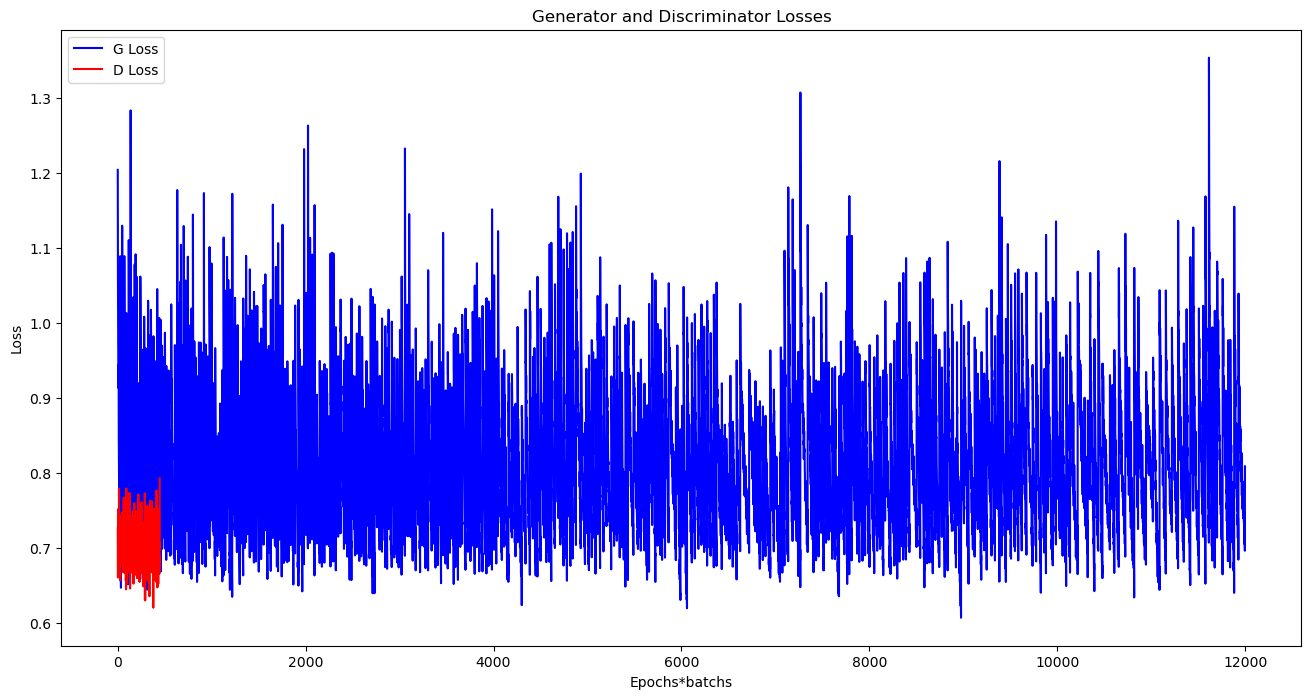

In [42]:
plt.figure(figsize=(16,8))

# Plot G_losses in blue
plt.plot(np.array(G_losses), 'b', label='G Loss')

# Plot D_losses in red
plt.plot(np.array(D_losses), 'r', label='D Loss')

plt.legend()

plt.xlabel('Epochs*batchs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.show()

In [43]:
final=[]
# Sample noise
z = torch.randn(32, z_dim, 1, 1).to(device)  # (batch_size, z_dim, 1, 1)
# generate images!
final += list(generator(z).data)
print(len(final))
for i in range(len(final)):
    save_image(final[i], f"result_images/{dirpath}/final%d.png" % i,normalize=True)


32


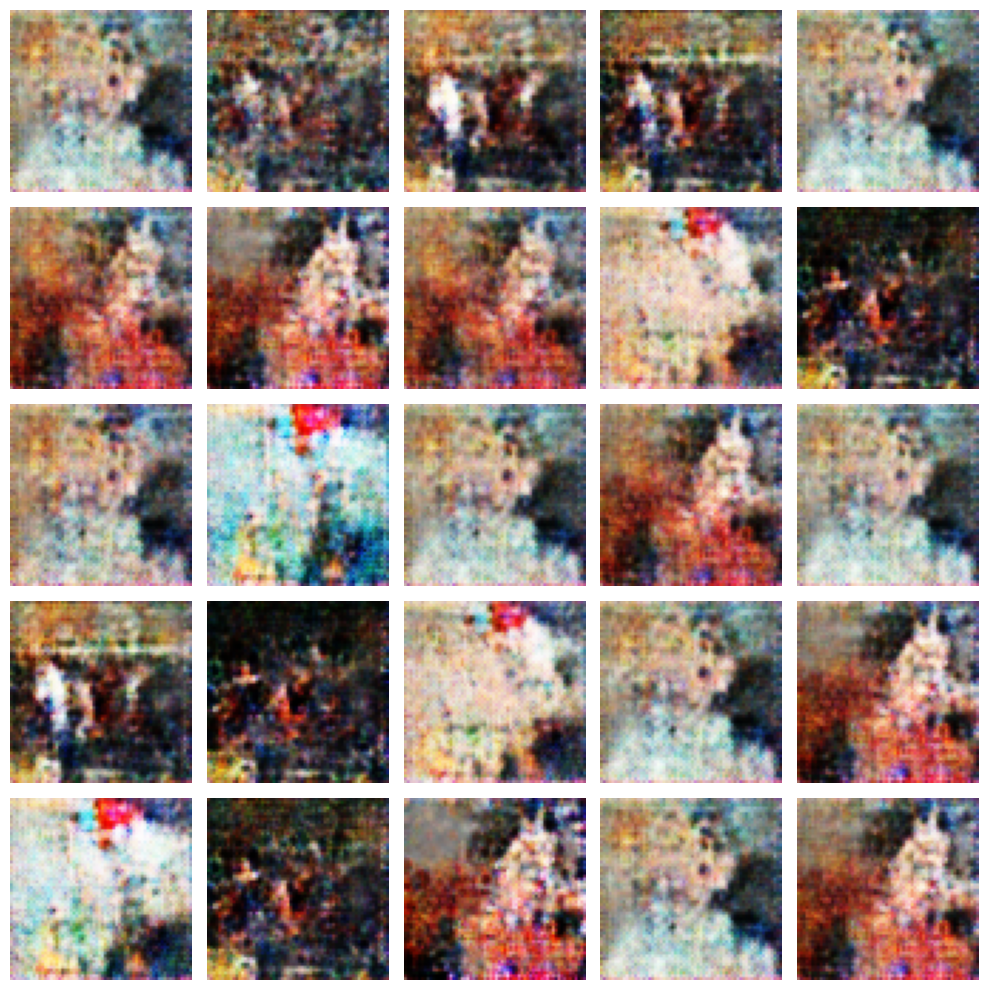

In [44]:
# 將其轉換為 PIL Image
# imgs_pil = [transforms.ToPILImage()(img.cpu().detach()) for img in gen_imgs.data[:]]

newgen = []
z_dim = 100  # 假设 z_dim 是 100
z = torch.randn(25, z_dim, 1, 1).to(device)  # (batch_size, z_dim, 1, 1)
# generate images!
newgen += list(generator(z).data)

# 假设生成器输出的图像范围在 [-1, 1] 之间，将其转换为 [0, 1]
newgen = [(img + 1) / 2 for img in newgen]

# Convert to PIL images
imgs_pil = [transforms.ToPILImage()(img.cpu().detach()) for img in newgen]

# Set the number of columns and rows for subplots
num_cols = 5
num_rows = 5

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Plot each image in the subplot
for i in range(num_rows):
    for j in range(num_cols):
        ax = axes[i, j]
        ax.axis('off')
        ax.imshow(imgs_pil[i * num_cols + j])

# Display images
plt.tight_layout()
plt.show()

In [45]:
# origin back up
# import numpy as np
# import math
# import os
# from tqdm import tqdm

# # import lib for img processing
# from torchvision.datasets import ImageFolder
# import torchvision.transforms as transforms
# from torchvision.utils import save_image

# # import lib for data processing
# from torch.utils.data import DataLoader
# from torchvision import datasets

# #　in this tutorial, i implement pytorch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch

# import matplotlib.pyplot as plt
# from torchvision.utils import make_grid
# n_epochs = 500  #epochs
# batch_size = 32   #batch size recommend that more than 32
# lr_rate = 0.0002   #learning rate
# beta1 = 0.5    #learning rate beta1
# beta2 = 0.999    #beta2
# tmp_size = 128   #image tmp crop size
# ext_size=200     #extend
# img_size = 64   #image size
# channels = 3    #RGB
# img_shape = (channels, img_size, img_size) # gray scale (channels,img_size,img_size)
# img_pixel = int(np.prod(img_shape)) # total pixel is 1*img_size*img_size
# z_dim = 100     #z_dim is latent_dim
# interval = 10  # How often to sample

# # dirpath='real_only'
# dirpath='anime_only'
# # dirpath='real+anime'
# # dirpath='real+anime+me'


# gpath = f"{dirpath}_generator.pth"
# dpath = f"{dirpath}_discriminator.pth"
# from PIL import Image
# import torchvision.transforms.functional as functional
# class CenterCropAndResize(object):
#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, image):

#         width, height = image.size
#         short_side = min(width, height)

#         image= functional.center_crop(image, short_side)
#         image= functional.resize(image,self.output_size)

#         # Resize the image
#         # image = image.resize(new_size, Image.BILINEAR)

#         # # 將 tensor 轉換成 numpy array，並調整通道的位置
#         # image_np = np.transpose(image.numpy(), (1, 2, 0))
#         # # 顯示圖像
#         # plt.imshow(image)

#         # plt.show()
#         # print(image.size)
#         return image
# # 定義圖像轉換
# # transform = transforms.Compose([
# #     transforms.CenterCrop((tmp_size, tmp_size)),      # 切大小為 tmp_size*tmp_size
# #     transforms.Resize((img_size, img_size)),        # 縮放img_size*img_size
# #     transforms.ToTensor(),            # 轉換為 tensor
# #     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])  # 正規化圖像
# # ])
# transform = transforms.Compose([
#     # CenterCropAndResize(64),  # 中心裁剪到正方形，然後縮放到 720x720
#     transforms.Resize((ext_size, ext_size)),        # 縮放img_size*img_size
#     transforms.CenterCrop((tmp_size, tmp_size)),      # 切大小為 tmp_size*tmp_size
#     transforms.Resize((img_size, img_size)),        # 縮放img_size*img_size
#     transforms.ToTensor(),  # 轉換為 tensor
#     transforms.Normalize([0.5], [0.5])  # 正規化圖像
# ])

# # 創建 ImageFolder 數據集實例
# dataset = ImageFolder(root=f'data/{dirpath}', transform=transform)

# # 使用 DataLoader 加載數據集
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# # creat a Discriminator
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
    
#         self.FC = nn.Sequential(
#             nn.Linear(img_pixel, 512),  # img_pixel is 784
#             nn.LeakyReLU(0.2, inplace=True), # limit data to 0~1 to avoid Vanishing gradient problem
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(256, 128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(128, 1),
#             nn.Sigmoid(),         # before classify, use sigmoid.
#         )
    
#     def forward(self, img):
#         flat = img.view(img.size(0), -1)
#         validity = self.FC(flat)
    
#         return validity
# # create a generator
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
    
    
#         self.FCin = nn.Linear(z_dim, 128)
#         self.FC1 = self._block(128, 256)
#         self.FC2 = self._block(256, 512)
#         self.FC3 = self._block(512, 1024)
#         self.FCout = nn.Sequential(
#             nn.Linear(1024, img_pixel),
#             nn.Tanh(),
#         )
    
    
#       # hidden layer
#     def _block(self, in_fea, out_fea):
#         return nn.Sequential(
#             nn.Linear(in_fea, out_fea),
#             nn.BatchNorm1d(out_fea, 0.8),  # google it
#             nn.LeakyReLU(0.2, inplace=True),
#         )
    
#       # put random z into layer sequentially.
#     def forward(self, z):
#         flat = z.view(z.size(0), -1)
#         fea = self.FCin(flat)
#         fea = self.FC1(fea)
#         fea = self.FC2(fea)
#         fea = self.FC3(fea)
#         fake_img = self.FCout(fea)
#         fake_img = fake_img.view(fake_img.size(0), *img_shape)
#         return fake_img
# adversarial_loss = torch.nn.BCELoss()
# # at first we need to get our gpu!
# if torch.cuda.is_available():
#     device =torch.device("cuda:0")
# else:
#     device =torch.device('cpu')

# # call the generator and discriminator
# generator = Generator()
# discriminator = Discriminator()



# # put them into your device
# if torch.cuda.is_available():
#     generator = generator.to(device)
#     discriminator = discriminator.to(device)

# # Create Optimizer
# # In this tutorial we use Adam
# optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_rate, betas=(beta1, beta2))
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_rate, betas=(beta1, beta2))

# # create a folder to save image
# os.makedirs("./result_images", exist_ok = True)
# # ------------------
# # Training Start
# # ------------------
# G_losses=[]
# D_losses=[]


# # # 檢查路徑是否存在
# if os.path.exists(gpath):
#     generator.load_state_dict(torch.load(gpath))
# if os.path.exists(dpath):
#     discriminator.load_state_dict(torch.load(dpath))
# print("FINISHING LOADING PTH")


# for epoch in range(n_epochs):
#     for batch_id, (img, _) in enumerate(tqdm(dataloader)):
#         # throw our img into gpu
#         real_imgs = img.to(device)
    
#         # create label to caculate BCE
#         _valid = torch.ones(size=(real_imgs.shape[0], 1), requires_grad=False).to(device) # (batch_size, 1) [1, 1, 1,...]
#         _fake = torch.zeros(size=(real_imgs.shape[0], 1), requires_grad=False).to(device) # (batch_size, 0) [0, 0, 0,...]
    
    
#         # -----------------
#         # Train Generator
#         # -----------------
#         # Reset 
#         optimizer_G.zero_grad()
#         # Sample noise
#         z = torch.randn(real_imgs.shape[0], z_dim, 1, 1).to(device)  # (batch_size, z_dim, 1, 1)
#         # generate images!
#         gen_imgs = generator(z)

#         # Generator :min log(1 - D(G(z))) <-> max log(D(G(z))
#         g_loss = adversarial_loss(discriminator(gen_imgs), _valid)
    
#         g_loss.backward()
#         optimizer_G.step()
#         G_losses.append(g_loss.item())
        
        
#         # --------------------
#         # Train Discriminator
#         # --------------------
#         optimizer_D.zero_grad()
    
#         # Discriminator: max log(D(x)) + log(1 - D(G(z)))
#         real_loss = adversarial_loss(discriminator(real_imgs), _valid)
#         fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), _fake)
#         d_loss = (real_loss + fake_loss) / 2
    
#         d_loss.backward()
#         optimizer_D.step()
    
#         D_losses.append(d_loss.item())
#         print(
#           "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
#           % (epoch, n_epochs, batch_id, len(dataloader), d_loss.item(), g_loss.item())
#         )
    
#         batches_done = epoch * len(dataloader) + batch_id
#         if batches_done % interval == 0:
#             save_image(gen_imgs.data[:25], "result_images/%d.png" % batches_done, nrow=5, normalize=True)
#             print(f"FULLTOGO:{len(gen_imgs)}")

            
# # save
# print("SAVING PTH")
# torch.save(generator.state_dict(), gpath)
# torch.save(discriminator.state_dict(), dpath)      
# plt.figure(figsize=(12,8))

# # Plot G_losses in blue
# plt.plot(np.array(G_losses), 'b', label='G Loss')

# # Plot D_losses in red
# plt.plot(np.array(D_losses), 'r', label='D Loss')

# plt.legend()
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Generator and Discriminator Losses')
# plt.show()
# final=[]
# # Sample noise
# z = torch.randn(64, z_dim, 1, 1).to(device)  # (batch_size, z_dim, 1, 1)
# # generate images!
# final += list(generator(z).data)
# print(len(final))
# for i in range(len(final)):
#     save_image(final[i], "result_images/final%d.png" % i,normalize=True)
# # 將其轉換為 PIL Image
# imgs_pil = [transforms.ToPILImage()(img.cpu().detach()) for img in gen_imgs.data[:]]

# print(len(gen_imgs))
# print(len(imgs_pil))
# print(len(gen_imgs.data))
# # # 設置子圖的列數和行數
# num_rows =2
# num_cols =2

# # # 創建子圖
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# # # 用 PIL Image 在子圖上繪製圖像
# for i in range(num_rows):
#     for j in range(num_cols):
#         ax = axes[i, j]
#         ax.axis('off')
#         ax.imshow(imgs_pil[i * num_cols + j])

# # # 顯示圖像
# plt.tight_layout()
# plt.show()